In [1]:
# ML_in_Finance-RNNs-HFT
# Author: Matthew Dixon
# Version: 1.1 (27.2.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F, Halperin, I. and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

## An Introduction to Prediction with RNNs

### Overview
- This notebook provides an example of how TensorFlow can be used to train and test a RNNs for time series prediction. The example dataset is for predicting from limit order book data.
- Statistical methods used for autoregressive models shall be used to identify the sequence length needed in the RNN and to diagnose the model error.
- Plain RNNs are not suited to non-stationary time series modeling. We can use a GRU or LSTM to model non-stationarity data, since these models exhibit dynamic auto-correlation structure.
- Unlike classical time series methods, e.g. ARIMA, there are no parameteric assumptions on the distribution of the errors, and non-linear relationships between response and predictors can be captured without over-fitting. 

#### Statistician's note
- We choose to build a model which provides strong predictive power, in favor of explantory power. 
- Our choice to use a recurrent neural network is predicated on each observation in the time series being dependent on previous observations. The ordering of the observations therefore matters and $X$ is not iid.
- Once the input data is appropriately scaled, model building starts with 'feature selection' -identifying the relevant features to include in the model. 
- In this tutorial, we assume that we've already identifed the relevant set of features. 
- Our primary concern in assessing the extent to which the model is over-fitting by comparing the in and out-of-sample MSEs.

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
import statsmodels.api as sm
import os

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Layer, LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.regularizers import l1,l2
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.layers import Layer,RNN
from keras import backend as K
from keras import layers
import keras.layers
from keras.legacy import interfaces
from keras import *
from alphaRNN import *
from alphatRNN import *


Using TensorFlow backend.


In [3]:
%matplotlib inline

### Example Data
- The example dataset is a chronologically ordered time series. The ordering of the observations matters and each observation is not assumed to be independent (as with cross-sectional classification data). 

- For simplicity, since the timestamps are not important for this tutorial, an integer index has been used for the Pandas Dataframe. A real dataset would typically be indexed by a unique timestamp. The observations are not uniform and in general are less than a micro-second apart.

- Each observation $X$ has three variables (a.k.a. features). Feature 3 is the smart price (VWAP) and the label indicates whether the book will up-tick, stay flat or down-tick in the next time interval.

Loading the Pandas Dataframe, viewing the first ten rows and the distribution of the labels:

In [4]:
df = pd.read_csv('../data/HFT.csv')

In [5]:
df.head()

feature_1  feature_2  feature_3  label
0   0.515301       0.72   0.710953      0
1   0.515301       0.72   0.710953      0
2   0.515301       0.72   0.710953      0
3   0.515301       0.72   0.710953      0
4   0.515301       0.72   0.710953      0

# RNN Regression
We consider a univariate prediction problem where the time series is given by 'feature_3' in the data frame.

In [6]:
use_features = ['feature_3'] # continuous input
use_feature = 'feature_3'
target = 'feature_3' # continuous output

### Stationarity
It is essential to determine whether the time series is "stationary". Informally, stationarity is when the auto-covariance is independent of time. Failure to establish stationarity will almost certainly lead to misinterpretation of model identification and diagnostics tests. Moreover, stationarity is decisive in characterizing the prediction problem and whether to use a more advanced architecture. In particular, we can expect a plain RNN to perform poorly if the data is non-stationary as the RNN exhibits fixed auto-covariance. 

We perform an Augmented Dickey-Fuller test to establish stationarity under the assumption that the time series has a constant bias but does not exhibit a time trend. In other words, we assume that the time series is already de-trended. 

If the stationarity test fails, even after first de-trending the time series, then one potential recourse is to simply take differences of time series and predict $\Delta y_t$.

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the p-value is above $(1-\alpha)$, then we cannot reject that there is a unit root. Note that a subset of the time series is used to reduce the computation time of the test.

In [ ]:
adf, p, usedlag, nobs, cvs,aic=sm.tsa.stattools.adfuller(df[use_feature][:200000]) # perform test on first 200k observations

In [ ]:
print(adf,p, nobs, cvs)

#### Autoregressive Model Identification: The partial auto-correlation
It is important to determine the number of lags, the sequence length, required in the RNN by statistical analysis. A brute-force approach will in general be too time consuming.

A partial auto-correlation at lag $h\geq 2$ is a conditional auto-correlation between a variable, $X_t$, and its $h^{th}$ lag, $X_{t-h}$ under the assumption that we control for the values of the intermediate lags, $X_{t-1},\dots, X_{t-h+1}$:

$$\tau_h:=\tau(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1}):=\frac{\gamma(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})}{\sqrt{\gamma(X_t |X_{t-1},\dots, X_{t-h+1})\gamma(X_{t-h} |X_{t-1},\dots, X_{t-h+1}))}},
$$ 
where $\gamma_h:=\gamma(X_tX_{t-h})$ is the lag-$h$ autocovariance. The partial autocorrelation function $\tau_h:\mathbb{N} \rightarrow [-1,1]$ is a map $h:\mapsto \tau_h$.

The estimated partial auto-correlation function (PACF) can be used to identify the order of an autoregressive time series model. Values of $|\tau_h|$ greater or equal to $\frac{\Phi^{-1}(\alpha)}{\sqrt{T}}$, where T is the number of observations and $\Phi(z)$ is the standard normal CDF, are significant lag $h$ partial autocorelations at the $\alpha$ confidence level.

We use the stattools package to estimat the PACF. The 'nlags' parameter is the maximum number of lags used for PACF estimation.

In [7]:
pacf=sm.tsa.stattools.pacf(df[use_features], nlags=30)

We find the first lag which isn't significant at the 99% level and automatically determine the number of lags needed in our autoregressive model as one below this value.

In [8]:
n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(df[use_features])))==False)[0][0] -1

In [9]:
print(n_steps) # number of lags to include in the model, based on the plot

23


This may lead to a high order model, with more lags than strictly necessary. We could view this value, informally, as an upper bound on the number of lags needed. We can also simply identify the order of the model based on the plot of the PACF. In this case, a minimum of 2 lags appears satisfactory, although more may be needed. Unlike autoregressive models, the advantage of using fewer parameters is purely computational as adding more lags does not increase the number of parameters, only the size of the tensorial representation of the sequence data in TensorFlow. 

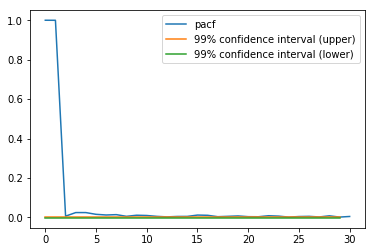

In [10]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(len(df[use_features]))]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(len(df[use_features]))]*30, label='99% confidence interval (lower)')
plt.legend()

Split the training and test set by using the first 80% of the time series and the remaining 20% for the test set. Note that the test set must be in the future of the training set to avoid look-ahead bias. Also, random sampling of the data can not be used as this would eliminate the auto-correlation structure.

In [11]:
train_weight = 0.8
split = int(len(df)*train_weight)
df_train = df.iloc[:split]

### Scaling
Standardization of the data is important to avoid potential scaling difficulties in the fitting of the model. When there is more than one feature (covariate), scaling avoids one feature dominating over another due to disparate scales.

To avoid introducing a look-ahead bias into the prediction, we must re-scale the training data without knowledge of the test set. Hence, we will simply standardize the training set using the mean and standard deviation of the training set and not the whole time series. Additionally, to avoid introducing a systematic bias into test set, we use the identical normalization for the test set - the mean and standard deviation of the training set are used to normalize the test set.

In [12]:
mu = np.float(df_train[use_features].mean())
sigma = np.float(df_train[use_features].std())

In [13]:
std_df_train = df_train[use_features].apply(lambda x: (x - mu) / sigma)

In [14]:
df_test = df.iloc[split:]
std_df_test = df[use_features].apply(lambda x: (x - mu) / sigma).iloc[split:]

### Data formatting for RNNs

TensorFlow uses tensors to represent data. To perform sequence learning, the time series of variables must be transformed to a series of over-lapping sub-sequences. 

For example, consider a univariate time series of increasing integers.

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

Setting the sequence length to 10, for example, we move the window forward by one observation at a time and construct new sequences:

1 2 3 4 5 6 7 8 9 10

2 3 4 5 6 7 8 9 10 11

3 4 5 6 7 8 9 10 11 12

4 5 6 7 8 9 10 11 12 13

5 6 7 8 9 10 11 12 13 14

6 7 8 9 10 11 12 13 14 15


Let's define the following function for reshaping the data into one-step ahead times series prediction format. 

In [16]:
def get_lagged_features(value, n_steps, n_steps_ahead):
    """
    value: feature value to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    for lag in range(n_steps+n_steps_ahead-1, n_steps_ahead-1, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

We shall first transform the training input and output data.

In [17]:
n_steps_ahead=10

x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps, n_steps_ahead).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps,n_steps_ahead).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

Print the shapes of each tensor. The first digit is the number of observations. For feature arrays, the second digit is the sequence length (i.e. the number of lags in the model) and the final digit is the dimension of each element in the sequence or output vector respectively. In this case, the example performs univariate time series analysis and so the dimension of the input and output is 1.

In [18]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(826793, 23, 1) (826793, 1, 1) (206675, 23, 1) (206675, 1, 1)


In [20]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]
time_size = y_train_reg.shape[1]

In [21]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))

In [22]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

### Model Specification

In [23]:
def AlphatRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def AlphaRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True)) 
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [26]:
max_epoches=2000
batch_size=1000

In [30]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=1e-7, restore_best_weights=True)

In [27]:
params = {'rnn': {'model':'', 'function':SimpleRNN_, 'l1_reg':0.0, 'H':10, 'color': 'blue', 'label':'RNN'}, 
          'alpharnn': {'model':'', 'function':AlphaRNN_,'l1_reg':0.001, 'H':5,'color': 'green', 'label': '$\\alpha$-RNN' }, 
          'alphatrnn': {'model':'', 'function':AlphatRNN_,'l1_reg':0.0, 'H':5, 'color': 'cyan', 'label': '$\\alpha_t$-RNN'},
          'gru': {'model':'', 'function':GRU_,'l1_reg':0.001, 'H':10, 'color': 'orange', 'label': 'GRU'},
          'lstm': {'model':'', 'function':LSTM_,'l1_reg':0.0, 'H':5, 'color':'red', 'label': 'LSTM'}
         }

# Cross-validation


In [ ]:
cross_val=True # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [5,10,20]
    l1_reg = [0, 0.001, 0.01] #, 0.1]
    tscv = TimeSeriesSplit(n_splits = 3)
    param_grid = dict(n_units=n_units,l1_reg=l1_reg)

    for key in params.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg[:30000],y_train_reg[:30000],callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] l1_reg=0, n_units=5 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/2000
 - 1s - loss: 3.1825
Epoch 2/2000
 - 0s - loss: 2.9015
Epoch 3/2000
 - 0s - loss: 2.6269
Epoch 4/2000
 - 0s - loss: 2.3612
Epoch 5/2000
 - 0s - loss: 2.1068
Epoch 6/2000
 - 0s - loss: 1.8662
Epoch 7/2000
 - 0s - loss: 1.6406
Epoch 8/2000
 - 0s - loss: 1.4320
Epoch 9/2000
 - 0s - loss: 1.2407
Epoch 10/2000
 - 0s - loss: 1.0679
Epoch 11/2000
 - 0s - loss: 0.9133
Epoch 12/2000
 - 0s - loss: 0.7769
Epoch 13/2000
 - 0s - loss: 0.6581
Epoch 14/2000
 - 0s - loss: 0.5557
Epoch 15/2000
 - 0s - loss: 0.4684
Epoch 16/2000
 - 0s - loss: 0.3942
Epoch 17/2000
 - 0s - loss: 0.3318
Epoch 18/2000
 - 0s - loss: 0.2796
Epoch 19/2000
 - 0s - loss: 0.2360
Epoch 20/2000
 - 0s - loss: 0.1996
Epoch 21/2000
 - 0s - loss: 0.1693
Epoch 22/2000
 - 0s - loss: 0.1440
Epoch 23/2000
 - 0s - loss: 0.1228
Epoch 24/2000
 - 0s - loss: 0.1051
Epoch 25/2000
 - 0s - loss: 0.0902
Epoch 26/2000
 - 0s - loss: 0.0776
Epoch 27/2000
 - 0s - loss: 0.0670
Epoch 28/2000
 - 0s - loss: 0.0580
Epoch 29/2000
 - 0s - loss: 0

Epoch 231/2000
 - 0s - loss: 9.4511e-04
Epoch 232/2000
 - 0s - loss: 9.3935e-04
Epoch 233/2000
 - 0s - loss: 9.3368e-04
Epoch 234/2000
 - 0s - loss: 9.2806e-04
Epoch 235/2000
 - 0s - loss: 9.2246e-04
Epoch 236/2000
 - 0s - loss: 9.1693e-04
Epoch 237/2000
 - 0s - loss: 9.1149e-04
Epoch 238/2000
 - 0s - loss: 9.0606e-04
Epoch 239/2000
 - 0s - loss: 9.0069e-04
Epoch 240/2000
 - 0s - loss: 8.9526e-04
Epoch 241/2000
 - 0s - loss: 8.9002e-04
Epoch 242/2000
 - 0s - loss: 8.8475e-04
Epoch 243/2000
 - 0s - loss: 8.7952e-04
Epoch 244/2000
 - 0s - loss: 8.7440e-04
Epoch 245/2000
 - 0s - loss: 8.6924e-04
Epoch 246/2000
 - 0s - loss: 8.6411e-04
Epoch 247/2000
 - 0s - loss: 8.5909e-04
Epoch 248/2000
 - 0s - loss: 8.5406e-04
Epoch 249/2000
 - 0s - loss: 8.4908e-04
Epoch 250/2000
 - 0s - loss: 8.4411e-04
Epoch 251/2000
 - 0s - loss: 8.3921e-04
Epoch 252/2000
 - 0s - loss: 8.3434e-04
Epoch 253/2000
 - 0s - loss: 8.2947e-04
Epoch 254/2000
 - 0s - loss: 8.2475e-04
Epoch 255/2000
 - 0s - loss: 8.1995e-04


Epoch 436/2000
 - 0s - loss: 3.3988e-04
Epoch 437/2000
 - 0s - loss: 3.3849e-04
Epoch 438/2000
 - 0s - loss: 3.3714e-04
Epoch 439/2000
 - 0s - loss: 3.3576e-04
Epoch 440/2000
 - 0s - loss: 3.3440e-04
Epoch 441/2000
 - 0s - loss: 3.3307e-04
Epoch 442/2000
 - 0s - loss: 3.3172e-04
Epoch 443/2000
 - 0s - loss: 3.3040e-04
Epoch 444/2000
 - 0s - loss: 3.2908e-04
Epoch 445/2000
 - 0s - loss: 3.2779e-04
Epoch 446/2000
 - 0s - loss: 3.2645e-04
Epoch 447/2000
 - 0s - loss: 3.2516e-04
Epoch 448/2000
 - 0s - loss: 3.2386e-04
Epoch 449/2000
 - 0s - loss: 3.2259e-04
Epoch 450/2000
 - 0s - loss: 3.2133e-04
Epoch 451/2000
 - 0s - loss: 3.2005e-04
Epoch 452/2000
 - 0s - loss: 3.1881e-04
Epoch 453/2000
 - 0s - loss: 3.1755e-04
Epoch 454/2000
 - 0s - loss: 3.1631e-04
Epoch 455/2000
 - 0s - loss: 3.1507e-04
Epoch 456/2000
 - 0s - loss: 3.1383e-04
Epoch 457/2000
 - 0s - loss: 3.1261e-04
Epoch 458/2000
 - 0s - loss: 3.1139e-04
Epoch 459/2000
 - 0s - loss: 3.1019e-04
Epoch 460/2000
 - 0s - loss: 3.0898e-04


Epoch 641/2000
 - 0s - loss: 1.7248e-04
Epoch 642/2000
 - 0s - loss: 1.7212e-04
Epoch 643/2000
 - 0s - loss: 1.7161e-04
Epoch 644/2000
 - 0s - loss: 1.7120e-04
Epoch 645/2000
 - 0s - loss: 1.7067e-04
Epoch 646/2000
 - 0s - loss: 1.7033e-04
Epoch 647/2000
 - 0s - loss: 1.6987e-04
Epoch 648/2000
 - 0s - loss: 1.6942e-04
Epoch 649/2000
 - 0s - loss: 1.6894e-04
Epoch 650/2000
 - 0s - loss: 1.6853e-04
Epoch 651/2000
 - 0s - loss: 1.6812e-04
Epoch 652/2000
 - 0s - loss: 1.6768e-04
Epoch 653/2000
 - 0s - loss: 1.6725e-04
Epoch 654/2000
 - 0s - loss: 1.6684e-04
Epoch 655/2000
 - 0s - loss: 1.6641e-04
Epoch 656/2000
 - 0s - loss: 1.6600e-04
Epoch 657/2000
 - 0s - loss: 1.6559e-04
Epoch 658/2000
 - 0s - loss: 1.6518e-04
Epoch 659/2000
 - 0s - loss: 1.6479e-04
Epoch 660/2000
 - 0s - loss: 1.6435e-04
Epoch 661/2000
 - 0s - loss: 1.6400e-04
Epoch 662/2000
 - 0s - loss: 1.6350e-04
Epoch 663/2000
 - 0s - loss: 1.6310e-04
Epoch 664/2000
 - 0s - loss: 1.6270e-04
Epoch 665/2000
 - 0s - loss: 1.6231e-04


Epoch 846/2000
 - 0s - loss: 1.1231e-04
Epoch 847/2000
 - 0s - loss: 1.1215e-04
Epoch 848/2000
 - 0s - loss: 1.1191e-04
Epoch 849/2000
 - 0s - loss: 1.1176e-04
Epoch 850/2000
 - 0s - loss: 1.1159e-04
Epoch 851/2000
 - 0s - loss: 1.1138e-04
Epoch 852/2000
 - 0s - loss: 1.1118e-04
Epoch 853/2000
 - 0s - loss: 1.1105e-04
Epoch 854/2000
 - 0s - loss: 1.1086e-04
Epoch 855/2000
 - 0s - loss: 1.1061e-04
Epoch 856/2000
 - 0s - loss: 1.1044e-04
Epoch 857/2000
 - 0s - loss: 1.1030e-04
Epoch 858/2000
 - 0s - loss: 1.1006e-04
Epoch 859/2000
 - 0s - loss: 1.0991e-04
Epoch 860/2000
 - 0s - loss: 1.0971e-04
Epoch 861/2000
 - 0s - loss: 1.0954e-04
Epoch 862/2000
 - 0s - loss: 1.0933e-04
Epoch 863/2000
 - 0s - loss: 1.0917e-04
Epoch 864/2000
 - 0s - loss: 1.0899e-04
Epoch 865/2000
 - 0s - loss: 1.0880e-04
Epoch 866/2000
 - 0s - loss: 1.0864e-04
Epoch 867/2000
 - 0s - loss: 1.0845e-04
Epoch 868/2000
 - 0s - loss: 1.0830e-04
Epoch 869/2000
 - 0s - loss: 1.0814e-04
Epoch 870/2000
 - 0s - loss: 1.0791e-04


Epoch 1050/2000
 - 0s - loss: 8.4119e-05
Epoch 1051/2000
 - 0s - loss: 8.4045e-05
Epoch 1052/2000
 - 0s - loss: 8.3735e-05
Epoch 1053/2000
 - 0s - loss: 8.3617e-05
Epoch 1054/2000
 - 0s - loss: 8.3563e-05
Epoch 1055/2000
 - 0s - loss: 8.3449e-05
Epoch 1056/2000
 - 0s - loss: 8.3355e-05
Epoch 1057/2000
 - 0s - loss: 8.3262e-05
Epoch 1058/2000
 - 0s - loss: 8.3238e-05
Epoch 1059/2000
 - 0s - loss: 8.3156e-05
Epoch 1060/2000
 - 0s - loss: 8.3006e-05
Epoch 1061/2000
 - 0s - loss: 8.2897e-05
Epoch 1062/2000
 - 0s - loss: 8.2832e-05
Epoch 1063/2000
 - 0s - loss: 8.2761e-05
Epoch 1064/2000
 - 0s - loss: 8.2678e-05
Epoch 1065/2000
 - 0s - loss: 8.2548e-05
Epoch 1066/2000
 - 0s - loss: 8.2483e-05
Epoch 1067/2000
 - 0s - loss: 8.2402e-05
Epoch 1068/2000
 - 0s - loss: 8.2410e-05
Epoch 1069/2000
 - 0s - loss: 8.2304e-05
Epoch 1070/2000
 - 0s - loss: 8.2168e-05
Epoch 1071/2000
 - 0s - loss: 8.2129e-05
Epoch 1072/2000
 - 0s - loss: 8.2028e-05
Epoch 1073/2000
 - 0s - loss: 8.1951e-05
Epoch 1074/2000


Epoch 1250/2000
 - 0s - loss: 7.3834e-05
Epoch 1251/2000
 - 0s - loss: 7.3749e-05
Epoch 1252/2000
 - 0s - loss: 7.3553e-05
Epoch 1253/2000
 - 0s - loss: 7.3531e-05
Epoch 1254/2000
 - 0s - loss: 7.3420e-05
Epoch 1255/2000
 - 0s - loss: 7.3791e-05
Epoch 1256/2000
 - 0s - loss: 7.3673e-05
Epoch 1257/2000
 - 0s - loss: 7.4108e-05
Epoch 1258/2000
 - 0s - loss: 7.3749e-05
Epoch 1259/2000
 - 0s - loss: 7.3740e-05
Epoch 1260/2000
 - 0s - loss: 7.3282e-05
Epoch 1261/2000
 - 0s - loss: 7.3416e-05
Epoch 1262/2000
 - 0s - loss: 7.3318e-05
Epoch 1263/2000
 - 0s - loss: 7.3729e-05
Epoch 1264/2000
 - 0s - loss: 7.3658e-05
Epoch 1265/2000
 - 0s - loss: 7.3245e-05
Epoch 1266/2000
 - 0s - loss: 7.3219e-05
Epoch 1267/2000
 - 0s - loss: 7.3091e-05
Epoch 1268/2000
 - 0s - loss: 7.3203e-05
Epoch 1269/2000
 - 0s - loss: 7.3352e-05
Epoch 1270/2000
 - 0s - loss: 7.3326e-05
Epoch 1271/2000
 - 0s - loss: 7.3628e-05
Epoch 1272/2000
 - 0s - loss: 7.3572e-05
Epoch 1273/2000
 - 0s - loss: 7.3221e-05
Epoch 1274/2000


Epoch 1450/2000
 - 0s - loss: 7.1216e-05
Epoch 1451/2000
 - 0s - loss: 7.0841e-05
Epoch 1452/2000
 - 0s - loss: 7.0934e-05
Epoch 1453/2000
 - 0s - loss: 6.9958e-05
Epoch 1454/2000
 - 0s - loss: 6.9836e-05
Epoch 1455/2000
 - 0s - loss: 6.9948e-05
Epoch 1456/2000
 - 0s - loss: 7.0073e-05
Epoch 1457/2000
 - 0s - loss: 6.9888e-05
Epoch 1458/2000
 - 0s - loss: 7.0231e-05
Epoch 1459/2000
 - 0s - loss: 7.0490e-05
Epoch 1460/2000
 - 0s - loss: 6.9808e-05
Epoch 1461/2000
 - 0s - loss: 7.0059e-05
Epoch 1462/2000
 - 0s - loss: 7.0214e-05
Epoch 1463/2000
 - 0s - loss: 7.0022e-05
Epoch 1464/2000
 - 0s - loss: 7.0211e-05
Epoch 1465/2000
 - 0s - loss: 6.9724e-05
Epoch 1466/2000
 - 0s - loss: 6.9836e-05
Epoch 1467/2000
 - 0s - loss: 7.0544e-05
Epoch 1468/2000
 - 0s - loss: 6.9728e-05
Epoch 1469/2000
 - 0s - loss: 7.0235e-05
Epoch 1470/2000
 - 0s - loss: 6.9920e-05
Epoch 1471/2000
 - 0s - loss: 7.0102e-05
Epoch 1472/2000
 - 0s - loss: 6.9759e-05
Epoch 1473/2000
 - 0s - loss: 7.0390e-05
Epoch 1474/2000


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.3s remaining:    0.0s


Epoch 1/2000
 - 2s - loss: 3.0471
Epoch 2/2000
 - 0s - loss: 2.5356
Epoch 3/2000
 - 0s - loss: 2.0578
Epoch 4/2000
 - 0s - loss: 1.6267
Epoch 5/2000
 - 0s - loss: 1.2523
Epoch 6/2000
 - 0s - loss: 0.9406
Epoch 7/2000
 - 0s - loss: 0.6924
Epoch 8/2000
 - 0s - loss: 0.5026
Epoch 9/2000
 - 0s - loss: 0.3625
Epoch 10/2000
 - 0s - loss: 0.2616
Epoch 11/2000
 - 0s - loss: 0.1899
Epoch 12/2000
 - 0s - loss: 0.1392
Epoch 13/2000
 - 0s - loss: 0.1033
Epoch 14/2000
 - 0s - loss: 0.0776
Epoch 15/2000
 - 0s - loss: 0.0590
Epoch 16/2000
 - 0s - loss: 0.0455
Epoch 17/2000
 - 0s - loss: 0.0355
Epoch 18/2000
 - 0s - loss: 0.0281
Epoch 19/2000
 - 0s - loss: 0.0225
Epoch 20/2000
 - 0s - loss: 0.0183
Epoch 21/2000
 - 0s - loss: 0.0151
Epoch 22/2000
 - 0s - loss: 0.0127
Epoch 23/2000
 - 0s - loss: 0.0109
Epoch 24/2000
 - 0s - loss: 0.0095
Epoch 25/2000
 - 0s - loss: 0.0084
Epoch 26/2000
 - 0s - loss: 0.0076
Epoch 27/2000
 - 0s - loss: 0.0069
Epoch 28/2000
 - 0s - loss: 0.0064
Epoch 29/2000
 - 0s - loss: 0

Epoch 222/2000
 - 0s - loss: 4.3241e-04
Epoch 223/2000
 - 0s - loss: 4.2943e-04
Epoch 224/2000
 - 0s - loss: 4.2650e-04
Epoch 225/2000
 - 0s - loss: 4.2361e-04
Epoch 226/2000
 - 0s - loss: 4.2079e-04
Epoch 227/2000
 - 0s - loss: 4.1794e-04
Epoch 228/2000
 - 0s - loss: 4.1519e-04
Epoch 229/2000
 - 0s - loss: 4.1238e-04
Epoch 230/2000
 - 0s - loss: 4.0969e-04
Epoch 231/2000
 - 0s - loss: 4.0701e-04
Epoch 232/2000
 - 0s - loss: 4.0436e-04
Epoch 233/2000
 - 0s - loss: 4.0174e-04
Epoch 234/2000
 - 0s - loss: 3.9917e-04
Epoch 235/2000
 - 0s - loss: 3.9663e-04
Epoch 236/2000
 - 0s - loss: 3.9410e-04
Epoch 237/2000
 - 0s - loss: 3.9162e-04
Epoch 238/2000
 - 0s - loss: 3.8914e-04
Epoch 239/2000
 - 0s - loss: 3.8674e-04
Epoch 240/2000
 - 0s - loss: 3.8434e-04
Epoch 241/2000
 - 0s - loss: 3.8196e-04
Epoch 242/2000
 - 0s - loss: 3.7969e-04
Epoch 243/2000
 - 0s - loss: 3.7732e-04
Epoch 244/2000
 - 0s - loss: 3.7503e-04
Epoch 245/2000
 - 0s - loss: 3.7278e-04
Epoch 246/2000
 - 0s - loss: 3.7055e-04


Epoch 427/2000
 - 0s - loss: 1.9544e-04
Epoch 428/2000
 - 0s - loss: 1.9508e-04
Epoch 429/2000
 - 0s - loss: 1.9477e-04
Epoch 430/2000
 - 0s - loss: 1.9433e-04
Epoch 431/2000
 - 0s - loss: 1.9400e-04
Epoch 432/2000
 - 0s - loss: 1.9366e-04
Epoch 433/2000
 - 0s - loss: 1.9331e-04
Epoch 434/2000
 - 0s - loss: 1.9296e-04
Epoch 435/2000
 - 0s - loss: 1.9260e-04
Epoch 436/2000
 - 0s - loss: 1.9228e-04
Epoch 437/2000
 - 0s - loss: 1.9198e-04
Epoch 438/2000
 - 0s - loss: 1.9173e-04
Epoch 439/2000
 - 0s - loss: 1.9130e-04
Epoch 440/2000
 - 0s - loss: 1.9106e-04
Epoch 441/2000
 - 0s - loss: 1.9075e-04
Epoch 442/2000
 - 0s - loss: 1.9044e-04
Epoch 443/2000
 - 0s - loss: 1.9003e-04
Epoch 444/2000
 - 0s - loss: 1.8978e-04
Epoch 445/2000
 - 0s - loss: 1.8938e-04
Epoch 446/2000
 - 0s - loss: 1.8910e-04
Epoch 447/2000
 - 0s - loss: 1.8880e-04
Epoch 448/2000
 - 0s - loss: 1.8843e-04
Epoch 449/2000
 - 0s - loss: 1.8812e-04
Epoch 450/2000
 - 0s - loss: 1.8785e-04
Epoch 451/2000
 - 0s - loss: 1.8753e-04


Epoch 632/2000
 - 0s - loss: 1.6346e-04
Epoch 633/2000
 - 0s - loss: 1.6319e-04
Epoch 634/2000
 - 0s - loss: 1.6373e-04
Epoch 635/2000
 - 0s - loss: 1.6344e-04
Epoch 636/2000
 - 0s - loss: 1.6298e-04
Epoch 637/2000
 - 0s - loss: 1.6285e-04
Epoch 638/2000
 - 0s - loss: 1.6287e-04
Epoch 639/2000
 - 0s - loss: 1.6319e-04
Epoch 640/2000
 - 0s - loss: 1.6285e-04
Epoch 641/2000
 - 0s - loss: 1.6271e-04
Epoch 642/2000
 - 0s - loss: 1.6314e-04
Epoch 643/2000
 - 0s - loss: 1.6262e-04
Epoch 644/2000
 - 0s - loss: 1.6267e-04
Epoch 645/2000
 - 0s - loss: 1.6254e-04
Epoch 646/2000
 - 0s - loss: 1.6250e-04
Epoch 647/2000
 - 0s - loss: 1.6255e-04
Epoch 648/2000
 - 0s - loss: 1.6249e-04
Epoch 649/2000
 - 0s - loss: 1.6238e-04
Epoch 650/2000
 - 0s - loss: 1.6247e-04
Epoch 651/2000
 - 0s - loss: 1.6227e-04
Epoch 652/2000
 - 0s - loss: 1.6236e-04
Epoch 653/2000
 - 0s - loss: 1.6224e-04
Epoch 654/2000
 - 0s - loss: 1.6238e-04
Epoch 655/2000
 - 0s - loss: 1.6208e-04
Epoch 656/2000
 - 0s - loss: 1.6239e-04


Epoch 837/2000
 - 0s - loss: 1.5718e-04
Epoch 838/2000
 - 0s - loss: 1.5703e-04
Epoch 839/2000
 - 0s - loss: 1.5682e-04
Epoch 840/2000
 - 0s - loss: 1.5799e-04
Epoch 841/2000
 - 0s - loss: 1.5753e-04
Epoch 842/2000
 - 0s - loss: 1.5735e-04
Epoch 843/2000
 - 0s - loss: 1.5692e-04
Epoch 844/2000
 - 0s - loss: 1.5674e-04
Epoch 845/2000
 - 0s - loss: 1.5686e-04
Epoch 846/2000
 - 0s - loss: 1.5870e-04
Epoch 847/2000
 - 0s - loss: 1.5757e-04
Epoch 848/2000
 - 0s - loss: 1.5713e-04
Epoch 849/2000
 - 0s - loss: 1.5695e-04
Epoch 850/2000
 - 0s - loss: 1.5652e-04
Epoch 851/2000
 - 0s - loss: 1.5675e-04
Epoch 852/2000
 - 0s - loss: 1.5730e-04
Epoch 853/2000
 - 0s - loss: 1.5684e-04
Epoch 854/2000
 - 0s - loss: 1.5782e-04
Epoch 855/2000
 - 0s - loss: 1.5705e-04
Epoch 856/2000
 - 0s - loss: 1.5734e-04
Epoch 857/2000
 - 0s - loss: 1.5850e-04
Epoch 858/2000
 - 0s - loss: 1.5785e-04
Epoch 859/2000
 - 0s - loss: 1.5801e-04
Epoch 860/2000
 - 0s - loss: 1.5707e-04
Epoch 861/2000
 - 0s - loss: 1.5689e-04


Epoch 101/2000
 - 0s - loss: 8.0808e-04
Epoch 102/2000
 - 0s - loss: 7.9601e-04
Epoch 103/2000
 - 0s - loss: 7.8419e-04
Epoch 104/2000
 - 0s - loss: 7.7262e-04
Epoch 105/2000
 - 0s - loss: 7.6149e-04
Epoch 106/2000
 - 0s - loss: 7.5042e-04
Epoch 107/2000
 - 0s - loss: 7.3974e-04
Epoch 108/2000
 - 0s - loss: 7.2929e-04
Epoch 109/2000
 - 0s - loss: 7.1906e-04
Epoch 110/2000
 - 0s - loss: 7.0911e-04
Epoch 111/2000
 - 0s - loss: 6.9937e-04
Epoch 112/2000
 - 0s - loss: 6.8989e-04
Epoch 113/2000
 - 0s - loss: 6.8063e-04
Epoch 114/2000
 - 0s - loss: 6.7156e-04
Epoch 115/2000
 - 0s - loss: 6.6274e-04
Epoch 116/2000
 - 0s - loss: 6.5409e-04
Epoch 117/2000
 - 0s - loss: 6.4564e-04
Epoch 118/2000
 - 0s - loss: 6.3740e-04
Epoch 119/2000
 - 0s - loss: 6.2943e-04
Epoch 120/2000
 - 0s - loss: 6.2149e-04
Epoch 121/2000
 - 0s - loss: 6.1379e-04
Epoch 122/2000
 - 0s - loss: 6.0625e-04
Epoch 123/2000
 - 0s - loss: 5.9888e-04
Epoch 124/2000
 - 0s - loss: 5.9171e-04
Epoch 125/2000
 - 0s - loss: 5.8467e-04


Epoch 306/2000
 - 0s - loss: 2.2721e-04
Epoch 307/2000
 - 0s - loss: 2.2702e-04
Epoch 308/2000
 - 0s - loss: 2.2649e-04
Epoch 309/2000
 - 0s - loss: 2.2622e-04
Epoch 310/2000
 - 0s - loss: 2.2578e-04
Epoch 311/2000
 - 0s - loss: 2.2544e-04
Epoch 312/2000
 - 0s - loss: 2.2505e-04
Epoch 313/2000
 - 0s - loss: 2.2488e-04
Epoch 314/2000
 - 0s - loss: 2.2444e-04
Epoch 315/2000
 - 0s - loss: 2.2416e-04
Epoch 316/2000
 - 0s - loss: 2.2378e-04
Epoch 317/2000
 - 0s - loss: 2.2353e-04
Epoch 318/2000
 - 0s - loss: 2.2328e-04
Epoch 319/2000
 - 0s - loss: 2.2281e-04
Epoch 320/2000
 - 0s - loss: 2.2258e-04
Epoch 321/2000
 - 0s - loss: 2.2224e-04
Epoch 322/2000
 - 0s - loss: 2.2203e-04
Epoch 323/2000
 - 0s - loss: 2.2173e-04
Epoch 324/2000
 - 0s - loss: 2.2141e-04
Epoch 325/2000
 - 0s - loss: 2.2114e-04
Epoch 326/2000
 - 0s - loss: 2.2102e-04
Epoch 327/2000
 - 0s - loss: 2.2072e-04
Epoch 328/2000
 - 0s - loss: 2.2044e-04
Epoch 329/2000
 - 0s - loss: 2.2016e-04
Epoch 330/2000
 - 0s - loss: 2.1981e-04


Epoch 511/2000
 - 0s - loss: 2.0216e-04
Epoch 512/2000
 - 0s - loss: 2.0154e-04
Epoch 513/2000
 - 0s - loss: 2.0248e-04
Epoch 514/2000
 - 0s - loss: 2.0501e-04
Epoch 515/2000
 - 0s - loss: 2.0276e-04
Epoch 516/2000
 - 0s - loss: 2.0309e-04
Epoch 517/2000
 - 0s - loss: 2.0201e-04
Epoch 518/2000
 - 0s - loss: 2.0191e-04
Epoch 519/2000
 - 0s - loss: 2.0239e-04
Epoch 520/2000
 - 0s - loss: 2.0215e-04
Epoch 521/2000
 - 0s - loss: 2.0194e-04
Epoch 522/2000
 - 0s - loss: 2.0172e-04
Epoch 523/2000
 - 0s - loss: 2.0166e-04
Epoch 524/2000
 - 0s - loss: 2.0109e-04
Epoch 525/2000
 - 0s - loss: 2.0174e-04
Epoch 526/2000
 - 0s - loss: 2.0503e-04
Epoch 527/2000
 - 0s - loss: 2.0148e-04
Epoch 528/2000
 - 0s - loss: 2.0142e-04
Epoch 529/2000
 - 0s - loss: 2.0119e-04
Epoch 530/2000
 - 0s - loss: 2.0191e-04
Epoch 531/2000
 - 0s - loss: 2.0146e-04
Epoch 532/2000
 - 0s - loss: 2.0130e-04
Epoch 533/2000
 - 0s - loss: 2.0143e-04
Epoch 534/2000
 - 0s - loss: 2.0121e-04
Epoch 535/2000
 - 0s - loss: 2.0108e-04


 - 0s - loss: 2.7928e-04
Epoch 99/2000
 - 0s - loss: 2.7715e-04
Epoch 100/2000
 - 0s - loss: 2.7505e-04
Epoch 101/2000
 - 0s - loss: 2.7294e-04
Epoch 102/2000
 - 0s - loss: 2.7085e-04
Epoch 103/2000
 - 0s - loss: 2.6880e-04
Epoch 104/2000
 - 0s - loss: 2.6669e-04
Epoch 105/2000
 - 0s - loss: 2.6464e-04
Epoch 106/2000
 - 0s - loss: 2.6259e-04
Epoch 107/2000
 - 0s - loss: 2.6057e-04
Epoch 108/2000
 - 0s - loss: 2.5853e-04
Epoch 109/2000
 - 0s - loss: 2.5651e-04
Epoch 110/2000
 - 0s - loss: 2.5451e-04
Epoch 111/2000
 - 0s - loss: 2.5254e-04
Epoch 112/2000
 - 0s - loss: 2.5054e-04
Epoch 113/2000
 - 0s - loss: 2.4861e-04
Epoch 114/2000
 - 0s - loss: 2.4664e-04
Epoch 115/2000
 - 0s - loss: 2.4468e-04
Epoch 116/2000
 - 0s - loss: 2.4276e-04
Epoch 117/2000
 - 0s - loss: 2.4090e-04
Epoch 118/2000
 - 0s - loss: 2.3897e-04
Epoch 119/2000
 - 0s - loss: 2.3708e-04
Epoch 120/2000
 - 0s - loss: 2.3526e-04
Epoch 121/2000
 - 0s - loss: 2.3339e-04
Epoch 122/2000
 - 0s - loss: 2.3153e-04
Epoch 123/2000
 

 - 0s - loss: 9.2644e-05
Epoch 304/2000
 - 0s - loss: 9.2546e-05
Epoch 305/2000
 - 0s - loss: 9.2439e-05
Epoch 306/2000
 - 0s - loss: 9.2350e-05
Epoch 307/2000
 - 0s - loss: 9.2251e-05
Epoch 308/2000
 - 0s - loss: 9.2159e-05
Epoch 309/2000
 - 0s - loss: 9.2071e-05
Epoch 310/2000
 - 0s - loss: 9.1977e-05
Epoch 311/2000
 - 0s - loss: 9.1894e-05
Epoch 312/2000
 - 0s - loss: 9.1816e-05
Epoch 313/2000
 - 0s - loss: 9.1740e-05
Epoch 314/2000
 - 0s - loss: 9.1671e-05
Epoch 315/2000
 - 0s - loss: 9.1583e-05
Epoch 316/2000
 - 0s - loss: 9.1538e-05
Epoch 317/2000
 - 0s - loss: 9.1446e-05
Epoch 318/2000
 - 0s - loss: 9.1399e-05
Epoch 319/2000
 - 0s - loss: 9.1291e-05
Epoch 320/2000
 - 0s - loss: 9.1231e-05
Epoch 321/2000
 - 0s - loss: 9.1174e-05
Epoch 322/2000
 - 0s - loss: 9.1102e-05
Epoch 323/2000
 - 0s - loss: 9.1046e-05
Epoch 324/2000
 - 0s - loss: 9.0975e-05
Epoch 325/2000
 - 0s - loss: 9.0917e-05
Epoch 326/2000
 - 0s - loss: 9.0859e-05
Epoch 327/2000
 - 0s - loss: 9.0809e-05
Epoch 328/2000


 - 0s - loss: 8.7104e-05
Epoch 509/2000
 - 0s - loss: 8.7170e-05
Epoch 510/2000
 - 0s - loss: 8.7060e-05
Epoch 511/2000
 - 0s - loss: 8.7081e-05
Epoch 512/2000
 - 0s - loss: 8.7150e-05
Epoch 513/2000
 - 0s - loss: 8.7036e-05
Epoch 514/2000
 - 0s - loss: 8.7098e-05
Epoch 515/2000
 - 0s - loss: 8.7015e-05
Epoch 516/2000
 - 0s - loss: 8.6973e-05
Epoch 517/2000
 - 0s - loss: 8.6933e-05
Epoch 518/2000
 - 0s - loss: 8.6938e-05
Epoch 519/2000
 - 0s - loss: 8.7001e-05
Epoch 520/2000
 - 0s - loss: 8.6866e-05
Epoch 521/2000
 - 0s - loss: 8.6870e-05
Epoch 522/2000
 - 0s - loss: 8.6842e-05
Epoch 523/2000
 - 0s - loss: 8.6810e-05
Epoch 524/2000
 - 0s - loss: 8.6917e-05
Epoch 525/2000
 - 0s - loss: 8.6804e-05
Epoch 526/2000
 - 0s - loss: 8.6861e-05
Epoch 527/2000
 - 0s - loss: 8.6740e-05
Epoch 528/2000
 - 0s - loss: 8.6746e-05
Epoch 529/2000
 - 0s - loss: 8.6766e-05
Epoch 530/2000
 - 0s - loss: 8.6723e-05
Epoch 531/2000
 - 0s - loss: 8.6667e-05
Epoch 532/2000
 - 0s - loss: 8.6668e-05
Epoch 533/2000


 - 0s - loss: 8.2415e-05
Epoch 714/2000
 - 0s - loss: 8.2333e-05
Epoch 715/2000
 - 0s - loss: 8.2272e-05
Epoch 716/2000
 - 0s - loss: 8.2238e-05
Epoch 717/2000
 - 0s - loss: 8.2281e-05
Epoch 718/2000
 - 0s - loss: 8.2209e-05
Epoch 719/2000
 - 0s - loss: 8.2176e-05
Epoch 720/2000
 - 0s - loss: 8.2058e-05
Epoch 721/2000
 - 0s - loss: 8.2117e-05
Epoch 722/2000
 - 0s - loss: 8.1994e-05
Epoch 723/2000
 - 0s - loss: 8.2057e-05
Epoch 724/2000
 - 0s - loss: 8.2016e-05
Epoch 725/2000
 - 0s - loss: 8.2030e-05
Epoch 726/2000
 - 0s - loss: 8.1892e-05
Epoch 727/2000
 - 0s - loss: 8.1929e-05
Epoch 728/2000
 - 0s - loss: 8.1945e-05
Epoch 729/2000
 - 0s - loss: 8.2239e-05
Epoch 730/2000
 - 0s - loss: 8.1907e-05
Epoch 731/2000
 - 0s - loss: 8.2124e-05
Epoch 732/2000
 - 0s - loss: 8.1731e-05
Epoch 733/2000
 - 0s - loss: 8.1702e-05
Epoch 734/2000
 - 0s - loss: 8.1679e-05
Epoch 735/2000
 - 0s - loss: 8.1724e-05
Epoch 736/2000
 - 0s - loss: 8.1552e-05
Epoch 737/2000
 - 0s - loss: 8.1682e-05
Epoch 738/2000


 - 0s - loss: 7.5977e-05
Epoch 919/2000
 - 0s - loss: 7.5677e-05
Epoch 920/2000
 - 0s - loss: 7.5885e-05
Epoch 921/2000
 - 0s - loss: 7.5825e-05
Epoch 922/2000
 - 0s - loss: 7.5699e-05
Epoch 923/2000
 - 0s - loss: 7.5458e-05
Epoch 924/2000
 - 0s - loss: 7.5760e-05
Epoch 925/2000
 - 0s - loss: 7.5624e-05
Epoch 926/2000
 - 0s - loss: 7.5901e-05
Epoch 927/2000
 - 0s - loss: 7.5800e-05
Epoch 928/2000
 - 0s - loss: 7.5580e-05
Epoch 929/2000
 - 0s - loss: 7.5551e-05
Epoch 930/2000
 - 0s - loss: 7.5283e-05
Epoch 931/2000
 - 0s - loss: 7.5213e-05
Epoch 932/2000
 - 0s - loss: 7.5228e-05
Epoch 933/2000
 - 0s - loss: 7.5184e-05
Epoch 934/2000
 - 0s - loss: 7.5491e-05
Epoch 935/2000
 - 0s - loss: 7.5111e-05
Epoch 936/2000
 - 0s - loss: 7.5186e-05
Epoch 937/2000
 - 0s - loss: 7.5305e-05
Epoch 938/2000
 - 0s - loss: 7.5400e-05
Epoch 939/2000
 - 0s - loss: 7.4979e-05
Epoch 940/2000
 - 0s - loss: 7.4944e-05
Epoch 941/2000
 - 0s - loss: 7.5045e-05
Epoch 942/2000
 - 0s - loss: 7.5615e-05
Epoch 943/2000


 - 0s - loss: 7.1388e-05
Epoch 1121/2000
 - 0s - loss: 7.1100e-05
Epoch 1122/2000
 - 0s - loss: 7.0925e-05
Epoch 1123/2000
 - 0s - loss: 7.1452e-05
Epoch 1124/2000
 - 0s - loss: 7.1634e-05
Epoch 1125/2000
 - 0s - loss: 7.1681e-05
Epoch 1126/2000
 - 0s - loss: 7.1286e-05
Epoch 1127/2000
 - 0s - loss: 7.1469e-05
Epoch 1128/2000
 - 0s - loss: 7.1533e-05
Epoch 1129/2000
 - 0s - loss: 7.1826e-05
Epoch 1130/2000
 - 0s - loss: 7.0877e-05
Epoch 1131/2000
 - 0s - loss: 7.0916e-05
Epoch 1132/2000
 - 0s - loss: 7.0936e-05
Epoch 1133/2000
 - 0s - loss: 7.1041e-05
Epoch 1134/2000
 - 0s - loss: 7.0879e-05
Epoch 1135/2000
 - 0s - loss: 7.1397e-05
Epoch 1136/2000
 - 0s - loss: 7.1342e-05
Epoch 1137/2000
 - 0s - loss: 7.0735e-05
Epoch 1138/2000
 - 0s - loss: 7.0869e-05
Epoch 1139/2000
 - 0s - loss: 7.0899e-05
Epoch 1140/2000
 - 0s - loss: 7.0921e-05
Epoch 1141/2000
 - 0s - loss: 7.0778e-05
Epoch 1142/2000
 - 0s - loss: 7.0980e-05
Epoch 1143/2000
 - 0s - loss: 7.1801e-05
Epoch 1144/2000
 - 0s - loss: 7.

Epoch 60/2000
 - 0s - loss: 3.0769e-04
Epoch 61/2000
 - 0s - loss: 3.0278e-04
Epoch 62/2000
 - 0s - loss: 2.9792e-04
Epoch 63/2000
 - 0s - loss: 2.9323e-04
Epoch 64/2000
 - 0s - loss: 2.8865e-04
Epoch 65/2000
 - 0s - loss: 2.8421e-04
Epoch 66/2000
 - 0s - loss: 2.7994e-04
Epoch 67/2000
 - 0s - loss: 2.7578e-04
Epoch 68/2000
 - 0s - loss: 2.7168e-04
Epoch 69/2000
 - 0s - loss: 2.6779e-04
Epoch 70/2000
 - 0s - loss: 2.6395e-04
Epoch 71/2000
 - 0s - loss: 2.6027e-04
Epoch 72/2000
 - 0s - loss: 2.5669e-04
Epoch 73/2000
 - 0s - loss: 2.5322e-04
Epoch 74/2000
 - 0s - loss: 2.4988e-04
Epoch 75/2000
 - 0s - loss: 2.4667e-04
Epoch 76/2000
 - 0s - loss: 2.4351e-04
Epoch 77/2000
 - 0s - loss: 2.4049e-04
Epoch 78/2000
 - 0s - loss: 2.3759e-04
Epoch 79/2000
 - 0s - loss: 2.3477e-04
Epoch 80/2000
 - 0s - loss: 2.3204e-04
Epoch 81/2000
 - 0s - loss: 2.2942e-04
Epoch 82/2000
 - 0s - loss: 2.2689e-04
Epoch 83/2000
 - 0s - loss: 2.2451e-04
Epoch 84/2000
 - 0s - loss: 2.2212e-04
Epoch 85/2000
 - 0s - los

Epoch 266/2000
 - 0s - loss: 1.7243e-04
Epoch 267/2000
 - 0s - loss: 1.7234e-04
Epoch 268/2000
 - 0s - loss: 1.7251e-04
Epoch 269/2000
 - 0s - loss: 1.7244e-04
Epoch 270/2000
 - 0s - loss: 1.7229e-04
Epoch 271/2000
 - 0s - loss: 1.7224e-04
Epoch 272/2000
 - 0s - loss: 1.7220e-04
Epoch 273/2000
 - 0s - loss: 1.7223e-04
Epoch 274/2000
 - 0s - loss: 1.7218e-04
Epoch 275/2000
 - 0s - loss: 1.7214e-04
Epoch 276/2000
 - 0s - loss: 1.7207e-04
Epoch 277/2000
 - 0s - loss: 1.7203e-04
Epoch 278/2000
 - 0s - loss: 1.7197e-04
Epoch 279/2000
 - 0s - loss: 1.7197e-04
Epoch 280/2000
 - 0s - loss: 1.7198e-04
Epoch 281/2000
 - 0s - loss: 1.7209e-04
Epoch 282/2000
 - 0s - loss: 1.7185e-04
Epoch 283/2000
 - 0s - loss: 1.7181e-04
Epoch 284/2000
 - 0s - loss: 1.7189e-04
Epoch 285/2000
 - 0s - loss: 1.7182e-04
Epoch 286/2000
 - 0s - loss: 1.7178e-04
Epoch 287/2000
 - 0s - loss: 1.7201e-04
Epoch 288/2000
 - 0s - loss: 1.7177e-04
Epoch 289/2000
 - 0s - loss: 1.7177e-04
Epoch 290/2000
 - 0s - loss: 1.7172e-04


Epoch 471/2000
 - 0s - loss: 1.6323e-04
Epoch 472/2000
 - 0s - loss: 1.6312e-04
Epoch 473/2000
 - 0s - loss: 1.6338e-04
Epoch 474/2000
 - 0s - loss: 1.6292e-04
Epoch 475/2000
 - 0s - loss: 1.6284e-04
Epoch 476/2000
 - 0s - loss: 1.6312e-04
Epoch 477/2000
 - 0s - loss: 1.6328e-04
Epoch 478/2000
 - 0s - loss: 1.6374e-04
Epoch 479/2000
 - 0s - loss: 1.6320e-04
Epoch 480/2000
 - 0s - loss: 1.6295e-04
Epoch 481/2000
 - 0s - loss: 1.6290e-04
Epoch 482/2000
 - 0s - loss: 1.6261e-04
Epoch 483/2000
 - 0s - loss: 1.6266e-04
Epoch 484/2000
 - 0s - loss: 1.6242e-04
Epoch 485/2000
 - 0s - loss: 1.6253e-04
Epoch 486/2000
 - 0s - loss: 1.6238e-04
Epoch 487/2000
 - 0s - loss: 1.6264e-04
Epoch 488/2000
 - 0s - loss: 1.6247e-04
Epoch 489/2000
 - 0s - loss: 1.6254e-04
Epoch 490/2000
 - 0s - loss: 1.6225e-04
Epoch 491/2000
 - 0s - loss: 1.6213e-04
Epoch 492/2000
 - 0s - loss: 1.6264e-04
Epoch 493/2000
 - 0s - loss: 1.6294e-04
Epoch 494/2000
 - 0s - loss: 1.6210e-04
Epoch 495/2000
 - 0s - loss: 1.6266e-04


Epoch 676/2000
 - 0s - loss: 1.5751e-04
Epoch 677/2000
 - 0s - loss: 1.5800e-04
Epoch 678/2000
 - 0s - loss: 1.5924e-04
Epoch 679/2000
 - 0s - loss: 1.5809e-04
Epoch 680/2000
 - 0s - loss: 1.5876e-04
Epoch 681/2000
 - 0s - loss: 1.5718e-04
Epoch 682/2000
 - 0s - loss: 1.5697e-04
Epoch 683/2000
 - 0s - loss: 1.5810e-04
Epoch 684/2000
 - 0s - loss: 1.5848e-04
Epoch 685/2000
 - 0s - loss: 1.5777e-04
Epoch 686/2000
 - 0s - loss: 1.6031e-04
Epoch 687/2000
 - 0s - loss: 1.5696e-04
Epoch 688/2000
 - 0s - loss: 1.5688e-04
Epoch 689/2000
 - 0s - loss: 1.5695e-04
Epoch 690/2000
 - 0s - loss: 1.5803e-04
Epoch 691/2000
 - 0s - loss: 1.5998e-04
Epoch 692/2000
 - 0s - loss: 1.5951e-04
Epoch 693/2000
 - 0s - loss: 1.5805e-04
Epoch 694/2000
 - 0s - loss: 1.5773e-04
Epoch 695/2000
 - 0s - loss: 1.5689e-04
Epoch 696/2000
 - 0s - loss: 1.5979e-04
Epoch 697/2000
 - 0s - loss: 1.6099e-04
Epoch 698/2000
 - 0s - loss: 1.6002e-04
Epoch 699/2000
 - 0s - loss: 1.5983e-04
Epoch 700/2000
 - 0s - loss: 1.5813e-04


Epoch 25/2000
 - 0s - loss: 5.1275e-04
Epoch 26/2000
 - 0s - loss: 4.9804e-04
Epoch 27/2000
 - 0s - loss: 4.8381e-04
Epoch 28/2000
 - 0s - loss: 4.7010e-04
Epoch 29/2000
 - 0s - loss: 4.5686e-04
Epoch 30/2000
 - 0s - loss: 4.4410e-04
Epoch 31/2000
 - 0s - loss: 4.3185e-04
Epoch 32/2000
 - 0s - loss: 4.2010e-04
Epoch 33/2000
 - 0s - loss: 4.0870e-04
Epoch 34/2000
 - 0s - loss: 3.9795e-04
Epoch 35/2000
 - 0s - loss: 3.8754e-04
Epoch 36/2000
 - 0s - loss: 3.7776e-04
Epoch 37/2000
 - 0s - loss: 3.6827e-04
Epoch 38/2000
 - 0s - loss: 3.5928e-04
Epoch 39/2000
 - 0s - loss: 3.5082e-04
Epoch 40/2000
 - 0s - loss: 3.4266e-04
Epoch 41/2000
 - 0s - loss: 3.3498e-04
Epoch 42/2000
 - 0s - loss: 3.2772e-04
Epoch 43/2000
 - 0s - loss: 3.2083e-04
Epoch 44/2000
 - 0s - loss: 3.1435e-04
Epoch 45/2000
 - 0s - loss: 3.0822e-04
Epoch 46/2000
 - 0s - loss: 3.0248e-04
Epoch 47/2000
 - 0s - loss: 2.9702e-04
Epoch 48/2000
 - 0s - loss: 2.9194e-04
Epoch 49/2000
 - 0s - loss: 2.8709e-04
Epoch 50/2000
 - 0s - los

Epoch 232/2000
 - 0s - loss: 2.1877e-04
Epoch 233/2000
 - 0s - loss: 2.1882e-04
Epoch 234/2000
 - 0s - loss: 2.1838e-04
Epoch 235/2000
 - 0s - loss: 2.1808e-04
Epoch 236/2000
 - 0s - loss: 2.1799e-04
Epoch 237/2000
 - 0s - loss: 2.1766e-04
Epoch 238/2000
 - 0s - loss: 2.1818e-04
Epoch 239/2000
 - 0s - loss: 2.1764e-04
Epoch 240/2000
 - 0s - loss: 2.1749e-04
Epoch 241/2000
 - 0s - loss: 2.1744e-04
Epoch 242/2000
 - 0s - loss: 2.1735e-04
Epoch 243/2000
 - 0s - loss: 2.1727e-04
Epoch 244/2000
 - 0s - loss: 2.1699e-04
Epoch 245/2000
 - 0s - loss: 2.1687e-04
Epoch 246/2000
 - 0s - loss: 2.1683e-04
Epoch 247/2000
 - 0s - loss: 2.1677e-04
Epoch 248/2000
 - 0s - loss: 2.1691e-04
Epoch 249/2000
 - 0s - loss: 2.1654e-04
Epoch 250/2000
 - 0s - loss: 2.1617e-04
Epoch 251/2000
 - 0s - loss: 2.1618e-04
Epoch 252/2000
 - 0s - loss: 2.1654e-04
Epoch 253/2000
 - 0s - loss: 2.1651e-04
Epoch 254/2000
 - 0s - loss: 2.1588e-04
Epoch 255/2000
 - 0s - loss: 2.1581e-04
Epoch 256/2000
 - 0s - loss: 2.1561e-04


Epoch 437/2000
 - 0s - loss: 2.0370e-04
Epoch 438/2000
 - 0s - loss: 2.0424e-04
Epoch 439/2000
 - 0s - loss: 2.0725e-04
Epoch 440/2000
 - 0s - loss: 2.0436e-04
Epoch 441/2000
 - 0s - loss: 2.0326e-04
Epoch 442/2000
 - 0s - loss: 2.0389e-04
Epoch 443/2000
 - 0s - loss: 2.0458e-04
Epoch 444/2000
 - 0s - loss: 2.0563e-04
Epoch 445/2000
 - 0s - loss: 2.0409e-04
Epoch 446/2000
 - 0s - loss: 2.0681e-04
Epoch 447/2000
 - 0s - loss: 2.0670e-04
Epoch 448/2000
 - 0s - loss: 2.0472e-04
Epoch 449/2000
 - 0s - loss: 2.0372e-04
Epoch 450/2000
 - 0s - loss: 2.0285e-04
Epoch 451/2000
 - 0s - loss: 2.0619e-04
Epoch 452/2000
 - 0s - loss: 2.0356e-04
Epoch 453/2000
 - 0s - loss: 2.0778e-04
Epoch 454/2000
 - 0s - loss: 2.0364e-04
Epoch 455/2000
 - 0s - loss: 2.0456e-04
Epoch 456/2000
 - 0s - loss: 2.0390e-04
Epoch 457/2000
 - 0s - loss: 2.0549e-04
Epoch 458/2000
 - 0s - loss: 2.0698e-04
Epoch 459/2000
 - 0s - loss: 2.0322e-04
Epoch 460/2000
 - 0s - loss: 2.0419e-04
Epoch 461/2000
 - 0s - loss: 2.0300e-04


 - 0s - loss: 0.0026
Epoch 23/2000
 - 0s - loss: 0.0025
Epoch 24/2000
 - 0s - loss: 0.0025
Epoch 25/2000
 - 0s - loss: 0.0024
Epoch 26/2000
 - 0s - loss: 0.0023
Epoch 27/2000
 - 0s - loss: 0.0023
Epoch 28/2000
 - 0s - loss: 0.0022
Epoch 29/2000
 - 0s - loss: 0.0022
Epoch 30/2000
 - 0s - loss: 0.0021
Epoch 31/2000
 - 0s - loss: 0.0021
Epoch 32/2000
 - 0s - loss: 0.0020
Epoch 33/2000
 - 0s - loss: 0.0019
Epoch 34/2000
 - 0s - loss: 0.0019
Epoch 35/2000
 - 0s - loss: 0.0018
Epoch 36/2000
 - 0s - loss: 0.0018
Epoch 37/2000
 - 0s - loss: 0.0017
Epoch 38/2000
 - 0s - loss: 0.0017
Epoch 39/2000
 - 0s - loss: 0.0016
Epoch 40/2000
 - 0s - loss: 0.0016
Epoch 41/2000
 - 0s - loss: 0.0016
Epoch 42/2000
 - 0s - loss: 0.0015
Epoch 43/2000
 - 0s - loss: 0.0015
Epoch 44/2000
 - 0s - loss: 0.0014
Epoch 45/2000
 - 0s - loss: 0.0014
Epoch 46/2000
 - 0s - loss: 0.0013
Epoch 47/2000
 - 0s - loss: 0.0013
Epoch 48/2000
 - 0s - loss: 0.0013
Epoch 49/2000
 - 0s - loss: 0.0012
Epoch 50/2000
 - 0s - loss: 0.0012

Epoch 233/2000
 - 0s - loss: 1.2060e-04
Epoch 234/2000
 - 0s - loss: 1.2051e-04
Epoch 235/2000
 - 0s - loss: 1.2043e-04
Epoch 236/2000
 - 0s - loss: 1.2034e-04
Epoch 237/2000
 - 0s - loss: 1.2027e-04
Epoch 238/2000
 - 0s - loss: 1.2018e-04
Epoch 239/2000
 - 0s - loss: 1.2014e-04
Epoch 240/2000
 - 0s - loss: 1.2005e-04
Epoch 241/2000
 - 0s - loss: 1.1993e-04
Epoch 242/2000
 - 0s - loss: 1.1987e-04
Epoch 243/2000
 - 0s - loss: 1.1977e-04
Epoch 244/2000
 - 0s - loss: 1.1969e-04
Epoch 245/2000
 - 0s - loss: 1.1966e-04
Epoch 246/2000
 - 0s - loss: 1.1952e-04
Epoch 247/2000
 - 0s - loss: 1.1944e-04
Epoch 248/2000
 - 0s - loss: 1.1937e-04
Epoch 249/2000
 - 0s - loss: 1.1928e-04
Epoch 250/2000
 - 0s - loss: 1.1919e-04
Epoch 251/2000
 - 0s - loss: 1.1914e-04
Epoch 252/2000
 - 0s - loss: 1.1902e-04
Epoch 253/2000
 - 0s - loss: 1.1894e-04
Epoch 254/2000
 - 0s - loss: 1.1885e-04
Epoch 255/2000
 - 0s - loss: 1.1878e-04
Epoch 256/2000
 - 0s - loss: 1.1869e-04
Epoch 257/2000
 - 0s - loss: 1.1861e-04


Epoch 438/2000
 - 0s - loss: 1.0154e-04
Epoch 439/2000
 - 0s - loss: 1.0144e-04
Epoch 440/2000
 - 0s - loss: 1.0144e-04
Epoch 441/2000
 - 0s - loss: 1.0128e-04
Epoch 442/2000
 - 0s - loss: 1.0116e-04
Epoch 443/2000
 - 0s - loss: 1.0107e-04
Epoch 444/2000
 - 0s - loss: 1.0106e-04
Epoch 445/2000
 - 0s - loss: 1.0101e-04
Epoch 446/2000
 - 0s - loss: 1.0078e-04
Epoch 447/2000
 - 0s - loss: 1.0073e-04
Epoch 448/2000
 - 0s - loss: 1.0069e-04
Epoch 449/2000
 - 0s - loss: 1.0046e-04
Epoch 450/2000
 - 0s - loss: 1.0039e-04
Epoch 451/2000
 - 0s - loss: 1.0027e-04
Epoch 452/2000
 - 0s - loss: 1.0030e-04
Epoch 453/2000
 - 0s - loss: 1.0029e-04
Epoch 454/2000
 - 0s - loss: 1.0007e-04
Epoch 455/2000
 - 0s - loss: 9.9959e-05
Epoch 456/2000
 - 0s - loss: 9.9810e-05
Epoch 457/2000
 - 0s - loss: 9.9681e-05
Epoch 458/2000
 - 0s - loss: 9.9591e-05
Epoch 459/2000
 - 0s - loss: 9.9493e-05
Epoch 460/2000
 - 0s - loss: 9.9397e-05
Epoch 461/2000
 - 0s - loss: 9.9300e-05
Epoch 462/2000
 - 0s - loss: 9.9224e-05


Epoch 643/2000
 - 0s - loss: 8.3691e-05
Epoch 644/2000
 - 0s - loss: 8.3754e-05
Epoch 645/2000
 - 0s - loss: 8.3573e-05
Epoch 646/2000
 - 0s - loss: 8.3454e-05
Epoch 647/2000
 - 0s - loss: 8.3317e-05
Epoch 648/2000
 - 0s - loss: 8.3275e-05
Epoch 649/2000
 - 0s - loss: 8.3147e-05
Epoch 650/2000
 - 0s - loss: 8.3131e-05
Epoch 651/2000
 - 0s - loss: 8.3096e-05
Epoch 652/2000
 - 0s - loss: 8.2971e-05
Epoch 653/2000
 - 0s - loss: 8.2810e-05
Epoch 654/2000
 - 0s - loss: 8.2737e-05
Epoch 655/2000
 - 0s - loss: 8.2837e-05
Epoch 656/2000
 - 0s - loss: 8.2762e-05
Epoch 657/2000
 - 0s - loss: 8.3070e-05
Epoch 658/2000
 - 0s - loss: 8.2623e-05
Epoch 659/2000
 - 0s - loss: 8.2748e-05
Epoch 660/2000
 - 0s - loss: 8.2349e-05
Epoch 661/2000
 - 0s - loss: 8.2501e-05
Epoch 662/2000
 - 0s - loss: 8.2331e-05
Epoch 663/2000
 - 0s - loss: 8.2193e-05
Epoch 664/2000
 - 0s - loss: 8.2304e-05
Epoch 665/2000
 - 0s - loss: 8.2030e-05
Epoch 666/2000
 - 0s - loss: 8.1947e-05
Epoch 667/2000
 - 0s - loss: 8.1816e-05


Epoch 848/2000
 - 0s - loss: 7.3775e-05
Epoch 849/2000
 - 0s - loss: 7.3541e-05
Epoch 850/2000
 - 0s - loss: 7.3603e-05
Epoch 851/2000
 - 0s - loss: 7.3573e-05
Epoch 852/2000
 - 0s - loss: 7.3661e-05
Epoch 853/2000
 - 0s - loss: 7.4287e-05
Epoch 854/2000
 - 0s - loss: 7.3605e-05
Epoch 855/2000
 - 0s - loss: 7.4479e-05
Epoch 856/2000
 - 0s - loss: 7.3641e-05
Epoch 857/2000
 - 0s - loss: 7.5077e-05
Epoch 858/2000
 - 0s - loss: 7.5554e-05
Epoch 859/2000
 - 0s - loss: 7.5431e-05
Epoch 860/2000
 - 0s - loss: 7.5095e-05
Epoch 861/2000
 - 0s - loss: 7.5344e-05
Epoch 862/2000
 - 0s - loss: 7.6921e-05
Epoch 863/2000
 - 0s - loss: 7.4476e-05
Epoch 864/2000
 - 0s - loss: 7.3552e-05
Epoch 865/2000
 - 0s - loss: 7.3684e-05
Epoch 866/2000
 - 0s - loss: 7.3969e-05
Epoch 867/2000
 - 0s - loss: 7.4612e-05
Epoch 868/2000
 - 0s - loss: 7.3828e-05
Epoch 869/2000
 - 0s - loss: 7.3628e-05
Epoch 870/2000
 - 0s - loss: 7.3592e-05
Epoch 871/2000
 - 0s - loss: 7.3094e-05
Epoch 872/2000
 - 0s - loss: 7.3494e-05


Epoch 1052/2000
 - 0s - loss: 7.1353e-05
Epoch 1053/2000
 - 0s - loss: 7.1306e-05
Epoch 1054/2000
 - 0s - loss: 7.1602e-05
Epoch 1055/2000
 - 0s - loss: 7.1494e-05
Epoch 1056/2000
 - 0s - loss: 7.3316e-05
Epoch 1057/2000
 - 0s - loss: 7.1902e-05
Epoch 1058/2000
 - 0s - loss: 7.1794e-05
Epoch 1059/2000
 - 0s - loss: 7.1491e-05
Epoch 1060/2000
 - 0s - loss: 7.1374e-05
Epoch 1061/2000
 - 0s - loss: 7.1321e-05
Epoch 1062/2000
 - 0s - loss: 7.1839e-05
Epoch 1063/2000
 - 0s - loss: 7.1670e-05
Epoch 1064/2000
 - 0s - loss: 7.1476e-05
Epoch 1065/2000
 - 0s - loss: 7.3141e-05
Epoch 1066/2000
 - 0s - loss: 7.2351e-05
Epoch 1067/2000
 - 0s - loss: 7.2659e-05
Epoch 1068/2000
 - 0s - loss: 7.2479e-05
Epoch 1069/2000
 - 0s - loss: 7.1710e-05
Epoch 1070/2000
 - 0s - loss: 7.1677e-05
Epoch 1071/2000
 - 0s - loss: 7.2561e-05
Epoch 1072/2000
 - 0s - loss: 7.1963e-05
Epoch 1073/2000
 - 0s - loss: 7.2145e-05
Epoch 1074/2000
 - 0s - loss: 7.1246e-05
Epoch 1075/2000
 - 0s - loss: 7.1258e-05
Epoch 1076/2000


Epoch 1252/2000
 - 0s - loss: 7.1260e-05
Epoch 1253/2000
 - 0s - loss: 7.0480e-05
Epoch 1254/2000
 - 0s - loss: 7.1620e-05
Epoch 1255/2000
 - 0s - loss: 7.0636e-05
Epoch 1256/2000
 - 0s - loss: 7.1438e-05
Epoch 1257/2000
 - 0s - loss: 7.2198e-05
Epoch 1258/2000
 - 0s - loss: 7.2879e-05
Epoch 1259/2000
 - 0s - loss: 7.2828e-05
Epoch 1260/2000
 - 0s - loss: 7.0780e-05
Epoch 1261/2000
 - 0s - loss: 7.0620e-05
Epoch 1262/2000
 - 0s - loss: 7.0356e-05
Epoch 1263/2000
 - 0s - loss: 7.1404e-05
Epoch 1264/2000
 - 0s - loss: 7.0583e-05
Epoch 1265/2000
 - 0s - loss: 7.0792e-05
Epoch 1266/2000
 - 0s - loss: 7.2152e-05
Epoch 1267/2000
 - 0s - loss: 7.2508e-05
Epoch 1268/2000
 - 0s - loss: 7.0755e-05
Epoch 1269/2000
 - 0s - loss: 7.1313e-05
Epoch 1270/2000
 - 0s - loss: 7.2351e-05
Epoch 1271/2000
 - 0s - loss: 7.0572e-05
Epoch 1272/2000
 - 0s - loss: 7.1018e-05
Epoch 1273/2000
 - 0s - loss: 7.0698e-05
Epoch 1274/2000
 - 0s - loss: 7.0565e-05
Epoch 1275/2000
 - 0s - loss: 7.1479e-05
Epoch 1276/2000


 - 0s - loss: 2.1756e-04
Epoch 111/2000
 - 0s - loss: 2.1721e-04
Epoch 112/2000
 - 0s - loss: 2.1681e-04
Epoch 113/2000
 - 0s - loss: 2.1639e-04
Epoch 114/2000
 - 0s - loss: 2.1611e-04
Epoch 115/2000
 - 0s - loss: 2.1569e-04
Epoch 116/2000
 - 0s - loss: 2.1539e-04
Epoch 117/2000
 - 0s - loss: 2.1503e-04
Epoch 118/2000
 - 0s - loss: 2.1462e-04
Epoch 119/2000
 - 0s - loss: 2.1429e-04
Epoch 120/2000
 - 0s - loss: 2.1392e-04
Epoch 121/2000
 - 0s - loss: 2.1358e-04
Epoch 122/2000
 - 0s - loss: 2.1333e-04
Epoch 123/2000
 - 0s - loss: 2.1309e-04
Epoch 124/2000
 - 0s - loss: 2.1257e-04
Epoch 125/2000
 - 0s - loss: 2.1231e-04
Epoch 126/2000
 - 0s - loss: 2.1186e-04
Epoch 127/2000
 - 0s - loss: 2.1148e-04
Epoch 128/2000
 - 0s - loss: 2.1112e-04
Epoch 129/2000
 - 0s - loss: 2.1080e-04
Epoch 130/2000
 - 0s - loss: 2.1046e-04
Epoch 131/2000
 - 0s - loss: 2.1011e-04
Epoch 132/2000
 - 0s - loss: 2.0978e-04
Epoch 133/2000
 - 0s - loss: 2.0943e-04
Epoch 134/2000
 - 0s - loss: 2.0908e-04
Epoch 135/2000


 - 0s - loss: 1.7010e-04
Epoch 316/2000
 - 0s - loss: 1.6990e-04
Epoch 317/2000
 - 0s - loss: 1.6993e-04
Epoch 318/2000
 - 0s - loss: 1.6969e-04
Epoch 319/2000
 - 0s - loss: 1.6951e-04
Epoch 320/2000
 - 0s - loss: 1.6940e-04
Epoch 321/2000
 - 0s - loss: 1.6932e-04
Epoch 322/2000
 - 0s - loss: 1.6932e-04
Epoch 323/2000
 - 0s - loss: 1.6919e-04
Epoch 324/2000
 - 0s - loss: 1.6889e-04
Epoch 325/2000
 - 0s - loss: 1.6908e-04
Epoch 326/2000
 - 0s - loss: 1.6882e-04
Epoch 327/2000
 - 0s - loss: 1.6869e-04
Epoch 328/2000
 - 0s - loss: 1.6873e-04
Epoch 329/2000
 - 0s - loss: 1.6855e-04
Epoch 330/2000
 - 0s - loss: 1.6845e-04
Epoch 331/2000
 - 0s - loss: 1.6849e-04
Epoch 332/2000
 - 0s - loss: 1.6869e-04
Epoch 333/2000
 - 0s - loss: 1.6813e-04
Epoch 334/2000
 - 0s - loss: 1.6798e-04
Epoch 335/2000
 - 0s - loss: 1.6801e-04
Epoch 336/2000
 - 0s - loss: 1.6791e-04
Epoch 337/2000
 - 0s - loss: 1.6782e-04
Epoch 338/2000
 - 0s - loss: 1.6817e-04
Epoch 339/2000
 - 0s - loss: 1.6756e-04
Epoch 340/2000


 - 0s - loss: 1.6460e-04
Epoch 521/2000
 - 0s - loss: 1.6057e-04
Epoch 522/2000
 - 0s - loss: 1.5989e-04
Epoch 523/2000
 - 0s - loss: 1.5959e-04
Epoch 524/2000
 - 0s - loss: 1.5943e-04
Epoch 525/2000
 - 0s - loss: 1.5913e-04
Epoch 526/2000
 - 0s - loss: 1.5942e-04
Epoch 527/2000
 - 0s - loss: 1.5911e-04
Epoch 528/2000
 - 0s - loss: 1.6093e-04
Epoch 529/2000
 - 0s - loss: 1.5955e-04
Epoch 530/2000
 - 0s - loss: 1.5953e-04
Epoch 531/2000
 - 0s - loss: 1.5977e-04
Epoch 532/2000
 - 0s - loss: 1.6258e-04
Epoch 533/2000
 - 0s - loss: 1.6053e-04
Epoch 534/2000
 - 0s - loss: 1.6016e-04
Epoch 535/2000
 - 0s - loss: 1.6050e-04
Epoch 536/2000
 - 0s - loss: 1.5996e-04
Epoch 537/2000
 - 0s - loss: 1.6083e-04
Epoch 538/2000
 - 0s - loss: 1.6140e-04
Epoch 539/2000
 - 0s - loss: 1.5937e-04
Epoch 540/2000
 - 0s - loss: 1.5881e-04
Epoch 541/2000
 - 0s - loss: 1.5883e-04
Epoch 542/2000
 - 0s - loss: 1.6111e-04
Epoch 543/2000
 - 0s - loss: 1.5919e-04
Epoch 544/2000
 - 0s - loss: 1.5998e-04
Epoch 545/2000


Epoch 00723: early stopping
[CV] ............................. l1_reg=0, n_units=20, total= 1.1min
[CV] l1_reg=0, n_units=20 ............................................
Epoch 1/2000
 - 2s - loss: 3.0228
Epoch 2/2000
 - 0s - loss: 0.9309
Epoch 3/2000
 - 0s - loss: 0.2361
Epoch 4/2000
 - 0s - loss: 0.0310
Epoch 5/2000
 - 0s - loss: 0.0057
Epoch 6/2000
 - 0s - loss: 0.0051
Epoch 7/2000
 - 0s - loss: 0.0044
Epoch 8/2000
 - 0s - loss: 0.0038
Epoch 9/2000
 - 0s - loss: 0.0034
Epoch 10/2000
 - 0s - loss: 0.0030
Epoch 11/2000
 - 0s - loss: 0.0026
Epoch 12/2000
 - 0s - loss: 0.0022
Epoch 13/2000
 - 0s - loss: 0.0020
Epoch 14/2000
 - 0s - loss: 0.0017
Epoch 15/2000
 - 0s - loss: 0.0015
Epoch 16/2000
 - 0s - loss: 0.0013
Epoch 17/2000
 - 0s - loss: 0.0011
Epoch 18/2000
 - 0s - loss: 9.8278e-04
Epoch 19/2000
 - 0s - loss: 8.6363e-04
Epoch 20/2000
 - 0s - loss: 7.6269e-04
Epoch 21/2000
 - 0s - loss: 6.7833e-04
Epoch 22/2000
 - 0s - loss: 6.0816e-04
Epoch 23/2000
 - 0s - loss: 5.4993e-04
Epoch 24/2

Epoch 206/2000
 - 0s - loss: 2.1798e-04
Epoch 207/2000
 - 0s - loss: 2.1843e-04
Epoch 208/2000
 - 0s - loss: 2.1883e-04
Epoch 209/2000
 - 0s - loss: 2.1843e-04
Epoch 210/2000
 - 0s - loss: 2.1749e-04
Epoch 211/2000
 - 0s - loss: 2.1717e-04
Epoch 212/2000
 - 0s - loss: 2.1712e-04
Epoch 213/2000
 - 0s - loss: 2.1792e-04
Epoch 214/2000
 - 0s - loss: 2.1719e-04
Epoch 215/2000
 - 0s - loss: 2.1647e-04
Epoch 216/2000
 - 0s - loss: 2.1648e-04
Epoch 217/2000
 - 0s - loss: 2.1604e-04
Epoch 218/2000
 - 0s - loss: 2.1594e-04
Epoch 219/2000
 - 0s - loss: 2.1588e-04
Epoch 220/2000
 - 0s - loss: 2.1566e-04
Epoch 221/2000
 - 0s - loss: 2.1528e-04
Epoch 222/2000
 - 0s - loss: 2.1509e-04
Epoch 223/2000
 - 0s - loss: 2.1493e-04
Epoch 224/2000
 - 0s - loss: 2.1517e-04
Epoch 225/2000
 - 0s - loss: 2.1600e-04
Epoch 226/2000
 - 0s - loss: 2.1548e-04
Epoch 227/2000
 - 0s - loss: 2.1447e-04
Epoch 228/2000
 - 0s - loss: 2.1474e-04
Epoch 229/2000
 - 0s - loss: 2.1412e-04
Epoch 230/2000
 - 0s - loss: 2.1431e-04


Epoch 411/2000
 - 0s - loss: 2.0511e-04
Epoch 412/2000
 - 0s - loss: 2.0447e-04
Epoch 413/2000
 - 0s - loss: 2.0599e-04
Epoch 414/2000
 - 0s - loss: 2.0368e-04
Epoch 415/2000
 - 0s - loss: 2.0374e-04
Epoch 416/2000
 - 0s - loss: 2.0630e-04
Epoch 417/2000
 - 0s - loss: 2.0643e-04
Epoch 418/2000
 - 0s - loss: 2.0685e-04
Epoch 419/2000
 - 0s - loss: 2.0624e-04
Epoch 420/2000
 - 0s - loss: 2.0388e-04
Epoch 421/2000
 - 0s - loss: 2.0427e-04
Epoch 422/2000
 - 0s - loss: 2.0664e-04
Epoch 423/2000
 - 0s - loss: 2.0607e-04
Epoch 424/2000
 - 0s - loss: 2.0474e-04
Epoch 425/2000
 - 0s - loss: 2.0582e-04
Epoch 426/2000
 - 0s - loss: 2.0639e-04
Epoch 427/2000
 - 0s - loss: 2.0411e-04
Epoch 428/2000
 - 0s - loss: 2.0538e-04
Epoch 429/2000
 - 0s - loss: 2.0951e-04
Epoch 430/2000
 - 0s - loss: 2.0543e-04
Epoch 431/2000
 - 0s - loss: 2.0438e-04
Epoch 432/2000
 - 0s - loss: 2.0448e-04
Epoch 433/2000
 - 0s - loss: 2.0531e-04
Epoch 434/2000
 - 0s - loss: 2.0717e-04
Epoch 435/2000
 - 0s - loss: 2.0456e-04


 - 0s - loss: 0.0083
Epoch 136/2000
 - 0s - loss: 0.0083
Epoch 137/2000
 - 0s - loss: 0.0083
Epoch 138/2000
 - 0s - loss: 0.0083
Epoch 139/2000
 - 0s - loss: 0.0083
Epoch 140/2000
 - 0s - loss: 0.0083
Epoch 141/2000
 - 0s - loss: 0.0083
Epoch 142/2000
 - 0s - loss: 0.0082
Epoch 143/2000
 - 0s - loss: 0.0082
Epoch 144/2000
 - 0s - loss: 0.0082
Epoch 145/2000
 - 0s - loss: 0.0082
Epoch 146/2000
 - 0s - loss: 0.0082
Epoch 147/2000
 - 0s - loss: 0.0082
Epoch 148/2000
 - 0s - loss: 0.0082
Epoch 149/2000
 - 0s - loss: 0.0082
Epoch 150/2000
 - 0s - loss: 0.0081
Epoch 151/2000
 - 0s - loss: 0.0081
Epoch 152/2000
 - 0s - loss: 0.0081
Epoch 153/2000
 - 0s - loss: 0.0081
Epoch 154/2000
 - 0s - loss: 0.0081
Epoch 155/2000
 - 0s - loss: 0.0081
Epoch 156/2000
 - 0s - loss: 0.0081
Epoch 157/2000
 - 0s - loss: 0.0081
Epoch 158/2000
 - 0s - loss: 0.0080
Epoch 159/2000
 - 0s - loss: 0.0080
Epoch 160/2000
 - 0s - loss: 0.0080
Epoch 161/2000
 - 0s - loss: 0.0080
Epoch 162/2000
 - 0s - loss: 0.0080
Epoch 1

Epoch 363/2000
 - 0s - loss: 0.0067
Epoch 364/2000
 - 0s - loss: 0.0067
Epoch 365/2000
 - 0s - loss: 0.0067
Epoch 366/2000
 - 0s - loss: 0.0067
Epoch 367/2000
 - 0s - loss: 0.0067
Epoch 368/2000
 - 0s - loss: 0.0067
Epoch 369/2000
 - 0s - loss: 0.0067
Epoch 370/2000
 - 0s - loss: 0.0067
Epoch 371/2000
 - 0s - loss: 0.0067
Epoch 372/2000
 - 0s - loss: 0.0067
Epoch 373/2000
 - 0s - loss: 0.0067
Epoch 374/2000
 - 0s - loss: 0.0067
Epoch 375/2000
 - 0s - loss: 0.0067
Epoch 376/2000
 - 0s - loss: 0.0067
Epoch 377/2000
 - 0s - loss: 0.0067
Epoch 378/2000
 - 0s - loss: 0.0067
Epoch 379/2000
 - 0s - loss: 0.0067
Epoch 380/2000
 - 0s - loss: 0.0067
Epoch 381/2000
 - 0s - loss: 0.0067
Epoch 382/2000
 - 0s - loss: 0.0067
Epoch 383/2000
 - 0s - loss: 0.0066
Epoch 384/2000
 - 0s - loss: 0.0066
Epoch 385/2000
 - 0s - loss: 0.0066
Epoch 386/2000
 - 0s - loss: 0.0066
Epoch 387/2000
 - 0s - loss: 0.0066
Epoch 388/2000
 - 0s - loss: 0.0066
Epoch 389/2000
 - 0s - loss: 0.0066
Epoch 390/2000
 - 0s - loss:

Epoch 591/2000
 - 0s - loss: 0.0060
Epoch 592/2000
 - 0s - loss: 0.0060
Epoch 593/2000
 - 0s - loss: 0.0060
Epoch 594/2000
 - 0s - loss: 0.0060
Epoch 595/2000
 - 0s - loss: 0.0060
Epoch 596/2000
 - 0s - loss: 0.0060
Epoch 597/2000
 - 0s - loss: 0.0060
Epoch 598/2000
 - 0s - loss: 0.0060
Epoch 599/2000
 - 0s - loss: 0.0060
Epoch 600/2000
 - 0s - loss: 0.0060
Epoch 601/2000
 - 0s - loss: 0.0060
Epoch 602/2000
 - 0s - loss: 0.0060
Epoch 603/2000
 - 0s - loss: 0.0060
Epoch 604/2000
 - 0s - loss: 0.0060
Epoch 605/2000
 - 0s - loss: 0.0060
Epoch 606/2000
 - 0s - loss: 0.0060
Epoch 607/2000
 - 0s - loss: 0.0059
Epoch 608/2000
 - 0s - loss: 0.0059
Epoch 609/2000
 - 0s - loss: 0.0059
Epoch 610/2000
 - 0s - loss: 0.0059
Epoch 611/2000
 - 0s - loss: 0.0059
Epoch 612/2000
 - 0s - loss: 0.0059
Epoch 613/2000
 - 0s - loss: 0.0059
Epoch 614/2000
 - 0s - loss: 0.0059
Epoch 615/2000
 - 0s - loss: 0.0059
Epoch 616/2000
 - 0s - loss: 0.0059
Epoch 617/2000
 - 0s - loss: 0.0059
Epoch 618/2000
 - 0s - loss:

Epoch 819/2000
 - 0s - loss: 0.0051
Epoch 820/2000
 - 0s - loss: 0.0050
Epoch 821/2000
 - 0s - loss: 0.0050
Epoch 822/2000
 - 0s - loss: 0.0050
Epoch 823/2000
 - 0s - loss: 0.0050
Epoch 824/2000
 - 0s - loss: 0.0050
Epoch 825/2000
 - 0s - loss: 0.0050
Epoch 826/2000
 - 0s - loss: 0.0050
Epoch 827/2000
 - 0s - loss: 0.0050
Epoch 828/2000
 - 0s - loss: 0.0050
Epoch 829/2000
 - 0s - loss: 0.0050
Epoch 830/2000
 - 0s - loss: 0.0050
Epoch 831/2000
 - 0s - loss: 0.0050
Epoch 832/2000
 - 0s - loss: 0.0050
Epoch 833/2000
 - 0s - loss: 0.0050
Epoch 834/2000
 - 0s - loss: 0.0050
Epoch 835/2000
 - 0s - loss: 0.0050
Epoch 836/2000
 - 0s - loss: 0.0050
Epoch 837/2000
 - 0s - loss: 0.0050
Epoch 838/2000
 - 0s - loss: 0.0049
Epoch 839/2000
 - 0s - loss: 0.0049
Epoch 840/2000
 - 0s - loss: 0.0049
Epoch 841/2000
 - 0s - loss: 0.0049
Epoch 842/2000
 - 0s - loss: 0.0049
Epoch 843/2000
 - 0s - loss: 0.0049
Epoch 844/2000
 - 0s - loss: 0.0049
Epoch 845/2000
 - 0s - loss: 0.0049
Epoch 846/2000
 - 0s - loss:

 - 0s - loss: 0.0037
Epoch 1046/2000
 - 0s - loss: 0.0037
Epoch 1047/2000
 - 0s - loss: 0.0037
Epoch 1048/2000
 - 0s - loss: 0.0037
Epoch 1049/2000
 - 0s - loss: 0.0037
Epoch 1050/2000
 - 0s - loss: 0.0037
Epoch 1051/2000
 - 0s - loss: 0.0037
Epoch 1052/2000
 - 0s - loss: 0.0037
Epoch 1053/2000
 - 0s - loss: 0.0037
Epoch 1054/2000
 - 0s - loss: 0.0037
Epoch 1055/2000
 - 0s - loss: 0.0037
Epoch 1056/2000
 - 0s - loss: 0.0037
Epoch 1057/2000
 - 0s - loss: 0.0037
Epoch 1058/2000
 - 0s - loss: 0.0037
Epoch 1059/2000
 - 0s - loss: 0.0037
Epoch 1060/2000
 - 0s - loss: 0.0037
Epoch 1061/2000
 - 0s - loss: 0.0037
Epoch 1062/2000
 - 0s - loss: 0.0037
Epoch 1063/2000
 - 0s - loss: 0.0037
Epoch 1064/2000
 - 0s - loss: 0.0037
Epoch 1065/2000
 - 0s - loss: 0.0037
Epoch 1066/2000
 - 0s - loss: 0.0037
Epoch 1067/2000
 - 0s - loss: 0.0037
Epoch 1068/2000
 - 0s - loss: 0.0037
Epoch 1069/2000
 - 0s - loss: 0.0036
Epoch 1070/2000
 - 0s - loss: 0.0036
Epoch 1071/2000
 - 0s - loss: 0.0036
Epoch 1072/2000
 

Epoch 1267/2000
 - 0s - loss: 0.0031
Epoch 1268/2000
 - 0s - loss: 0.0031
Epoch 1269/2000
 - 0s - loss: 0.0031
Epoch 1270/2000
 - 0s - loss: 0.0031
Epoch 1271/2000
 - 0s - loss: 0.0031
Epoch 1272/2000
 - 0s - loss: 0.0031
Epoch 1273/2000
 - 0s - loss: 0.0031
Epoch 1274/2000
 - 0s - loss: 0.0031
Epoch 1275/2000
 - 0s - loss: 0.0031
Epoch 1276/2000
 - 0s - loss: 0.0031
Epoch 1277/2000
 - 0s - loss: 0.0031
Epoch 1278/2000
 - 0s - loss: 0.0030
Epoch 1279/2000
 - 0s - loss: 0.0030
Epoch 1280/2000
 - 0s - loss: 0.0030
Epoch 1281/2000
 - 0s - loss: 0.0030
Epoch 1282/2000
 - 0s - loss: 0.0030
Epoch 1283/2000
 - 0s - loss: 0.0030
Epoch 1284/2000
 - 0s - loss: 0.0030
Epoch 1285/2000
 - 0s - loss: 0.0030
Epoch 1286/2000
 - 0s - loss: 0.0030
Epoch 1287/2000
 - 0s - loss: 0.0030
Epoch 1288/2000
 - 0s - loss: 0.0030
Epoch 1289/2000
 - 0s - loss: 0.0030
Epoch 1290/2000
 - 0s - loss: 0.0030
Epoch 1291/2000
 - 0s - loss: 0.0030
Epoch 1292/2000
 - 0s - loss: 0.0030
Epoch 1293/2000
 - 0s - loss: 0.0030
E

 - 0s - loss: 0.0026
Epoch 1489/2000
 - 0s - loss: 0.0026
Epoch 1490/2000
 - 0s - loss: 0.0026
Epoch 1491/2000
 - 0s - loss: 0.0026
Epoch 1492/2000
 - 0s - loss: 0.0026
Epoch 1493/2000
 - 0s - loss: 0.0026
Epoch 1494/2000
 - 0s - loss: 0.0026
Epoch 1495/2000
 - 0s - loss: 0.0026
Epoch 1496/2000
 - 0s - loss: 0.0026
Epoch 1497/2000
 - 0s - loss: 0.0026
Epoch 1498/2000
 - 0s - loss: 0.0026
Epoch 1499/2000
 - 0s - loss: 0.0026
Epoch 1500/2000
 - 0s - loss: 0.0026
Epoch 1501/2000
 - 0s - loss: 0.0026
Epoch 1502/2000
 - 0s - loss: 0.0026
Epoch 1503/2000
 - 0s - loss: 0.0026
Epoch 1504/2000
 - 0s - loss: 0.0025
Epoch 1505/2000
 - 0s - loss: 0.0025
Epoch 1506/2000
 - 0s - loss: 0.0025
Epoch 1507/2000
 - 0s - loss: 0.0025
Epoch 1508/2000
 - 0s - loss: 0.0025
Epoch 1509/2000
 - 0s - loss: 0.0025
Epoch 1510/2000
 - 0s - loss: 0.0025
Epoch 1511/2000
 - 0s - loss: 0.0025
Epoch 1512/2000
 - 0s - loss: 0.0025
Epoch 1513/2000
 - 0s - loss: 0.0025
Epoch 1514/2000
 - 0s - loss: 0.0025
Epoch 1515/2000
 

Epoch 1710/2000
 - 0s - loss: 0.0021
Epoch 1711/2000
 - 0s - loss: 0.0021
Epoch 1712/2000
 - 0s - loss: 0.0021
Epoch 1713/2000
 - 0s - loss: 0.0021
Epoch 1714/2000
 - 0s - loss: 0.0021
Epoch 1715/2000
 - 0s - loss: 0.0021
Epoch 1716/2000
 - 0s - loss: 0.0021
Epoch 1717/2000
 - 0s - loss: 0.0021
Epoch 1718/2000
 - 0s - loss: 0.0021
Epoch 1719/2000
 - 0s - loss: 0.0021
Epoch 1720/2000
 - 0s - loss: 0.0021
Epoch 1721/2000
 - 0s - loss: 0.0021
Epoch 1722/2000
 - 0s - loss: 0.0021
Epoch 1723/2000
 - 0s - loss: 0.0021
Epoch 1724/2000
 - 0s - loss: 0.0021
Epoch 1725/2000
 - 0s - loss: 0.0021
Epoch 1726/2000
 - 0s - loss: 0.0021
Epoch 1727/2000
 - 0s - loss: 0.0021
Epoch 1728/2000
 - 0s - loss: 0.0021
Epoch 1729/2000
 - 0s - loss: 0.0021
Epoch 1730/2000
 - 0s - loss: 0.0021
Epoch 1731/2000
 - 0s - loss: 0.0021
Epoch 1732/2000
 - 0s - loss: 0.0021
Epoch 1733/2000
 - 0s - loss: 0.0021
Epoch 1734/2000
 - 0s - loss: 0.0021
Epoch 1735/2000
 - 0s - loss: 0.0021
Epoch 1736/2000
 - 0s - loss: 0.0021
E

 - 0s - loss: 0.0016
Epoch 1932/2000
 - 0s - loss: 0.0016
Epoch 1933/2000
 - 0s - loss: 0.0016
Epoch 1934/2000
 - 0s - loss: 0.0016
Epoch 1935/2000
 - 0s - loss: 0.0016
Epoch 1936/2000
 - 0s - loss: 0.0016
Epoch 1937/2000
 - 0s - loss: 0.0016
Epoch 1938/2000
 - 0s - loss: 0.0016
Epoch 1939/2000
 - 0s - loss: 0.0016
Epoch 1940/2000
 - 0s - loss: 0.0016
Epoch 1941/2000
 - 0s - loss: 0.0016
Epoch 1942/2000
 - 0s - loss: 0.0016
Epoch 1943/2000
 - 0s - loss: 0.0016
Epoch 1944/2000
 - 0s - loss: 0.0016
Epoch 1945/2000
 - 0s - loss: 0.0016
Epoch 1946/2000
 - 0s - loss: 0.0016
Epoch 1947/2000
 - 0s - loss: 0.0016
Epoch 1948/2000
 - 0s - loss: 0.0016
Epoch 1949/2000
 - 0s - loss: 0.0016
Epoch 1950/2000
 - 0s - loss: 0.0016
Epoch 1951/2000
 - 0s - loss: 0.0016
Epoch 1952/2000
 - 0s - loss: 0.0016
Epoch 1953/2000
 - 0s - loss: 0.0016
Epoch 1954/2000
 - 0s - loss: 0.0016
Epoch 1955/2000
 - 0s - loss: 0.0016
Epoch 1956/2000
 - 0s - loss: 0.0016
Epoch 1957/2000
 - 0s - loss: 0.0016
Epoch 1958/2000
 

 - 0s - loss: 0.0071
Epoch 157/2000
 - 0s - loss: 0.0071
Epoch 158/2000
 - 0s - loss: 0.0070
Epoch 159/2000
 - 0s - loss: 0.0070
Epoch 160/2000
 - 0s - loss: 0.0070
Epoch 161/2000
 - 0s - loss: 0.0070
Epoch 162/2000
 - 0s - loss: 0.0070
Epoch 163/2000
 - 0s - loss: 0.0070
Epoch 164/2000
 - 0s - loss: 0.0070
Epoch 165/2000
 - 0s - loss: 0.0070
Epoch 166/2000
 - 0s - loss: 0.0070
Epoch 167/2000
 - 0s - loss: 0.0070
Epoch 168/2000
 - 0s - loss: 0.0069
Epoch 169/2000
 - 0s - loss: 0.0069
Epoch 170/2000
 - 0s - loss: 0.0069
Epoch 171/2000
 - 0s - loss: 0.0069
Epoch 172/2000
 - 0s - loss: 0.0069
Epoch 173/2000
 - 0s - loss: 0.0069
Epoch 174/2000
 - 0s - loss: 0.0069
Epoch 175/2000
 - 0s - loss: 0.0069
Epoch 176/2000
 - 0s - loss: 0.0069
Epoch 177/2000
 - 0s - loss: 0.0069
Epoch 178/2000
 - 0s - loss: 0.0069
Epoch 179/2000
 - 0s - loss: 0.0069
Epoch 180/2000
 - 0s - loss: 0.0068
Epoch 181/2000
 - 0s - loss: 0.0068
Epoch 182/2000
 - 0s - loss: 0.0068
Epoch 183/2000
 - 0s - loss: 0.0068
Epoch 1

Epoch 384/2000
 - 0s - loss: 0.0056
Epoch 385/2000
 - 0s - loss: 0.0055
Epoch 386/2000
 - 0s - loss: 0.0055
Epoch 387/2000
 - 0s - loss: 0.0055
Epoch 388/2000
 - 0s - loss: 0.0055
Epoch 389/2000
 - 0s - loss: 0.0055
Epoch 390/2000
 - 0s - loss: 0.0055
Epoch 391/2000
 - 0s - loss: 0.0055
Epoch 392/2000
 - 0s - loss: 0.0055
Epoch 393/2000
 - 0s - loss: 0.0055
Epoch 394/2000
 - 0s - loss: 0.0055
Epoch 395/2000
 - 0s - loss: 0.0055
Epoch 396/2000
 - 0s - loss: 0.0055
Epoch 397/2000
 - 0s - loss: 0.0054
Epoch 398/2000
 - 0s - loss: 0.0054
Epoch 399/2000
 - 0s - loss: 0.0054
Epoch 400/2000
 - 0s - loss: 0.0054
Epoch 401/2000
 - 0s - loss: 0.0054
Epoch 402/2000
 - 0s - loss: 0.0054
Epoch 403/2000
 - 0s - loss: 0.0054
Epoch 404/2000
 - 0s - loss: 0.0054
Epoch 405/2000
 - 0s - loss: 0.0054
Epoch 406/2000
 - 0s - loss: 0.0054
Epoch 407/2000
 - 0s - loss: 0.0054
Epoch 408/2000
 - 0s - loss: 0.0054
Epoch 409/2000
 - 0s - loss: 0.0053
Epoch 410/2000
 - 0s - loss: 0.0053
Epoch 411/2000
 - 0s - loss:

Epoch 612/2000
 - 0s - loss: 0.0035
Epoch 613/2000
 - 0s - loss: 0.0035
Epoch 614/2000
 - 0s - loss: 0.0035
Epoch 615/2000
 - 0s - loss: 0.0035
Epoch 616/2000
 - 0s - loss: 0.0035
Epoch 617/2000
 - 0s - loss: 0.0035
Epoch 618/2000
 - 0s - loss: 0.0035
Epoch 619/2000
 - 0s - loss: 0.0035
Epoch 620/2000
 - 0s - loss: 0.0035
Epoch 621/2000
 - 0s - loss: 0.0035
Epoch 622/2000
 - 0s - loss: 0.0035
Epoch 623/2000
 - 0s - loss: 0.0035
Epoch 624/2000
 - 0s - loss: 0.0035
Epoch 625/2000
 - 0s - loss: 0.0035
Epoch 626/2000
 - 0s - loss: 0.0034
Epoch 627/2000
 - 0s - loss: 0.0034
Epoch 628/2000
 - 0s - loss: 0.0034
Epoch 629/2000
 - 0s - loss: 0.0034
Epoch 630/2000
 - 0s - loss: 0.0034
Epoch 631/2000
 - 0s - loss: 0.0034
Epoch 632/2000
 - 0s - loss: 0.0034
Epoch 633/2000
 - 0s - loss: 0.0034
Epoch 634/2000
 - 0s - loss: 0.0034
Epoch 635/2000
 - 0s - loss: 0.0034
Epoch 636/2000
 - 0s - loss: 0.0034
Epoch 637/2000
 - 0s - loss: 0.0034
Epoch 638/2000
 - 0s - loss: 0.0034
Epoch 639/2000
 - 0s - loss:

Epoch 840/2000
 - 0s - loss: 0.0025
Epoch 841/2000
 - 0s - loss: 0.0025
Epoch 842/2000
 - 0s - loss: 0.0025
Epoch 843/2000
 - 0s - loss: 0.0025
Epoch 844/2000
 - 0s - loss: 0.0025
Epoch 845/2000
 - 0s - loss: 0.0025
Epoch 846/2000
 - 0s - loss: 0.0025
Epoch 847/2000
 - 0s - loss: 0.0025
Epoch 848/2000
 - 0s - loss: 0.0025
Epoch 849/2000
 - 0s - loss: 0.0025
Epoch 850/2000
 - 0s - loss: 0.0025
Epoch 851/2000
 - 0s - loss: 0.0025
Epoch 852/2000
 - 0s - loss: 0.0025
Epoch 853/2000
 - 0s - loss: 0.0025
Epoch 854/2000
 - 0s - loss: 0.0025
Epoch 855/2000
 - 0s - loss: 0.0025
Epoch 856/2000
 - 0s - loss: 0.0025
Epoch 857/2000
 - 0s - loss: 0.0025
Epoch 858/2000
 - 0s - loss: 0.0025
Epoch 859/2000
 - 0s - loss: 0.0024
Epoch 860/2000
 - 0s - loss: 0.0024
Epoch 861/2000
 - 0s - loss: 0.0024
Epoch 862/2000
 - 0s - loss: 0.0024
Epoch 863/2000
 - 0s - loss: 0.0024
Epoch 864/2000
 - 0s - loss: 0.0024
Epoch 865/2000
 - 0s - loss: 0.0024
Epoch 866/2000
 - 0s - loss: 0.0024
Epoch 867/2000
 - 0s - loss:

Epoch 1066/2000
 - 0s - loss: 0.0017
Epoch 1067/2000
 - 0s - loss: 0.0017
Epoch 1068/2000
 - 0s - loss: 0.0016
Epoch 1069/2000
 - 0s - loss: 0.0016
Epoch 1070/2000
 - 0s - loss: 0.0016
Epoch 1071/2000
 - 0s - loss: 0.0016
Epoch 1072/2000
 - 0s - loss: 0.0016
Epoch 1073/2000
 - 0s - loss: 0.0016
Epoch 1074/2000
 - 0s - loss: 0.0016
Epoch 1075/2000
 - 0s - loss: 0.0016
Epoch 1076/2000
 - 0s - loss: 0.0016
Epoch 1077/2000
 - 0s - loss: 0.0016
Epoch 1078/2000
 - 0s - loss: 0.0016
Epoch 1079/2000
 - 0s - loss: 0.0016
Epoch 1080/2000
 - 0s - loss: 0.0016
Epoch 1081/2000
 - 0s - loss: 0.0016
Epoch 1082/2000
 - 0s - loss: 0.0016
Epoch 1083/2000
 - 0s - loss: 0.0016
Epoch 1084/2000
 - 0s - loss: 0.0016
Epoch 1085/2000
 - 0s - loss: 0.0016
Epoch 1086/2000
 - 0s - loss: 0.0016
Epoch 1087/2000
 - 0s - loss: 0.0016
Epoch 1088/2000
 - 0s - loss: 0.0016
Epoch 1089/2000
 - 0s - loss: 0.0016
Epoch 1090/2000
 - 0s - loss: 0.0016
Epoch 1091/2000
 - 0s - loss: 0.0016
Epoch 1092/2000
 - 0s - loss: 0.0016
E

Epoch 1284/2000
 - 0s - loss: 8.9253e-04
Epoch 1285/2000
 - 0s - loss: 8.9005e-04
Epoch 1286/2000
 - 0s - loss: 8.8779e-04
Epoch 1287/2000
 - 0s - loss: 8.8553e-04
Epoch 1288/2000
 - 0s - loss: 8.8639e-04
Epoch 1289/2000
 - 0s - loss: 8.8041e-04
Epoch 1290/2000
 - 0s - loss: 8.7905e-04
Epoch 1291/2000
 - 0s - loss: 8.7554e-04
Epoch 1292/2000
 - 0s - loss: 8.7247e-04
Epoch 1293/2000
 - 0s - loss: 8.6986e-04
Epoch 1294/2000
 - 0s - loss: 8.7132e-04
Epoch 1295/2000
 - 0s - loss: 8.7250e-04
Epoch 1296/2000
 - 0s - loss: 8.6928e-04
Epoch 1297/2000
 - 0s - loss: 8.6813e-04
Epoch 1298/2000
 - 0s - loss: 8.7202e-04
Epoch 1299/2000
 - 0s - loss: 8.7015e-04
Epoch 1300/2000
 - 0s - loss: 8.6860e-04
Epoch 1301/2000
 - 0s - loss: 8.6909e-04
Epoch 1302/2000
 - 0s - loss: 8.6794e-04
Epoch 1303/2000
 - 0s - loss: 8.6765e-04
Epoch 1304/2000
 - 0s - loss: 8.6873e-04
Epoch 1305/2000
 - 0s - loss: 8.6852e-04
Epoch 1306/2000
 - 0s - loss: 8.7182e-04
Epoch 1307/2000
 - 0s - loss: 8.7171e-04
Epoch 1308/2000


Epoch 146/2000
 - 0s - loss: 0.0066
Epoch 147/2000
 - 0s - loss: 0.0066
Epoch 148/2000
 - 0s - loss: 0.0066
Epoch 149/2000
 - 0s - loss: 0.0066
Epoch 150/2000
 - 0s - loss: 0.0065
Epoch 151/2000
 - 0s - loss: 0.0065
Epoch 152/2000
 - 0s - loss: 0.0065
Epoch 153/2000
 - 0s - loss: 0.0065
Epoch 154/2000
 - 0s - loss: 0.0065
Epoch 155/2000
 - 0s - loss: 0.0065
Epoch 156/2000
 - 0s - loss: 0.0065
Epoch 157/2000
 - 0s - loss: 0.0065
Epoch 158/2000
 - 0s - loss: 0.0065
Epoch 159/2000
 - 0s - loss: 0.0065
Epoch 160/2000
 - 0s - loss: 0.0065
Epoch 161/2000
 - 0s - loss: 0.0065
Epoch 162/2000
 - 0s - loss: 0.0064
Epoch 163/2000
 - 0s - loss: 0.0064
Epoch 164/2000
 - 0s - loss: 0.0064
Epoch 165/2000
 - 0s - loss: 0.0064
Epoch 166/2000
 - 0s - loss: 0.0064
Epoch 167/2000
 - 0s - loss: 0.0064
Epoch 168/2000
 - 0s - loss: 0.0064
Epoch 169/2000
 - 0s - loss: 0.0064
Epoch 170/2000
 - 0s - loss: 0.0064
Epoch 171/2000
 - 0s - loss: 0.0064
Epoch 172/2000
 - 0s - loss: 0.0064
Epoch 173/2000
 - 0s - loss:

Epoch 374/2000
 - 0s - loss: 0.0041
Epoch 375/2000
 - 0s - loss: 0.0040
Epoch 376/2000
 - 0s - loss: 0.0040
Epoch 377/2000
 - 0s - loss: 0.0040
Epoch 378/2000
 - 0s - loss: 0.0040
Epoch 379/2000
 - 0s - loss: 0.0040
Epoch 380/2000
 - 0s - loss: 0.0040
Epoch 381/2000
 - 0s - loss: 0.0040
Epoch 382/2000
 - 0s - loss: 0.0040
Epoch 383/2000
 - 0s - loss: 0.0040
Epoch 384/2000
 - 0s - loss: 0.0040
Epoch 385/2000
 - 0s - loss: 0.0039
Epoch 386/2000
 - 0s - loss: 0.0039
Epoch 387/2000
 - 0s - loss: 0.0039
Epoch 388/2000
 - 0s - loss: 0.0039
Epoch 389/2000
 - 0s - loss: 0.0039
Epoch 390/2000
 - 0s - loss: 0.0039
Epoch 391/2000
 - 0s - loss: 0.0039
Epoch 392/2000
 - 0s - loss: 0.0039
Epoch 393/2000
 - 0s - loss: 0.0039
Epoch 394/2000
 - 0s - loss: 0.0039
Epoch 395/2000
 - 0s - loss: 0.0039
Epoch 396/2000
 - 0s - loss: 0.0038
Epoch 397/2000
 - 0s - loss: 0.0038
Epoch 398/2000
 - 0s - loss: 0.0038
Epoch 399/2000
 - 0s - loss: 0.0038
Epoch 400/2000
 - 0s - loss: 0.0038
Epoch 401/2000
 - 0s - loss:

Epoch 602/2000
 - 0s - loss: 0.0025
Epoch 603/2000
 - 0s - loss: 0.0025
Epoch 604/2000
 - 0s - loss: 0.0025
Epoch 605/2000
 - 0s - loss: 0.0025
Epoch 606/2000
 - 0s - loss: 0.0025
Epoch 607/2000
 - 0s - loss: 0.0025
Epoch 608/2000
 - 0s - loss: 0.0025
Epoch 609/2000
 - 0s - loss: 0.0025
Epoch 610/2000
 - 0s - loss: 0.0025
Epoch 611/2000
 - 0s - loss: 0.0025
Epoch 612/2000
 - 0s - loss: 0.0024
Epoch 613/2000
 - 0s - loss: 0.0024
Epoch 614/2000
 - 0s - loss: 0.0024
Epoch 615/2000
 - 0s - loss: 0.0024
Epoch 616/2000
 - 0s - loss: 0.0024
Epoch 617/2000
 - 0s - loss: 0.0024
Epoch 618/2000
 - 0s - loss: 0.0024
Epoch 619/2000
 - 0s - loss: 0.0024
Epoch 620/2000
 - 0s - loss: 0.0024
Epoch 621/2000
 - 0s - loss: 0.0024
Epoch 622/2000
 - 0s - loss: 0.0024
Epoch 623/2000
 - 0s - loss: 0.0024
Epoch 624/2000
 - 0s - loss: 0.0024
Epoch 625/2000
 - 0s - loss: 0.0024
Epoch 626/2000
 - 0s - loss: 0.0024
Epoch 627/2000
 - 0s - loss: 0.0024
Epoch 628/2000
 - 0s - loss: 0.0024
Epoch 629/2000
 - 0s - loss:

Epoch 830/2000
 - 0s - loss: 0.0013
Epoch 831/2000
 - 0s - loss: 0.0013
Epoch 832/2000
 - 0s - loss: 0.0013
Epoch 833/2000
 - 0s - loss: 0.0013
Epoch 834/2000
 - 0s - loss: 0.0013
Epoch 835/2000
 - 0s - loss: 0.0013
Epoch 836/2000
 - 0s - loss: 0.0013
Epoch 837/2000
 - 0s - loss: 0.0013
Epoch 838/2000
 - 0s - loss: 0.0013
Epoch 839/2000
 - 0s - loss: 0.0013
Epoch 840/2000
 - 0s - loss: 0.0013
Epoch 841/2000
 - 0s - loss: 0.0013
Epoch 842/2000
 - 0s - loss: 0.0013
Epoch 843/2000
 - 0s - loss: 0.0013
Epoch 844/2000
 - 0s - loss: 0.0013
Epoch 845/2000
 - 0s - loss: 0.0013
Epoch 846/2000
 - 0s - loss: 0.0013
Epoch 847/2000
 - 0s - loss: 0.0013
Epoch 848/2000
 - 0s - loss: 0.0013
Epoch 849/2000
 - 0s - loss: 0.0013
Epoch 850/2000
 - 0s - loss: 0.0013
Epoch 851/2000
 - 0s - loss: 0.0012
Epoch 852/2000
 - 0s - loss: 0.0012
Epoch 853/2000
 - 0s - loss: 0.0012
Epoch 854/2000
 - 0s - loss: 0.0012
Epoch 855/2000
 - 0s - loss: 0.0012
Epoch 856/2000
 - 0s - loss: 0.0012
Epoch 857/2000
 - 0s - loss:

 - 0s - loss: 0.0079
Epoch 114/2000
 - 0s - loss: 0.0079
Epoch 115/2000
 - 0s - loss: 0.0079
Epoch 116/2000
 - 0s - loss: 0.0079
Epoch 117/2000
 - 0s - loss: 0.0079
Epoch 118/2000
 - 0s - loss: 0.0079
Epoch 119/2000
 - 0s - loss: 0.0079
Epoch 120/2000
 - 0s - loss: 0.0079
Epoch 121/2000
 - 0s - loss: 0.0079
Epoch 122/2000
 - 0s - loss: 0.0079
Epoch 123/2000
 - 0s - loss: 0.0079
Epoch 124/2000
 - 0s - loss: 0.0079
Epoch 125/2000
 - 0s - loss: 0.0079
Epoch 126/2000
 - 0s - loss: 0.0079
Epoch 127/2000
 - 0s - loss: 0.0078
Epoch 128/2000
 - 0s - loss: 0.0078
Epoch 129/2000
 - 0s - loss: 0.0078
Epoch 130/2000
 - 0s - loss: 0.0078
Epoch 131/2000
 - 0s - loss: 0.0078
Epoch 132/2000
 - 0s - loss: 0.0078
Epoch 133/2000
 - 0s - loss: 0.0078
Epoch 134/2000
 - 0s - loss: 0.0078
Epoch 135/2000
 - 0s - loss: 0.0078
Epoch 136/2000
 - 0s - loss: 0.0078
Epoch 137/2000
 - 0s - loss: 0.0078
Epoch 138/2000
 - 0s - loss: 0.0078
Epoch 139/2000
 - 0s - loss: 0.0078
Epoch 140/2000
 - 0s - loss: 0.0078
Epoch 1

Epoch 341/2000
 - 0s - loss: 0.0070
Epoch 342/2000
 - 0s - loss: 0.0070
Epoch 343/2000
 - 0s - loss: 0.0070
Epoch 344/2000
 - 0s - loss: 0.0070
Epoch 345/2000
 - 0s - loss: 0.0070
Epoch 346/2000
 - 0s - loss: 0.0070
Epoch 347/2000
 - 0s - loss: 0.0069
Epoch 348/2000
 - 0s - loss: 0.0069
Epoch 349/2000
 - 0s - loss: 0.0069
Epoch 350/2000
 - 0s - loss: 0.0069
Epoch 351/2000
 - 0s - loss: 0.0069
Epoch 352/2000
 - 0s - loss: 0.0069
Epoch 353/2000
 - 0s - loss: 0.0069
Epoch 354/2000
 - 0s - loss: 0.0069
Epoch 355/2000
 - 0s - loss: 0.0069
Epoch 356/2000
 - 0s - loss: 0.0069
Epoch 357/2000
 - 0s - loss: 0.0069
Epoch 358/2000
 - 0s - loss: 0.0069
Epoch 359/2000
 - 0s - loss: 0.0069
Epoch 360/2000
 - 0s - loss: 0.0069
Epoch 361/2000
 - 0s - loss: 0.0069
Epoch 362/2000
 - 0s - loss: 0.0069
Epoch 363/2000
 - 0s - loss: 0.0069
Epoch 364/2000
 - 0s - loss: 0.0069
Epoch 365/2000
 - 0s - loss: 0.0069
Epoch 366/2000
 - 0s - loss: 0.0068
Epoch 367/2000
 - 0s - loss: 0.0068
Epoch 368/2000
 - 0s - loss:

Epoch 569/2000
 - 0s - loss: 0.0057
Epoch 570/2000
 - 0s - loss: 0.0057
Epoch 571/2000
 - 0s - loss: 0.0057
Epoch 572/2000
 - 0s - loss: 0.0057
Epoch 573/2000
 - 0s - loss: 0.0057
Epoch 574/2000
 - 0s - loss: 0.0057
Epoch 575/2000
 - 0s - loss: 0.0056
Epoch 576/2000
 - 0s - loss: 0.0056
Epoch 577/2000
 - 0s - loss: 0.0056
Epoch 578/2000
 - 0s - loss: 0.0056
Epoch 579/2000
 - 0s - loss: 0.0056
Epoch 580/2000
 - 0s - loss: 0.0056
Epoch 581/2000
 - 0s - loss: 0.0056
Epoch 582/2000
 - 0s - loss: 0.0056
Epoch 583/2000
 - 0s - loss: 0.0056
Epoch 584/2000
 - 0s - loss: 0.0056
Epoch 585/2000
 - 0s - loss: 0.0056
Epoch 586/2000
 - 0s - loss: 0.0056
Epoch 587/2000
 - 0s - loss: 0.0056
Epoch 588/2000
 - 0s - loss: 0.0056
Epoch 589/2000
 - 0s - loss: 0.0055
Epoch 590/2000
 - 0s - loss: 0.0055
Epoch 591/2000
 - 0s - loss: 0.0055
Epoch 592/2000
 - 0s - loss: 0.0055
Epoch 593/2000
 - 0s - loss: 0.0055
Epoch 594/2000
 - 0s - loss: 0.0055
Epoch 595/2000
 - 0s - loss: 0.0055
Epoch 596/2000
 - 0s - loss:

Epoch 797/2000
 - 0s - loss: 0.0040
Epoch 798/2000
 - 0s - loss: 0.0040
Epoch 799/2000
 - 0s - loss: 0.0040
Epoch 800/2000
 - 0s - loss: 0.0040
Epoch 801/2000
 - 0s - loss: 0.0040
Epoch 802/2000
 - 0s - loss: 0.0040
Epoch 803/2000
 - 0s - loss: 0.0039
Epoch 804/2000
 - 0s - loss: 0.0039
Epoch 805/2000
 - 0s - loss: 0.0039
Epoch 806/2000
 - 0s - loss: 0.0039
Epoch 807/2000
 - 0s - loss: 0.0039
Epoch 808/2000
 - 0s - loss: 0.0039
Epoch 809/2000
 - 0s - loss: 0.0039
Epoch 810/2000
 - 0s - loss: 0.0039
Epoch 811/2000
 - 0s - loss: 0.0039
Epoch 812/2000
 - 0s - loss: 0.0039
Epoch 813/2000
 - 0s - loss: 0.0039
Epoch 814/2000
 - 0s - loss: 0.0039
Epoch 815/2000
 - 0s - loss: 0.0039
Epoch 816/2000
 - 0s - loss: 0.0039
Epoch 817/2000
 - 0s - loss: 0.0039
Epoch 818/2000
 - 0s - loss: 0.0038
Epoch 819/2000
 - 0s - loss: 0.0038
Epoch 820/2000
 - 0s - loss: 0.0038
Epoch 821/2000
 - 0s - loss: 0.0038
Epoch 822/2000
 - 0s - loss: 0.0038
Epoch 823/2000
 - 0s - loss: 0.0038
Epoch 824/2000
 - 0s - loss:

Epoch 1024/2000
 - 0s - loss: 0.0030
Epoch 1025/2000
 - 0s - loss: 0.0030
Epoch 1026/2000
 - 0s - loss: 0.0030
Epoch 1027/2000
 - 0s - loss: 0.0030
Epoch 1028/2000
 - 0s - loss: 0.0030
Epoch 1029/2000
 - 0s - loss: 0.0030
Epoch 1030/2000
 - 0s - loss: 0.0030
Epoch 1031/2000
 - 0s - loss: 0.0030
Epoch 1032/2000
 - 0s - loss: 0.0029
Epoch 1033/2000
 - 0s - loss: 0.0029
Epoch 1034/2000
 - 0s - loss: 0.0029
Epoch 1035/2000
 - 0s - loss: 0.0029
Epoch 1036/2000
 - 0s - loss: 0.0029
Epoch 1037/2000
 - 0s - loss: 0.0029
Epoch 1038/2000
 - 0s - loss: 0.0029
Epoch 1039/2000
 - 0s - loss: 0.0029
Epoch 1040/2000
 - 0s - loss: 0.0029
Epoch 1041/2000
 - 0s - loss: 0.0029
Epoch 1042/2000
 - 0s - loss: 0.0029
Epoch 1043/2000
 - 0s - loss: 0.0029
Epoch 1044/2000
 - 0s - loss: 0.0029
Epoch 1045/2000
 - 0s - loss: 0.0029
Epoch 1046/2000
 - 0s - loss: 0.0029
Epoch 1047/2000
 - 0s - loss: 0.0029
Epoch 1048/2000
 - 0s - loss: 0.0029
Epoch 1049/2000
 - 0s - loss: 0.0029
Epoch 1050/2000
 - 0s - loss: 0.0029
E

 - 0s - loss: 0.0025
Epoch 1246/2000
 - 0s - loss: 0.0025
Epoch 1247/2000
 - 0s - loss: 0.0025
Epoch 1248/2000
 - 0s - loss: 0.0025
Epoch 1249/2000
 - 0s - loss: 0.0025
Epoch 1250/2000
 - 0s - loss: 0.0025
Epoch 1251/2000
 - 0s - loss: 0.0025
Epoch 1252/2000
 - 0s - loss: 0.0025
Epoch 1253/2000
 - 0s - loss: 0.0025
Epoch 1254/2000
 - 0s - loss: 0.0025
Epoch 1255/2000
 - 0s - loss: 0.0025
Epoch 1256/2000
 - 0s - loss: 0.0025
Epoch 1257/2000
 - 0s - loss: 0.0025
Epoch 1258/2000
 - 0s - loss: 0.0025
Epoch 1259/2000
 - 0s - loss: 0.0025
Epoch 1260/2000
 - 0s - loss: 0.0025
Epoch 1261/2000
 - 0s - loss: 0.0025
Epoch 1262/2000
 - 0s - loss: 0.0025
Epoch 1263/2000
 - 0s - loss: 0.0025
Epoch 1264/2000
 - 0s - loss: 0.0025
Epoch 1265/2000
 - 0s - loss: 0.0025
Epoch 1266/2000
 - 0s - loss: 0.0025
Epoch 1267/2000
 - 0s - loss: 0.0025
Epoch 1268/2000
 - 0s - loss: 0.0025
Epoch 1269/2000
 - 0s - loss: 0.0025
Epoch 1270/2000
 - 0s - loss: 0.0025
Epoch 1271/2000
 - 0s - loss: 0.0025
Epoch 1272/2000
 

Epoch 1467/2000
 - 0s - loss: 0.0021
Epoch 1468/2000
 - 0s - loss: 0.0021
Epoch 1469/2000
 - 0s - loss: 0.0021
Epoch 1470/2000
 - 0s - loss: 0.0021
Epoch 1471/2000
 - 0s - loss: 0.0021
Epoch 1472/2000
 - 0s - loss: 0.0021
Epoch 1473/2000
 - 0s - loss: 0.0021
Epoch 1474/2000
 - 0s - loss: 0.0021
Epoch 1475/2000
 - 0s - loss: 0.0021
Epoch 1476/2000
 - 0s - loss: 0.0021
Epoch 1477/2000
 - 0s - loss: 0.0021
Epoch 1478/2000
 - 0s - loss: 0.0021
Epoch 1479/2000
 - 0s - loss: 0.0021
Epoch 1480/2000
 - 0s - loss: 0.0021
Epoch 1481/2000
 - 0s - loss: 0.0021
Epoch 1482/2000
 - 0s - loss: 0.0021
Epoch 1483/2000
 - 0s - loss: 0.0021
Epoch 1484/2000
 - 0s - loss: 0.0021
Epoch 1485/2000
 - 0s - loss: 0.0021
Epoch 1486/2000
 - 0s - loss: 0.0021
Epoch 1487/2000
 - 0s - loss: 0.0021
Epoch 1488/2000
 - 0s - loss: 0.0021
Epoch 1489/2000
 - 0s - loss: 0.0021
Epoch 1490/2000
 - 0s - loss: 0.0021
Epoch 1491/2000
 - 0s - loss: 0.0021
Epoch 1492/2000
 - 0s - loss: 0.0021
Epoch 1493/2000
 - 0s - loss: 0.0021
E

 - 0s - loss: 0.0017
Epoch 1689/2000
 - 0s - loss: 0.0017
Epoch 1690/2000
 - 0s - loss: 0.0017
Epoch 1691/2000
 - 0s - loss: 0.0017
Epoch 1692/2000
 - 0s - loss: 0.0017
Epoch 1693/2000
 - 0s - loss: 0.0017
Epoch 1694/2000
 - 0s - loss: 0.0017
Epoch 1695/2000
 - 0s - loss: 0.0017
Epoch 1696/2000
 - 0s - loss: 0.0017
Epoch 1697/2000
 - 0s - loss: 0.0017
Epoch 1698/2000
 - 0s - loss: 0.0017
Epoch 1699/2000
 - 0s - loss: 0.0017
Epoch 1700/2000
 - 0s - loss: 0.0017
Epoch 1701/2000
 - 0s - loss: 0.0017
Epoch 1702/2000
 - 0s - loss: 0.0017
Epoch 1703/2000
 - 0s - loss: 0.0017
Epoch 1704/2000
 - 0s - loss: 0.0017
Epoch 1705/2000
 - 0s - loss: 0.0017
Epoch 1706/2000
 - 0s - loss: 0.0017
Epoch 1707/2000
 - 0s - loss: 0.0017
Epoch 1708/2000
 - 0s - loss: 0.0017
Epoch 1709/2000
 - 0s - loss: 0.0017
Epoch 1710/2000
 - 0s - loss: 0.0017
Epoch 1711/2000
 - 0s - loss: 0.0017
Epoch 1712/2000
 - 0s - loss: 0.0017
Epoch 1713/2000
 - 0s - loss: 0.0017
Epoch 1714/2000
 - 0s - loss: 0.0017
Epoch 1715/2000
 

Epoch 1910/2000
 - 0s - loss: 0.0014
Epoch 1911/2000
 - 0s - loss: 0.0014
Epoch 1912/2000
 - 0s - loss: 0.0014
Epoch 1913/2000
 - 0s - loss: 0.0014
Epoch 1914/2000
 - 0s - loss: 0.0014
Epoch 1915/2000
 - 0s - loss: 0.0014
Epoch 1916/2000
 - 0s - loss: 0.0014
Epoch 1917/2000
 - 0s - loss: 0.0013
Epoch 1918/2000
 - 0s - loss: 0.0013
Epoch 1919/2000
 - 0s - loss: 0.0013
Epoch 1920/2000
 - 0s - loss: 0.0013
Epoch 1921/2000
 - 0s - loss: 0.0013
Epoch 1922/2000
 - 0s - loss: 0.0013
Epoch 1923/2000
 - 0s - loss: 0.0013
Epoch 1924/2000
 - 0s - loss: 0.0013
Epoch 1925/2000
 - 0s - loss: 0.0013
Epoch 1926/2000
 - 0s - loss: 0.0013
Epoch 1927/2000
 - 0s - loss: 0.0013
Epoch 1928/2000
 - 0s - loss: 0.0013
Epoch 1929/2000
 - 0s - loss: 0.0013
Epoch 1930/2000
 - 0s - loss: 0.0013
Epoch 1931/2000
 - 0s - loss: 0.0013
Epoch 1932/2000
 - 0s - loss: 0.0013
Epoch 1933/2000
 - 0s - loss: 0.0013
Epoch 1934/2000
 - 0s - loss: 0.0013
Epoch 1935/2000
 - 0s - loss: 0.0013
Epoch 1936/2000
 - 0s - loss: 0.0013
E

 - 0s - loss: 0.0074
Epoch 135/2000
 - 0s - loss: 0.0074
Epoch 136/2000
 - 0s - loss: 0.0074
Epoch 137/2000
 - 0s - loss: 0.0074
Epoch 138/2000
 - 0s - loss: 0.0074
Epoch 139/2000
 - 0s - loss: 0.0074
Epoch 140/2000
 - 0s - loss: 0.0074
Epoch 141/2000
 - 0s - loss: 0.0074
Epoch 142/2000
 - 0s - loss: 0.0074
Epoch 143/2000
 - 0s - loss: 0.0074
Epoch 144/2000
 - 0s - loss: 0.0074
Epoch 145/2000
 - 0s - loss: 0.0074
Epoch 146/2000
 - 0s - loss: 0.0074
Epoch 147/2000
 - 0s - loss: 0.0073
Epoch 148/2000
 - 0s - loss: 0.0073
Epoch 149/2000
 - 0s - loss: 0.0073
Epoch 150/2000
 - 0s - loss: 0.0073
Epoch 151/2000
 - 0s - loss: 0.0073
Epoch 152/2000
 - 0s - loss: 0.0073
Epoch 153/2000
 - 0s - loss: 0.0073
Epoch 154/2000
 - 0s - loss: 0.0073
Epoch 155/2000
 - 0s - loss: 0.0073
Epoch 156/2000
 - 0s - loss: 0.0073
Epoch 157/2000
 - 0s - loss: 0.0073
Epoch 158/2000
 - 0s - loss: 0.0073
Epoch 159/2000
 - 0s - loss: 0.0073
Epoch 160/2000
 - 0s - loss: 0.0072
Epoch 161/2000
 - 0s - loss: 0.0072
Epoch 1

Epoch 362/2000
 - 0s - loss: 0.0049
Epoch 363/2000
 - 0s - loss: 0.0049
Epoch 364/2000
 - 0s - loss: 0.0049
Epoch 365/2000
 - 0s - loss: 0.0048
Epoch 366/2000
 - 0s - loss: 0.0048
Epoch 367/2000
 - 0s - loss: 0.0048
Epoch 368/2000
 - 0s - loss: 0.0048
Epoch 369/2000
 - 0s - loss: 0.0048
Epoch 370/2000
 - 0s - loss: 0.0048
Epoch 371/2000
 - 0s - loss: 0.0048
Epoch 372/2000
 - 0s - loss: 0.0047
Epoch 373/2000
 - 0s - loss: 0.0047
Epoch 374/2000
 - 0s - loss: 0.0047
Epoch 375/2000
 - 0s - loss: 0.0047
Epoch 376/2000
 - 0s - loss: 0.0047
Epoch 377/2000
 - 0s - loss: 0.0047
Epoch 378/2000
 - 0s - loss: 0.0047
Epoch 379/2000
 - 0s - loss: 0.0046
Epoch 380/2000
 - 0s - loss: 0.0046
Epoch 381/2000
 - 0s - loss: 0.0046
Epoch 382/2000
 - 0s - loss: 0.0046
Epoch 383/2000
 - 0s - loss: 0.0046
Epoch 384/2000
 - 0s - loss: 0.0046
Epoch 385/2000
 - 0s - loss: 0.0046
Epoch 386/2000
 - 0s - loss: 0.0046
Epoch 387/2000
 - 0s - loss: 0.0045
Epoch 388/2000
 - 0s - loss: 0.0045
Epoch 389/2000
 - 0s - loss:

Epoch 590/2000
 - 0s - loss: 0.0025
Epoch 591/2000
 - 0s - loss: 0.0025
Epoch 592/2000
 - 0s - loss: 0.0025
Epoch 593/2000
 - 0s - loss: 0.0025
Epoch 594/2000
 - 0s - loss: 0.0025
Epoch 595/2000
 - 0s - loss: 0.0025
Epoch 596/2000
 - 0s - loss: 0.0025
Epoch 597/2000
 - 0s - loss: 0.0025
Epoch 598/2000
 - 0s - loss: 0.0025
Epoch 599/2000
 - 0s - loss: 0.0025
Epoch 600/2000
 - 0s - loss: 0.0025
Epoch 601/2000
 - 0s - loss: 0.0025
Epoch 602/2000
 - 0s - loss: 0.0025
Epoch 603/2000
 - 0s - loss: 0.0024
Epoch 604/2000
 - 0s - loss: 0.0024
Epoch 605/2000
 - 0s - loss: 0.0024
Epoch 606/2000
 - 0s - loss: 0.0024
Epoch 607/2000
 - 0s - loss: 0.0025
Epoch 608/2000
 - 0s - loss: 0.0025
Epoch 609/2000
 - 0s - loss: 0.0024
Epoch 610/2000
 - 0s - loss: 0.0024
Epoch 611/2000
 - 0s - loss: 0.0024
Epoch 612/2000
 - 0s - loss: 0.0024
Epoch 613/2000
 - 0s - loss: 0.0024
Epoch 614/2000
 - 0s - loss: 0.0024
Epoch 615/2000
 - 0s - loss: 0.0024
Epoch 616/2000
 - 0s - loss: 0.0024
Epoch 617/2000
 - 0s - loss:

Epoch 818/2000
 - 0s - loss: 0.0020
Epoch 819/2000
 - 0s - loss: 0.0020
Epoch 820/2000
 - 0s - loss: 0.0020
Epoch 821/2000
 - 0s - loss: 0.0019
Epoch 822/2000
 - 0s - loss: 0.0019
Epoch 823/2000
 - 0s - loss: 0.0019
Epoch 824/2000
 - 0s - loss: 0.0019
Epoch 825/2000
 - 0s - loss: 0.0019
Epoch 826/2000
 - 0s - loss: 0.0019
Epoch 827/2000
 - 0s - loss: 0.0019
Epoch 828/2000
 - 0s - loss: 0.0019
Epoch 829/2000
 - 0s - loss: 0.0019
Epoch 830/2000
 - 0s - loss: 0.0019
Epoch 831/2000
 - 0s - loss: 0.0019
Epoch 832/2000
 - 0s - loss: 0.0019
Epoch 833/2000
 - 0s - loss: 0.0019
Epoch 834/2000
 - 0s - loss: 0.0019
Epoch 835/2000
 - 0s - loss: 0.0019
Epoch 836/2000
 - 0s - loss: 0.0019
Epoch 837/2000
 - 0s - loss: 0.0019
Epoch 838/2000
 - 0s - loss: 0.0019
Epoch 839/2000
 - 0s - loss: 0.0019
Epoch 840/2000
 - 0s - loss: 0.0019
Epoch 841/2000
 - 0s - loss: 0.0019
Epoch 842/2000
 - 0s - loss: 0.0019
Epoch 843/2000
 - 0s - loss: 0.0019
Epoch 844/2000
 - 0s - loss: 0.0019
Epoch 845/2000
 - 0s - loss:

 - 0s - loss: 0.0016
Epoch 1045/2000
 - 0s - loss: 0.0016
Epoch 1046/2000
 - 0s - loss: 0.0016
Epoch 1047/2000
 - 0s - loss: 0.0016
Epoch 1048/2000
 - 0s - loss: 0.0016
Epoch 1049/2000
 - 0s - loss: 0.0016
Epoch 1050/2000
 - 0s - loss: 0.0016
Epoch 1051/2000
 - 0s - loss: 0.0016
Epoch 1052/2000
 - 0s - loss: 0.0016
Epoch 1053/2000
 - 0s - loss: 0.0015
Epoch 1054/2000
 - 0s - loss: 0.0016
Epoch 1055/2000
 - 0s - loss: 0.0016
Epoch 1056/2000
 - 0s - loss: 0.0015
Epoch 1057/2000
 - 0s - loss: 0.0015
Epoch 1058/2000
 - 0s - loss: 0.0015
Epoch 1059/2000
 - 0s - loss: 0.0015
Epoch 1060/2000
 - 0s - loss: 0.0015
Epoch 1061/2000
 - 0s - loss: 0.0015
Epoch 1062/2000
 - 0s - loss: 0.0015
Epoch 1063/2000
 - 0s - loss: 0.0015
Epoch 1064/2000
 - 0s - loss: 0.0017
Epoch 1065/2000
 - 0s - loss: 0.0017
Epoch 1066/2000
 - 0s - loss: 0.0016
Epoch 1067/2000
 - 0s - loss: 0.0015
Epoch 1068/2000
 - 0s - loss: 0.0015
Epoch 1069/2000
 - 0s - loss: 0.0015
Epoch 1070/2000
 - 0s - loss: 0.0015
Epoch 1071/2000
 

Epoch 1266/2000
 - 0s - loss: 0.0012
Epoch 1267/2000
 - 0s - loss: 0.0012
Epoch 1268/2000
 - 0s - loss: 0.0012
Epoch 1269/2000
 - 0s - loss: 0.0012
Epoch 1270/2000
 - 0s - loss: 0.0012
Epoch 1271/2000
 - 0s - loss: 0.0012
Epoch 1272/2000
 - 0s - loss: 0.0012
Epoch 1273/2000
 - 0s - loss: 0.0012
Epoch 1274/2000
 - 0s - loss: 0.0012
Epoch 1275/2000
 - 0s - loss: 0.0012
Epoch 1276/2000
 - 0s - loss: 0.0012
Epoch 1277/2000
 - 0s - loss: 0.0012
Epoch 1278/2000
 - 0s - loss: 0.0012
Epoch 1279/2000
 - 0s - loss: 0.0012
Epoch 1280/2000
 - 0s - loss: 0.0012
Epoch 1281/2000
 - 0s - loss: 0.0012
Epoch 1282/2000
 - 0s - loss: 0.0012
Epoch 1283/2000
 - 0s - loss: 0.0012
Epoch 1284/2000
 - 0s - loss: 0.0012
Epoch 1285/2000
 - 0s - loss: 0.0012
Epoch 1286/2000
 - 0s - loss: 0.0012
Epoch 1287/2000
 - 0s - loss: 0.0012
Epoch 1288/2000
 - 0s - loss: 0.0012
Epoch 1289/2000
 - 0s - loss: 0.0012
Epoch 1290/2000
 - 0s - loss: 0.0012
Epoch 1291/2000
 - 0s - loss: 0.0013
Epoch 1292/2000
 - 0s - loss: 0.0012
E

 - 0s - loss: 9.2901e-04
Epoch 1483/2000
 - 0s - loss: 9.1439e-04
Epoch 1484/2000
 - 0s - loss: 9.1711e-04
Epoch 1485/2000
 - 0s - loss: 9.3351e-04
Epoch 1486/2000
 - 0s - loss: 9.0523e-04
Epoch 1487/2000
 - 0s - loss: 9.0580e-04
Epoch 1488/2000
 - 0s - loss: 9.0435e-04
Epoch 1489/2000
 - 0s - loss: 9.0093e-04
Epoch 1490/2000
 - 0s - loss: 9.7516e-04
Epoch 1491/2000
 - 0s - loss: 9.2588e-04
Epoch 1492/2000
 - 0s - loss: 9.0704e-04
Epoch 1493/2000
 - 0s - loss: 9.0944e-04
Epoch 1494/2000
 - 0s - loss: 8.9784e-04
Epoch 1495/2000
 - 0s - loss: 9.1822e-04
Epoch 1496/2000
 - 0s - loss: 9.0228e-04
Epoch 1497/2000
 - 0s - loss: 8.8766e-04
Epoch 1498/2000
 - 0s - loss: 0.0011
Epoch 1499/2000
 - 0s - loss: 0.0010
Epoch 1500/2000
 - 0s - loss: 9.9659e-04
Epoch 1501/2000
 - 0s - loss: 9.7589e-04
Epoch 1502/2000
 - 0s - loss: 9.3277e-04
Epoch 1503/2000
 - 0s - loss: 0.0010
Epoch 1504/2000
 - 0s - loss: 0.0010
Epoch 1505/2000
 - 0s - loss: 9.3449e-04
Epoch 1506/2000
 - 0s - loss: 9.0466e-04
Epoch 1

Epoch 1683/2000
 - 0s - loss: 9.4250e-04
Epoch 1684/2000
 - 0s - loss: 8.6953e-04
Epoch 1685/2000
 - 0s - loss: 8.4243e-04
Epoch 1686/2000
 - 0s - loss: 8.3103e-04
Epoch 1687/2000
 - 0s - loss: 8.2010e-04
Epoch 1688/2000
 - 0s - loss: 8.1061e-04
Epoch 1689/2000
 - 0s - loss: 7.9949e-04
Epoch 1690/2000
 - 0s - loss: 7.8536e-04
Epoch 1691/2000
 - 0s - loss: 7.6727e-04
Epoch 1692/2000
 - 0s - loss: 7.3536e-04
Epoch 1693/2000
 - 0s - loss: 6.5745e-04
Epoch 1694/2000
 - 0s - loss: 7.7705e-04
Epoch 1695/2000
 - 0s - loss: 7.7613e-04
Epoch 1696/2000
 - 0s - loss: 7.3010e-04
Epoch 1697/2000
 - 0s - loss: 6.4986e-04
Epoch 1698/2000
 - 0s - loss: 8.2085e-04
Epoch 1699/2000
 - 0s - loss: 8.2284e-04
Epoch 1700/2000
 - 0s - loss: 7.7220e-04
Epoch 1701/2000
 - 0s - loss: 7.3650e-04
Epoch 1702/2000
 - 0s - loss: 6.7025e-04
Epoch 1703/2000
 - 0s - loss: 6.4216e-04
Epoch 1704/2000
 - 0s - loss: 6.3994e-04
Epoch 1705/2000
 - 0s - loss: 6.2289e-04
Epoch 1706/2000
 - 0s - loss: 6.2793e-04
Epoch 1707/2000


Epoch 1883/2000
 - 0s - loss: 3.9624e-04
Epoch 1884/2000
 - 0s - loss: 4.0039e-04
Epoch 1885/2000
 - 0s - loss: 3.9018e-04
Epoch 1886/2000
 - 0s - loss: 3.8942e-04
Epoch 1887/2000
 - 0s - loss: 3.9494e-04
Epoch 1888/2000
 - 0s - loss: 3.9146e-04
Epoch 1889/2000
 - 0s - loss: 3.9042e-04
Epoch 1890/2000
 - 0s - loss: 4.1733e-04
Epoch 1891/2000
 - 0s - loss: 4.1793e-04
Epoch 1892/2000
 - 0s - loss: 3.8165e-04
Epoch 1893/2000
 - 0s - loss: 5.1294e-04
Epoch 1894/2000
 - 0s - loss: 6.2502e-04
Epoch 1895/2000
 - 0s - loss: 5.4192e-04
Epoch 1896/2000
 - 0s - loss: 5.1094e-04
Epoch 1897/2000
 - 0s - loss: 4.6307e-04
Epoch 1898/2000
 - 0s - loss: 3.9506e-04
Epoch 1899/2000
 - 0s - loss: 7.2880e-04
Epoch 1900/2000
 - 0s - loss: 8.1804e-04
Epoch 1901/2000
 - 0s - loss: 6.3322e-04
Epoch 1902/2000
 - 0s - loss: 5.7756e-04
Epoch 1903/2000
 - 0s - loss: 5.6339e-04
Epoch 1904/2000
 - 0s - loss: 5.5585e-04
Epoch 1905/2000
 - 0s - loss: 5.5001e-04
Epoch 1906/2000
 - 0s - loss: 5.4426e-04
Epoch 1907/2000


 - 0s - loss: 0.0074
Epoch 94/2000
 - 0s - loss: 0.0074
Epoch 95/2000
 - 0s - loss: 0.0074
Epoch 96/2000
 - 0s - loss: 0.0074
Epoch 97/2000
 - 0s - loss: 0.0074
Epoch 98/2000
 - 0s - loss: 0.0074
Epoch 99/2000
 - 0s - loss: 0.0074
Epoch 100/2000
 - 0s - loss: 0.0074
Epoch 101/2000
 - 0s - loss: 0.0073
Epoch 102/2000
 - 0s - loss: 0.0073
Epoch 103/2000
 - 0s - loss: 0.0073
Epoch 104/2000
 - 0s - loss: 0.0073
Epoch 105/2000
 - 0s - loss: 0.0073
Epoch 106/2000
 - 0s - loss: 0.0073
Epoch 107/2000
 - 0s - loss: 0.0073
Epoch 108/2000
 - 0s - loss: 0.0073
Epoch 109/2000
 - 0s - loss: 0.0072
Epoch 110/2000
 - 0s - loss: 0.0072
Epoch 111/2000
 - 0s - loss: 0.0072
Epoch 112/2000
 - 0s - loss: 0.0072
Epoch 113/2000
 - 0s - loss: 0.0072
Epoch 114/2000
 - 0s - loss: 0.0072
Epoch 115/2000
 - 0s - loss: 0.0072
Epoch 116/2000
 - 0s - loss: 0.0072
Epoch 117/2000
 - 0s - loss: 0.0071
Epoch 118/2000
 - 0s - loss: 0.0071
Epoch 119/2000
 - 0s - loss: 0.0071
Epoch 120/2000
 - 0s - loss: 0.0071
Epoch 121/200

 - 0s - loss: 0.0033
Epoch 322/2000
 - 0s - loss: 0.0033
Epoch 323/2000
 - 0s - loss: 0.0033
Epoch 324/2000
 - 0s - loss: 0.0033
Epoch 325/2000
 - 0s - loss: 0.0032
Epoch 326/2000
 - 0s - loss: 0.0032
Epoch 327/2000
 - 0s - loss: 0.0032
Epoch 328/2000
 - 0s - loss: 0.0032
Epoch 329/2000
 - 0s - loss: 0.0032
Epoch 330/2000
 - 0s - loss: 0.0032
Epoch 331/2000
 - 0s - loss: 0.0032
Epoch 332/2000
 - 0s - loss: 0.0032
Epoch 333/2000
 - 0s - loss: 0.0031
Epoch 334/2000
 - 0s - loss: 0.0031
Epoch 335/2000
 - 0s - loss: 0.0031
Epoch 336/2000
 - 0s - loss: 0.0031
Epoch 337/2000
 - 0s - loss: 0.0031
Epoch 338/2000
 - 0s - loss: 0.0031
Epoch 339/2000
 - 0s - loss: 0.0030
Epoch 340/2000
 - 0s - loss: 0.0030
Epoch 341/2000
 - 0s - loss: 0.0030
Epoch 342/2000
 - 0s - loss: 0.0030
Epoch 343/2000
 - 0s - loss: 0.0030
Epoch 344/2000
 - 0s - loss: 0.0030
Epoch 345/2000
 - 0s - loss: 0.0030
Epoch 346/2000
 - 0s - loss: 0.0029
Epoch 347/2000
 - 0s - loss: 0.0029
Epoch 348/2000
 - 0s - loss: 0.0029
Epoch 3

Epoch 549/2000
 - 0s - loss: 0.0020
Epoch 550/2000
 - 0s - loss: 0.0020
Epoch 551/2000
 - 0s - loss: 0.0020
Epoch 552/2000
 - 0s - loss: 0.0020
Epoch 553/2000
 - 0s - loss: 0.0020
Epoch 554/2000
 - 0s - loss: 0.0020
Epoch 555/2000
 - 0s - loss: 0.0020
Epoch 556/2000
 - 0s - loss: 0.0020
Epoch 557/2000
 - 0s - loss: 0.0020
Epoch 558/2000
 - 0s - loss: 0.0020
Epoch 559/2000
 - 0s - loss: 0.0020
Epoch 560/2000
 - 0s - loss: 0.0020
Epoch 561/2000
 - 0s - loss: 0.0020
Epoch 562/2000
 - 0s - loss: 0.0020
Epoch 563/2000
 - 0s - loss: 0.0019
Epoch 564/2000
 - 0s - loss: 0.0019
Epoch 565/2000
 - 0s - loss: 0.0019
Epoch 566/2000
 - 0s - loss: 0.0020
Epoch 567/2000
 - 0s - loss: 0.0020
Epoch 568/2000
 - 0s - loss: 0.0020
Epoch 569/2000
 - 0s - loss: 0.0019
Epoch 570/2000
 - 0s - loss: 0.0019
Epoch 571/2000
 - 0s - loss: 0.0019
Epoch 572/2000
 - 0s - loss: 0.0019
Epoch 573/2000
 - 0s - loss: 0.0019
Epoch 574/2000
 - 0s - loss: 0.0019
Epoch 575/2000
 - 0s - loss: 0.0019
Epoch 576/2000
 - 0s - loss:

Epoch 777/2000
 - 0s - loss: 0.0015
Epoch 778/2000
 - 0s - loss: 0.0015
Epoch 779/2000
 - 0s - loss: 0.0015
Epoch 780/2000
 - 0s - loss: 0.0015
Epoch 781/2000
 - 0s - loss: 0.0015
Epoch 782/2000
 - 0s - loss: 0.0015
Epoch 783/2000
 - 0s - loss: 0.0015
Epoch 784/2000
 - 0s - loss: 0.0015
Epoch 785/2000
 - 0s - loss: 0.0015
Epoch 786/2000
 - 0s - loss: 0.0015
Epoch 787/2000
 - 0s - loss: 0.0015
Epoch 788/2000
 - 0s - loss: 0.0015
Epoch 789/2000
 - 0s - loss: 0.0014
Epoch 790/2000
 - 0s - loss: 0.0015
Epoch 791/2000
 - 0s - loss: 0.0015
Epoch 792/2000
 - 0s - loss: 0.0015
Epoch 793/2000
 - 0s - loss: 0.0015
Epoch 794/2000
 - 0s - loss: 0.0015
Epoch 795/2000
 - 0s - loss: 0.0014
Epoch 796/2000
 - 0s - loss: 0.0014
Epoch 797/2000
 - 0s - loss: 0.0014
Epoch 798/2000
 - 0s - loss: 0.0014
Epoch 799/2000
 - 0s - loss: 0.0014
Epoch 800/2000
 - 0s - loss: 0.0015
Epoch 801/2000
 - 0s - loss: 0.0015
Epoch 802/2000
 - 0s - loss: 0.0015
Epoch 803/2000
 - 0s - loss: 0.0014
Epoch 804/2000
 - 0s - loss:

Epoch 1005/2000
 - 0s - loss: 0.0010
Epoch 1006/2000
 - 0s - loss: 0.0011
Epoch 1007/2000
 - 0s - loss: 0.0010
Epoch 1008/2000
 - 0s - loss: 0.0010
Epoch 1009/2000
 - 0s - loss: 0.0011
Epoch 1010/2000
 - 0s - loss: 0.0011
Epoch 1011/2000
 - 0s - loss: 0.0010
Epoch 1012/2000
 - 0s - loss: 0.0010
Epoch 1013/2000
 - 0s - loss: 0.0011
Epoch 1014/2000
 - 0s - loss: 0.0011
Epoch 1015/2000
 - 0s - loss: 0.0010
Epoch 1016/2000
 - 0s - loss: 0.0010
Epoch 1017/2000
 - 0s - loss: 0.0011
Epoch 1018/2000
 - 0s - loss: 0.0010
Epoch 1019/2000
 - 0s - loss: 0.0010
Epoch 1020/2000
 - 0s - loss: 0.0010
Epoch 1021/2000
 - 0s - loss: 0.0010
Epoch 1022/2000
 - 0s - loss: 0.0011
Epoch 1023/2000
 - 0s - loss: 0.0010
Epoch 1024/2000
 - 0s - loss: 0.0010
Epoch 1025/2000
 - 0s - loss: 0.0010
Epoch 1026/2000
 - 0s - loss: 0.0011
Epoch 1027/2000
 - 0s - loss: 0.0010
Epoch 1028/2000
 - 0s - loss: 0.0010
Epoch 1029/2000
 - 0s - loss: 9.8924e-04
Epoch 1030/2000
 - 0s - loss: 9.9489e-04
Epoch 1031/2000
 - 0s - loss: 

 - 0s - loss: 7.1136e-04
Epoch 1209/2000
 - 0s - loss: 6.7853e-04
Epoch 1210/2000
 - 0s - loss: 6.7883e-04
Epoch 1211/2000
 - 0s - loss: 6.6911e-04
Epoch 1212/2000
 - 0s - loss: 7.0988e-04
Epoch 1213/2000
 - 0s - loss: 7.0444e-04
Epoch 1214/2000
 - 0s - loss: 7.1387e-04
Epoch 1215/2000
 - 0s - loss: 6.8197e-04
Epoch 1216/2000
 - 0s - loss: 6.6662e-04
Epoch 1217/2000
 - 0s - loss: 6.6583e-04
Epoch 1218/2000
 - 0s - loss: 6.6734e-04
Epoch 1219/2000
 - 0s - loss: 6.6611e-04
Epoch 1220/2000
 - 0s - loss: 6.6046e-04
Epoch 1221/2000
 - 0s - loss: 6.6486e-04
Epoch 1222/2000
 - 0s - loss: 6.8809e-04
Epoch 1223/2000
 - 0s - loss: 7.5439e-04
Epoch 1224/2000
 - 0s - loss: 7.0884e-04
Epoch 1225/2000
 - 0s - loss: 6.8551e-04
Epoch 1226/2000
 - 0s - loss: 6.6215e-04
Epoch 1227/2000
 - 0s - loss: 7.1849e-04
Epoch 1228/2000
 - 0s - loss: 6.7695e-04
Epoch 1229/2000
 - 0s - loss: 6.5028e-04
Epoch 1230/2000
 - 0s - loss: 6.9567e-04
Epoch 1231/2000
 - 0s - loss: 6.5198e-04
Epoch 1232/2000
 - 0s - loss: 6.

 - 0s - loss: 4.8527e-04
Epoch 1409/2000
 - 0s - loss: 4.3692e-04
Epoch 1410/2000
 - 0s - loss: 4.1971e-04
Epoch 1411/2000
 - 0s - loss: 5.1398e-04
Epoch 1412/2000
 - 0s - loss: 4.8726e-04
Epoch 1413/2000
 - 0s - loss: 4.6364e-04
Epoch 1414/2000
 - 0s - loss: 4.2785e-04
Epoch 1415/2000
 - 0s - loss: 4.2421e-04
Epoch 1416/2000
 - 0s - loss: 4.3263e-04
Epoch 1417/2000
 - 0s - loss: 4.6197e-04
Epoch 1418/2000
 - 0s - loss: 4.6447e-04
Epoch 1419/2000
 - 0s - loss: 4.8670e-04
Epoch 1420/2000
 - 0s - loss: 4.6902e-04
Epoch 1421/2000
 - 0s - loss: 4.3896e-04
Epoch 1422/2000
 - 0s - loss: 4.2244e-04
Epoch 1423/2000
 - 0s - loss: 4.9098e-04
Epoch 1424/2000
 - 0s - loss: 4.6084e-04
Epoch 1425/2000
 - 0s - loss: 4.3464e-04
Epoch 1426/2000
 - 0s - loss: 4.9729e-04
Epoch 1427/2000
 - 0s - loss: 4.4221e-04
Epoch 1428/2000
 - 0s - loss: 4.4927e-04
Epoch 1429/2000
 - 0s - loss: 4.8425e-04
Epoch 1430/2000
 - 0s - loss: 4.7679e-04
Epoch 1431/2000
 - 0s - loss: 4.4193e-04
Epoch 1432/2000
 - 0s - loss: 4.

Epoch 95/2000
 - 0s - loss: 0.0109
Epoch 96/2000
 - 0s - loss: 0.0108
Epoch 97/2000
 - 0s - loss: 0.0108
Epoch 98/2000
 - 0s - loss: 0.0108
Epoch 99/2000
 - 0s - loss: 0.0108
Epoch 100/2000
 - 0s - loss: 0.0108
Epoch 101/2000
 - 0s - loss: 0.0108
Epoch 102/2000
 - 0s - loss: 0.0108
Epoch 103/2000
 - 0s - loss: 0.0108
Epoch 104/2000
 - 0s - loss: 0.0108
Epoch 105/2000
 - 0s - loss: 0.0108
Epoch 106/2000
 - 0s - loss: 0.0108
Epoch 107/2000
 - 0s - loss: 0.0108
Epoch 108/2000
 - 0s - loss: 0.0107
Epoch 109/2000
 - 0s - loss: 0.0107
Epoch 110/2000
 - 0s - loss: 0.0107
Epoch 111/2000
 - 0s - loss: 0.0107
Epoch 112/2000
 - 0s - loss: 0.0107
Epoch 113/2000
 - 0s - loss: 0.0107
Epoch 114/2000
 - 0s - loss: 0.0107
Epoch 115/2000
 - 0s - loss: 0.0107
Epoch 116/2000
 - 0s - loss: 0.0107
Epoch 117/2000
 - 0s - loss: 0.0107
Epoch 118/2000
 - 0s - loss: 0.0107
Epoch 119/2000
 - 0s - loss: 0.0107
Epoch 120/2000
 - 0s - loss: 0.0107
Epoch 121/2000
 - 0s - loss: 0.0107
Epoch 122/2000
 - 0s - loss: 0.01

Epoch 323/2000
 - 0s - loss: 0.0093
Epoch 324/2000
 - 0s - loss: 0.0093
Epoch 325/2000
 - 0s - loss: 0.0093
Epoch 326/2000
 - 0s - loss: 0.0093
Epoch 327/2000
 - 0s - loss: 0.0093
Epoch 328/2000
 - 0s - loss: 0.0093
Epoch 329/2000
 - 0s - loss: 0.0093
Epoch 330/2000
 - 0s - loss: 0.0092
Epoch 331/2000
 - 0s - loss: 0.0092
Epoch 332/2000
 - 0s - loss: 0.0092
Epoch 333/2000
 - 0s - loss: 0.0092
Epoch 334/2000
 - 0s - loss: 0.0092
Epoch 335/2000
 - 0s - loss: 0.0092
Epoch 336/2000
 - 0s - loss: 0.0092
Epoch 337/2000
 - 0s - loss: 0.0092
Epoch 338/2000
 - 0s - loss: 0.0092
Epoch 339/2000
 - 0s - loss: 0.0092
Epoch 340/2000
 - 0s - loss: 0.0092
Epoch 341/2000
 - 0s - loss: 0.0092
Epoch 342/2000
 - 0s - loss: 0.0091
Epoch 343/2000
 - 0s - loss: 0.0091
Epoch 344/2000
 - 0s - loss: 0.0091
Epoch 345/2000
 - 0s - loss: 0.0091
Epoch 346/2000
 - 0s - loss: 0.0091
Epoch 347/2000
 - 0s - loss: 0.0091
Epoch 348/2000
 - 0s - loss: 0.0091
Epoch 349/2000
 - 0s - loss: 0.0091
Epoch 350/2000
 - 0s - loss:

Epoch 551/2000
 - 0s - loss: 0.0072
Epoch 552/2000
 - 0s - loss: 0.0071
Epoch 553/2000
 - 0s - loss: 0.0071
Epoch 554/2000
 - 0s - loss: 0.0071
Epoch 555/2000
 - 0s - loss: 0.0071
Epoch 556/2000
 - 0s - loss: 0.0071
Epoch 557/2000
 - 0s - loss: 0.0071
Epoch 558/2000
 - 0s - loss: 0.0071
Epoch 559/2000
 - 0s - loss: 0.0071
Epoch 560/2000
 - 0s - loss: 0.0071
Epoch 561/2000
 - 0s - loss: 0.0070
Epoch 562/2000
 - 0s - loss: 0.0070
Epoch 563/2000
 - 0s - loss: 0.0070
Epoch 564/2000
 - 0s - loss: 0.0070
Epoch 565/2000
 - 0s - loss: 0.0070
Epoch 566/2000
 - 0s - loss: 0.0070
Epoch 567/2000
 - 0s - loss: 0.0070
Epoch 568/2000
 - 0s - loss: 0.0070
Epoch 569/2000
 - 0s - loss: 0.0070
Epoch 570/2000
 - 0s - loss: 0.0069
Epoch 571/2000
 - 0s - loss: 0.0069
Epoch 572/2000
 - 0s - loss: 0.0069
Epoch 573/2000
 - 0s - loss: 0.0069
Epoch 574/2000
 - 0s - loss: 0.0069
Epoch 575/2000
 - 0s - loss: 0.0069
Epoch 576/2000
 - 0s - loss: 0.0069
Epoch 577/2000
 - 0s - loss: 0.0069
Epoch 578/2000
 - 0s - loss:

Epoch 779/2000
 - 0s - loss: 0.0046
Epoch 780/2000
 - 0s - loss: 0.0046
Epoch 781/2000
 - 0s - loss: 0.0046
Epoch 782/2000
 - 0s - loss: 0.0046
Epoch 783/2000
 - 0s - loss: 0.0046
Epoch 784/2000
 - 0s - loss: 0.0046
Epoch 785/2000
 - 0s - loss: 0.0046
Epoch 786/2000
 - 0s - loss: 0.0045
Epoch 787/2000
 - 0s - loss: 0.0045
Epoch 788/2000
 - 0s - loss: 0.0045
Epoch 789/2000
 - 0s - loss: 0.0045
Epoch 790/2000
 - 0s - loss: 0.0045
Epoch 791/2000
 - 0s - loss: 0.0045
Epoch 792/2000
 - 0s - loss: 0.0045
Epoch 793/2000
 - 0s - loss: 0.0044
Epoch 794/2000
 - 0s - loss: 0.0044
Epoch 795/2000
 - 0s - loss: 0.0044
Epoch 796/2000
 - 0s - loss: 0.0044
Epoch 797/2000
 - 0s - loss: 0.0044
Epoch 798/2000
 - 0s - loss: 0.0043
Epoch 799/2000
 - 0s - loss: 0.0043
Epoch 800/2000
 - 0s - loss: 0.0043
Epoch 801/2000
 - 0s - loss: 0.0043
Epoch 802/2000
 - 0s - loss: 0.0043
Epoch 803/2000
 - 0s - loss: 0.0042
Epoch 804/2000
 - 0s - loss: 0.0042
Epoch 805/2000
 - 0s - loss: 0.0042
Epoch 806/2000
 - 0s - loss:

 - 0s - loss: 0.0028
Epoch 1007/2000
 - 0s - loss: 0.0028
Epoch 1008/2000
 - 0s - loss: 0.0028
Epoch 1009/2000
 - 0s - loss: 0.0028
Epoch 1010/2000
 - 0s - loss: 0.0028
Epoch 1011/2000
 - 0s - loss: 0.0028
Epoch 1012/2000
 - 0s - loss: 0.0028
Epoch 1013/2000
 - 0s - loss: 0.0028
Epoch 1014/2000
 - 0s - loss: 0.0028
Epoch 1015/2000
 - 0s - loss: 0.0028
Epoch 1016/2000
 - 0s - loss: 0.0028
Epoch 1017/2000
 - 0s - loss: 0.0028
Epoch 1018/2000
 - 0s - loss: 0.0027
Epoch 1019/2000
 - 0s - loss: 0.0027
Epoch 1020/2000
 - 0s - loss: 0.0027
Epoch 1021/2000
 - 0s - loss: 0.0028
Epoch 1022/2000
 - 0s - loss: 0.0027
Epoch 1023/2000
 - 0s - loss: 0.0027
Epoch 1024/2000
 - 0s - loss: 0.0027
Epoch 1025/2000
 - 0s - loss: 0.0027
Epoch 1026/2000
 - 0s - loss: 0.0027
Epoch 1027/2000
 - 0s - loss: 0.0027
Epoch 1028/2000
 - 0s - loss: 0.0027
Epoch 1029/2000
 - 0s - loss: 0.0027
Epoch 1030/2000
 - 0s - loss: 0.0028
Epoch 1031/2000
 - 0s - loss: 0.0027
Epoch 1032/2000
 - 0s - loss: 0.0027
Epoch 1033/2000
 

Epoch 1228/2000
 - 0s - loss: 0.0023
Epoch 1229/2000
 - 0s - loss: 0.0023
Epoch 1230/2000
 - 0s - loss: 0.0023
Epoch 1231/2000
 - 0s - loss: 0.0023
Epoch 1232/2000
 - 0s - loss: 0.0023
Epoch 1233/2000
 - 0s - loss: 0.0023
Epoch 1234/2000
 - 0s - loss: 0.0023
Epoch 1235/2000
 - 0s - loss: 0.0023
Epoch 1236/2000
 - 0s - loss: 0.0023
Epoch 1237/2000
 - 0s - loss: 0.0023
Epoch 1238/2000
 - 0s - loss: 0.0023
Epoch 1239/2000
 - 0s - loss: 0.0023
Epoch 1240/2000
 - 0s - loss: 0.0023
Epoch 1241/2000
 - 0s - loss: 0.0023
Epoch 1242/2000
 - 0s - loss: 0.0023
Epoch 1243/2000
 - 0s - loss: 0.0022
Epoch 1244/2000
 - 0s - loss: 0.0023
Epoch 1245/2000
 - 0s - loss: 0.0025
Epoch 1246/2000
 - 0s - loss: 0.0024
Epoch 1247/2000
 - 0s - loss: 0.0023
Epoch 1248/2000
 - 0s - loss: 0.0023
Epoch 1249/2000
 - 0s - loss: 0.0023
Epoch 1250/2000
 - 0s - loss: 0.0023
Epoch 1251/2000
 - 0s - loss: 0.0022
Epoch 1252/2000
 - 0s - loss: 0.0022
Epoch 1253/2000
 - 0s - loss: 0.0023
Epoch 1254/2000
 - 0s - loss: 0.0022
E

 - 0s - loss: 0.0021
Epoch 1450/2000
 - 0s - loss: 0.0021
Epoch 1451/2000
 - 0s - loss: 0.0021
Epoch 1452/2000
 - 0s - loss: 0.0021
Epoch 1453/2000
 - 0s - loss: 0.0021
Epoch 1454/2000
 - 0s - loss: 0.0021
Epoch 1455/2000
 - 0s - loss: 0.0021
Epoch 1456/2000
 - 0s - loss: 0.0021
Epoch 1457/2000
 - 0s - loss: 0.0021
Epoch 1458/2000
 - 0s - loss: 0.0021
Epoch 1459/2000
 - 0s - loss: 0.0021
Epoch 1460/2000
 - 0s - loss: 0.0021
Epoch 1461/2000
 - 0s - loss: 0.0021
Epoch 1462/2000
 - 0s - loss: 0.0021
Epoch 1463/2000
 - 0s - loss: 0.0021
Epoch 1464/2000
 - 0s - loss: 0.0021
Epoch 1465/2000
 - 0s - loss: 0.0021
Epoch 1466/2000
 - 0s - loss: 0.0021
Epoch 1467/2000
 - 0s - loss: 0.0021
Epoch 1468/2000
 - 0s - loss: 0.0021
Epoch 1469/2000
 - 0s - loss: 0.0021
Epoch 1470/2000
 - 0s - loss: 0.0022
Epoch 1471/2000
 - 0s - loss: 0.0021
Epoch 1472/2000
 - 0s - loss: 0.0021
Epoch 1473/2000
 - 0s - loss: 0.0021
Epoch 1474/2000
 - 0s - loss: 0.0021
Epoch 1475/2000
 - 0s - loss: 0.0021
Epoch 1476/2000
 

Epoch 1671/2000
 - 0s - loss: 0.0019
Epoch 1672/2000
 - 0s - loss: 0.0020
Epoch 1673/2000
 - 0s - loss: 0.0019
Epoch 1674/2000
 - 0s - loss: 0.0019
Epoch 1675/2000
 - 0s - loss: 0.0019
Epoch 1676/2000
 - 0s - loss: 0.0019
Epoch 1677/2000
 - 0s - loss: 0.0019
Epoch 1678/2000
 - 0s - loss: 0.0019
Epoch 1679/2000
 - 0s - loss: 0.0019
Epoch 1680/2000
 - 0s - loss: 0.0019
Epoch 1681/2000
 - 0s - loss: 0.0019
Epoch 1682/2000
 - 0s - loss: 0.0019
Epoch 1683/2000
 - 0s - loss: 0.0019
Epoch 1684/2000
 - 0s - loss: 0.0019
Epoch 1685/2000
 - 0s - loss: 0.0019
Epoch 1686/2000
 - 0s - loss: 0.0019
Epoch 1687/2000
 - 0s - loss: 0.0019
Epoch 1688/2000
 - 0s - loss: 0.0019
Epoch 1689/2000
 - 0s - loss: 0.0019
Epoch 1690/2000
 - 0s - loss: 0.0019
Epoch 1691/2000
 - 0s - loss: 0.0019
Epoch 1692/2000
 - 0s - loss: 0.0019
Epoch 1693/2000
 - 0s - loss: 0.0019
Epoch 1694/2000
 - 0s - loss: 0.0019
Epoch 1695/2000
 - 0s - loss: 0.0019
Epoch 1696/2000
 - 0s - loss: 0.0019
Epoch 1697/2000
 - 0s - loss: 0.0019
E

 - 0s - loss: 0.0018
Epoch 1893/2000
 - 0s - loss: 0.0018
Epoch 1894/2000
 - 0s - loss: 0.0018
Epoch 1895/2000
 - 0s - loss: 0.0018
Epoch 1896/2000
 - 0s - loss: 0.0018
Epoch 1897/2000
 - 0s - loss: 0.0018
Epoch 1898/2000
 - 0s - loss: 0.0018
Epoch 1899/2000
 - 0s - loss: 0.0018
Epoch 1900/2000
 - 0s - loss: 0.0017
Epoch 1901/2000
 - 0s - loss: 0.0017
Epoch 1902/2000
 - 0s - loss: 0.0017
Epoch 1903/2000
 - 0s - loss: 0.0018
Epoch 1904/2000
 - 0s - loss: 0.0018
Epoch 1905/2000
 - 0s - loss: 0.0018
Epoch 1906/2000
 - 0s - loss: 0.0017
Epoch 1907/2000
 - 0s - loss: 0.0017
Epoch 1908/2000
 - 0s - loss: 0.0017
Epoch 1909/2000
 - 0s - loss: 0.0017
Epoch 1910/2000
 - 0s - loss: 0.0018
Epoch 1911/2000
 - 0s - loss: 0.0017
Epoch 1912/2000
 - 0s - loss: 0.0018
Epoch 1913/2000
 - 0s - loss: 0.0017
Epoch 1914/2000
 - 0s - loss: 0.0018
Epoch 1915/2000
 - 0s - loss: 0.0017
Epoch 1916/2000
 - 0s - loss: 0.0018
Epoch 1917/2000
 - 0s - loss: 0.0018
Epoch 1918/2000
 - 0s - loss: 0.0017
Epoch 1919/2000
 

 - 0s - loss: 0.0102
Epoch 117/2000
 - 0s - loss: 0.0102
Epoch 118/2000
 - 0s - loss: 0.0102
Epoch 119/2000
 - 0s - loss: 0.0101
Epoch 120/2000
 - 0s - loss: 0.0101
Epoch 121/2000
 - 0s - loss: 0.0101
Epoch 122/2000
 - 0s - loss: 0.0101
Epoch 123/2000
 - 0s - loss: 0.0101
Epoch 124/2000
 - 0s - loss: 0.0101
Epoch 125/2000
 - 0s - loss: 0.0101
Epoch 126/2000
 - 0s - loss: 0.0101
Epoch 127/2000
 - 0s - loss: 0.0100
Epoch 128/2000
 - 0s - loss: 0.0100
Epoch 129/2000
 - 0s - loss: 0.0100
Epoch 130/2000
 - 0s - loss: 0.0100
Epoch 131/2000
 - 0s - loss: 0.0100
Epoch 132/2000
 - 0s - loss: 0.0100
Epoch 133/2000
 - 0s - loss: 0.0100
Epoch 134/2000
 - 0s - loss: 0.0099
Epoch 135/2000
 - 0s - loss: 0.0099
Epoch 136/2000
 - 0s - loss: 0.0099
Epoch 137/2000
 - 0s - loss: 0.0099
Epoch 138/2000
 - 0s - loss: 0.0099
Epoch 139/2000
 - 0s - loss: 0.0099
Epoch 140/2000
 - 0s - loss: 0.0099
Epoch 141/2000
 - 0s - loss: 0.0098
Epoch 142/2000
 - 0s - loss: 0.0098
Epoch 143/2000
 - 0s - loss: 0.0098
Epoch 1

Epoch 344/2000
 - 0s - loss: 0.0061
Epoch 345/2000
 - 0s - loss: 0.0061
Epoch 346/2000
 - 0s - loss: 0.0061
Epoch 347/2000
 - 0s - loss: 0.0060
Epoch 348/2000
 - 0s - loss: 0.0060
Epoch 349/2000
 - 0s - loss: 0.0060
Epoch 350/2000
 - 0s - loss: 0.0060
Epoch 351/2000
 - 0s - loss: 0.0060
Epoch 352/2000
 - 0s - loss: 0.0059
Epoch 353/2000
 - 0s - loss: 0.0059
Epoch 354/2000
 - 0s - loss: 0.0059
Epoch 355/2000
 - 0s - loss: 0.0059
Epoch 356/2000
 - 0s - loss: 0.0058
Epoch 357/2000
 - 0s - loss: 0.0058
Epoch 358/2000
 - 0s - loss: 0.0058
Epoch 359/2000
 - 0s - loss: 0.0058
Epoch 360/2000
 - 0s - loss: 0.0058
Epoch 361/2000
 - 0s - loss: 0.0057
Epoch 362/2000
 - 0s - loss: 0.0057
Epoch 363/2000
 - 0s - loss: 0.0057
Epoch 364/2000
 - 0s - loss: 0.0057
Epoch 365/2000
 - 0s - loss: 0.0056
Epoch 366/2000
 - 0s - loss: 0.0056
Epoch 367/2000
 - 0s - loss: 0.0056
Epoch 368/2000
 - 0s - loss: 0.0056
Epoch 369/2000
 - 0s - loss: 0.0056
Epoch 370/2000
 - 0s - loss: 0.0055
Epoch 371/2000
 - 0s - loss:

Epoch 572/2000
 - 0s - loss: 0.0027
Epoch 573/2000
 - 0s - loss: 0.0027
Epoch 574/2000
 - 0s - loss: 0.0027
Epoch 575/2000
 - 0s - loss: 0.0027
Epoch 576/2000
 - 0s - loss: 0.0027
Epoch 577/2000
 - 0s - loss: 0.0027
Epoch 578/2000
 - 0s - loss: 0.0027
Epoch 579/2000
 - 0s - loss: 0.0027
Epoch 580/2000
 - 0s - loss: 0.0027
Epoch 581/2000
 - 0s - loss: 0.0027
Epoch 582/2000
 - 0s - loss: 0.0027
Epoch 583/2000
 - 0s - loss: 0.0027
Epoch 584/2000
 - 0s - loss: 0.0026
Epoch 585/2000
 - 0s - loss: 0.0026
Epoch 586/2000
 - 0s - loss: 0.0027
Epoch 587/2000
 - 0s - loss: 0.0026
Epoch 588/2000
 - 0s - loss: 0.0026
Epoch 589/2000
 - 0s - loss: 0.0026
Epoch 590/2000
 - 0s - loss: 0.0026
Epoch 591/2000
 - 0s - loss: 0.0026
Epoch 592/2000
 - 0s - loss: 0.0026
Epoch 593/2000
 - 0s - loss: 0.0026
Epoch 594/2000
 - 0s - loss: 0.0026
Epoch 595/2000
 - 0s - loss: 0.0026
Epoch 596/2000
 - 0s - loss: 0.0027
Epoch 597/2000
 - 0s - loss: 0.0026
Epoch 598/2000
 - 0s - loss: 0.0026
Epoch 599/2000
 - 0s - loss:

Epoch 800/2000
 - 0s - loss: 0.0022
Epoch 801/2000
 - 0s - loss: 0.0022
Epoch 802/2000
 - 0s - loss: 0.0021
Epoch 803/2000
 - 0s - loss: 0.0022
Epoch 804/2000
 - 0s - loss: 0.0021
Epoch 805/2000
 - 0s - loss: 0.0022
Epoch 806/2000
 - 0s - loss: 0.0022
Epoch 807/2000
 - 0s - loss: 0.0022
Epoch 808/2000
 - 0s - loss: 0.0022
Epoch 809/2000
 - 0s - loss: 0.0022
Epoch 810/2000
 - 0s - loss: 0.0022
Epoch 811/2000
 - 0s - loss: 0.0021
Epoch 812/2000
 - 0s - loss: 0.0022
Epoch 813/2000
 - 0s - loss: 0.0021
Epoch 814/2000
 - 0s - loss: 0.0021
Epoch 815/2000
 - 0s - loss: 0.0022
Epoch 816/2000
 - 0s - loss: 0.0021
Epoch 817/2000
 - 0s - loss: 0.0021
Epoch 818/2000
 - 0s - loss: 0.0021
Epoch 819/2000
 - 0s - loss: 0.0022
Epoch 820/2000
 - 0s - loss: 0.0022
Epoch 821/2000
 - 0s - loss: 0.0021
Epoch 822/2000
 - 0s - loss: 0.0021
Epoch 823/2000
 - 0s - loss: 0.0021
Epoch 824/2000
 - 0s - loss: 0.0021
Epoch 825/2000
 - 0s - loss: 0.0021
Epoch 826/2000
 - 0s - loss: 0.0021
Epoch 827/2000
 - 0s - loss:

Epoch 1027/2000
 - 0s - loss: 0.0018
Epoch 1028/2000
 - 0s - loss: 0.0018
Epoch 1029/2000
 - 0s - loss: 0.0018
Epoch 1030/2000
 - 0s - loss: 0.0018
Epoch 1031/2000
 - 0s - loss: 0.0018
Epoch 1032/2000
 - 0s - loss: 0.0018
Epoch 1033/2000
 - 0s - loss: 0.0018
Epoch 1034/2000
 - 0s - loss: 0.0018
Epoch 1035/2000
 - 0s - loss: 0.0018
Epoch 1036/2000
 - 0s - loss: 0.0019
Epoch 1037/2000
 - 0s - loss: 0.0018
Epoch 1038/2000
 - 0s - loss: 0.0018
Epoch 1039/2000
 - 0s - loss: 0.0018
Epoch 1040/2000
 - 0s - loss: 0.0018
Epoch 1041/2000
 - 0s - loss: 0.0018
Epoch 1042/2000
 - 0s - loss: 0.0018
Epoch 1043/2000
 - 0s - loss: 0.0018
Epoch 1044/2000
 - 0s - loss: 0.0018
Epoch 1045/2000
 - 0s - loss: 0.0018
Epoch 1046/2000
 - 0s - loss: 0.0018
Epoch 1047/2000
 - 0s - loss: 0.0018
Epoch 1048/2000
 - 0s - loss: 0.0018
Epoch 1049/2000
 - 0s - loss: 0.0019
Epoch 1050/2000
 - 0s - loss: 0.0018
Epoch 1051/2000
 - 0s - loss: 0.0018
Epoch 1052/2000
 - 0s - loss: 0.0018
Epoch 1053/2000
 - 0s - loss: 0.0018
E

 - 0s - loss: 0.0016
Epoch 1249/2000
 - 0s - loss: 0.0015
Epoch 1250/2000
 - 0s - loss: 0.0015
Epoch 1251/2000
 - 0s - loss: 0.0015
Epoch 1252/2000
 - 0s - loss: 0.0015
Epoch 1253/2000
 - 0s - loss: 0.0015
Epoch 1254/2000
 - 0s - loss: 0.0015
Epoch 1255/2000
 - 0s - loss: 0.0015
Epoch 1256/2000
 - 0s - loss: 0.0016
Epoch 1257/2000
 - 0s - loss: 0.0016
Epoch 1258/2000
 - 0s - loss: 0.0015
Epoch 1259/2000
 - 0s - loss: 0.0015
Epoch 1260/2000
 - 0s - loss: 0.0015
Epoch 1261/2000
 - 0s - loss: 0.0015
Epoch 1262/2000
 - 0s - loss: 0.0015
Epoch 1263/2000
 - 0s - loss: 0.0015
Epoch 1264/2000
 - 0s - loss: 0.0015
Epoch 1265/2000
 - 0s - loss: 0.0015
Epoch 1266/2000
 - 0s - loss: 0.0015
Epoch 1267/2000
 - 0s - loss: 0.0015
Epoch 1268/2000
 - 0s - loss: 0.0015
Epoch 1269/2000
 - 0s - loss: 0.0015
Epoch 1270/2000
 - 0s - loss: 0.0015
Epoch 1271/2000
 - 0s - loss: 0.0015
Epoch 1272/2000
 - 0s - loss: 0.0015
Epoch 1273/2000
 - 0s - loss: 0.0015
Epoch 1274/2000
 - 0s - loss: 0.0015
Epoch 1275/2000
 

Epoch 1470/2000
 - 0s - loss: 0.0012
Epoch 1471/2000
 - 0s - loss: 0.0012
Epoch 1472/2000
 - 0s - loss: 0.0012
Epoch 1473/2000
 - 0s - loss: 0.0013
Epoch 1474/2000
 - 0s - loss: 0.0012
Epoch 1475/2000
 - 0s - loss: 0.0013
Epoch 1476/2000
 - 0s - loss: 0.0013
Epoch 1477/2000
 - 0s - loss: 0.0013
Epoch 1478/2000
 - 0s - loss: 0.0012
Epoch 1479/2000
 - 0s - loss: 0.0013
Epoch 1480/2000
 - 0s - loss: 0.0013
Epoch 1481/2000
 - 0s - loss: 0.0012
Epoch 1482/2000
 - 0s - loss: 0.0012
Epoch 1483/2000
 - 0s - loss: 0.0012
Epoch 1484/2000
 - 0s - loss: 0.0012
Epoch 1485/2000
 - 0s - loss: 0.0012
Epoch 1486/2000
 - 0s - loss: 0.0012
Epoch 1487/2000
 - 0s - loss: 0.0012
Epoch 1488/2000
 - 0s - loss: 0.0012
Epoch 1489/2000
 - 0s - loss: 0.0012
Epoch 1490/2000
 - 0s - loss: 0.0012
Epoch 1491/2000
 - 0s - loss: 0.0012
Epoch 1492/2000
 - 0s - loss: 0.0012
Epoch 1493/2000
 - 0s - loss: 0.0012
Epoch 1494/2000
 - 0s - loss: 0.0012
Epoch 1495/2000
 - 0s - loss: 0.0012
Epoch 1496/2000
 - 0s - loss: 0.0012
E

Epoch 1687/2000
 - 0s - loss: 9.4990e-04
Epoch 1688/2000
 - 0s - loss: 9.3094e-04
Epoch 1689/2000
 - 0s - loss: 9.5185e-04
Epoch 1690/2000
 - 0s - loss: 9.2397e-04
Epoch 1691/2000
 - 0s - loss: 9.2193e-04
Epoch 1692/2000
 - 0s - loss: 9.1229e-04
Epoch 1693/2000
 - 0s - loss: 9.2156e-04
Epoch 1694/2000
 - 0s - loss: 9.3993e-04
Epoch 1695/2000
 - 0s - loss: 9.2747e-04
Epoch 1696/2000
 - 0s - loss: 9.4384e-04
Epoch 1697/2000
 - 0s - loss: 9.0492e-04
Epoch 1698/2000
 - 0s - loss: 9.3325e-04
Epoch 1699/2000
 - 0s - loss: 9.0808e-04
Epoch 1700/2000
 - 0s - loss: 9.8570e-04
Epoch 1701/2000
 - 0s - loss: 9.2813e-04
Epoch 1702/2000
 - 0s - loss: 9.2367e-04
Epoch 1703/2000
 - 0s - loss: 9.1625e-04
Epoch 1704/2000
 - 0s - loss: 9.3619e-04
Epoch 1705/2000
 - 0s - loss: 9.1382e-04
Epoch 1706/2000
 - 0s - loss: 9.3216e-04
Epoch 1707/2000
 - 0s - loss: 9.1095e-04
Epoch 1708/2000
 - 0s - loss: 8.8596e-04
Epoch 1709/2000
 - 0s - loss: 8.9190e-04
Epoch 1710/2000
 - 0s - loss: 9.0342e-04
Epoch 1711/2000


Epoch 1887/2000
 - 0s - loss: 6.8328e-04
Epoch 1888/2000
 - 0s - loss: 6.5984e-04
Epoch 1889/2000
 - 0s - loss: 6.7331e-04
Epoch 1890/2000
 - 0s - loss: 6.7509e-04
Epoch 1891/2000
 - 0s - loss: 6.5432e-04
Epoch 1892/2000
 - 0s - loss: 6.6393e-04
Epoch 1893/2000
 - 0s - loss: 6.5820e-04
Epoch 1894/2000
 - 0s - loss: 6.4408e-04
Epoch 1895/2000
 - 0s - loss: 6.5378e-04
Epoch 1896/2000
 - 0s - loss: 6.4200e-04
Epoch 1897/2000
 - 0s - loss: 6.4060e-04
Epoch 1898/2000
 - 0s - loss: 6.5102e-04
Epoch 1899/2000
 - 0s - loss: 6.4175e-04
Epoch 1900/2000
 - 0s - loss: 6.3310e-04
Epoch 1901/2000
 - 0s - loss: 6.3408e-04
Epoch 1902/2000
 - 0s - loss: 6.3386e-04
Epoch 1903/2000
 - 0s - loss: 6.9374e-04
Epoch 1904/2000
 - 0s - loss: 6.4779e-04
Epoch 1905/2000
 - 0s - loss: 6.3140e-04
Epoch 1906/2000
 - 0s - loss: 6.2762e-04
Epoch 1907/2000
 - 0s - loss: 6.3113e-04
Epoch 1908/2000
 - 0s - loss: 6.3694e-04
Epoch 1909/2000
 - 0s - loss: 6.3963e-04
Epoch 1910/2000
 - 0s - loss: 6.2217e-04
Epoch 1911/2000


Epoch 98/2000
 - 0s - loss: 0.0098
Epoch 99/2000
 - 0s - loss: 0.0097
Epoch 100/2000
 - 0s - loss: 0.0097
Epoch 101/2000
 - 0s - loss: 0.0097
Epoch 102/2000
 - 0s - loss: 0.0097
Epoch 103/2000
 - 0s - loss: 0.0096
Epoch 104/2000
 - 0s - loss: 0.0096
Epoch 105/2000
 - 0s - loss: 0.0096
Epoch 106/2000
 - 0s - loss: 0.0096
Epoch 107/2000
 - 0s - loss: 0.0096
Epoch 108/2000
 - 0s - loss: 0.0095
Epoch 109/2000
 - 0s - loss: 0.0095
Epoch 110/2000
 - 0s - loss: 0.0095
Epoch 111/2000
 - 0s - loss: 0.0095
Epoch 112/2000
 - 0s - loss: 0.0094
Epoch 113/2000
 - 0s - loss: 0.0094
Epoch 114/2000
 - 0s - loss: 0.0094
Epoch 115/2000
 - 0s - loss: 0.0094
Epoch 116/2000
 - 0s - loss: 0.0093
Epoch 117/2000
 - 0s - loss: 0.0093
Epoch 118/2000
 - 0s - loss: 0.0093
Epoch 119/2000
 - 0s - loss: 0.0093
Epoch 120/2000
 - 0s - loss: 0.0092
Epoch 121/2000
 - 0s - loss: 0.0092
Epoch 122/2000
 - 0s - loss: 0.0092
Epoch 123/2000
 - 0s - loss: 0.0092
Epoch 124/2000
 - 0s - loss: 0.0091
Epoch 125/2000
 - 0s - loss: 0

Epoch 326/2000
 - 0s - loss: 0.0034
Epoch 327/2000
 - 0s - loss: 0.0034
Epoch 328/2000
 - 0s - loss: 0.0034
Epoch 329/2000
 - 0s - loss: 0.0033
Epoch 330/2000
 - 0s - loss: 0.0033
Epoch 331/2000
 - 0s - loss: 0.0033
Epoch 332/2000
 - 0s - loss: 0.0033
Epoch 333/2000
 - 0s - loss: 0.0033
Epoch 334/2000
 - 0s - loss: 0.0033
Epoch 335/2000
 - 0s - loss: 0.0032
Epoch 336/2000
 - 0s - loss: 0.0032
Epoch 337/2000
 - 0s - loss: 0.0032
Epoch 338/2000
 - 0s - loss: 0.0032
Epoch 339/2000
 - 0s - loss: 0.0032
Epoch 340/2000
 - 0s - loss: 0.0032
Epoch 341/2000
 - 0s - loss: 0.0032
Epoch 342/2000
 - 0s - loss: 0.0032
Epoch 343/2000
 - 0s - loss: 0.0031
Epoch 344/2000
 - 0s - loss: 0.0031
Epoch 345/2000
 - 0s - loss: 0.0031
Epoch 346/2000
 - 0s - loss: 0.0031
Epoch 347/2000
 - 0s - loss: 0.0031
Epoch 348/2000
 - 0s - loss: 0.0031
Epoch 349/2000
 - 0s - loss: 0.0033
Epoch 350/2000
 - 0s - loss: 0.0031
Epoch 351/2000
 - 0s - loss: 0.0030
Epoch 352/2000
 - 0s - loss: 0.0030
Epoch 353/2000
 - 0s - loss:

Epoch 554/2000
 - 0s - loss: 0.0023
Epoch 555/2000
 - 0s - loss: 0.0023
Epoch 556/2000
 - 0s - loss: 0.0023
Epoch 557/2000
 - 0s - loss: 0.0023
Epoch 558/2000
 - 0s - loss: 0.0024
Epoch 559/2000
 - 0s - loss: 0.0023
Epoch 560/2000
 - 0s - loss: 0.0023
Epoch 561/2000
 - 0s - loss: 0.0022
Epoch 562/2000
 - 0s - loss: 0.0022
Epoch 563/2000
 - 0s - loss: 0.0023
Epoch 564/2000
 - 0s - loss: 0.0023
Epoch 565/2000
 - 0s - loss: 0.0022
Epoch 566/2000
 - 0s - loss: 0.0022
Epoch 567/2000
 - 0s - loss: 0.0023
Epoch 568/2000
 - 0s - loss: 0.0023
Epoch 569/2000
 - 0s - loss: 0.0022
Epoch 570/2000
 - 0s - loss: 0.0022
Epoch 571/2000
 - 0s - loss: 0.0022
Epoch 572/2000
 - 0s - loss: 0.0025
Epoch 573/2000
 - 0s - loss: 0.0023
Epoch 574/2000
 - 0s - loss: 0.0027
Epoch 575/2000
 - 0s - loss: 0.0025
Epoch 576/2000
 - 0s - loss: 0.0023
Epoch 577/2000
 - 0s - loss: 0.0022
Epoch 578/2000
 - 0s - loss: 0.0022
Epoch 579/2000
 - 0s - loss: 0.0023
Epoch 580/2000
 - 0s - loss: 0.0022
Epoch 581/2000
 - 0s - loss:

Epoch 782/2000
 - 0s - loss: 0.0019
Epoch 783/2000
 - 0s - loss: 0.0019
Epoch 784/2000
 - 0s - loss: 0.0019
Epoch 785/2000
 - 0s - loss: 0.0019
Epoch 786/2000
 - 0s - loss: 0.0019
Epoch 787/2000
 - 0s - loss: 0.0020
Epoch 788/2000
 - 0s - loss: 0.0019
Epoch 789/2000
 - 0s - loss: 0.0019
Epoch 790/2000
 - 0s - loss: 0.0019
Epoch 791/2000
 - 0s - loss: 0.0019
Epoch 792/2000
 - 0s - loss: 0.0019
Epoch 793/2000
 - 0s - loss: 0.0019
Epoch 794/2000
 - 0s - loss: 0.0019
Epoch 795/2000
 - 0s - loss: 0.0019
Epoch 796/2000
 - 0s - loss: 0.0019
Epoch 797/2000
 - 0s - loss: 0.0019
Epoch 798/2000
 - 0s - loss: 0.0019
Epoch 799/2000
 - 0s - loss: 0.0019
Epoch 800/2000
 - 0s - loss: 0.0019
Epoch 801/2000
 - 0s - loss: 0.0019
Epoch 802/2000
 - 0s - loss: 0.0019
Epoch 803/2000
 - 0s - loss: 0.0020
Epoch 804/2000
 - 0s - loss: 0.0020
Epoch 805/2000
 - 0s - loss: 0.0019
Epoch 806/2000
 - 0s - loss: 0.0019
Epoch 807/2000
 - 0s - loss: 0.0018
Epoch 808/2000
 - 0s - loss: 0.0019
Epoch 809/2000
 - 0s - loss:

 - 0s - loss: 0.0016
Epoch 1010/2000
 - 0s - loss: 0.0016
Epoch 1011/2000
 - 0s - loss: 0.0016
Epoch 1012/2000
 - 0s - loss: 0.0016
Epoch 1013/2000
 - 0s - loss: 0.0016
Epoch 1014/2000
 - 0s - loss: 0.0015
Epoch 1015/2000
 - 0s - loss: 0.0015
Epoch 1016/2000
 - 0s - loss: 0.0016
Epoch 1017/2000
 - 0s - loss: 0.0016
Epoch 1018/2000
 - 0s - loss: 0.0015
Epoch 1019/2000
 - 0s - loss: 0.0015
Epoch 1020/2000
 - 0s - loss: 0.0016
Epoch 1021/2000
 - 0s - loss: 0.0015
Epoch 1022/2000
 - 0s - loss: 0.0015
Epoch 1023/2000
 - 0s - loss: 0.0015
Epoch 1024/2000
 - 0s - loss: 0.0015
Epoch 1025/2000
 - 0s - loss: 0.0015
Epoch 1026/2000
 - 0s - loss: 0.0015
Epoch 1027/2000
 - 0s - loss: 0.0015
Epoch 1028/2000
 - 0s - loss: 0.0015
Epoch 1029/2000
 - 0s - loss: 0.0016
Epoch 1030/2000
 - 0s - loss: 0.0016
Epoch 1031/2000
 - 0s - loss: 0.0015
Epoch 1032/2000
 - 0s - loss: 0.0015
Epoch 1033/2000
 - 0s - loss: 0.0016
Epoch 1034/2000
 - 0s - loss: 0.0015
Epoch 1035/2000
 - 0s - loss: 0.0015
Epoch 1036/2000
 

Epoch 1231/2000
 - 0s - loss: 0.0012
Epoch 1232/2000
 - 0s - loss: 0.0012
Epoch 1233/2000
 - 0s - loss: 0.0012
Epoch 1234/2000
 - 0s - loss: 0.0012
Epoch 1235/2000
 - 0s - loss: 0.0012
Epoch 1236/2000
 - 0s - loss: 0.0012
Epoch 1237/2000
 - 0s - loss: 0.0012
Epoch 1238/2000
 - 0s - loss: 0.0012
Epoch 1239/2000
 - 0s - loss: 0.0012
Epoch 1240/2000
 - 0s - loss: 0.0012
Epoch 1241/2000
 - 0s - loss: 0.0012
Epoch 1242/2000
 - 0s - loss: 0.0012
Epoch 1243/2000
 - 0s - loss: 0.0012
Epoch 1244/2000
 - 0s - loss: 0.0012
Epoch 1245/2000
 - 0s - loss: 0.0012
Epoch 1246/2000
 - 0s - loss: 0.0012
Epoch 1247/2000
 - 0s - loss: 0.0013
Epoch 1248/2000
 - 0s - loss: 0.0012
Epoch 1249/2000
 - 0s - loss: 0.0012
Epoch 1250/2000
 - 0s - loss: 0.0012
Epoch 1251/2000
 - 0s - loss: 0.0012
Epoch 1252/2000
 - 0s - loss: 0.0012
Epoch 1253/2000
 - 0s - loss: 0.0012
Epoch 1254/2000
 - 0s - loss: 0.0012
Epoch 1255/2000
 - 0s - loss: 0.0012
Epoch 1256/2000
 - 0s - loss: 0.0012
Epoch 1257/2000
 - 0s - loss: 0.0013
E

 - 0s - loss: 9.0714e-04
Epoch 1446/2000
 - 0s - loss: 8.9306e-04
Epoch 1447/2000
 - 0s - loss: 8.9298e-04
Epoch 1448/2000
 - 0s - loss: 8.8117e-04
Epoch 1449/2000
 - 0s - loss: 9.1512e-04
Epoch 1450/2000
 - 0s - loss: 9.0607e-04
Epoch 1451/2000
 - 0s - loss: 8.8912e-04
Epoch 1452/2000
 - 0s - loss: 9.3304e-04
Epoch 1453/2000
 - 0s - loss: 8.5503e-04
Epoch 1454/2000
 - 0s - loss: 8.6782e-04
Epoch 1455/2000
 - 0s - loss: 8.4907e-04
Epoch 1456/2000
 - 0s - loss: 8.6579e-04
Epoch 1457/2000
 - 0s - loss: 0.0010
Epoch 1458/2000
 - 0s - loss: 8.9428e-04
Epoch 1459/2000
 - 0s - loss: 9.1400e-04
Epoch 1460/2000
 - 0s - loss: 8.9070e-04
Epoch 1461/2000
 - 0s - loss: 8.5538e-04
Epoch 1462/2000
 - 0s - loss: 8.4346e-04
Epoch 1463/2000
 - 0s - loss: 9.2511e-04
Epoch 1464/2000
 - 0s - loss: 8.8160e-04
Epoch 1465/2000
 - 0s - loss: 8.4281e-04
Epoch 1466/2000
 - 0s - loss: 8.6844e-04
Epoch 1467/2000
 - 0s - loss: 8.8292e-04
Epoch 1468/2000
 - 0s - loss: 8.5218e-04
Epoch 1469/2000
 - 0s - loss: 8.8954

 - 0s - loss: 6.0682e-04
Epoch 1646/2000
 - 0s - loss: 6.1588e-04
Epoch 1647/2000
 - 0s - loss: 6.1517e-04
Epoch 1648/2000
 - 0s - loss: 5.9343e-04
Epoch 1649/2000
 - 0s - loss: 6.2810e-04
Epoch 1650/2000
 - 0s - loss: 6.3429e-04
Epoch 1651/2000
 - 0s - loss: 6.2407e-04
Epoch 1652/2000
 - 0s - loss: 5.5842e-04
Epoch 1653/2000
 - 0s - loss: 5.6581e-04
Epoch 1654/2000
 - 0s - loss: 5.8460e-04
Epoch 1655/2000
 - 0s - loss: 5.5868e-04
Epoch 1656/2000
 - 0s - loss: 6.0633e-04
Epoch 1657/2000
 - 0s - loss: 5.7782e-04
Epoch 1658/2000
 - 0s - loss: 6.1792e-04
Epoch 1659/2000
 - 0s - loss: 5.8389e-04
Epoch 1660/2000
 - 0s - loss: 6.4577e-04
Epoch 1661/2000
 - 0s - loss: 5.8492e-04
Epoch 1662/2000
 - 0s - loss: 5.6024e-04
Epoch 1663/2000
 - 0s - loss: 5.7810e-04
Epoch 1664/2000
 - 0s - loss: 5.5903e-04
Epoch 1665/2000
 - 0s - loss: 6.4359e-04
Epoch 1666/2000
 - 0s - loss: 5.7598e-04
Epoch 1667/2000
 - 0s - loss: 5.5054e-04
Epoch 1668/2000
 - 0s - loss: 5.7571e-04
Epoch 1669/2000
 - 0s - loss: 5.

 - 0s - loss: 0.1065
Epoch 32/2000
 - 0s - loss: 0.1015
Epoch 33/2000
 - 0s - loss: 0.0972
Epoch 34/2000
 - 0s - loss: 0.0934
Epoch 35/2000
 - 0s - loss: 0.0902
Epoch 36/2000
 - 0s - loss: 0.0874
Epoch 37/2000
 - 0s - loss: 0.0850
Epoch 38/2000
 - 0s - loss: 0.0829
Epoch 39/2000
 - 0s - loss: 0.0810
Epoch 40/2000
 - 0s - loss: 0.0794
Epoch 41/2000
 - 0s - loss: 0.0780
Epoch 42/2000
 - 0s - loss: 0.0768
Epoch 43/2000
 - 0s - loss: 0.0758
Epoch 44/2000
 - 0s - loss: 0.0749
Epoch 45/2000
 - 0s - loss: 0.0741
Epoch 46/2000
 - 0s - loss: 0.0734
Epoch 47/2000
 - 0s - loss: 0.0728
Epoch 48/2000
 - 0s - loss: 0.0723
Epoch 49/2000
 - 0s - loss: 0.0718
Epoch 50/2000
 - 0s - loss: 0.0714
Epoch 51/2000
 - 0s - loss: 0.0710
Epoch 52/2000
 - 0s - loss: 0.0707
Epoch 53/2000
 - 0s - loss: 0.0705
Epoch 54/2000
 - 0s - loss: 0.0702
Epoch 55/2000
 - 0s - loss: 0.0700
Epoch 56/2000
 - 0s - loss: 0.0698
Epoch 57/2000
 - 0s - loss: 0.0697
Epoch 58/2000
 - 0s - loss: 0.0695
Epoch 59/2000
 - 0s - loss: 0.0694

Epoch 261/2000
 - 0s - loss: 0.0572
Epoch 262/2000
 - 0s - loss: 0.0571
Epoch 263/2000
 - 0s - loss: 0.0571
Epoch 264/2000
 - 0s - loss: 0.0570
Epoch 265/2000
 - 0s - loss: 0.0569
Epoch 266/2000
 - 0s - loss: 0.0568
Epoch 267/2000
 - 0s - loss: 0.0567
Epoch 268/2000
 - 0s - loss: 0.0567
Epoch 269/2000
 - 0s - loss: 0.0566
Epoch 270/2000
 - 0s - loss: 0.0565
Epoch 271/2000
 - 0s - loss: 0.0564
Epoch 272/2000
 - 0s - loss: 0.0564
Epoch 273/2000
 - 0s - loss: 0.0563
Epoch 274/2000
 - 0s - loss: 0.0562
Epoch 275/2000
 - 0s - loss: 0.0561
Epoch 276/2000
 - 0s - loss: 0.0560
Epoch 277/2000
 - 0s - loss: 0.0560
Epoch 278/2000
 - 0s - loss: 0.0559
Epoch 279/2000
 - 0s - loss: 0.0558
Epoch 280/2000
 - 0s - loss: 0.0557
Epoch 281/2000
 - 0s - loss: 0.0556
Epoch 282/2000
 - 0s - loss: 0.0556
Epoch 283/2000
 - 0s - loss: 0.0555
Epoch 284/2000
 - 0s - loss: 0.0554
Epoch 285/2000
 - 0s - loss: 0.0553
Epoch 286/2000
 - 0s - loss: 0.0552
Epoch 287/2000
 - 0s - loss: 0.0552
Epoch 288/2000
 - 0s - loss:

Epoch 489/2000
 - 0s - loss: 0.0317
Epoch 490/2000
 - 0s - loss: 0.0317
Epoch 491/2000
 - 0s - loss: 0.0317
Epoch 492/2000
 - 0s - loss: 0.0316
Epoch 493/2000
 - 0s - loss: 0.0316
Epoch 494/2000
 - 0s - loss: 0.0316
Epoch 495/2000
 - 0s - loss: 0.0316
Epoch 496/2000
 - 0s - loss: 0.0315
Epoch 497/2000
 - 0s - loss: 0.0315
Epoch 498/2000
 - 0s - loss: 0.0315
Epoch 499/2000
 - 0s - loss: 0.0314
Epoch 500/2000
 - 0s - loss: 0.0314
Epoch 501/2000
 - 0s - loss: 0.0314
Epoch 502/2000
 - 0s - loss: 0.0314
Epoch 503/2000
 - 0s - loss: 0.0313
Epoch 504/2000
 - 0s - loss: 0.0313
Epoch 505/2000
 - 0s - loss: 0.0313
Epoch 506/2000
 - 0s - loss: 0.0312
Epoch 507/2000
 - 0s - loss: 0.0312
Epoch 508/2000
 - 0s - loss: 0.0312
Epoch 509/2000
 - 0s - loss: 0.0311
Epoch 510/2000
 - 0s - loss: 0.0311
Epoch 511/2000
 - 0s - loss: 0.0311
Epoch 512/2000
 - 0s - loss: 0.0311
Epoch 513/2000
 - 0s - loss: 0.0310
Epoch 514/2000
 - 0s - loss: 0.0310
Epoch 515/2000
 - 0s - loss: 0.0310
Epoch 516/2000
 - 0s - loss:

Epoch 717/2000
 - 0s - loss: 0.0238
Epoch 718/2000
 - 0s - loss: 0.0238
Epoch 719/2000
 - 0s - loss: 0.0237
Epoch 720/2000
 - 0s - loss: 0.0237
Epoch 721/2000
 - 0s - loss: 0.0237
Epoch 722/2000
 - 0s - loss: 0.0236
Epoch 723/2000
 - 0s - loss: 0.0236
Epoch 724/2000
 - 0s - loss: 0.0236
Epoch 725/2000
 - 0s - loss: 0.0235
Epoch 726/2000
 - 0s - loss: 0.0235
Epoch 727/2000
 - 0s - loss: 0.0235
Epoch 728/2000
 - 0s - loss: 0.0234
Epoch 729/2000
 - 0s - loss: 0.0234
Epoch 730/2000
 - 0s - loss: 0.0234
Epoch 731/2000
 - 0s - loss: 0.0233
Epoch 732/2000
 - 0s - loss: 0.0233
Epoch 733/2000
 - 0s - loss: 0.0233
Epoch 734/2000
 - 0s - loss: 0.0233
Epoch 735/2000
 - 0s - loss: 0.0232
Epoch 736/2000
 - 0s - loss: 0.0232
Epoch 737/2000
 - 0s - loss: 0.0232
Epoch 738/2000
 - 0s - loss: 0.0231
Epoch 739/2000
 - 0s - loss: 0.0231
Epoch 740/2000
 - 0s - loss: 0.0231
Epoch 741/2000
 - 0s - loss: 0.0230
Epoch 742/2000
 - 0s - loss: 0.0230
Epoch 743/2000
 - 0s - loss: 0.0230
Epoch 744/2000
 - 0s - loss:

Epoch 945/2000
 - 0s - loss: 0.0171
Epoch 946/2000
 - 0s - loss: 0.0170
Epoch 947/2000
 - 0s - loss: 0.0170
Epoch 948/2000
 - 0s - loss: 0.0170
Epoch 949/2000
 - 0s - loss: 0.0169
Epoch 950/2000
 - 0s - loss: 0.0169
Epoch 951/2000
 - 0s - loss: 0.0169
Epoch 952/2000
 - 0s - loss: 0.0168
Epoch 953/2000
 - 0s - loss: 0.0168
Epoch 954/2000
 - 0s - loss: 0.0167
Epoch 955/2000
 - 0s - loss: 0.0167
Epoch 956/2000
 - 0s - loss: 0.0167
Epoch 957/2000
 - 0s - loss: 0.0166
Epoch 958/2000
 - 0s - loss: 0.0166
Epoch 959/2000
 - 0s - loss: 0.0166
Epoch 960/2000
 - 0s - loss: 0.0165
Epoch 961/2000
 - 0s - loss: 0.0165
Epoch 962/2000
 - 0s - loss: 0.0165
Epoch 963/2000
 - 0s - loss: 0.0164
Epoch 964/2000
 - 0s - loss: 0.0164
Epoch 965/2000
 - 0s - loss: 0.0164
Epoch 966/2000
 - 0s - loss: 0.0163
Epoch 967/2000
 - 0s - loss: 0.0163
Epoch 968/2000
 - 0s - loss: 0.0163
Epoch 969/2000
 - 0s - loss: 0.0162
Epoch 970/2000
 - 0s - loss: 0.0162
Epoch 971/2000
 - 0s - loss: 0.0162
Epoch 972/2000
 - 0s - loss:

Epoch 1168/2000
 - 0s - loss: 0.0072
Epoch 1169/2000
 - 0s - loss: 0.0072
Epoch 1170/2000
 - 0s - loss: 0.0071
Epoch 1171/2000
 - 0s - loss: 0.0070
Epoch 1172/2000
 - 0s - loss: 0.0070
Epoch 1173/2000
 - 0s - loss: 0.0069
Epoch 1174/2000
 - 0s - loss: 0.0069
Epoch 1175/2000
 - 0s - loss: 0.0068
Epoch 1176/2000
 - 0s - loss: 0.0068
Epoch 1177/2000
 - 0s - loss: 0.0067
Epoch 1178/2000
 - 0s - loss: 0.0067
Epoch 1179/2000
 - 0s - loss: 0.0066
Epoch 1180/2000
 - 0s - loss: 0.0065
Epoch 1181/2000
 - 0s - loss: 0.0065
Epoch 1182/2000
 - 0s - loss: 0.0064
Epoch 1183/2000
 - 0s - loss: 0.0064
Epoch 1184/2000
 - 0s - loss: 0.0063
Epoch 1185/2000
 - 0s - loss: 0.0063
Epoch 1186/2000
 - 0s - loss: 0.0062
Epoch 1187/2000
 - 0s - loss: 0.0062
Epoch 1188/2000
 - 0s - loss: 0.0061
Epoch 1189/2000
 - 0s - loss: 0.0060
Epoch 1190/2000
 - 0s - loss: 0.0060
Epoch 1191/2000
 - 0s - loss: 0.0059
Epoch 1192/2000
 - 0s - loss: 0.0059
Epoch 1193/2000
 - 0s - loss: 0.0058
Epoch 1194/2000
 - 0s - loss: 0.0058
E

 - 0s - loss: 0.0761
Epoch 25/2000
 - 0s - loss: 0.0748
Epoch 26/2000
 - 0s - loss: 0.0739
Epoch 27/2000
 - 0s - loss: 0.0732
Epoch 28/2000
 - 0s - loss: 0.0726
Epoch 29/2000
 - 0s - loss: 0.0721
Epoch 30/2000
 - 0s - loss: 0.0717
Epoch 31/2000
 - 0s - loss: 0.0714
Epoch 32/2000
 - 0s - loss: 0.0711
Epoch 33/2000
 - 0s - loss: 0.0709
Epoch 34/2000
 - 0s - loss: 0.0706
Epoch 35/2000
 - 0s - loss: 0.0704
Epoch 36/2000
 - 0s - loss: 0.0702
Epoch 37/2000
 - 0s - loss: 0.0701
Epoch 38/2000
 - 0s - loss: 0.0699
Epoch 39/2000
 - 0s - loss: 0.0697
Epoch 40/2000
 - 0s - loss: 0.0696
Epoch 41/2000
 - 0s - loss: 0.0694
Epoch 42/2000
 - 0s - loss: 0.0693
Epoch 43/2000
 - 0s - loss: 0.0691
Epoch 44/2000
 - 0s - loss: 0.0690
Epoch 45/2000
 - 0s - loss: 0.0688
Epoch 46/2000
 - 0s - loss: 0.0687
Epoch 47/2000
 - 0s - loss: 0.0685
Epoch 48/2000
 - 0s - loss: 0.0684
Epoch 49/2000
 - 0s - loss: 0.0682
Epoch 50/2000
 - 0s - loss: 0.0681
Epoch 51/2000
 - 0s - loss: 0.0680
Epoch 52/2000
 - 0s - loss: 0.0678

 - 0s - loss: 0.0328
Epoch 255/2000
 - 0s - loss: 0.0325
Epoch 256/2000
 - 0s - loss: 0.0323
Epoch 257/2000
 - 0s - loss: 0.0320
Epoch 258/2000
 - 0s - loss: 0.0318
Epoch 259/2000
 - 0s - loss: 0.0317
Epoch 260/2000
 - 0s - loss: 0.0316
Epoch 261/2000
 - 0s - loss: 0.0316
Epoch 262/2000
 - 0s - loss: 0.0315
Epoch 263/2000
 - 0s - loss: 0.0315
Epoch 264/2000
 - 0s - loss: 0.0314
Epoch 265/2000
 - 0s - loss: 0.0314
Epoch 266/2000
 - 0s - loss: 0.0313
Epoch 267/2000
 - 0s - loss: 0.0313
Epoch 268/2000
 - 0s - loss: 0.0312
Epoch 269/2000
 - 0s - loss: 0.0312
Epoch 270/2000
 - 0s - loss: 0.0311
Epoch 271/2000
 - 0s - loss: 0.0311
Epoch 272/2000
 - 0s - loss: 0.0310
Epoch 273/2000
 - 0s - loss: 0.0310
Epoch 274/2000
 - 0s - loss: 0.0309
Epoch 275/2000
 - 0s - loss: 0.0308
Epoch 276/2000
 - 0s - loss: 0.0308
Epoch 277/2000
 - 0s - loss: 0.0307
Epoch 278/2000
 - 0s - loss: 0.0307
Epoch 279/2000
 - 0s - loss: 0.0306
Epoch 280/2000
 - 0s - loss: 0.0306
Epoch 281/2000
 - 0s - loss: 0.0305
Epoch 2

Epoch 482/2000
 - 0s - loss: 0.0186
Epoch 483/2000
 - 0s - loss: 0.0185
Epoch 484/2000
 - 0s - loss: 0.0185
Epoch 485/2000
 - 0s - loss: 0.0184
Epoch 486/2000
 - 0s - loss: 0.0183
Epoch 487/2000
 - 0s - loss: 0.0183
Epoch 488/2000
 - 0s - loss: 0.0182
Epoch 489/2000
 - 0s - loss: 0.0182
Epoch 490/2000
 - 0s - loss: 0.0181
Epoch 491/2000
 - 0s - loss: 0.0181
Epoch 492/2000
 - 0s - loss: 0.0180
Epoch 493/2000
 - 0s - loss: 0.0179
Epoch 494/2000
 - 0s - loss: 0.0179
Epoch 495/2000
 - 0s - loss: 0.0178
Epoch 496/2000
 - 0s - loss: 0.0178
Epoch 497/2000
 - 0s - loss: 0.0177
Epoch 498/2000
 - 0s - loss: 0.0176
Epoch 499/2000
 - 0s - loss: 0.0176
Epoch 500/2000
 - 0s - loss: 0.0175
Epoch 501/2000
 - 0s - loss: 0.0174
Epoch 502/2000
 - 0s - loss: 0.0174
Epoch 503/2000
 - 0s - loss: 0.0173
Epoch 504/2000
 - 0s - loss: 0.0173
Epoch 505/2000
 - 0s - loss: 0.0172
Epoch 506/2000
 - 0s - loss: 0.0171
Epoch 507/2000
 - 0s - loss: 0.0171
Epoch 508/2000
 - 0s - loss: 0.0170
Epoch 509/2000
 - 0s - loss:

Epoch 707/2000
 - 0s - loss: 8.7847e-04
Epoch 708/2000
 - 0s - loss: 8.7887e-04
Epoch 709/2000
 - 0s - loss: 8.7775e-04
Epoch 710/2000
 - 0s - loss: 8.7717e-04
Epoch 711/2000
 - 0s - loss: 8.7894e-04
Epoch 712/2000
 - 0s - loss: 8.8069e-04
Epoch 713/2000
 - 0s - loss: 8.7939e-04
Epoch 714/2000
 - 0s - loss: 8.7913e-04
Epoch 715/2000
 - 0s - loss: 8.7823e-04
Epoch 716/2000
 - 0s - loss: 8.7837e-04
Epoch 717/2000
 - 0s - loss: 8.7838e-04
Epoch 718/2000
 - 0s - loss: 8.7911e-04
Epoch 719/2000
 - 0s - loss: 8.8219e-04
Epoch 720/2000
 - 0s - loss: 8.8155e-04
Epoch 721/2000
 - 0s - loss: 8.7810e-04
Epoch 722/2000
 - 0s - loss: 8.8365e-04
Epoch 723/2000
 - 0s - loss: 8.8016e-04
Epoch 724/2000
 - 0s - loss: 8.7915e-04
Epoch 725/2000
 - 0s - loss: 8.7946e-04
Epoch 726/2000
 - 0s - loss: 8.8078e-04
Epoch 727/2000
 - 0s - loss: 8.8190e-04
Epoch 728/2000
 - 0s - loss: 8.7896e-04
Epoch 729/2000
 - 0s - loss: 8.7779e-04
Epoch 730/2000
 - 0s - loss: 8.8024e-04
Epoch 731/2000
 - 0s - loss: 8.7966e-04


 - 0s - loss: 0.0332
Epoch 166/2000
 - 0s - loss: 0.0328
Epoch 167/2000
 - 0s - loss: 0.0324
Epoch 168/2000
 - 0s - loss: 0.0321
Epoch 169/2000
 - 0s - loss: 0.0318
Epoch 170/2000
 - 0s - loss: 0.0318
Epoch 171/2000
 - 0s - loss: 0.0317
Epoch 172/2000
 - 0s - loss: 0.0316
Epoch 173/2000
 - 0s - loss: 0.0315
Epoch 174/2000
 - 0s - loss: 0.0314
Epoch 175/2000
 - 0s - loss: 0.0314
Epoch 176/2000
 - 0s - loss: 0.0313
Epoch 177/2000
 - 0s - loss: 0.0312
Epoch 178/2000
 - 0s - loss: 0.0311
Epoch 179/2000
 - 0s - loss: 0.0310
Epoch 180/2000
 - 0s - loss: 0.0309
Epoch 181/2000
 - 0s - loss: 0.0308
Epoch 182/2000
 - 0s - loss: 0.0308
Epoch 183/2000
 - 0s - loss: 0.0307
Epoch 184/2000
 - 0s - loss: 0.0306
Epoch 185/2000
 - 0s - loss: 0.0305
Epoch 186/2000
 - 0s - loss: 0.0304
Epoch 187/2000
 - 0s - loss: 0.0303
Epoch 188/2000
 - 0s - loss: 0.0302
Epoch 189/2000
 - 0s - loss: 0.0301
Epoch 190/2000
 - 0s - loss: 0.0300
Epoch 191/2000
 - 0s - loss: 0.0300
Epoch 192/2000
 - 0s - loss: 0.0299
Epoch 1

Epoch 393/2000
 - 0s - loss: 0.0098
Epoch 394/2000
 - 0s - loss: 0.0096
Epoch 395/2000
 - 0s - loss: 0.0095
Epoch 396/2000
 - 0s - loss: 0.0093
Epoch 397/2000
 - 0s - loss: 0.0092
Epoch 398/2000
 - 0s - loss: 0.0090
Epoch 399/2000
 - 0s - loss: 0.0089
Epoch 400/2000
 - 0s - loss: 0.0087
Epoch 401/2000
 - 0s - loss: 0.0086
Epoch 402/2000
 - 0s - loss: 0.0084
Epoch 403/2000
 - 0s - loss: 0.0083
Epoch 404/2000
 - 0s - loss: 0.0081
Epoch 405/2000
 - 0s - loss: 0.0079
Epoch 406/2000
 - 0s - loss: 0.0078
Epoch 407/2000
 - 0s - loss: 0.0076
Epoch 408/2000
 - 0s - loss: 0.0075
Epoch 409/2000
 - 0s - loss: 0.0073
Epoch 410/2000
 - 0s - loss: 0.0071
Epoch 411/2000
 - 0s - loss: 0.0070
Epoch 412/2000
 - 0s - loss: 0.0068
Epoch 413/2000
 - 0s - loss: 0.0067
Epoch 414/2000
 - 0s - loss: 0.0065
Epoch 415/2000
 - 0s - loss: 0.0063
Epoch 416/2000
 - 0s - loss: 0.0062
Epoch 417/2000
 - 0s - loss: 0.0060
Epoch 418/2000
 - 0s - loss: 0.0059
Epoch 419/2000
 - 0s - loss: 0.0057
Epoch 420/2000
 - 0s - loss:

Epoch 10/2000
 - 0s - loss: 0.1359
Epoch 11/2000
 - 0s - loss: 0.1092
Epoch 12/2000
 - 0s - loss: 0.0937
Epoch 13/2000
 - 0s - loss: 0.0855
Epoch 14/2000
 - 0s - loss: 0.0815
Epoch 15/2000
 - 0s - loss: 0.0798
Epoch 16/2000
 - 0s - loss: 0.0791
Epoch 17/2000
 - 0s - loss: 0.0788
Epoch 18/2000
 - 0s - loss: 0.0787
Epoch 19/2000
 - 0s - loss: 0.0786
Epoch 20/2000
 - 0s - loss: 0.0785
Epoch 21/2000
 - 0s - loss: 0.0784
Epoch 22/2000
 - 0s - loss: 0.0783
Epoch 23/2000
 - 0s - loss: 0.0782
Epoch 24/2000
 - 0s - loss: 0.0781
Epoch 25/2000
 - 0s - loss: 0.0780
Epoch 26/2000
 - 0s - loss: 0.0779
Epoch 27/2000
 - 0s - loss: 0.0778
Epoch 28/2000
 - 0s - loss: 0.0777
Epoch 29/2000
 - 0s - loss: 0.0775
Epoch 30/2000
 - 0s - loss: 0.0774
Epoch 31/2000
 - 0s - loss: 0.0773
Epoch 32/2000
 - 0s - loss: 0.0772
Epoch 33/2000
 - 0s - loss: 0.0771
Epoch 34/2000
 - 0s - loss: 0.0769
Epoch 35/2000
 - 0s - loss: 0.0768
Epoch 36/2000
 - 0s - loss: 0.0767
Epoch 37/2000
 - 0s - loss: 0.0765
Epoch 38/2000
 - 0s 

 - 0s - loss: 0.0470
Epoch 241/2000
 - 0s - loss: 0.0468
Epoch 242/2000
 - 0s - loss: 0.0466
Epoch 243/2000
 - 0s - loss: 0.0464
Epoch 244/2000
 - 0s - loss: 0.0462
Epoch 245/2000
 - 0s - loss: 0.0460
Epoch 246/2000
 - 0s - loss: 0.0458
Epoch 247/2000
 - 0s - loss: 0.0456
Epoch 248/2000
 - 0s - loss: 0.0454
Epoch 249/2000
 - 0s - loss: 0.0452
Epoch 250/2000
 - 0s - loss: 0.0450
Epoch 251/2000
 - 0s - loss: 0.0448
Epoch 252/2000
 - 0s - loss: 0.0446
Epoch 253/2000
 - 0s - loss: 0.0444
Epoch 254/2000
 - 0s - loss: 0.0442
Epoch 255/2000
 - 0s - loss: 0.0440
Epoch 256/2000
 - 0s - loss: 0.0438
Epoch 257/2000
 - 0s - loss: 0.0436
Epoch 258/2000
 - 0s - loss: 0.0434
Epoch 259/2000
 - 0s - loss: 0.0432
Epoch 260/2000
 - 0s - loss: 0.0430
Epoch 261/2000
 - 0s - loss: 0.0428
Epoch 262/2000
 - 0s - loss: 0.0426
Epoch 263/2000
 - 0s - loss: 0.0424
Epoch 264/2000
 - 0s - loss: 0.0423
Epoch 265/2000
 - 0s - loss: 0.0421
Epoch 266/2000
 - 0s - loss: 0.0419
Epoch 267/2000
 - 0s - loss: 0.0417
Epoch 2

Epoch 468/2000
 - 0s - loss: 0.0236
Epoch 469/2000
 - 0s - loss: 0.0235
Epoch 470/2000
 - 0s - loss: 0.0235
Epoch 471/2000
 - 0s - loss: 0.0234
Epoch 472/2000
 - 0s - loss: 0.0234
Epoch 473/2000
 - 0s - loss: 0.0234
Epoch 474/2000
 - 0s - loss: 0.0233
Epoch 475/2000
 - 0s - loss: 0.0233
Epoch 476/2000
 - 0s - loss: 0.0232
Epoch 477/2000
 - 0s - loss: 0.0232
Epoch 478/2000
 - 0s - loss: 0.0231
Epoch 479/2000
 - 0s - loss: 0.0231
Epoch 480/2000
 - 0s - loss: 0.0231
Epoch 481/2000
 - 0s - loss: 0.0230
Epoch 482/2000
 - 0s - loss: 0.0230
Epoch 483/2000
 - 0s - loss: 0.0229
Epoch 484/2000
 - 0s - loss: 0.0229
Epoch 485/2000
 - 0s - loss: 0.0229
Epoch 486/2000
 - 0s - loss: 0.0228
Epoch 487/2000
 - 0s - loss: 0.0228
Epoch 488/2000
 - 0s - loss: 0.0228
Epoch 489/2000
 - 0s - loss: 0.0227
Epoch 490/2000
 - 0s - loss: 0.0227
Epoch 491/2000
 - 0s - loss: 0.0226
Epoch 492/2000
 - 0s - loss: 0.0226
Epoch 493/2000
 - 0s - loss: 0.0226
Epoch 494/2000
 - 0s - loss: 0.0225
Epoch 495/2000
 - 0s - loss:

Epoch 696/2000
 - 0s - loss: 0.0176
Epoch 697/2000
 - 0s - loss: 0.0176
Epoch 698/2000
 - 0s - loss: 0.0176
Epoch 699/2000
 - 0s - loss: 0.0176
Epoch 700/2000
 - 0s - loss: 0.0175
Epoch 701/2000
 - 0s - loss: 0.0175
Epoch 702/2000
 - 0s - loss: 0.0175
Epoch 703/2000
 - 0s - loss: 0.0174
Epoch 704/2000
 - 0s - loss: 0.0174
Epoch 705/2000
 - 0s - loss: 0.0174
Epoch 706/2000
 - 0s - loss: 0.0174
Epoch 707/2000
 - 0s - loss: 0.0173
Epoch 708/2000
 - 0s - loss: 0.0173
Epoch 709/2000
 - 0s - loss: 0.0173
Epoch 710/2000
 - 0s - loss: 0.0173
Epoch 711/2000
 - 0s - loss: 0.0172
Epoch 712/2000
 - 0s - loss: 0.0172
Epoch 713/2000
 - 0s - loss: 0.0172
Epoch 714/2000
 - 0s - loss: 0.0172
Epoch 715/2000
 - 0s - loss: 0.0171
Epoch 716/2000
 - 0s - loss: 0.0171
Epoch 717/2000
 - 0s - loss: 0.0171
Epoch 718/2000
 - 0s - loss: 0.0170
Epoch 719/2000
 - 0s - loss: 0.0170
Epoch 720/2000
 - 0s - loss: 0.0170
Epoch 721/2000
 - 0s - loss: 0.0170
Epoch 722/2000
 - 0s - loss: 0.0169
Epoch 723/2000
 - 0s - loss:

Epoch 924/2000
 - 0s - loss: 0.0093
Epoch 925/2000
 - 0s - loss: 0.0092
Epoch 926/2000
 - 0s - loss: 0.0092
Epoch 927/2000
 - 0s - loss: 0.0091
Epoch 928/2000
 - 0s - loss: 0.0091
Epoch 929/2000
 - 0s - loss: 0.0090
Epoch 930/2000
 - 0s - loss: 0.0090
Epoch 931/2000
 - 0s - loss: 0.0089
Epoch 932/2000
 - 0s - loss: 0.0089
Epoch 933/2000
 - 0s - loss: 0.0088
Epoch 934/2000
 - 0s - loss: 0.0088
Epoch 935/2000
 - 0s - loss: 0.0087
Epoch 936/2000
 - 0s - loss: 0.0087
Epoch 937/2000
 - 0s - loss: 0.0086
Epoch 938/2000
 - 0s - loss: 0.0086
Epoch 939/2000
 - 0s - loss: 0.0085
Epoch 940/2000
 - 0s - loss: 0.0085
Epoch 941/2000
 - 0s - loss: 0.0084
Epoch 942/2000
 - 0s - loss: 0.0084
Epoch 943/2000
 - 0s - loss: 0.0083
Epoch 944/2000
 - 0s - loss: 0.0083
Epoch 945/2000
 - 0s - loss: 0.0082
Epoch 946/2000
 - 0s - loss: 0.0082
Epoch 947/2000
 - 0s - loss: 0.0081
Epoch 948/2000
 - 0s - loss: 0.0081
Epoch 949/2000
 - 0s - loss: 0.0080
Epoch 950/2000
 - 0s - loss: 0.0080
Epoch 951/2000
 - 0s - loss:

Epoch 1141/2000
 - 0s - loss: 7.8735e-04
Epoch 1142/2000
 - 0s - loss: 7.9031e-04
Epoch 1143/2000
 - 0s - loss: 7.8744e-04
Epoch 1144/2000
 - 0s - loss: 7.9288e-04
Epoch 1145/2000
 - 0s - loss: 7.8584e-04
Epoch 1146/2000
 - 0s - loss: 7.8513e-04
Epoch 1147/2000
 - 0s - loss: 7.8598e-04
Epoch 1148/2000
 - 0s - loss: 7.9081e-04
Epoch 1149/2000
 - 0s - loss: 7.9256e-04
Epoch 1150/2000
 - 0s - loss: 7.9224e-04
Epoch 1151/2000
 - 0s - loss: 7.8893e-04
Epoch 1152/2000
 - 0s - loss: 7.8952e-04
Epoch 1153/2000
 - 0s - loss: 7.8668e-04
Epoch 1154/2000
 - 0s - loss: 7.8849e-04
Epoch 1155/2000
 - 0s - loss: 7.9454e-04
Epoch 1156/2000
 - 0s - loss: 7.8629e-04
Epoch 1157/2000
 - 0s - loss: 7.8648e-04
Epoch 1158/2000
 - 0s - loss: 7.8872e-04
Epoch 1159/2000
 - 0s - loss: 7.8941e-04
Epoch 1160/2000
 - 0s - loss: 7.8973e-04
Epoch 1161/2000
 - 0s - loss: 7.8892e-04
Epoch 1162/2000
 - 0s - loss: 7.8464e-04
Epoch 1163/2000
 - 0s - loss: 7.8963e-04
Epoch 1164/2000
 - 0s - loss: 7.9120e-04
Epoch 1165/2000


Epoch 124/2000
 - 0s - loss: 0.0484
Epoch 125/2000
 - 0s - loss: 0.0481
Epoch 126/2000
 - 0s - loss: 0.0477
Epoch 127/2000
 - 0s - loss: 0.0474
Epoch 128/2000
 - 0s - loss: 0.0470
Epoch 129/2000
 - 0s - loss: 0.0467
Epoch 130/2000
 - 0s - loss: 0.0463
Epoch 131/2000
 - 0s - loss: 0.0459
Epoch 132/2000
 - 0s - loss: 0.0456
Epoch 133/2000
 - 0s - loss: 0.0452
Epoch 134/2000
 - 0s - loss: 0.0448
Epoch 135/2000
 - 0s - loss: 0.0444
Epoch 136/2000
 - 0s - loss: 0.0440
Epoch 137/2000
 - 0s - loss: 0.0437
Epoch 138/2000
 - 0s - loss: 0.0433
Epoch 139/2000
 - 0s - loss: 0.0429
Epoch 140/2000
 - 0s - loss: 0.0426
Epoch 141/2000
 - 0s - loss: 0.0423
Epoch 142/2000
 - 0s - loss: 0.0419
Epoch 143/2000
 - 0s - loss: 0.0416
Epoch 144/2000
 - 0s - loss: 0.0413
Epoch 145/2000
 - 0s - loss: 0.0409
Epoch 146/2000
 - 0s - loss: 0.0406
Epoch 147/2000
 - 0s - loss: 0.0402
Epoch 148/2000
 - 0s - loss: 0.0399
Epoch 149/2000
 - 0s - loss: 0.0395
Epoch 150/2000
 - 0s - loss: 0.0392
Epoch 151/2000
 - 0s - loss:

Epoch 352/2000
 - 0s - loss: 0.0186
Epoch 353/2000
 - 0s - loss: 0.0186
Epoch 354/2000
 - 0s - loss: 0.0185
Epoch 355/2000
 - 0s - loss: 0.0185
Epoch 356/2000
 - 0s - loss: 0.0185
Epoch 357/2000
 - 0s - loss: 0.0184
Epoch 358/2000
 - 0s - loss: 0.0184
Epoch 359/2000
 - 0s - loss: 0.0183
Epoch 360/2000
 - 0s - loss: 0.0183
Epoch 361/2000
 - 0s - loss: 0.0182
Epoch 362/2000
 - 0s - loss: 0.0182
Epoch 363/2000
 - 0s - loss: 0.0181
Epoch 364/2000
 - 0s - loss: 0.0181
Epoch 365/2000
 - 0s - loss: 0.0180
Epoch 366/2000
 - 0s - loss: 0.0180
Epoch 367/2000
 - 0s - loss: 0.0179
Epoch 368/2000
 - 0s - loss: 0.0179
Epoch 369/2000
 - 0s - loss: 0.0179
Epoch 370/2000
 - 0s - loss: 0.0178
Epoch 371/2000
 - 0s - loss: 0.0178
Epoch 372/2000
 - 0s - loss: 0.0177
Epoch 373/2000
 - 0s - loss: 0.0177
Epoch 374/2000
 - 0s - loss: 0.0176
Epoch 375/2000
 - 0s - loss: 0.0176
Epoch 376/2000
 - 0s - loss: 0.0175
Epoch 377/2000
 - 0s - loss: 0.0175
Epoch 378/2000
 - 0s - loss: 0.0174
Epoch 379/2000
 - 0s - loss:

 - 0s - loss: 8.9130e-04
Epoch 580/2000
 - 0s - loss: 8.9427e-04
Epoch 581/2000
 - 0s - loss: 8.9071e-04
Epoch 582/2000
 - 0s - loss: 8.9675e-04
Epoch 583/2000
 - 0s - loss: 8.9590e-04
Epoch 584/2000
 - 0s - loss: 8.9795e-04
Epoch 585/2000
 - 0s - loss: 8.9495e-04
Epoch 586/2000
 - 0s - loss: 8.9812e-04
Epoch 587/2000
 - 0s - loss: 8.9352e-04
Epoch 588/2000
 - 0s - loss: 8.9656e-04
Epoch 589/2000
 - 0s - loss: 8.9160e-04
Epoch 590/2000
 - 0s - loss: 8.9026e-04
Epoch 591/2000
 - 0s - loss: 8.9178e-04
Epoch 592/2000
 - 0s - loss: 8.9273e-04
Epoch 593/2000
 - 0s - loss: 8.9082e-04
Epoch 594/2000
 - 0s - loss: 8.8936e-04
Epoch 595/2000
 - 0s - loss: 8.9071e-04
Epoch 596/2000
 - 0s - loss: 8.8803e-04
Epoch 597/2000
 - 0s - loss: 8.9021e-04
Epoch 598/2000
 - 0s - loss: 8.9019e-04
Epoch 599/2000
 - 0s - loss: 8.9321e-04
Epoch 600/2000
 - 0s - loss: 8.9253e-04
Epoch 601/2000
 - 0s - loss: 8.9291e-04
Epoch 602/2000
 - 0s - loss: 8.9120e-04
Epoch 603/2000
 - 0s - loss: 8.9237e-04
Epoch 604/2000


 - 0s - loss: 0.0745
Epoch 20/2000
 - 0s - loss: 0.0741
Epoch 21/2000
 - 0s - loss: 0.0738
Epoch 22/2000
 - 0s - loss: 0.0735
Epoch 23/2000
 - 0s - loss: 0.0731
Epoch 24/2000
 - 0s - loss: 0.0728
Epoch 25/2000
 - 0s - loss: 0.0725
Epoch 26/2000
 - 0s - loss: 0.0721
Epoch 27/2000
 - 0s - loss: 0.0718
Epoch 28/2000
 - 0s - loss: 0.0714
Epoch 29/2000
 - 0s - loss: 0.0710
Epoch 30/2000
 - 0s - loss: 0.0706
Epoch 31/2000
 - 0s - loss: 0.0702
Epoch 32/2000
 - 0s - loss: 0.0698
Epoch 33/2000
 - 0s - loss: 0.0694
Epoch 34/2000
 - 0s - loss: 0.0690
Epoch 35/2000
 - 0s - loss: 0.0686
Epoch 36/2000
 - 0s - loss: 0.0681
Epoch 37/2000
 - 0s - loss: 0.0677
Epoch 38/2000
 - 0s - loss: 0.0673
Epoch 39/2000
 - 0s - loss: 0.0668
Epoch 40/2000
 - 0s - loss: 0.0664
Epoch 41/2000
 - 0s - loss: 0.0660
Epoch 42/2000
 - 0s - loss: 0.0656
Epoch 43/2000
 - 0s - loss: 0.0652
Epoch 44/2000
 - 0s - loss: 0.0648
Epoch 45/2000
 - 0s - loss: 0.0644
Epoch 46/2000
 - 0s - loss: 0.0640
Epoch 47/2000
 - 0s - loss: 0.0636

 - 0s - loss: 0.0174
Epoch 250/2000
 - 0s - loss: 0.0174
Epoch 251/2000
 - 0s - loss: 0.0173
Epoch 252/2000
 - 0s - loss: 0.0172
Epoch 253/2000
 - 0s - loss: 0.0171
Epoch 254/2000
 - 0s - loss: 0.0170
Epoch 255/2000
 - 0s - loss: 0.0170
Epoch 256/2000
 - 0s - loss: 0.0169
Epoch 257/2000
 - 0s - loss: 0.0168
Epoch 258/2000
 - 0s - loss: 0.0167
Epoch 259/2000
 - 0s - loss: 0.0166
Epoch 260/2000
 - 0s - loss: 0.0165
Epoch 261/2000
 - 0s - loss: 0.0164
Epoch 262/2000
 - 0s - loss: 0.0164
Epoch 263/2000
 - 0s - loss: 0.0163
Epoch 264/2000
 - 0s - loss: 0.0162
Epoch 265/2000
 - 0s - loss: 0.0161
Epoch 266/2000
 - 0s - loss: 0.0160
Epoch 267/2000
 - 0s - loss: 0.0159
Epoch 268/2000
 - 0s - loss: 0.0158
Epoch 269/2000
 - 0s - loss: 0.0157
Epoch 270/2000
 - 0s - loss: 0.0156
Epoch 271/2000
 - 0s - loss: 0.0155
Epoch 272/2000
 - 0s - loss: 0.0154
Epoch 273/2000
 - 0s - loss: 0.0153
Epoch 274/2000
 - 0s - loss: 0.0152
Epoch 275/2000
 - 0s - loss: 0.0151
Epoch 276/2000
 - 0s - loss: 0.0150
Epoch 2

Epoch 477/2000
 - 0s - loss: 0.0012
Epoch 478/2000
 - 0s - loss: 0.0011
Epoch 479/2000
 - 0s - loss: 0.0011
Epoch 480/2000
 - 0s - loss: 0.0011
Epoch 481/2000
 - 0s - loss: 0.0012
Epoch 482/2000
 - 0s - loss: 0.0011
Epoch 483/2000
 - 0s - loss: 0.0011
Epoch 484/2000
 - 0s - loss: 0.0011
Epoch 485/2000
 - 0s - loss: 0.0011
Epoch 486/2000
 - 0s - loss: 0.0011
Epoch 487/2000
 - 0s - loss: 0.0011
Epoch 488/2000
 - 0s - loss: 0.0011
Epoch 489/2000
 - 0s - loss: 0.0011
Epoch 490/2000
 - 0s - loss: 0.0011
Epoch 491/2000
 - 0s - loss: 0.0011
Epoch 492/2000
 - 0s - loss: 0.0011
Epoch 493/2000
 - 0s - loss: 0.0011
Epoch 494/2000
 - 0s - loss: 0.0011
Epoch 495/2000
 - 0s - loss: 0.0011
Epoch 496/2000
 - 0s - loss: 0.0012
Epoch 497/2000
 - 0s - loss: 0.0012
Epoch 498/2000
 - 0s - loss: 0.0011
Epoch 499/2000
 - 0s - loss: 0.0011
Epoch 500/2000
 - 0s - loss: 0.0011
Epoch 501/2000
 - 0s - loss: 0.0011
Epoch 502/2000
 - 0s - loss: 0.0011
Epoch 503/2000
 - 0s - loss: 0.0011
Epoch 504/2000
 - 0s - loss:

 - 0s - loss: 0.0681
Epoch 193/2000
 - 0s - loss: 0.0678
Epoch 194/2000
 - 0s - loss: 0.0676
Epoch 195/2000
 - 0s - loss: 0.0673
Epoch 196/2000
 - 0s - loss: 0.0671
Epoch 197/2000
 - 0s - loss: 0.0668
Epoch 198/2000
 - 0s - loss: 0.0666
Epoch 199/2000
 - 0s - loss: 0.0663
Epoch 200/2000
 - 0s - loss: 0.0661
Epoch 201/2000
 - 0s - loss: 0.0658
Epoch 202/2000
 - 0s - loss: 0.0656
Epoch 203/2000
 - 0s - loss: 0.0653
Epoch 204/2000
 - 0s - loss: 0.0650
Epoch 205/2000
 - 0s - loss: 0.0648
Epoch 206/2000
 - 0s - loss: 0.0645
Epoch 207/2000
 - 0s - loss: 0.0643
Epoch 208/2000
 - 0s - loss: 0.0640
Epoch 209/2000
 - 0s - loss: 0.0637
Epoch 210/2000
 - 0s - loss: 0.0635
Epoch 211/2000
 - 0s - loss: 0.0632
Epoch 212/2000
 - 0s - loss: 0.0630
Epoch 213/2000
 - 0s - loss: 0.0627
Epoch 214/2000
 - 0s - loss: 0.0625
Epoch 215/2000
 - 0s - loss: 0.0622
Epoch 216/2000
 - 0s - loss: 0.0619
Epoch 217/2000
 - 0s - loss: 0.0617
Epoch 218/2000
 - 0s - loss: 0.0614
Epoch 219/2000
 - 0s - loss: 0.0612
Epoch 2

Epoch 420/2000
 - 0s - loss: 0.0290
Epoch 421/2000
 - 0s - loss: 0.0289
Epoch 422/2000
 - 0s - loss: 0.0288
Epoch 423/2000
 - 0s - loss: 0.0287
Epoch 424/2000
 - 0s - loss: 0.0286
Epoch 425/2000
 - 0s - loss: 0.0285
Epoch 426/2000
 - 0s - loss: 0.0284
Epoch 427/2000
 - 0s - loss: 0.0283
Epoch 428/2000
 - 0s - loss: 0.0282
Epoch 429/2000
 - 0s - loss: 0.0281
Epoch 430/2000
 - 0s - loss: 0.0280
Epoch 431/2000
 - 0s - loss: 0.0279
Epoch 432/2000
 - 0s - loss: 0.0278
Epoch 433/2000
 - 0s - loss: 0.0277
Epoch 434/2000
 - 0s - loss: 0.0277
Epoch 435/2000
 - 0s - loss: 0.0276
Epoch 436/2000
 - 0s - loss: 0.0275
Epoch 437/2000
 - 0s - loss: 0.0274
Epoch 438/2000
 - 0s - loss: 0.0273
Epoch 439/2000
 - 0s - loss: 0.0272
Epoch 440/2000
 - 0s - loss: 0.0272
Epoch 441/2000
 - 0s - loss: 0.0271
Epoch 442/2000
 - 0s - loss: 0.0270
Epoch 443/2000
 - 0s - loss: 0.0269
Epoch 444/2000
 - 0s - loss: 0.0269
Epoch 445/2000
 - 0s - loss: 0.0268
Epoch 446/2000
 - 0s - loss: 0.0267
Epoch 447/2000
 - 0s - loss:

Epoch 648/2000
 - 0s - loss: 0.0197
Epoch 649/2000
 - 0s - loss: 0.0197
Epoch 650/2000
 - 0s - loss: 0.0196
Epoch 651/2000
 - 0s - loss: 0.0196
Epoch 652/2000
 - 0s - loss: 0.0196
Epoch 653/2000
 - 0s - loss: 0.0196
Epoch 654/2000
 - 0s - loss: 0.0196
Epoch 655/2000
 - 0s - loss: 0.0195
Epoch 656/2000
 - 0s - loss: 0.0195
Epoch 657/2000
 - 0s - loss: 0.0195
Epoch 658/2000
 - 0s - loss: 0.0195
Epoch 659/2000
 - 0s - loss: 0.0195
Epoch 660/2000
 - 0s - loss: 0.0194
Epoch 661/2000
 - 0s - loss: 0.0194
Epoch 662/2000
 - 0s - loss: 0.0194
Epoch 663/2000
 - 0s - loss: 0.0194
Epoch 664/2000
 - 0s - loss: 0.0194
Epoch 665/2000
 - 0s - loss: 0.0193
Epoch 666/2000
 - 0s - loss: 0.0193
Epoch 667/2000
 - 0s - loss: 0.0193
Epoch 668/2000
 - 0s - loss: 0.0193
Epoch 669/2000
 - 0s - loss: 0.0193
Epoch 670/2000
 - 0s - loss: 0.0193
Epoch 671/2000
 - 0s - loss: 0.0192
Epoch 672/2000
 - 0s - loss: 0.0192
Epoch 673/2000
 - 0s - loss: 0.0192
Epoch 674/2000
 - 0s - loss: 0.0192
Epoch 675/2000
 - 0s - loss:

Epoch 876/2000
 - 0s - loss: 0.0138
Epoch 877/2000
 - 0s - loss: 0.0138
Epoch 878/2000
 - 0s - loss: 0.0137
Epoch 879/2000
 - 0s - loss: 0.0137
Epoch 880/2000
 - 0s - loss: 0.0137
Epoch 881/2000
 - 0s - loss: 0.0136
Epoch 882/2000
 - 0s - loss: 0.0136
Epoch 883/2000
 - 0s - loss: 0.0136
Epoch 884/2000
 - 0s - loss: 0.0135
Epoch 885/2000
 - 0s - loss: 0.0135
Epoch 886/2000
 - 0s - loss: 0.0135
Epoch 887/2000
 - 0s - loss: 0.0134
Epoch 888/2000
 - 0s - loss: 0.0134
Epoch 889/2000
 - 0s - loss: 0.0133
Epoch 890/2000
 - 0s - loss: 0.0133
Epoch 891/2000
 - 0s - loss: 0.0133
Epoch 892/2000
 - 0s - loss: 0.0132
Epoch 893/2000
 - 0s - loss: 0.0132
Epoch 894/2000
 - 0s - loss: 0.0132
Epoch 895/2000
 - 0s - loss: 0.0131
Epoch 896/2000
 - 0s - loss: 0.0131
Epoch 897/2000
 - 0s - loss: 0.0130
Epoch 898/2000
 - 0s - loss: 0.0130
Epoch 899/2000
 - 0s - loss: 0.0130
Epoch 900/2000
 - 0s - loss: 0.0129
Epoch 901/2000
 - 0s - loss: 0.0129
Epoch 902/2000
 - 0s - loss: 0.0128
Epoch 903/2000
 - 0s - loss:

Epoch 1101/2000
 - 0s - loss: 0.0030
Epoch 1102/2000
 - 0s - loss: 0.0030
Epoch 1103/2000
 - 0s - loss: 0.0029
Epoch 1104/2000
 - 0s - loss: 0.0029
Epoch 1105/2000
 - 0s - loss: 0.0028
Epoch 1106/2000
 - 0s - loss: 0.0028
Epoch 1107/2000
 - 0s - loss: 0.0027
Epoch 1108/2000
 - 0s - loss: 0.0026
Epoch 1109/2000
 - 0s - loss: 0.0026
Epoch 1110/2000
 - 0s - loss: 0.0025
Epoch 1111/2000
 - 0s - loss: 0.0025
Epoch 1112/2000
 - 0s - loss: 0.0024
Epoch 1113/2000
 - 0s - loss: 0.0023
Epoch 1114/2000
 - 0s - loss: 0.0023
Epoch 1115/2000
 - 0s - loss: 0.0022
Epoch 1116/2000
 - 0s - loss: 0.0022
Epoch 1117/2000
 - 0s - loss: 0.0021
Epoch 1118/2000
 - 0s - loss: 0.0020
Epoch 1119/2000
 - 0s - loss: 0.0020
Epoch 1120/2000
 - 0s - loss: 0.0019
Epoch 1121/2000
 - 0s - loss: 0.0019
Epoch 1122/2000
 - 0s - loss: 0.0018
Epoch 1123/2000
 - 0s - loss: 0.0018
Epoch 1124/2000
 - 0s - loss: 0.0017
Epoch 1125/2000
 - 0s - loss: 0.0017
Epoch 1126/2000
 - 0s - loss: 0.0016
Epoch 1127/2000
 - 0s - loss: 0.0015
E

 - 0s - loss: 8.0632e-04
Epoch 1305/2000
 - 0s - loss: 8.0742e-04
Epoch 1306/2000
 - 0s - loss: 8.0754e-04
Epoch 1307/2000
 - 0s - loss: 8.1521e-04
Epoch 1308/2000
 - 0s - loss: 8.0726e-04
Epoch 1309/2000
 - 0s - loss: 8.1029e-04
Epoch 1310/2000
 - 0s - loss: 8.1318e-04
Epoch 1311/2000
 - 0s - loss: 8.0827e-04
Epoch 1312/2000
 - 0s - loss: 8.0722e-04
Epoch 1313/2000
 - 0s - loss: 8.1105e-04
Epoch 1314/2000
 - 0s - loss: 8.1583e-04
Epoch 1315/2000
 - 0s - loss: 8.0938e-04
Epoch 1316/2000
 - 0s - loss: 8.0822e-04
Epoch 1317/2000
 - 0s - loss: 8.0813e-04
Epoch 1318/2000
 - 0s - loss: 8.1178e-04
Epoch 1319/2000
 - 0s - loss: 8.0899e-04
Epoch 1320/2000
 - 0s - loss: 8.1494e-04
Epoch 1321/2000
 - 0s - loss: 8.1904e-04
Epoch 1322/2000
 - 0s - loss: 8.1511e-04
Epoch 1323/2000
 - 0s - loss: 8.2186e-04
Epoch 1324/2000
 - 0s - loss: 8.2622e-04
Epoch 1325/2000
 - 0s - loss: 8.2361e-04
Epoch 1326/2000
 - 0s - loss: 8.1883e-04
Epoch 1327/2000
 - 0s - loss: 8.1177e-04
Epoch 1328/2000
 - 0s - loss: 8.

Epoch 175/2000
 - 0s - loss: 0.0368
Epoch 176/2000
 - 0s - loss: 0.0366
Epoch 177/2000
 - 0s - loss: 0.0365
Epoch 178/2000
 - 0s - loss: 0.0364
Epoch 179/2000
 - 0s - loss: 0.0362
Epoch 180/2000
 - 0s - loss: 0.0361
Epoch 181/2000
 - 0s - loss: 0.0359
Epoch 182/2000
 - 0s - loss: 0.0358
Epoch 183/2000
 - 0s - loss: 0.0357
Epoch 184/2000
 - 0s - loss: 0.0355
Epoch 185/2000
 - 0s - loss: 0.0354
Epoch 186/2000
 - 0s - loss: 0.0352
Epoch 187/2000
 - 0s - loss: 0.0351
Epoch 188/2000
 - 0s - loss: 0.0350
Epoch 189/2000
 - 0s - loss: 0.0348
Epoch 190/2000
 - 0s - loss: 0.0347
Epoch 191/2000
 - 0s - loss: 0.0345
Epoch 192/2000
 - 0s - loss: 0.0344
Epoch 193/2000
 - 0s - loss: 0.0342
Epoch 194/2000
 - 0s - loss: 0.0341
Epoch 195/2000
 - 0s - loss: 0.0339
Epoch 196/2000
 - 0s - loss: 0.0338
Epoch 197/2000
 - 0s - loss: 0.0336
Epoch 198/2000
 - 0s - loss: 0.0335
Epoch 199/2000
 - 0s - loss: 0.0333
Epoch 200/2000
 - 0s - loss: 0.0332
Epoch 201/2000
 - 0s - loss: 0.0330
Epoch 202/2000
 - 0s - loss:

Epoch 403/2000
 - 0s - loss: 0.0175
Epoch 404/2000
 - 0s - loss: 0.0175
Epoch 405/2000
 - 0s - loss: 0.0174
Epoch 406/2000
 - 0s - loss: 0.0174
Epoch 407/2000
 - 0s - loss: 0.0173
Epoch 408/2000
 - 0s - loss: 0.0173
Epoch 409/2000
 - 0s - loss: 0.0172
Epoch 410/2000
 - 0s - loss: 0.0172
Epoch 411/2000
 - 0s - loss: 0.0172
Epoch 412/2000
 - 0s - loss: 0.0171
Epoch 413/2000
 - 0s - loss: 0.0171
Epoch 414/2000
 - 0s - loss: 0.0170
Epoch 415/2000
 - 0s - loss: 0.0170
Epoch 416/2000
 - 0s - loss: 0.0169
Epoch 417/2000
 - 0s - loss: 0.0169
Epoch 418/2000
 - 0s - loss: 0.0168
Epoch 419/2000
 - 0s - loss: 0.0168
Epoch 420/2000
 - 0s - loss: 0.0167
Epoch 421/2000
 - 0s - loss: 0.0167
Epoch 422/2000
 - 0s - loss: 0.0166
Epoch 423/2000
 - 0s - loss: 0.0166
Epoch 424/2000
 - 0s - loss: 0.0165
Epoch 425/2000
 - 0s - loss: 0.0165
Epoch 426/2000
 - 0s - loss: 0.0164
Epoch 427/2000
 - 0s - loss: 0.0164
Epoch 428/2000
 - 0s - loss: 0.0163
Epoch 429/2000
 - 0s - loss: 0.0162
Epoch 430/2000
 - 0s - loss:

 - 0s - loss: 9.2101e-04
Epoch 629/2000
 - 0s - loss: 9.1860e-04
Epoch 630/2000
 - 0s - loss: 9.1733e-04
Epoch 631/2000
 - 0s - loss: 9.2034e-04
Epoch 632/2000
 - 0s - loss: 9.2015e-04
Epoch 633/2000
 - 0s - loss: 9.1848e-04
Epoch 634/2000
 - 0s - loss: 9.1400e-04
Epoch 635/2000
 - 0s - loss: 9.1911e-04
Epoch 636/2000
 - 0s - loss: 9.1914e-04
Epoch 637/2000
 - 0s - loss: 9.1990e-04
Epoch 638/2000
 - 0s - loss: 9.2259e-04
Epoch 639/2000
 - 0s - loss: 9.1382e-04
Epoch 640/2000
 - 0s - loss: 9.1054e-04
Epoch 641/2000
 - 0s - loss: 9.0882e-04
Epoch 642/2000
 - 0s - loss: 9.1299e-04
Epoch 643/2000
 - 0s - loss: 9.1158e-04
Epoch 644/2000
 - 0s - loss: 9.2002e-04
Epoch 645/2000
 - 0s - loss: 9.2222e-04
Epoch 646/2000
 - 0s - loss: 9.2247e-04
Epoch 647/2000
 - 0s - loss: 9.2643e-04
Epoch 648/2000
 - 0s - loss: 9.2918e-04
Epoch 649/2000
 - 0s - loss: 9.2500e-04
Epoch 650/2000
 - 0s - loss: 9.2220e-04
Epoch 651/2000
 - 0s - loss: 9.1399e-04
Epoch 652/2000
 - 0s - loss: 9.1503e-04
Epoch 653/2000


Epoch 66/2000
 - 0s - loss: 0.0687
Epoch 67/2000
 - 0s - loss: 0.0680
Epoch 68/2000
 - 0s - loss: 0.0672
Epoch 69/2000
 - 0s - loss: 0.0665
Epoch 70/2000
 - 0s - loss: 0.0658
Epoch 71/2000
 - 0s - loss: 0.0650
Epoch 72/2000
 - 0s - loss: 0.0643
Epoch 73/2000
 - 0s - loss: 0.0635
Epoch 74/2000
 - 0s - loss: 0.0628
Epoch 75/2000
 - 0s - loss: 0.0621
Epoch 76/2000
 - 0s - loss: 0.0614
Epoch 77/2000
 - 0s - loss: 0.0607
Epoch 78/2000
 - 0s - loss: 0.0600
Epoch 79/2000
 - 0s - loss: 0.0594
Epoch 80/2000
 - 0s - loss: 0.0587
Epoch 81/2000
 - 0s - loss: 0.0580
Epoch 82/2000
 - 0s - loss: 0.0573
Epoch 83/2000
 - 0s - loss: 0.0566
Epoch 84/2000
 - 0s - loss: 0.0559
Epoch 85/2000
 - 0s - loss: 0.0552
Epoch 86/2000
 - 0s - loss: 0.0545
Epoch 87/2000
 - 0s - loss: 0.0538
Epoch 88/2000
 - 0s - loss: 0.0531
Epoch 89/2000
 - 0s - loss: 0.0523
Epoch 90/2000
 - 0s - loss: 0.0516
Epoch 91/2000
 - 0s - loss: 0.0508
Epoch 92/2000
 - 0s - loss: 0.0501
Epoch 93/2000
 - 0s - loss: 0.0493
Epoch 94/2000
 - 0s 

Epoch 295/2000
 - 0s - loss: 0.0151
Epoch 296/2000
 - 0s - loss: 0.0150
Epoch 297/2000
 - 0s - loss: 0.0149
Epoch 298/2000
 - 0s - loss: 0.0148
Epoch 299/2000
 - 0s - loss: 0.0147
Epoch 300/2000
 - 0s - loss: 0.0146
Epoch 301/2000
 - 0s - loss: 0.0145
Epoch 302/2000
 - 0s - loss: 0.0144
Epoch 303/2000
 - 0s - loss: 0.0143
Epoch 304/2000
 - 0s - loss: 0.0142
Epoch 305/2000
 - 0s - loss: 0.0141
Epoch 306/2000
 - 0s - loss: 0.0140
Epoch 307/2000
 - 0s - loss: 0.0139
Epoch 308/2000
 - 0s - loss: 0.0138
Epoch 309/2000
 - 0s - loss: 0.0137
Epoch 310/2000
 - 0s - loss: 0.0136
Epoch 311/2000
 - 0s - loss: 0.0134
Epoch 312/2000
 - 0s - loss: 0.0133
Epoch 313/2000
 - 0s - loss: 0.0132
Epoch 314/2000
 - 0s - loss: 0.0131
Epoch 315/2000
 - 0s - loss: 0.0130
Epoch 316/2000
 - 0s - loss: 0.0129
Epoch 317/2000
 - 0s - loss: 0.0128
Epoch 318/2000
 - 0s - loss: 0.0127
Epoch 319/2000
 - 0s - loss: 0.0126
Epoch 320/2000
 - 0s - loss: 0.0124
Epoch 321/2000
 - 0s - loss: 0.0123
Epoch 322/2000
 - 0s - loss:

Epoch 523/2000
 - 0s - loss: 0.0012
Epoch 524/2000
 - 0s - loss: 0.0012
Epoch 525/2000
 - 0s - loss: 0.0012
Epoch 526/2000
 - 0s - loss: 0.0012
Epoch 527/2000
 - 0s - loss: 0.0012
Epoch 528/2000
 - 0s - loss: 0.0012
Epoch 529/2000
 - 0s - loss: 0.0012
Epoch 530/2000
 - 0s - loss: 0.0012
Epoch 531/2000
 - 0s - loss: 0.0012
Epoch 532/2000
 - 0s - loss: 0.0012
Epoch 533/2000
 - 0s - loss: 0.0012
Epoch 534/2000
 - 0s - loss: 0.0012
Epoch 535/2000
 - 0s - loss: 0.0012
Epoch 536/2000
 - 0s - loss: 0.0012
Epoch 537/2000
 - 0s - loss: 0.0012
Epoch 538/2000
 - 0s - loss: 0.0012
Epoch 539/2000
 - 0s - loss: 0.0012
Epoch 540/2000
 - 0s - loss: 0.0012
Epoch 541/2000
 - 0s - loss: 0.0012
Epoch 542/2000
 - 0s - loss: 0.0012
Epoch 543/2000
 - 0s - loss: 0.0012
Epoch 544/2000
 - 0s - loss: 0.0012
Epoch 545/2000
 - 0s - loss: 0.0012
Epoch 546/2000
 - 0s - loss: 0.0012
Epoch 547/2000
 - 0s - loss: 0.0012
Epoch 548/2000
 - 0s - loss: 0.0012
Epoch 549/2000
 - 0s - loss: 0.0012
Epoch 550/2000
 - 0s - loss:

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 36.0min finished


Epoch 1/2000
 - 3s - loss: 2.8050
Epoch 2/2000
 - 0s - loss: 1.8481
Epoch 3/2000
 - 0s - loss: 1.0995
Epoch 4/2000
 - 0s - loss: 0.5998
Epoch 5/2000
 - 0s - loss: 0.3139
Epoch 6/2000
 - 0s - loss: 0.1661
Epoch 7/2000
 - 0s - loss: 0.0917
Epoch 8/2000
 - 0s - loss: 0.0534
Epoch 9/2000
 - 0s - loss: 0.0329
Epoch 10/2000
 - 0s - loss: 0.0215
Epoch 11/2000
 - 0s - loss: 0.0150
Epoch 12/2000
 - 0s - loss: 0.0112
Epoch 13/2000
 - 0s - loss: 0.0090
Epoch 14/2000
 - 0s - loss: 0.0076
Epoch 15/2000
 - 0s - loss: 0.0068
Epoch 16/2000
 - 0s - loss: 0.0062
Epoch 17/2000
 - 0s - loss: 0.0058
Epoch 18/2000
 - 0s - loss: 0.0054
Epoch 19/2000
 - 0s - loss: 0.0051
Epoch 20/2000
 - 0s - loss: 0.0049
Epoch 21/2000
 - 0s - loss: 0.0046
Epoch 22/2000
 - 0s - loss: 0.0044
Epoch 23/2000
 - 0s - loss: 0.0042
Epoch 24/2000
 - 0s - loss: 0.0040
Epoch 25/2000
 - 0s - loss: 0.0038
Epoch 26/2000
 - 0s - loss: 0.0037
Epoch 27/2000
 - 0s - loss: 0.0035
Epoch 28/2000
 - 0s - loss: 0.0034
Epoch 29/2000
 - 0s - loss: 0

 - 0s - loss: 2.4120e-04
Epoch 216/2000
 - 0s - loss: 2.4058e-04
Epoch 217/2000
 - 0s - loss: 2.3999e-04
Epoch 218/2000
 - 0s - loss: 2.3934e-04
Epoch 219/2000
 - 0s - loss: 2.3873e-04
Epoch 220/2000
 - 0s - loss: 2.3821e-04
Epoch 221/2000
 - 0s - loss: 2.3755e-04
Epoch 222/2000
 - 0s - loss: 2.3695e-04
Epoch 223/2000
 - 0s - loss: 2.3638e-04
Epoch 224/2000
 - 0s - loss: 2.3580e-04
Epoch 225/2000
 - 0s - loss: 2.3528e-04
Epoch 226/2000
 - 0s - loss: 2.3469e-04
Epoch 227/2000
 - 0s - loss: 2.3427e-04
Epoch 228/2000
 - 0s - loss: 2.3363e-04
Epoch 229/2000
 - 0s - loss: 2.3320e-04
Epoch 230/2000
 - 0s - loss: 2.3266e-04
Epoch 231/2000
 - 0s - loss: 2.3222e-04
Epoch 232/2000
 - 0s - loss: 2.3174e-04
Epoch 233/2000
 - 0s - loss: 2.3119e-04
Epoch 234/2000
 - 0s - loss: 2.3096e-04
Epoch 235/2000
 - 0s - loss: 2.3033e-04
Epoch 236/2000
 - 0s - loss: 2.2984e-04
Epoch 237/2000
 - 0s - loss: 2.2947e-04
Epoch 238/2000
 - 0s - loss: 2.2908e-04
Epoch 239/2000
 - 0s - loss: 2.2857e-04
Epoch 240/2000


 - 0s - loss: 2.0647e-04
Epoch 421/2000
 - 0s - loss: 2.0662e-04
Epoch 422/2000
 - 0s - loss: 2.0633e-04
Epoch 423/2000
 - 0s - loss: 2.0606e-04
Epoch 424/2000
 - 0s - loss: 2.0617e-04
Epoch 425/2000
 - 0s - loss: 2.0777e-04
Epoch 426/2000
 - 0s - loss: 2.0606e-04
Epoch 427/2000
 - 0s - loss: 2.0612e-04
Epoch 428/2000
 - 0s - loss: 2.0680e-04
Epoch 429/2000
 - 0s - loss: 2.0593e-04
Epoch 430/2000
 - 0s - loss: 2.0763e-04
Epoch 431/2000
 - 0s - loss: 2.0766e-04
Epoch 432/2000
 - 0s - loss: 2.0736e-04
Epoch 433/2000
 - 0s - loss: 2.0712e-04
Epoch 434/2000
 - 0s - loss: 2.0780e-04
Epoch 435/2000
 - 0s - loss: 2.0689e-04
Epoch 436/2000
 - 0s - loss: 2.0907e-04
Epoch 437/2000
 - 0s - loss: 2.0664e-04
Epoch 438/2000
 - 0s - loss: 2.0614e-04
Epoch 439/2000
 - 0s - loss: 2.0707e-04
Epoch 440/2000
 - 0s - loss: 2.0659e-04
Epoch 441/2000
 - 0s - loss: 2.0619e-04
Epoch 442/2000
 - 0s - loss: 2.0662e-04
Epoch 443/2000
 - 0s - loss: 2.0610e-04
Epoch 444/2000
 - 0s - loss: 2.0806e-04
Epoch 445/2000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/2000
 - 4s - loss: 1204.1279
Epoch 2/2000
 - 0s - loss: 929.7305
Epoch 3/2000
 - 0s - loss: 603.3233
Epoch 4/2000
 - 0s - loss: 296.7830
Epoch 5/2000
 - 0s - loss: 91.3055
Epoch 6/2000
 - 0s - loss: 11.0764
Epoch 7/2000
 - 0s - loss: 1.2763
Epoch 8/2000
 - 0s - loss: 4.6575
Epoch 9/2000
 - 0s - loss: 4.3899
Epoch 10/2000
 - 0s - loss: 2.0817
Epoch 11/2000
 - 0s - loss: 0.6139
Epoch 12/2000
 - 0s - loss: 0.3318
Epoch 13/2000
 - 0s - loss: 0.3955
Epoch 14/2000
 - 0s - loss: 0.3845
Epoch 15/2000
 - 0s - loss: 0.3344
Epoch 16/2000
 - 0s - loss: 0.3146
Epoch 17/2000
 - 0s - loss: 0.3157
Epoch 18/2000
 - 0s - loss: 0.3159
Epoch 19/2000
 - 0s - loss: 0.3137
Epoch 20/2000
 - 0s - loss: 0.3127
Epoch 21/2000
 - 0s - loss: 0.3123
Epoch 22/2000
 - 0s - loss: 0.3120
Epoch 23/2000
 - 0s - loss: 0.3115
Epoch 24/2000
 - 0s - loss: 0.3111
Epoch 25/2000
 - 0s - loss: 0.3107
Epoch 26/2000
 - 0s - loss: 0.3103
Epoch 27/2000
 - 0s - loss: 0.3099
Epoch 28/2000
 - 0s - loss: 0.3095
Epoch 29/2000
 - 0

 - 0s - loss: 0.1788
Epoch 232/2000
 - 0s - loss: 0.1782
Epoch 233/2000
 - 0s - loss: 0.1777
Epoch 234/2000
 - 0s - loss: 0.1771
Epoch 235/2000
 - 0s - loss: 0.1765
Epoch 236/2000
 - 0s - loss: 0.1759
Epoch 237/2000
 - 0s - loss: 0.1753
Epoch 238/2000
 - 0s - loss: 0.1748
Epoch 239/2000
 - 0s - loss: 0.1742
Epoch 240/2000
 - 0s - loss: 0.1736
Epoch 241/2000
 - 0s - loss: 0.1730
Epoch 242/2000
 - 0s - loss: 0.1725
Epoch 243/2000
 - 0s - loss: 0.1719
Epoch 244/2000
 - 0s - loss: 0.1713
Epoch 245/2000
 - 0s - loss: 0.1708
Epoch 246/2000
 - 0s - loss: 0.1702
Epoch 247/2000
 - 0s - loss: 0.1696
Epoch 248/2000
 - 0s - loss: 0.1690
Epoch 249/2000
 - 0s - loss: 0.1685
Epoch 250/2000
 - 0s - loss: 0.1679
Epoch 251/2000
 - 0s - loss: 0.1674
Epoch 252/2000
 - 0s - loss: 0.1668
Epoch 253/2000
 - 0s - loss: 0.1663
Epoch 254/2000
 - 0s - loss: 0.1657
Epoch 255/2000
 - 0s - loss: 0.1652
Epoch 256/2000
 - 0s - loss: 0.1646
Epoch 257/2000
 - 0s - loss: 0.1641
Epoch 258/2000
 - 0s - loss: 0.1636
Epoch 2

Epoch 459/2000
 - 0s - loss: 0.0912
Epoch 460/2000
 - 0s - loss: 0.0910
Epoch 461/2000
 - 0s - loss: 0.0908
Epoch 462/2000
 - 0s - loss: 0.0904
Epoch 463/2000
 - 0s - loss: 0.0902
Epoch 464/2000
 - 0s - loss: 0.0899
Epoch 465/2000
 - 0s - loss: 0.0897
Epoch 466/2000
 - 0s - loss: 0.0894
Epoch 467/2000
 - 0s - loss: 0.0892
Epoch 468/2000
 - 0s - loss: 0.0890
Epoch 469/2000
 - 0s - loss: 0.0887
Epoch 470/2000
 - 0s - loss: 0.0884
Epoch 471/2000
 - 0s - loss: 0.0883
Epoch 472/2000
 - 0s - loss: 0.0880
Epoch 473/2000
 - 0s - loss: 0.0878
Epoch 474/2000
 - 0s - loss: 0.0875
Epoch 475/2000
 - 0s - loss: 0.0874
Epoch 476/2000
 - 0s - loss: 0.0873
Epoch 477/2000
 - 0s - loss: 0.0869
Epoch 478/2000
 - 0s - loss: 0.0866
Epoch 479/2000
 - 0s - loss: 0.0863
Epoch 480/2000
 - 0s - loss: 0.0861
Epoch 481/2000
 - 0s - loss: 0.0859
Epoch 482/2000
 - 0s - loss: 0.0857
Epoch 483/2000
 - 0s - loss: 0.0854
Epoch 484/2000
 - 0s - loss: 0.0851
Epoch 485/2000
 - 0s - loss: 0.0849
Epoch 486/2000
 - 0s - loss:

Epoch 687/2000
 - 0s - loss: 0.0426
Epoch 688/2000
 - 0s - loss: 0.0424
Epoch 689/2000
 - 0s - loss: 0.0422
Epoch 690/2000
 - 0s - loss: 0.0419
Epoch 691/2000
 - 0s - loss: 0.0419
Epoch 692/2000
 - 0s - loss: 0.0416
Epoch 693/2000
 - 0s - loss: 0.0414
Epoch 694/2000
 - 0s - loss: 0.0412
Epoch 695/2000
 - 0s - loss: 0.0410
Epoch 696/2000
 - 0s - loss: 0.0407
Epoch 697/2000
 - 0s - loss: 0.0405
Epoch 698/2000
 - 0s - loss: 0.0403
Epoch 699/2000
 - 0s - loss: 0.0401
Epoch 700/2000
 - 0s - loss: 0.0399
Epoch 701/2000
 - 0s - loss: 0.0397
Epoch 702/2000
 - 0s - loss: 0.0395
Epoch 703/2000
 - 0s - loss: 0.0392
Epoch 704/2000
 - 0s - loss: 0.0391
Epoch 705/2000
 - 0s - loss: 0.0388
Epoch 706/2000
 - 0s - loss: 0.0386
Epoch 707/2000
 - 0s - loss: 0.0384
Epoch 708/2000
 - 0s - loss: 0.0383
Epoch 709/2000
 - 0s - loss: 0.0380
Epoch 710/2000
 - 0s - loss: 0.0379
Epoch 711/2000
 - 0s - loss: 0.0376
Epoch 712/2000
 - 0s - loss: 0.0374
Epoch 713/2000
 - 0s - loss: 0.0371
Epoch 714/2000
 - 0s - loss:

Epoch 915/2000
 - 0s - loss: 0.0110
Epoch 916/2000
 - 0s - loss: 0.0109
Epoch 917/2000
 - 0s - loss: 0.0108
Epoch 918/2000
 - 0s - loss: 0.0107
Epoch 919/2000
 - 0s - loss: 0.0106
Epoch 920/2000
 - 0s - loss: 0.0106
Epoch 921/2000
 - 0s - loss: 0.0105
Epoch 922/2000
 - 0s - loss: 0.0104
Epoch 923/2000
 - 0s - loss: 0.0103
Epoch 924/2000
 - 0s - loss: 0.0103
Epoch 925/2000
 - 0s - loss: 0.0102
Epoch 926/2000
 - 0s - loss: 0.0101
Epoch 927/2000
 - 0s - loss: 0.0100
Epoch 928/2000
 - 0s - loss: 0.0100
Epoch 929/2000
 - 0s - loss: 0.0099
Epoch 930/2000
 - 0s - loss: 0.0098
Epoch 931/2000
 - 0s - loss: 0.0098
Epoch 932/2000
 - 0s - loss: 0.0097
Epoch 933/2000
 - 0s - loss: 0.0096
Epoch 934/2000
 - 0s - loss: 0.0096
Epoch 935/2000
 - 0s - loss: 0.0095
Epoch 936/2000
 - 0s - loss: 0.0094
Epoch 937/2000
 - 0s - loss: 0.0094
Epoch 938/2000
 - 0s - loss: 0.0093
Epoch 939/2000
 - 0s - loss: 0.0093
Epoch 940/2000
 - 0s - loss: 0.0092
Epoch 941/2000
 - 0s - loss: 0.0091
Epoch 942/2000
 - 0s - loss:

Epoch 1139/2000
 - 0s - loss: 0.0022
Epoch 1140/2000
 - 0s - loss: 0.0022
Epoch 1141/2000
 - 0s - loss: 0.0022
Epoch 1142/2000
 - 0s - loss: 0.0022
Epoch 1143/2000
 - 0s - loss: 0.0022
Epoch 1144/2000
 - 0s - loss: 0.0022
Epoch 1145/2000
 - 0s - loss: 0.0022
Epoch 1146/2000
 - 0s - loss: 0.0021
Epoch 1147/2000
 - 0s - loss: 0.0021
Epoch 1148/2000
 - 0s - loss: 0.0021
Epoch 1149/2000
 - 0s - loss: 0.0021
Epoch 1150/2000
 - 0s - loss: 0.0021
Epoch 1151/2000
 - 0s - loss: 0.0021
Epoch 1152/2000
 - 0s - loss: 0.0021
Epoch 1153/2000
 - 0s - loss: 0.0021
Epoch 1154/2000
 - 0s - loss: 0.0021
Epoch 1155/2000
 - 0s - loss: 0.0021
Epoch 1156/2000
 - 0s - loss: 0.0020
Epoch 1157/2000
 - 0s - loss: 0.0020
Epoch 1158/2000
 - 0s - loss: 0.0020
Epoch 1159/2000
 - 0s - loss: 0.0020
Epoch 1160/2000
 - 0s - loss: 0.0020
Epoch 1161/2000
 - 0s - loss: 0.0020
Epoch 1162/2000
 - 0s - loss: 0.0020
Epoch 1163/2000
 - 0s - loss: 0.0020
Epoch 1164/2000
 - 0s - loss: 0.0020
Epoch 1165/2000
 - 0s - loss: 0.0020
E

 - 0s - loss: 0.0011
Epoch 1361/2000
 - 0s - loss: 0.0011
Epoch 1362/2000
 - 0s - loss: 0.0011
Epoch 1363/2000
 - 0s - loss: 0.0011
Epoch 1364/2000
 - 0s - loss: 0.0011
Epoch 1365/2000
 - 0s - loss: 0.0011
Epoch 1366/2000
 - 0s - loss: 0.0011
Epoch 1367/2000
 - 0s - loss: 0.0011
Epoch 1368/2000
 - 0s - loss: 0.0011
Epoch 1369/2000
 - 0s - loss: 0.0011
Epoch 1370/2000
 - 0s - loss: 0.0011
Epoch 1371/2000
 - 0s - loss: 0.0011
Epoch 1372/2000
 - 0s - loss: 0.0011
Epoch 1373/2000
 - 0s - loss: 0.0011
Epoch 1374/2000
 - 0s - loss: 0.0011
Epoch 1375/2000
 - 0s - loss: 0.0011
Epoch 1376/2000
 - 0s - loss: 0.0011
Epoch 1377/2000
 - 0s - loss: 0.0011
Epoch 1378/2000
 - 0s - loss: 0.0011
Epoch 1379/2000
 - 0s - loss: 0.0011
Epoch 1380/2000
 - 0s - loss: 0.0011
Epoch 1381/2000
 - 0s - loss: 0.0011
Epoch 1382/2000
 - 0s - loss: 0.0011
Epoch 1383/2000
 - 0s - loss: 0.0011
Epoch 1384/2000
 - 0s - loss: 0.0011
Epoch 1385/2000
 - 0s - loss: 0.0011
Epoch 1386/2000
 - 0s - loss: 0.0011
Epoch 1387/2000
 

Epoch 1567/2000
 - 0s - loss: 8.3959e-04
Epoch 1568/2000
 - 0s - loss: 8.3598e-04
Epoch 1569/2000
 - 0s - loss: 8.3755e-04
Epoch 1570/2000
 - 0s - loss: 8.3669e-04
Epoch 1571/2000
 - 0s - loss: 8.3321e-04
Epoch 1572/2000
 - 0s - loss: 8.3465e-04
Epoch 1573/2000
 - 0s - loss: 8.3946e-04
Epoch 1574/2000
 - 0s - loss: 8.3048e-04
Epoch 1575/2000
 - 0s - loss: 8.2951e-04
Epoch 1576/2000
 - 0s - loss: 8.3177e-04
Epoch 1577/2000
 - 0s - loss: 8.2885e-04
Epoch 1578/2000
 - 0s - loss: 8.2883e-04
Epoch 1579/2000
 - 0s - loss: 8.3144e-04
Epoch 1580/2000
 - 0s - loss: 8.3525e-04
Epoch 1581/2000
 - 0s - loss: 8.4286e-04
Epoch 1582/2000
 - 0s - loss: 8.3530e-04
Epoch 1583/2000
 - 0s - loss: 8.3817e-04
Epoch 1584/2000
 - 0s - loss: 8.3677e-04
Epoch 1585/2000
 - 0s - loss: 8.3733e-04
Epoch 1586/2000
 - 0s - loss: 8.3547e-04
Epoch 1587/2000
 - 0s - loss: 8.2840e-04
Epoch 1588/2000
 - 0s - loss: 8.2249e-04
Epoch 1589/2000
 - 0s - loss: 8.2741e-04
Epoch 1590/2000
 - 0s - loss: 8.2725e-04
Epoch 1591/2000


Epoch 1767/2000
 - 0s - loss: 7.3547e-04
Epoch 1768/2000
 - 0s - loss: 7.3119e-04
Epoch 1769/2000
 - 0s - loss: 7.2105e-04
Epoch 1770/2000
 - 0s - loss: 7.1713e-04
Epoch 1771/2000
 - 0s - loss: 7.1743e-04
Epoch 1772/2000
 - 0s - loss: 7.2395e-04
Epoch 1773/2000
 - 0s - loss: 7.2433e-04
Epoch 1774/2000
 - 0s - loss: 7.1844e-04
Epoch 1775/2000
 - 0s - loss: 7.1704e-04
Epoch 1776/2000
 - 0s - loss: 7.1666e-04
Epoch 1777/2000
 - 0s - loss: 7.1907e-04
Epoch 1778/2000
 - 0s - loss: 7.2150e-04
Epoch 1779/2000
 - 0s - loss: 7.2840e-04
Epoch 1780/2000
 - 0s - loss: 7.3233e-04
Epoch 1781/2000
 - 0s - loss: 7.4582e-04
Epoch 1782/2000
 - 0s - loss: 7.1871e-04
Epoch 1783/2000
 - 0s - loss: 7.1900e-04
Epoch 1784/2000
 - 0s - loss: 7.1443e-04
Epoch 1785/2000
 - 0s - loss: 7.1717e-04
Epoch 1786/2000
 - 0s - loss: 7.1523e-04
Epoch 1787/2000
 - 0s - loss: 7.2303e-04
Epoch 1788/2000
 - 0s - loss: 7.2442e-04
Epoch 1789/2000
 - 0s - loss: 7.2352e-04
Epoch 1790/2000
 - 0s - loss: 7.1582e-04
Epoch 1791/2000


Epoch 1967/2000
 - 0s - loss: 6.9587e-04
Epoch 1968/2000
 - 0s - loss: 7.0314e-04
Epoch 1969/2000
 - 0s - loss: 6.8869e-04
Epoch 1970/2000
 - 0s - loss: 6.7905e-04
Epoch 1971/2000
 - 0s - loss: 6.8812e-04
Epoch 1972/2000
 - 0s - loss: 6.7873e-04
Epoch 1973/2000
 - 0s - loss: 6.8519e-04
Epoch 1974/2000
 - 0s - loss: 6.7392e-04
Epoch 1975/2000
 - 0s - loss: 6.7811e-04
Epoch 1976/2000
 - 0s - loss: 6.8486e-04
Epoch 1977/2000
 - 0s - loss: 6.7156e-04
Epoch 1978/2000
 - 0s - loss: 6.6989e-04
Epoch 1979/2000
 - 0s - loss: 6.7074e-04
Epoch 1980/2000
 - 0s - loss: 6.7293e-04
Epoch 1981/2000
 - 0s - loss: 6.7168e-04
Epoch 1982/2000
 - 0s - loss: 6.7816e-04
Epoch 1983/2000
 - 0s - loss: 6.7155e-04
Epoch 1984/2000
 - 0s - loss: 7.0163e-04
Epoch 1985/2000
 - 0s - loss: 6.8790e-04
Epoch 1986/2000
 - 0s - loss: 6.7094e-04
Epoch 1987/2000
 - 0s - loss: 6.7147e-04
Epoch 1988/2000
 - 0s - loss: 6.7589e-04
Epoch 1989/2000
 - 0s - loss: 6.8619e-04
Epoch 1990/2000
 - 0s - loss: 6.8993e-04
Epoch 1991/2000


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


Epoch 1/2000
 - 4s - loss: 1071.5351
Epoch 2/2000
 - 0s - loss: 491.4483
Epoch 3/2000
 - 0s - loss: 77.0463
Epoch 4/2000
 - 0s - loss: 2.4013
Epoch 5/2000
 - 0s - loss: 4.2872
Epoch 6/2000
 - 0s - loss: 1.0551
Epoch 7/2000
 - 0s - loss: 0.5218
Epoch 8/2000
 - 0s - loss: 0.5058
Epoch 9/2000
 - 0s - loss: 0.4662
Epoch 10/2000
 - 0s - loss: 0.4651
Epoch 11/2000
 - 0s - loss: 0.4619
Epoch 12/2000
 - 0s - loss: 0.4602
Epoch 13/2000
 - 0s - loss: 0.4585
Epoch 14/2000
 - 0s - loss: 0.4568
Epoch 15/2000
 - 0s - loss: 0.4551
Epoch 16/2000
 - 0s - loss: 0.4532
Epoch 17/2000
 - 0s - loss: 0.4513
Epoch 18/2000
 - 0s - loss: 0.4493
Epoch 19/2000
 - 0s - loss: 0.4473
Epoch 20/2000
 - 0s - loss: 0.4453
Epoch 21/2000
 - 0s - loss: 0.4432
Epoch 22/2000
 - 0s - loss: 0.4411
Epoch 23/2000
 - 0s - loss: 0.4390
Epoch 24/2000
 - 0s - loss: 0.4368
Epoch 25/2000
 - 0s - loss: 0.4346
Epoch 26/2000
 - 0s - loss: 0.4324
Epoch 27/2000
 - 0s - loss: 0.4301
Epoch 28/2000
 - 0s - loss: 0.4278
Epoch 29/2000
 - 0s - l

 - 0s - loss: 0.1212
Epoch 232/2000
 - 0s - loss: 0.1204
Epoch 233/2000
 - 0s - loss: 0.1198
Epoch 234/2000
 - 0s - loss: 0.1192
Epoch 235/2000
 - 0s - loss: 0.1185
Epoch 236/2000
 - 0s - loss: 0.1178
Epoch 237/2000
 - 0s - loss: 0.1171
Epoch 238/2000
 - 0s - loss: 0.1165
Epoch 239/2000
 - 0s - loss: 0.1159
Epoch 240/2000
 - 0s - loss: 0.1153
Epoch 241/2000
 - 0s - loss: 0.1147
Epoch 242/2000
 - 0s - loss: 0.1140
Epoch 243/2000
 - 0s - loss: 0.1134
Epoch 244/2000
 - 0s - loss: 0.1127
Epoch 245/2000
 - 0s - loss: 0.1121
Epoch 246/2000
 - 0s - loss: 0.1115
Epoch 247/2000
 - 0s - loss: 0.1108
Epoch 248/2000
 - 0s - loss: 0.1102
Epoch 249/2000
 - 0s - loss: 0.1097
Epoch 250/2000
 - 0s - loss: 0.1090
Epoch 251/2000
 - 0s - loss: 0.1084
Epoch 252/2000
 - 0s - loss: 0.1078
Epoch 253/2000
 - 0s - loss: 0.1072
Epoch 254/2000
 - 0s - loss: 0.1065
Epoch 255/2000
 - 0s - loss: 0.1059
Epoch 256/2000
 - 0s - loss: 0.1053
Epoch 257/2000
 - 0s - loss: 0.1047
Epoch 258/2000
 - 0s - loss: 0.1042
Epoch 2

Epoch 459/2000
 - 0s - loss: 0.0253
Epoch 460/2000
 - 0s - loss: 0.0251
Epoch 461/2000
 - 0s - loss: 0.0249
Epoch 462/2000
 - 0s - loss: 0.0247
Epoch 463/2000
 - 0s - loss: 0.0244
Epoch 464/2000
 - 0s - loss: 0.0241
Epoch 465/2000
 - 0s - loss: 0.0240
Epoch 466/2000
 - 0s - loss: 0.0238
Epoch 467/2000
 - 0s - loss: 0.0235
Epoch 468/2000
 - 0s - loss: 0.0233
Epoch 469/2000
 - 0s - loss: 0.0230
Epoch 470/2000
 - 0s - loss: 0.0228
Epoch 471/2000
 - 0s - loss: 0.0227
Epoch 472/2000
 - 0s - loss: 0.0225
Epoch 473/2000
 - 0s - loss: 0.0222
Epoch 474/2000
 - 0s - loss: 0.0220
Epoch 475/2000
 - 0s - loss: 0.0218
Epoch 476/2000
 - 0s - loss: 0.0216
Epoch 477/2000
 - 0s - loss: 0.0213
Epoch 478/2000
 - 0s - loss: 0.0211
Epoch 479/2000
 - 0s - loss: 0.0209
Epoch 480/2000
 - 0s - loss: 0.0207
Epoch 481/2000
 - 0s - loss: 0.0205
Epoch 482/2000
 - 0s - loss: 0.0203
Epoch 483/2000
 - 0s - loss: 0.0201
Epoch 484/2000
 - 0s - loss: 0.0199
Epoch 485/2000
 - 0s - loss: 0.0197
Epoch 486/2000
 - 0s - loss:

Epoch 687/2000
 - 0s - loss: 0.0011
Epoch 688/2000
 - 0s - loss: 0.0011
Epoch 689/2000
 - 0s - loss: 0.0011
Epoch 690/2000
 - 0s - loss: 0.0011
Epoch 691/2000
 - 0s - loss: 0.0011
Epoch 692/2000
 - 0s - loss: 0.0011
Epoch 693/2000
 - 0s - loss: 0.0011
Epoch 694/2000
 - 0s - loss: 0.0011
Epoch 695/2000
 - 0s - loss: 0.0010
Epoch 696/2000
 - 0s - loss: 0.0010
Epoch 697/2000
 - 0s - loss: 0.0010
Epoch 698/2000
 - 0s - loss: 0.0010
Epoch 699/2000
 - 0s - loss: 0.0010
Epoch 700/2000
 - 0s - loss: 0.0010
Epoch 701/2000
 - 0s - loss: 9.7716e-04
Epoch 702/2000
 - 0s - loss: 9.6930e-04
Epoch 703/2000
 - 0s - loss: 9.6839e-04
Epoch 704/2000
 - 0s - loss: 9.5992e-04
Epoch 705/2000
 - 0s - loss: 9.6001e-04
Epoch 706/2000
 - 0s - loss: 9.3867e-04
Epoch 707/2000
 - 0s - loss: 9.1940e-04
Epoch 708/2000
 - 0s - loss: 9.1133e-04
Epoch 709/2000
 - 0s - loss: 9.2190e-04
Epoch 710/2000
 - 0s - loss: 9.0287e-04
Epoch 711/2000
 - 0s - loss: 8.9713e-04
Epoch 712/2000
 - 0s - loss: 8.8562e-04
Epoch 713/2000
 

 - 0s - loss: 6.8062e-04
Epoch 894/2000
 - 0s - loss: 6.9494e-04
Epoch 895/2000
 - 0s - loss: 6.6401e-04
Restoring model weights from the end of the best epoch
Epoch 00895: early stopping
[CV] .............................. l1_reg=0, n_units=5, total= 1.3min
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/2000
 - 4s - loss: 919.4615
Epoch 2/2000
 - 0s - loss: 152.7188
Epoch 3/2000
 - 0s - loss: 3.4173
Epoch 4/2000
 - 0s - loss: 1.6777
Epoch 5/2000
 - 0s - loss: 0.6152
Epoch 6/2000
 - 0s - loss: 0.5575
Epoch 7/2000
 - 0s - loss: 0.5510
Epoch 8/2000
 - 0s - loss: 0.5469
Epoch 9/2000
 - 0s - loss: 0.5432
Epoch 10/2000
 - 0s - loss: 0.5394
Epoch 11/2000
 - 0s - loss: 0.5354
Epoch 12/2000
 - 0s - loss: 0.5313
Epoch 13/2000
 - 0s - loss: 0.5270
Epoch 14/2000
 - 0s - loss: 0.5226
Epoch 15/2000
 - 0s - loss: 0.5181
Epoch 16/2000
 - 0s - loss: 0.5135
Epoch 17/2000
 - 0s - loss: 0.5088
Epoch 18/2000
 - 0s - loss: 0.5041
Epoch 19/2000
 - 0s - loss: 0.4991
Epoch 20/2

 - 0s - loss: 0.0657
Epoch 223/2000
 - 0s - loss: 0.0650
Epoch 224/2000
 - 0s - loss: 0.0643
Epoch 225/2000
 - 0s - loss: 0.0636
Epoch 226/2000
 - 0s - loss: 0.0629
Epoch 227/2000
 - 0s - loss: 0.0623
Epoch 228/2000
 - 0s - loss: 0.0615
Epoch 229/2000
 - 0s - loss: 0.0609
Epoch 230/2000
 - 0s - loss: 0.0603
Epoch 231/2000
 - 0s - loss: 0.0595
Epoch 232/2000
 - 0s - loss: 0.0588
Epoch 233/2000
 - 0s - loss: 0.0583
Epoch 234/2000
 - 0s - loss: 0.0576
Epoch 235/2000
 - 0s - loss: 0.0569
Epoch 236/2000
 - 0s - loss: 0.0563
Epoch 237/2000
 - 0s - loss: 0.0556
Epoch 238/2000
 - 0s - loss: 0.0550
Epoch 239/2000
 - 0s - loss: 0.0543
Epoch 240/2000
 - 0s - loss: 0.0537
Epoch 241/2000
 - 0s - loss: 0.0531
Epoch 242/2000
 - 0s - loss: 0.0526
Epoch 243/2000
 - 0s - loss: 0.0520
Epoch 244/2000
 - 0s - loss: 0.0512
Epoch 245/2000
 - 0s - loss: 0.0506
Epoch 246/2000
 - 0s - loss: 0.0501
Epoch 247/2000
 - 0s - loss: 0.0495
Epoch 248/2000
 - 0s - loss: 0.0489
Epoch 249/2000
 - 0s - loss: 0.0483
Epoch 2

Epoch 450/2000
 - 0s - loss: 0.0012
Epoch 451/2000
 - 0s - loss: 0.0011
Epoch 452/2000
 - 0s - loss: 0.0011
Epoch 453/2000
 - 0s - loss: 0.0011
Epoch 454/2000
 - 0s - loss: 0.0011
Epoch 455/2000
 - 0s - loss: 0.0011
Epoch 456/2000
 - 0s - loss: 0.0011
Epoch 457/2000
 - 0s - loss: 0.0011
Epoch 458/2000
 - 0s - loss: 0.0011
Epoch 459/2000
 - 0s - loss: 0.0011
Epoch 460/2000
 - 0s - loss: 0.0011
Epoch 461/2000
 - 0s - loss: 0.0010
Epoch 462/2000
 - 0s - loss: 0.0010
Epoch 463/2000
 - 0s - loss: 0.0010
Epoch 464/2000
 - 0s - loss: 0.0010
Epoch 465/2000
 - 0s - loss: 0.0010
Epoch 466/2000
 - 0s - loss: 0.0010
Epoch 467/2000
 - 0s - loss: 9.9861e-04
Epoch 468/2000
 - 0s - loss: 0.0010
Epoch 469/2000
 - 0s - loss: 0.0010
Epoch 470/2000
 - 0s - loss: 9.7725e-04
Epoch 471/2000
 - 0s - loss: 9.8611e-04
Epoch 472/2000
 - 0s - loss: 9.8693e-04
Epoch 473/2000
 - 0s - loss: 9.6851e-04
Epoch 474/2000
 - 0s - loss: 9.9215e-04
Epoch 475/2000
 - 0s - loss: 9.6364e-04
Epoch 476/2000
 - 0s - loss: 9.6841e

 - 0s - loss: 9.1783e-04
Epoch 658/2000
 - 0s - loss: 9.1587e-04
Epoch 659/2000
 - 0s - loss: 9.0834e-04
Epoch 660/2000
 - 0s - loss: 9.0128e-04
Epoch 661/2000
 - 0s - loss: 9.4245e-04
Epoch 662/2000
 - 0s - loss: 9.7334e-04
Epoch 663/2000
 - 0s - loss: 9.4167e-04
Epoch 664/2000
 - 0s - loss: 9.0962e-04
Epoch 665/2000
 - 0s - loss: 9.6979e-04
Epoch 666/2000
 - 0s - loss: 9.2915e-04
Epoch 667/2000
 - 0s - loss: 9.1124e-04
Epoch 668/2000
 - 0s - loss: 9.0002e-04
Epoch 669/2000
 - 0s - loss: 9.6582e-04
Epoch 670/2000
 - 0s - loss: 9.2597e-04
Epoch 671/2000
 - 0s - loss: 9.4363e-04
Epoch 672/2000
 - 0s - loss: 9.0841e-04
Epoch 673/2000
 - 0s - loss: 8.9326e-04
Epoch 674/2000
 - 0s - loss: 9.0823e-04
Epoch 675/2000
 - 0s - loss: 9.0201e-04
Epoch 676/2000
 - 0s - loss: 8.9181e-04
Epoch 677/2000
 - 0s - loss: 8.9806e-04
Epoch 678/2000
 - 0s - loss: 0.0010
Epoch 679/2000
 - 0s - loss: 9.1930e-04
Epoch 680/2000
 - 0s - loss: 9.4097e-04
Epoch 681/2000
 - 0s - loss: 9.2785e-04
Epoch 682/2000
 - 0

Epoch 195/2000
 - 0s - loss: 0.0983
Epoch 196/2000
 - 0s - loss: 0.0977
Epoch 197/2000
 - 0s - loss: 0.0971
Epoch 198/2000
 - 0s - loss: 0.0964
Epoch 199/2000
 - 0s - loss: 0.0960
Epoch 200/2000
 - 0s - loss: 0.0954
Epoch 201/2000
 - 0s - loss: 0.0948
Epoch 202/2000
 - 0s - loss: 0.0942
Epoch 203/2000
 - 0s - loss: 0.0936
Epoch 204/2000
 - 0s - loss: 0.0930
Epoch 205/2000
 - 0s - loss: 0.0924
Epoch 206/2000
 - 0s - loss: 0.0919
Epoch 207/2000
 - 0s - loss: 0.0913
Epoch 208/2000
 - 0s - loss: 0.0907
Epoch 209/2000
 - 0s - loss: 0.0902
Epoch 210/2000
 - 0s - loss: 0.0897
Epoch 211/2000
 - 0s - loss: 0.0893
Epoch 212/2000
 - 0s - loss: 0.0886
Epoch 213/2000
 - 0s - loss: 0.0881
Epoch 214/2000
 - 0s - loss: 0.0875
Epoch 215/2000
 - 0s - loss: 0.0869
Epoch 216/2000
 - 0s - loss: 0.0864
Epoch 217/2000
 - 0s - loss: 0.0859
Epoch 218/2000
 - 0s - loss: 0.0854
Epoch 219/2000
 - 0s - loss: 0.0851
Epoch 220/2000
 - 0s - loss: 0.0845
Epoch 221/2000
 - 0s - loss: 0.0839
Epoch 222/2000
 - 0s - loss:

Epoch 423/2000
 - 0s - loss: 0.0221
Epoch 424/2000
 - 0s - loss: 0.0219
Epoch 425/2000
 - 0s - loss: 0.0217
Epoch 426/2000
 - 0s - loss: 0.0218
Epoch 427/2000
 - 0s - loss: 0.0215
Epoch 428/2000
 - 0s - loss: 0.0213
Epoch 429/2000
 - 0s - loss: 0.0211
Epoch 430/2000
 - 0s - loss: 0.0209
Epoch 431/2000
 - 0s - loss: 0.0207
Epoch 432/2000
 - 0s - loss: 0.0206
Epoch 433/2000
 - 0s - loss: 0.0204
Epoch 434/2000
 - 0s - loss: 0.0202
Epoch 435/2000
 - 0s - loss: 0.0202
Epoch 436/2000
 - 0s - loss: 0.0200
Epoch 437/2000
 - 0s - loss: 0.0198
Epoch 438/2000
 - 0s - loss: 0.0197
Epoch 439/2000
 - 0s - loss: 0.0195
Epoch 440/2000
 - 0s - loss: 0.0194
Epoch 441/2000
 - 0s - loss: 0.0192
Epoch 442/2000
 - 0s - loss: 0.0191
Epoch 443/2000
 - 0s - loss: 0.0189
Epoch 444/2000
 - 0s - loss: 0.0187
Epoch 445/2000
 - 0s - loss: 0.0185
Epoch 446/2000
 - 0s - loss: 0.0185
Epoch 447/2000
 - 0s - loss: 0.0184
Epoch 448/2000
 - 0s - loss: 0.0182
Epoch 449/2000
 - 0s - loss: 0.0181
Epoch 450/2000
 - 0s - loss:

Epoch 651/2000
 - 0s - loss: 0.0031
Epoch 652/2000
 - 0s - loss: 0.0031
Epoch 653/2000
 - 0s - loss: 0.0031
Epoch 654/2000
 - 0s - loss: 0.0032
Epoch 655/2000
 - 0s - loss: 0.0032
Epoch 656/2000
 - 0s - loss: 0.0032
Epoch 657/2000
 - 0s - loss: 0.0031
Epoch 658/2000
 - 0s - loss: 0.0030
Epoch 659/2000
 - 0s - loss: 0.0030
Epoch 660/2000
 - 0s - loss: 0.0030
Epoch 661/2000
 - 0s - loss: 0.0031
Epoch 662/2000
 - 0s - loss: 0.0030
Epoch 663/2000
 - 0s - loss: 0.0030
Epoch 664/2000
 - 0s - loss: 0.0030
Epoch 665/2000
 - 0s - loss: 0.0030
Epoch 666/2000
 - 0s - loss: 0.0030
Epoch 667/2000
 - 0s - loss: 0.0030
Epoch 668/2000
 - 0s - loss: 0.0029
Epoch 669/2000
 - 0s - loss: 0.0029
Epoch 670/2000
 - 0s - loss: 0.0029
Epoch 671/2000
 - 0s - loss: 0.0029
Epoch 672/2000
 - 0s - loss: 0.0029
Epoch 673/2000
 - 0s - loss: 0.0029
Epoch 674/2000
 - 0s - loss: 0.0029
Epoch 675/2000
 - 0s - loss: 0.0029
Epoch 676/2000
 - 0s - loss: 0.0028
Epoch 677/2000
 - 0s - loss: 0.0028
Epoch 678/2000
 - 0s - loss:

Epoch 879/2000
 - 0s - loss: 0.0021
Epoch 880/2000
 - 0s - loss: 0.0021
Epoch 881/2000
 - 0s - loss: 0.0021
Epoch 882/2000
 - 0s - loss: 0.0023
Epoch 883/2000
 - 0s - loss: 0.0024
Epoch 884/2000
 - 0s - loss: 0.0022
Epoch 885/2000
 - 0s - loss: 0.0022
Epoch 886/2000
 - 0s - loss: 0.0021
Epoch 887/2000
 - 0s - loss: 0.0021
Epoch 888/2000
 - 0s - loss: 0.0021
Epoch 889/2000
 - 0s - loss: 0.0022
Epoch 890/2000
 - 0s - loss: 0.0022
Epoch 891/2000
 - 0s - loss: 0.0021
Epoch 892/2000
 - 0s - loss: 0.0023
Epoch 893/2000
 - 0s - loss: 0.0022
Epoch 894/2000
 - 0s - loss: 0.0021
Epoch 895/2000
 - 0s - loss: 0.0021
Epoch 896/2000
 - 0s - loss: 0.0022
Epoch 897/2000
 - 0s - loss: 0.0022
Epoch 898/2000
 - 0s - loss: 0.0021
Epoch 899/2000
 - 0s - loss: 0.0020
Epoch 900/2000
 - 0s - loss: 0.0021
Epoch 901/2000
 - 0s - loss: 0.0021
Epoch 902/2000
 - 0s - loss: 0.0024
Epoch 903/2000
 - 0s - loss: 0.0022
Epoch 904/2000
 - 0s - loss: 0.0021
Epoch 905/2000
 - 0s - loss: 0.0021
Epoch 906/2000
 - 0s - loss:

Epoch 1104/2000
 - 0s - loss: 0.0014
Epoch 1105/2000
 - 0s - loss: 0.0013
Epoch 1106/2000
 - 0s - loss: 0.0013
Epoch 1107/2000
 - 0s - loss: 0.0012
Epoch 1108/2000
 - 0s - loss: 0.0012
Epoch 1109/2000
 - 0s - loss: 0.0012
Epoch 1110/2000
 - 0s - loss: 0.0012
Epoch 1111/2000
 - 0s - loss: 0.0013
Epoch 1112/2000
 - 0s - loss: 0.0012
Epoch 1113/2000
 - 0s - loss: 0.0012
Epoch 1114/2000
 - 0s - loss: 0.0012
Epoch 1115/2000
 - 0s - loss: 0.0012
Epoch 1116/2000
 - 0s - loss: 0.0012
Epoch 1117/2000
 - 0s - loss: 0.0012
Epoch 1118/2000
 - 0s - loss: 0.0012
Epoch 1119/2000
 - 0s - loss: 0.0011
Epoch 1120/2000
 - 0s - loss: 0.0012
Epoch 1121/2000
 - 0s - loss: 0.0012
Epoch 1122/2000
 - 0s - loss: 0.0012
Epoch 1123/2000
 - 0s - loss: 0.0012
Epoch 1124/2000
 - 0s - loss: 0.0012
Epoch 1125/2000
 - 0s - loss: 0.0012
Epoch 1126/2000
 - 0s - loss: 0.0012
Epoch 1127/2000
 - 0s - loss: 0.0012
Epoch 1128/2000
 - 0s - loss: 0.0012
Epoch 1129/2000
 - 0s - loss: 0.0014
Epoch 1130/2000
 - 0s - loss: 0.0012
E

Epoch 1316/2000
 - 0s - loss: 8.4088e-04
Epoch 1317/2000
 - 0s - loss: 8.4071e-04
Epoch 1318/2000
 - 0s - loss: 8.8747e-04
Epoch 1319/2000
 - 0s - loss: 8.5711e-04
Epoch 1320/2000
 - 0s - loss: 8.3698e-04
Epoch 1321/2000
 - 0s - loss: 8.7482e-04
Epoch 1322/2000
 - 0s - loss: 8.5513e-04
Epoch 1323/2000
 - 0s - loss: 8.6641e-04
Epoch 1324/2000
 - 0s - loss: 8.4422e-04
Epoch 1325/2000
 - 0s - loss: 8.4752e-04
Epoch 1326/2000
 - 0s - loss: 9.2987e-04
Epoch 1327/2000
 - 0s - loss: 8.1662e-04
Epoch 1328/2000
 - 0s - loss: 8.4982e-04
Epoch 1329/2000
 - 0s - loss: 9.4054e-04
Epoch 1330/2000
 - 0s - loss: 9.2403e-04
Epoch 1331/2000
 - 0s - loss: 0.0010
Epoch 1332/2000
 - 0s - loss: 9.0816e-04
Epoch 1333/2000
 - 0s - loss: 8.3000e-04
Epoch 1334/2000
 - 0s - loss: 8.7941e-04
Epoch 1335/2000
 - 0s - loss: 8.8325e-04
Epoch 1336/2000
 - 0s - loss: 8.9648e-04
Epoch 1337/2000
 - 0s - loss: 8.0261e-04
Epoch 1338/2000
 - 0s - loss: 8.7461e-04
Epoch 1339/2000
 - 0s - loss: 0.0010
Epoch 1340/2000
 - 0s - 

Epoch 1517/2000
 - 0s - loss: 9.8635e-04
Epoch 1518/2000
 - 0s - loss: 8.1905e-04
Epoch 1519/2000
 - 0s - loss: 7.4338e-04
Epoch 1520/2000
 - 0s - loss: 7.8737e-04
Epoch 1521/2000
 - 0s - loss: 8.0403e-04
Epoch 1522/2000
 - 0s - loss: 7.5155e-04
Epoch 1523/2000
 - 0s - loss: 7.2977e-04
Epoch 1524/2000
 - 0s - loss: 7.3655e-04
Epoch 1525/2000
 - 0s - loss: 7.3892e-04
Epoch 1526/2000
 - 0s - loss: 7.3706e-04
Epoch 1527/2000
 - 0s - loss: 7.6350e-04
Epoch 1528/2000
 - 0s - loss: 8.4025e-04
Epoch 1529/2000
 - 0s - loss: 9.4528e-04
Epoch 1530/2000
 - 0s - loss: 8.6802e-04
Epoch 1531/2000
 - 0s - loss: 8.2185e-04
Epoch 1532/2000
 - 0s - loss: 8.3228e-04
Epoch 1533/2000
 - 0s - loss: 7.4412e-04
Epoch 1534/2000
 - 0s - loss: 6.8982e-04
Epoch 1535/2000
 - 0s - loss: 7.3375e-04
Epoch 1536/2000
 - 0s - loss: 6.9510e-04
Epoch 1537/2000
 - 0s - loss: 7.7994e-04
Epoch 1538/2000
 - 0s - loss: 7.4283e-04
Epoch 1539/2000
 - 0s - loss: 7.4893e-04
Epoch 1540/2000
 - 0s - loss: 7.6346e-04
Epoch 1541/2000


Epoch 1717/2000
 - 0s - loss: 6.6218e-04
Epoch 1718/2000
 - 0s - loss: 6.8902e-04
Epoch 1719/2000
 - 0s - loss: 6.6318e-04
Epoch 1720/2000
 - 0s - loss: 6.8909e-04
Epoch 1721/2000
 - 0s - loss: 6.6553e-04
Epoch 1722/2000
 - 0s - loss: 6.8560e-04
Epoch 1723/2000
 - 0s - loss: 6.8524e-04
Epoch 1724/2000
 - 0s - loss: 6.9074e-04
Epoch 1725/2000
 - 0s - loss: 6.8420e-04
Epoch 1726/2000
 - 0s - loss: 7.3887e-04
Epoch 1727/2000
 - 0s - loss: 8.9774e-04
Epoch 1728/2000
 - 0s - loss: 8.8541e-04
Epoch 1729/2000
 - 0s - loss: 8.3744e-04
Epoch 1730/2000
 - 0s - loss: 8.1813e-04
Epoch 1731/2000
 - 0s - loss: 6.9168e-04
Epoch 1732/2000
 - 0s - loss: 6.7671e-04
Epoch 1733/2000
 - 0s - loss: 6.8886e-04
Epoch 1734/2000
 - 0s - loss: 6.8379e-04
Epoch 1735/2000
 - 0s - loss: 7.1797e-04
Epoch 1736/2000
 - 0s - loss: 7.3788e-04
Epoch 1737/2000
 - 0s - loss: 6.8611e-04
Epoch 1738/2000
 - 0s - loss: 6.8981e-04
Epoch 1739/2000
 - 0s - loss: 6.5845e-04
Epoch 1740/2000
 - 0s - loss: 7.6056e-04
Epoch 1741/2000


 - 0s - loss: 0.2773
Epoch 41/2000
 - 0s - loss: 0.2731
Epoch 42/2000
 - 0s - loss: 0.2690
Epoch 43/2000
 - 0s - loss: 0.2649
Epoch 44/2000
 - 0s - loss: 0.2610
Epoch 45/2000
 - 0s - loss: 0.2569
Epoch 46/2000
 - 0s - loss: 0.2530
Epoch 47/2000
 - 0s - loss: 0.2493
Epoch 48/2000
 - 0s - loss: 0.2455
Epoch 49/2000
 - 0s - loss: 0.2418
Epoch 50/2000
 - 0s - loss: 0.2383
Epoch 51/2000
 - 0s - loss: 0.2346
Epoch 52/2000
 - 0s - loss: 0.2312
Epoch 53/2000
 - 0s - loss: 0.2279
Epoch 54/2000
 - 0s - loss: 0.2245
Epoch 55/2000
 - 0s - loss: 0.2210
Epoch 56/2000
 - 0s - loss: 0.2177
Epoch 57/2000
 - 0s - loss: 0.2145
Epoch 58/2000
 - 0s - loss: 0.2113
Epoch 59/2000
 - 0s - loss: 0.2083
Epoch 60/2000
 - 0s - loss: 0.2052
Epoch 61/2000
 - 0s - loss: 0.2021
Epoch 62/2000
 - 0s - loss: 0.1991
Epoch 63/2000
 - 0s - loss: 0.1963
Epoch 64/2000
 - 0s - loss: 0.1934
Epoch 65/2000
 - 0s - loss: 0.1905
Epoch 66/2000
 - 0s - loss: 0.1877
Epoch 67/2000
 - 0s - loss: 0.1849
Epoch 68/2000
 - 0s - loss: 0.1822

Epoch 270/2000
 - 0s - loss: 0.0049
Epoch 271/2000
 - 0s - loss: 0.0049
Epoch 272/2000
 - 0s - loss: 0.0048
Epoch 273/2000
 - 0s - loss: 0.0047
Epoch 274/2000
 - 0s - loss: 0.0046
Epoch 275/2000
 - 0s - loss: 0.0045
Epoch 276/2000
 - 0s - loss: 0.0045
Epoch 277/2000
 - 0s - loss: 0.0044
Epoch 278/2000
 - 0s - loss: 0.0044
Epoch 279/2000
 - 0s - loss: 0.0043
Epoch 280/2000
 - 0s - loss: 0.0043
Epoch 281/2000
 - 0s - loss: 0.0042
Epoch 282/2000
 - 0s - loss: 0.0042
Epoch 283/2000
 - 0s - loss: 0.0041
Epoch 284/2000
 - 0s - loss: 0.0041
Epoch 285/2000
 - 0s - loss: 0.0040
Epoch 286/2000
 - 0s - loss: 0.0040
Epoch 287/2000
 - 0s - loss: 0.0040
Epoch 288/2000
 - 0s - loss: 0.0039
Epoch 289/2000
 - 0s - loss: 0.0039
Epoch 290/2000
 - 0s - loss: 0.0039
Epoch 291/2000
 - 0s - loss: 0.0038
Epoch 292/2000
 - 0s - loss: 0.0038
Epoch 293/2000
 - 0s - loss: 0.0037
Epoch 294/2000
 - 0s - loss: 0.0037
Epoch 295/2000
 - 0s - loss: 0.0037
Epoch 296/2000
 - 0s - loss: 0.0037
Epoch 297/2000
 - 0s - loss:

Epoch 498/2000
 - 0s - loss: 0.0025
Epoch 499/2000
 - 0s - loss: 0.0025
Epoch 500/2000
 - 0s - loss: 0.0025
Epoch 501/2000
 - 0s - loss: 0.0023
Epoch 502/2000
 - 0s - loss: 0.0023
Epoch 503/2000
 - 0s - loss: 0.0024
Epoch 504/2000
 - 0s - loss: 0.0023
Epoch 505/2000
 - 0s - loss: 0.0024
Epoch 506/2000
 - 0s - loss: 0.0025
Epoch 507/2000
 - 0s - loss: 0.0026
Epoch 508/2000
 - 0s - loss: 0.0025
Epoch 509/2000
 - 0s - loss: 0.0025
Epoch 510/2000
 - 0s - loss: 0.0024
Epoch 511/2000
 - 0s - loss: 0.0026
Epoch 512/2000
 - 0s - loss: 0.0026
Epoch 513/2000
 - 0s - loss: 0.0025
Epoch 514/2000
 - 0s - loss: 0.0022
Epoch 515/2000
 - 0s - loss: 0.0022
Epoch 516/2000
 - 0s - loss: 0.0024
Epoch 517/2000
 - 0s - loss: 0.0025
Epoch 518/2000
 - 0s - loss: 0.0022
Epoch 519/2000
 - 0s - loss: 0.0022
Epoch 520/2000
 - 0s - loss: 0.0022
Epoch 521/2000
 - 0s - loss: 0.0023
Epoch 522/2000
 - 0s - loss: 0.0024
Epoch 523/2000
 - 0s - loss: 0.0027
Epoch 524/2000
 - 0s - loss: 0.0026
Epoch 525/2000
 - 0s - loss:

 - 0s - loss: 9.3440e-04
Epoch 722/2000
 - 0s - loss: 8.7379e-04
Epoch 723/2000
 - 0s - loss: 8.7556e-04
Epoch 724/2000
 - 0s - loss: 8.5370e-04
Epoch 725/2000
 - 0s - loss: 8.4860e-04
Epoch 726/2000
 - 0s - loss: 8.8760e-04
Epoch 727/2000
 - 0s - loss: 8.5988e-04
Epoch 728/2000
 - 0s - loss: 9.0468e-04
Epoch 729/2000
 - 0s - loss: 8.3477e-04
Epoch 730/2000
 - 0s - loss: 8.8397e-04
Epoch 731/2000
 - 0s - loss: 8.7607e-04
Epoch 732/2000
 - 0s - loss: 8.2754e-04
Epoch 733/2000
 - 0s - loss: 8.5339e-04
Epoch 734/2000
 - 0s - loss: 8.7506e-04
Epoch 735/2000
 - 0s - loss: 9.2796e-04
Epoch 736/2000
 - 0s - loss: 0.0011
Epoch 737/2000
 - 0s - loss: 9.3341e-04
Epoch 738/2000
 - 0s - loss: 8.7914e-04
Epoch 739/2000
 - 0s - loss: 8.2700e-04
Epoch 740/2000
 - 0s - loss: 9.5606e-04
Epoch 741/2000
 - 0s - loss: 8.3604e-04
Epoch 742/2000
 - 0s - loss: 8.0935e-04
Epoch 743/2000
 - 0s - loss: 8.0336e-04
Epoch 744/2000
 - 0s - loss: 8.3548e-04
Epoch 745/2000
 - 0s - loss: 8.0497e-04
Epoch 746/2000
 - 0

 - 0s - loss: 6.7823e-04
Epoch 927/2000
 - 0s - loss: 6.8214e-04
Epoch 928/2000
 - 0s - loss: 6.8916e-04
Epoch 929/2000
 - 0s - loss: 7.2751e-04
Epoch 930/2000
 - 0s - loss: 7.7133e-04
Epoch 931/2000
 - 0s - loss: 8.8117e-04
Epoch 932/2000
 - 0s - loss: 7.2966e-04
Epoch 933/2000
 - 0s - loss: 6.7831e-04
Epoch 934/2000
 - 0s - loss: 6.9019e-04
Epoch 935/2000
 - 0s - loss: 6.8480e-04
Epoch 936/2000
 - 0s - loss: 6.8428e-04
Epoch 937/2000
 - 0s - loss: 6.7434e-04
Epoch 938/2000
 - 0s - loss: 6.7354e-04
Epoch 939/2000
 - 0s - loss: 6.9416e-04
Epoch 940/2000
 - 0s - loss: 7.0675e-04
Epoch 941/2000
 - 0s - loss: 8.1222e-04
Epoch 942/2000
 - 0s - loss: 8.0559e-04
Epoch 943/2000
 - 0s - loss: 7.4265e-04
Epoch 944/2000
 - 0s - loss: 7.1950e-04
Epoch 945/2000
 - 0s - loss: 7.4150e-04
Epoch 946/2000
 - 0s - loss: 6.8550e-04
Epoch 947/2000
 - 0s - loss: 6.6446e-04
Epoch 948/2000
 - 0s - loss: 6.6585e-04
Epoch 949/2000
 - 0s - loss: 6.7768e-04
Epoch 950/2000
 - 0s - loss: 7.1363e-04
Epoch 951/2000


Epoch 1128/2000
 - 0s - loss: 6.8564e-04
Epoch 1129/2000
 - 0s - loss: 6.8952e-04
Epoch 1130/2000
 - 0s - loss: 6.7240e-04
Epoch 1131/2000
 - 0s - loss: 7.2905e-04
Epoch 1132/2000
 - 0s - loss: 6.7258e-04
Epoch 1133/2000
 - 0s - loss: 6.5901e-04
Epoch 1134/2000
 - 0s - loss: 6.5481e-04
Epoch 1135/2000
 - 0s - loss: 6.7015e-04
Epoch 1136/2000
 - 0s - loss: 6.8878e-04
Epoch 1137/2000
 - 0s - loss: 7.1173e-04
Epoch 1138/2000
 - 0s - loss: 6.8189e-04
Epoch 1139/2000
 - 0s - loss: 6.9858e-04
Epoch 1140/2000
 - 0s - loss: 6.6668e-04
Epoch 1141/2000
 - 0s - loss: 6.6164e-04
Epoch 1142/2000
 - 0s - loss: 6.5039e-04
Epoch 1143/2000
 - 0s - loss: 6.5918e-04
Epoch 1144/2000
 - 0s - loss: 6.9537e-04
Epoch 1145/2000
 - 0s - loss: 7.4576e-04
Epoch 1146/2000
 - 0s - loss: 6.9666e-04
Epoch 1147/2000
 - 0s - loss: 7.0394e-04
Epoch 1148/2000
 - 0s - loss: 6.6970e-04
Epoch 1149/2000
 - 0s - loss: 6.8133e-04
Epoch 1150/2000
 - 0s - loss: 6.9611e-04
Epoch 1151/2000
 - 0s - loss: 6.6291e-04
Epoch 1152/2000


 - 0s - loss: 0.0048
Epoch 192/2000
 - 0s - loss: 0.0047
Epoch 193/2000
 - 0s - loss: 0.0047
Epoch 194/2000
 - 0s - loss: 0.0047
Epoch 195/2000
 - 0s - loss: 0.0047
Epoch 196/2000
 - 0s - loss: 0.0047
Epoch 197/2000
 - 0s - loss: 0.0046
Epoch 198/2000
 - 0s - loss: 0.0046
Epoch 199/2000
 - 0s - loss: 0.0046
Epoch 200/2000
 - 0s - loss: 0.0046
Epoch 201/2000
 - 0s - loss: 0.0046
Epoch 202/2000
 - 0s - loss: 0.0046
Epoch 203/2000
 - 0s - loss: 0.0046
Epoch 204/2000
 - 0s - loss: 0.0046
Epoch 205/2000
 - 0s - loss: 0.0045
Epoch 206/2000
 - 0s - loss: 0.0045
Epoch 207/2000
 - 0s - loss: 0.0045
Epoch 208/2000
 - 0s - loss: 0.0045
Epoch 209/2000
 - 0s - loss: 0.0045
Epoch 210/2000
 - 0s - loss: 0.0045
Epoch 211/2000
 - 0s - loss: 0.0045
Epoch 212/2000
 - 0s - loss: 0.0045
Epoch 213/2000
 - 0s - loss: 0.0045
Epoch 214/2000
 - 0s - loss: 0.0045
Epoch 215/2000
 - 0s - loss: 0.0045
Epoch 216/2000
 - 0s - loss: 0.0045
Epoch 217/2000
 - 0s - loss: 0.0044
Epoch 218/2000
 - 0s - loss: 0.0045
Epoch 2

Epoch 419/2000
 - 0s - loss: 0.0013
Epoch 420/2000
 - 0s - loss: 0.0012
Epoch 421/2000
 - 0s - loss: 0.0013
Epoch 422/2000
 - 0s - loss: 0.0013
Epoch 423/2000
 - 0s - loss: 0.0014
Epoch 424/2000
 - 0s - loss: 0.0013
Epoch 425/2000
 - 0s - loss: 0.0013
Epoch 426/2000
 - 0s - loss: 0.0012
Epoch 427/2000
 - 0s - loss: 0.0012
Epoch 428/2000
 - 0s - loss: 0.0013
Epoch 429/2000
 - 0s - loss: 0.0012
Epoch 430/2000
 - 0s - loss: 0.0012
Epoch 431/2000
 - 0s - loss: 0.0012
Epoch 432/2000
 - 0s - loss: 0.0012
Epoch 433/2000
 - 0s - loss: 0.0012
Epoch 434/2000
 - 0s - loss: 0.0012
Epoch 435/2000
 - 0s - loss: 0.0012
Epoch 436/2000
 - 0s - loss: 0.0012
Epoch 437/2000
 - 0s - loss: 0.0012
Epoch 438/2000
 - 0s - loss: 0.0011
Epoch 439/2000
 - 0s - loss: 0.0012
Epoch 440/2000
 - 0s - loss: 0.0013
Epoch 441/2000
 - 0s - loss: 0.0012
Epoch 442/2000
 - 0s - loss: 0.0011
Epoch 443/2000
 - 0s - loss: 0.0011
Epoch 444/2000
 - 0s - loss: 0.0011
Epoch 445/2000
 - 0s - loss: 0.0012
Epoch 446/2000
 - 0s - loss:

Epoch 635/2000
 - 0s - loss: 9.8353e-04
Epoch 636/2000
 - 0s - loss: 9.7082e-04
Epoch 637/2000
 - 0s - loss: 9.6370e-04
Epoch 638/2000
 - 0s - loss: 0.0010
Epoch 639/2000
 - 0s - loss: 9.2461e-04
Epoch 640/2000
 - 0s - loss: 9.1863e-04
Epoch 641/2000
 - 0s - loss: 9.2000e-04
Epoch 642/2000
 - 0s - loss: 9.4604e-04
Epoch 643/2000
 - 0s - loss: 9.5063e-04
Epoch 644/2000
 - 0s - loss: 9.5358e-04
Epoch 645/2000
 - 0s - loss: 9.5520e-04
Epoch 646/2000
 - 0s - loss: 9.3693e-04
Epoch 647/2000
 - 0s - loss: 0.0011
Epoch 648/2000
 - 0s - loss: 9.7891e-04
Epoch 649/2000
 - 0s - loss: 9.2463e-04
Epoch 650/2000
 - 0s - loss: 9.2990e-04
Epoch 651/2000
 - 0s - loss: 9.6947e-04
Epoch 652/2000
 - 0s - loss: 9.6552e-04
Epoch 653/2000
 - 0s - loss: 0.0010
Epoch 654/2000
 - 0s - loss: 9.2358e-04
Epoch 655/2000
 - 0s - loss: 9.6378e-04
Epoch 656/2000
 - 0s - loss: 9.3749e-04
Epoch 657/2000
 - 0s - loss: 0.0010
Epoch 658/2000
 - 0s - loss: 9.7393e-04
Epoch 659/2000
 - 0s - loss: 9.2435e-04
Epoch 660/2000
 

Epoch 841/2000
 - 0s - loss: 9.0019e-04
Epoch 842/2000
 - 0s - loss: 9.1184e-04
Epoch 843/2000
 - 0s - loss: 9.0622e-04
Epoch 844/2000
 - 0s - loss: 8.9395e-04
Epoch 845/2000
 - 0s - loss: 9.1312e-04
Epoch 846/2000
 - 0s - loss: 9.0078e-04
Epoch 847/2000
 - 0s - loss: 9.5715e-04
Epoch 848/2000
 - 0s - loss: 9.4948e-04
Epoch 849/2000
 - 0s - loss: 9.3849e-04
Epoch 850/2000
 - 0s - loss: 9.2746e-04
Epoch 851/2000
 - 0s - loss: 9.1915e-04
Epoch 852/2000
 - 0s - loss: 9.0419e-04
Epoch 853/2000
 - 0s - loss: 9.0392e-04
Epoch 854/2000
 - 0s - loss: 9.5286e-04
Epoch 855/2000
 - 0s - loss: 9.4290e-04
Epoch 856/2000
 - 0s - loss: 9.8239e-04
Epoch 857/2000
 - 0s - loss: 9.0142e-04
Epoch 858/2000
 - 0s - loss: 9.0240e-04
Epoch 859/2000
 - 0s - loss: 9.2717e-04
Epoch 860/2000
 - 0s - loss: 9.0777e-04
Epoch 861/2000
 - 0s - loss: 9.0836e-04
Epoch 862/2000
 - 0s - loss: 9.5032e-04
Epoch 863/2000
 - 0s - loss: 9.0192e-04
Epoch 864/2000
 - 0s - loss: 9.0529e-04
Epoch 865/2000
 - 0s - loss: 9.1166e-04


Epoch 1045/2000
 - 0s - loss: 8.7378e-04
Epoch 1046/2000
 - 0s - loss: 8.6980e-04
Epoch 1047/2000
 - 0s - loss: 8.8414e-04
Epoch 1048/2000
 - 0s - loss: 9.0564e-04
Epoch 1049/2000
 - 0s - loss: 8.7444e-04
Epoch 1050/2000
 - 0s - loss: 8.6116e-04
Epoch 1051/2000
 - 0s - loss: 8.7909e-04
Epoch 1052/2000
 - 0s - loss: 8.7022e-04
Epoch 1053/2000
 - 0s - loss: 8.6075e-04
Epoch 1054/2000
 - 0s - loss: 8.5160e-04
Epoch 1055/2000
 - 0s - loss: 8.5708e-04
Epoch 1056/2000
 - 0s - loss: 9.1350e-04
Epoch 1057/2000
 - 0s - loss: 9.3396e-04
Epoch 1058/2000
 - 0s - loss: 8.7903e-04
Epoch 1059/2000
 - 0s - loss: 8.6680e-04
Epoch 1060/2000
 - 0s - loss: 8.4166e-04
Epoch 1061/2000
 - 0s - loss: 8.6545e-04
Epoch 1062/2000
 - 0s - loss: 8.8788e-04
Epoch 1063/2000
 - 0s - loss: 8.7344e-04
Epoch 1064/2000
 - 0s - loss: 8.5607e-04
Epoch 1065/2000
 - 0s - loss: 8.7674e-04
Epoch 1066/2000
 - 0s - loss: 8.5446e-04
Epoch 1067/2000
 - 0s - loss: 8.5475e-04
Epoch 1068/2000
 - 0s - loss: 8.4848e-04
Epoch 1069/2000


Epoch 1245/2000
 - 0s - loss: 7.5718e-04
Epoch 1246/2000
 - 0s - loss: 7.2300e-04
Epoch 1247/2000
 - 0s - loss: 7.3891e-04
Epoch 1248/2000
 - 0s - loss: 7.2909e-04
Epoch 1249/2000
 - 0s - loss: 8.4040e-04
Epoch 1250/2000
 - 0s - loss: 7.9435e-04
Epoch 1251/2000
 - 0s - loss: 7.3074e-04
Epoch 1252/2000
 - 0s - loss: 7.6968e-04
Epoch 1253/2000
 - 0s - loss: 7.3428e-04
Epoch 1254/2000
 - 0s - loss: 7.4029e-04
Epoch 1255/2000
 - 0s - loss: 7.2223e-04
Epoch 1256/2000
 - 0s - loss: 7.5579e-04
Epoch 1257/2000
 - 0s - loss: 7.7613e-04
Epoch 1258/2000
 - 0s - loss: 7.3811e-04
Epoch 1259/2000
 - 0s - loss: 7.3788e-04
Epoch 1260/2000
 - 0s - loss: 7.4850e-04
Epoch 1261/2000
 - 0s - loss: 7.1064e-04
Epoch 1262/2000
 - 0s - loss: 7.1043e-04
Epoch 1263/2000
 - 0s - loss: 7.0378e-04
Epoch 1264/2000
 - 0s - loss: 7.4901e-04
Epoch 1265/2000
 - 0s - loss: 8.0613e-04
Epoch 1266/2000
 - 0s - loss: 7.2659e-04
Epoch 1267/2000
 - 0s - loss: 7.1518e-04
Epoch 1268/2000
 - 0s - loss: 7.1399e-04
Epoch 1269/2000


Epoch 1445/2000
 - 0s - loss: 5.8259e-04
Epoch 1446/2000
 - 0s - loss: 6.2105e-04
Epoch 1447/2000
 - 0s - loss: 6.8090e-04
Epoch 1448/2000
 - 0s - loss: 6.2346e-04
Epoch 1449/2000
 - 0s - loss: 7.0326e-04
Epoch 1450/2000
 - 0s - loss: 5.9174e-04
Epoch 1451/2000
 - 0s - loss: 5.5704e-04
Epoch 1452/2000
 - 0s - loss: 5.8540e-04
Epoch 1453/2000
 - 0s - loss: 5.7929e-04
Epoch 1454/2000
 - 0s - loss: 6.8117e-04
Epoch 1455/2000
 - 0s - loss: 5.7316e-04
Epoch 1456/2000
 - 0s - loss: 5.9948e-04
Epoch 1457/2000
 - 0s - loss: 6.1664e-04
Epoch 1458/2000
 - 0s - loss: 5.5499e-04
Epoch 1459/2000
 - 0s - loss: 6.0040e-04
Epoch 1460/2000
 - 0s - loss: 5.7646e-04
Epoch 1461/2000
 - 0s - loss: 5.9031e-04
Epoch 1462/2000
 - 0s - loss: 5.8804e-04
Epoch 1463/2000
 - 0s - loss: 5.5691e-04
Epoch 1464/2000
 - 0s - loss: 5.9707e-04
Epoch 1465/2000
 - 0s - loss: 6.5773e-04
Epoch 1466/2000
 - 0s - loss: 5.9724e-04
Epoch 1467/2000
 - 0s - loss: 7.2169e-04
Epoch 1468/2000
 - 0s - loss: 5.4217e-04
Epoch 1469/2000


Epoch 1645/2000
 - 0s - loss: 5.4857e-04
Epoch 1646/2000
 - 0s - loss: 4.2475e-04
Epoch 1647/2000
 - 0s - loss: 4.4740e-04
Epoch 1648/2000
 - 0s - loss: 4.2159e-04
Epoch 1649/2000
 - 0s - loss: 4.9426e-04
Epoch 1650/2000
 - 0s - loss: 6.2047e-04
Epoch 1651/2000
 - 0s - loss: 4.7851e-04
Epoch 1652/2000
 - 0s - loss: 3.9675e-04
Epoch 1653/2000
 - 0s - loss: 3.9528e-04
Epoch 1654/2000
 - 0s - loss: 4.4105e-04
Epoch 1655/2000
 - 0s - loss: 4.2520e-04
Epoch 1656/2000
 - 0s - loss: 4.8778e-04
Epoch 1657/2000
 - 0s - loss: 5.0841e-04
Epoch 1658/2000
 - 0s - loss: 4.7640e-04
Epoch 1659/2000
 - 0s - loss: 4.1881e-04
Epoch 1660/2000
 - 0s - loss: 3.9567e-04
Epoch 1661/2000
 - 0s - loss: 3.9886e-04
Epoch 1662/2000
 - 0s - loss: 4.3674e-04
Epoch 1663/2000
 - 0s - loss: 4.4673e-04
Epoch 1664/2000
 - 0s - loss: 4.9389e-04
Epoch 1665/2000
 - 0s - loss: 4.8400e-04
Epoch 1666/2000
 - 0s - loss: 4.2722e-04
Epoch 1667/2000
 - 0s - loss: 6.1644e-04
Epoch 1668/2000
 - 0s - loss: 4.4116e-04
Epoch 1669/2000


Epoch 1845/2000
 - 0s - loss: 3.2119e-04
Epoch 1846/2000
 - 0s - loss: 4.0611e-04
Epoch 1847/2000
 - 0s - loss: 3.7363e-04
Epoch 1848/2000
 - 0s - loss: 3.6204e-04
Epoch 1849/2000
 - 0s - loss: 4.2300e-04
Epoch 1850/2000
 - 0s - loss: 3.5917e-04
Epoch 1851/2000
 - 0s - loss: 3.5318e-04
Epoch 1852/2000
 - 0s - loss: 3.0108e-04
Epoch 1853/2000
 - 0s - loss: 3.6941e-04
Epoch 1854/2000
 - 0s - loss: 3.4651e-04
Epoch 1855/2000
 - 0s - loss: 3.0494e-04
Epoch 1856/2000
 - 0s - loss: 3.2040e-04
Epoch 1857/2000
 - 0s - loss: 3.6564e-04
Epoch 1858/2000
 - 0s - loss: 3.2231e-04
Epoch 1859/2000
 - 0s - loss: 2.9118e-04
Epoch 1860/2000
 - 0s - loss: 3.2260e-04
Epoch 1861/2000
 - 0s - loss: 3.8996e-04
Epoch 1862/2000
 - 0s - loss: 3.7726e-04
Epoch 1863/2000
 - 0s - loss: 4.4203e-04
Epoch 1864/2000
 - 0s - loss: 3.0516e-04
Epoch 1865/2000
 - 0s - loss: 2.8581e-04
Epoch 1866/2000
 - 0s - loss: 2.8721e-04
Epoch 1867/2000
 - 0s - loss: 3.3937e-04
Epoch 1868/2000
 - 0s - loss: 4.4516e-04
Epoch 1869/2000


Epoch 86/2000
 - 0s - loss: 0.0850
Epoch 87/2000
 - 0s - loss: 0.0841
Epoch 88/2000
 - 0s - loss: 0.0830
Epoch 89/2000
 - 0s - loss: 0.0821
Epoch 90/2000
 - 0s - loss: 0.0812
Epoch 91/2000
 - 0s - loss: 0.0806
Epoch 92/2000
 - 0s - loss: 0.0799
Epoch 93/2000
 - 0s - loss: 0.0790
Epoch 94/2000
 - 0s - loss: 0.0784
Epoch 95/2000
 - 0s - loss: 0.0776
Epoch 96/2000
 - 0s - loss: 0.0764
Epoch 97/2000
 - 0s - loss: 0.0758
Epoch 98/2000
 - 0s - loss: 0.0748
Epoch 99/2000
 - 0s - loss: 0.0740
Epoch 100/2000
 - 0s - loss: 0.0734
Epoch 101/2000
 - 0s - loss: 0.0726
Epoch 102/2000
 - 0s - loss: 0.0718
Epoch 103/2000
 - 0s - loss: 0.0711
Epoch 104/2000
 - 0s - loss: 0.0705
Epoch 105/2000
 - 0s - loss: 0.0696
Epoch 106/2000
 - 0s - loss: 0.0689
Epoch 107/2000
 - 0s - loss: 0.0683
Epoch 108/2000
 - 0s - loss: 0.0675
Epoch 109/2000
 - 0s - loss: 0.0669
Epoch 110/2000
 - 0s - loss: 0.0663
Epoch 111/2000
 - 0s - loss: 0.0655
Epoch 112/2000
 - 0s - loss: 0.0648
Epoch 113/2000
 - 0s - loss: 0.0642
Epoch 

Epoch 314/2000
 - 0s - loss: 0.0098
Epoch 315/2000
 - 0s - loss: 0.0097
Epoch 316/2000
 - 0s - loss: 0.0095
Epoch 317/2000
 - 0s - loss: 0.0095
Epoch 318/2000
 - 0s - loss: 0.0094
Epoch 319/2000
 - 0s - loss: 0.0093
Epoch 320/2000
 - 0s - loss: 0.0092
Epoch 321/2000
 - 0s - loss: 0.0091
Epoch 322/2000
 - 0s - loss: 0.0090
Epoch 323/2000
 - 0s - loss: 0.0089
Epoch 324/2000
 - 0s - loss: 0.0089
Epoch 325/2000
 - 0s - loss: 0.0088
Epoch 326/2000
 - 0s - loss: 0.0087
Epoch 327/2000
 - 0s - loss: 0.0086
Epoch 328/2000
 - 0s - loss: 0.0086
Epoch 329/2000
 - 0s - loss: 0.0085
Epoch 330/2000
 - 0s - loss: 0.0085
Epoch 331/2000
 - 0s - loss: 0.0083
Epoch 332/2000
 - 0s - loss: 0.0083
Epoch 333/2000
 - 0s - loss: 0.0082
Epoch 334/2000
 - 0s - loss: 0.0081
Epoch 335/2000
 - 0s - loss: 0.0080
Epoch 336/2000
 - 0s - loss: 0.0080
Epoch 337/2000
 - 0s - loss: 0.0079
Epoch 338/2000
 - 0s - loss: 0.0079
Epoch 339/2000
 - 0s - loss: 0.0077
Epoch 340/2000
 - 0s - loss: 0.0077
Epoch 341/2000
 - 0s - loss:

Epoch 542/2000
 - 0s - loss: 0.0013
Epoch 543/2000
 - 0s - loss: 0.0013
Epoch 544/2000
 - 0s - loss: 0.0013
Epoch 545/2000
 - 0s - loss: 0.0013
Epoch 546/2000
 - 0s - loss: 0.0012
Epoch 547/2000
 - 0s - loss: 0.0012
Epoch 548/2000
 - 0s - loss: 0.0012
Epoch 549/2000
 - 0s - loss: 0.0012
Epoch 550/2000
 - 0s - loss: 0.0012
Epoch 551/2000
 - 0s - loss: 0.0012
Epoch 552/2000
 - 0s - loss: 0.0012
Epoch 553/2000
 - 0s - loss: 0.0012
Epoch 554/2000
 - 0s - loss: 0.0012
Epoch 555/2000
 - 0s - loss: 0.0012
Epoch 556/2000
 - 0s - loss: 0.0012
Epoch 557/2000
 - 0s - loss: 0.0012
Epoch 558/2000
 - 0s - loss: 0.0012
Epoch 559/2000
 - 0s - loss: 0.0012
Epoch 560/2000
 - 0s - loss: 0.0012
Epoch 561/2000
 - 0s - loss: 0.0011
Epoch 562/2000
 - 0s - loss: 0.0011
Epoch 563/2000
 - 0s - loss: 0.0011
Epoch 564/2000
 - 0s - loss: 0.0011
Epoch 565/2000
 - 0s - loss: 0.0012
Epoch 566/2000
 - 0s - loss: 0.0011
Epoch 567/2000
 - 0s - loss: 0.0011
Epoch 568/2000
 - 0s - loss: 0.0011
Epoch 569/2000
 - 0s - loss:

Epoch 763/2000
 - 0s - loss: 0.0010
Epoch 764/2000
 - 0s - loss: 0.0013
Epoch 765/2000
 - 0s - loss: 0.0014
Epoch 766/2000
 - 0s - loss: 0.0012
Epoch 767/2000
 - 0s - loss: 9.6576e-04
Epoch 768/2000
 - 0s - loss: 0.0013
Epoch 769/2000
 - 0s - loss: 0.0013
Epoch 770/2000
 - 0s - loss: 0.0011
Epoch 771/2000
 - 0s - loss: 0.0012
Epoch 772/2000
 - 0s - loss: 9.0754e-04
Epoch 773/2000
 - 0s - loss: 9.7169e-04
Epoch 774/2000
 - 0s - loss: 0.0012
Epoch 775/2000
 - 0s - loss: 9.6799e-04
Epoch 776/2000
 - 0s - loss: 0.0011
Epoch 777/2000
 - 0s - loss: 0.0011
Epoch 778/2000
 - 0s - loss: 0.0012
Epoch 779/2000
 - 0s - loss: 9.0187e-04
Epoch 780/2000
 - 0s - loss: 9.4288e-04
Epoch 781/2000
 - 0s - loss: 9.0489e-04
Epoch 782/2000
 - 0s - loss: 0.0011
Epoch 783/2000
 - 0s - loss: 0.0020
Epoch 784/2000
 - 0s - loss: 0.0021
Epoch 785/2000
 - 0s - loss: 0.0012
Epoch 786/2000
 - 0s - loss: 0.0012
Epoch 787/2000
 - 0s - loss: 0.0012
Epoch 788/2000
 - 0s - loss: 0.0011
Epoch 789/2000
 - 0s - loss: 9.5220e

 - 0s - loss: 0.0478
Epoch 79/2000
 - 0s - loss: 0.0467
Epoch 80/2000
 - 0s - loss: 0.0457
Epoch 81/2000
 - 0s - loss: 0.0446
Epoch 82/2000
 - 0s - loss: 0.0436
Epoch 83/2000
 - 0s - loss: 0.0427
Epoch 84/2000
 - 0s - loss: 0.0418
Epoch 85/2000
 - 0s - loss: 0.0409
Epoch 86/2000
 - 0s - loss: 0.0400
Epoch 87/2000
 - 0s - loss: 0.0392
Epoch 88/2000
 - 0s - loss: 0.0383
Epoch 89/2000
 - 0s - loss: 0.0373
Epoch 90/2000
 - 0s - loss: 0.0365
Epoch 91/2000
 - 0s - loss: 0.0357
Epoch 92/2000
 - 0s - loss: 0.0349
Epoch 93/2000
 - 0s - loss: 0.0343
Epoch 94/2000
 - 0s - loss: 0.0335
Epoch 95/2000
 - 0s - loss: 0.0327
Epoch 96/2000
 - 0s - loss: 0.0322
Epoch 97/2000
 - 0s - loss: 0.0315
Epoch 98/2000
 - 0s - loss: 0.0308
Epoch 99/2000
 - 0s - loss: 0.0300
Epoch 100/2000
 - 0s - loss: 0.0293
Epoch 101/2000
 - 0s - loss: 0.0287
Epoch 102/2000
 - 0s - loss: 0.0281
Epoch 103/2000
 - 0s - loss: 0.0275
Epoch 104/2000
 - 0s - loss: 0.0269
Epoch 105/2000
 - 0s - loss: 0.0264
Epoch 106/2000
 - 0s - loss:

Epoch 303/2000
 - 0s - loss: 9.1844e-04
Epoch 304/2000
 - 0s - loss: 9.5018e-04
Epoch 305/2000
 - 0s - loss: 9.1638e-04
Epoch 306/2000
 - 0s - loss: 9.5942e-04
Epoch 307/2000
 - 0s - loss: 9.2272e-04
Epoch 308/2000
 - 0s - loss: 9.3884e-04
Epoch 309/2000
 - 0s - loss: 9.1423e-04
Epoch 310/2000
 - 0s - loss: 9.1597e-04
Epoch 311/2000
 - 0s - loss: 9.1278e-04
Epoch 312/2000
 - 0s - loss: 9.3413e-04
Epoch 313/2000
 - 0s - loss: 9.2007e-04
Epoch 314/2000
 - 0s - loss: 9.7334e-04
Epoch 315/2000
 - 0s - loss: 9.1824e-04
Epoch 316/2000
 - 0s - loss: 9.3390e-04
Epoch 317/2000
 - 0s - loss: 9.2099e-04
Epoch 318/2000
 - 0s - loss: 9.7703e-04
Epoch 319/2000
 - 0s - loss: 9.4147e-04
Epoch 320/2000
 - 0s - loss: 9.0630e-04
Epoch 321/2000
 - 0s - loss: 9.4726e-04
Epoch 322/2000
 - 0s - loss: 9.2404e-04
Epoch 323/2000
 - 0s - loss: 9.3052e-04
Epoch 324/2000
 - 0s - loss: 9.1361e-04
Epoch 325/2000
 - 0s - loss: 9.2985e-04
Epoch 326/2000
 - 0s - loss: 9.3106e-04
Epoch 327/2000
 - 0s - loss: 9.0839e-04


Epoch 103/2000
 - 0s - loss: 0.0063
Epoch 104/2000
 - 0s - loss: 0.0060
Epoch 105/2000
 - 0s - loss: 0.0058
Epoch 106/2000
 - 0s - loss: 0.0056
Epoch 107/2000
 - 0s - loss: 0.0054
Epoch 108/2000
 - 0s - loss: 0.0052
Epoch 109/2000
 - 0s - loss: 0.0050
Epoch 110/2000
 - 0s - loss: 0.0048
Epoch 111/2000
 - 0s - loss: 0.0047
Epoch 112/2000
 - 0s - loss: 0.0045
Epoch 113/2000
 - 0s - loss: 0.0043
Epoch 114/2000
 - 0s - loss: 0.0041
Epoch 115/2000
 - 0s - loss: 0.0040
Epoch 116/2000
 - 0s - loss: 0.0038
Epoch 117/2000
 - 0s - loss: 0.0037
Epoch 118/2000
 - 0s - loss: 0.0035
Epoch 119/2000
 - 0s - loss: 0.0034
Epoch 120/2000
 - 0s - loss: 0.0033
Epoch 121/2000
 - 0s - loss: 0.0032
Epoch 122/2000
 - 0s - loss: 0.0030
Epoch 123/2000
 - 0s - loss: 0.0029
Epoch 124/2000
 - 0s - loss: 0.0028
Epoch 125/2000
 - 0s - loss: 0.0028
Epoch 126/2000
 - 0s - loss: 0.0027
Epoch 127/2000
 - 0s - loss: 0.0025
Epoch 128/2000
 - 0s - loss: 0.0024
Epoch 129/2000
 - 0s - loss: 0.0024
Epoch 130/2000
 - 0s - loss:

Epoch 331/2000
 - 0s - loss: 0.0015
Epoch 332/2000
 - 0s - loss: 0.0018
Epoch 333/2000
 - 0s - loss: 0.0012
Epoch 334/2000
 - 0s - loss: 0.0012
Epoch 335/2000
 - 0s - loss: 0.0017
Epoch 336/2000
 - 0s - loss: 0.0012
Epoch 337/2000
 - 0s - loss: 0.0015
Epoch 338/2000
 - 0s - loss: 0.0012
Epoch 339/2000
 - 0s - loss: 0.0013
Epoch 340/2000
 - 0s - loss: 0.0014
Epoch 341/2000
 - 0s - loss: 0.0011
Epoch 342/2000
 - 0s - loss: 0.0011
Epoch 343/2000
 - 0s - loss: 0.0012
Epoch 344/2000
 - 0s - loss: 0.0014
Epoch 345/2000
 - 0s - loss: 0.0011
Epoch 346/2000
 - 0s - loss: 0.0012
Epoch 347/2000
 - 0s - loss: 0.0011
Epoch 348/2000
 - 0s - loss: 0.0014
Epoch 349/2000
 - 0s - loss: 0.0011
Epoch 350/2000
 - 0s - loss: 0.0013
Epoch 351/2000
 - 0s - loss: 0.0012
Epoch 352/2000
 - 0s - loss: 0.0015
Epoch 353/2000
 - 0s - loss: 0.0013
Epoch 354/2000
 - 0s - loss: 0.0013
Epoch 355/2000
 - 0s - loss: 0.0013
Epoch 356/2000
 - 0s - loss: 0.0012
Epoch 357/2000
 - 0s - loss: 0.0012
Epoch 358/2000
 - 0s - loss:

 - 0s - loss: 9.0876e-04
Epoch 550/2000
 - 0s - loss: 8.8961e-04
Epoch 551/2000
 - 0s - loss: 9.6936e-04
Epoch 552/2000
 - 0s - loss: 9.0298e-04
Epoch 553/2000
 - 0s - loss: 9.0286e-04
Epoch 554/2000
 - 0s - loss: 9.4972e-04
Epoch 555/2000
 - 0s - loss: 9.0128e-04
Epoch 556/2000
 - 0s - loss: 9.2065e-04
Epoch 557/2000
 - 0s - loss: 9.3045e-04
Epoch 558/2000
 - 0s - loss: 9.1627e-04
Epoch 559/2000
 - 0s - loss: 9.3252e-04
Epoch 560/2000
 - 0s - loss: 9.0862e-04
Epoch 561/2000
 - 0s - loss: 9.2476e-04
Epoch 562/2000
 - 0s - loss: 9.0085e-04
Epoch 563/2000
 - 0s - loss: 9.0849e-04
Epoch 564/2000
 - 0s - loss: 8.9154e-04
Epoch 565/2000
 - 0s - loss: 9.1109e-04
Epoch 566/2000
 - 0s - loss: 9.0425e-04
Epoch 567/2000
 - 0s - loss: 9.4505e-04
Epoch 568/2000
 - 0s - loss: 9.7020e-04
Epoch 569/2000
 - 0s - loss: 9.2910e-04
Epoch 570/2000
 - 0s - loss: 8.9297e-04
Epoch 571/2000
 - 0s - loss: 9.6517e-04
Epoch 572/2000
 - 0s - loss: 8.8804e-04
Epoch 573/2000
 - 0s - loss: 9.2238e-04
Epoch 574/2000


Epoch 755/2000
 - 0s - loss: 8.9165e-04
Epoch 756/2000
 - 0s - loss: 8.8402e-04
Epoch 757/2000
 - 0s - loss: 8.5378e-04
Epoch 758/2000
 - 0s - loss: 8.4878e-04
Epoch 759/2000
 - 0s - loss: 8.8128e-04
Epoch 760/2000
 - 0s - loss: 8.4629e-04
Epoch 761/2000
 - 0s - loss: 8.4564e-04
Epoch 762/2000
 - 0s - loss: 8.4724e-04
Epoch 763/2000
 - 0s - loss: 8.8516e-04
Epoch 764/2000
 - 0s - loss: 9.0058e-04
Epoch 765/2000
 - 0s - loss: 8.4127e-04
Epoch 766/2000
 - 0s - loss: 8.6636e-04
Epoch 767/2000
 - 0s - loss: 8.4917e-04
Epoch 768/2000
 - 0s - loss: 8.4200e-04
Epoch 769/2000
 - 0s - loss: 8.4005e-04
Epoch 770/2000
 - 0s - loss: 9.0997e-04
Epoch 771/2000
 - 0s - loss: 8.8464e-04
Epoch 772/2000
 - 0s - loss: 8.6771e-04
Epoch 773/2000
 - 0s - loss: 8.5348e-04
Epoch 774/2000
 - 0s - loss: 8.7271e-04
Epoch 775/2000
 - 0s - loss: 8.3016e-04
Epoch 776/2000
 - 0s - loss: 8.3101e-04
Epoch 777/2000
 - 0s - loss: 8.4567e-04
Epoch 778/2000
 - 0s - loss: 8.9449e-04
Epoch 779/2000
 - 0s - loss: 8.6741e-04


Epoch 960/2000
 - 0s - loss: 7.2223e-04
Epoch 961/2000
 - 0s - loss: 7.3799e-04
Epoch 962/2000
 - 0s - loss: 7.6424e-04
Epoch 963/2000
 - 0s - loss: 8.3478e-04
Epoch 964/2000
 - 0s - loss: 7.3567e-04
Epoch 965/2000
 - 0s - loss: 7.5666e-04
Epoch 966/2000
 - 0s - loss: 7.8470e-04
Epoch 967/2000
 - 0s - loss: 7.3622e-04
Epoch 968/2000
 - 0s - loss: 7.4330e-04
Epoch 969/2000
 - 0s - loss: 7.3462e-04
Epoch 970/2000
 - 0s - loss: 7.2664e-04
Epoch 971/2000
 - 0s - loss: 7.3179e-04
Epoch 972/2000
 - 0s - loss: 7.3894e-04
Epoch 973/2000
 - 0s - loss: 7.2803e-04
Epoch 974/2000
 - 0s - loss: 7.3782e-04
Epoch 975/2000
 - 0s - loss: 8.0600e-04
Epoch 976/2000
 - 0s - loss: 7.7514e-04
Epoch 977/2000
 - 0s - loss: 7.7219e-04
Epoch 978/2000
 - 0s - loss: 7.6861e-04
Epoch 979/2000
 - 0s - loss: 7.3019e-04
Epoch 980/2000
 - 0s - loss: 7.2426e-04
Epoch 981/2000
 - 0s - loss: 7.7023e-04
Epoch 982/2000
 - 0s - loss: 8.0303e-04
Epoch 983/2000
 - 0s - loss: 7.4035e-04
Epoch 984/2000
 - 0s - loss: 7.0945e-04


Epoch 1161/2000
 - 0s - loss: 6.9710e-04
Epoch 1162/2000
 - 0s - loss: 7.3052e-04
Epoch 1163/2000
 - 0s - loss: 6.8303e-04
Epoch 1164/2000
 - 0s - loss: 6.0263e-04
Epoch 1165/2000
 - 0s - loss: 5.7133e-04
Epoch 1166/2000
 - 0s - loss: 6.3489e-04
Epoch 1167/2000
 - 0s - loss: 5.5484e-04
Epoch 1168/2000
 - 0s - loss: 6.3085e-04
Epoch 1169/2000
 - 0s - loss: 5.9809e-04
Epoch 1170/2000
 - 0s - loss: 5.5394e-04
Epoch 1171/2000
 - 0s - loss: 7.7556e-04
Epoch 1172/2000
 - 0s - loss: 6.2206e-04
Epoch 1173/2000
 - 0s - loss: 5.6833e-04
Epoch 1174/2000
 - 0s - loss: 6.5942e-04
Epoch 1175/2000
 - 0s - loss: 5.5257e-04
Epoch 1176/2000
 - 0s - loss: 6.0188e-04
Epoch 1177/2000
 - 0s - loss: 6.4883e-04
Epoch 1178/2000
 - 0s - loss: 7.3283e-04
Epoch 1179/2000
 - 0s - loss: 6.9316e-04
Epoch 1180/2000
 - 0s - loss: 5.6686e-04
Epoch 1181/2000
 - 0s - loss: 5.8686e-04
Epoch 1182/2000
 - 0s - loss: 5.9242e-04
Epoch 1183/2000
 - 0s - loss: 5.4777e-04
Epoch 1184/2000
 - 0s - loss: 6.1321e-04
Epoch 1185/2000


Epoch 1361/2000
 - 0s - loss: 3.7416e-04
Epoch 1362/2000
 - 0s - loss: 3.8056e-04
Epoch 1363/2000
 - 0s - loss: 0.0011
Epoch 1364/2000
 - 0s - loss: 4.0949e-04
Epoch 1365/2000
 - 0s - loss: 3.7522e-04
Epoch 1366/2000
 - 0s - loss: 3.8626e-04
Epoch 1367/2000
 - 0s - loss: 4.3787e-04
Epoch 1368/2000
 - 0s - loss: 3.9456e-04
Epoch 1369/2000
 - 0s - loss: 3.6759e-04
Epoch 1370/2000
 - 0s - loss: 9.7000e-04
Epoch 1371/2000
 - 0s - loss: 4.9720e-04
Epoch 1372/2000
 - 0s - loss: 4.1145e-04
Epoch 1373/2000
 - 0s - loss: 3.6756e-04
Epoch 1374/2000
 - 0s - loss: 4.2649e-04
Epoch 1375/2000
 - 0s - loss: 4.4693e-04
Epoch 1376/2000
 - 0s - loss: 3.7338e-04
Epoch 1377/2000
 - 0s - loss: 4.4152e-04
Epoch 1378/2000
 - 0s - loss: 4.6072e-04
Epoch 1379/2000
 - 0s - loss: 5.0964e-04
Epoch 1380/2000
 - 0s - loss: 4.9801e-04
Epoch 1381/2000
 - 0s - loss: 4.4825e-04
Epoch 1382/2000
 - 0s - loss: 4.1378e-04
Epoch 1383/2000
 - 0s - loss: 3.9688e-04
Epoch 1384/2000
 - 0s - loss: 6.8686e-04
Epoch 1385/2000
 - 0

Epoch 181/2000
 - 0s - loss: 0.2190
Epoch 182/2000
 - 0s - loss: 0.2183
Epoch 183/2000
 - 0s - loss: 0.2176
Epoch 184/2000
 - 0s - loss: 0.2169
Epoch 185/2000
 - 0s - loss: 0.2163
Epoch 186/2000
 - 0s - loss: 0.2156
Epoch 187/2000
 - 0s - loss: 0.2149
Epoch 188/2000
 - 0s - loss: 0.2143
Epoch 189/2000
 - 0s - loss: 0.2136
Epoch 190/2000
 - 0s - loss: 0.2129
Epoch 191/2000
 - 0s - loss: 0.2123
Epoch 192/2000
 - 0s - loss: 0.2115
Epoch 193/2000
 - 0s - loss: 0.2110
Epoch 194/2000
 - 0s - loss: 0.2102
Epoch 195/2000
 - 0s - loss: 0.2096
Epoch 196/2000
 - 0s - loss: 0.2089
Epoch 197/2000
 - 0s - loss: 0.2082
Epoch 198/2000
 - 0s - loss: 0.2076
Epoch 199/2000
 - 0s - loss: 0.2069
Epoch 200/2000
 - 0s - loss: 0.2063
Epoch 201/2000
 - 0s - loss: 0.2057
Epoch 202/2000
 - 0s - loss: 0.2050
Epoch 203/2000
 - 0s - loss: 0.2044
Epoch 204/2000
 - 0s - loss: 0.2037
Epoch 205/2000
 - 0s - loss: 0.2031
Epoch 206/2000
 - 0s - loss: 0.2024
Epoch 207/2000
 - 0s - loss: 0.2018
Epoch 208/2000
 - 0s - loss:

Epoch 409/2000
 - 0s - loss: 0.1122
Epoch 410/2000
 - 0s - loss: 0.1119
Epoch 411/2000
 - 0s - loss: 0.1116
Epoch 412/2000
 - 0s - loss: 0.1114
Epoch 413/2000
 - 0s - loss: 0.1111
Epoch 414/2000
 - 0s - loss: 0.1108
Epoch 415/2000
 - 0s - loss: 0.1105
Epoch 416/2000
 - 0s - loss: 0.1102
Epoch 417/2000
 - 0s - loss: 0.1100
Epoch 418/2000
 - 0s - loss: 0.1096
Epoch 419/2000
 - 0s - loss: 0.1094
Epoch 420/2000
 - 0s - loss: 0.1091
Epoch 421/2000
 - 0s - loss: 0.1089
Epoch 422/2000
 - 0s - loss: 0.1087
Epoch 423/2000
 - 0s - loss: 0.1083
Epoch 424/2000
 - 0s - loss: 0.1081
Epoch 425/2000
 - 0s - loss: 0.1077
Epoch 426/2000
 - 0s - loss: 0.1075
Epoch 427/2000
 - 0s - loss: 0.1072
Epoch 428/2000
 - 0s - loss: 0.1069
Epoch 429/2000
 - 0s - loss: 0.1067
Epoch 430/2000
 - 0s - loss: 0.1064
Epoch 431/2000
 - 0s - loss: 0.1061
Epoch 432/2000
 - 0s - loss: 0.1058
Epoch 433/2000
 - 0s - loss: 0.1056
Epoch 434/2000
 - 0s - loss: 0.1053
Epoch 435/2000
 - 0s - loss: 0.1050
Epoch 436/2000
 - 0s - loss:

Epoch 637/2000
 - 0s - loss: 0.0603
Epoch 638/2000
 - 0s - loss: 0.0601
Epoch 639/2000
 - 0s - loss: 0.0599
Epoch 640/2000
 - 0s - loss: 0.0597
Epoch 641/2000
 - 0s - loss: 0.0595
Epoch 642/2000
 - 0s - loss: 0.0593
Epoch 643/2000
 - 0s - loss: 0.0590
Epoch 644/2000
 - 0s - loss: 0.0589
Epoch 645/2000
 - 0s - loss: 0.0586
Epoch 646/2000
 - 0s - loss: 0.0585
Epoch 647/2000
 - 0s - loss: 0.0584
Epoch 648/2000
 - 0s - loss: 0.0581
Epoch 649/2000
 - 0s - loss: 0.0579
Epoch 650/2000
 - 0s - loss: 0.0577
Epoch 651/2000
 - 0s - loss: 0.0574
Epoch 652/2000
 - 0s - loss: 0.0572
Epoch 653/2000
 - 0s - loss: 0.0570
Epoch 654/2000
 - 0s - loss: 0.0569
Epoch 655/2000
 - 0s - loss: 0.0566
Epoch 656/2000
 - 0s - loss: 0.0564
Epoch 657/2000
 - 0s - loss: 0.0562
Epoch 658/2000
 - 0s - loss: 0.0561
Epoch 659/2000
 - 0s - loss: 0.0559
Epoch 660/2000
 - 0s - loss: 0.0557
Epoch 661/2000
 - 0s - loss: 0.0554
Epoch 662/2000
 - 0s - loss: 0.0553
Epoch 663/2000
 - 0s - loss: 0.0550
Epoch 664/2000
 - 0s - loss:

Epoch 865/2000
 - 0s - loss: 0.0223
Epoch 866/2000
 - 0s - loss: 0.0222
Epoch 867/2000
 - 0s - loss: 0.0221
Epoch 868/2000
 - 0s - loss: 0.0221
Epoch 869/2000
 - 0s - loss: 0.0219
Epoch 870/2000
 - 0s - loss: 0.0218
Epoch 871/2000
 - 0s - loss: 0.0218
Epoch 872/2000
 - 0s - loss: 0.0217
Epoch 873/2000
 - 0s - loss: 0.0216
Epoch 874/2000
 - 0s - loss: 0.0215
Epoch 875/2000
 - 0s - loss: 0.0214
Epoch 876/2000
 - 0s - loss: 0.0213
Epoch 877/2000
 - 0s - loss: 0.0212
Epoch 878/2000
 - 0s - loss: 0.0212
Epoch 879/2000
 - 0s - loss: 0.0210
Epoch 880/2000
 - 0s - loss: 0.0210
Epoch 881/2000
 - 0s - loss: 0.0209
Epoch 882/2000
 - 0s - loss: 0.0208
Epoch 883/2000
 - 0s - loss: 0.0207
Epoch 884/2000
 - 0s - loss: 0.0206
Epoch 885/2000
 - 0s - loss: 0.0206
Epoch 886/2000
 - 0s - loss: 0.0205
Epoch 887/2000
 - 0s - loss: 0.0204
Epoch 888/2000
 - 0s - loss: 0.0203
Epoch 889/2000
 - 0s - loss: 0.0202
Epoch 890/2000
 - 0s - loss: 0.0202
Epoch 891/2000
 - 0s - loss: 0.0201
Epoch 892/2000
 - 0s - loss:

 - 0s - loss: 0.0102
Epoch 1091/2000
 - 0s - loss: 0.0102
Epoch 1092/2000
 - 0s - loss: 0.0101
Epoch 1093/2000
 - 0s - loss: 0.0101
Epoch 1094/2000
 - 0s - loss: 0.0101
Epoch 1095/2000
 - 0s - loss: 0.0101
Epoch 1096/2000
 - 0s - loss: 0.0100
Epoch 1097/2000
 - 0s - loss: 0.0100
Epoch 1098/2000
 - 0s - loss: 0.0100
Epoch 1099/2000
 - 0s - loss: 0.0100
Epoch 1100/2000
 - 0s - loss: 0.0100
Epoch 1101/2000
 - 0s - loss: 0.0100
Epoch 1102/2000
 - 0s - loss: 0.0099
Epoch 1103/2000
 - 0s - loss: 0.0099
Epoch 1104/2000
 - 0s - loss: 0.0099
Epoch 1105/2000
 - 0s - loss: 0.0099
Epoch 1106/2000
 - 0s - loss: 0.0099
Epoch 1107/2000
 - 0s - loss: 0.0098
Epoch 1108/2000
 - 0s - loss: 0.0098
Epoch 1109/2000
 - 0s - loss: 0.0098
Epoch 1110/2000
 - 0s - loss: 0.0098
Epoch 1111/2000
 - 0s - loss: 0.0098
Epoch 1112/2000
 - 0s - loss: 0.0098
Epoch 1113/2000
 - 0s - loss: 0.0097
Epoch 1114/2000
 - 0s - loss: 0.0097
Epoch 1115/2000
 - 0s - loss: 0.0097
Epoch 1116/2000
 - 0s - loss: 0.0097
Epoch 1117/2000
 

Epoch 1312/2000
 - 0s - loss: 0.0082
Epoch 1313/2000
 - 0s - loss: 0.0082
Epoch 1314/2000
 - 0s - loss: 0.0081
Epoch 1315/2000
 - 0s - loss: 0.0081
Epoch 1316/2000
 - 0s - loss: 0.0081
Epoch 1317/2000
 - 0s - loss: 0.0081
Epoch 1318/2000
 - 0s - loss: 0.0081
Epoch 1319/2000
 - 0s - loss: 0.0081
Epoch 1320/2000
 - 0s - loss: 0.0081
Epoch 1321/2000
 - 0s - loss: 0.0081
Epoch 1322/2000
 - 0s - loss: 0.0081
Epoch 1323/2000
 - 0s - loss: 0.0081
Epoch 1324/2000
 - 0s - loss: 0.0081
Epoch 1325/2000
 - 0s - loss: 0.0081
Epoch 1326/2000
 - 0s - loss: 0.0081
Epoch 1327/2000
 - 0s - loss: 0.0081
Epoch 1328/2000
 - 0s - loss: 0.0081
Epoch 1329/2000
 - 0s - loss: 0.0081
Epoch 1330/2000
 - 0s - loss: 0.0081
Epoch 1331/2000
 - 0s - loss: 0.0081
Epoch 1332/2000
 - 0s - loss: 0.0081
Epoch 1333/2000
 - 0s - loss: 0.0081
Epoch 1334/2000
 - 0s - loss: 0.0081
Epoch 1335/2000
 - 0s - loss: 0.0081
Epoch 1336/2000
 - 0s - loss: 0.0081
Epoch 1337/2000
 - 0s - loss: 0.0081
Epoch 1338/2000
 - 0s - loss: 0.0081
E

 - 0s - loss: 0.0074
Epoch 1534/2000
 - 0s - loss: 0.0074
Epoch 1535/2000
 - 0s - loss: 0.0074
Epoch 1536/2000
 - 0s - loss: 0.0074
Epoch 1537/2000
 - 0s - loss: 0.0074
Epoch 1538/2000
 - 0s - loss: 0.0074
Epoch 1539/2000
 - 0s - loss: 0.0074
Epoch 1540/2000
 - 0s - loss: 0.0074
Epoch 1541/2000
 - 0s - loss: 0.0074
Epoch 1542/2000
 - 0s - loss: 0.0074
Epoch 1543/2000
 - 0s - loss: 0.0074
Epoch 1544/2000
 - 0s - loss: 0.0074
Epoch 1545/2000
 - 0s - loss: 0.0074
Epoch 1546/2000
 - 0s - loss: 0.0074
Epoch 1547/2000
 - 0s - loss: 0.0074
Epoch 1548/2000
 - 0s - loss: 0.0074
Epoch 1549/2000
 - 0s - loss: 0.0074
Epoch 1550/2000
 - 0s - loss: 0.0074
Epoch 1551/2000
 - 0s - loss: 0.0074
Epoch 1552/2000
 - 0s - loss: 0.0074
Epoch 1553/2000
 - 0s - loss: 0.0074
Epoch 1554/2000
 - 0s - loss: 0.0074
Epoch 1555/2000
 - 0s - loss: 0.0074
Epoch 1556/2000
 - 0s - loss: 0.0074
Epoch 1557/2000
 - 0s - loss: 0.0074
Epoch 1558/2000
 - 0s - loss: 0.0074
Epoch 1559/2000
 - 0s - loss: 0.0073
Epoch 1560/2000
 

Epoch 1755/2000
 - 0s - loss: 0.0066
Epoch 1756/2000
 - 0s - loss: 0.0066
Epoch 1757/2000
 - 0s - loss: 0.0066
Epoch 1758/2000
 - 0s - loss: 0.0066
Epoch 1759/2000
 - 0s - loss: 0.0066
Epoch 1760/2000
 - 0s - loss: 0.0066
Epoch 1761/2000
 - 0s - loss: 0.0066
Epoch 1762/2000
 - 0s - loss: 0.0066
Epoch 1763/2000
 - 0s - loss: 0.0066
Epoch 1764/2000
 - 0s - loss: 0.0066
Epoch 1765/2000
 - 0s - loss: 0.0065
Epoch 1766/2000
 - 0s - loss: 0.0065
Epoch 1767/2000
 - 0s - loss: 0.0065
Epoch 1768/2000
 - 0s - loss: 0.0065
Epoch 1769/2000
 - 0s - loss: 0.0065
Epoch 1770/2000
 - 0s - loss: 0.0065
Epoch 1771/2000
 - 0s - loss: 0.0065
Epoch 1772/2000
 - 0s - loss: 0.0065
Epoch 1773/2000
 - 0s - loss: 0.0065
Epoch 1774/2000
 - 0s - loss: 0.0065
Epoch 1775/2000
 - 0s - loss: 0.0065
Epoch 1776/2000
 - 0s - loss: 0.0065
Epoch 1777/2000
 - 0s - loss: 0.0065
Epoch 1778/2000
 - 0s - loss: 0.0065
Epoch 1779/2000
 - 0s - loss: 0.0065
Epoch 1780/2000
 - 0s - loss: 0.0065
Epoch 1781/2000
 - 0s - loss: 0.0065
E

 - 0s - loss: 0.0053
Epoch 1977/2000
 - 0s - loss: 0.0053
Epoch 1978/2000
 - 0s - loss: 0.0053
Epoch 1979/2000
 - 0s - loss: 0.0053
Epoch 1980/2000
 - 0s - loss: 0.0053
Epoch 1981/2000
 - 0s - loss: 0.0053
Epoch 1982/2000
 - 0s - loss: 0.0053
Epoch 1983/2000
 - 0s - loss: 0.0053
Epoch 1984/2000
 - 0s - loss: 0.0053
Epoch 1985/2000
 - 0s - loss: 0.0053
Epoch 1986/2000
 - 0s - loss: 0.0053
Epoch 1987/2000
 - 0s - loss: 0.0053
Epoch 1988/2000
 - 0s - loss: 0.0053
Epoch 1989/2000
 - 0s - loss: 0.0053
Epoch 1990/2000
 - 0s - loss: 0.0053
Epoch 1991/2000
 - 0s - loss: 0.0053
Epoch 1992/2000
 - 0s - loss: 0.0053
Epoch 1993/2000
 - 0s - loss: 0.0053
Epoch 1994/2000
 - 0s - loss: 0.0053
Epoch 1995/2000
 - 0s - loss: 0.0053
Epoch 1996/2000
 - 0s - loss: 0.0053
Epoch 1997/2000
 - 0s - loss: 0.0052
Epoch 1998/2000
 - 0s - loss: 0.0053
Epoch 1999/2000
 - 0s - loss: 0.0052
Epoch 2000/2000
 - 0s - loss: 0.0052
[CV] .......................... l1_reg=0.001, n_units=5, total= 1.8min
[CV] l1_reg=0.001, n

 - 0s - loss: 0.1494
Epoch 203/2000
 - 0s - loss: 0.1487
Epoch 204/2000
 - 0s - loss: 0.1479
Epoch 205/2000
 - 0s - loss: 0.1471
Epoch 206/2000
 - 0s - loss: 0.1463
Epoch 207/2000
 - 0s - loss: 0.1456
Epoch 208/2000
 - 0s - loss: 0.1449
Epoch 209/2000
 - 0s - loss: 0.1441
Epoch 210/2000
 - 0s - loss: 0.1434
Epoch 211/2000
 - 0s - loss: 0.1427
Epoch 212/2000
 - 0s - loss: 0.1420
Epoch 213/2000
 - 0s - loss: 0.1412
Epoch 214/2000
 - 0s - loss: 0.1406
Epoch 215/2000
 - 0s - loss: 0.1398
Epoch 216/2000
 - 0s - loss: 0.1390
Epoch 217/2000
 - 0s - loss: 0.1383
Epoch 218/2000
 - 0s - loss: 0.1376
Epoch 219/2000
 - 0s - loss: 0.1369
Epoch 220/2000
 - 0s - loss: 0.1363
Epoch 221/2000
 - 0s - loss: 0.1355
Epoch 222/2000
 - 0s - loss: 0.1349
Epoch 223/2000
 - 0s - loss: 0.1342
Epoch 224/2000
 - 0s - loss: 0.1334
Epoch 225/2000
 - 0s - loss: 0.1328
Epoch 226/2000
 - 0s - loss: 0.1321
Epoch 227/2000
 - 0s - loss: 0.1314
Epoch 228/2000
 - 0s - loss: 0.1308
Epoch 229/2000
 - 0s - loss: 0.1301
Epoch 2

Epoch 430/2000
 - 0s - loss: 0.0391
Epoch 431/2000
 - 0s - loss: 0.0388
Epoch 432/2000
 - 0s - loss: 0.0385
Epoch 433/2000
 - 0s - loss: 0.0382
Epoch 434/2000
 - 0s - loss: 0.0380
Epoch 435/2000
 - 0s - loss: 0.0377
Epoch 436/2000
 - 0s - loss: 0.0374
Epoch 437/2000
 - 0s - loss: 0.0372
Epoch 438/2000
 - 0s - loss: 0.0369
Epoch 439/2000
 - 0s - loss: 0.0367
Epoch 440/2000
 - 0s - loss: 0.0364
Epoch 441/2000
 - 0s - loss: 0.0361
Epoch 442/2000
 - 0s - loss: 0.0359
Epoch 443/2000
 - 0s - loss: 0.0357
Epoch 444/2000
 - 0s - loss: 0.0354
Epoch 445/2000
 - 0s - loss: 0.0352
Epoch 446/2000
 - 0s - loss: 0.0349
Epoch 447/2000
 - 0s - loss: 0.0347
Epoch 448/2000
 - 0s - loss: 0.0345
Epoch 449/2000
 - 0s - loss: 0.0342
Epoch 450/2000
 - 0s - loss: 0.0339
Epoch 451/2000
 - 0s - loss: 0.0337
Epoch 452/2000
 - 0s - loss: 0.0335
Epoch 453/2000
 - 0s - loss: 0.0334
Epoch 454/2000
 - 0s - loss: 0.0331
Epoch 455/2000
 - 0s - loss: 0.0328
Epoch 456/2000
 - 0s - loss: 0.0325
Epoch 457/2000
 - 0s - loss:

Epoch 658/2000
 - 0s - loss: 0.0076
Epoch 659/2000
 - 0s - loss: 0.0076
Epoch 660/2000
 - 0s - loss: 0.0076
Epoch 661/2000
 - 0s - loss: 0.0075
Epoch 662/2000
 - 0s - loss: 0.0075
Epoch 663/2000
 - 0s - loss: 0.0075
Epoch 664/2000
 - 0s - loss: 0.0075
Epoch 665/2000
 - 0s - loss: 0.0074
Epoch 666/2000
 - 0s - loss: 0.0074
Epoch 667/2000
 - 0s - loss: 0.0074
Epoch 668/2000
 - 0s - loss: 0.0074
Epoch 669/2000
 - 0s - loss: 0.0074
Epoch 670/2000
 - 0s - loss: 0.0073
Epoch 671/2000
 - 0s - loss: 0.0073
Epoch 672/2000
 - 0s - loss: 0.0073
Epoch 673/2000
 - 0s - loss: 0.0073
Epoch 674/2000
 - 0s - loss: 0.0073
Epoch 675/2000
 - 0s - loss: 0.0072
Epoch 676/2000
 - 0s - loss: 0.0072
Epoch 677/2000
 - 0s - loss: 0.0072
Epoch 678/2000
 - 0s - loss: 0.0072
Epoch 679/2000
 - 0s - loss: 0.0071
Epoch 680/2000
 - 0s - loss: 0.0071
Epoch 681/2000
 - 0s - loss: 0.0071
Epoch 682/2000
 - 0s - loss: 0.0071
Epoch 683/2000
 - 0s - loss: 0.0071
Epoch 684/2000
 - 0s - loss: 0.0071
Epoch 685/2000
 - 0s - loss:

Epoch 886/2000
 - 0s - loss: 0.0061
Epoch 887/2000
 - 0s - loss: 0.0061
Epoch 888/2000
 - 0s - loss: 0.0061
Epoch 889/2000
 - 0s - loss: 0.0061
Epoch 890/2000
 - 0s - loss: 0.0061
Epoch 891/2000
 - 0s - loss: 0.0061
Epoch 892/2000
 - 0s - loss: 0.0061
Epoch 893/2000
 - 0s - loss: 0.0061
Epoch 894/2000
 - 0s - loss: 0.0061
Epoch 895/2000
 - 0s - loss: 0.0061
Epoch 896/2000
 - 0s - loss: 0.0061
Epoch 897/2000
 - 0s - loss: 0.0061
Epoch 898/2000
 - 0s - loss: 0.0060
Epoch 899/2000
 - 0s - loss: 0.0061
Epoch 900/2000
 - 0s - loss: 0.0060
Epoch 901/2000
 - 0s - loss: 0.0061
Epoch 902/2000
 - 0s - loss: 0.0060
Epoch 903/2000
 - 0s - loss: 0.0061
Epoch 904/2000
 - 0s - loss: 0.0061
Epoch 905/2000
 - 0s - loss: 0.0061
Epoch 906/2000
 - 0s - loss: 0.0060
Epoch 907/2000
 - 0s - loss: 0.0060
Epoch 908/2000
 - 0s - loss: 0.0060
Epoch 909/2000
 - 0s - loss: 0.0060
Epoch 910/2000
 - 0s - loss: 0.0061
Epoch 911/2000
 - 0s - loss: 0.0061
Epoch 912/2000
 - 0s - loss: 0.0061
Epoch 913/2000
 - 0s - loss:

Epoch 1111/2000
 - 0s - loss: 0.0050
Epoch 1112/2000
 - 0s - loss: 0.0051
Epoch 1113/2000
 - 0s - loss: 0.0051
Epoch 1114/2000
 - 0s - loss: 0.0051
Epoch 1115/2000
 - 0s - loss: 0.0051
Epoch 1116/2000
 - 0s - loss: 0.0051
Epoch 1117/2000
 - 0s - loss: 0.0051
Epoch 1118/2000
 - 0s - loss: 0.0050
Epoch 1119/2000
 - 0s - loss: 0.0050
Epoch 1120/2000
 - 0s - loss: 0.0050
Epoch 1121/2000
 - 0s - loss: 0.0050
Epoch 1122/2000
 - 0s - loss: 0.0050
Epoch 1123/2000
 - 0s - loss: 0.0050
Epoch 1124/2000
 - 0s - loss: 0.0050
Epoch 1125/2000
 - 0s - loss: 0.0050
Epoch 1126/2000
 - 0s - loss: 0.0049
Epoch 1127/2000
 - 0s - loss: 0.0049
Epoch 1128/2000
 - 0s - loss: 0.0050
Epoch 1129/2000
 - 0s - loss: 0.0050
Epoch 1130/2000
 - 0s - loss: 0.0051
Epoch 1131/2000
 - 0s - loss: 0.0050
Epoch 1132/2000
 - 0s - loss: 0.0049
Epoch 1133/2000
 - 0s - loss: 0.0049
Epoch 1134/2000
 - 0s - loss: 0.0049
Epoch 1135/2000
 - 0s - loss: 0.0049
Epoch 1136/2000
 - 0s - loss: 0.0050
Epoch 1137/2000
 - 0s - loss: 0.0050
E

 - 0s - loss: 0.0044
Epoch 1333/2000
 - 0s - loss: 0.0044
Epoch 1334/2000
 - 0s - loss: 0.0045
Epoch 1335/2000
 - 0s - loss: 0.0044
Epoch 1336/2000
 - 0s - loss: 0.0044
Epoch 1337/2000
 - 0s - loss: 0.0045
Epoch 1338/2000
 - 0s - loss: 0.0045
Epoch 1339/2000
 - 0s - loss: 0.0045
Epoch 1340/2000
 - 0s - loss: 0.0045
Epoch 1341/2000
 - 0s - loss: 0.0044
Epoch 1342/2000
 - 0s - loss: 0.0045
Epoch 1343/2000
 - 0s - loss: 0.0045
Epoch 1344/2000
 - 0s - loss: 0.0045
Epoch 1345/2000
 - 0s - loss: 0.0045
Epoch 1346/2000
 - 0s - loss: 0.0045
Epoch 1347/2000
 - 0s - loss: 0.0045
Epoch 1348/2000
 - 0s - loss: 0.0044
Epoch 1349/2000
 - 0s - loss: 0.0044
Epoch 1350/2000
 - 0s - loss: 0.0045
Epoch 1351/2000
 - 0s - loss: 0.0045
Epoch 1352/2000
 - 0s - loss: 0.0045
Epoch 1353/2000
 - 0s - loss: 0.0045
Epoch 1354/2000
 - 0s - loss: 0.0044
Epoch 1355/2000
 - 0s - loss: 0.0045
Epoch 1356/2000
 - 0s - loss: 0.0045
Epoch 1357/2000
 - 0s - loss: 0.0044
Epoch 1358/2000
 - 0s - loss: 0.0044
Epoch 1359/2000
 

Epoch 1554/2000
 - 0s - loss: 0.0042
Epoch 1555/2000
 - 0s - loss: 0.0042
Epoch 1556/2000
 - 0s - loss: 0.0042
Epoch 1557/2000
 - 0s - loss: 0.0042
Epoch 1558/2000
 - 0s - loss: 0.0042
Epoch 1559/2000
 - 0s - loss: 0.0042
Epoch 1560/2000
 - 0s - loss: 0.0042
Epoch 1561/2000
 - 0s - loss: 0.0042
Epoch 1562/2000
 - 0s - loss: 0.0042
Epoch 1563/2000
 - 0s - loss: 0.0042
Epoch 1564/2000
 - 0s - loss: 0.0042
Epoch 1565/2000
 - 0s - loss: 0.0042
Epoch 1566/2000
 - 0s - loss: 0.0042
Epoch 1567/2000
 - 0s - loss: 0.0042
Epoch 1568/2000
 - 0s - loss: 0.0042
Epoch 1569/2000
 - 0s - loss: 0.0042
Epoch 1570/2000
 - 0s - loss: 0.0043
Epoch 1571/2000
 - 0s - loss: 0.0043
Epoch 1572/2000
 - 0s - loss: 0.0042
Epoch 1573/2000
 - 0s - loss: 0.0042
Epoch 1574/2000
 - 0s - loss: 0.0042
Epoch 1575/2000
 - 0s - loss: 0.0042
Epoch 1576/2000
 - 0s - loss: 0.0042
Epoch 1577/2000
 - 0s - loss: 0.0042
Epoch 1578/2000
 - 0s - loss: 0.0041
Epoch 1579/2000
 - 0s - loss: 0.0042
Epoch 1580/2000
 - 0s - loss: 0.0042
E

 - 0s - loss: 0.0040
Epoch 1776/2000
 - 0s - loss: 0.0040
Epoch 1777/2000
 - 0s - loss: 0.0039
Epoch 1778/2000
 - 0s - loss: 0.0039
Epoch 1779/2000
 - 0s - loss: 0.0039
Epoch 1780/2000
 - 0s - loss: 0.0039
Epoch 1781/2000
 - 0s - loss: 0.0040
Epoch 1782/2000
 - 0s - loss: 0.0040
Epoch 1783/2000
 - 0s - loss: 0.0039
Epoch 1784/2000
 - 0s - loss: 0.0039
Epoch 1785/2000
 - 0s - loss: 0.0039
Epoch 1786/2000
 - 0s - loss: 0.0039
Epoch 1787/2000
 - 0s - loss: 0.0039
Epoch 1788/2000
 - 0s - loss: 0.0039
Epoch 1789/2000
 - 0s - loss: 0.0039
Epoch 1790/2000
 - 0s - loss: 0.0039
Epoch 1791/2000
 - 0s - loss: 0.0040
Epoch 1792/2000
 - 0s - loss: 0.0040
Epoch 1793/2000
 - 0s - loss: 0.0039
Epoch 1794/2000
 - 0s - loss: 0.0039
Epoch 1795/2000
 - 0s - loss: 0.0039
Epoch 1796/2000
 - 0s - loss: 0.0039
Epoch 1797/2000
 - 0s - loss: 0.0039
Epoch 1798/2000
 - 0s - loss: 0.0039
Epoch 1799/2000
 - 0s - loss: 0.0040
Epoch 1800/2000
 - 0s - loss: 0.0040
Epoch 1801/2000
 - 0s - loss: 0.0039
Epoch 1802/2000
 

Epoch 1997/2000
 - 0s - loss: 0.0037
Epoch 1998/2000
 - 0s - loss: 0.0037
Epoch 1999/2000
 - 0s - loss: 0.0037
Epoch 2000/2000
 - 0s - loss: 0.0037
[CV] .......................... l1_reg=0.001, n_units=5, total= 3.2min
[CV] l1_reg=0.001, n_units=5 .........................................
Epoch 1/2000
 - 5s - loss: 919.9711
Epoch 2/2000
 - 0s - loss: 152.6460
Epoch 3/2000
 - 0s - loss: 3.4075
Epoch 4/2000
 - 0s - loss: 1.6912
Epoch 5/2000
 - 0s - loss: 0.6232
Epoch 6/2000
 - 0s - loss: 0.5654
Epoch 7/2000
 - 0s - loss: 0.5593
Epoch 8/2000
 - 0s - loss: 0.5552
Epoch 9/2000
 - 0s - loss: 0.5515
Epoch 10/2000
 - 0s - loss: 0.5476
Epoch 11/2000
 - 0s - loss: 0.5437
Epoch 12/2000
 - 0s - loss: 0.5396
Epoch 13/2000
 - 0s - loss: 0.5352
Epoch 14/2000
 - 0s - loss: 0.5309
Epoch 15/2000
 - 0s - loss: 0.5263
Epoch 16/2000
 - 0s - loss: 0.5217
Epoch 17/2000
 - 0s - loss: 0.5170
Epoch 18/2000
 - 0s - loss: 0.5121
Epoch 19/2000
 - 0s - loss: 0.5073
Epoch 20/2000
 - 0s - loss: 0.5024
Epoch 21/2000
 

 - 0s - loss: 0.0721
Epoch 224/2000
 - 0s - loss: 0.0714
Epoch 225/2000
 - 0s - loss: 0.0706
Epoch 226/2000
 - 0s - loss: 0.0699
Epoch 227/2000
 - 0s - loss: 0.0692
Epoch 228/2000
 - 0s - loss: 0.0686
Epoch 229/2000
 - 0s - loss: 0.0679
Epoch 230/2000
 - 0s - loss: 0.0672
Epoch 231/2000
 - 0s - loss: 0.0665
Epoch 232/2000
 - 0s - loss: 0.0658
Epoch 233/2000
 - 0s - loss: 0.0653
Epoch 234/2000
 - 0s - loss: 0.0644
Epoch 235/2000
 - 0s - loss: 0.0638
Epoch 236/2000
 - 0s - loss: 0.0632
Epoch 237/2000
 - 0s - loss: 0.0625
Epoch 238/2000
 - 0s - loss: 0.0619
Epoch 239/2000
 - 0s - loss: 0.0613
Epoch 240/2000
 - 0s - loss: 0.0606
Epoch 241/2000
 - 0s - loss: 0.0599
Epoch 242/2000
 - 0s - loss: 0.0593
Epoch 243/2000
 - 0s - loss: 0.0588
Epoch 244/2000
 - 0s - loss: 0.0581
Epoch 245/2000
 - 0s - loss: 0.0575
Epoch 246/2000
 - 0s - loss: 0.0569
Epoch 247/2000
 - 0s - loss: 0.0563
Epoch 248/2000
 - 0s - loss: 0.0557
Epoch 249/2000
 - 0s - loss: 0.0551
Epoch 250/2000
 - 0s - loss: 0.0546
Epoch 2

Epoch 451/2000
 - 0s - loss: 0.0070
Epoch 452/2000
 - 0s - loss: 0.0070
Epoch 453/2000
 - 0s - loss: 0.0070
Epoch 454/2000
 - 0s - loss: 0.0070
Epoch 455/2000
 - 0s - loss: 0.0069
Epoch 456/2000
 - 0s - loss: 0.0069
Epoch 457/2000
 - 0s - loss: 0.0069
Epoch 458/2000
 - 0s - loss: 0.0069
Epoch 459/2000
 - 0s - loss: 0.0069
Epoch 460/2000
 - 0s - loss: 0.0069
Epoch 461/2000
 - 0s - loss: 0.0069
Epoch 462/2000
 - 0s - loss: 0.0069
Epoch 463/2000
 - 0s - loss: 0.0069
Epoch 464/2000
 - 0s - loss: 0.0069
Epoch 465/2000
 - 0s - loss: 0.0069
Epoch 466/2000
 - 0s - loss: 0.0068
Epoch 467/2000
 - 0s - loss: 0.0068
Epoch 468/2000
 - 0s - loss: 0.0068
Epoch 469/2000
 - 0s - loss: 0.0068
Epoch 470/2000
 - 0s - loss: 0.0068
Epoch 471/2000
 - 0s - loss: 0.0068
Epoch 472/2000
 - 0s - loss: 0.0068
Epoch 473/2000
 - 0s - loss: 0.0068
Epoch 474/2000
 - 0s - loss: 0.0068
Epoch 475/2000
 - 0s - loss: 0.0068
Epoch 476/2000
 - 0s - loss: 0.0068
Epoch 477/2000
 - 0s - loss: 0.0068
Epoch 478/2000
 - 0s - loss:

Epoch 679/2000
 - 0s - loss: 0.0056
Epoch 680/2000
 - 0s - loss: 0.0056
Epoch 681/2000
 - 0s - loss: 0.0055
Epoch 682/2000
 - 0s - loss: 0.0056
Epoch 683/2000
 - 0s - loss: 0.0056
Epoch 684/2000
 - 0s - loss: 0.0055
Epoch 685/2000
 - 0s - loss: 0.0055
Epoch 686/2000
 - 0s - loss: 0.0055
Epoch 687/2000
 - 0s - loss: 0.0056
Epoch 688/2000
 - 0s - loss: 0.0056
Epoch 689/2000
 - 0s - loss: 0.0055
Epoch 690/2000
 - 0s - loss: 0.0055
Epoch 691/2000
 - 0s - loss: 0.0055
Epoch 692/2000
 - 0s - loss: 0.0055
Epoch 693/2000
 - 0s - loss: 0.0055
Epoch 694/2000
 - 0s - loss: 0.0056
Epoch 695/2000
 - 0s - loss: 0.0055
Epoch 696/2000
 - 0s - loss: 0.0055
Epoch 697/2000
 - 0s - loss: 0.0055
Epoch 698/2000
 - 0s - loss: 0.0055
Epoch 699/2000
 - 0s - loss: 0.0055
Epoch 700/2000
 - 0s - loss: 0.0055
Epoch 701/2000
 - 0s - loss: 0.0054
Epoch 702/2000
 - 0s - loss: 0.0055
Epoch 703/2000
 - 0s - loss: 0.0054
Epoch 704/2000
 - 0s - loss: 0.0054
Epoch 705/2000
 - 0s - loss: 0.0055
Epoch 706/2000
 - 0s - loss:

Epoch 907/2000
 - 0s - loss: 0.0048
Epoch 908/2000
 - 0s - loss: 0.0047
Epoch 909/2000
 - 0s - loss: 0.0047
Epoch 910/2000
 - 0s - loss: 0.0047
Epoch 911/2000
 - 0s - loss: 0.0046
Epoch 912/2000
 - 0s - loss: 0.0047
Epoch 913/2000
 - 0s - loss: 0.0047
Epoch 914/2000
 - 0s - loss: 0.0047
Epoch 915/2000
 - 0s - loss: 0.0047
Epoch 916/2000
 - 0s - loss: 0.0046
Epoch 917/2000
 - 0s - loss: 0.0047
Epoch 918/2000
 - 0s - loss: 0.0047
Epoch 919/2000
 - 0s - loss: 0.0047
Epoch 920/2000
 - 0s - loss: 0.0047
Epoch 921/2000
 - 0s - loss: 0.0047
Epoch 922/2000
 - 0s - loss: 0.0047
Epoch 923/2000
 - 0s - loss: 0.0047
Epoch 924/2000
 - 0s - loss: 0.0047
Epoch 925/2000
 - 0s - loss: 0.0046
Epoch 926/2000
 - 0s - loss: 0.0046
Epoch 927/2000
 - 0s - loss: 0.0046
Epoch 928/2000
 - 0s - loss: 0.0046
Epoch 929/2000
 - 0s - loss: 0.0047
Epoch 930/2000
 - 0s - loss: 0.0046
Epoch 931/2000
 - 0s - loss: 0.0046
Epoch 932/2000
 - 0s - loss: 0.0046
Epoch 933/2000
 - 0s - loss: 0.0047
Epoch 934/2000
 - 0s - loss:

Epoch 1131/2000
 - 0s - loss: 0.0043
Epoch 1132/2000
 - 0s - loss: 0.0043
Epoch 1133/2000
 - 0s - loss: 0.0043
Epoch 1134/2000
 - 0s - loss: 0.0043
Epoch 1135/2000
 - 0s - loss: 0.0043
Epoch 1136/2000
 - 0s - loss: 0.0043
Epoch 1137/2000
 - 0s - loss: 0.0043
Epoch 1138/2000
 - 0s - loss: 0.0043
Epoch 1139/2000
 - 0s - loss: 0.0043
Epoch 1140/2000
 - 0s - loss: 0.0043
Epoch 1141/2000
 - 0s - loss: 0.0043
Epoch 1142/2000
 - 0s - loss: 0.0043
Epoch 1143/2000
 - 0s - loss: 0.0043
Epoch 1144/2000
 - 0s - loss: 0.0043
Epoch 1145/2000
 - 0s - loss: 0.0043
Epoch 1146/2000
 - 0s - loss: 0.0042
Epoch 1147/2000
 - 0s - loss: 0.0042
Epoch 1148/2000
 - 0s - loss: 0.0042
Epoch 1149/2000
 - 0s - loss: 0.0043
Epoch 1150/2000
 - 0s - loss: 0.0042
Epoch 1151/2000
 - 0s - loss: 0.0042
Epoch 1152/2000
 - 0s - loss: 0.0042
Epoch 1153/2000
 - 0s - loss: 0.0042
Epoch 1154/2000
 - 0s - loss: 0.0042
Epoch 1155/2000
 - 0s - loss: 0.0043
Epoch 1156/2000
 - 0s - loss: 0.0043
Epoch 1157/2000
 - 0s - loss: 0.0042
E

 - 0s - loss: 0.0039
Epoch 1353/2000
 - 0s - loss: 0.0039
Epoch 1354/2000
 - 0s - loss: 0.0040
Epoch 1355/2000
 - 0s - loss: 0.0040
Epoch 1356/2000
 - 0s - loss: 0.0040
Epoch 1357/2000
 - 0s - loss: 0.0039
Epoch 1358/2000
 - 0s - loss: 0.0040
Epoch 1359/2000
 - 0s - loss: 0.0040
Epoch 1360/2000
 - 0s - loss: 0.0039
Epoch 1361/2000
 - 0s - loss: 0.0040
Epoch 1362/2000
 - 0s - loss: 0.0040
Epoch 1363/2000
 - 0s - loss: 0.0039
Epoch 1364/2000
 - 0s - loss: 0.0039
Epoch 1365/2000
 - 0s - loss: 0.0039
Epoch 1366/2000
 - 0s - loss: 0.0039
Epoch 1367/2000
 - 0s - loss: 0.0039
Epoch 1368/2000
 - 0s - loss: 0.0039
Epoch 1369/2000
 - 0s - loss: 0.0039
Epoch 1370/2000
 - 0s - loss: 0.0039
Epoch 1371/2000
 - 0s - loss: 0.0039
Epoch 1372/2000
 - 0s - loss: 0.0039
Epoch 1373/2000
 - 0s - loss: 0.0040
Epoch 1374/2000
 - 0s - loss: 0.0039
Epoch 1375/2000
 - 0s - loss: 0.0040
Epoch 1376/2000
 - 0s - loss: 0.0039
Epoch 1377/2000
 - 0s - loss: 0.0039
Epoch 1378/2000
 - 0s - loss: 0.0039
Epoch 1379/2000
 

Epoch 1574/2000
 - 0s - loss: 0.0038
Epoch 1575/2000
 - 0s - loss: 0.0038
Epoch 1576/2000
 - 0s - loss: 0.0038
Epoch 1577/2000
 - 0s - loss: 0.0039
Epoch 1578/2000
 - 0s - loss: 0.0038
Epoch 1579/2000
 - 0s - loss: 0.0038
Epoch 1580/2000
 - 0s - loss: 0.0038
Epoch 1581/2000
 - 0s - loss: 0.0038
Epoch 1582/2000
 - 0s - loss: 0.0038
Epoch 1583/2000
 - 0s - loss: 0.0038
Epoch 1584/2000
 - 0s - loss: 0.0038
Epoch 1585/2000
 - 0s - loss: 0.0038
Epoch 1586/2000
 - 0s - loss: 0.0039
Epoch 1587/2000
 - 0s - loss: 0.0038
Epoch 1588/2000
 - 0s - loss: 0.0038
Epoch 1589/2000
 - 0s - loss: 0.0038
Epoch 1590/2000
 - 0s - loss: 0.0038
Epoch 1591/2000
 - 0s - loss: 0.0038
Epoch 1592/2000
 - 0s - loss: 0.0038
Epoch 1593/2000
 - 0s - loss: 0.0038
Epoch 1594/2000
 - 0s - loss: 0.0038
Epoch 1595/2000
 - 0s - loss: 0.0038
Epoch 1596/2000
 - 0s - loss: 0.0039
Epoch 1597/2000
 - 0s - loss: 0.0039
Epoch 1598/2000
 - 0s - loss: 0.0038
Epoch 1599/2000
 - 0s - loss: 0.0038
Epoch 1600/2000
 - 0s - loss: 0.0038
E

 - 0s - loss: 0.0037
Epoch 1796/2000
 - 0s - loss: 0.0037
Epoch 1797/2000
 - 0s - loss: 0.0037
Epoch 1798/2000
 - 0s - loss: 0.0037
Epoch 1799/2000
 - 0s - loss: 0.0037
Epoch 1800/2000
 - 0s - loss: 0.0038
Epoch 1801/2000
 - 0s - loss: 0.0037
Epoch 1802/2000
 - 0s - loss: 0.0037
Epoch 1803/2000
 - 0s - loss: 0.0037
Epoch 1804/2000
 - 0s - loss: 0.0037
Epoch 1805/2000
 - 0s - loss: 0.0038
Epoch 1806/2000
 - 0s - loss: 0.0037
Epoch 1807/2000
 - 0s - loss: 0.0037
Epoch 1808/2000
 - 0s - loss: 0.0037
Epoch 1809/2000
 - 0s - loss: 0.0037
Epoch 1810/2000
 - 0s - loss: 0.0037
Epoch 1811/2000
 - 0s - loss: 0.0037
Epoch 1812/2000
 - 0s - loss: 0.0037
Epoch 1813/2000
 - 0s - loss: 0.0037
Epoch 1814/2000
 - 0s - loss: 0.0037
Epoch 1815/2000
 - 0s - loss: 0.0037
Epoch 1816/2000
 - 0s - loss: 0.0037
Epoch 1817/2000
 - 0s - loss: 0.0037
Epoch 1818/2000
 - 0s - loss: 0.0037
Epoch 1819/2000
 - 0s - loss: 0.0037
Epoch 1820/2000
 - 0s - loss: 0.0037
Epoch 1821/2000
 - 0s - loss: 0.0038
Epoch 1822/2000
 

Epoch 14/2000
 - 0s - loss: 0.2810
Epoch 15/2000
 - 0s - loss: 0.2820
Epoch 16/2000
 - 0s - loss: 0.2794
Epoch 17/2000
 - 0s - loss: 0.2785
Epoch 18/2000
 - 0s - loss: 0.2776
Epoch 19/2000
 - 0s - loss: 0.2766
Epoch 20/2000
 - 0s - loss: 0.2756
Epoch 21/2000
 - 0s - loss: 0.2746
Epoch 22/2000
 - 0s - loss: 0.2737
Epoch 23/2000
 - 0s - loss: 0.2726
Epoch 24/2000
 - 0s - loss: 0.2717
Epoch 25/2000
 - 0s - loss: 0.2705
Epoch 26/2000
 - 0s - loss: 0.2695
Epoch 27/2000
 - 0s - loss: 0.2685
Epoch 28/2000
 - 0s - loss: 0.2674
Epoch 29/2000
 - 0s - loss: 0.2662
Epoch 30/2000
 - 0s - loss: 0.2651
Epoch 31/2000
 - 0s - loss: 0.2640
Epoch 32/2000
 - 0s - loss: 0.2629
Epoch 33/2000
 - 0s - loss: 0.2618
Epoch 34/2000
 - 0s - loss: 0.2606
Epoch 35/2000
 - 0s - loss: 0.2595
Epoch 36/2000
 - 0s - loss: 0.2583
Epoch 37/2000
 - 0s - loss: 0.2571
Epoch 38/2000
 - 0s - loss: 0.2560
Epoch 39/2000
 - 0s - loss: 0.2549
Epoch 40/2000
 - 0s - loss: 0.2539
Epoch 41/2000
 - 0s - loss: 0.2522
Epoch 42/2000
 - 0s 

Epoch 244/2000
 - 0s - loss: 0.0809
Epoch 245/2000
 - 0s - loss: 0.0804
Epoch 246/2000
 - 0s - loss: 0.0801
Epoch 247/2000
 - 0s - loss: 0.0795
Epoch 248/2000
 - 0s - loss: 0.0790
Epoch 249/2000
 - 0s - loss: 0.0787
Epoch 250/2000
 - 0s - loss: 0.0781
Epoch 251/2000
 - 0s - loss: 0.0778
Epoch 252/2000
 - 0s - loss: 0.0774
Epoch 253/2000
 - 0s - loss: 0.0770
Epoch 254/2000
 - 0s - loss: 0.0764
Epoch 255/2000
 - 0s - loss: 0.0760
Epoch 256/2000
 - 0s - loss: 0.0756
Epoch 257/2000
 - 0s - loss: 0.0752
Epoch 258/2000
 - 0s - loss: 0.0747
Epoch 259/2000
 - 0s - loss: 0.0745
Epoch 260/2000
 - 0s - loss: 0.0741
Epoch 261/2000
 - 0s - loss: 0.0736
Epoch 262/2000
 - 0s - loss: 0.0730
Epoch 263/2000
 - 0s - loss: 0.0726
Epoch 264/2000
 - 0s - loss: 0.0723
Epoch 265/2000
 - 0s - loss: 0.0719
Epoch 266/2000
 - 0s - loss: 0.0714
Epoch 267/2000
 - 0s - loss: 0.0710
Epoch 268/2000
 - 0s - loss: 0.0706
Epoch 269/2000
 - 0s - loss: 0.0702
Epoch 270/2000
 - 0s - loss: 0.0698
Epoch 271/2000
 - 0s - loss:

Epoch 472/2000
 - 0s - loss: 0.0232
Epoch 473/2000
 - 0s - loss: 0.0231
Epoch 474/2000
 - 0s - loss: 0.0230
Epoch 475/2000
 - 0s - loss: 0.0229
Epoch 476/2000
 - 0s - loss: 0.0227
Epoch 477/2000
 - 0s - loss: 0.0228
Epoch 478/2000
 - 0s - loss: 0.0227
Epoch 479/2000
 - 0s - loss: 0.0224
Epoch 480/2000
 - 0s - loss: 0.0223
Epoch 481/2000
 - 0s - loss: 0.0221
Epoch 482/2000
 - 0s - loss: 0.0220
Epoch 483/2000
 - 0s - loss: 0.0219
Epoch 484/2000
 - 0s - loss: 0.0218
Epoch 485/2000
 - 0s - loss: 0.0216
Epoch 486/2000
 - 0s - loss: 0.0215
Epoch 487/2000
 - 0s - loss: 0.0214
Epoch 488/2000
 - 0s - loss: 0.0213
Epoch 489/2000
 - 0s - loss: 0.0213
Epoch 490/2000
 - 0s - loss: 0.0212
Epoch 491/2000
 - 0s - loss: 0.0210
Epoch 492/2000
 - 0s - loss: 0.0208
Epoch 493/2000
 - 0s - loss: 0.0207
Epoch 494/2000
 - 0s - loss: 0.0206
Epoch 495/2000
 - 0s - loss: 0.0205
Epoch 496/2000
 - 0s - loss: 0.0204
Epoch 497/2000
 - 0s - loss: 0.0203
Epoch 498/2000
 - 0s - loss: 0.0203
Epoch 499/2000
 - 0s - loss:

Epoch 700/2000
 - 0s - loss: 0.0110
Epoch 701/2000
 - 0s - loss: 0.0110
Epoch 702/2000
 - 0s - loss: 0.0110
Epoch 703/2000
 - 0s - loss: 0.0110
Epoch 704/2000
 - 0s - loss: 0.0111
Epoch 705/2000
 - 0s - loss: 0.0110
Epoch 706/2000
 - 0s - loss: 0.0110
Epoch 707/2000
 - 0s - loss: 0.0110
Epoch 708/2000
 - 0s - loss: 0.0110
Epoch 709/2000
 - 0s - loss: 0.0111
Epoch 710/2000
 - 0s - loss: 0.0110
Epoch 711/2000
 - 0s - loss: 0.0110
Epoch 712/2000
 - 0s - loss: 0.0109
Epoch 713/2000
 - 0s - loss: 0.0109
Epoch 714/2000
 - 0s - loss: 0.0110
Epoch 715/2000
 - 0s - loss: 0.0109
Epoch 716/2000
 - 0s - loss: 0.0109
Epoch 717/2000
 - 0s - loss: 0.0109
Epoch 718/2000
 - 0s - loss: 0.0109
Epoch 719/2000
 - 0s - loss: 0.0109
Epoch 720/2000
 - 0s - loss: 0.0109
Epoch 721/2000
 - 0s - loss: 0.0109
Epoch 722/2000
 - 0s - loss: 0.0109
Epoch 723/2000
 - 0s - loss: 0.0109
Epoch 724/2000
 - 0s - loss: 0.0109
Epoch 725/2000
 - 0s - loss: 0.0109
Epoch 726/2000
 - 0s - loss: 0.0111
Epoch 727/2000
 - 0s - loss:

Epoch 928/2000
 - 0s - loss: 0.0103
Epoch 929/2000
 - 0s - loss: 0.0101
Epoch 930/2000
 - 0s - loss: 0.0101
Epoch 931/2000
 - 0s - loss: 0.0103
Epoch 932/2000
 - 0s - loss: 0.0101
Epoch 933/2000
 - 0s - loss: 0.0101
Epoch 934/2000
 - 0s - loss: 0.0102
Epoch 935/2000
 - 0s - loss: 0.0101
Epoch 936/2000
 - 0s - loss: 0.0100
Epoch 937/2000
 - 0s - loss: 0.0100
Epoch 938/2000
 - 0s - loss: 0.0102
Epoch 939/2000
 - 0s - loss: 0.0100
Epoch 940/2000
 - 0s - loss: 0.0101
Epoch 941/2000
 - 0s - loss: 0.0103
Epoch 942/2000
 - 0s - loss: 0.0102
Epoch 943/2000
 - 0s - loss: 0.0100
Epoch 944/2000
 - 0s - loss: 0.0099
Epoch 945/2000
 - 0s - loss: 0.0100
Epoch 946/2000
 - 0s - loss: 0.0103
Epoch 947/2000
 - 0s - loss: 0.0104
Epoch 948/2000
 - 0s - loss: 0.0099
Epoch 949/2000
 - 0s - loss: 0.0099
Epoch 950/2000
 - 0s - loss: 0.0099
Epoch 951/2000
 - 0s - loss: 0.0100
Epoch 952/2000
 - 0s - loss: 0.0099
Epoch 953/2000
 - 0s - loss: 0.0099
Epoch 954/2000
 - 0s - loss: 0.0099
Epoch 955/2000
 - 0s - loss:

Epoch 1152/2000
 - 0s - loss: 0.0088
Epoch 1153/2000
 - 0s - loss: 0.0088
Epoch 1154/2000
 - 0s - loss: 0.0087
Epoch 1155/2000
 - 0s - loss: 0.0088
Epoch 1156/2000
 - 0s - loss: 0.0088
Epoch 1157/2000
 - 0s - loss: 0.0088
Epoch 1158/2000
 - 0s - loss: 0.0088
Epoch 1159/2000
 - 0s - loss: 0.0088
Epoch 1160/2000
 - 0s - loss: 0.0088
Epoch 1161/2000
 - 0s - loss: 0.0089
Epoch 1162/2000
 - 0s - loss: 0.0087
Epoch 1163/2000
 - 0s - loss: 0.0087
Epoch 1164/2000
 - 0s - loss: 0.0087
Epoch 1165/2000
 - 0s - loss: 0.0087
Epoch 1166/2000
 - 0s - loss: 0.0089
Epoch 1167/2000
 - 0s - loss: 0.0087
Epoch 1168/2000
 - 0s - loss: 0.0087
Epoch 1169/2000
 - 0s - loss: 0.0087
Epoch 1170/2000
 - 0s - loss: 0.0087
Epoch 1171/2000
 - 0s - loss: 0.0087
Epoch 1172/2000
 - 0s - loss: 0.0087
Epoch 1173/2000
 - 0s - loss: 0.0087
Epoch 1174/2000
 - 0s - loss: 0.0086
Epoch 1175/2000
 - 0s - loss: 0.0087
Epoch 1176/2000
 - 0s - loss: 0.0087
Epoch 1177/2000
 - 0s - loss: 0.0087
Epoch 1178/2000
 - 0s - loss: 0.0087
E

 - 0s - loss: 0.0078
Epoch 1374/2000
 - 0s - loss: 0.0077
Epoch 1375/2000
 - 0s - loss: 0.0077
Epoch 1376/2000
 - 0s - loss: 0.0077
Epoch 1377/2000
 - 0s - loss: 0.0077
Epoch 1378/2000
 - 0s - loss: 0.0077
Epoch 1379/2000
 - 0s - loss: 0.0077
Epoch 1380/2000
 - 0s - loss: 0.0077
Epoch 1381/2000
 - 0s - loss: 0.0077
Epoch 1382/2000
 - 0s - loss: 0.0078
Epoch 1383/2000
 - 0s - loss: 0.0077
Epoch 1384/2000
 - 0s - loss: 0.0078
Epoch 1385/2000
 - 0s - loss: 0.0076
Epoch 1386/2000
 - 0s - loss: 0.0076
Epoch 1387/2000
 - 0s - loss: 0.0076
Epoch 1388/2000
 - 0s - loss: 0.0078
Epoch 1389/2000
 - 0s - loss: 0.0077
Epoch 1390/2000
 - 0s - loss: 0.0076
Epoch 1391/2000
 - 0s - loss: 0.0076
Epoch 1392/2000
 - 0s - loss: 0.0076
Epoch 1393/2000
 - 0s - loss: 0.0076
Epoch 1394/2000
 - 0s - loss: 0.0076
Epoch 1395/2000
 - 0s - loss: 0.0076
Epoch 1396/2000
 - 0s - loss: 0.0076
Epoch 1397/2000
 - 0s - loss: 0.0076
Epoch 1398/2000
 - 0s - loss: 0.0076
Epoch 1399/2000
 - 0s - loss: 0.0076
Epoch 1400/2000
 

Epoch 1595/2000
 - 0s - loss: 0.0062
Epoch 1596/2000
 - 0s - loss: 0.0062
Epoch 1597/2000
 - 0s - loss: 0.0062
Epoch 1598/2000
 - 0s - loss: 0.0062
Epoch 1599/2000
 - 0s - loss: 0.0063
Epoch 1600/2000
 - 0s - loss: 0.0061
Epoch 1601/2000
 - 0s - loss: 0.0061
Epoch 1602/2000
 - 0s - loss: 0.0061
Epoch 1603/2000
 - 0s - loss: 0.0061
Epoch 1604/2000
 - 0s - loss: 0.0061
Epoch 1605/2000
 - 0s - loss: 0.0061
Epoch 1606/2000
 - 0s - loss: 0.0061
Epoch 1607/2000
 - 0s - loss: 0.0061
Epoch 1608/2000
 - 0s - loss: 0.0060
Epoch 1609/2000
 - 0s - loss: 0.0060
Epoch 1610/2000
 - 0s - loss: 0.0061
Epoch 1611/2000
 - 0s - loss: 0.0061
Epoch 1612/2000
 - 0s - loss: 0.0061
Epoch 1613/2000
 - 0s - loss: 0.0060
Epoch 1614/2000
 - 0s - loss: 0.0060
Epoch 1615/2000
 - 0s - loss: 0.0060
Epoch 1616/2000
 - 0s - loss: 0.0060
Epoch 1617/2000
 - 0s - loss: 0.0061
Epoch 1618/2000
 - 0s - loss: 0.0061
Epoch 1619/2000
 - 0s - loss: 0.0060
Epoch 1620/2000
 - 0s - loss: 0.0060
Epoch 1621/2000
 - 0s - loss: 0.0060
E

 - 0s - loss: 0.0048
Epoch 1817/2000
 - 0s - loss: 0.0048
Epoch 1818/2000
 - 0s - loss: 0.0048
Epoch 1819/2000
 - 0s - loss: 0.0049
Epoch 1820/2000
 - 0s - loss: 0.0048
Epoch 1821/2000
 - 0s - loss: 0.0049
Epoch 1822/2000
 - 0s - loss: 0.0050
Epoch 1823/2000
 - 0s - loss: 0.0048
Epoch 1824/2000
 - 0s - loss: 0.0049
Epoch 1825/2000
 - 0s - loss: 0.0047
Epoch 1826/2000
 - 0s - loss: 0.0047
Epoch 1827/2000
 - 0s - loss: 0.0047
Epoch 1828/2000
 - 0s - loss: 0.0048
Epoch 1829/2000
 - 0s - loss: 0.0048
Epoch 1830/2000
 - 0s - loss: 0.0047
Epoch 1831/2000
 - 0s - loss: 0.0047
Epoch 1832/2000
 - 0s - loss: 0.0048
Epoch 1833/2000
 - 0s - loss: 0.0047
Epoch 1834/2000
 - 0s - loss: 0.0047
Epoch 1835/2000
 - 0s - loss: 0.0047
Epoch 1836/2000
 - 0s - loss: 0.0047
Epoch 1837/2000
 - 0s - loss: 0.0047
Epoch 1838/2000
 - 0s - loss: 0.0048
Epoch 1839/2000
 - 0s - loss: 0.0047
Epoch 1840/2000
 - 0s - loss: 0.0047
Epoch 1841/2000
 - 0s - loss: 0.0048
Epoch 1842/2000
 - 0s - loss: 0.0048
Epoch 1843/2000
 

 - 0s - loss: 0.3035
Epoch 37/2000
 - 0s - loss: 0.2991
Epoch 38/2000
 - 0s - loss: 0.2948
Epoch 39/2000
 - 0s - loss: 0.2905
Epoch 40/2000
 - 0s - loss: 0.2862
Epoch 41/2000
 - 0s - loss: 0.2818
Epoch 42/2000
 - 0s - loss: 0.2778
Epoch 43/2000
 - 0s - loss: 0.2739
Epoch 44/2000
 - 0s - loss: 0.2701
Epoch 45/2000
 - 0s - loss: 0.2659
Epoch 46/2000
 - 0s - loss: 0.2620
Epoch 47/2000
 - 0s - loss: 0.2588
Epoch 48/2000
 - 0s - loss: 0.2544
Epoch 49/2000
 - 0s - loss: 0.2508
Epoch 50/2000
 - 0s - loss: 0.2471
Epoch 51/2000
 - 0s - loss: 0.2435
Epoch 52/2000
 - 0s - loss: 0.2399
Epoch 53/2000
 - 0s - loss: 0.2364
Epoch 54/2000
 - 0s - loss: 0.2331
Epoch 55/2000
 - 0s - loss: 0.2297
Epoch 56/2000
 - 0s - loss: 0.2263
Epoch 57/2000
 - 0s - loss: 0.2234
Epoch 58/2000
 - 0s - loss: 0.2205
Epoch 59/2000
 - 0s - loss: 0.2174
Epoch 60/2000
 - 0s - loss: 0.2146
Epoch 61/2000
 - 0s - loss: 0.2111
Epoch 62/2000
 - 0s - loss: 0.2079
Epoch 63/2000
 - 0s - loss: 0.2048
Epoch 64/2000
 - 0s - loss: 0.2021

Epoch 266/2000
 - 0s - loss: 0.0138
Epoch 267/2000
 - 0s - loss: 0.0137
Epoch 268/2000
 - 0s - loss: 0.0136
Epoch 269/2000
 - 0s - loss: 0.0135
Epoch 270/2000
 - 0s - loss: 0.0135
Epoch 271/2000
 - 0s - loss: 0.0134
Epoch 272/2000
 - 0s - loss: 0.0133
Epoch 273/2000
 - 0s - loss: 0.0132
Epoch 274/2000
 - 0s - loss: 0.0131
Epoch 275/2000
 - 0s - loss: 0.0130
Epoch 276/2000
 - 0s - loss: 0.0130
Epoch 277/2000
 - 0s - loss: 0.0129
Epoch 278/2000
 - 0s - loss: 0.0129
Epoch 279/2000
 - 0s - loss: 0.0128
Epoch 280/2000
 - 0s - loss: 0.0127
Epoch 281/2000
 - 0s - loss: 0.0127
Epoch 282/2000
 - 0s - loss: 0.0126
Epoch 283/2000
 - 0s - loss: 0.0126
Epoch 284/2000
 - 0s - loss: 0.0125
Epoch 285/2000
 - 0s - loss: 0.0125
Epoch 286/2000
 - 0s - loss: 0.0124
Epoch 287/2000
 - 0s - loss: 0.0124
Epoch 288/2000
 - 0s - loss: 0.0124
Epoch 289/2000
 - 0s - loss: 0.0123
Epoch 290/2000
 - 0s - loss: 0.0123
Epoch 291/2000
 - 0s - loss: 0.0123
Epoch 292/2000
 - 0s - loss: 0.0122
Epoch 293/2000
 - 0s - loss:

Epoch 494/2000
 - 0s - loss: 0.0109
Epoch 495/2000
 - 0s - loss: 0.0106
Epoch 496/2000
 - 0s - loss: 0.0105
Epoch 497/2000
 - 0s - loss: 0.0104
Epoch 498/2000
 - 0s - loss: 0.0108
Epoch 499/2000
 - 0s - loss: 0.0106
Epoch 500/2000
 - 0s - loss: 0.0103
Epoch 501/2000
 - 0s - loss: 0.0105
Epoch 502/2000
 - 0s - loss: 0.0103
Epoch 503/2000
 - 0s - loss: 0.0107
Epoch 504/2000
 - 0s - loss: 0.0108
Epoch 505/2000
 - 0s - loss: 0.0103
Epoch 506/2000
 - 0s - loss: 0.0104
Epoch 507/2000
 - 0s - loss: 0.0103
Epoch 508/2000
 - 0s - loss: 0.0104
Epoch 509/2000
 - 0s - loss: 0.0104
Epoch 510/2000
 - 0s - loss: 0.0105
Epoch 511/2000
 - 0s - loss: 0.0103
Epoch 512/2000
 - 0s - loss: 0.0102
Epoch 513/2000
 - 0s - loss: 0.0102
Epoch 514/2000
 - 0s - loss: 0.0102
Epoch 515/2000
 - 0s - loss: 0.0105
Epoch 516/2000
 - 0s - loss: 0.0102
Epoch 517/2000
 - 0s - loss: 0.0110
Epoch 518/2000
 - 0s - loss: 0.0102
Epoch 519/2000
 - 0s - loss: 0.0102
Epoch 520/2000
 - 0s - loss: 0.0102
Epoch 521/2000
 - 0s - loss:

Epoch 722/2000
 - 0s - loss: 0.0078
Epoch 723/2000
 - 0s - loss: 0.0078
Epoch 724/2000
 - 0s - loss: 0.0077
Epoch 725/2000
 - 0s - loss: 0.0077
Epoch 726/2000
 - 0s - loss: 0.0079
Epoch 727/2000
 - 0s - loss: 0.0077
Epoch 728/2000
 - 0s - loss: 0.0077
Epoch 729/2000
 - 0s - loss: 0.0078
Epoch 730/2000
 - 0s - loss: 0.0078
Epoch 731/2000
 - 0s - loss: 0.0077
Epoch 732/2000
 - 0s - loss: 0.0077
Epoch 733/2000
 - 0s - loss: 0.0076
Epoch 734/2000
 - 0s - loss: 0.0076
Epoch 735/2000
 - 0s - loss: 0.0076
Epoch 736/2000
 - 0s - loss: 0.0077
Epoch 737/2000
 - 0s - loss: 0.0076
Epoch 738/2000
 - 0s - loss: 0.0076
Epoch 739/2000
 - 0s - loss: 0.0077
Epoch 740/2000
 - 0s - loss: 0.0076
Epoch 741/2000
 - 0s - loss: 0.0076
Epoch 742/2000
 - 0s - loss: 0.0075
Epoch 743/2000
 - 0s - loss: 0.0076
Epoch 744/2000
 - 0s - loss: 0.0075
Epoch 745/2000
 - 0s - loss: 0.0075
Epoch 746/2000
 - 0s - loss: 0.0076
Epoch 747/2000
 - 0s - loss: 0.0075
Epoch 748/2000
 - 0s - loss: 0.0075
Epoch 749/2000
 - 0s - loss:

Epoch 950/2000
 - 0s - loss: 0.0050
Epoch 951/2000
 - 0s - loss: 0.0050
Epoch 952/2000
 - 0s - loss: 0.0051
Epoch 953/2000
 - 0s - loss: 0.0048
Epoch 954/2000
 - 0s - loss: 0.0049
Epoch 955/2000
 - 0s - loss: 0.0049
Epoch 956/2000
 - 0s - loss: 0.0048
Epoch 957/2000
 - 0s - loss: 0.0050
Epoch 958/2000
 - 0s - loss: 0.0049
Epoch 959/2000
 - 0s - loss: 0.0049
Epoch 960/2000
 - 0s - loss: 0.0050
Epoch 961/2000
 - 0s - loss: 0.0048
Epoch 962/2000
 - 0s - loss: 0.0049
Epoch 963/2000
 - 0s - loss: 0.0048
Epoch 964/2000
 - 0s - loss: 0.0049
Epoch 965/2000
 - 0s - loss: 0.0048
Epoch 966/2000
 - 0s - loss: 0.0050
Epoch 967/2000
 - 0s - loss: 0.0048
Epoch 968/2000
 - 0s - loss: 0.0049
Epoch 969/2000
 - 0s - loss: 0.0048
Epoch 970/2000
 - 0s - loss: 0.0049
Epoch 971/2000
 - 0s - loss: 0.0050
Epoch 972/2000
 - 0s - loss: 0.0048
Epoch 973/2000
 - 0s - loss: 0.0048
Epoch 974/2000
 - 0s - loss: 0.0048
Epoch 975/2000
 - 0s - loss: 0.0049
Epoch 976/2000
 - 0s - loss: 0.0049
Epoch 977/2000
 - 0s - loss:

Epoch 1173/2000
 - 0s - loss: 0.0044
Epoch 1174/2000
 - 0s - loss: 0.0044
Epoch 1175/2000
 - 0s - loss: 0.0044
Epoch 1176/2000
 - 0s - loss: 0.0044
Epoch 1177/2000
 - 0s - loss: 0.0044
Epoch 1178/2000
 - 0s - loss: 0.0045
Epoch 1179/2000
 - 0s - loss: 0.0045
Epoch 1180/2000
 - 0s - loss: 0.0045
Epoch 1181/2000
 - 0s - loss: 0.0044
Epoch 1182/2000
 - 0s - loss: 0.0045
Epoch 1183/2000
 - 0s - loss: 0.0046
Epoch 1184/2000
 - 0s - loss: 0.0046
Epoch 1185/2000
 - 0s - loss: 0.0044
Epoch 1186/2000
 - 0s - loss: 0.0044
Epoch 1187/2000
 - 0s - loss: 0.0044
Epoch 1188/2000
 - 0s - loss: 0.0045
Epoch 1189/2000
 - 0s - loss: 0.0044
Epoch 1190/2000
 - 0s - loss: 0.0044
Epoch 1191/2000
 - 0s - loss: 0.0044
Epoch 1192/2000
 - 0s - loss: 0.0044
Epoch 1193/2000
 - 0s - loss: 0.0044
Epoch 1194/2000
 - 0s - loss: 0.0045
Epoch 1195/2000
 - 0s - loss: 0.0045
Epoch 1196/2000
 - 0s - loss: 0.0045
Epoch 1197/2000
 - 0s - loss: 0.0045
Epoch 1198/2000
 - 0s - loss: 0.0044
Epoch 1199/2000
 - 0s - loss: 0.0044
E

 - 0s - loss: 0.0042
Epoch 1395/2000
 - 0s - loss: 0.0042
Epoch 1396/2000
 - 0s - loss: 0.0041
Epoch 1397/2000
 - 0s - loss: 0.0041
Epoch 1398/2000
 - 0s - loss: 0.0041
Epoch 1399/2000
 - 0s - loss: 0.0042
Epoch 1400/2000
 - 0s - loss: 0.0041
Epoch 1401/2000
 - 0s - loss: 0.0042
Epoch 1402/2000
 - 0s - loss: 0.0042
Epoch 1403/2000
 - 0s - loss: 0.0041
Epoch 1404/2000
 - 0s - loss: 0.0042
Epoch 1405/2000
 - 0s - loss: 0.0044
Epoch 1406/2000
 - 0s - loss: 0.0042
Epoch 1407/2000
 - 0s - loss: 0.0041
Epoch 1408/2000
 - 0s - loss: 0.0041
Epoch 1409/2000
 - 0s - loss: 0.0041
Epoch 1410/2000
 - 0s - loss: 0.0041
Epoch 1411/2000
 - 0s - loss: 0.0041
Epoch 1412/2000
 - 0s - loss: 0.0041
Epoch 1413/2000
 - 0s - loss: 0.0041
Epoch 1414/2000
 - 0s - loss: 0.0041
Epoch 1415/2000
 - 0s - loss: 0.0042
Epoch 1416/2000
 - 0s - loss: 0.0041
Epoch 1417/2000
 - 0s - loss: 0.0041
Epoch 1418/2000
 - 0s - loss: 0.0041
Epoch 1419/2000
 - 0s - loss: 0.0041
Epoch 1420/2000
 - 0s - loss: 0.0041
Epoch 1421/2000
 

Epoch 1616/2000
 - 0s - loss: 0.0038
Epoch 1617/2000
 - 0s - loss: 0.0038
Epoch 1618/2000
 - 0s - loss: 0.0038
Epoch 1619/2000
 - 0s - loss: 0.0038
Epoch 1620/2000
 - 0s - loss: 0.0038
Epoch 1621/2000
 - 0s - loss: 0.0039
Epoch 1622/2000
 - 0s - loss: 0.0039
Epoch 1623/2000
 - 0s - loss: 0.0038
Epoch 1624/2000
 - 0s - loss: 0.0038
Epoch 1625/2000
 - 0s - loss: 0.0038
Epoch 1626/2000
 - 0s - loss: 0.0038
Epoch 1627/2000
 - 0s - loss: 0.0038
Epoch 1628/2000
 - 0s - loss: 0.0038
Epoch 1629/2000
 - 0s - loss: 0.0037
Epoch 1630/2000
 - 0s - loss: 0.0038
Epoch 1631/2000
 - 0s - loss: 0.0038
Epoch 1632/2000
 - 0s - loss: 0.0038
Epoch 1633/2000
 - 0s - loss: 0.0038
Epoch 1634/2000
 - 0s - loss: 0.0038
Epoch 1635/2000
 - 0s - loss: 0.0037
Epoch 1636/2000
 - 0s - loss: 0.0037
Epoch 1637/2000
 - 0s - loss: 0.0037
Epoch 1638/2000
 - 0s - loss: 0.0038
Epoch 1639/2000
 - 0s - loss: 0.0038
Epoch 1640/2000
 - 0s - loss: 0.0038
Epoch 1641/2000
 - 0s - loss: 0.0037
Epoch 1642/2000
 - 0s - loss: 0.0038
E

 - 0s - loss: 0.0036
Epoch 1838/2000
 - 0s - loss: 0.0035
Epoch 1839/2000
 - 0s - loss: 0.0036
Epoch 1840/2000
 - 0s - loss: 0.0036
Epoch 1841/2000
 - 0s - loss: 0.0035
Epoch 1842/2000
 - 0s - loss: 0.0035
Epoch 1843/2000
 - 0s - loss: 0.0035
Epoch 1844/2000
 - 0s - loss: 0.0035
Epoch 1845/2000
 - 0s - loss: 0.0035
Epoch 1846/2000
 - 0s - loss: 0.0035
Epoch 1847/2000
 - 0s - loss: 0.0035
Epoch 1848/2000
 - 0s - loss: 0.0035
Epoch 1849/2000
 - 0s - loss: 0.0035
Epoch 1850/2000
 - 0s - loss: 0.0035
Epoch 1851/2000
 - 0s - loss: 0.0036
Epoch 1852/2000
 - 0s - loss: 0.0035
Epoch 1853/2000
 - 0s - loss: 0.0036
Epoch 1854/2000
 - 0s - loss: 0.0036
Epoch 1855/2000
 - 0s - loss: 0.0035
Epoch 1856/2000
 - 0s - loss: 0.0034
Epoch 1857/2000
 - 0s - loss: 0.0034
Epoch 1858/2000
 - 0s - loss: 0.0035
Epoch 1859/2000
 - 0s - loss: 0.0036
Epoch 1860/2000
 - 0s - loss: 0.0035
Epoch 1861/2000
 - 0s - loss: 0.0034
Epoch 1862/2000
 - 0s - loss: 0.0035
Epoch 1863/2000
 - 0s - loss: 0.0035
Epoch 1864/2000
 

 - 0s - loss: 0.1486
Epoch 59/2000
 - 0s - loss: 0.1450
Epoch 60/2000
 - 0s - loss: 0.1419
Epoch 61/2000
 - 0s - loss: 0.1385
Epoch 62/2000
 - 0s - loss: 0.1353
Epoch 63/2000
 - 0s - loss: 0.1321
Epoch 64/2000
 - 0s - loss: 0.1291
Epoch 65/2000
 - 0s - loss: 0.1262
Epoch 66/2000
 - 0s - loss: 0.1234
Epoch 67/2000
 - 0s - loss: 0.1207
Epoch 68/2000
 - 0s - loss: 0.1180
Epoch 69/2000
 - 0s - loss: 0.1153
Epoch 70/2000
 - 0s - loss: 0.1125
Epoch 71/2000
 - 0s - loss: 0.1101
Epoch 72/2000
 - 0s - loss: 0.1076
Epoch 73/2000
 - 0s - loss: 0.1053
Epoch 74/2000
 - 0s - loss: 0.1029
Epoch 75/2000
 - 0s - loss: 0.1007
Epoch 76/2000
 - 0s - loss: 0.0986
Epoch 77/2000
 - 0s - loss: 0.0964
Epoch 78/2000
 - 0s - loss: 0.0942
Epoch 79/2000
 - 0s - loss: 0.0923
Epoch 80/2000
 - 0s - loss: 0.0903
Epoch 81/2000
 - 0s - loss: 0.0882
Epoch 82/2000
 - 0s - loss: 0.0863
Epoch 83/2000
 - 0s - loss: 0.0845
Epoch 84/2000
 - 0s - loss: 0.0826
Epoch 85/2000
 - 0s - loss: 0.0809
Epoch 86/2000
 - 0s - loss: 0.0792

 - 0s - loss: 0.0119
Epoch 288/2000
 - 0s - loss: 0.0119
Epoch 289/2000
 - 0s - loss: 0.0116
Epoch 290/2000
 - 0s - loss: 0.0116
Epoch 291/2000
 - 0s - loss: 0.0116
Epoch 292/2000
 - 0s - loss: 0.0115
Epoch 293/2000
 - 0s - loss: 0.0115
Epoch 294/2000
 - 0s - loss: 0.0116
Epoch 295/2000
 - 0s - loss: 0.0114
Epoch 296/2000
 - 0s - loss: 0.0114
Epoch 297/2000
 - 0s - loss: 0.0115
Epoch 298/2000
 - 0s - loss: 0.0113
Epoch 299/2000
 - 0s - loss: 0.0113
Epoch 300/2000
 - 0s - loss: 0.0114
Epoch 301/2000
 - 0s - loss: 0.0112
Epoch 302/2000
 - 0s - loss: 0.0113
Epoch 303/2000
 - 0s - loss: 0.0112
Epoch 304/2000
 - 0s - loss: 0.0111
Epoch 305/2000
 - 0s - loss: 0.0111
Epoch 306/2000
 - 0s - loss: 0.0112
Epoch 307/2000
 - 0s - loss: 0.0111
Epoch 308/2000
 - 0s - loss: 0.0111
Epoch 309/2000
 - 0s - loss: 0.0110
Epoch 310/2000
 - 0s - loss: 0.0112
Epoch 311/2000
 - 0s - loss: 0.0111
Epoch 312/2000
 - 0s - loss: 0.0110
Epoch 313/2000
 - 0s - loss: 0.0110
Epoch 314/2000
 - 0s - loss: 0.0109
Epoch 3

Epoch 515/2000
 - 0s - loss: 0.0071
Epoch 516/2000
 - 0s - loss: 0.0070
Epoch 517/2000
 - 0s - loss: 0.0071
Epoch 518/2000
 - 0s - loss: 0.0069
Epoch 519/2000
 - 0s - loss: 0.0069
Epoch 520/2000
 - 0s - loss: 0.0069
Epoch 521/2000
 - 0s - loss: 0.0069
Epoch 522/2000
 - 0s - loss: 0.0069
Epoch 523/2000
 - 0s - loss: 0.0068
Epoch 524/2000
 - 0s - loss: 0.0069
Epoch 525/2000
 - 0s - loss: 0.0068
Epoch 526/2000
 - 0s - loss: 0.0068
Epoch 527/2000
 - 0s - loss: 0.0068
Epoch 528/2000
 - 0s - loss: 0.0067
Epoch 529/2000
 - 0s - loss: 0.0068
Epoch 530/2000
 - 0s - loss: 0.0067
Epoch 531/2000
 - 0s - loss: 0.0067
Epoch 532/2000
 - 0s - loss: 0.0066
Epoch 533/2000
 - 0s - loss: 0.0066
Epoch 534/2000
 - 0s - loss: 0.0066
Epoch 535/2000
 - 0s - loss: 0.0066
Epoch 536/2000
 - 0s - loss: 0.0066
Epoch 537/2000
 - 0s - loss: 0.0066
Epoch 538/2000
 - 0s - loss: 0.0066
Epoch 539/2000
 - 0s - loss: 0.0066
Epoch 540/2000
 - 0s - loss: 0.0066
Epoch 541/2000
 - 0s - loss: 0.0067
Epoch 542/2000
 - 0s - loss:

Epoch 743/2000
 - 0s - loss: 0.0047
Epoch 744/2000
 - 0s - loss: 0.0048
Epoch 745/2000
 - 0s - loss: 0.0049
Epoch 746/2000
 - 0s - loss: 0.0047
Epoch 747/2000
 - 0s - loss: 0.0047
Epoch 748/2000
 - 0s - loss: 0.0047
Epoch 749/2000
 - 0s - loss: 0.0047
Epoch 750/2000
 - 0s - loss: 0.0047
Epoch 751/2000
 - 0s - loss: 0.0047
Epoch 752/2000
 - 0s - loss: 0.0047
Epoch 753/2000
 - 0s - loss: 0.0047
Epoch 754/2000
 - 0s - loss: 0.0049
Epoch 755/2000
 - 0s - loss: 0.0047
Epoch 756/2000
 - 0s - loss: 0.0047
Epoch 757/2000
 - 0s - loss: 0.0047
Epoch 758/2000
 - 0s - loss: 0.0047
Epoch 759/2000
 - 0s - loss: 0.0047
Epoch 760/2000
 - 0s - loss: 0.0047
Epoch 761/2000
 - 0s - loss: 0.0047
Epoch 762/2000
 - 0s - loss: 0.0047
Epoch 763/2000
 - 0s - loss: 0.0047
Epoch 764/2000
 - 0s - loss: 0.0047
Epoch 765/2000
 - 0s - loss: 0.0050
Epoch 766/2000
 - 0s - loss: 0.0047
Epoch 767/2000
 - 0s - loss: 0.0046
Epoch 768/2000
 - 0s - loss: 0.0047
Epoch 769/2000
 - 0s - loss: 0.0047
Epoch 770/2000
 - 0s - loss:

Epoch 971/2000
 - 0s - loss: 0.0043
Epoch 972/2000
 - 0s - loss: 0.0043
Epoch 973/2000
 - 0s - loss: 0.0042
Epoch 974/2000
 - 0s - loss: 0.0042
Epoch 975/2000
 - 0s - loss: 0.0042
Epoch 976/2000
 - 0s - loss: 0.0042
Epoch 977/2000
 - 0s - loss: 0.0042
Epoch 978/2000
 - 0s - loss: 0.0042
Epoch 979/2000
 - 0s - loss: 0.0042
Epoch 980/2000
 - 0s - loss: 0.0043
Epoch 981/2000
 - 0s - loss: 0.0042
Epoch 982/2000
 - 0s - loss: 0.0042
Epoch 983/2000
 - 0s - loss: 0.0042
Epoch 984/2000
 - 0s - loss: 0.0042
Epoch 985/2000
 - 0s - loss: 0.0042
Epoch 986/2000
 - 0s - loss: 0.0043
Epoch 987/2000
 - 0s - loss: 0.0043
Epoch 988/2000
 - 0s - loss: 0.0042
Epoch 989/2000
 - 0s - loss: 0.0042
Epoch 990/2000
 - 0s - loss: 0.0042
Epoch 991/2000
 - 0s - loss: 0.0042
Epoch 992/2000
 - 0s - loss: 0.0042
Epoch 993/2000
 - 0s - loss: 0.0041
Epoch 994/2000
 - 0s - loss: 0.0041
Epoch 995/2000
 - 0s - loss: 0.0042
Epoch 996/2000
 - 0s - loss: 0.0042
Epoch 997/2000
 - 0s - loss: 0.0042
Epoch 998/2000
 - 0s - loss:

 - 0s - loss: 0.0037
Epoch 1194/2000
 - 0s - loss: 0.0038
Epoch 1195/2000
 - 0s - loss: 0.0038
Epoch 1196/2000
 - 0s - loss: 0.0038
Epoch 1197/2000
 - 0s - loss: 0.0038
Epoch 1198/2000
 - 0s - loss: 0.0037
Epoch 1199/2000
 - 0s - loss: 0.0037
Epoch 1200/2000
 - 0s - loss: 0.0037
Epoch 1201/2000
 - 0s - loss: 0.0037
Epoch 1202/2000
 - 0s - loss: 0.0038
Epoch 1203/2000
 - 0s - loss: 0.0038
Epoch 1204/2000
 - 0s - loss: 0.0038
Epoch 1205/2000
 - 0s - loss: 0.0037
Epoch 1206/2000
 - 0s - loss: 0.0037
Epoch 1207/2000
 - 0s - loss: 0.0037
Epoch 1208/2000
 - 0s - loss: 0.0038
Epoch 1209/2000
 - 0s - loss: 0.0038
Epoch 1210/2000
 - 0s - loss: 0.0037
Epoch 1211/2000
 - 0s - loss: 0.0037
Epoch 1212/2000
 - 0s - loss: 0.0037
Epoch 1213/2000
 - 0s - loss: 0.0037
Epoch 1214/2000
 - 0s - loss: 0.0037
Epoch 1215/2000
 - 0s - loss: 0.0038
Epoch 1216/2000
 - 0s - loss: 0.0037
Epoch 1217/2000
 - 0s - loss: 0.0037
Epoch 1218/2000
 - 0s - loss: 0.0038
Epoch 1219/2000
 - 0s - loss: 0.0037
Epoch 1220/2000
 

Epoch 1415/2000
 - 0s - loss: 0.0035
Epoch 1416/2000
 - 0s - loss: 0.0035
Epoch 1417/2000
 - 0s - loss: 0.0035
Epoch 1418/2000
 - 0s - loss: 0.0036
Epoch 1419/2000
 - 0s - loss: 0.0035
Epoch 1420/2000
 - 0s - loss: 0.0035
Epoch 1421/2000
 - 0s - loss: 0.0036
Epoch 1422/2000
 - 0s - loss: 0.0037
Epoch 1423/2000
 - 0s - loss: 0.0035
Epoch 1424/2000
 - 0s - loss: 0.0036
Epoch 1425/2000
 - 0s - loss: 0.0035
Epoch 1426/2000
 - 0s - loss: 0.0036
Epoch 1427/2000
 - 0s - loss: 0.0035
Epoch 1428/2000
 - 0s - loss: 0.0035
Epoch 1429/2000
 - 0s - loss: 0.0036
Epoch 1430/2000
 - 0s - loss: 0.0035
Epoch 1431/2000
 - 0s - loss: 0.0036
Epoch 1432/2000
 - 0s - loss: 0.0035
Epoch 1433/2000
 - 0s - loss: 0.0035
Epoch 1434/2000
 - 0s - loss: 0.0035
Epoch 1435/2000
 - 0s - loss: 0.0036
Epoch 1436/2000
 - 0s - loss: 0.0036
Epoch 1437/2000
 - 0s - loss: 0.0035
Epoch 1438/2000
 - 0s - loss: 0.0035
Epoch 1439/2000
 - 0s - loss: 0.0035
Epoch 1440/2000
 - 0s - loss: 0.0035
Epoch 1441/2000
 - 0s - loss: 0.0035
E

 - 0s - loss: 0.0034
Epoch 1637/2000
 - 0s - loss: 0.0034
Epoch 1638/2000
 - 0s - loss: 0.0034
Epoch 1639/2000
 - 0s - loss: 0.0034
Epoch 1640/2000
 - 0s - loss: 0.0034
Epoch 1641/2000
 - 0s - loss: 0.0034
Epoch 1642/2000
 - 0s - loss: 0.0034
Epoch 1643/2000
 - 0s - loss: 0.0034
Epoch 1644/2000
 - 0s - loss: 0.0034
Epoch 1645/2000
 - 0s - loss: 0.0034
Epoch 1646/2000
 - 0s - loss: 0.0033
Epoch 1647/2000
 - 0s - loss: 0.0034
Epoch 1648/2000
 - 0s - loss: 0.0034
Epoch 1649/2000
 - 0s - loss: 0.0033
Epoch 1650/2000
 - 0s - loss: 0.0033
Epoch 1651/2000
 - 0s - loss: 0.0033
Epoch 1652/2000
 - 0s - loss: 0.0033
Epoch 1653/2000
 - 0s - loss: 0.0034
Epoch 1654/2000
 - 0s - loss: 0.0035
Epoch 1655/2000
 - 0s - loss: 0.0035
Epoch 1656/2000
 - 0s - loss: 0.0035
Epoch 1657/2000
 - 0s - loss: 0.0033
Epoch 1658/2000
 - 0s - loss: 0.0033
Epoch 1659/2000
 - 0s - loss: 0.0034
Epoch 1660/2000
 - 0s - loss: 0.0033
Epoch 1661/2000
 - 0s - loss: 0.0034
Epoch 1662/2000
 - 0s - loss: 0.0034
Epoch 1663/2000
 

Epoch 1858/2000
 - 0s - loss: 0.0032
Epoch 1859/2000
 - 0s - loss: 0.0032
Epoch 1860/2000
 - 0s - loss: 0.0033
Epoch 1861/2000
 - 0s - loss: 0.0032
Epoch 1862/2000
 - 0s - loss: 0.0033
Epoch 1863/2000
 - 0s - loss: 0.0033
Epoch 1864/2000
 - 0s - loss: 0.0033
Epoch 1865/2000
 - 0s - loss: 0.0033
Epoch 1866/2000
 - 0s - loss: 0.0032
Epoch 1867/2000
 - 0s - loss: 0.0032
Epoch 1868/2000
 - 0s - loss: 0.0032
Epoch 1869/2000
 - 0s - loss: 0.0033
Epoch 1870/2000
 - 0s - loss: 0.0032
Epoch 1871/2000
 - 0s - loss: 0.0032
Epoch 1872/2000
 - 0s - loss: 0.0032
Epoch 1873/2000
 - 0s - loss: 0.0032
Epoch 1874/2000
 - 0s - loss: 0.0032
Epoch 1875/2000
 - 0s - loss: 0.0033
Epoch 1876/2000
 - 0s - loss: 0.0032
Epoch 1877/2000
 - 0s - loss: 0.0033
Epoch 1878/2000
 - 0s - loss: 0.0032
Epoch 1879/2000
 - 0s - loss: 0.0032
Epoch 1880/2000
 - 0s - loss: 0.0032
Epoch 1881/2000
 - 0s - loss: 0.0033
Epoch 1882/2000
 - 0s - loss: 0.0033
Epoch 1883/2000
 - 0s - loss: 0.0032
Epoch 1884/2000
 - 0s - loss: 0.0032
E

 - 0s - loss: 0.1000
Epoch 81/2000
 - 0s - loss: 0.0992
Epoch 82/2000
 - 0s - loss: 0.0986
Epoch 83/2000
 - 0s - loss: 0.0975
Epoch 84/2000
 - 0s - loss: 0.0964
Epoch 85/2000
 - 0s - loss: 0.0953
Epoch 86/2000
 - 0s - loss: 0.0945
Epoch 87/2000
 - 0s - loss: 0.0936
Epoch 88/2000
 - 0s - loss: 0.0927
Epoch 89/2000
 - 0s - loss: 0.0918
Epoch 90/2000
 - 0s - loss: 0.0909
Epoch 91/2000
 - 0s - loss: 0.0900
Epoch 92/2000
 - 0s - loss: 0.0893
Epoch 93/2000
 - 0s - loss: 0.0886
Epoch 94/2000
 - 0s - loss: 0.0880
Epoch 95/2000
 - 0s - loss: 0.0871
Epoch 96/2000
 - 0s - loss: 0.0861
Epoch 97/2000
 - 0s - loss: 0.0851
Epoch 98/2000
 - 0s - loss: 0.0844
Epoch 99/2000
 - 0s - loss: 0.0837
Epoch 100/2000
 - 0s - loss: 0.0829
Epoch 101/2000
 - 0s - loss: 0.0822
Epoch 102/2000
 - 0s - loss: 0.0813
Epoch 103/2000
 - 0s - loss: 0.0807
Epoch 104/2000
 - 0s - loss: 0.0800
Epoch 105/2000
 - 0s - loss: 0.0792
Epoch 106/2000
 - 0s - loss: 0.0786
Epoch 107/2000
 - 0s - loss: 0.0779
Epoch 108/2000
 - 0s - los

Epoch 309/2000
 - 0s - loss: 0.0208
Epoch 310/2000
 - 0s - loss: 0.0208
Epoch 311/2000
 - 0s - loss: 0.0207
Epoch 312/2000
 - 0s - loss: 0.0206
Epoch 313/2000
 - 0s - loss: 0.0205
Epoch 314/2000
 - 0s - loss: 0.0204
Epoch 315/2000
 - 0s - loss: 0.0203
Epoch 316/2000
 - 0s - loss: 0.0202
Epoch 317/2000
 - 0s - loss: 0.0202
Epoch 318/2000
 - 0s - loss: 0.0201
Epoch 319/2000
 - 0s - loss: 0.0200
Epoch 320/2000
 - 0s - loss: 0.0200
Epoch 321/2000
 - 0s - loss: 0.0199
Epoch 322/2000
 - 0s - loss: 0.0198
Epoch 323/2000
 - 0s - loss: 0.0197
Epoch 324/2000
 - 0s - loss: 0.0196
Epoch 325/2000
 - 0s - loss: 0.0195
Epoch 326/2000
 - 0s - loss: 0.0195
Epoch 327/2000
 - 0s - loss: 0.0194
Epoch 328/2000
 - 0s - loss: 0.0193
Epoch 329/2000
 - 0s - loss: 0.0193
Epoch 330/2000
 - 0s - loss: 0.0192
Epoch 331/2000
 - 0s - loss: 0.0191
Epoch 332/2000
 - 0s - loss: 0.0190
Epoch 333/2000
 - 0s - loss: 0.0190
Epoch 334/2000
 - 0s - loss: 0.0189
Epoch 335/2000
 - 0s - loss: 0.0188
Epoch 336/2000
 - 0s - loss:

Epoch 537/2000
 - 0s - loss: 0.0123
Epoch 538/2000
 - 0s - loss: 0.0123
Epoch 539/2000
 - 0s - loss: 0.0123
Epoch 540/2000
 - 0s - loss: 0.0123
Epoch 541/2000
 - 0s - loss: 0.0123
Epoch 542/2000
 - 0s - loss: 0.0123
Epoch 543/2000
 - 0s - loss: 0.0123
Epoch 544/2000
 - 0s - loss: 0.0122
Epoch 545/2000
 - 0s - loss: 0.0122
Epoch 546/2000
 - 0s - loss: 0.0122
Epoch 547/2000
 - 0s - loss: 0.0122
Epoch 548/2000
 - 0s - loss: 0.0122
Epoch 549/2000
 - 0s - loss: 0.0122
Epoch 550/2000
 - 0s - loss: 0.0122
Epoch 551/2000
 - 0s - loss: 0.0122
Epoch 552/2000
 - 0s - loss: 0.0122
Epoch 553/2000
 - 0s - loss: 0.0122
Epoch 554/2000
 - 0s - loss: 0.0121
Epoch 555/2000
 - 0s - loss: 0.0122
Epoch 556/2000
 - 0s - loss: 0.0122
Epoch 557/2000
 - 0s - loss: 0.0121
Epoch 558/2000
 - 0s - loss: 0.0121
Epoch 559/2000
 - 0s - loss: 0.0121
Epoch 560/2000
 - 0s - loss: 0.0121
Epoch 561/2000
 - 0s - loss: 0.0121
Epoch 562/2000
 - 0s - loss: 0.0121
Epoch 563/2000
 - 0s - loss: 0.0121
Epoch 564/2000
 - 0s - loss:

Epoch 765/2000
 - 0s - loss: 0.0110
Epoch 766/2000
 - 0s - loss: 0.0111
Epoch 767/2000
 - 0s - loss: 0.0114
Epoch 768/2000
 - 0s - loss: 0.0120
Epoch 769/2000
 - 0s - loss: 0.0113
Epoch 770/2000
 - 0s - loss: 0.0110
Epoch 771/2000
 - 0s - loss: 0.0110
Epoch 772/2000
 - 0s - loss: 0.0124
Epoch 773/2000
 - 0s - loss: 0.0116
Epoch 774/2000
 - 0s - loss: 0.0122
Epoch 775/2000
 - 0s - loss: 0.0118
Epoch 776/2000
 - 0s - loss: 0.0117
Epoch 777/2000
 - 0s - loss: 0.0110
Epoch 778/2000
 - 0s - loss: 0.0110
Epoch 779/2000
 - 0s - loss: 0.0109
Epoch 780/2000
 - 0s - loss: 0.0109
Epoch 781/2000
 - 0s - loss: 0.0109
Epoch 782/2000
 - 0s - loss: 0.0109
Epoch 783/2000
 - 0s - loss: 0.0109
Epoch 784/2000
 - 0s - loss: 0.0110
Epoch 785/2000
 - 0s - loss: 0.0109
Epoch 786/2000
 - 0s - loss: 0.0109
Epoch 787/2000
 - 0s - loss: 0.0110
Epoch 788/2000
 - 0s - loss: 0.0109
Epoch 789/2000
 - 0s - loss: 0.0109
Epoch 790/2000
 - 0s - loss: 0.0108
Epoch 791/2000
 - 0s - loss: 0.0110
Epoch 792/2000
 - 0s - loss:

Epoch 993/2000
 - 0s - loss: 0.0097
Epoch 994/2000
 - 0s - loss: 0.0096
Epoch 995/2000
 - 0s - loss: 0.0096
Epoch 996/2000
 - 0s - loss: 0.0097
Epoch 997/2000
 - 0s - loss: 0.0096
Epoch 998/2000
 - 0s - loss: 0.0096
Epoch 999/2000
 - 0s - loss: 0.0096
Epoch 1000/2000
 - 0s - loss: 0.0097
Epoch 1001/2000
 - 0s - loss: 0.0096
Epoch 1002/2000
 - 0s - loss: 0.0097
Epoch 1003/2000
 - 0s - loss: 0.0095
Epoch 1004/2000
 - 0s - loss: 0.0097
Epoch 1005/2000
 - 0s - loss: 0.0102
Epoch 1006/2000
 - 0s - loss: 0.0096
Epoch 1007/2000
 - 0s - loss: 0.0098
Epoch 1008/2000
 - 0s - loss: 0.0097
Epoch 1009/2000
 - 0s - loss: 0.0095
Epoch 1010/2000
 - 0s - loss: 0.0095
Epoch 1011/2000
 - 0s - loss: 0.0095
Epoch 1012/2000
 - 0s - loss: 0.0095
Epoch 1013/2000
 - 0s - loss: 0.0095
Epoch 1014/2000
 - 0s - loss: 0.0097
Epoch 1015/2000
 - 0s - loss: 0.0103
Epoch 1016/2000
 - 0s - loss: 0.0098
Epoch 1017/2000
 - 0s - loss: 0.0097
Epoch 1018/2000
 - 0s - loss: 0.0095
Epoch 1019/2000
 - 0s - loss: 0.0096
Epoch 10

Epoch 1215/2000
 - 0s - loss: 0.0076
Epoch 1216/2000
 - 0s - loss: 0.0076
Epoch 1217/2000
 - 0s - loss: 0.0076
Epoch 1218/2000
 - 0s - loss: 0.0076
Epoch 1219/2000
 - 0s - loss: 0.0076
Epoch 1220/2000
 - 0s - loss: 0.0076
Epoch 1221/2000
 - 0s - loss: 0.0075
Epoch 1222/2000
 - 0s - loss: 0.0075
Epoch 1223/2000
 - 0s - loss: 0.0075
Epoch 1224/2000
 - 0s - loss: 0.0077
Epoch 1225/2000
 - 0s - loss: 0.0079
Epoch 1226/2000
 - 0s - loss: 0.0075
Epoch 1227/2000
 - 0s - loss: 0.0075
Epoch 1228/2000
 - 0s - loss: 0.0079
Epoch 1229/2000
 - 0s - loss: 0.0076
Epoch 1230/2000
 - 0s - loss: 0.0076
Epoch 1231/2000
 - 0s - loss: 0.0075
Epoch 1232/2000
 - 0s - loss: 0.0079
Epoch 1233/2000
 - 0s - loss: 0.0079
Epoch 1234/2000
 - 0s - loss: 0.0077
Epoch 1235/2000
 - 0s - loss: 0.0075
Epoch 1236/2000
 - 0s - loss: 0.0074
Epoch 1237/2000
 - 0s - loss: 0.0074
Epoch 1238/2000
 - 0s - loss: 0.0073
Epoch 1239/2000
 - 0s - loss: 0.0073
Epoch 1240/2000
 - 0s - loss: 0.0074
Epoch 1241/2000
 - 0s - loss: 0.0073
E

 - 0s - loss: 0.0057
Epoch 1437/2000
 - 0s - loss: 0.0057
Epoch 1438/2000
 - 0s - loss: 0.0057
Epoch 1439/2000
 - 0s - loss: 0.0057
Epoch 1440/2000
 - 0s - loss: 0.0058
Epoch 1441/2000
 - 0s - loss: 0.0057
Epoch 1442/2000
 - 0s - loss: 0.0057
Epoch 1443/2000
 - 0s - loss: 0.0057
Epoch 1444/2000
 - 0s - loss: 0.0056
Epoch 1445/2000
 - 0s - loss: 0.0056
Epoch 1446/2000
 - 0s - loss: 0.0056
Epoch 1447/2000
 - 0s - loss: 0.0056
Epoch 1448/2000
 - 0s - loss: 0.0057
Epoch 1449/2000
 - 0s - loss: 0.0057
Epoch 1450/2000
 - 0s - loss: 0.0057
Epoch 1451/2000
 - 0s - loss: 0.0056
Epoch 1452/2000
 - 0s - loss: 0.0058
Epoch 1453/2000
 - 0s - loss: 0.0056
Epoch 1454/2000
 - 0s - loss: 0.0056
Epoch 1455/2000
 - 0s - loss: 0.0056
Epoch 1456/2000
 - 0s - loss: 0.0056
Epoch 1457/2000
 - 0s - loss: 0.0056
Epoch 1458/2000
 - 0s - loss: 0.0057
Epoch 1459/2000
 - 0s - loss: 0.0056
Epoch 1460/2000
 - 0s - loss: 0.0056
Epoch 1461/2000
 - 0s - loss: 0.0056
Epoch 1462/2000
 - 0s - loss: 0.0056
Epoch 1463/2000
 

Epoch 1658/2000
 - 0s - loss: 0.0049
Epoch 1659/2000
 - 0s - loss: 0.0049
Epoch 1660/2000
 - 0s - loss: 0.0049
Epoch 1661/2000
 - 0s - loss: 0.0049
Epoch 1662/2000
 - 0s - loss: 0.0049
Epoch 1663/2000
 - 0s - loss: 0.0049
Epoch 1664/2000
 - 0s - loss: 0.0049
Epoch 1665/2000
 - 0s - loss: 0.0049
Epoch 1666/2000
 - 0s - loss: 0.0049
Epoch 1667/2000
 - 0s - loss: 0.0049
Epoch 1668/2000
 - 0s - loss: 0.0049
Epoch 1669/2000
 - 0s - loss: 0.0049
Epoch 1670/2000
 - 0s - loss: 0.0049
Epoch 1671/2000
 - 0s - loss: 0.0049
Epoch 1672/2000
 - 0s - loss: 0.0049
Epoch 1673/2000
 - 0s - loss: 0.0048
Epoch 1674/2000
 - 0s - loss: 0.0049
Epoch 1675/2000
 - 0s - loss: 0.0049
Epoch 1676/2000
 - 0s - loss: 0.0049
Epoch 1677/2000
 - 0s - loss: 0.0048
Epoch 1678/2000
 - 0s - loss: 0.0049
Epoch 1679/2000
 - 0s - loss: 0.0050
Epoch 1680/2000
 - 0s - loss: 0.0049
Epoch 1681/2000
 - 0s - loss: 0.0049
Epoch 1682/2000
 - 0s - loss: 0.0049
Epoch 1683/2000
 - 0s - loss: 0.0048
Epoch 1684/2000
 - 0s - loss: 0.0048
E

 - 0s - loss: 0.0041
Epoch 1880/2000
 - 0s - loss: 0.0041
Epoch 1881/2000
 - 0s - loss: 0.0041
Epoch 1882/2000
 - 0s - loss: 0.0041
Epoch 1883/2000
 - 0s - loss: 0.0040
Epoch 1884/2000
 - 0s - loss: 0.0040
Epoch 1885/2000
 - 0s - loss: 0.0041
Epoch 1886/2000
 - 0s - loss: 0.0041
Epoch 1887/2000
 - 0s - loss: 0.0041
Epoch 1888/2000
 - 0s - loss: 0.0041
Epoch 1889/2000
 - 0s - loss: 0.0041
Epoch 1890/2000
 - 0s - loss: 0.0040
Epoch 1891/2000
 - 0s - loss: 0.0040
Epoch 1892/2000
 - 0s - loss: 0.0040
Epoch 1893/2000
 - 0s - loss: 0.0040
Epoch 1894/2000
 - 0s - loss: 0.0040
Epoch 1895/2000
 - 0s - loss: 0.0040
Epoch 1896/2000
 - 0s - loss: 0.0040
Epoch 1897/2000
 - 0s - loss: 0.0040
Epoch 1898/2000
 - 0s - loss: 0.0040
Epoch 1899/2000
 - 0s - loss: 0.0040
Epoch 1900/2000
 - 0s - loss: 0.0040
Epoch 1901/2000
 - 0s - loss: 0.0040
Epoch 1902/2000
 - 0s - loss: 0.0041
Epoch 1903/2000
 - 0s - loss: 0.0040
Epoch 1904/2000
 - 0s - loss: 0.0040
Epoch 1905/2000
 - 0s - loss: 0.0040
Epoch 1906/2000
 

Epoch 103/2000
 - 0s - loss: 0.0380
Epoch 104/2000
 - 0s - loss: 0.0374
Epoch 105/2000
 - 0s - loss: 0.0369
Epoch 106/2000
 - 0s - loss: 0.0363
Epoch 107/2000
 - 0s - loss: 0.0358
Epoch 108/2000
 - 0s - loss: 0.0353
Epoch 109/2000
 - 0s - loss: 0.0348
Epoch 110/2000
 - 0s - loss: 0.0343
Epoch 111/2000
 - 0s - loss: 0.0338
Epoch 112/2000
 - 0s - loss: 0.0333
Epoch 113/2000
 - 0s - loss: 0.0328
Epoch 114/2000
 - 0s - loss: 0.0324
Epoch 115/2000
 - 0s - loss: 0.0320
Epoch 116/2000
 - 0s - loss: 0.0315
Epoch 117/2000
 - 0s - loss: 0.0311
Epoch 118/2000
 - 0s - loss: 0.0307
Epoch 119/2000
 - 0s - loss: 0.0304
Epoch 120/2000
 - 0s - loss: 0.0300
Epoch 121/2000
 - 0s - loss: 0.0295
Epoch 122/2000
 - 0s - loss: 0.0291
Epoch 123/2000
 - 0s - loss: 0.0288
Epoch 124/2000
 - 0s - loss: 0.0284
Epoch 125/2000
 - 0s - loss: 0.0280
Epoch 126/2000
 - 0s - loss: 0.0277
Epoch 127/2000
 - 0s - loss: 0.0273
Epoch 128/2000
 - 0s - loss: 0.0270
Epoch 129/2000
 - 0s - loss: 0.0267
Epoch 130/2000
 - 0s - loss:

Epoch 331/2000
 - 0s - loss: 0.0117
Epoch 332/2000
 - 0s - loss: 0.0117
Epoch 333/2000
 - 0s - loss: 0.0116
Epoch 334/2000
 - 0s - loss: 0.0116
Epoch 335/2000
 - 0s - loss: 0.0117
Epoch 336/2000
 - 0s - loss: 0.0117
Epoch 337/2000
 - 0s - loss: 0.0116
Epoch 338/2000
 - 0s - loss: 0.0116
Epoch 339/2000
 - 0s - loss: 0.0116
Epoch 340/2000
 - 0s - loss: 0.0116
Epoch 341/2000
 - 0s - loss: 0.0116
Epoch 342/2000
 - 0s - loss: 0.0116
Epoch 343/2000
 - 0s - loss: 0.0117
Epoch 344/2000
 - 0s - loss: 0.0116
Epoch 345/2000
 - 0s - loss: 0.0116
Epoch 346/2000
 - 0s - loss: 0.0115
Epoch 347/2000
 - 0s - loss: 0.0115
Epoch 348/2000
 - 0s - loss: 0.0115
Epoch 349/2000
 - 0s - loss: 0.0116
Epoch 350/2000
 - 0s - loss: 0.0115
Epoch 351/2000
 - 0s - loss: 0.0116
Epoch 352/2000
 - 0s - loss: 0.0115
Epoch 353/2000
 - 0s - loss: 0.0116
Epoch 354/2000
 - 0s - loss: 0.0115
Epoch 355/2000
 - 0s - loss: 0.0115
Epoch 356/2000
 - 0s - loss: 0.0115
Epoch 357/2000
 - 0s - loss: 0.0116
Epoch 358/2000
 - 0s - loss:

Epoch 559/2000
 - 0s - loss: 0.0094
Epoch 560/2000
 - 0s - loss: 0.0098
Epoch 561/2000
 - 0s - loss: 0.0096
Epoch 562/2000
 - 0s - loss: 0.0094
Epoch 563/2000
 - 0s - loss: 0.0092
Epoch 564/2000
 - 0s - loss: 0.0092
Epoch 565/2000
 - 0s - loss: 0.0094
Epoch 566/2000
 - 0s - loss: 0.0092
Epoch 567/2000
 - 0s - loss: 0.0091
Epoch 568/2000
 - 0s - loss: 0.0091
Epoch 569/2000
 - 0s - loss: 0.0092
Epoch 570/2000
 - 0s - loss: 0.0093
Epoch 571/2000
 - 0s - loss: 0.0091
Epoch 572/2000
 - 0s - loss: 0.0091
Epoch 573/2000
 - 0s - loss: 0.0091
Epoch 574/2000
 - 0s - loss: 0.0091
Epoch 575/2000
 - 0s - loss: 0.0090
Epoch 576/2000
 - 0s - loss: 0.0094
Epoch 577/2000
 - 0s - loss: 0.0091
Epoch 578/2000
 - 0s - loss: 0.0090
Epoch 579/2000
 - 0s - loss: 0.0090
Epoch 580/2000
 - 0s - loss: 0.0090
Epoch 581/2000
 - 0s - loss: 0.0089
Epoch 582/2000
 - 0s - loss: 0.0089
Epoch 583/2000
 - 0s - loss: 0.0089
Epoch 584/2000
 - 0s - loss: 0.0089
Epoch 585/2000
 - 0s - loss: 0.0090
Epoch 586/2000
 - 0s - loss:

Epoch 787/2000
 - 0s - loss: 0.0058
Epoch 788/2000
 - 0s - loss: 0.0057
Epoch 789/2000
 - 0s - loss: 0.0058
Epoch 790/2000
 - 0s - loss: 0.0057
Epoch 791/2000
 - 0s - loss: 0.0058
Epoch 792/2000
 - 0s - loss: 0.0057
Epoch 793/2000
 - 0s - loss: 0.0057
Epoch 794/2000
 - 0s - loss: 0.0057
Epoch 795/2000
 - 0s - loss: 0.0058
Epoch 796/2000
 - 0s - loss: 0.0058
Epoch 797/2000
 - 0s - loss: 0.0057
Epoch 798/2000
 - 0s - loss: 0.0057
Epoch 799/2000
 - 0s - loss: 0.0057
Epoch 800/2000
 - 0s - loss: 0.0057
Epoch 801/2000
 - 0s - loss: 0.0057
Epoch 802/2000
 - 0s - loss: 0.0056
Epoch 803/2000
 - 0s - loss: 0.0056
Epoch 804/2000
 - 0s - loss: 0.0056
Epoch 805/2000
 - 0s - loss: 0.0056
Epoch 806/2000
 - 0s - loss: 0.0056
Epoch 807/2000
 - 0s - loss: 0.0056
Epoch 808/2000
 - 0s - loss: 0.0056
Epoch 809/2000
 - 0s - loss: 0.0056
Epoch 810/2000
 - 0s - loss: 0.0056
Epoch 811/2000
 - 0s - loss: 0.0056
Epoch 812/2000
 - 0s - loss: 0.0056
Epoch 813/2000
 - 0s - loss: 0.0056
Epoch 814/2000
 - 0s - loss:

 - 0s - loss: 0.0043
Epoch 1015/2000
 - 0s - loss: 0.0043
Epoch 1016/2000
 - 0s - loss: 0.0043
Epoch 1017/2000
 - 0s - loss: 0.0042
Epoch 1018/2000
 - 0s - loss: 0.0042
Epoch 1019/2000
 - 0s - loss: 0.0042
Epoch 1020/2000
 - 0s - loss: 0.0042
Epoch 1021/2000
 - 0s - loss: 0.0042
Epoch 1022/2000
 - 0s - loss: 0.0042
Epoch 1023/2000
 - 0s - loss: 0.0043
Epoch 1024/2000
 - 0s - loss: 0.0043
Epoch 1025/2000
 - 0s - loss: 0.0042
Epoch 1026/2000
 - 0s - loss: 0.0042
Epoch 1027/2000
 - 0s - loss: 0.0042
Epoch 1028/2000
 - 0s - loss: 0.0042
Epoch 1029/2000
 - 0s - loss: 0.0042
Epoch 1030/2000
 - 0s - loss: 0.0041
Epoch 1031/2000
 - 0s - loss: 0.0041
Epoch 1032/2000
 - 0s - loss: 0.0041
Epoch 1033/2000
 - 0s - loss: 0.0041
Epoch 1034/2000
 - 0s - loss: 0.0041
Epoch 1035/2000
 - 0s - loss: 0.0041
Epoch 1036/2000
 - 0s - loss: 0.0042
Epoch 1037/2000
 - 0s - loss: 0.0041
Epoch 1038/2000
 - 0s - loss: 0.0041
Epoch 1039/2000
 - 0s - loss: 0.0041
Epoch 1040/2000
 - 0s - loss: 0.0041
Epoch 1041/2000
 

Epoch 1236/2000
 - 0s - loss: 0.0027
Epoch 1237/2000
 - 0s - loss: 0.0027
Epoch 1238/2000
 - 0s - loss: 0.0027
Epoch 1239/2000
 - 0s - loss: 0.0027
Epoch 1240/2000
 - 0s - loss: 0.0027
Epoch 1241/2000
 - 0s - loss: 0.0027
Epoch 1242/2000
 - 0s - loss: 0.0028
Epoch 1243/2000
 - 0s - loss: 0.0028
Epoch 1244/2000
 - 0s - loss: 0.0027
Epoch 1245/2000
 - 0s - loss: 0.0027
Epoch 1246/2000
 - 0s - loss: 0.0027
Epoch 1247/2000
 - 0s - loss: 0.0027
Epoch 1248/2000
 - 0s - loss: 0.0027
Epoch 1249/2000
 - 0s - loss: 0.0027
Epoch 1250/2000
 - 0s - loss: 0.0027
Epoch 1251/2000
 - 0s - loss: 0.0027
Epoch 1252/2000
 - 0s - loss: 0.0027
Epoch 1253/2000
 - 0s - loss: 0.0026
Epoch 1254/2000
 - 0s - loss: 0.0027
Epoch 1255/2000
 - 0s - loss: 0.0026
Epoch 1256/2000
 - 0s - loss: 0.0026
Epoch 1257/2000
 - 0s - loss: 0.0027
Epoch 1258/2000
 - 0s - loss: 0.0027
Epoch 1259/2000
 - 0s - loss: 0.0026
Epoch 1260/2000
 - 0s - loss: 0.0026
Epoch 1261/2000
 - 0s - loss: 0.0027
Epoch 1262/2000
 - 0s - loss: 0.0027
E

 - 0s - loss: 0.0025
Epoch 1458/2000
 - 0s - loss: 0.0025
Epoch 1459/2000
 - 0s - loss: 0.0025
Epoch 1460/2000
 - 0s - loss: 0.0025
Epoch 1461/2000
 - 0s - loss: 0.0025
Epoch 1462/2000
 - 0s - loss: 0.0025
Epoch 1463/2000
 - 0s - loss: 0.0025
Epoch 1464/2000
 - 0s - loss: 0.0025
Epoch 1465/2000
 - 0s - loss: 0.0025
Epoch 1466/2000
 - 0s - loss: 0.0025
Epoch 1467/2000
 - 0s - loss: 0.0025
Epoch 1468/2000
 - 0s - loss: 0.0025
Epoch 1469/2000
 - 0s - loss: 0.0026
Epoch 1470/2000
 - 0s - loss: 0.0025
Epoch 1471/2000
 - 0s - loss: 0.0025
Epoch 1472/2000
 - 0s - loss: 0.0025
Epoch 1473/2000
 - 0s - loss: 0.0025
Epoch 1474/2000
 - 0s - loss: 0.0025
Epoch 1475/2000
 - 0s - loss: 0.0025
Epoch 1476/2000
 - 0s - loss: 0.0025
Epoch 1477/2000
 - 0s - loss: 0.0025
Epoch 1478/2000
 - 0s - loss: 0.0025
Epoch 1479/2000
 - 0s - loss: 0.0025
Epoch 1480/2000
 - 0s - loss: 0.0025
Epoch 1481/2000
 - 0s - loss: 0.0025
Epoch 1482/2000
 - 0s - loss: 0.0025
Epoch 1483/2000
 - 0s - loss: 0.0025
Epoch 1484/2000
 

Epoch 1679/2000
 - 0s - loss: 0.0024
Epoch 1680/2000
 - 0s - loss: 0.0024
Epoch 1681/2000
 - 0s - loss: 0.0024
Epoch 1682/2000
 - 0s - loss: 0.0024
Epoch 1683/2000
 - 0s - loss: 0.0024
Epoch 1684/2000
 - 0s - loss: 0.0024
Epoch 1685/2000
 - 0s - loss: 0.0024
Epoch 1686/2000
 - 0s - loss: 0.0024
Epoch 1687/2000
 - 0s - loss: 0.0024
Epoch 1688/2000
 - 0s - loss: 0.0024
Epoch 1689/2000
 - 0s - loss: 0.0024
Epoch 1690/2000
 - 0s - loss: 0.0024
Epoch 1691/2000
 - 0s - loss: 0.0024
Epoch 1692/2000
 - 0s - loss: 0.0024
Epoch 1693/2000
 - 0s - loss: 0.0024
Epoch 1694/2000
 - 0s - loss: 0.0024
Epoch 1695/2000
 - 0s - loss: 0.0024
Epoch 1696/2000
 - 0s - loss: 0.0024
Epoch 1697/2000
 - 0s - loss: 0.0024
Epoch 1698/2000
 - 0s - loss: 0.0024
Epoch 1699/2000
 - 0s - loss: 0.0024
Epoch 1700/2000
 - 0s - loss: 0.0024
Epoch 1701/2000
 - 0s - loss: 0.0024
Epoch 1702/2000
 - 0s - loss: 0.0024
Epoch 1703/2000
 - 0s - loss: 0.0024
Epoch 1704/2000
 - 0s - loss: 0.0024
Epoch 1705/2000
 - 0s - loss: 0.0024
E

 - 0s - loss: 0.0023
Epoch 1901/2000
 - 0s - loss: 0.0023
Epoch 1902/2000
 - 0s - loss: 0.0022
Epoch 1903/2000
 - 0s - loss: 0.0023
Epoch 1904/2000
 - 0s - loss: 0.0022
Epoch 1905/2000
 - 0s - loss: 0.0023
Epoch 1906/2000
 - 0s - loss: 0.0022
Epoch 1907/2000
 - 0s - loss: 0.0022
Epoch 1908/2000
 - 0s - loss: 0.0022
Epoch 1909/2000
 - 0s - loss: 0.0022
Epoch 1910/2000
 - 0s - loss: 0.0023
Epoch 1911/2000
 - 0s - loss: 0.0023
Epoch 1912/2000
 - 0s - loss: 0.0023
Epoch 1913/2000
 - 0s - loss: 0.0023
Epoch 1914/2000
 - 0s - loss: 0.0022
Epoch 1915/2000
 - 0s - loss: 0.0022
Epoch 1916/2000
 - 0s - loss: 0.0022
Epoch 1917/2000
 - 0s - loss: 0.0023
Epoch 1918/2000
 - 0s - loss: 0.0023
Epoch 1919/2000
 - 0s - loss: 0.0022
Epoch 1920/2000
 - 0s - loss: 0.0022
Epoch 1921/2000
 - 0s - loss: 0.0022
Epoch 1922/2000
 - 0s - loss: 0.0022
Epoch 1923/2000
 - 0s - loss: 0.0022
Epoch 1924/2000
 - 0s - loss: 0.0022
Epoch 1925/2000
 - 0s - loss: 0.0022
Epoch 1926/2000
 - 0s - loss: 0.0022
Epoch 1927/2000
 

 - 0s - loss: 0.0143
Epoch 125/2000
 - 0s - loss: 0.0142
Epoch 126/2000
 - 0s - loss: 0.0141
Epoch 127/2000
 - 0s - loss: 0.0140
Epoch 128/2000
 - 0s - loss: 0.0139
Epoch 129/2000
 - 0s - loss: 0.0138
Epoch 130/2000
 - 0s - loss: 0.0137
Epoch 131/2000
 - 0s - loss: 0.0137
Epoch 132/2000
 - 0s - loss: 0.0136
Epoch 133/2000
 - 0s - loss: 0.0135
Epoch 134/2000
 - 0s - loss: 0.0134
Epoch 135/2000
 - 0s - loss: 0.0134
Epoch 136/2000
 - 0s - loss: 0.0133
Epoch 137/2000
 - 0s - loss: 0.0133
Epoch 138/2000
 - 0s - loss: 0.0132
Epoch 139/2000
 - 0s - loss: 0.0131
Epoch 140/2000
 - 0s - loss: 0.0131
Epoch 141/2000
 - 0s - loss: 0.0130
Epoch 142/2000
 - 0s - loss: 0.0130
Epoch 143/2000
 - 0s - loss: 0.0129
Epoch 144/2000
 - 0s - loss: 0.0129
Epoch 145/2000
 - 0s - loss: 0.0129
Epoch 146/2000
 - 0s - loss: 0.0128
Epoch 147/2000
 - 0s - loss: 0.0128
Epoch 148/2000
 - 0s - loss: 0.0128
Epoch 149/2000
 - 0s - loss: 0.0127
Epoch 150/2000
 - 0s - loss: 0.0127
Epoch 151/2000
 - 0s - loss: 0.0127
Epoch 1

Epoch 352/2000
 - 0s - loss: 0.0097
Epoch 353/2000
 - 0s - loss: 0.0097
Epoch 354/2000
 - 0s - loss: 0.0096
Epoch 355/2000
 - 0s - loss: 0.0096
Epoch 356/2000
 - 0s - loss: 0.0096
Epoch 357/2000
 - 0s - loss: 0.0096
Epoch 358/2000
 - 0s - loss: 0.0096
Epoch 359/2000
 - 0s - loss: 0.0096
Epoch 360/2000
 - 0s - loss: 0.0095
Epoch 361/2000
 - 0s - loss: 0.0098
Epoch 362/2000
 - 0s - loss: 0.0096
Epoch 363/2000
 - 0s - loss: 0.0095
Epoch 364/2000
 - 0s - loss: 0.0095
Epoch 365/2000
 - 0s - loss: 0.0095
Epoch 366/2000
 - 0s - loss: 0.0095
Epoch 367/2000
 - 0s - loss: 0.0094
Epoch 368/2000
 - 0s - loss: 0.0092
Epoch 369/2000
 - 0s - loss: 0.0092
Epoch 370/2000
 - 0s - loss: 0.0092
Epoch 371/2000
 - 0s - loss: 0.0092
Epoch 372/2000
 - 0s - loss: 0.0093
Epoch 373/2000
 - 0s - loss: 0.0092
Epoch 374/2000
 - 0s - loss: 0.0093
Epoch 375/2000
 - 0s - loss: 0.0092
Epoch 376/2000
 - 0s - loss: 0.0090
Epoch 377/2000
 - 0s - loss: 0.0091
Epoch 378/2000
 - 0s - loss: 0.0091
Epoch 379/2000
 - 0s - loss:

Epoch 580/2000
 - 0s - loss: 0.0055
Epoch 581/2000
 - 0s - loss: 0.0054
Epoch 582/2000
 - 0s - loss: 0.0053
Epoch 583/2000
 - 0s - loss: 0.0053
Epoch 584/2000
 - 0s - loss: 0.0053
Epoch 585/2000
 - 0s - loss: 0.0052
Epoch 586/2000
 - 0s - loss: 0.0052
Epoch 587/2000
 - 0s - loss: 0.0052
Epoch 588/2000
 - 0s - loss: 0.0052
Epoch 589/2000
 - 0s - loss: 0.0052
Epoch 590/2000
 - 0s - loss: 0.0052
Epoch 591/2000
 - 0s - loss: 0.0052
Epoch 592/2000
 - 0s - loss: 0.0052
Epoch 593/2000
 - 0s - loss: 0.0051
Epoch 594/2000
 - 0s - loss: 0.0051
Epoch 595/2000
 - 0s - loss: 0.0052
Epoch 596/2000
 - 0s - loss: 0.0051
Epoch 597/2000
 - 0s - loss: 0.0051
Epoch 598/2000
 - 0s - loss: 0.0051
Epoch 599/2000
 - 0s - loss: 0.0051
Epoch 600/2000
 - 0s - loss: 0.0051
Epoch 601/2000
 - 0s - loss: 0.0051
Epoch 602/2000
 - 0s - loss: 0.0051
Epoch 603/2000
 - 0s - loss: 0.0052
Epoch 604/2000
 - 0s - loss: 0.0050
Epoch 605/2000
 - 0s - loss: 0.0050
Epoch 606/2000
 - 0s - loss: 0.0050
Epoch 607/2000
 - 0s - loss:

Epoch 808/2000
 - 0s - loss: 0.0030
Epoch 809/2000
 - 0s - loss: 0.0030
Epoch 810/2000
 - 0s - loss: 0.0030
Epoch 811/2000
 - 0s - loss: 0.0030
Epoch 812/2000
 - 0s - loss: 0.0030
Epoch 813/2000
 - 0s - loss: 0.0029
Epoch 814/2000
 - 0s - loss: 0.0030
Epoch 815/2000
 - 0s - loss: 0.0029
Epoch 816/2000
 - 0s - loss: 0.0029
Epoch 817/2000
 - 0s - loss: 0.0029
Epoch 818/2000
 - 0s - loss: 0.0029
Epoch 819/2000
 - 0s - loss: 0.0029
Epoch 820/2000
 - 0s - loss: 0.0029
Epoch 821/2000
 - 0s - loss: 0.0029
Epoch 822/2000
 - 0s - loss: 0.0029
Epoch 823/2000
 - 0s - loss: 0.0029
Epoch 824/2000
 - 0s - loss: 0.0029
Epoch 825/2000
 - 0s - loss: 0.0029
Epoch 826/2000
 - 0s - loss: 0.0029
Epoch 827/2000
 - 0s - loss: 0.0029
Epoch 828/2000
 - 0s - loss: 0.0029
Epoch 829/2000
 - 0s - loss: 0.0029
Epoch 830/2000
 - 0s - loss: 0.0029
Epoch 831/2000
 - 0s - loss: 0.0029
Epoch 832/2000
 - 0s - loss: 0.0029
Epoch 833/2000
 - 0s - loss: 0.0029
Epoch 834/2000
 - 0s - loss: 0.0030
Epoch 835/2000
 - 0s - loss:

Epoch 1035/2000
 - 0s - loss: 0.0027
Epoch 1036/2000
 - 0s - loss: 0.0027
Epoch 1037/2000
 - 0s - loss: 0.0027
Epoch 1038/2000
 - 0s - loss: 0.0027
Epoch 1039/2000
 - 0s - loss: 0.0027
Epoch 1040/2000
 - 0s - loss: 0.0027
Epoch 1041/2000
 - 0s - loss: 0.0028
Epoch 1042/2000
 - 0s - loss: 0.0028
Epoch 1043/2000
 - 0s - loss: 0.0027
Epoch 1044/2000
 - 0s - loss: 0.0027
Epoch 1045/2000
 - 0s - loss: 0.0027
Epoch 1046/2000
 - 0s - loss: 0.0027
Epoch 1047/2000
 - 0s - loss: 0.0027
Epoch 1048/2000
 - 0s - loss: 0.0027
Epoch 1049/2000
 - 0s - loss: 0.0027
Epoch 1050/2000
 - 0s - loss: 0.0027
Epoch 1051/2000
 - 0s - loss: 0.0027
Epoch 1052/2000
 - 0s - loss: 0.0027
Epoch 1053/2000
 - 0s - loss: 0.0027
Epoch 1054/2000
 - 0s - loss: 0.0027
Epoch 1055/2000
 - 0s - loss: 0.0027
Epoch 1056/2000
 - 0s - loss: 0.0027
Epoch 1057/2000
 - 0s - loss: 0.0027
Epoch 1058/2000
 - 0s - loss: 0.0027
Epoch 1059/2000
 - 0s - loss: 0.0027
Epoch 1060/2000
 - 0s - loss: 0.0027
Epoch 1061/2000
 - 0s - loss: 0.0027
E

 - 0s - loss: 0.0025
Epoch 1257/2000
 - 0s - loss: 0.0025
Epoch 1258/2000
 - 0s - loss: 0.0025
Epoch 1259/2000
 - 0s - loss: 0.0025
Epoch 1260/2000
 - 0s - loss: 0.0025
Epoch 1261/2000
 - 0s - loss: 0.0025
Epoch 1262/2000
 - 0s - loss: 0.0025
Epoch 1263/2000
 - 0s - loss: 0.0025
Epoch 1264/2000
 - 0s - loss: 0.0025
Epoch 1265/2000
 - 0s - loss: 0.0025
Epoch 1266/2000
 - 0s - loss: 0.0025
Epoch 1267/2000
 - 0s - loss: 0.0025
Epoch 1268/2000
 - 0s - loss: 0.0025
Epoch 1269/2000
 - 0s - loss: 0.0025
Epoch 1270/2000
 - 0s - loss: 0.0025
Epoch 1271/2000
 - 0s - loss: 0.0025
Epoch 1272/2000
 - 0s - loss: 0.0025
Epoch 1273/2000
 - 0s - loss: 0.0025
Epoch 1274/2000
 - 0s - loss: 0.0025
Epoch 1275/2000
 - 0s - loss: 0.0025
Epoch 1276/2000
 - 0s - loss: 0.0025
Epoch 1277/2000
 - 0s - loss: 0.0025
Epoch 1278/2000
 - 0s - loss: 0.0025
Epoch 1279/2000
 - 0s - loss: 0.0025
Epoch 1280/2000
 - 0s - loss: 0.0025
Epoch 1281/2000
 - 0s - loss: 0.0025
Epoch 1282/2000
 - 0s - loss: 0.0025
Epoch 1283/2000
 

Epoch 1478/2000
 - 0s - loss: 0.0023
Epoch 1479/2000
 - 0s - loss: 0.0023
Epoch 1480/2000
 - 0s - loss: 0.0023
Epoch 1481/2000
 - 0s - loss: 0.0023
Epoch 1482/2000
 - 0s - loss: 0.0023
Epoch 1483/2000
 - 0s - loss: 0.0023
Epoch 1484/2000
 - 0s - loss: 0.0023
Epoch 1485/2000
 - 0s - loss: 0.0024
Epoch 1486/2000
 - 0s - loss: 0.0025
Epoch 1487/2000
 - 0s - loss: 0.0023
Epoch 1488/2000
 - 0s - loss: 0.0023
Epoch 1489/2000
 - 0s - loss: 0.0023
Epoch 1490/2000
 - 0s - loss: 0.0023
Epoch 1491/2000
 - 0s - loss: 0.0023
Epoch 1492/2000
 - 0s - loss: 0.0023
Epoch 1493/2000
 - 0s - loss: 0.0023
Epoch 1494/2000
 - 0s - loss: 0.0023
Epoch 1495/2000
 - 0s - loss: 0.0023
Epoch 1496/2000
 - 0s - loss: 0.0023
Epoch 1497/2000
 - 0s - loss: 0.0023
Epoch 1498/2000
 - 0s - loss: 0.0023
Epoch 1499/2000
 - 0s - loss: 0.0023
Epoch 1500/2000
 - 0s - loss: 0.0023
Epoch 1501/2000
 - 0s - loss: 0.0023
Epoch 1502/2000
 - 0s - loss: 0.0023
Epoch 1503/2000
 - 0s - loss: 0.0023
Epoch 1504/2000
 - 0s - loss: 0.0023
E

 - 0s - loss: 0.0021
Epoch 1700/2000
 - 0s - loss: 0.0022
Epoch 1701/2000
 - 0s - loss: 0.0022
Epoch 1702/2000
 - 0s - loss: 0.0021
Epoch 1703/2000
 - 0s - loss: 0.0021
Epoch 1704/2000
 - 0s - loss: 0.0021
Epoch 1705/2000
 - 0s - loss: 0.0021
Epoch 1706/2000
 - 0s - loss: 0.0021
Epoch 1707/2000
 - 0s - loss: 0.0021
Epoch 1708/2000
 - 0s - loss: 0.0021
Epoch 1709/2000
 - 0s - loss: 0.0021
Epoch 1710/2000
 - 0s - loss: 0.0021
Epoch 1711/2000
 - 0s - loss: 0.0021
Epoch 1712/2000
 - 0s - loss: 0.0021
Epoch 1713/2000
 - 0s - loss: 0.0021
Epoch 1714/2000
 - 0s - loss: 0.0021
Epoch 1715/2000
 - 0s - loss: 0.0021
Epoch 1716/2000
 - 0s - loss: 0.0021
Epoch 1717/2000
 - 0s - loss: 0.0021
Epoch 1718/2000
 - 0s - loss: 0.0022
Epoch 1719/2000
 - 0s - loss: 0.0021
Epoch 1720/2000
 - 0s - loss: 0.0021
Epoch 1721/2000
 - 0s - loss: 0.0021
Epoch 1722/2000
 - 0s - loss: 0.0021
Epoch 1723/2000
 - 0s - loss: 0.0022
Epoch 1724/2000
 - 0s - loss: 0.0021
Epoch 1725/2000
 - 0s - loss: 0.0021
Epoch 1726/2000
 

Epoch 1921/2000
 - 0s - loss: 0.0019
Epoch 1922/2000
 - 0s - loss: 0.0019
Epoch 1923/2000
 - 0s - loss: 0.0019
Epoch 1924/2000
 - 0s - loss: 0.0019
Epoch 1925/2000
 - 0s - loss: 0.0020
Epoch 1926/2000
 - 0s - loss: 0.0019
Epoch 1927/2000
 - 0s - loss: 0.0020
Epoch 1928/2000
 - 0s - loss: 0.0019
Epoch 1929/2000
 - 0s - loss: 0.0019
Epoch 1930/2000
 - 0s - loss: 0.0019
Epoch 1931/2000
 - 0s - loss: 0.0019
Epoch 1932/2000
 - 0s - loss: 0.0019
Epoch 1933/2000
 - 0s - loss: 0.0019
Epoch 1934/2000
 - 0s - loss: 0.0019
Epoch 1935/2000
 - 0s - loss: 0.0019
Epoch 1936/2000
 - 0s - loss: 0.0019
Epoch 1937/2000
 - 0s - loss: 0.0019
Epoch 1938/2000
 - 0s - loss: 0.0019
Epoch 1939/2000
 - 0s - loss: 0.0019
Epoch 1940/2000
 - 0s - loss: 0.0020
Epoch 1941/2000
 - 0s - loss: 0.0019
Epoch 1942/2000
 - 0s - loss: 0.0019
Epoch 1943/2000
 - 0s - loss: 0.0019
Epoch 1944/2000
 - 0s - loss: 0.0019
Epoch 1945/2000
 - 0s - loss: 0.0020
Epoch 1946/2000
 - 0s - loss: 0.0019
Epoch 1947/2000
 - 0s - loss: 0.0019
E

 - 0s - loss: 0.3172
Epoch 146/2000
 - 0s - loss: 0.3165
Epoch 147/2000
 - 0s - loss: 0.3158
Epoch 148/2000
 - 0s - loss: 0.3151
Epoch 149/2000
 - 0s - loss: 0.3144
Epoch 150/2000
 - 0s - loss: 0.3137
Epoch 151/2000
 - 0s - loss: 0.3130
Epoch 152/2000
 - 0s - loss: 0.3122
Epoch 153/2000
 - 0s - loss: 0.3115
Epoch 154/2000
 - 0s - loss: 0.3108
Epoch 155/2000
 - 0s - loss: 0.3101
Epoch 156/2000
 - 0s - loss: 0.3094
Epoch 157/2000
 - 0s - loss: 0.3087
Epoch 158/2000
 - 0s - loss: 0.3080
Epoch 159/2000
 - 0s - loss: 0.3073
Epoch 160/2000
 - 0s - loss: 0.3066
Epoch 161/2000
 - 0s - loss: 0.3058
Epoch 162/2000
 - 0s - loss: 0.3052
Epoch 163/2000
 - 0s - loss: 0.3044
Epoch 164/2000
 - 0s - loss: 0.3037
Epoch 165/2000
 - 0s - loss: 0.3030
Epoch 166/2000
 - 0s - loss: 0.3024
Epoch 167/2000
 - 0s - loss: 0.3016
Epoch 168/2000
 - 0s - loss: 0.3009
Epoch 169/2000
 - 0s - loss: 0.3002
Epoch 170/2000
 - 0s - loss: 0.2995
Epoch 171/2000
 - 0s - loss: 0.2988
Epoch 172/2000
 - 0s - loss: 0.2981
Epoch 1

Epoch 373/2000
 - 0s - loss: 0.1938
Epoch 374/2000
 - 0s - loss: 0.1935
Epoch 375/2000
 - 0s - loss: 0.1931
Epoch 376/2000
 - 0s - loss: 0.1928
Epoch 377/2000
 - 0s - loss: 0.1925
Epoch 378/2000
 - 0s - loss: 0.1922
Epoch 379/2000
 - 0s - loss: 0.1918
Epoch 380/2000
 - 0s - loss: 0.1915
Epoch 381/2000
 - 0s - loss: 0.1911
Epoch 382/2000
 - 0s - loss: 0.1908
Epoch 383/2000
 - 0s - loss: 0.1905
Epoch 384/2000
 - 0s - loss: 0.1901
Epoch 385/2000
 - 0s - loss: 0.1898
Epoch 386/2000
 - 0s - loss: 0.1895
Epoch 387/2000
 - 0s - loss: 0.1892
Epoch 388/2000
 - 0s - loss: 0.1889
Epoch 389/2000
 - 0s - loss: 0.1885
Epoch 390/2000
 - 0s - loss: 0.1882
Epoch 391/2000
 - 0s - loss: 0.1879
Epoch 392/2000
 - 0s - loss: 0.1875
Epoch 393/2000
 - 0s - loss: 0.1873
Epoch 394/2000
 - 0s - loss: 0.1870
Epoch 395/2000
 - 0s - loss: 0.1866
Epoch 396/2000
 - 0s - loss: 0.1863
Epoch 397/2000
 - 0s - loss: 0.1860
Epoch 398/2000
 - 0s - loss: 0.1857
Epoch 399/2000
 - 0s - loss: 0.1853
Epoch 400/2000
 - 0s - loss:

Epoch 601/2000
 - 0s - loss: 0.1341
Epoch 602/2000
 - 0s - loss: 0.1339
Epoch 603/2000
 - 0s - loss: 0.1338
Epoch 604/2000
 - 0s - loss: 0.1336
Epoch 605/2000
 - 0s - loss: 0.1333
Epoch 606/2000
 - 0s - loss: 0.1330
Epoch 607/2000
 - 0s - loss: 0.1328
Epoch 608/2000
 - 0s - loss: 0.1326
Epoch 609/2000
 - 0s - loss: 0.1324
Epoch 610/2000
 - 0s - loss: 0.1322
Epoch 611/2000
 - 0s - loss: 0.1320
Epoch 612/2000
 - 0s - loss: 0.1318
Epoch 613/2000
 - 0s - loss: 0.1316
Epoch 614/2000
 - 0s - loss: 0.1314
Epoch 615/2000
 - 0s - loss: 0.1313
Epoch 616/2000
 - 0s - loss: 0.1309
Epoch 617/2000
 - 0s - loss: 0.1307
Epoch 618/2000
 - 0s - loss: 0.1305
Epoch 619/2000
 - 0s - loss: 0.1303
Epoch 620/2000
 - 0s - loss: 0.1300
Epoch 621/2000
 - 0s - loss: 0.1298
Epoch 622/2000
 - 0s - loss: 0.1295
Epoch 623/2000
 - 0s - loss: 0.1293
Epoch 624/2000
 - 0s - loss: 0.1293
Epoch 625/2000
 - 0s - loss: 0.1290
Epoch 626/2000
 - 0s - loss: 0.1291
Epoch 627/2000
 - 0s - loss: 0.1287
Epoch 628/2000
 - 0s - loss:

Epoch 829/2000
 - 0s - loss: 0.0893
Epoch 830/2000
 - 0s - loss: 0.0892
Epoch 831/2000
 - 0s - loss: 0.0891
Epoch 832/2000
 - 0s - loss: 0.0889
Epoch 833/2000
 - 0s - loss: 0.0888
Epoch 834/2000
 - 0s - loss: 0.0887
Epoch 835/2000
 - 0s - loss: 0.0886
Epoch 836/2000
 - 0s - loss: 0.0884
Epoch 837/2000
 - 0s - loss: 0.0883
Epoch 838/2000
 - 0s - loss: 0.0882
Epoch 839/2000
 - 0s - loss: 0.0881
Epoch 840/2000
 - 0s - loss: 0.0880
Epoch 841/2000
 - 0s - loss: 0.0878
Epoch 842/2000
 - 0s - loss: 0.0877
Epoch 843/2000
 - 0s - loss: 0.0876
Epoch 844/2000
 - 0s - loss: 0.0875
Epoch 845/2000
 - 0s - loss: 0.0873
Epoch 846/2000
 - 0s - loss: 0.0872
Epoch 847/2000
 - 0s - loss: 0.0871
Epoch 848/2000
 - 0s - loss: 0.0870
Epoch 849/2000
 - 0s - loss: 0.0868
Epoch 850/2000
 - 0s - loss: 0.0868
Epoch 851/2000
 - 0s - loss: 0.0866
Epoch 852/2000
 - 0s - loss: 0.0865
Epoch 853/2000
 - 0s - loss: 0.0864
Epoch 854/2000
 - 0s - loss: 0.0863
Epoch 855/2000
 - 0s - loss: 0.0862
Epoch 856/2000
 - 0s - loss:

 - 0s - loss: 0.0694
Epoch 1056/2000
 - 0s - loss: 0.0693
Epoch 1057/2000
 - 0s - loss: 0.0693
Epoch 1058/2000
 - 0s - loss: 0.0692
Epoch 1059/2000
 - 0s - loss: 0.0691
Epoch 1060/2000
 - 0s - loss: 0.0690
Epoch 1061/2000
 - 0s - loss: 0.0690
Epoch 1062/2000
 - 0s - loss: 0.0689
Epoch 1063/2000
 - 0s - loss: 0.0689
Epoch 1064/2000
 - 0s - loss: 0.0688
Epoch 1065/2000
 - 0s - loss: 0.0687
Epoch 1066/2000
 - 0s - loss: 0.0687
Epoch 1067/2000
 - 0s - loss: 0.0686
Epoch 1068/2000
 - 0s - loss: 0.0685
Epoch 1069/2000
 - 0s - loss: 0.0685
Epoch 1070/2000
 - 0s - loss: 0.0684
Epoch 1071/2000
 - 0s - loss: 0.0684
Epoch 1072/2000
 - 0s - loss: 0.0683
Epoch 1073/2000
 - 0s - loss: 0.0682
Epoch 1074/2000
 - 0s - loss: 0.0682
Epoch 1075/2000
 - 0s - loss: 0.0681
Epoch 1076/2000
 - 0s - loss: 0.0681
Epoch 1077/2000
 - 0s - loss: 0.0680
Epoch 1078/2000
 - 0s - loss: 0.0679
Epoch 1079/2000
 - 0s - loss: 0.0679
Epoch 1080/2000
 - 0s - loss: 0.0678
Epoch 1081/2000
 - 0s - loss: 0.0677
Epoch 1082/2000
 

Epoch 1277/2000
 - 0s - loss: 0.0550
Epoch 1278/2000
 - 0s - loss: 0.0549
Epoch 1279/2000
 - 0s - loss: 0.0548
Epoch 1280/2000
 - 0s - loss: 0.0547
Epoch 1281/2000
 - 0s - loss: 0.0547
Epoch 1282/2000
 - 0s - loss: 0.0546
Epoch 1283/2000
 - 0s - loss: 0.0545
Epoch 1284/2000
 - 0s - loss: 0.0544
Epoch 1285/2000
 - 0s - loss: 0.0544
Epoch 1286/2000
 - 0s - loss: 0.0543
Epoch 1287/2000
 - 0s - loss: 0.0542
Epoch 1288/2000
 - 0s - loss: 0.0542
Epoch 1289/2000
 - 0s - loss: 0.0541
Epoch 1290/2000
 - 0s - loss: 0.0540
Epoch 1291/2000
 - 0s - loss: 0.0539
Epoch 1292/2000
 - 0s - loss: 0.0538
Epoch 1293/2000
 - 0s - loss: 0.0538
Epoch 1294/2000
 - 0s - loss: 0.0537
Epoch 1295/2000
 - 0s - loss: 0.0536
Epoch 1296/2000
 - 0s - loss: 0.0535
Epoch 1297/2000
 - 0s - loss: 0.0535
Epoch 1298/2000
 - 0s - loss: 0.0534
Epoch 1299/2000
 - 0s - loss: 0.0533
Epoch 1300/2000
 - 0s - loss: 0.0532
Epoch 1301/2000
 - 0s - loss: 0.0532
Epoch 1302/2000
 - 0s - loss: 0.0531
Epoch 1303/2000
 - 0s - loss: 0.0530
E

 - 0s - loss: 0.0424
Epoch 1499/2000
 - 0s - loss: 0.0423
Epoch 1500/2000
 - 0s - loss: 0.0423
Epoch 1501/2000
 - 0s - loss: 0.0423
Epoch 1502/2000
 - 0s - loss: 0.0422
Epoch 1503/2000
 - 0s - loss: 0.0421
Epoch 1504/2000
 - 0s - loss: 0.0421
Epoch 1505/2000
 - 0s - loss: 0.0421
Epoch 1506/2000
 - 0s - loss: 0.0420
Epoch 1507/2000
 - 0s - loss: 0.0419
Epoch 1508/2000
 - 0s - loss: 0.0419
Epoch 1509/2000
 - 0s - loss: 0.0418
Epoch 1510/2000
 - 0s - loss: 0.0418
Epoch 1511/2000
 - 0s - loss: 0.0417
Epoch 1512/2000
 - 0s - loss: 0.0417
Epoch 1513/2000
 - 0s - loss: 0.0418
Epoch 1514/2000
 - 0s - loss: 0.0416
Epoch 1515/2000
 - 0s - loss: 0.0416
Epoch 1516/2000
 - 0s - loss: 0.0415
Epoch 1517/2000
 - 0s - loss: 0.0414
Epoch 1518/2000
 - 0s - loss: 0.0414
Epoch 1519/2000
 - 0s - loss: 0.0413
Epoch 1520/2000
 - 0s - loss: 0.0413
Epoch 1521/2000
 - 0s - loss: 0.0412
Epoch 1522/2000
 - 0s - loss: 0.0412
Epoch 1523/2000
 - 0s - loss: 0.0411
Epoch 1524/2000
 - 0s - loss: 0.0413
Epoch 1525/2000
 

Epoch 1720/2000
 - 0s - loss: 0.0334
Epoch 1721/2000
 - 0s - loss: 0.0334
Epoch 1722/2000
 - 0s - loss: 0.0333
Epoch 1723/2000
 - 0s - loss: 0.0333
Epoch 1724/2000
 - 0s - loss: 0.0333
Epoch 1725/2000
 - 0s - loss: 0.0333
Epoch 1726/2000
 - 0s - loss: 0.0333
Epoch 1727/2000
 - 0s - loss: 0.0332
Epoch 1728/2000
 - 0s - loss: 0.0332
Epoch 1729/2000
 - 0s - loss: 0.0332
Epoch 1730/2000
 - 0s - loss: 0.0332
Epoch 1731/2000
 - 0s - loss: 0.0332
Epoch 1732/2000
 - 0s - loss: 0.0331
Epoch 1733/2000
 - 0s - loss: 0.0331
Epoch 1734/2000
 - 0s - loss: 0.0331
Epoch 1735/2000
 - 0s - loss: 0.0331
Epoch 1736/2000
 - 0s - loss: 0.0330
Epoch 1737/2000
 - 0s - loss: 0.0330
Epoch 1738/2000
 - 0s - loss: 0.0330
Epoch 1739/2000
 - 0s - loss: 0.0330
Epoch 1740/2000
 - 0s - loss: 0.0329
Epoch 1741/2000
 - 0s - loss: 0.0329
Epoch 1742/2000
 - 0s - loss: 0.0329
Epoch 1743/2000
 - 0s - loss: 0.0329
Epoch 1744/2000
 - 0s - loss: 0.0328
Epoch 1745/2000
 - 0s - loss: 0.0328
Epoch 1746/2000
 - 0s - loss: 0.0328
E

 - 0s - loss: 0.0272
Epoch 1942/2000
 - 0s - loss: 0.0272
Epoch 1943/2000
 - 0s - loss: 0.0271
Epoch 1944/2000
 - 0s - loss: 0.0271
Epoch 1945/2000
 - 0s - loss: 0.0270
Epoch 1946/2000
 - 0s - loss: 0.0270
Epoch 1947/2000
 - 0s - loss: 0.0270
Epoch 1948/2000
 - 0s - loss: 0.0270
Epoch 1949/2000
 - 0s - loss: 0.0269
Epoch 1950/2000
 - 0s - loss: 0.0269
Epoch 1951/2000
 - 0s - loss: 0.0268
Epoch 1952/2000
 - 0s - loss: 0.0268
Epoch 1953/2000
 - 0s - loss: 0.0267
Epoch 1954/2000
 - 0s - loss: 0.0268
Epoch 1955/2000
 - 0s - loss: 0.0267
Epoch 1956/2000
 - 0s - loss: 0.0266
Epoch 1957/2000
 - 0s - loss: 0.0266
Epoch 1958/2000
 - 0s - loss: 0.0265
Epoch 1959/2000
 - 0s - loss: 0.0265
Epoch 1960/2000
 - 0s - loss: 0.0265
Epoch 1961/2000
 - 0s - loss: 0.0264
Epoch 1962/2000
 - 0s - loss: 0.0264
Epoch 1963/2000
 - 0s - loss: 0.0264
Epoch 1964/2000
 - 0s - loss: 0.0264
Epoch 1965/2000
 - 0s - loss: 0.0263
Epoch 1966/2000
 - 0s - loss: 0.0263
Epoch 1967/2000
 - 0s - loss: 0.0262
Epoch 1968/2000
 

 - 0s - loss: 0.2511
Epoch 167/2000
 - 0s - loss: 0.2500
Epoch 168/2000
 - 0s - loss: 0.2490
Epoch 169/2000
 - 0s - loss: 0.2481
Epoch 170/2000
 - 0s - loss: 0.2471
Epoch 171/2000
 - 0s - loss: 0.2462
Epoch 172/2000
 - 0s - loss: 0.2452
Epoch 173/2000
 - 0s - loss: 0.2442
Epoch 174/2000
 - 0s - loss: 0.2433
Epoch 175/2000
 - 0s - loss: 0.2423
Epoch 176/2000
 - 0s - loss: 0.2415
Epoch 177/2000
 - 0s - loss: 0.2405
Epoch 178/2000
 - 0s - loss: 0.2396
Epoch 179/2000
 - 0s - loss: 0.2387
Epoch 180/2000
 - 0s - loss: 0.2378
Epoch 181/2000
 - 0s - loss: 0.2369
Epoch 182/2000
 - 0s - loss: 0.2360
Epoch 183/2000
 - 0s - loss: 0.2351
Epoch 184/2000
 - 0s - loss: 0.2342
Epoch 185/2000
 - 0s - loss: 0.2333
Epoch 186/2000
 - 0s - loss: 0.2325
Epoch 187/2000
 - 0s - loss: 0.2316
Epoch 188/2000
 - 0s - loss: 0.2307
Epoch 189/2000
 - 0s - loss: 0.2299
Epoch 190/2000
 - 0s - loss: 0.2291
Epoch 191/2000
 - 0s - loss: 0.2282
Epoch 192/2000
 - 0s - loss: 0.2273
Epoch 193/2000
 - 0s - loss: 0.2265
Epoch 1

Epoch 394/2000
 - 0s - loss: 0.1106
Epoch 395/2000
 - 0s - loss: 0.1102
Epoch 396/2000
 - 0s - loss: 0.1098
Epoch 397/2000
 - 0s - loss: 0.1093
Epoch 398/2000
 - 0s - loss: 0.1090
Epoch 399/2000
 - 0s - loss: 0.1086
Epoch 400/2000
 - 0s - loss: 0.1082
Epoch 401/2000
 - 0s - loss: 0.1079
Epoch 402/2000
 - 0s - loss: 0.1075
Epoch 403/2000
 - 0s - loss: 0.1071
Epoch 404/2000
 - 0s - loss: 0.1067
Epoch 405/2000
 - 0s - loss: 0.1064
Epoch 406/2000
 - 0s - loss: 0.1060
Epoch 407/2000
 - 0s - loss: 0.1056
Epoch 408/2000
 - 0s - loss: 0.1053
Epoch 409/2000
 - 0s - loss: 0.1049
Epoch 410/2000
 - 0s - loss: 0.1045
Epoch 411/2000
 - 0s - loss: 0.1042
Epoch 412/2000
 - 0s - loss: 0.1039
Epoch 413/2000
 - 0s - loss: 0.1035
Epoch 414/2000
 - 0s - loss: 0.1031
Epoch 415/2000
 - 0s - loss: 0.1028
Epoch 416/2000
 - 0s - loss: 0.1024
Epoch 417/2000
 - 0s - loss: 0.1021
Epoch 418/2000
 - 0s - loss: 0.1017
Epoch 419/2000
 - 0s - loss: 0.1014
Epoch 420/2000
 - 0s - loss: 0.1011
Epoch 421/2000
 - 0s - loss:

Epoch 622/2000
 - 0s - loss: 0.0552
Epoch 623/2000
 - 0s - loss: 0.0551
Epoch 624/2000
 - 0s - loss: 0.0550
Epoch 625/2000
 - 0s - loss: 0.0548
Epoch 626/2000
 - 0s - loss: 0.0547
Epoch 627/2000
 - 0s - loss: 0.0546
Epoch 628/2000
 - 0s - loss: 0.0545
Epoch 629/2000
 - 0s - loss: 0.0544
Epoch 630/2000
 - 0s - loss: 0.0542
Epoch 631/2000
 - 0s - loss: 0.0541
Epoch 632/2000
 - 0s - loss: 0.0540
Epoch 633/2000
 - 0s - loss: 0.0539
Epoch 634/2000
 - 0s - loss: 0.0538
Epoch 635/2000
 - 0s - loss: 0.0537
Epoch 636/2000
 - 0s - loss: 0.0535
Epoch 637/2000
 - 0s - loss: 0.0534
Epoch 638/2000
 - 0s - loss: 0.0533
Epoch 639/2000
 - 0s - loss: 0.0532
Epoch 640/2000
 - 0s - loss: 0.0531
Epoch 641/2000
 - 0s - loss: 0.0530
Epoch 642/2000
 - 0s - loss: 0.0529
Epoch 643/2000
 - 0s - loss: 0.0527
Epoch 644/2000
 - 0s - loss: 0.0526
Epoch 645/2000
 - 0s - loss: 0.0525
Epoch 646/2000
 - 0s - loss: 0.0524
Epoch 647/2000
 - 0s - loss: 0.0523
Epoch 648/2000
 - 0s - loss: 0.0522
Epoch 649/2000
 - 0s - loss:

Epoch 850/2000
 - 0s - loss: 0.0357
Epoch 851/2000
 - 0s - loss: 0.0356
Epoch 852/2000
 - 0s - loss: 0.0355
Epoch 853/2000
 - 0s - loss: 0.0355
Epoch 854/2000
 - 0s - loss: 0.0354
Epoch 855/2000
 - 0s - loss: 0.0353
Epoch 856/2000
 - 0s - loss: 0.0352
Epoch 857/2000
 - 0s - loss: 0.0352
Epoch 858/2000
 - 0s - loss: 0.0351
Epoch 859/2000
 - 0s - loss: 0.0350
Epoch 860/2000
 - 0s - loss: 0.0350
Epoch 861/2000
 - 0s - loss: 0.0350
Epoch 862/2000
 - 0s - loss: 0.0349
Epoch 863/2000
 - 0s - loss: 0.0348
Epoch 864/2000
 - 0s - loss: 0.0346
Epoch 865/2000
 - 0s - loss: 0.0345
Epoch 866/2000
 - 0s - loss: 0.0344
Epoch 867/2000
 - 0s - loss: 0.0343
Epoch 868/2000
 - 0s - loss: 0.0343
Epoch 869/2000
 - 0s - loss: 0.0342
Epoch 870/2000
 - 0s - loss: 0.0341
Epoch 871/2000
 - 0s - loss: 0.0341
Epoch 872/2000
 - 0s - loss: 0.0341
Epoch 873/2000
 - 0s - loss: 0.0340
Epoch 874/2000
 - 0s - loss: 0.0340
Epoch 875/2000
 - 0s - loss: 0.0340
Epoch 876/2000
 - 0s - loss: 0.0339
Epoch 877/2000
 - 0s - loss:

Epoch 1076/2000
 - 0s - loss: 0.0232
Epoch 1077/2000
 - 0s - loss: 0.0230
Epoch 1078/2000
 - 0s - loss: 0.0230
Epoch 1079/2000
 - 0s - loss: 0.0229
Epoch 1080/2000
 - 0s - loss: 0.0228
Epoch 1081/2000
 - 0s - loss: 0.0228
Epoch 1082/2000
 - 0s - loss: 0.0227
Epoch 1083/2000
 - 0s - loss: 0.0226
Epoch 1084/2000
 - 0s - loss: 0.0226
Epoch 1085/2000
 - 0s - loss: 0.0225
Epoch 1086/2000
 - 0s - loss: 0.0224
Epoch 1087/2000
 - 0s - loss: 0.0223
Epoch 1088/2000
 - 0s - loss: 0.0223
Epoch 1089/2000
 - 0s - loss: 0.0222
Epoch 1090/2000
 - 0s - loss: 0.0221
Epoch 1091/2000
 - 0s - loss: 0.0221
Epoch 1092/2000
 - 0s - loss: 0.0220
Epoch 1093/2000
 - 0s - loss: 0.0219
Epoch 1094/2000
 - 0s - loss: 0.0218
Epoch 1095/2000
 - 0s - loss: 0.0217
Epoch 1096/2000
 - 0s - loss: 0.0216
Epoch 1097/2000
 - 0s - loss: 0.0216
Epoch 1098/2000
 - 0s - loss: 0.0215
Epoch 1099/2000
 - 0s - loss: 0.0214
Epoch 1100/2000
 - 0s - loss: 0.0213
Epoch 1101/2000
 - 0s - loss: 0.0213
Epoch 1102/2000
 - 0s - loss: 0.0212
E

 - 0s - loss: 0.0101
Epoch 1298/2000
 - 0s - loss: 0.0101
Epoch 1299/2000
 - 0s - loss: 0.0100
Epoch 1300/2000
 - 0s - loss: 0.0100
Epoch 1301/2000
 - 0s - loss: 0.0099
Epoch 1302/2000
 - 0s - loss: 0.0098
Epoch 1303/2000
 - 0s - loss: 0.0098
Epoch 1304/2000
 - 0s - loss: 0.0097
Epoch 1305/2000
 - 0s - loss: 0.0097
Epoch 1306/2000
 - 0s - loss: 0.0096
Epoch 1307/2000
 - 0s - loss: 0.0096
Epoch 1308/2000
 - 0s - loss: 0.0095
Epoch 1309/2000
 - 0s - loss: 0.0094
Epoch 1310/2000
 - 0s - loss: 0.0094
Epoch 1311/2000
 - 0s - loss: 0.0093
Epoch 1312/2000
 - 0s - loss: 0.0093
Epoch 1313/2000
 - 0s - loss: 0.0092
Epoch 1314/2000
 - 0s - loss: 0.0092
Epoch 1315/2000
 - 0s - loss: 0.0091
Epoch 1316/2000
 - 0s - loss: 0.0090
Epoch 1317/2000
 - 0s - loss: 0.0090
Epoch 1318/2000
 - 0s - loss: 0.0089
Epoch 1319/2000
 - 0s - loss: 0.0089
Epoch 1320/2000
 - 0s - loss: 0.0088
Epoch 1321/2000
 - 0s - loss: 0.0087
Epoch 1322/2000
 - 0s - loss: 0.0087
Epoch 1323/2000
 - 0s - loss: 0.0087
Epoch 1324/2000
 

Epoch 1519/2000
 - 0s - loss: 0.0021
Epoch 1520/2000
 - 0s - loss: 0.0021
Epoch 1521/2000
 - 0s - loss: 0.0021
Epoch 1522/2000
 - 0s - loss: 0.0021
Epoch 1523/2000
 - 0s - loss: 0.0021
Epoch 1524/2000
 - 0s - loss: 0.0021
Epoch 1525/2000
 - 0s - loss: 0.0021
Epoch 1526/2000
 - 0s - loss: 0.0021
Epoch 1527/2000
 - 0s - loss: 0.0021
Epoch 1528/2000
 - 0s - loss: 0.0021
Epoch 1529/2000
 - 0s - loss: 0.0021
Epoch 1530/2000
 - 0s - loss: 0.0021
Epoch 1531/2000
 - 0s - loss: 0.0021
Epoch 1532/2000
 - 0s - loss: 0.0021
Epoch 1533/2000
 - 0s - loss: 0.0021
Epoch 1534/2000
 - 0s - loss: 0.0021
Epoch 1535/2000
 - 0s - loss: 0.0021
Epoch 1536/2000
 - 0s - loss: 0.0021
Epoch 1537/2000
 - 0s - loss: 0.0021
Epoch 1538/2000
 - 0s - loss: 0.0021
Epoch 1539/2000
 - 0s - loss: 0.0021
Epoch 1540/2000
 - 0s - loss: 0.0021
Epoch 1541/2000
 - 0s - loss: 0.0021
Epoch 1542/2000
 - 0s - loss: 0.0021
Epoch 1543/2000
 - 0s - loss: 0.0021
Epoch 1544/2000
 - 0s - loss: 0.0021
Epoch 1545/2000
 - 0s - loss: 0.0021
E

 - 0s - loss: 0.0017
Epoch 1741/2000
 - 0s - loss: 0.0017
Epoch 1742/2000
 - 0s - loss: 0.0017
Epoch 1743/2000
 - 0s - loss: 0.0017
Epoch 1744/2000
 - 0s - loss: 0.0017
Epoch 1745/2000
 - 0s - loss: 0.0017
Epoch 1746/2000
 - 0s - loss: 0.0017
Epoch 1747/2000
 - 0s - loss: 0.0017
Epoch 1748/2000
 - 0s - loss: 0.0017
Epoch 1749/2000
 - 0s - loss: 0.0017
Epoch 1750/2000
 - 0s - loss: 0.0017
Epoch 1751/2000
 - 0s - loss: 0.0017
Epoch 1752/2000
 - 0s - loss: 0.0017
Epoch 1753/2000
 - 0s - loss: 0.0017
Epoch 1754/2000
 - 0s - loss: 0.0017
Epoch 1755/2000
 - 0s - loss: 0.0017
Epoch 1756/2000
 - 0s - loss: 0.0017
Epoch 1757/2000
 - 0s - loss: 0.0017
Epoch 1758/2000
 - 0s - loss: 0.0017
Epoch 1759/2000
 - 0s - loss: 0.0017
Epoch 1760/2000
 - 0s - loss: 0.0017
Epoch 1761/2000
 - 0s - loss: 0.0017
Epoch 1762/2000
 - 0s - loss: 0.0017
Epoch 1763/2000
 - 0s - loss: 0.0017
Epoch 1764/2000
 - 0s - loss: 0.0017
Epoch 1765/2000
 - 0s - loss: 0.0017
Epoch 1766/2000
 - 0s - loss: 0.0017
Epoch 1767/2000
 

Epoch 1962/2000
 - 0s - loss: 0.0015
Epoch 1963/2000
 - 0s - loss: 0.0015
Epoch 1964/2000
 - 0s - loss: 0.0015
Epoch 1965/2000
 - 0s - loss: 0.0015
Epoch 1966/2000
 - 0s - loss: 0.0015
Epoch 1967/2000
 - 0s - loss: 0.0015
Epoch 1968/2000
 - 0s - loss: 0.0015
Epoch 1969/2000
 - 0s - loss: 0.0015
Epoch 1970/2000
 - 0s - loss: 0.0015
Epoch 1971/2000
 - 0s - loss: 0.0015
Epoch 1972/2000
 - 0s - loss: 0.0015
Epoch 1973/2000
 - 0s - loss: 0.0015
Epoch 1974/2000
 - 0s - loss: 0.0015
Epoch 1975/2000
 - 0s - loss: 0.0015
Epoch 1976/2000
 - 0s - loss: 0.0015
Epoch 1977/2000
 - 0s - loss: 0.0015
Epoch 1978/2000
 - 0s - loss: 0.0015
Epoch 1979/2000
 - 0s - loss: 0.0015
Epoch 1980/2000
 - 0s - loss: 0.0015
Epoch 1981/2000
 - 0s - loss: 0.0015
Epoch 1982/2000
 - 0s - loss: 0.0015
Epoch 1983/2000
 - 0s - loss: 0.0015
Epoch 1984/2000
 - 0s - loss: 0.0015
Epoch 1985/2000
 - 0s - loss: 0.0015
Epoch 1986/2000
 - 0s - loss: 0.0015
Epoch 1987/2000
 - 0s - loss: 0.0015
Epoch 1988/2000
 - 0s - loss: 0.0015
E

Epoch 188/2000
 - 0s - loss: 0.1659
Epoch 189/2000
 - 0s - loss: 0.1651
Epoch 190/2000
 - 0s - loss: 0.1640
Epoch 191/2000
 - 0s - loss: 0.1630
Epoch 192/2000
 - 0s - loss: 0.1620
Epoch 193/2000
 - 0s - loss: 0.1610
Epoch 194/2000
 - 0s - loss: 0.1601
Epoch 195/2000
 - 0s - loss: 0.1591
Epoch 196/2000
 - 0s - loss: 0.1581
Epoch 197/2000
 - 0s - loss: 0.1572
Epoch 198/2000
 - 0s - loss: 0.1563
Epoch 199/2000
 - 0s - loss: 0.1553
Epoch 200/2000
 - 0s - loss: 0.1544
Epoch 201/2000
 - 0s - loss: 0.1535
Epoch 202/2000
 - 0s - loss: 0.1525
Epoch 203/2000
 - 0s - loss: 0.1517
Epoch 204/2000
 - 0s - loss: 0.1507
Epoch 205/2000
 - 0s - loss: 0.1499
Epoch 206/2000
 - 0s - loss: 0.1489
Epoch 207/2000
 - 0s - loss: 0.1480
Epoch 208/2000
 - 0s - loss: 0.1471
Epoch 209/2000
 - 0s - loss: 0.1463
Epoch 210/2000
 - 0s - loss: 0.1453
Epoch 211/2000
 - 0s - loss: 0.1446
Epoch 212/2000
 - 0s - loss: 0.1436
Epoch 213/2000
 - 0s - loss: 0.1428
Epoch 214/2000
 - 0s - loss: 0.1419
Epoch 215/2000
 - 0s - loss:

Epoch 416/2000
 - 0s - loss: 0.0527
Epoch 417/2000
 - 0s - loss: 0.0525
Epoch 418/2000
 - 0s - loss: 0.0524
Epoch 419/2000
 - 0s - loss: 0.0522
Epoch 420/2000
 - 0s - loss: 0.0521
Epoch 421/2000
 - 0s - loss: 0.0520
Epoch 422/2000
 - 0s - loss: 0.0519
Epoch 423/2000
 - 0s - loss: 0.0518
Epoch 424/2000
 - 0s - loss: 0.0517
Epoch 425/2000
 - 0s - loss: 0.0515
Epoch 426/2000
 - 0s - loss: 0.0514
Epoch 427/2000
 - 0s - loss: 0.0513
Epoch 428/2000
 - 0s - loss: 0.0512
Epoch 429/2000
 - 0s - loss: 0.0511
Epoch 430/2000
 - 0s - loss: 0.0510
Epoch 431/2000
 - 0s - loss: 0.0508
Epoch 432/2000
 - 0s - loss: 0.0507
Epoch 433/2000
 - 0s - loss: 0.0506
Epoch 434/2000
 - 0s - loss: 0.0505
Epoch 435/2000
 - 0s - loss: 0.0504
Epoch 436/2000
 - 0s - loss: 0.0503
Epoch 437/2000
 - 0s - loss: 0.0503
Epoch 438/2000
 - 0s - loss: 0.0502
Epoch 439/2000
 - 0s - loss: 0.0501
Epoch 440/2000
 - 0s - loss: 0.0500
Epoch 441/2000
 - 0s - loss: 0.0499
Epoch 442/2000
 - 0s - loss: 0.0498
Epoch 443/2000
 - 0s - loss:

Epoch 644/2000
 - 0s - loss: 0.0291
Epoch 645/2000
 - 0s - loss: 0.0290
Epoch 646/2000
 - 0s - loss: 0.0289
Epoch 647/2000
 - 0s - loss: 0.0290
Epoch 648/2000
 - 0s - loss: 0.0289
Epoch 649/2000
 - 0s - loss: 0.0287
Epoch 650/2000
 - 0s - loss: 0.0286
Epoch 651/2000
 - 0s - loss: 0.0285
Epoch 652/2000
 - 0s - loss: 0.0284
Epoch 653/2000
 - 0s - loss: 0.0283
Epoch 654/2000
 - 0s - loss: 0.0283
Epoch 655/2000
 - 0s - loss: 0.0282
Epoch 656/2000
 - 0s - loss: 0.0281
Epoch 657/2000
 - 0s - loss: 0.0281
Epoch 658/2000
 - 0s - loss: 0.0279
Epoch 659/2000
 - 0s - loss: 0.0278
Epoch 660/2000
 - 0s - loss: 0.0277
Epoch 661/2000
 - 0s - loss: 0.0276
Epoch 662/2000
 - 0s - loss: 0.0275
Epoch 663/2000
 - 0s - loss: 0.0275
Epoch 664/2000
 - 0s - loss: 0.0274
Epoch 665/2000
 - 0s - loss: 0.0273
Epoch 666/2000
 - 0s - loss: 0.0272
Epoch 667/2000
 - 0s - loss: 0.0271
Epoch 668/2000
 - 0s - loss: 0.0270
Epoch 669/2000
 - 0s - loss: 0.0269
Epoch 670/2000
 - 0s - loss: 0.0268
Epoch 671/2000
 - 0s - loss:

Epoch 872/2000
 - 0s - loss: 0.0084
Epoch 873/2000
 - 0s - loss: 0.0083
Epoch 874/2000
 - 0s - loss: 0.0082
Epoch 875/2000
 - 0s - loss: 0.0081
Epoch 876/2000
 - 0s - loss: 0.0080
Epoch 877/2000
 - 0s - loss: 0.0079
Epoch 878/2000
 - 0s - loss: 0.0078
Epoch 879/2000
 - 0s - loss: 0.0077
Epoch 880/2000
 - 0s - loss: 0.0076
Epoch 881/2000
 - 0s - loss: 0.0075
Epoch 882/2000
 - 0s - loss: 0.0074
Epoch 883/2000
 - 0s - loss: 0.0073
Epoch 884/2000
 - 0s - loss: 0.0072
Epoch 885/2000
 - 0s - loss: 0.0071
Epoch 886/2000
 - 0s - loss: 0.0070
Epoch 887/2000
 - 0s - loss: 0.0069
Epoch 888/2000
 - 0s - loss: 0.0068
Epoch 889/2000
 - 0s - loss: 0.0067
Epoch 890/2000
 - 0s - loss: 0.0066
Epoch 891/2000
 - 0s - loss: 0.0065
Epoch 892/2000
 - 0s - loss: 0.0064
Epoch 893/2000
 - 0s - loss: 0.0064
Epoch 894/2000
 - 0s - loss: 0.0063
Epoch 895/2000
 - 0s - loss: 0.0063
Epoch 896/2000
 - 0s - loss: 0.0062
Epoch 897/2000
 - 0s - loss: 0.0061
Epoch 898/2000
 - 0s - loss: 0.0061
Epoch 899/2000
 - 0s - loss:

Epoch 1097/2000
 - 0s - loss: 0.0021
Epoch 1098/2000
 - 0s - loss: 0.0021
Epoch 1099/2000
 - 0s - loss: 0.0021
Epoch 1100/2000
 - 0s - loss: 0.0021
Epoch 1101/2000
 - 0s - loss: 0.0021
Epoch 1102/2000
 - 0s - loss: 0.0021
Epoch 1103/2000
 - 0s - loss: 0.0021
Epoch 1104/2000
 - 0s - loss: 0.0021
Epoch 1105/2000
 - 0s - loss: 0.0021
Epoch 1106/2000
 - 0s - loss: 0.0021
Epoch 1107/2000
 - 0s - loss: 0.0021
Epoch 1108/2000
 - 0s - loss: 0.0021
Epoch 1109/2000
 - 0s - loss: 0.0021
Epoch 1110/2000
 - 0s - loss: 0.0021
Epoch 1111/2000
 - 0s - loss: 0.0021
Epoch 1112/2000
 - 0s - loss: 0.0021
Epoch 1113/2000
 - 0s - loss: 0.0021
Epoch 1114/2000
 - 0s - loss: 0.0021
Epoch 1115/2000
 - 0s - loss: 0.0021
Epoch 1116/2000
 - 0s - loss: 0.0021
Epoch 1117/2000
 - 0s - loss: 0.0021
Epoch 1118/2000
 - 0s - loss: 0.0021
Epoch 1119/2000
 - 0s - loss: 0.0021
Epoch 1120/2000
 - 0s - loss: 0.0021
Epoch 1121/2000
 - 0s - loss: 0.0021
Epoch 1122/2000
 - 0s - loss: 0.0021
Epoch 1123/2000
 - 0s - loss: 0.0021
E

 - 0s - loss: 0.0018
Epoch 1319/2000
 - 0s - loss: 0.0018
Epoch 1320/2000
 - 0s - loss: 0.0018
Epoch 1321/2000
 - 0s - loss: 0.0018
Epoch 1322/2000
 - 0s - loss: 0.0018
Epoch 1323/2000
 - 0s - loss: 0.0018
Epoch 1324/2000
 - 0s - loss: 0.0018
Epoch 1325/2000
 - 0s - loss: 0.0018
Epoch 1326/2000
 - 0s - loss: 0.0018
Epoch 1327/2000
 - 0s - loss: 0.0017
Epoch 1328/2000
 - 0s - loss: 0.0017
Epoch 1329/2000
 - 0s - loss: 0.0018
Epoch 1330/2000
 - 0s - loss: 0.0018
Epoch 1331/2000
 - 0s - loss: 0.0017
Epoch 1332/2000
 - 0s - loss: 0.0017
Epoch 1333/2000
 - 0s - loss: 0.0017
Epoch 1334/2000
 - 0s - loss: 0.0017
Epoch 1335/2000
 - 0s - loss: 0.0017
Epoch 1336/2000
 - 0s - loss: 0.0017
Epoch 1337/2000
 - 0s - loss: 0.0017
Epoch 1338/2000
 - 0s - loss: 0.0017
Epoch 1339/2000
 - 0s - loss: 0.0017
Epoch 1340/2000
 - 0s - loss: 0.0017
Epoch 1341/2000
 - 0s - loss: 0.0017
Epoch 1342/2000
 - 0s - loss: 0.0017
Epoch 1343/2000
 - 0s - loss: 0.0017
Epoch 1344/2000
 - 0s - loss: 0.0017
Epoch 1345/2000
 

Epoch 1540/2000
 - 0s - loss: 0.0016
Epoch 1541/2000
 - 0s - loss: 0.0016
Epoch 1542/2000
 - 0s - loss: 0.0016
Epoch 1543/2000
 - 0s - loss: 0.0016
Epoch 1544/2000
 - 0s - loss: 0.0015
Epoch 1545/2000
 - 0s - loss: 0.0016
Epoch 1546/2000
 - 0s - loss: 0.0015
Epoch 1547/2000
 - 0s - loss: 0.0015
Epoch 1548/2000
 - 0s - loss: 0.0016
Epoch 1549/2000
 - 0s - loss: 0.0015
Epoch 1550/2000
 - 0s - loss: 0.0015
Epoch 1551/2000
 - 0s - loss: 0.0015
Epoch 1552/2000
 - 0s - loss: 0.0015
Epoch 1553/2000
 - 0s - loss: 0.0015
Epoch 1554/2000
 - 0s - loss: 0.0015
Epoch 1555/2000
 - 0s - loss: 0.0015
Epoch 1556/2000
 - 0s - loss: 0.0015
Epoch 1557/2000
 - 0s - loss: 0.0015
Epoch 1558/2000
 - 0s - loss: 0.0015
Epoch 1559/2000
 - 0s - loss: 0.0016
Epoch 1560/2000
 - 0s - loss: 0.0015
Epoch 1561/2000
 - 0s - loss: 0.0015
Epoch 1562/2000
 - 0s - loss: 0.0015
Epoch 1563/2000
 - 0s - loss: 0.0015
Epoch 1564/2000
 - 0s - loss: 0.0015
Epoch 1565/2000
 - 0s - loss: 0.0015
Epoch 1566/2000
 - 0s - loss: 0.0015
E

 - 0s - loss: 0.0014
Epoch 1762/2000
 - 0s - loss: 0.0014
Epoch 1763/2000
 - 0s - loss: 0.0014
Epoch 1764/2000
 - 0s - loss: 0.0014
Epoch 1765/2000
 - 0s - loss: 0.0014
Epoch 1766/2000
 - 0s - loss: 0.0014
Epoch 1767/2000
 - 0s - loss: 0.0014
Epoch 1768/2000
 - 0s - loss: 0.0014
Epoch 1769/2000
 - 0s - loss: 0.0014
Epoch 1770/2000
 - 0s - loss: 0.0014
Epoch 1771/2000
 - 0s - loss: 0.0014
Epoch 1772/2000
 - 0s - loss: 0.0014
Epoch 1773/2000
 - 0s - loss: 0.0014
Epoch 1774/2000
 - 0s - loss: 0.0014
Epoch 1775/2000
 - 0s - loss: 0.0014
Epoch 1776/2000
 - 0s - loss: 0.0014
Epoch 1777/2000
 - 0s - loss: 0.0014
Epoch 1778/2000
 - 0s - loss: 0.0014
Epoch 1779/2000
 - 0s - loss: 0.0014
Epoch 1780/2000
 - 0s - loss: 0.0014
Epoch 1781/2000
 - 0s - loss: 0.0014
Epoch 1782/2000
 - 0s - loss: 0.0014
Epoch 1783/2000
 - 0s - loss: 0.0014
Epoch 1784/2000
 - 0s - loss: 0.0014
Epoch 1785/2000
 - 0s - loss: 0.0014
Epoch 1786/2000
 - 0s - loss: 0.0014
Epoch 1787/2000
 - 0s - loss: 0.0014
Epoch 1788/2000
 

Epoch 1983/2000
 - 0s - loss: 0.0014
Epoch 1984/2000
 - 0s - loss: 0.0014
Epoch 1985/2000
 - 0s - loss: 0.0014
Epoch 1986/2000
 - 0s - loss: 0.0014
Epoch 1987/2000
 - 0s - loss: 0.0014
Epoch 1988/2000
 - 0s - loss: 0.0014
Epoch 1989/2000
 - 0s - loss: 0.0014
Epoch 1990/2000
 - 0s - loss: 0.0014
Epoch 1991/2000
 - 0s - loss: 0.0014
Epoch 1992/2000
 - 0s - loss: 0.0014
Epoch 1993/2000
 - 0s - loss: 0.0014
Epoch 1994/2000
 - 0s - loss: 0.0014
Epoch 1995/2000
 - 0s - loss: 0.0014
Epoch 1996/2000
 - 0s - loss: 0.0014
Epoch 1997/2000
 - 0s - loss: 0.0013
Epoch 1998/2000
 - 0s - loss: 0.0014
Epoch 1999/2000
 - 0s - loss: 0.0014
Epoch 2000/2000
 - 0s - loss: 0.0014
[CV] ........................... l1_reg=0.01, n_units=5, total= 4.7min
[CV] l1_reg=0.01, n_units=10 .........................................
Epoch 1/2000
 - 6s - loss: 367.4185
Epoch 2/2000
 - 0s - loss: 44.8182
Epoch 3/2000
 - 0s - loss: 35.4152
Epoch 4/2000
 - 0s - loss: 4.9297
Epoch 5/2000
 - 0s - loss: 6.2443
Epoch 6/2000
 - 0s

 - 0s - loss: 0.1743
Epoch 210/2000
 - 0s - loss: 0.1737
Epoch 211/2000
 - 0s - loss: 0.1731
Epoch 212/2000
 - 0s - loss: 0.1726
Epoch 213/2000
 - 0s - loss: 0.1721
Epoch 214/2000
 - 0s - loss: 0.1716
Epoch 215/2000
 - 0s - loss: 0.1710
Epoch 216/2000
 - 0s - loss: 0.1706
Epoch 217/2000
 - 0s - loss: 0.1698
Epoch 218/2000
 - 0s - loss: 0.1695
Epoch 219/2000
 - 0s - loss: 0.1688
Epoch 220/2000
 - 0s - loss: 0.1683
Epoch 221/2000
 - 0s - loss: 0.1677
Epoch 222/2000
 - 0s - loss: 0.1672
Epoch 223/2000
 - 0s - loss: 0.1668
Epoch 224/2000
 - 0s - loss: 0.1662
Epoch 225/2000
 - 0s - loss: 0.1657
Epoch 226/2000
 - 0s - loss: 0.1653
Epoch 227/2000
 - 0s - loss: 0.1647
Epoch 228/2000
 - 0s - loss: 0.1641
Epoch 229/2000
 - 0s - loss: 0.1636
Epoch 230/2000
 - 0s - loss: 0.1631
Epoch 231/2000
 - 0s - loss: 0.1626
Epoch 232/2000
 - 0s - loss: 0.1621
Epoch 233/2000
 - 0s - loss: 0.1616
Epoch 234/2000
 - 0s - loss: 0.1613
Epoch 235/2000
 - 0s - loss: 0.1609
Epoch 236/2000
 - 0s - loss: 0.1603
Epoch 2

Epoch 437/2000
 - 0s - loss: 0.1020
Epoch 438/2000
 - 0s - loss: 0.1018
Epoch 439/2000
 - 0s - loss: 0.1017
Epoch 440/2000
 - 0s - loss: 0.1015
Epoch 441/2000
 - 0s - loss: 0.1013
Epoch 442/2000
 - 0s - loss: 0.1012
Epoch 443/2000
 - 0s - loss: 0.1010
Epoch 444/2000
 - 0s - loss: 0.1008
Epoch 445/2000
 - 0s - loss: 0.1007
Epoch 446/2000
 - 0s - loss: 0.1006
Epoch 447/2000
 - 0s - loss: 0.1003
Epoch 448/2000
 - 0s - loss: 0.1002
Epoch 449/2000
 - 0s - loss: 0.1001
Epoch 450/2000
 - 0s - loss: 0.0999
Epoch 451/2000
 - 0s - loss: 0.0998
Epoch 452/2000
 - 0s - loss: 0.0997
Epoch 453/2000
 - 0s - loss: 0.0995
Epoch 454/2000
 - 0s - loss: 0.0993
Epoch 455/2000
 - 0s - loss: 0.0991
Epoch 456/2000
 - 0s - loss: 0.0990
Epoch 457/2000
 - 0s - loss: 0.0988
Epoch 458/2000
 - 0s - loss: 0.0988
Epoch 459/2000
 - 0s - loss: 0.0987
Epoch 460/2000
 - 0s - loss: 0.0984
Epoch 461/2000
 - 0s - loss: 0.0982
Epoch 462/2000
 - 0s - loss: 0.0980
Epoch 463/2000
 - 0s - loss: 0.0979
Epoch 464/2000
 - 0s - loss:

Epoch 665/2000
 - 0s - loss: 0.0788
Epoch 666/2000
 - 0s - loss: 0.0788
Epoch 667/2000
 - 0s - loss: 0.0788
Epoch 668/2000
 - 0s - loss: 0.0787
Epoch 669/2000
 - 0s - loss: 0.0785
Epoch 670/2000
 - 0s - loss: 0.0785
Epoch 671/2000
 - 0s - loss: 0.0784
Epoch 672/2000
 - 0s - loss: 0.0784
Epoch 673/2000
 - 0s - loss: 0.0783
Epoch 674/2000
 - 0s - loss: 0.0782
Epoch 675/2000
 - 0s - loss: 0.0782
Epoch 676/2000
 - 0s - loss: 0.0781
Epoch 677/2000
 - 0s - loss: 0.0780
Epoch 678/2000
 - 0s - loss: 0.0780
Epoch 679/2000
 - 0s - loss: 0.0779
Epoch 680/2000
 - 0s - loss: 0.0779
Epoch 681/2000
 - 0s - loss: 0.0778
Epoch 682/2000
 - 0s - loss: 0.0778
Epoch 683/2000
 - 0s - loss: 0.0779
Epoch 684/2000
 - 0s - loss: 0.0777
Epoch 685/2000
 - 0s - loss: 0.0776
Epoch 686/2000
 - 0s - loss: 0.0775
Epoch 687/2000
 - 0s - loss: 0.0775
Epoch 688/2000
 - 0s - loss: 0.0774
Epoch 689/2000
 - 0s - loss: 0.0774
Epoch 690/2000
 - 0s - loss: 0.0773
Epoch 691/2000
 - 0s - loss: 0.0772
Epoch 692/2000
 - 0s - loss:

Epoch 893/2000
 - 0s - loss: 0.0640
Epoch 894/2000
 - 0s - loss: 0.0640
Epoch 895/2000
 - 0s - loss: 0.0639
Epoch 896/2000
 - 0s - loss: 0.0641
Epoch 897/2000
 - 0s - loss: 0.0638
Epoch 898/2000
 - 0s - loss: 0.0637
Epoch 899/2000
 - 0s - loss: 0.0636
Epoch 900/2000
 - 0s - loss: 0.0635
Epoch 901/2000
 - 0s - loss: 0.0635
Epoch 902/2000
 - 0s - loss: 0.0639
Epoch 903/2000
 - 0s - loss: 0.0639
Epoch 904/2000
 - 0s - loss: 0.0638
Epoch 905/2000
 - 0s - loss: 0.0633
Epoch 906/2000
 - 0s - loss: 0.0630
Epoch 907/2000
 - 0s - loss: 0.0634
Epoch 908/2000
 - 0s - loss: 0.0631
Epoch 909/2000
 - 0s - loss: 0.0630
Epoch 910/2000
 - 0s - loss: 0.0627
Epoch 911/2000
 - 0s - loss: 0.0627
Epoch 912/2000
 - 0s - loss: 0.0631
Epoch 913/2000
 - 0s - loss: 0.0627
Epoch 914/2000
 - 0s - loss: 0.0627
Epoch 915/2000
 - 0s - loss: 0.0623
Epoch 916/2000
 - 0s - loss: 0.0625
Epoch 917/2000
 - 0s - loss: 0.0625
Epoch 918/2000
 - 0s - loss: 0.0624
Epoch 919/2000
 - 0s - loss: 0.0621
Epoch 920/2000
 - 0s - loss:

 - 0s - loss: 0.0438
Epoch 1118/2000
 - 0s - loss: 0.0435
Epoch 1119/2000
 - 0s - loss: 0.0433
Epoch 1120/2000
 - 0s - loss: 0.0435
Epoch 1121/2000
 - 0s - loss: 0.0432
Epoch 1122/2000
 - 0s - loss: 0.0428
Epoch 1123/2000
 - 0s - loss: 0.0431
Epoch 1124/2000
 - 0s - loss: 0.0432
Epoch 1125/2000
 - 0s - loss: 0.0427
Epoch 1126/2000
 - 0s - loss: 0.0425
Epoch 1127/2000
 - 0s - loss: 0.0424
Epoch 1128/2000
 - 0s - loss: 0.0424
Epoch 1129/2000
 - 0s - loss: 0.0423
Epoch 1130/2000
 - 0s - loss: 0.0422
Epoch 1131/2000
 - 0s - loss: 0.0421
Epoch 1132/2000
 - 0s - loss: 0.0421
Epoch 1133/2000
 - 0s - loss: 0.0422
Epoch 1134/2000
 - 0s - loss: 0.0422
Epoch 1135/2000
 - 0s - loss: 0.0419
Epoch 1136/2000
 - 0s - loss: 0.0420
Epoch 1137/2000
 - 0s - loss: 0.0418
Epoch 1138/2000
 - 0s - loss: 0.0418
Epoch 1139/2000
 - 0s - loss: 0.0417
Epoch 1140/2000
 - 0s - loss: 0.0417
Epoch 1141/2000
 - 0s - loss: 0.0419
Epoch 1142/2000
 - 0s - loss: 0.0433
Epoch 1143/2000
 - 0s - loss: 0.0423
Epoch 1144/2000
 

Epoch 1339/2000
 - 0s - loss: 0.0337
Epoch 1340/2000
 - 0s - loss: 0.0330
Epoch 1341/2000
 - 0s - loss: 0.0330
Epoch 1342/2000
 - 0s - loss: 0.0327
Epoch 1343/2000
 - 0s - loss: 0.0333
Epoch 1344/2000
 - 0s - loss: 0.0333
Epoch 1345/2000
 - 0s - loss: 0.0330
Epoch 1346/2000
 - 0s - loss: 0.0328
Epoch 1347/2000
 - 0s - loss: 0.0328
Epoch 1348/2000
 - 0s - loss: 0.0327
Epoch 1349/2000
 - 0s - loss: 0.0332
Epoch 1350/2000
 - 0s - loss: 0.0332
Epoch 1351/2000
 - 0s - loss: 0.0334
Epoch 1352/2000
 - 0s - loss: 0.0330
Epoch 1353/2000
 - 0s - loss: 0.0325
Epoch 1354/2000
 - 0s - loss: 0.0327
Epoch 1355/2000
 - 0s - loss: 0.0327
Epoch 1356/2000
 - 0s - loss: 0.0325
Epoch 1357/2000
 - 0s - loss: 0.0326
Epoch 1358/2000
 - 0s - loss: 0.0324
Epoch 1359/2000
 - 0s - loss: 0.0325
Epoch 1360/2000
 - 0s - loss: 0.0323
Epoch 1361/2000
 - 0s - loss: 0.0322
Epoch 1362/2000
 - 0s - loss: 0.0323
Epoch 1363/2000
 - 0s - loss: 0.0323
Epoch 1364/2000
 - 0s - loss: 0.0324
Epoch 1365/2000
 - 0s - loss: 0.0322
E

 - 0s - loss: 0.0259
Epoch 1561/2000
 - 0s - loss: 0.0259
Epoch 1562/2000
 - 0s - loss: 0.0260
Epoch 1563/2000
 - 0s - loss: 0.0260
Epoch 1564/2000
 - 0s - loss: 0.0259
Epoch 1565/2000
 - 0s - loss: 0.0257
Epoch 1566/2000
 - 0s - loss: 0.0257
Epoch 1567/2000
 - 0s - loss: 0.0257
Epoch 1568/2000
 - 0s - loss: 0.0257
Epoch 1569/2000
 - 0s - loss: 0.0256
Epoch 1570/2000
 - 0s - loss: 0.0256
Epoch 1571/2000
 - 0s - loss: 0.0258
Epoch 1572/2000
 - 0s - loss: 0.0256
Epoch 1573/2000
 - 0s - loss: 0.0255
Epoch 1574/2000
 - 0s - loss: 0.0254
Epoch 1575/2000
 - 0s - loss: 0.0257
Epoch 1576/2000
 - 0s - loss: 0.0259
Epoch 1577/2000
 - 0s - loss: 0.0256
Epoch 1578/2000
 - 0s - loss: 0.0258
Epoch 1579/2000
 - 0s - loss: 0.0253
Epoch 1580/2000
 - 0s - loss: 0.0255
Epoch 1581/2000
 - 0s - loss: 0.0256
Epoch 1582/2000
 - 0s - loss: 0.0259
Epoch 1583/2000
 - 0s - loss: 0.0254
Epoch 1584/2000
 - 0s - loss: 0.0254
Epoch 1585/2000
 - 0s - loss: 0.0252
Epoch 1586/2000
 - 0s - loss: 0.0251
Epoch 1587/2000
 

Epoch 1782/2000
 - 0s - loss: 0.0195
Epoch 1783/2000
 - 0s - loss: 0.0193
Epoch 1784/2000
 - 0s - loss: 0.0193
Epoch 1785/2000
 - 0s - loss: 0.0193
Epoch 1786/2000
 - 0s - loss: 0.0193
Epoch 1787/2000
 - 0s - loss: 0.0192
Epoch 1788/2000
 - 0s - loss: 0.0194
Epoch 1789/2000
 - 0s - loss: 0.0192
Epoch 1790/2000
 - 0s - loss: 0.0192
Epoch 1791/2000
 - 0s - loss: 0.0190
Epoch 1792/2000
 - 0s - loss: 0.0191
Epoch 1793/2000
 - 0s - loss: 0.0190
Epoch 1794/2000
 - 0s - loss: 0.0190
Epoch 1795/2000
 - 0s - loss: 0.0194
Epoch 1796/2000
 - 0s - loss: 0.0191
Epoch 1797/2000
 - 0s - loss: 0.0191
Epoch 1798/2000
 - 0s - loss: 0.0189
Epoch 1799/2000
 - 0s - loss: 0.0190
Epoch 1800/2000
 - 0s - loss: 0.0188
Epoch 1801/2000
 - 0s - loss: 0.0188
Epoch 1802/2000
 - 0s - loss: 0.0187
Epoch 1803/2000
 - 0s - loss: 0.0188
Epoch 1804/2000
 - 0s - loss: 0.0189
Epoch 1805/2000
 - 0s - loss: 0.0192
Epoch 1806/2000
 - 0s - loss: 0.0193
Epoch 1807/2000
 - 0s - loss: 0.0189
Epoch 1808/2000
 - 0s - loss: 0.0189
E

Epoch 1/2000
 - 6s - loss: 202.4098
Epoch 2/2000
 - 0s - loss: 21.3806
Epoch 3/2000
 - 0s - loss: 4.6291
Epoch 4/2000
 - 0s - loss: 1.1767
Epoch 5/2000
 - 0s - loss: 0.6571
Epoch 6/2000
 - 0s - loss: 0.5526
Epoch 7/2000
 - 0s - loss: 0.5271
Epoch 8/2000
 - 0s - loss: 0.5179
Epoch 9/2000
 - 0s - loss: 0.5126
Epoch 10/2000
 - 0s - loss: 0.5080
Epoch 11/2000
 - 0s - loss: 0.5034
Epoch 12/2000
 - 0s - loss: 0.4988
Epoch 13/2000
 - 0s - loss: 0.4941
Epoch 14/2000
 - 0s - loss: 0.4892
Epoch 15/2000
 - 0s - loss: 0.4842
Epoch 16/2000
 - 0s - loss: 0.4792
Epoch 17/2000
 - 0s - loss: 0.4744
Epoch 18/2000
 - 0s - loss: 0.4694
Epoch 19/2000
 - 0s - loss: 0.4641
Epoch 20/2000
 - 0s - loss: 0.4589
Epoch 21/2000
 - 0s - loss: 0.4539
Epoch 22/2000
 - 0s - loss: 0.4487
Epoch 23/2000
 - 0s - loss: 0.4435
Epoch 24/2000
 - 0s - loss: 0.4386
Epoch 25/2000
 - 0s - loss: 0.4336
Epoch 26/2000
 - 0s - loss: 0.4286
Epoch 27/2000
 - 0s - loss: 0.4241
Epoch 28/2000
 - 0s - loss: 0.4185
Epoch 29/2000
 - 0s - loss

Epoch 232/2000
 - 0s - loss: 0.0939
Epoch 233/2000
 - 0s - loss: 0.0936
Epoch 234/2000
 - 0s - loss: 0.0934
Epoch 235/2000
 - 0s - loss: 0.0931
Epoch 236/2000
 - 0s - loss: 0.0929
Epoch 237/2000
 - 0s - loss: 0.0925
Epoch 238/2000
 - 0s - loss: 0.0923
Epoch 239/2000
 - 0s - loss: 0.0920
Epoch 240/2000
 - 0s - loss: 0.0917
Epoch 241/2000
 - 0s - loss: 0.0915
Epoch 242/2000
 - 0s - loss: 0.0912
Epoch 243/2000
 - 0s - loss: 0.0909
Epoch 244/2000
 - 0s - loss: 0.0907
Epoch 245/2000
 - 0s - loss: 0.0904
Epoch 246/2000
 - 0s - loss: 0.0902
Epoch 247/2000
 - 0s - loss: 0.0900
Epoch 248/2000
 - 0s - loss: 0.0898
Epoch 249/2000
 - 0s - loss: 0.0895
Epoch 250/2000
 - 0s - loss: 0.0893
Epoch 251/2000
 - 0s - loss: 0.0891
Epoch 252/2000
 - 0s - loss: 0.0889
Epoch 253/2000
 - 0s - loss: 0.0887
Epoch 254/2000
 - 0s - loss: 0.0885
Epoch 255/2000
 - 0s - loss: 0.0883
Epoch 256/2000
 - 0s - loss: 0.0881
Epoch 257/2000
 - 0s - loss: 0.0879
Epoch 258/2000
 - 0s - loss: 0.0878
Epoch 259/2000
 - 0s - loss:

Epoch 460/2000
 - 0s - loss: 0.0663
Epoch 461/2000
 - 0s - loss: 0.0663
Epoch 462/2000
 - 0s - loss: 0.0659
Epoch 463/2000
 - 0s - loss: 0.0659
Epoch 464/2000
 - 0s - loss: 0.0657
Epoch 465/2000
 - 0s - loss: 0.0656
Epoch 466/2000
 - 0s - loss: 0.0654
Epoch 467/2000
 - 0s - loss: 0.0653
Epoch 468/2000
 - 0s - loss: 0.0651
Epoch 469/2000
 - 0s - loss: 0.0649
Epoch 470/2000
 - 0s - loss: 0.0648
Epoch 471/2000
 - 0s - loss: 0.0646
Epoch 472/2000
 - 0s - loss: 0.0644
Epoch 473/2000
 - 0s - loss: 0.0644
Epoch 474/2000
 - 0s - loss: 0.0642
Epoch 475/2000
 - 0s - loss: 0.0640
Epoch 476/2000
 - 0s - loss: 0.0638
Epoch 477/2000
 - 0s - loss: 0.0639
Epoch 478/2000
 - 0s - loss: 0.0636
Epoch 479/2000
 - 0s - loss: 0.0634
Epoch 480/2000
 - 0s - loss: 0.0635
Epoch 481/2000
 - 0s - loss: 0.0630
Epoch 482/2000
 - 0s - loss: 0.0630
Epoch 483/2000
 - 0s - loss: 0.0629
Epoch 484/2000
 - 0s - loss: 0.0627
Epoch 485/2000
 - 0s - loss: 0.0629
Epoch 486/2000
 - 0s - loss: 0.0625
Epoch 487/2000
 - 0s - loss:

Epoch 688/2000
 - 0s - loss: 0.0340
Epoch 689/2000
 - 0s - loss: 0.0339
Epoch 690/2000
 - 0s - loss: 0.0338
Epoch 691/2000
 - 0s - loss: 0.0337
Epoch 692/2000
 - 0s - loss: 0.0337
Epoch 693/2000
 - 0s - loss: 0.0337
Epoch 694/2000
 - 0s - loss: 0.0336
Epoch 695/2000
 - 0s - loss: 0.0339
Epoch 696/2000
 - 0s - loss: 0.0334
Epoch 697/2000
 - 0s - loss: 0.0333
Epoch 698/2000
 - 0s - loss: 0.0333
Epoch 699/2000
 - 0s - loss: 0.0332
Epoch 700/2000
 - 0s - loss: 0.0331
Epoch 701/2000
 - 0s - loss: 0.0346
Epoch 702/2000
 - 0s - loss: 0.0339
Epoch 703/2000
 - 0s - loss: 0.0331
Epoch 704/2000
 - 0s - loss: 0.0330
Epoch 705/2000
 - 0s - loss: 0.0330
Epoch 706/2000
 - 0s - loss: 0.0329
Epoch 707/2000
 - 0s - loss: 0.0328
Epoch 708/2000
 - 0s - loss: 0.0328
Epoch 709/2000
 - 0s - loss: 0.0329
Epoch 710/2000
 - 0s - loss: 0.0332
Epoch 711/2000
 - 0s - loss: 0.0327
Epoch 712/2000
 - 0s - loss: 0.0328
Epoch 713/2000
 - 0s - loss: 0.0330
Epoch 714/2000
 - 0s - loss: 0.0327
Epoch 715/2000
 - 0s - loss:

Epoch 916/2000
 - 0s - loss: 0.0197
Epoch 917/2000
 - 0s - loss: 0.0197
Epoch 918/2000
 - 0s - loss: 0.0195
Epoch 919/2000
 - 0s - loss: 0.0195
Epoch 920/2000
 - 0s - loss: 0.0195
Epoch 921/2000
 - 0s - loss: 0.0193
Epoch 922/2000
 - 0s - loss: 0.0194
Epoch 923/2000
 - 0s - loss: 0.0193
Epoch 924/2000
 - 0s - loss: 0.0193
Epoch 925/2000
 - 0s - loss: 0.0191
Epoch 926/2000
 - 0s - loss: 0.0191
Epoch 927/2000
 - 0s - loss: 0.0191
Epoch 928/2000
 - 0s - loss: 0.0189
Epoch 929/2000
 - 0s - loss: 0.0191
Epoch 930/2000
 - 0s - loss: 0.0188
Epoch 931/2000
 - 0s - loss: 0.0187
Epoch 932/2000
 - 0s - loss: 0.0187
Epoch 933/2000
 - 0s - loss: 0.0186
Epoch 934/2000
 - 0s - loss: 0.0186
Epoch 935/2000
 - 0s - loss: 0.0186
Epoch 936/2000
 - 0s - loss: 0.0185
Epoch 937/2000
 - 0s - loss: 0.0183
Epoch 938/2000
 - 0s - loss: 0.0183
Epoch 939/2000
 - 0s - loss: 0.0182
Epoch 940/2000
 - 0s - loss: 0.0182
Epoch 941/2000
 - 0s - loss: 0.0180
Epoch 942/2000
 - 0s - loss: 0.0180
Epoch 943/2000
 - 0s - loss:

Epoch 1140/2000
 - 0s - loss: 0.0068
Epoch 1141/2000
 - 0s - loss: 0.0067
Epoch 1142/2000
 - 0s - loss: 0.0066
Epoch 1143/2000
 - 0s - loss: 0.0066
Epoch 1144/2000
 - 0s - loss: 0.0065
Epoch 1145/2000
 - 0s - loss: 0.0064
Epoch 1146/2000
 - 0s - loss: 0.0063
Epoch 1147/2000
 - 0s - loss: 0.0063
Epoch 1148/2000
 - 0s - loss: 0.0062
Epoch 1149/2000
 - 0s - loss: 0.0061
Epoch 1150/2000
 - 0s - loss: 0.0061
Epoch 1151/2000
 - 0s - loss: 0.0060
Epoch 1152/2000
 - 0s - loss: 0.0059
Epoch 1153/2000
 - 0s - loss: 0.0059
Epoch 1154/2000
 - 0s - loss: 0.0058
Epoch 1155/2000
 - 0s - loss: 0.0057
Epoch 1156/2000
 - 0s - loss: 0.0056
Epoch 1157/2000
 - 0s - loss: 0.0056
Epoch 1158/2000
 - 0s - loss: 0.0055
Epoch 1159/2000
 - 0s - loss: 0.0054
Epoch 1160/2000
 - 0s - loss: 0.0054
Epoch 1161/2000
 - 0s - loss: 0.0053
Epoch 1162/2000
 - 0s - loss: 0.0052
Epoch 1163/2000
 - 0s - loss: 0.0052
Epoch 1164/2000
 - 0s - loss: 0.0051
Epoch 1165/2000
 - 0s - loss: 0.0050
Epoch 1166/2000
 - 0s - loss: 0.0050
E

 - 0s - loss: 0.0020
Epoch 1362/2000
 - 0s - loss: 0.0020
Epoch 1363/2000
 - 0s - loss: 0.0020
Epoch 1364/2000
 - 0s - loss: 0.0020
Epoch 1365/2000
 - 0s - loss: 0.0020
Epoch 1366/2000
 - 0s - loss: 0.0020
Epoch 1367/2000
 - 0s - loss: 0.0020
Epoch 1368/2000
 - 0s - loss: 0.0021
Epoch 1369/2000
 - 0s - loss: 0.0021
Epoch 1370/2000
 - 0s - loss: 0.0020
Epoch 1371/2000
 - 0s - loss: 0.0020
Epoch 1372/2000
 - 0s - loss: 0.0020
Epoch 1373/2000
 - 0s - loss: 0.0021
Epoch 1374/2000
 - 0s - loss: 0.0020
Epoch 1375/2000
 - 0s - loss: 0.0020
Epoch 1376/2000
 - 0s - loss: 0.0020
Epoch 1377/2000
 - 0s - loss: 0.0020
Epoch 1378/2000
 - 0s - loss: 0.0020
Epoch 1379/2000
 - 0s - loss: 0.0020
Epoch 1380/2000
 - 0s - loss: 0.0020
Epoch 1381/2000
 - 0s - loss: 0.0020
Epoch 1382/2000
 - 0s - loss: 0.0020
Epoch 1383/2000
 - 0s - loss: 0.0020
Epoch 1384/2000
 - 0s - loss: 0.0020
Epoch 1385/2000
 - 0s - loss: 0.0020
Epoch 1386/2000
 - 0s - loss: 0.0020
Epoch 1387/2000
 - 0s - loss: 0.0020
Epoch 1388/2000
 

Epoch 1583/2000
 - 0s - loss: 0.0017
Epoch 1584/2000
 - 0s - loss: 0.0017
Epoch 1585/2000
 - 0s - loss: 0.0017
Epoch 1586/2000
 - 0s - loss: 0.0017
Epoch 1587/2000
 - 0s - loss: 0.0017
Epoch 1588/2000
 - 0s - loss: 0.0017
Epoch 1589/2000
 - 0s - loss: 0.0017
Epoch 1590/2000
 - 0s - loss: 0.0017
Epoch 1591/2000
 - 0s - loss: 0.0017
Epoch 1592/2000
 - 0s - loss: 0.0017
Epoch 1593/2000
 - 0s - loss: 0.0017
Epoch 1594/2000
 - 0s - loss: 0.0017
Epoch 1595/2000
 - 0s - loss: 0.0017
Epoch 1596/2000
 - 0s - loss: 0.0017
Epoch 1597/2000
 - 0s - loss: 0.0017
Epoch 1598/2000
 - 0s - loss: 0.0017
Epoch 1599/2000
 - 0s - loss: 0.0017
Epoch 1600/2000
 - 0s - loss: 0.0017
Epoch 1601/2000
 - 0s - loss: 0.0017
Epoch 1602/2000
 - 0s - loss: 0.0017
Epoch 1603/2000
 - 0s - loss: 0.0017
Epoch 1604/2000
 - 0s - loss: 0.0017
Epoch 1605/2000
 - 0s - loss: 0.0017
Epoch 1606/2000
 - 0s - loss: 0.0017
Epoch 1607/2000
 - 0s - loss: 0.0017
Epoch 1608/2000
 - 0s - loss: 0.0017
Epoch 1609/2000
 - 0s - loss: 0.0017
E

 - 0s - loss: 0.0016
Epoch 1805/2000
 - 0s - loss: 0.0015
Epoch 1806/2000
 - 0s - loss: 0.0015
Epoch 1807/2000
 - 0s - loss: 0.0015
Epoch 1808/2000
 - 0s - loss: 0.0015
Epoch 1809/2000
 - 0s - loss: 0.0016
Epoch 1810/2000
 - 0s - loss: 0.0015
Epoch 1811/2000
 - 0s - loss: 0.0015
Epoch 1812/2000
 - 0s - loss: 0.0015
Epoch 1813/2000
 - 0s - loss: 0.0015
Epoch 1814/2000
 - 0s - loss: 0.0015
Epoch 1815/2000
 - 0s - loss: 0.0015
Epoch 1816/2000
 - 0s - loss: 0.0015
Epoch 1817/2000
 - 0s - loss: 0.0015
Epoch 1818/2000
 - 0s - loss: 0.0015
Epoch 1819/2000
 - 0s - loss: 0.0015
Epoch 1820/2000
 - 0s - loss: 0.0016
Epoch 1821/2000
 - 0s - loss: 0.0015
Epoch 1822/2000
 - 0s - loss: 0.0015
Epoch 1823/2000
 - 0s - loss: 0.0015
Epoch 1824/2000
 - 0s - loss: 0.0015
Epoch 1825/2000
 - 0s - loss: 0.0015
Epoch 1826/2000
 - 0s - loss: 0.0015
Epoch 1827/2000
 - 0s - loss: 0.0015
Epoch 1828/2000
 - 0s - loss: 0.0016
Epoch 1829/2000
 - 0s - loss: 0.0015
Epoch 1830/2000
 - 0s - loss: 0.0015
Epoch 1831/2000
 

Epoch 24/2000
 - 0s - loss: 0.4147
Epoch 25/2000
 - 0s - loss: 0.4062
Epoch 26/2000
 - 0s - loss: 0.3980
Epoch 27/2000
 - 0s - loss: 0.3900
Epoch 28/2000
 - 0s - loss: 0.3820
Epoch 29/2000
 - 0s - loss: 0.3744
Epoch 30/2000
 - 0s - loss: 0.3672
Epoch 31/2000
 - 0s - loss: 0.3599
Epoch 32/2000
 - 0s - loss: 0.3529
Epoch 33/2000
 - 0s - loss: 0.3462
Epoch 34/2000
 - 0s - loss: 0.3397
Epoch 35/2000
 - 0s - loss: 0.3332
Epoch 36/2000
 - 0s - loss: 0.3270
Epoch 37/2000
 - 0s - loss: 0.3210
Epoch 38/2000
 - 0s - loss: 0.3154
Epoch 39/2000
 - 0s - loss: 0.3095
Epoch 40/2000
 - 0s - loss: 0.3038
Epoch 41/2000
 - 0s - loss: 0.2984
Epoch 42/2000
 - 0s - loss: 0.2931
Epoch 43/2000
 - 0s - loss: 0.2880
Epoch 44/2000
 - 0s - loss: 0.2831
Epoch 45/2000
 - 0s - loss: 0.2783
Epoch 46/2000
 - 0s - loss: 0.2735
Epoch 47/2000
 - 0s - loss: 0.2688
Epoch 48/2000
 - 0s - loss: 0.2643
Epoch 49/2000
 - 0s - loss: 0.2600
Epoch 50/2000
 - 0s - loss: 0.2555
Epoch 51/2000
 - 0s - loss: 0.2514
Epoch 52/2000
 - 0s 

Epoch 254/2000
 - 0s - loss: 0.0754
Epoch 255/2000
 - 0s - loss: 0.0752
Epoch 256/2000
 - 0s - loss: 0.0751
Epoch 257/2000
 - 0s - loss: 0.0749
Epoch 258/2000
 - 0s - loss: 0.0748
Epoch 259/2000
 - 0s - loss: 0.0747
Epoch 260/2000
 - 0s - loss: 0.0745
Epoch 261/2000
 - 0s - loss: 0.0742
Epoch 262/2000
 - 0s - loss: 0.0741
Epoch 263/2000
 - 0s - loss: 0.0740
Epoch 264/2000
 - 0s - loss: 0.0737
Epoch 265/2000
 - 0s - loss: 0.0736
Epoch 266/2000
 - 0s - loss: 0.0734
Epoch 267/2000
 - 0s - loss: 0.0732
Epoch 268/2000
 - 0s - loss: 0.0730
Epoch 269/2000
 - 0s - loss: 0.0729
Epoch 270/2000
 - 0s - loss: 0.0727
Epoch 271/2000
 - 0s - loss: 0.0726
Epoch 272/2000
 - 0s - loss: 0.0723
Epoch 273/2000
 - 0s - loss: 0.0721
Epoch 274/2000
 - 0s - loss: 0.0719
Epoch 275/2000
 - 0s - loss: 0.0718
Epoch 276/2000
 - 0s - loss: 0.0716
Epoch 277/2000
 - 0s - loss: 0.0715
Epoch 278/2000
 - 0s - loss: 0.0712
Epoch 279/2000
 - 0s - loss: 0.0711
Epoch 280/2000
 - 0s - loss: 0.0708
Epoch 281/2000
 - 0s - loss:

Epoch 482/2000
 - 0s - loss: 0.0318
Epoch 483/2000
 - 0s - loss: 0.0317
Epoch 484/2000
 - 0s - loss: 0.0317
Epoch 485/2000
 - 0s - loss: 0.0316
Epoch 486/2000
 - 0s - loss: 0.0314
Epoch 487/2000
 - 0s - loss: 0.0313
Epoch 488/2000
 - 0s - loss: 0.0312
Epoch 489/2000
 - 0s - loss: 0.0311
Epoch 490/2000
 - 0s - loss: 0.0314
Epoch 491/2000
 - 0s - loss: 0.0312
Epoch 492/2000
 - 0s - loss: 0.0315
Epoch 493/2000
 - 0s - loss: 0.0309
Epoch 494/2000
 - 0s - loss: 0.0308
Epoch 495/2000
 - 0s - loss: 0.0310
Epoch 496/2000
 - 0s - loss: 0.0308
Epoch 497/2000
 - 0s - loss: 0.0304
Epoch 498/2000
 - 0s - loss: 0.0303
Epoch 499/2000
 - 0s - loss: 0.0304
Epoch 500/2000
 - 0s - loss: 0.0302
Epoch 501/2000
 - 0s - loss: 0.0302
Epoch 502/2000
 - 0s - loss: 0.0306
Epoch 503/2000
 - 0s - loss: 0.0304
Epoch 504/2000
 - 0s - loss: 0.0298
Epoch 505/2000
 - 0s - loss: 0.0298
Epoch 506/2000
 - 0s - loss: 0.0298
Epoch 507/2000
 - 0s - loss: 0.0296
Epoch 508/2000
 - 0s - loss: 0.0299
Epoch 509/2000
 - 0s - loss:

Epoch 710/2000
 - 0s - loss: 0.0130
Epoch 711/2000
 - 0s - loss: 0.0129
Epoch 712/2000
 - 0s - loss: 0.0128
Epoch 713/2000
 - 0s - loss: 0.0127
Epoch 714/2000
 - 0s - loss: 0.0127
Epoch 715/2000
 - 0s - loss: 0.0126
Epoch 716/2000
 - 0s - loss: 0.0126
Epoch 717/2000
 - 0s - loss: 0.0126
Epoch 718/2000
 - 0s - loss: 0.0126
Epoch 719/2000
 - 0s - loss: 0.0125
Epoch 720/2000
 - 0s - loss: 0.0124
Epoch 721/2000
 - 0s - loss: 0.0123
Epoch 722/2000
 - 0s - loss: 0.0123
Epoch 723/2000
 - 0s - loss: 0.0121
Epoch 724/2000
 - 0s - loss: 0.0121
Epoch 725/2000
 - 0s - loss: 0.0120
Epoch 726/2000
 - 0s - loss: 0.0120
Epoch 727/2000
 - 0s - loss: 0.0119
Epoch 728/2000
 - 0s - loss: 0.0119
Epoch 729/2000
 - 0s - loss: 0.0119
Epoch 730/2000
 - 0s - loss: 0.0118
Epoch 731/2000
 - 0s - loss: 0.0117
Epoch 732/2000
 - 0s - loss: 0.0117
Epoch 733/2000
 - 0s - loss: 0.0118
Epoch 734/2000
 - 0s - loss: 0.0115
Epoch 735/2000
 - 0s - loss: 0.0114
Epoch 736/2000
 - 0s - loss: 0.0114
Epoch 737/2000
 - 0s - loss:

Epoch 938/2000
 - 0s - loss: 0.0023
Epoch 939/2000
 - 0s - loss: 0.0024
Epoch 940/2000
 - 0s - loss: 0.0023
Epoch 941/2000
 - 0s - loss: 0.0023
Epoch 942/2000
 - 0s - loss: 0.0023
Epoch 943/2000
 - 0s - loss: 0.0023
Epoch 944/2000
 - 0s - loss: 0.0023
Epoch 945/2000
 - 0s - loss: 0.0023
Epoch 946/2000
 - 0s - loss: 0.0023
Epoch 947/2000
 - 0s - loss: 0.0023
Epoch 948/2000
 - 0s - loss: 0.0023
Epoch 949/2000
 - 0s - loss: 0.0023
Epoch 950/2000
 - 0s - loss: 0.0023
Epoch 951/2000
 - 0s - loss: 0.0023
Epoch 952/2000
 - 0s - loss: 0.0023
Epoch 953/2000
 - 0s - loss: 0.0023
Epoch 954/2000
 - 0s - loss: 0.0023
Epoch 955/2000
 - 0s - loss: 0.0023
Epoch 956/2000
 - 0s - loss: 0.0023
Epoch 957/2000
 - 0s - loss: 0.0023
Epoch 958/2000
 - 0s - loss: 0.0023
Epoch 959/2000
 - 0s - loss: 0.0023
Epoch 960/2000
 - 0s - loss: 0.0023
Epoch 961/2000
 - 0s - loss: 0.0023
Epoch 962/2000
 - 0s - loss: 0.0023
Epoch 963/2000
 - 0s - loss: 0.0023
Epoch 964/2000
 - 0s - loss: 0.0023
Epoch 965/2000
 - 0s - loss:

 - 0s - loss: 0.0019
Epoch 1162/2000
 - 0s - loss: 0.0019
Epoch 1163/2000
 - 0s - loss: 0.0019
Epoch 1164/2000
 - 0s - loss: 0.0019
Epoch 1165/2000
 - 0s - loss: 0.0019
Epoch 1166/2000
 - 0s - loss: 0.0019
Epoch 1167/2000
 - 0s - loss: 0.0019
Epoch 1168/2000
 - 0s - loss: 0.0019
Epoch 1169/2000
 - 0s - loss: 0.0019
Epoch 1170/2000
 - 0s - loss: 0.0019
Epoch 1171/2000
 - 0s - loss: 0.0019
Epoch 1172/2000
 - 0s - loss: 0.0019
Epoch 1173/2000
 - 0s - loss: 0.0019
Epoch 1174/2000
 - 0s - loss: 0.0019
Epoch 1175/2000
 - 0s - loss: 0.0018
Epoch 1176/2000
 - 0s - loss: 0.0018
Epoch 1177/2000
 - 0s - loss: 0.0019
Epoch 1178/2000
 - 0s - loss: 0.0019
Epoch 1179/2000
 - 0s - loss: 0.0019
Epoch 1180/2000
 - 0s - loss: 0.0019
Epoch 1181/2000
 - 0s - loss: 0.0019
Epoch 1182/2000
 - 0s - loss: 0.0018
Epoch 1183/2000
 - 0s - loss: 0.0019
Epoch 1184/2000
 - 0s - loss: 0.0018
Epoch 1185/2000
 - 0s - loss: 0.0018
Epoch 1186/2000
 - 0s - loss: 0.0018
Epoch 1187/2000
 - 0s - loss: 0.0018
Epoch 1188/2000
 

Epoch 1383/2000
 - 0s - loss: 0.0017
Epoch 1384/2000
 - 0s - loss: 0.0017
Epoch 1385/2000
 - 0s - loss: 0.0016
Epoch 1386/2000
 - 0s - loss: 0.0017
Epoch 1387/2000
 - 0s - loss: 0.0017
Epoch 1388/2000
 - 0s - loss: 0.0017
Epoch 1389/2000
 - 0s - loss: 0.0017
Epoch 1390/2000
 - 0s - loss: 0.0017
Epoch 1391/2000
 - 0s - loss: 0.0017
Epoch 1392/2000
 - 0s - loss: 0.0017
Epoch 1393/2000
 - 0s - loss: 0.0017
Epoch 1394/2000
 - 0s - loss: 0.0016
Epoch 1395/2000
 - 0s - loss: 0.0017
Epoch 1396/2000
 - 0s - loss: 0.0017
Epoch 1397/2000
 - 0s - loss: 0.0017
Epoch 1398/2000
 - 0s - loss: 0.0017
Epoch 1399/2000
 - 0s - loss: 0.0017
Epoch 1400/2000
 - 0s - loss: 0.0016
Epoch 1401/2000
 - 0s - loss: 0.0016
Epoch 1402/2000
 - 0s - loss: 0.0017
Epoch 1403/2000
 - 0s - loss: 0.0016
Epoch 1404/2000
 - 0s - loss: 0.0017
Epoch 1405/2000
 - 0s - loss: 0.0017
Epoch 1406/2000
 - 0s - loss: 0.0017
Epoch 1407/2000
 - 0s - loss: 0.0017
Epoch 1408/2000
 - 0s - loss: 0.0017
Epoch 1409/2000
 - 0s - loss: 0.0017
E

 - 0s - loss: 0.0016
Epoch 1605/2000
 - 0s - loss: 0.0016
Epoch 1606/2000
 - 0s - loss: 0.0016
Epoch 1607/2000
 - 0s - loss: 0.0015
Epoch 1608/2000
 - 0s - loss: 0.0015
Epoch 1609/2000
 - 0s - loss: 0.0015
Epoch 1610/2000
 - 0s - loss: 0.0015
Epoch 1611/2000
 - 0s - loss: 0.0015
Epoch 1612/2000
 - 0s - loss: 0.0016
Epoch 1613/2000
 - 0s - loss: 0.0015
Epoch 1614/2000
 - 0s - loss: 0.0015
Epoch 1615/2000
 - 0s - loss: 0.0015
Epoch 1616/2000
 - 0s - loss: 0.0015
Epoch 1617/2000
 - 0s - loss: 0.0016
Epoch 1618/2000
 - 0s - loss: 0.0016
Epoch 1619/2000
 - 0s - loss: 0.0016
Epoch 1620/2000
 - 0s - loss: 0.0016
Epoch 1621/2000
 - 0s - loss: 0.0016
Epoch 1622/2000
 - 0s - loss: 0.0016
Epoch 1623/2000
 - 0s - loss: 0.0015
Epoch 1624/2000
 - 0s - loss: 0.0015
Epoch 1625/2000
 - 0s - loss: 0.0015
Epoch 1626/2000
 - 0s - loss: 0.0015
Epoch 1627/2000
 - 0s - loss: 0.0016
Epoch 1628/2000
 - 0s - loss: 0.0015
Epoch 1629/2000
 - 0s - loss: 0.0015
Epoch 1630/2000
 - 0s - loss: 0.0015
Epoch 1631/2000
 

Epoch 1826/2000
 - 0s - loss: 0.0015
Epoch 1827/2000
 - 0s - loss: 0.0015
Epoch 1828/2000
 - 0s - loss: 0.0015
Epoch 1829/2000
 - 0s - loss: 0.0015
Epoch 1830/2000
 - 0s - loss: 0.0015
Epoch 1831/2000
 - 0s - loss: 0.0015
Epoch 1832/2000
 - 0s - loss: 0.0015
Epoch 1833/2000
 - 0s - loss: 0.0015
Epoch 1834/2000
 - 0s - loss: 0.0015
Epoch 1835/2000
 - 0s - loss: 0.0015
Epoch 1836/2000
 - 0s - loss: 0.0015
Epoch 1837/2000
 - 0s - loss: 0.0015
Epoch 1838/2000
 - 0s - loss: 0.0015
Epoch 1839/2000
 - 0s - loss: 0.0015
Epoch 1840/2000
 - 0s - loss: 0.0015
Epoch 1841/2000
 - 0s - loss: 0.0015
Epoch 1842/2000
 - 0s - loss: 0.0015
Epoch 1843/2000
 - 0s - loss: 0.0015
Epoch 1844/2000
 - 0s - loss: 0.0015
Epoch 1845/2000
 - 0s - loss: 0.0015
Epoch 1846/2000
 - 0s - loss: 0.0015
Epoch 1847/2000
 - 0s - loss: 0.0015
Epoch 1848/2000
 - 0s - loss: 0.0015
Epoch 1849/2000
 - 0s - loss: 0.0015
Epoch 1850/2000
 - 0s - loss: 0.0015
Epoch 1851/2000
 - 0s - loss: 0.0015
Epoch 1852/2000
 - 0s - loss: 0.0015
E

 - 0s - loss: 0.2491
Epoch 47/2000
 - 0s - loss: 0.2477
Epoch 48/2000
 - 0s - loss: 0.2465
Epoch 49/2000
 - 0s - loss: 0.2452
Epoch 50/2000
 - 0s - loss: 0.2438
Epoch 51/2000
 - 0s - loss: 0.2427
Epoch 52/2000
 - 0s - loss: 0.2412
Epoch 53/2000
 - 0s - loss: 0.2398
Epoch 54/2000
 - 0s - loss: 0.2386
Epoch 55/2000
 - 0s - loss: 0.2374
Epoch 56/2000
 - 0s - loss: 0.2359
Epoch 57/2000
 - 0s - loss: 0.2348
Epoch 58/2000
 - 0s - loss: 0.2335
Epoch 59/2000
 - 0s - loss: 0.2323
Epoch 60/2000
 - 0s - loss: 0.2312
Epoch 61/2000
 - 0s - loss: 0.2303
Epoch 62/2000
 - 0s - loss: 0.2287
Epoch 63/2000
 - 0s - loss: 0.2275
Epoch 64/2000
 - 0s - loss: 0.2262
Epoch 65/2000
 - 0s - loss: 0.2251
Epoch 66/2000
 - 0s - loss: 0.2242
Epoch 67/2000
 - 0s - loss: 0.2232
Epoch 68/2000
 - 0s - loss: 0.2217
Epoch 69/2000
 - 0s - loss: 0.2206
Epoch 70/2000
 - 0s - loss: 0.2194
Epoch 71/2000
 - 0s - loss: 0.2183
Epoch 72/2000
 - 0s - loss: 0.2174
Epoch 73/2000
 - 0s - loss: 0.2162
Epoch 74/2000
 - 0s - loss: 0.2151

Epoch 276/2000
 - 0s - loss: 0.1189
Epoch 277/2000
 - 0s - loss: 0.1186
Epoch 278/2000
 - 0s - loss: 0.1184
Epoch 279/2000
 - 0s - loss: 0.1183
Epoch 280/2000
 - 0s - loss: 0.1181
Epoch 281/2000
 - 0s - loss: 0.1179
Epoch 282/2000
 - 0s - loss: 0.1178
Epoch 283/2000
 - 0s - loss: 0.1175
Epoch 284/2000
 - 0s - loss: 0.1173
Epoch 285/2000
 - 0s - loss: 0.1171
Epoch 286/2000
 - 0s - loss: 0.1170
Epoch 287/2000
 - 0s - loss: 0.1167
Epoch 288/2000
 - 0s - loss: 0.1166
Epoch 289/2000
 - 0s - loss: 0.1163
Epoch 290/2000
 - 0s - loss: 0.1161
Epoch 291/2000
 - 0s - loss: 0.1160
Epoch 292/2000
 - 0s - loss: 0.1158
Epoch 293/2000
 - 0s - loss: 0.1156
Epoch 294/2000
 - 0s - loss: 0.1154
Epoch 295/2000
 - 0s - loss: 0.1152
Epoch 296/2000
 - 0s - loss: 0.1150
Epoch 297/2000
 - 0s - loss: 0.1149
Epoch 298/2000
 - 0s - loss: 0.1147
Epoch 299/2000
 - 0s - loss: 0.1145
Epoch 300/2000
 - 0s - loss: 0.1143
Epoch 301/2000
 - 0s - loss: 0.1142
Epoch 302/2000
 - 0s - loss: 0.1140
Epoch 303/2000
 - 0s - loss:

Epoch 504/2000
 - 0s - loss: 0.0888
Epoch 505/2000
 - 0s - loss: 0.0887
Epoch 506/2000
 - 0s - loss: 0.0886
Epoch 507/2000
 - 0s - loss: 0.0885
Epoch 508/2000
 - 0s - loss: 0.0884
Epoch 509/2000
 - 0s - loss: 0.0883
Epoch 510/2000
 - 0s - loss: 0.0882
Epoch 511/2000
 - 0s - loss: 0.0881
Epoch 512/2000
 - 0s - loss: 0.0879
Epoch 513/2000
 - 0s - loss: 0.0878
Epoch 514/2000
 - 0s - loss: 0.0877
Epoch 515/2000
 - 0s - loss: 0.0876
Epoch 516/2000
 - 0s - loss: 0.0875
Epoch 517/2000
 - 0s - loss: 0.0874
Epoch 518/2000
 - 0s - loss: 0.0873
Epoch 519/2000
 - 0s - loss: 0.0872
Epoch 520/2000
 - 0s - loss: 0.0871
Epoch 521/2000
 - 0s - loss: 0.0870
Epoch 522/2000
 - 0s - loss: 0.0869
Epoch 523/2000
 - 0s - loss: 0.0868
Epoch 524/2000
 - 0s - loss: 0.0867
Epoch 525/2000
 - 0s - loss: 0.0866
Epoch 526/2000
 - 0s - loss: 0.0864
Epoch 527/2000
 - 0s - loss: 0.0863
Epoch 528/2000
 - 0s - loss: 0.0862
Epoch 529/2000
 - 0s - loss: 0.0861
Epoch 530/2000
 - 0s - loss: 0.0860
Epoch 531/2000
 - 0s - loss:

Epoch 732/2000
 - 0s - loss: 0.0599
Epoch 733/2000
 - 0s - loss: 0.0598
Epoch 734/2000
 - 0s - loss: 0.0596
Epoch 735/2000
 - 0s - loss: 0.0594
Epoch 736/2000
 - 0s - loss: 0.0593
Epoch 737/2000
 - 0s - loss: 0.0591
Epoch 738/2000
 - 0s - loss: 0.0590
Epoch 739/2000
 - 0s - loss: 0.0588
Epoch 740/2000
 - 0s - loss: 0.0587
Epoch 741/2000
 - 0s - loss: 0.0585
Epoch 742/2000
 - 0s - loss: 0.0584
Epoch 743/2000
 - 0s - loss: 0.0582
Epoch 744/2000
 - 0s - loss: 0.0580
Epoch 745/2000
 - 0s - loss: 0.0579
Epoch 746/2000
 - 0s - loss: 0.0577
Epoch 747/2000
 - 0s - loss: 0.0576
Epoch 748/2000
 - 0s - loss: 0.0575
Epoch 749/2000
 - 0s - loss: 0.0573
Epoch 750/2000
 - 0s - loss: 0.0572
Epoch 751/2000
 - 0s - loss: 0.0570
Epoch 752/2000
 - 0s - loss: 0.0568
Epoch 753/2000
 - 0s - loss: 0.0567
Epoch 754/2000
 - 0s - loss: 0.0565
Epoch 755/2000
 - 0s - loss: 0.0564
Epoch 756/2000
 - 0s - loss: 0.0563
Epoch 757/2000
 - 0s - loss: 0.0561
Epoch 758/2000
 - 0s - loss: 0.0560
Epoch 759/2000
 - 0s - loss:

Epoch 960/2000
 - 0s - loss: 0.0362
Epoch 961/2000
 - 0s - loss: 0.0361
Epoch 962/2000
 - 0s - loss: 0.0360
Epoch 963/2000
 - 0s - loss: 0.0359
Epoch 964/2000
 - 0s - loss: 0.0358
Epoch 965/2000
 - 0s - loss: 0.0357
Epoch 966/2000
 - 0s - loss: 0.0356
Epoch 967/2000
 - 0s - loss: 0.0356
Epoch 968/2000
 - 0s - loss: 0.0355
Epoch 969/2000
 - 0s - loss: 0.0354
Epoch 970/2000
 - 0s - loss: 0.0354
Epoch 971/2000
 - 0s - loss: 0.0354
Epoch 972/2000
 - 0s - loss: 0.0351
Epoch 973/2000
 - 0s - loss: 0.0350
Epoch 974/2000
 - 0s - loss: 0.0350
Epoch 975/2000
 - 0s - loss: 0.0349
Epoch 976/2000
 - 0s - loss: 0.0347
Epoch 977/2000
 - 0s - loss: 0.0346
Epoch 978/2000
 - 0s - loss: 0.0345
Epoch 979/2000
 - 0s - loss: 0.0344
Epoch 980/2000
 - 0s - loss: 0.0344
Epoch 981/2000
 - 0s - loss: 0.0342
Epoch 982/2000
 - 0s - loss: 0.0341
Epoch 983/2000
 - 0s - loss: 0.0341
Epoch 984/2000
 - 0s - loss: 0.0341
Epoch 985/2000
 - 0s - loss: 0.0343
Epoch 986/2000
 - 0s - loss: 0.0343
Epoch 987/2000
 - 0s - loss:

Epoch 1183/2000
 - 0s - loss: 0.0167
Epoch 1184/2000
 - 0s - loss: 0.0167
Epoch 1185/2000
 - 0s - loss: 0.0171
Epoch 1186/2000
 - 0s - loss: 0.0172
Epoch 1187/2000
 - 0s - loss: 0.0173
Epoch 1188/2000
 - 0s - loss: 0.0169
Epoch 1189/2000
 - 0s - loss: 0.0167
Epoch 1190/2000
 - 0s - loss: 0.0164
Epoch 1191/2000
 - 0s - loss: 0.0165
Epoch 1192/2000
 - 0s - loss: 0.0164
Epoch 1193/2000
 - 0s - loss: 0.0166
Epoch 1194/2000
 - 0s - loss: 0.0166
Epoch 1195/2000
 - 0s - loss: 0.0165
Epoch 1196/2000
 - 0s - loss: 0.0163
Epoch 1197/2000
 - 0s - loss: 0.0163
Epoch 1198/2000
 - 0s - loss: 0.0163
Epoch 1199/2000
 - 0s - loss: 0.0167
Epoch 1200/2000
 - 0s - loss: 0.0165
Epoch 1201/2000
 - 0s - loss: 0.0164
Epoch 1202/2000
 - 0s - loss: 0.0167
Epoch 1203/2000
 - 0s - loss: 0.0162
Epoch 1204/2000
 - 0s - loss: 0.0168
Epoch 1205/2000
 - 0s - loss: 0.0161
Epoch 1206/2000
 - 0s - loss: 0.0161
Epoch 1207/2000
 - 0s - loss: 0.0161
Epoch 1208/2000
 - 0s - loss: 0.0160
Epoch 1209/2000
 - 0s - loss: 0.0160
E

Epoch 1405/2000
 - 0s - loss: 0.0109
Epoch 1406/2000
 - 0s - loss: 0.0108
Epoch 1407/2000
 - 0s - loss: 0.0110
Epoch 1408/2000
 - 0s - loss: 0.0108
Epoch 1409/2000
 - 0s - loss: 0.0110
Epoch 1410/2000
 - 0s - loss: 0.0108
Epoch 1411/2000
 - 0s - loss: 0.0107
Epoch 1412/2000
 - 0s - loss: 0.0106
Epoch 1413/2000
 - 0s - loss: 0.0107
Epoch 1414/2000
 - 0s - loss: 0.0107
Epoch 1415/2000
 - 0s - loss: 0.0108
Epoch 1416/2000
 - 0s - loss: 0.0107
Epoch 1417/2000
 - 0s - loss: 0.0105
Epoch 1418/2000
 - 0s - loss: 0.0106
Epoch 1419/2000
 - 0s - loss: 0.0107
Epoch 1420/2000
 - 0s - loss: 0.0104
Epoch 1421/2000
 - 0s - loss: 0.0105
Epoch 1422/2000
 - 0s - loss: 0.0104
Epoch 1423/2000
 - 0s - loss: 0.0104
Epoch 1424/2000
 - 0s - loss: 0.0104
Epoch 1425/2000
 - 0s - loss: 0.0104
Epoch 1426/2000
 - 0s - loss: 0.0103
Epoch 1427/2000
 - 0s - loss: 0.0104
Epoch 1428/2000
 - 0s - loss: 0.0103
Epoch 1429/2000
 - 0s - loss: 0.0106
Epoch 1430/2000
 - 0s - loss: 0.0102
Epoch 1431/2000
 - 0s - loss: 0.0101
E

 - 0s - loss: 0.0063
Epoch 1627/2000
 - 0s - loss: 0.0062
Epoch 1628/2000
 - 0s - loss: 0.0062
Epoch 1629/2000
 - 0s - loss: 0.0062
Epoch 1630/2000
 - 0s - loss: 0.0062
Epoch 1631/2000
 - 0s - loss: 0.0062
Epoch 1632/2000
 - 0s - loss: 0.0062
Epoch 1633/2000
 - 0s - loss: 0.0062
Epoch 1634/2000
 - 0s - loss: 0.0062
Epoch 1635/2000
 - 0s - loss: 0.0061
Epoch 1636/2000
 - 0s - loss: 0.0061
Epoch 1637/2000
 - 0s - loss: 0.0060
Epoch 1638/2000
 - 0s - loss: 0.0060
Epoch 1639/2000
 - 0s - loss: 0.0060
Epoch 1640/2000
 - 0s - loss: 0.0060
Epoch 1641/2000
 - 0s - loss: 0.0059
Epoch 1642/2000
 - 0s - loss: 0.0059
Epoch 1643/2000
 - 0s - loss: 0.0059
Epoch 1644/2000
 - 0s - loss: 0.0059
Epoch 1645/2000
 - 0s - loss: 0.0060
Epoch 1646/2000
 - 0s - loss: 0.0059
Epoch 1647/2000
 - 0s - loss: 0.0059
Epoch 1648/2000
 - 0s - loss: 0.0058
Epoch 1649/2000
 - 0s - loss: 0.0058
Epoch 1650/2000
 - 0s - loss: 0.0058
Epoch 1651/2000
 - 0s - loss: 0.0058
Epoch 1652/2000
 - 0s - loss: 0.0057
Epoch 1653/2000
 

Epoch 1848/2000
 - 0s - loss: 0.0021
Epoch 1849/2000
 - 0s - loss: 0.0022
Epoch 1850/2000
 - 0s - loss: 0.0022
Epoch 1851/2000
 - 0s - loss: 0.0022
Epoch 1852/2000
 - 0s - loss: 0.0021
Epoch 1853/2000
 - 0s - loss: 0.0021
Epoch 1854/2000
 - 0s - loss: 0.0021
Epoch 1855/2000
 - 0s - loss: 0.0021
Epoch 1856/2000
 - 0s - loss: 0.0021
Epoch 1857/2000
 - 0s - loss: 0.0021
Epoch 1858/2000
 - 0s - loss: 0.0021
Epoch 1859/2000
 - 0s - loss: 0.0021
Epoch 1860/2000
 - 0s - loss: 0.0021
Epoch 1861/2000
 - 0s - loss: 0.0021
Epoch 1862/2000
 - 0s - loss: 0.0021
Epoch 1863/2000
 - 0s - loss: 0.0021
Epoch 1864/2000
 - 0s - loss: 0.0021
Epoch 1865/2000
 - 0s - loss: 0.0021
Epoch 1866/2000
 - 0s - loss: 0.0021
Epoch 1867/2000
 - 0s - loss: 0.0021
Epoch 1868/2000
 - 0s - loss: 0.0021
Epoch 1869/2000
 - 0s - loss: 0.0021
Epoch 1870/2000
 - 0s - loss: 0.0021
Epoch 1871/2000
 - 0s - loss: 0.0021
Epoch 1872/2000
 - 0s - loss: 0.0021
Epoch 1873/2000
 - 0s - loss: 0.0021
Epoch 1874/2000
 - 0s - loss: 0.0021
E

Epoch 70/2000
 - 0s - loss: 0.1662
Epoch 71/2000
 - 0s - loss: 0.1649
Epoch 72/2000
 - 0s - loss: 0.1636
Epoch 73/2000
 - 0s - loss: 0.1622
Epoch 74/2000
 - 0s - loss: 0.1610
Epoch 75/2000
 - 0s - loss: 0.1596
Epoch 76/2000
 - 0s - loss: 0.1586
Epoch 77/2000
 - 0s - loss: 0.1572
Epoch 78/2000
 - 0s - loss: 0.1561
Epoch 79/2000
 - 0s - loss: 0.1550
Epoch 80/2000
 - 0s - loss: 0.1538
Epoch 81/2000
 - 0s - loss: 0.1527
Epoch 82/2000
 - 0s - loss: 0.1518
Epoch 83/2000
 - 0s - loss: 0.1508
Epoch 84/2000
 - 0s - loss: 0.1497
Epoch 85/2000
 - 0s - loss: 0.1486
Epoch 86/2000
 - 0s - loss: 0.1478
Epoch 87/2000
 - 0s - loss: 0.1468
Epoch 88/2000
 - 0s - loss: 0.1458
Epoch 89/2000
 - 0s - loss: 0.1449
Epoch 90/2000
 - 0s - loss: 0.1440
Epoch 91/2000
 - 0s - loss: 0.1432
Epoch 92/2000
 - 0s - loss: 0.1423
Epoch 93/2000
 - 0s - loss: 0.1415
Epoch 94/2000
 - 0s - loss: 0.1407
Epoch 95/2000
 - 0s - loss: 0.1399
Epoch 96/2000
 - 0s - loss: 0.1391
Epoch 97/2000
 - 0s - loss: 0.1384
Epoch 98/2000
 - 0s 

 - 0s - loss: 0.0797
Epoch 299/2000
 - 0s - loss: 0.0795
Epoch 300/2000
 - 0s - loss: 0.0793
Epoch 301/2000
 - 0s - loss: 0.0791
Epoch 302/2000
 - 0s - loss: 0.0789
Epoch 303/2000
 - 0s - loss: 0.0787
Epoch 304/2000
 - 0s - loss: 0.0785
Epoch 305/2000
 - 0s - loss: 0.0783
Epoch 306/2000
 - 0s - loss: 0.0781
Epoch 307/2000
 - 0s - loss: 0.0779
Epoch 308/2000
 - 0s - loss: 0.0777
Epoch 309/2000
 - 0s - loss: 0.0775
Epoch 310/2000
 - 0s - loss: 0.0773
Epoch 311/2000
 - 0s - loss: 0.0771
Epoch 312/2000
 - 0s - loss: 0.0768
Epoch 313/2000
 - 0s - loss: 0.0766
Epoch 314/2000
 - 0s - loss: 0.0764
Epoch 315/2000
 - 0s - loss: 0.0762
Epoch 316/2000
 - 0s - loss: 0.0760
Epoch 317/2000
 - 0s - loss: 0.0758
Epoch 318/2000
 - 0s - loss: 0.0756
Epoch 319/2000
 - 0s - loss: 0.0754
Epoch 320/2000
 - 0s - loss: 0.0751
Epoch 321/2000
 - 0s - loss: 0.0749
Epoch 322/2000
 - 0s - loss: 0.0747
Epoch 323/2000
 - 0s - loss: 0.0745
Epoch 324/2000
 - 0s - loss: 0.0743
Epoch 325/2000
 - 0s - loss: 0.0740
Epoch 3

Epoch 526/2000
 - 0s - loss: 0.0324
Epoch 527/2000
 - 0s - loss: 0.0322
Epoch 528/2000
 - 0s - loss: 0.0320
Epoch 529/2000
 - 0s - loss: 0.0319
Epoch 530/2000
 - 0s - loss: 0.0317
Epoch 531/2000
 - 0s - loss: 0.0315
Epoch 532/2000
 - 0s - loss: 0.0313
Epoch 533/2000
 - 0s - loss: 0.0311
Epoch 534/2000
 - 0s - loss: 0.0311
Epoch 535/2000
 - 0s - loss: 0.0309
Epoch 536/2000
 - 0s - loss: 0.0306
Epoch 537/2000
 - 0s - loss: 0.0304
Epoch 538/2000
 - 0s - loss: 0.0302
Epoch 539/2000
 - 0s - loss: 0.0301
Epoch 540/2000
 - 0s - loss: 0.0300
Epoch 541/2000
 - 0s - loss: 0.0297
Epoch 542/2000
 - 0s - loss: 0.0295
Epoch 543/2000
 - 0s - loss: 0.0293
Epoch 544/2000
 - 0s - loss: 0.0292
Epoch 545/2000
 - 0s - loss: 0.0291
Epoch 546/2000
 - 0s - loss: 0.0288
Epoch 547/2000
 - 0s - loss: 0.0287
Epoch 548/2000
 - 0s - loss: 0.0285
Epoch 549/2000
 - 0s - loss: 0.0285
Epoch 550/2000
 - 0s - loss: 0.0281
Epoch 551/2000
 - 0s - loss: 0.0280
Epoch 552/2000
 - 0s - loss: 0.0281
Epoch 553/2000
 - 0s - loss:

Epoch 754/2000
 - 0s - loss: 0.0102
Epoch 755/2000
 - 0s - loss: 0.0100
Epoch 756/2000
 - 0s - loss: 0.0099
Epoch 757/2000
 - 0s - loss: 0.0102
Epoch 758/2000
 - 0s - loss: 0.0102
Epoch 759/2000
 - 0s - loss: 0.0099
Epoch 760/2000
 - 0s - loss: 0.0098
Epoch 761/2000
 - 0s - loss: 0.0097
Epoch 762/2000
 - 0s - loss: 0.0098
Epoch 763/2000
 - 0s - loss: 0.0098
Epoch 764/2000
 - 0s - loss: 0.0098
Epoch 765/2000
 - 0s - loss: 0.0100
Epoch 766/2000
 - 0s - loss: 0.0098
Epoch 767/2000
 - 0s - loss: 0.0097
Epoch 768/2000
 - 0s - loss: 0.0096
Epoch 769/2000
 - 0s - loss: 0.0096
Epoch 770/2000
 - 0s - loss: 0.0095
Epoch 771/2000
 - 0s - loss: 0.0094
Epoch 772/2000
 - 0s - loss: 0.0095
Epoch 773/2000
 - 0s - loss: 0.0094
Epoch 774/2000
 - 0s - loss: 0.0094
Epoch 775/2000
 - 0s - loss: 0.0093
Epoch 776/2000
 - 0s - loss: 0.0093
Epoch 777/2000
 - 0s - loss: 0.0092
Epoch 778/2000
 - 0s - loss: 0.0094
Epoch 779/2000
 - 0s - loss: 0.0093
Epoch 780/2000
 - 0s - loss: 0.0091
Epoch 781/2000
 - 0s - loss:

Epoch 982/2000
 - 0s - loss: 0.0022
Epoch 983/2000
 - 0s - loss: 0.0022
Epoch 984/2000
 - 0s - loss: 0.0022
Epoch 985/2000
 - 0s - loss: 0.0022
Epoch 986/2000
 - 0s - loss: 0.0022
Epoch 987/2000
 - 0s - loss: 0.0022
Epoch 988/2000
 - 0s - loss: 0.0022
Epoch 989/2000
 - 0s - loss: 0.0022
Epoch 990/2000
 - 0s - loss: 0.0022
Epoch 991/2000
 - 0s - loss: 0.0022
Epoch 992/2000
 - 0s - loss: 0.0022
Epoch 993/2000
 - 0s - loss: 0.0022
Epoch 994/2000
 - 0s - loss: 0.0022
Epoch 995/2000
 - 0s - loss: 0.0022
Epoch 996/2000
 - 0s - loss: 0.0022
Epoch 997/2000
 - 0s - loss: 0.0022
Epoch 998/2000
 - 0s - loss: 0.0022
Epoch 999/2000
 - 0s - loss: 0.0023
Epoch 1000/2000
 - 0s - loss: 0.0022
Epoch 1001/2000
 - 0s - loss: 0.0022
Epoch 1002/2000
 - 0s - loss: 0.0022
Epoch 1003/2000
 - 0s - loss: 0.0022
Epoch 1004/2000
 - 0s - loss: 0.0022
Epoch 1005/2000
 - 0s - loss: 0.0022
Epoch 1006/2000
 - 0s - loss: 0.0022
Epoch 1007/2000
 - 0s - loss: 0.0022
Epoch 1008/2000
 - 0s - loss: 0.0022
Epoch 1009/2000
 - 

Epoch 1204/2000
 - 0s - loss: 0.0019
Epoch 1205/2000
 - 0s - loss: 0.0019
Epoch 1206/2000
 - 0s - loss: 0.0019
Epoch 1207/2000
 - 0s - loss: 0.0019
Epoch 1208/2000
 - 0s - loss: 0.0020
Epoch 1209/2000
 - 0s - loss: 0.0020
Epoch 1210/2000
 - 0s - loss: 0.0019
Epoch 1211/2000
 - 0s - loss: 0.0020
Epoch 1212/2000
 - 0s - loss: 0.0020
Epoch 1213/2000
 - 0s - loss: 0.0019
Epoch 1214/2000
 - 0s - loss: 0.0020
Epoch 1215/2000
 - 0s - loss: 0.0020
Epoch 1216/2000
 - 0s - loss: 0.0019
Epoch 1217/2000
 - 0s - loss: 0.0019
Epoch 1218/2000
 - 0s - loss: 0.0020
Epoch 1219/2000
 - 0s - loss: 0.0019
Epoch 1220/2000
 - 0s - loss: 0.0019
Epoch 1221/2000
 - 0s - loss: 0.0019
Epoch 1222/2000
 - 0s - loss: 0.0019
Epoch 1223/2000
 - 0s - loss: 0.0019
Epoch 1224/2000
 - 0s - loss: 0.0019
Epoch 1225/2000
 - 0s - loss: 0.0019
Epoch 1226/2000
 - 0s - loss: 0.0019
Epoch 1227/2000
 - 0s - loss: 0.0019
Epoch 1228/2000
 - 0s - loss: 0.0019
Epoch 1229/2000
 - 0s - loss: 0.0019
Epoch 1230/2000
 - 0s - loss: 0.0019
E

 - 0s - loss: 0.0017
Epoch 1426/2000
 - 0s - loss: 0.0017
Epoch 1427/2000
 - 0s - loss: 0.0017
Epoch 1428/2000
 - 0s - loss: 0.0017
Epoch 1429/2000
 - 0s - loss: 0.0017
Epoch 1430/2000
 - 0s - loss: 0.0017
Epoch 1431/2000
 - 0s - loss: 0.0017
Epoch 1432/2000
 - 0s - loss: 0.0017
Epoch 1433/2000
 - 0s - loss: 0.0017
Epoch 1434/2000
 - 0s - loss: 0.0017
Epoch 1435/2000
 - 0s - loss: 0.0017
Epoch 1436/2000
 - 0s - loss: 0.0017
Epoch 1437/2000
 - 0s - loss: 0.0017
Epoch 1438/2000
 - 0s - loss: 0.0017
Epoch 1439/2000
 - 0s - loss: 0.0017
Epoch 1440/2000
 - 0s - loss: 0.0017
Epoch 1441/2000
 - 0s - loss: 0.0017
Epoch 1442/2000
 - 0s - loss: 0.0017
Epoch 1443/2000
 - 0s - loss: 0.0017
Epoch 1444/2000
 - 0s - loss: 0.0017
Epoch 1445/2000
 - 0s - loss: 0.0017
Epoch 1446/2000
 - 0s - loss: 0.0017
Epoch 1447/2000
 - 0s - loss: 0.0017
Epoch 1448/2000
 - 0s - loss: 0.0017
Epoch 1449/2000
 - 0s - loss: 0.0017
Epoch 1450/2000
 - 0s - loss: 0.0017
Epoch 1451/2000
 - 0s - loss: 0.0017
Epoch 1452/2000
 

Epoch 1647/2000
 - 0s - loss: 0.0015
Epoch 1648/2000
 - 0s - loss: 0.0015
Epoch 1649/2000
 - 0s - loss: 0.0015
Epoch 1650/2000
 - 0s - loss: 0.0015
Epoch 1651/2000
 - 0s - loss: 0.0015
Epoch 1652/2000
 - 0s - loss: 0.0015
Epoch 1653/2000
 - 0s - loss: 0.0015
Epoch 1654/2000
 - 0s - loss: 0.0015
Epoch 1655/2000
 - 0s - loss: 0.0015
Epoch 1656/2000
 - 0s - loss: 0.0015
Epoch 1657/2000
 - 0s - loss: 0.0015
Epoch 1658/2000
 - 0s - loss: 0.0016
Epoch 1659/2000
 - 0s - loss: 0.0015
Epoch 1660/2000
 - 0s - loss: 0.0015
Epoch 1661/2000
 - 0s - loss: 0.0015
Epoch 1662/2000
 - 0s - loss: 0.0015
Epoch 1663/2000
 - 0s - loss: 0.0015
Epoch 1664/2000
 - 0s - loss: 0.0015
Epoch 1665/2000
 - 0s - loss: 0.0015
Epoch 1666/2000
 - 0s - loss: 0.0015
Epoch 1667/2000
 - 0s - loss: 0.0015
Epoch 1668/2000
 - 0s - loss: 0.0015
Epoch 1669/2000
 - 0s - loss: 0.0015
Epoch 1670/2000
 - 0s - loss: 0.0015
Epoch 1671/2000
 - 0s - loss: 0.0015
Epoch 1672/2000
 - 0s - loss: 0.0015
Epoch 1673/2000
 - 0s - loss: 0.0015
E

 - 0s - loss: 0.0014
Epoch 1869/2000
 - 0s - loss: 0.0014
Epoch 1870/2000
 - 0s - loss: 0.0014
Epoch 1871/2000
 - 0s - loss: 0.0014
Epoch 1872/2000
 - 0s - loss: 0.0014
Epoch 1873/2000
 - 0s - loss: 0.0014
Epoch 1874/2000
 - 0s - loss: 0.0014
Epoch 1875/2000
 - 0s - loss: 0.0014
Epoch 1876/2000
 - 0s - loss: 0.0014
Epoch 1877/2000
 - 0s - loss: 0.0014
Epoch 1878/2000
 - 0s - loss: 0.0014
Epoch 1879/2000
 - 0s - loss: 0.0014
Epoch 1880/2000
 - 0s - loss: 0.0014
Epoch 1881/2000
 - 0s - loss: 0.0014
Epoch 1882/2000
 - 0s - loss: 0.0014
Epoch 1883/2000
 - 0s - loss: 0.0014
Epoch 1884/2000
 - 0s - loss: 0.0014
Epoch 1885/2000
 - 0s - loss: 0.0014
Epoch 1886/2000
 - 0s - loss: 0.0014
Epoch 1887/2000
 - 0s - loss: 0.0014
Epoch 1888/2000
 - 0s - loss: 0.0014
Epoch 1889/2000
 - 0s - loss: 0.0014
Epoch 1890/2000
 - 0s - loss: 0.0014
Epoch 1891/2000
 - 0s - loss: 0.0014
Epoch 1892/2000
 - 0s - loss: 0.0014
Epoch 1893/2000
 - 0s - loss: 0.0014
Epoch 1894/2000
 - 0s - loss: 0.0014
Epoch 1895/2000
 

 - 0s - loss: 0.1146
Epoch 92/2000
 - 0s - loss: 0.1140
Epoch 93/2000
 - 0s - loss: 0.1135
Epoch 94/2000
 - 0s - loss: 0.1129
Epoch 95/2000
 - 0s - loss: 0.1124
Epoch 96/2000
 - 0s - loss: 0.1119
Epoch 97/2000
 - 0s - loss: 0.1113
Epoch 98/2000
 - 0s - loss: 0.1108
Epoch 99/2000
 - 0s - loss: 0.1103
Epoch 100/2000
 - 0s - loss: 0.1099
Epoch 101/2000
 - 0s - loss: 0.1093
Epoch 102/2000
 - 0s - loss: 0.1089
Epoch 103/2000
 - 0s - loss: 0.1084
Epoch 104/2000
 - 0s - loss: 0.1079
Epoch 105/2000
 - 0s - loss: 0.1075
Epoch 106/2000
 - 0s - loss: 0.1070
Epoch 107/2000
 - 0s - loss: 0.1066
Epoch 108/2000
 - 0s - loss: 0.1062
Epoch 109/2000
 - 0s - loss: 0.1058
Epoch 110/2000
 - 0s - loss: 0.1054
Epoch 111/2000
 - 0s - loss: 0.1050
Epoch 112/2000
 - 0s - loss: 0.1046
Epoch 113/2000
 - 0s - loss: 0.1042
Epoch 114/2000
 - 0s - loss: 0.1038
Epoch 115/2000
 - 0s - loss: 0.1034
Epoch 116/2000
 - 0s - loss: 0.1030
Epoch 117/2000
 - 0s - loss: 0.1026
Epoch 118/2000
 - 0s - loss: 0.1023
Epoch 119/2000


 - 0s - loss: 0.0390
Epoch 320/2000
 - 0s - loss: 0.0387
Epoch 321/2000
 - 0s - loss: 0.0385
Epoch 322/2000
 - 0s - loss: 0.0383
Epoch 323/2000
 - 0s - loss: 0.0381
Epoch 324/2000
 - 0s - loss: 0.0378
Epoch 325/2000
 - 0s - loss: 0.0376
Epoch 326/2000
 - 0s - loss: 0.0373
Epoch 327/2000
 - 0s - loss: 0.0370
Epoch 328/2000
 - 0s - loss: 0.0368
Epoch 329/2000
 - 0s - loss: 0.0365
Epoch 330/2000
 - 0s - loss: 0.0362
Epoch 331/2000
 - 0s - loss: 0.0360
Epoch 332/2000
 - 0s - loss: 0.0357
Epoch 333/2000
 - 0s - loss: 0.0354
Epoch 334/2000
 - 0s - loss: 0.0351
Epoch 335/2000
 - 0s - loss: 0.0349
Epoch 336/2000
 - 0s - loss: 0.0346
Epoch 337/2000
 - 0s - loss: 0.0344
Epoch 338/2000
 - 0s - loss: 0.0341
Epoch 339/2000
 - 0s - loss: 0.0339
Epoch 340/2000
 - 0s - loss: 0.0336
Epoch 341/2000
 - 0s - loss: 0.0332
Epoch 342/2000
 - 0s - loss: 0.0330
Epoch 343/2000
 - 0s - loss: 0.0327
Epoch 344/2000
 - 0s - loss: 0.0325
Epoch 345/2000
 - 0s - loss: 0.0323
Epoch 346/2000
 - 0s - loss: 0.0318
Epoch 3

Epoch 547/2000
 - 0s - loss: 0.0072
Epoch 548/2000
 - 0s - loss: 0.0071
Epoch 549/2000
 - 0s - loss: 0.0070
Epoch 550/2000
 - 0s - loss: 0.0070
Epoch 551/2000
 - 0s - loss: 0.0069
Epoch 552/2000
 - 0s - loss: 0.0069
Epoch 553/2000
 - 0s - loss: 0.0068
Epoch 554/2000
 - 0s - loss: 0.0067
Epoch 555/2000
 - 0s - loss: 0.0067
Epoch 556/2000
 - 0s - loss: 0.0066
Epoch 557/2000
 - 0s - loss: 0.0066
Epoch 558/2000
 - 0s - loss: 0.0065
Epoch 559/2000
 - 0s - loss: 0.0065
Epoch 560/2000
 - 0s - loss: 0.0064
Epoch 561/2000
 - 0s - loss: 0.0064
Epoch 562/2000
 - 0s - loss: 0.0063
Epoch 563/2000
 - 0s - loss: 0.0063
Epoch 564/2000
 - 0s - loss: 0.0062
Epoch 565/2000
 - 0s - loss: 0.0061
Epoch 566/2000
 - 0s - loss: 0.0061
Epoch 567/2000
 - 0s - loss: 0.0060
Epoch 568/2000
 - 0s - loss: 0.0060
Epoch 569/2000
 - 0s - loss: 0.0059
Epoch 570/2000
 - 0s - loss: 0.0059
Epoch 571/2000
 - 0s - loss: 0.0058
Epoch 572/2000
 - 0s - loss: 0.0058
Epoch 573/2000
 - 0s - loss: 0.0058
Epoch 574/2000
 - 0s - loss:

Epoch 775/2000
 - 0s - loss: 0.0022
Epoch 776/2000
 - 0s - loss: 0.0022
Epoch 777/2000
 - 0s - loss: 0.0022
Epoch 778/2000
 - 0s - loss: 0.0022
Epoch 779/2000
 - 0s - loss: 0.0022
Epoch 780/2000
 - 0s - loss: 0.0022
Epoch 781/2000
 - 0s - loss: 0.0022
Epoch 782/2000
 - 0s - loss: 0.0022
Epoch 783/2000
 - 0s - loss: 0.0022
Epoch 784/2000
 - 0s - loss: 0.0022
Epoch 785/2000
 - 0s - loss: 0.0022
Epoch 786/2000
 - 0s - loss: 0.0022
Epoch 787/2000
 - 0s - loss: 0.0022
Epoch 788/2000
 - 0s - loss: 0.0022
Epoch 789/2000
 - 0s - loss: 0.0022
Epoch 790/2000
 - 0s - loss: 0.0023
Epoch 791/2000
 - 0s - loss: 0.0022
Epoch 792/2000
 - 0s - loss: 0.0022
Epoch 793/2000
 - 0s - loss: 0.0021
Epoch 794/2000
 - 0s - loss: 0.0022
Epoch 795/2000
 - 0s - loss: 0.0022
Epoch 796/2000
 - 0s - loss: 0.0022
Epoch 797/2000
 - 0s - loss: 0.0022
Epoch 798/2000
 - 0s - loss: 0.0022
Epoch 799/2000
 - 0s - loss: 0.0022
Epoch 800/2000
 - 0s - loss: 0.0022
Epoch 801/2000
 - 0s - loss: 0.0022
Epoch 802/2000
 - 0s - loss:

Epoch 1003/2000
 - 0s - loss: 0.0018
Epoch 1004/2000
 - 0s - loss: 0.0018
Epoch 1005/2000
 - 0s - loss: 0.0018
Epoch 1006/2000
 - 0s - loss: 0.0019
Epoch 1007/2000
 - 0s - loss: 0.0019
Epoch 1008/2000
 - 0s - loss: 0.0018
Epoch 1009/2000
 - 0s - loss: 0.0018
Epoch 1010/2000
 - 0s - loss: 0.0018
Epoch 1011/2000
 - 0s - loss: 0.0018
Epoch 1012/2000
 - 0s - loss: 0.0018
Epoch 1013/2000
 - 0s - loss: 0.0019
Epoch 1014/2000
 - 0s - loss: 0.0018
Epoch 1015/2000
 - 0s - loss: 0.0019
Epoch 1016/2000
 - 0s - loss: 0.0018
Epoch 1017/2000
 - 0s - loss: 0.0018
Epoch 1018/2000
 - 0s - loss: 0.0018
Epoch 1019/2000
 - 0s - loss: 0.0018
Epoch 1020/2000
 - 0s - loss: 0.0018
Epoch 1021/2000
 - 0s - loss: 0.0019
Epoch 1022/2000
 - 0s - loss: 0.0018
Epoch 1023/2000
 - 0s - loss: 0.0018
Epoch 1024/2000
 - 0s - loss: 0.0018
Epoch 1025/2000
 - 0s - loss: 0.0018
Epoch 1026/2000
 - 0s - loss: 0.0019
Epoch 1027/2000
 - 0s - loss: 0.0018
Epoch 1028/2000
 - 0s - loss: 0.0018
Epoch 1029/2000
 - 0s - loss: 0.0018
E

 - 0s - loss: 0.0017
Epoch 1225/2000
 - 0s - loss: 0.0017
Epoch 1226/2000
 - 0s - loss: 0.0016
Epoch 1227/2000
 - 0s - loss: 0.0016
Epoch 1228/2000
 - 0s - loss: 0.0016
Epoch 1229/2000
 - 0s - loss: 0.0017
Epoch 1230/2000
 - 0s - loss: 0.0016
Epoch 1231/2000
 - 0s - loss: 0.0017
Epoch 1232/2000
 - 0s - loss: 0.0016
Epoch 1233/2000
 - 0s - loss: 0.0016
Epoch 1234/2000
 - 0s - loss: 0.0016
Epoch 1235/2000
 - 0s - loss: 0.0016
Epoch 1236/2000
 - 0s - loss: 0.0017
Epoch 1237/2000
 - 0s - loss: 0.0017
Epoch 1238/2000
 - 0s - loss: 0.0017
Epoch 1239/2000
 - 0s - loss: 0.0016
Epoch 1240/2000
 - 0s - loss: 0.0016
Epoch 1241/2000
 - 0s - loss: 0.0016
Epoch 1242/2000
 - 0s - loss: 0.0016
Epoch 1243/2000
 - 0s - loss: 0.0016
Epoch 1244/2000
 - 0s - loss: 0.0017
Epoch 1245/2000
 - 0s - loss: 0.0016
Epoch 1246/2000
 - 0s - loss: 0.0016
Epoch 1247/2000
 - 0s - loss: 0.0016
Epoch 1248/2000
 - 0s - loss: 0.0017
Epoch 1249/2000
 - 0s - loss: 0.0016
Epoch 1250/2000
 - 0s - loss: 0.0016
Epoch 1251/2000
 

Epoch 1446/2000
 - 0s - loss: 0.0016
Epoch 1447/2000
 - 0s - loss: 0.0016
Epoch 1448/2000
 - 0s - loss: 0.0016
Epoch 1449/2000
 - 0s - loss: 0.0015
Epoch 1450/2000
 - 0s - loss: 0.0015
Epoch 1451/2000
 - 0s - loss: 0.0015
Epoch 1452/2000
 - 0s - loss: 0.0016
Epoch 1453/2000
 - 0s - loss: 0.0015
Epoch 1454/2000
 - 0s - loss: 0.0015
Epoch 1455/2000
 - 0s - loss: 0.0015
Epoch 1456/2000
 - 0s - loss: 0.0015
Epoch 1457/2000
 - 0s - loss: 0.0015
Epoch 1458/2000
 - 0s - loss: 0.0015
Epoch 1459/2000
 - 0s - loss: 0.0015
Epoch 1460/2000
 - 0s - loss: 0.0015
Epoch 1461/2000
 - 0s - loss: 0.0015
Epoch 1462/2000
 - 0s - loss: 0.0015
Epoch 1463/2000
 - 0s - loss: 0.0015
Epoch 1464/2000
 - 0s - loss: 0.0015
Epoch 1465/2000
 - 0s - loss: 0.0015
Epoch 1466/2000
 - 0s - loss: 0.0015
Epoch 1467/2000
 - 0s - loss: 0.0015
Epoch 1468/2000
 - 0s - loss: 0.0015
Epoch 1469/2000
 - 0s - loss: 0.0015
Epoch 1470/2000
 - 0s - loss: 0.0015
Epoch 1471/2000
 - 0s - loss: 0.0015
Epoch 1472/2000
 - 0s - loss: 0.0015
E

 - 0s - loss: 0.0015
Epoch 1668/2000
 - 0s - loss: 0.0014
Epoch 1669/2000
 - 0s - loss: 0.0014
Epoch 1670/2000
 - 0s - loss: 0.0014
Epoch 1671/2000
 - 0s - loss: 0.0015
Epoch 1672/2000
 - 0s - loss: 0.0015
Epoch 1673/2000
 - 0s - loss: 0.0014
Epoch 1674/2000
 - 0s - loss: 0.0014
Epoch 1675/2000
 - 0s - loss: 0.0014
Epoch 1676/2000
 - 0s - loss: 0.0015
Epoch 1677/2000
 - 0s - loss: 0.0014
Epoch 1678/2000
 - 0s - loss: 0.0014
Epoch 1679/2000
 - 0s - loss: 0.0015
Epoch 1680/2000
 - 0s - loss: 0.0014
Epoch 1681/2000
 - 0s - loss: 0.0014
Epoch 1682/2000
 - 0s - loss: 0.0015
Epoch 1683/2000
 - 0s - loss: 0.0015
Epoch 1684/2000
 - 0s - loss: 0.0014
Epoch 1685/2000
 - 0s - loss: 0.0015
Epoch 1686/2000
 - 0s - loss: 0.0014
Epoch 1687/2000
 - 0s - loss: 0.0014
Epoch 1688/2000
 - 0s - loss: 0.0015
Epoch 1689/2000
 - 0s - loss: 0.0015
Epoch 1690/2000
 - 0s - loss: 0.0015
Epoch 1691/2000
 - 0s - loss: 0.0015
Epoch 1692/2000
 - 0s - loss: 0.0014
Epoch 1693/2000
 - 0s - loss: 0.0015
Epoch 1694/2000
 

Epoch 1889/2000
 - 0s - loss: 0.0014
Epoch 1890/2000
 - 0s - loss: 0.0014
Epoch 1891/2000
 - 0s - loss: 0.0014
Epoch 1892/2000
 - 0s - loss: 0.0014
Epoch 1893/2000
 - 0s - loss: 0.0014
Epoch 1894/2000
 - 0s - loss: 0.0014
Epoch 1895/2000
 - 0s - loss: 0.0014
Epoch 1896/2000
 - 0s - loss: 0.0014
Epoch 1897/2000
 - 0s - loss: 0.0014
Epoch 1898/2000
 - 0s - loss: 0.0014
Epoch 1899/2000
 - 0s - loss: 0.0014
Epoch 1900/2000
 - 0s - loss: 0.0014
Epoch 1901/2000
 - 0s - loss: 0.0014
Epoch 1902/2000
 - 0s - loss: 0.0014
Epoch 1903/2000
 - 0s - loss: 0.0014
Epoch 1904/2000
 - 0s - loss: 0.0014
Epoch 1905/2000
 - 0s - loss: 0.0014
Epoch 1906/2000
 - 0s - loss: 0.0014
Epoch 1907/2000
 - 0s - loss: 0.0014
Epoch 1908/2000
 - 0s - loss: 0.0014
Epoch 1909/2000
 - 0s - loss: 0.0014
Epoch 1910/2000
 - 0s - loss: 0.0014
Epoch 1911/2000
 - 0s - loss: 0.0014
Epoch 1912/2000
 - 0s - loss: 0.0014
Epoch 1913/2000
 - 0s - loss: 0.0014
Epoch 1914/2000
 - 0s - loss: 0.0014
Epoch 1915/2000
 - 0s - loss: 0.0014
E

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 87.8min finished


Epoch 1/2000
 - 7s - loss: 110.6892
Epoch 2/2000
 - 0s - loss: 2.8763
Epoch 3/2000
 - 0s - loss: 0.6093
Epoch 4/2000
 - 0s - loss: 0.5240
Epoch 5/2000
 - 0s - loss: 0.5096
Epoch 6/2000
 - 0s - loss: 0.4967
Epoch 7/2000
 - 0s - loss: 0.4834
Epoch 8/2000
 - 0s - loss: 0.4697
Epoch 9/2000
 - 0s - loss: 0.4557
Epoch 10/2000
 - 0s - loss: 0.4419
Epoch 11/2000
 - 0s - loss: 0.4279
Epoch 12/2000
 - 0s - loss: 0.4142
Epoch 13/2000
 - 0s - loss: 0.4007
Epoch 14/2000
 - 0s - loss: 0.3875
Epoch 15/2000
 - 0s - loss: 0.3744
Epoch 16/2000
 - 0s - loss: 0.3622
Epoch 17/2000
 - 0s - loss: 0.3503
Epoch 18/2000
 - 0s - loss: 0.3383
Epoch 19/2000
 - 0s - loss: 0.3270
Epoch 20/2000
 - 0s - loss: 0.3162
Epoch 21/2000
 - 0s - loss: 0.3054
Epoch 22/2000
 - 0s - loss: 0.2951
Epoch 23/2000
 - 0s - loss: 0.2855
Epoch 24/2000
 - 0s - loss: 0.2759
Epoch 25/2000
 - 0s - loss: 0.2670
Epoch 26/2000
 - 0s - loss: 0.2584
Epoch 27/2000
 - 0s - loss: 0.2498
Epoch 28/2000
 - 0s - loss: 0.2419
Epoch 29/2000
 - 0s - loss:

Epoch 232/2000
 - 0s - loss: 0.0031
Epoch 233/2000
 - 0s - loss: 0.0030
Epoch 234/2000
 - 0s - loss: 0.0029
Epoch 235/2000
 - 0s - loss: 0.0029
Epoch 236/2000
 - 0s - loss: 0.0029
Epoch 237/2000
 - 0s - loss: 0.0029
Epoch 238/2000
 - 0s - loss: 0.0028
Epoch 239/2000
 - 0s - loss: 0.0027
Epoch 240/2000
 - 0s - loss: 0.0028
Epoch 241/2000
 - 0s - loss: 0.0028
Epoch 242/2000
 - 0s - loss: 0.0027
Epoch 243/2000
 - 0s - loss: 0.0027
Epoch 244/2000
 - 0s - loss: 0.0027
Epoch 245/2000
 - 0s - loss: 0.0027
Epoch 246/2000
 - 0s - loss: 0.0025
Epoch 247/2000
 - 0s - loss: 0.0028
Epoch 248/2000
 - 0s - loss: 0.0027
Epoch 249/2000
 - 0s - loss: 0.0025
Epoch 250/2000
 - 0s - loss: 0.0025
Epoch 251/2000
 - 0s - loss: 0.0024
Epoch 252/2000
 - 0s - loss: 0.0024
Epoch 253/2000
 - 0s - loss: 0.0025
Epoch 254/2000
 - 0s - loss: 0.0024
Epoch 255/2000
 - 0s - loss: 0.0024
Epoch 256/2000
 - 0s - loss: 0.0023
Epoch 257/2000
 - 0s - loss: 0.0024
Epoch 258/2000
 - 0s - loss: 0.0023
Epoch 259/2000
 - 0s - loss:

 - 0s - loss: 9.4061e-04
Epoch 454/2000
 - 0s - loss: 9.4231e-04
Epoch 455/2000
 - 0s - loss: 9.8326e-04
Epoch 456/2000
 - 0s - loss: 9.1463e-04
Epoch 457/2000
 - 0s - loss: 9.4859e-04
Epoch 458/2000
 - 0s - loss: 9.3073e-04
Epoch 459/2000
 - 0s - loss: 9.5902e-04
Epoch 460/2000
 - 0s - loss: 9.1254e-04
Epoch 461/2000
 - 0s - loss: 9.2206e-04
Epoch 462/2000
 - 0s - loss: 9.3680e-04
Epoch 463/2000
 - 0s - loss: 9.2510e-04
Epoch 464/2000
 - 0s - loss: 9.3145e-04
Epoch 465/2000
 - 0s - loss: 9.3966e-04
Epoch 466/2000
 - 0s - loss: 9.7084e-04
Epoch 467/2000
 - 0s - loss: 9.0477e-04
Epoch 468/2000
 - 0s - loss: 9.2632e-04
Epoch 469/2000
 - 0s - loss: 9.4714e-04
Epoch 470/2000
 - 0s - loss: 9.1950e-04
Epoch 471/2000
 - 0s - loss: 9.0845e-04
Epoch 472/2000
 - 0s - loss: 9.1586e-04
Epoch 473/2000
 - 0s - loss: 9.4032e-04
Epoch 474/2000
 - 0s - loss: 9.2634e-04
Epoch 475/2000
 - 0s - loss: 9.0524e-04
Epoch 476/2000
 - 0s - loss: 9.0952e-04
Epoch 477/2000
 - 0s - loss: 9.7428e-04
Epoch 478/2000


Epoch 659/2000
 - 0s - loss: 9.3273e-04
Epoch 660/2000
 - 0s - loss: 9.1399e-04
Epoch 661/2000
 - 0s - loss: 8.8608e-04
Epoch 662/2000
 - 0s - loss: 9.4319e-04
Epoch 663/2000
 - 0s - loss: 9.6451e-04
Epoch 664/2000
 - 0s - loss: 8.9657e-04
Epoch 665/2000
 - 0s - loss: 8.7964e-04
Epoch 666/2000
 - 0s - loss: 9.1596e-04
Epoch 667/2000
 - 0s - loss: 8.9824e-04
Epoch 668/2000
 - 0s - loss: 8.9663e-04
Epoch 669/2000
 - 0s - loss: 9.1344e-04
Epoch 670/2000
 - 0s - loss: 8.9655e-04
Epoch 671/2000
 - 0s - loss: 9.2665e-04
Epoch 672/2000
 - 0s - loss: 8.8007e-04
Epoch 673/2000
 - 0s - loss: 8.7600e-04
Epoch 674/2000
 - 0s - loss: 8.9713e-04
Epoch 675/2000
 - 0s - loss: 8.9142e-04
Epoch 676/2000
 - 0s - loss: 8.8928e-04
Epoch 677/2000
 - 0s - loss: 9.6990e-04
Restoring model weights from the end of the best epoch
Epoch 00677: early stopping
Best: -0.000847 using {'l1_reg': 0, 'n_units': 10}
-0.001106 (0.000341) with {'l1_reg': 0, 'n_units': 5}
-0.000847 (0.000524) with {'l1_reg': 0, 'n_units': 1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/2000
 - 8s - loss: 6.4658
Epoch 2/2000
 - 0s - loss: 5.7828
Epoch 3/2000
 - 0s - loss: 5.1381
Epoch 4/2000
 - 0s - loss: 4.5437
Epoch 5/2000
 - 0s - loss: 4.0042
Epoch 6/2000
 - 0s - loss: 3.5173
Epoch 7/2000
 - 0s - loss: 3.0808
Epoch 8/2000
 - 0s - loss: 2.6917
Epoch 9/2000
 - 0s - loss: 2.3452
Epoch 10/2000
 - 0s - loss: 2.0383
Epoch 11/2000
 - 0s - loss: 1.7667
Epoch 12/2000
 - 0s - loss: 1.5269
Epoch 13/2000
 - 0s - loss: 1.3153
Epoch 14/2000
 - 0s - loss: 1.1292
Epoch 15/2000
 - 0s - loss: 0.9657
Epoch 16/2000
 - 0s - loss: 0.8227
Epoch 17/2000
 - 0s - loss: 0.6978
Epoch 18/2000
 - 0s - loss: 0.5892
Epoch 19/2000
 - 0s - loss: 0.4950
Epoch 20/2000
 - 0s - loss: 0.4138
Epoch 21/2000
 - 0s - loss: 0.3440
Epoch 22/2000
 - 0s - loss: 0.2844
Epoch 23/2000
 - 0s - loss: 0.2337
Epoch 24/2000
 - 0s - loss: 0.1909
Epoch 25/2000
 - 0s - loss: 0.1550
Epoch 26/2000
 - 0s - loss: 0.1250
Epoch 27/2000
 - 0s - loss: 0.1002
Epoch 28/2000
 - 0s - loss: 0.0798
Epoch 29/2000
 - 0s - loss: 0

 - 0s - loss: 6.9408e-04
Epoch 214/2000
 - 0s - loss: 6.9383e-04
Epoch 215/2000
 - 0s - loss: 6.9355e-04
Epoch 216/2000
 - 0s - loss: 6.9329e-04
Epoch 217/2000
 - 0s - loss: 6.9302e-04
Epoch 218/2000
 - 0s - loss: 6.9275e-04
Epoch 219/2000
 - 0s - loss: 6.9249e-04
Epoch 220/2000
 - 0s - loss: 6.9223e-04
Epoch 221/2000
 - 0s - loss: 6.9196e-04
Epoch 222/2000
 - 0s - loss: 6.9169e-04
Epoch 223/2000
 - 0s - loss: 6.9142e-04
Epoch 224/2000
 - 0s - loss: 6.9114e-04
Epoch 225/2000
 - 0s - loss: 6.9087e-04
Epoch 226/2000
 - 0s - loss: 6.9060e-04
Epoch 227/2000
 - 0s - loss: 6.9033e-04
Epoch 228/2000
 - 0s - loss: 6.9006e-04
Epoch 229/2000
 - 0s - loss: 6.8977e-04
Epoch 230/2000
 - 0s - loss: 6.8950e-04
Epoch 231/2000
 - 0s - loss: 6.8923e-04
Epoch 232/2000
 - 0s - loss: 6.8896e-04
Epoch 233/2000
 - 0s - loss: 6.8867e-04
Epoch 234/2000
 - 0s - loss: 6.8839e-04
Epoch 235/2000
 - 0s - loss: 6.8817e-04
Epoch 236/2000
 - 0s - loss: 6.8786e-04
Epoch 237/2000
 - 0s - loss: 6.8756e-04
Epoch 238/2000


 - 0s - loss: 6.2814e-04
Epoch 419/2000
 - 0s - loss: 6.2773e-04
Epoch 420/2000
 - 0s - loss: 6.2737e-04
Epoch 421/2000
 - 0s - loss: 6.2702e-04
Epoch 422/2000
 - 0s - loss: 6.2661e-04
Epoch 423/2000
 - 0s - loss: 6.2625e-04
Epoch 424/2000
 - 0s - loss: 6.2593e-04
Epoch 425/2000
 - 0s - loss: 6.2549e-04
Epoch 426/2000
 - 0s - loss: 6.2512e-04
Epoch 427/2000
 - 0s - loss: 6.2485e-04
Epoch 428/2000
 - 0s - loss: 6.2438e-04
Epoch 429/2000
 - 0s - loss: 6.2401e-04
Epoch 430/2000
 - 0s - loss: 6.2366e-04
Epoch 431/2000
 - 0s - loss: 6.2326e-04
Epoch 432/2000
 - 0s - loss: 6.2289e-04
Epoch 433/2000
 - 0s - loss: 6.2252e-04
Epoch 434/2000
 - 0s - loss: 6.2214e-04
Epoch 435/2000
 - 0s - loss: 6.2176e-04
Epoch 436/2000
 - 0s - loss: 6.2138e-04
Epoch 437/2000
 - 0s - loss: 6.2100e-04
Epoch 438/2000
 - 0s - loss: 6.2062e-04
Epoch 439/2000
 - 0s - loss: 6.2025e-04
Epoch 440/2000
 - 0s - loss: 6.1987e-04
Epoch 441/2000
 - 0s - loss: 6.1950e-04
Epoch 442/2000
 - 0s - loss: 6.1911e-04
Epoch 443/2000


 - 0s - loss: 5.4657e-04
Epoch 624/2000
 - 0s - loss: 5.4614e-04
Epoch 625/2000
 - 0s - loss: 5.4582e-04
Epoch 626/2000
 - 0s - loss: 5.4528e-04
Epoch 627/2000
 - 0s - loss: 5.4487e-04
Epoch 628/2000
 - 0s - loss: 5.4454e-04
Epoch 629/2000
 - 0s - loss: 5.4404e-04
Epoch 630/2000
 - 0s - loss: 5.4362e-04
Epoch 631/2000
 - 0s - loss: 5.4324e-04
Epoch 632/2000
 - 0s - loss: 5.4277e-04
Epoch 633/2000
 - 0s - loss: 5.4239e-04
Epoch 634/2000
 - 0s - loss: 5.4200e-04
Epoch 635/2000
 - 0s - loss: 5.4158e-04
Epoch 636/2000
 - 0s - loss: 5.4110e-04
Epoch 637/2000
 - 0s - loss: 5.4070e-04
Epoch 638/2000
 - 0s - loss: 5.4037e-04
Epoch 639/2000
 - 0s - loss: 5.3991e-04
Epoch 640/2000
 - 0s - loss: 5.3950e-04
Epoch 641/2000
 - 0s - loss: 5.3918e-04
Epoch 642/2000
 - 0s - loss: 5.3865e-04
Epoch 643/2000
 - 0s - loss: 5.3821e-04
Epoch 644/2000
 - 0s - loss: 5.3784e-04
Epoch 645/2000
 - 0s - loss: 5.3742e-04
Epoch 646/2000
 - 0s - loss: 5.3696e-04
Epoch 647/2000
 - 0s - loss: 5.3651e-04
Epoch 648/2000


 - 0s - loss: 4.5691e-04
Epoch 829/2000
 - 0s - loss: 4.5660e-04
Epoch 830/2000
 - 0s - loss: 4.5591e-04
Epoch 831/2000
 - 0s - loss: 4.5592e-04
Epoch 832/2000
 - 0s - loss: 4.5519e-04
Epoch 833/2000
 - 0s - loss: 4.5468e-04
Epoch 834/2000
 - 0s - loss: 4.5420e-04
Epoch 835/2000
 - 0s - loss: 4.5377e-04
Epoch 836/2000
 - 0s - loss: 4.5305e-04
Epoch 837/2000
 - 0s - loss: 4.5273e-04
Epoch 838/2000
 - 0s - loss: 4.5229e-04
Epoch 839/2000
 - 0s - loss: 4.5168e-04
Epoch 840/2000
 - 0s - loss: 4.5131e-04
Epoch 841/2000
 - 0s - loss: 4.5074e-04
Epoch 842/2000
 - 0s - loss: 4.5024e-04
Epoch 843/2000
 - 0s - loss: 4.4981e-04
Epoch 844/2000
 - 0s - loss: 4.4934e-04
Epoch 845/2000
 - 0s - loss: 4.4924e-04
Epoch 846/2000
 - 0s - loss: 4.4873e-04
Epoch 847/2000
 - 0s - loss: 4.4805e-04
Epoch 848/2000
 - 0s - loss: 4.4746e-04
Epoch 849/2000
 - 0s - loss: 4.4696e-04
Epoch 850/2000
 - 0s - loss: 4.4651e-04
Epoch 851/2000
 - 0s - loss: 4.4599e-04
Epoch 852/2000
 - 0s - loss: 4.4557e-04
Epoch 853/2000


 - 0s - loss: 3.5078e-04
Epoch 1033/2000
 - 0s - loss: 3.5033e-04
Epoch 1034/2000
 - 0s - loss: 3.4996e-04
Epoch 1035/2000
 - 0s - loss: 3.4928e-04
Epoch 1036/2000
 - 0s - loss: 3.4831e-04
Epoch 1037/2000
 - 0s - loss: 3.4767e-04
Epoch 1038/2000
 - 0s - loss: 3.4713e-04
Epoch 1039/2000
 - 0s - loss: 3.4653e-04
Epoch 1040/2000
 - 0s - loss: 3.4610e-04
Epoch 1041/2000
 - 0s - loss: 3.4581e-04
Epoch 1042/2000
 - 0s - loss: 3.4485e-04
Epoch 1043/2000
 - 0s - loss: 3.4411e-04
Epoch 1044/2000
 - 0s - loss: 3.4376e-04
Epoch 1045/2000
 - 0s - loss: 3.4287e-04
Epoch 1046/2000
 - 0s - loss: 3.4227e-04
Epoch 1047/2000
 - 0s - loss: 3.4171e-04
Epoch 1048/2000
 - 0s - loss: 3.4104e-04
Epoch 1049/2000
 - 0s - loss: 3.4039e-04
Epoch 1050/2000
 - 0s - loss: 3.3978e-04
Epoch 1051/2000
 - 0s - loss: 3.3925e-04
Epoch 1052/2000
 - 0s - loss: 3.3877e-04
Epoch 1053/2000
 - 0s - loss: 3.3792e-04
Epoch 1054/2000
 - 0s - loss: 3.3733e-04
Epoch 1055/2000
 - 0s - loss: 3.3687e-04
Epoch 1056/2000
 - 0s - loss: 3.

 - 0s - loss: 2.0531e-04
Epoch 1233/2000
 - 0s - loss: 2.0535e-04
Epoch 1234/2000
 - 0s - loss: 2.0419e-04
Epoch 1235/2000
 - 0s - loss: 2.0333e-04
Epoch 1236/2000
 - 0s - loss: 2.0195e-04
Epoch 1237/2000
 - 0s - loss: 2.0102e-04
Epoch 1238/2000
 - 0s - loss: 2.0018e-04
Epoch 1239/2000
 - 0s - loss: 1.9955e-04
Epoch 1240/2000
 - 0s - loss: 1.9948e-04
Epoch 1241/2000
 - 0s - loss: 1.9760e-04
Epoch 1242/2000
 - 0s - loss: 1.9678e-04
Epoch 1243/2000
 - 0s - loss: 1.9634e-04
Epoch 1244/2000
 - 0s - loss: 1.9502e-04
Epoch 1245/2000
 - 0s - loss: 1.9434e-04
Epoch 1246/2000
 - 0s - loss: 1.9325e-04
Epoch 1247/2000
 - 0s - loss: 1.9275e-04
Epoch 1248/2000
 - 0s - loss: 1.9194e-04
Epoch 1249/2000
 - 0s - loss: 1.9096e-04
Epoch 1250/2000
 - 0s - loss: 1.9035e-04
Epoch 1251/2000
 - 0s - loss: 1.8928e-04
Epoch 1252/2000
 - 0s - loss: 1.8840e-04
Epoch 1253/2000
 - 0s - loss: 1.8755e-04
Epoch 1254/2000
 - 0s - loss: 1.8705e-04
Epoch 1255/2000
 - 0s - loss: 1.8571e-04
Epoch 1256/2000
 - 0s - loss: 1.

 - 0s - loss: 8.2069e-05
Epoch 1433/2000
 - 0s - loss: 8.1512e-05
Epoch 1434/2000
 - 0s - loss: 8.1149e-05
Epoch 1435/2000
 - 0s - loss: 8.1029e-05
Epoch 1436/2000
 - 0s - loss: 8.1072e-05
Epoch 1437/2000
 - 0s - loss: 8.2095e-05
Epoch 1438/2000
 - 0s - loss: 8.0485e-05
Epoch 1439/2000
 - 0s - loss: 7.9911e-05
Epoch 1440/2000
 - 0s - loss: 7.9586e-05
Epoch 1441/2000
 - 0s - loss: 7.9670e-05
Epoch 1442/2000
 - 0s - loss: 7.9194e-05
Epoch 1443/2000
 - 0s - loss: 7.9323e-05
Epoch 1444/2000
 - 0s - loss: 7.9073e-05
Epoch 1445/2000
 - 0s - loss: 7.8909e-05
Epoch 1446/2000
 - 0s - loss: 7.9245e-05
Epoch 1447/2000
 - 0s - loss: 7.8572e-05
Epoch 1448/2000
 - 0s - loss: 7.8703e-05
Epoch 1449/2000
 - 0s - loss: 7.8219e-05
Epoch 1450/2000
 - 0s - loss: 7.8297e-05
Epoch 1451/2000
 - 0s - loss: 7.8403e-05
Epoch 1452/2000
 - 0s - loss: 7.8393e-05
Epoch 1453/2000
 - 0s - loss: 8.0035e-05
Epoch 1454/2000
 - 0s - loss: 7.9191e-05
Epoch 1455/2000
 - 0s - loss: 7.9070e-05
Epoch 1456/2000
 - 0s - loss: 8.

 - 0s - loss: 7.0144e-05
Epoch 1633/2000
 - 0s - loss: 7.0305e-05
Epoch 1634/2000
 - 0s - loss: 7.0973e-05
Epoch 1635/2000
 - 0s - loss: 7.1293e-05
Epoch 1636/2000
 - 0s - loss: 7.0080e-05
Epoch 1637/2000
 - 0s - loss: 7.0255e-05
Epoch 1638/2000
 - 0s - loss: 7.0547e-05
Epoch 1639/2000
 - 0s - loss: 7.0053e-05
Epoch 1640/2000
 - 0s - loss: 7.0313e-05
Epoch 1641/2000
 - 0s - loss: 7.0463e-05
Epoch 1642/2000
 - 0s - loss: 6.9991e-05
Epoch 1643/2000
 - 0s - loss: 7.0137e-05
Epoch 1644/2000
 - 0s - loss: 7.0102e-05
Epoch 1645/2000
 - 0s - loss: 6.9945e-05
Epoch 1646/2000
 - 0s - loss: 7.0559e-05
Epoch 1647/2000
 - 0s - loss: 7.0305e-05
Epoch 1648/2000
 - 0s - loss: 7.0682e-05
Epoch 1649/2000
 - 0s - loss: 7.0804e-05
Epoch 1650/2000
 - 0s - loss: 7.0444e-05
Epoch 1651/2000
 - 0s - loss: 6.9939e-05
Epoch 1652/2000
 - 0s - loss: 7.0175e-05
Epoch 1653/2000
 - 0s - loss: 7.0710e-05
Epoch 1654/2000
 - 0s - loss: 7.0761e-05
Epoch 1655/2000
 - 0s - loss: 7.4421e-05
Epoch 1656/2000
 - 0s - loss: 7.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


Epoch 1/2000
 - 8s - loss: 6.2065
Epoch 2/2000
 - 0s - loss: 4.9872
Epoch 3/2000
 - 0s - loss: 3.9442
Epoch 4/2000
 - 0s - loss: 3.0846
Epoch 5/2000
 - 0s - loss: 2.3908
Epoch 6/2000
 - 0s - loss: 1.8365
Epoch 7/2000
 - 0s - loss: 1.3961
Epoch 8/2000
 - 0s - loss: 1.0490
Epoch 9/2000
 - 0s - loss: 0.7777
Epoch 10/2000
 - 0s - loss: 0.5679
Epoch 11/2000
 - 0s - loss: 0.4077
Epoch 12/2000
 - 0s - loss: 0.2871
Epoch 13/2000
 - 0s - loss: 0.1981
Epoch 14/2000
 - 0s - loss: 0.1338
Epoch 15/2000
 - 0s - loss: 0.0884
Epoch 16/2000
 - 0s - loss: 0.0571
Epoch 17/2000
 - 0s - loss: 0.0361
Epoch 18/2000
 - 0s - loss: 0.0224
Epoch 19/2000
 - 0s - loss: 0.0137
Epoch 20/2000
 - 0s - loss: 0.0083
Epoch 21/2000
 - 0s - loss: 0.0051
Epoch 22/2000
 - 0s - loss: 0.0032
Epoch 23/2000
 - 0s - loss: 0.0021
Epoch 24/2000
 - 0s - loss: 0.0015
Epoch 25/2000
 - 0s - loss: 0.0012
Epoch 26/2000
 - 0s - loss: 0.0010
Epoch 27/2000
 - 0s - loss: 9.5278e-04
Epoch 28/2000
 - 0s - loss: 9.0857e-04
Epoch 29/2000
 - 0s -

 - 0s - loss: 7.1690e-04
Epoch 212/2000
 - 0s - loss: 7.1583e-04
Epoch 213/2000
 - 0s - loss: 7.1477e-04
Epoch 214/2000
 - 0s - loss: 7.1369e-04
Epoch 215/2000
 - 0s - loss: 7.1263e-04
Epoch 216/2000
 - 0s - loss: 7.1159e-04
Epoch 217/2000
 - 0s - loss: 7.1055e-04
Epoch 218/2000
 - 0s - loss: 7.0949e-04
Epoch 219/2000
 - 0s - loss: 7.0837e-04
Epoch 220/2000
 - 0s - loss: 7.0730e-04
Epoch 221/2000
 - 0s - loss: 7.0631e-04
Epoch 222/2000
 - 0s - loss: 7.0517e-04
Epoch 223/2000
 - 0s - loss: 7.0414e-04
Epoch 224/2000
 - 0s - loss: 7.0303e-04
Epoch 225/2000
 - 0s - loss: 7.0198e-04
Epoch 226/2000
 - 0s - loss: 7.0087e-04
Epoch 227/2000
 - 0s - loss: 6.9983e-04
Epoch 228/2000
 - 0s - loss: 6.9876e-04
Epoch 229/2000
 - 0s - loss: 6.9765e-04
Epoch 230/2000
 - 0s - loss: 6.9658e-04
Epoch 231/2000
 - 0s - loss: 6.9563e-04
Epoch 232/2000
 - 0s - loss: 6.9455e-04
Epoch 233/2000
 - 0s - loss: 6.9341e-04
Epoch 234/2000
 - 0s - loss: 6.9229e-04
Epoch 235/2000
 - 0s - loss: 6.9121e-04
Epoch 236/2000


 - 0s - loss: 5.0633e-04
Epoch 417/2000
 - 0s - loss: 5.0546e-04
Epoch 418/2000
 - 0s - loss: 5.0483e-04
Epoch 419/2000
 - 0s - loss: 5.0398e-04
Epoch 420/2000
 - 0s - loss: 5.0293e-04
Epoch 421/2000
 - 0s - loss: 5.0228e-04
Epoch 422/2000
 - 0s - loss: 5.0133e-04
Epoch 423/2000
 - 0s - loss: 5.0055e-04
Epoch 424/2000
 - 0s - loss: 4.9957e-04
Epoch 425/2000
 - 0s - loss: 4.9877e-04
Epoch 426/2000
 - 0s - loss: 4.9802e-04
Epoch 427/2000
 - 0s - loss: 4.9717e-04
Epoch 428/2000
 - 0s - loss: 4.9637e-04
Epoch 429/2000
 - 0s - loss: 4.9543e-04
Epoch 430/2000
 - 0s - loss: 4.9507e-04
Epoch 431/2000
 - 0s - loss: 4.9406e-04
Epoch 432/2000
 - 0s - loss: 4.9310e-04
Epoch 433/2000
 - 0s - loss: 4.9238e-04
Epoch 434/2000
 - 0s - loss: 4.9179e-04
Epoch 435/2000
 - 0s - loss: 4.9144e-04
Epoch 436/2000
 - 0s - loss: 4.9056e-04
Epoch 437/2000
 - 0s - loss: 4.8933e-04
Epoch 438/2000
 - 0s - loss: 4.8955e-04
Epoch 439/2000
 - 0s - loss: 4.8796e-04
Epoch 440/2000
 - 0s - loss: 4.8707e-04
Epoch 441/2000


 - 0s - loss: 3.6255e-04
Epoch 622/2000
 - 0s - loss: 3.6149e-04
Epoch 623/2000
 - 0s - loss: 3.6058e-04
Epoch 624/2000
 - 0s - loss: 3.5943e-04
Epoch 625/2000
 - 0s - loss: 3.5831e-04
Epoch 626/2000
 - 0s - loss: 3.5751e-04
Epoch 627/2000
 - 0s - loss: 3.5646e-04
Epoch 628/2000
 - 0s - loss: 3.5575e-04
Epoch 629/2000
 - 0s - loss: 3.5491e-04
Epoch 630/2000
 - 0s - loss: 3.5350e-04
Epoch 631/2000
 - 0s - loss: 3.5269e-04
Epoch 632/2000
 - 0s - loss: 3.5153e-04
Epoch 633/2000
 - 0s - loss: 3.5004e-04
Epoch 634/2000
 - 0s - loss: 3.5011e-04
Epoch 635/2000
 - 0s - loss: 3.4775e-04
Epoch 636/2000
 - 0s - loss: 3.4669e-04
Epoch 637/2000
 - 0s - loss: 3.4577e-04
Epoch 638/2000
 - 0s - loss: 3.4527e-04
Epoch 639/2000
 - 0s - loss: 3.4412e-04
Epoch 640/2000
 - 0s - loss: 3.4271e-04
Epoch 641/2000
 - 0s - loss: 3.4110e-04
Epoch 642/2000
 - 0s - loss: 3.4047e-04
Epoch 643/2000
 - 0s - loss: 3.3997e-04
Epoch 644/2000
 - 0s - loss: 3.3756e-04
Epoch 645/2000
 - 0s - loss: 3.3653e-04
Epoch 646/2000


 - 0s - loss: 1.6062e-04
Epoch 827/2000
 - 0s - loss: 1.6065e-04
Epoch 828/2000
 - 0s - loss: 1.6082e-04
Epoch 829/2000
 - 0s - loss: 1.6074e-04
Epoch 830/2000
 - 0s - loss: 1.6047e-04
Epoch 831/2000
 - 0s - loss: 1.5985e-04
Epoch 832/2000
 - 0s - loss: 1.5963e-04
Epoch 833/2000
 - 0s - loss: 1.5963e-04
Epoch 834/2000
 - 0s - loss: 1.5958e-04
Epoch 835/2000
 - 0s - loss: 1.5921e-04
Epoch 836/2000
 - 0s - loss: 1.5921e-04
Epoch 837/2000
 - 0s - loss: 1.6042e-04
Epoch 838/2000
 - 0s - loss: 1.6018e-04
Epoch 839/2000
 - 0s - loss: 1.5886e-04
Epoch 840/2000
 - 0s - loss: 1.5903e-04
Epoch 841/2000
 - 0s - loss: 1.5940e-04
Epoch 842/2000
 - 0s - loss: 1.5908e-04
Epoch 843/2000
 - 0s - loss: 1.5829e-04
Epoch 844/2000
 - 0s - loss: 1.5811e-04
Epoch 845/2000
 - 0s - loss: 1.5822e-04
Epoch 846/2000
 - 0s - loss: 1.5822e-04
Epoch 847/2000
 - 0s - loss: 1.5829e-04
Epoch 848/2000
 - 0s - loss: 1.5849e-04
Epoch 849/2000
 - 0s - loss: 1.5761e-04
Epoch 850/2000
 - 0s - loss: 1.5817e-04
Epoch 851/2000


Epoch 50/2000
 - 0s - loss: 0.0011
Epoch 51/2000
 - 0s - loss: 0.0011
Epoch 52/2000
 - 0s - loss: 0.0011
Epoch 53/2000
 - 0s - loss: 0.0011
Epoch 54/2000
 - 0s - loss: 0.0011
Epoch 55/2000
 - 0s - loss: 0.0011
Epoch 56/2000
 - 0s - loss: 0.0011
Epoch 57/2000
 - 0s - loss: 0.0011
Epoch 58/2000
 - 0s - loss: 0.0011
Epoch 59/2000
 - 0s - loss: 0.0011
Epoch 60/2000
 - 0s - loss: 0.0011
Epoch 61/2000
 - 0s - loss: 0.0011
Epoch 62/2000
 - 0s - loss: 0.0011
Epoch 63/2000
 - 0s - loss: 0.0011
Epoch 64/2000
 - 0s - loss: 0.0011
Epoch 65/2000
 - 0s - loss: 0.0011
Epoch 66/2000
 - 0s - loss: 0.0011
Epoch 67/2000
 - 0s - loss: 0.0011
Epoch 68/2000
 - 0s - loss: 0.0010
Epoch 69/2000
 - 0s - loss: 0.0010
Epoch 70/2000
 - 0s - loss: 0.0010
Epoch 71/2000
 - 0s - loss: 0.0010
Epoch 72/2000
 - 0s - loss: 0.0010
Epoch 73/2000
 - 0s - loss: 0.0010
Epoch 74/2000
 - 0s - loss: 0.0010
Epoch 75/2000
 - 0s - loss: 0.0010
Epoch 76/2000
 - 0s - loss: 0.0010
Epoch 77/2000
 - 0s - loss: 0.0010
Epoch 78/2000
 - 0s 

Epoch 261/2000
 - 0s - loss: 6.7941e-04
Epoch 262/2000
 - 0s - loss: 6.7769e-04
Epoch 263/2000
 - 0s - loss: 6.7621e-04
Epoch 264/2000
 - 0s - loss: 6.7445e-04
Epoch 265/2000
 - 0s - loss: 6.7282e-04
Epoch 266/2000
 - 0s - loss: 6.7128e-04
Epoch 267/2000
 - 0s - loss: 6.6964e-04
Epoch 268/2000
 - 0s - loss: 6.6812e-04
Epoch 269/2000
 - 0s - loss: 6.6637e-04
Epoch 270/2000
 - 0s - loss: 6.6497e-04
Epoch 271/2000
 - 0s - loss: 6.6367e-04
Epoch 272/2000
 - 0s - loss: 6.6169e-04
Epoch 273/2000
 - 0s - loss: 6.6021e-04
Epoch 274/2000
 - 0s - loss: 6.5875e-04
Epoch 275/2000
 - 0s - loss: 6.5718e-04
Epoch 276/2000
 - 0s - loss: 6.5565e-04
Epoch 277/2000
 - 0s - loss: 6.5410e-04
Epoch 278/2000
 - 0s - loss: 6.5239e-04
Epoch 279/2000
 - 0s - loss: 6.5103e-04
Epoch 280/2000
 - 0s - loss: 6.4984e-04
Epoch 281/2000
 - 0s - loss: 6.4808e-04
Epoch 282/2000
 - 0s - loss: 6.4655e-04
Epoch 283/2000
 - 0s - loss: 6.4528e-04
Epoch 284/2000
 - 0s - loss: 6.4383e-04
Epoch 285/2000
 - 0s - loss: 6.4211e-04


Epoch 466/2000
 - 0s - loss: 2.4274e-04
Epoch 467/2000
 - 0s - loss: 2.4165e-04
Epoch 468/2000
 - 0s - loss: 2.4050e-04
Epoch 469/2000
 - 0s - loss: 2.3829e-04
Epoch 470/2000
 - 0s - loss: 2.3788e-04
Epoch 471/2000
 - 0s - loss: 2.3589e-04
Epoch 472/2000
 - 0s - loss: 2.3487e-04
Epoch 473/2000
 - 0s - loss: 2.3197e-04
Epoch 474/2000
 - 0s - loss: 2.3021e-04
Epoch 475/2000
 - 0s - loss: 2.2833e-04
Epoch 476/2000
 - 0s - loss: 2.2744e-04
Epoch 477/2000
 - 0s - loss: 2.2562e-04
Epoch 478/2000
 - 0s - loss: 2.2421e-04
Epoch 479/2000
 - 0s - loss: 2.2324e-04
Epoch 480/2000
 - 0s - loss: 2.2292e-04
Epoch 481/2000
 - 0s - loss: 2.2267e-04
Epoch 482/2000
 - 0s - loss: 2.1957e-04
Epoch 483/2000
 - 0s - loss: 2.1859e-04
Epoch 484/2000
 - 0s - loss: 2.1762e-04
Epoch 485/2000
 - 0s - loss: 2.1801e-04
Epoch 486/2000
 - 0s - loss: 2.1561e-04
Epoch 487/2000
 - 0s - loss: 2.1502e-04
Epoch 488/2000
 - 0s - loss: 2.1520e-04
Epoch 489/2000
 - 0s - loss: 2.1427e-04
Epoch 490/2000
 - 0s - loss: 2.1335e-04


Epoch 671/2000
 - 0s - loss: 2.0018e-04
Epoch 672/2000
 - 0s - loss: 2.0272e-04
Epoch 673/2000
 - 0s - loss: 2.0197e-04
Epoch 674/2000
 - 0s - loss: 2.0065e-04
Epoch 675/2000
 - 0s - loss: 2.0157e-04
Epoch 676/2000
 - 0s - loss: 2.0017e-04
Epoch 677/2000
 - 0s - loss: 2.0112e-04
Epoch 678/2000
 - 0s - loss: 2.0356e-04
Epoch 679/2000
 - 0s - loss: 2.0107e-04
Epoch 680/2000
 - 0s - loss: 2.0004e-04
Epoch 681/2000
 - 0s - loss: 2.0023e-04
Epoch 682/2000
 - 0s - loss: 2.0128e-04
Epoch 683/2000
 - 0s - loss: 2.0072e-04
Epoch 684/2000
 - 0s - loss: 2.0228e-04
Epoch 685/2000
 - 0s - loss: 2.0397e-04
Epoch 686/2000
 - 0s - loss: 2.0360e-04
Epoch 687/2000
 - 0s - loss: 1.9982e-04
Epoch 688/2000
 - 0s - loss: 2.0147e-04
Epoch 689/2000
 - 0s - loss: 2.0266e-04
Epoch 690/2000
 - 0s - loss: 2.0411e-04
Epoch 691/2000
 - 0s - loss: 2.0338e-04
Epoch 692/2000
 - 0s - loss: 2.0176e-04
Epoch 693/2000
 - 0s - loss: 2.0118e-04
Epoch 694/2000
 - 0s - loss: 2.0233e-04
Epoch 695/2000
 - 0s - loss: 2.0008e-04


Epoch 189/2000
 - 0s - loss: 8.1352e-04
Epoch 190/2000
 - 0s - loss: 8.1139e-04
Epoch 191/2000
 - 0s - loss: 8.0917e-04
Epoch 192/2000
 - 0s - loss: 8.0699e-04
Epoch 193/2000
 - 0s - loss: 8.0481e-04
Epoch 194/2000
 - 0s - loss: 8.0268e-04
Epoch 195/2000
 - 0s - loss: 8.0053e-04
Epoch 196/2000
 - 0s - loss: 7.9845e-04
Epoch 197/2000
 - 0s - loss: 7.9642e-04
Epoch 198/2000
 - 0s - loss: 7.9444e-04
Epoch 199/2000
 - 0s - loss: 7.9242e-04
Epoch 200/2000
 - 0s - loss: 7.9028e-04
Epoch 201/2000
 - 0s - loss: 7.8858e-04
Epoch 202/2000
 - 0s - loss: 7.8640e-04
Epoch 203/2000
 - 0s - loss: 7.8451e-04
Epoch 204/2000
 - 0s - loss: 7.8257e-04
Epoch 205/2000
 - 0s - loss: 7.8066e-04
Epoch 206/2000
 - 0s - loss: 7.7880e-04
Epoch 207/2000
 - 0s - loss: 7.7691e-04
Epoch 208/2000
 - 0s - loss: 7.7509e-04
Epoch 209/2000
 - 0s - loss: 7.7325e-04
Epoch 210/2000
 - 0s - loss: 7.7142e-04
Epoch 211/2000
 - 0s - loss: 7.6966e-04
Epoch 212/2000
 - 0s - loss: 7.6790e-04
Epoch 213/2000
 - 0s - loss: 7.6630e-04


Epoch 394/2000
 - 0s - loss: 6.1238e-04
Epoch 395/2000
 - 0s - loss: 6.1197e-04
Epoch 396/2000
 - 0s - loss: 6.1160e-04
Epoch 397/2000
 - 0s - loss: 6.1105e-04
Epoch 398/2000
 - 0s - loss: 6.1064e-04
Epoch 399/2000
 - 0s - loss: 6.1031e-04
Epoch 400/2000
 - 0s - loss: 6.0988e-04
Epoch 401/2000
 - 0s - loss: 6.0937e-04
Epoch 402/2000
 - 0s - loss: 6.0900e-04
Epoch 403/2000
 - 0s - loss: 6.0847e-04
Epoch 404/2000
 - 0s - loss: 6.0812e-04
Epoch 405/2000
 - 0s - loss: 6.0788e-04
Epoch 406/2000
 - 0s - loss: 6.0749e-04
Epoch 407/2000
 - 0s - loss: 6.0669e-04
Epoch 408/2000
 - 0s - loss: 6.0658e-04
Epoch 409/2000
 - 0s - loss: 6.0594e-04
Epoch 410/2000
 - 0s - loss: 6.0568e-04
Epoch 411/2000
 - 0s - loss: 6.0515e-04
Epoch 412/2000
 - 0s - loss: 6.0478e-04
Epoch 413/2000
 - 0s - loss: 6.0491e-04
Epoch 414/2000
 - 0s - loss: 6.0385e-04
Epoch 415/2000
 - 0s - loss: 6.0362e-04
Epoch 416/2000
 - 0s - loss: 6.0300e-04
Epoch 417/2000
 - 0s - loss: 6.0292e-04
Epoch 418/2000
 - 0s - loss: 6.0218e-04


Epoch 599/2000
 - 0s - loss: 5.2366e-04
Epoch 600/2000
 - 0s - loss: 5.2304e-04
Epoch 601/2000
 - 0s - loss: 5.2217e-04
Epoch 602/2000
 - 0s - loss: 5.2225e-04
Epoch 603/2000
 - 0s - loss: 5.2131e-04
Epoch 604/2000
 - 0s - loss: 5.2055e-04
Epoch 605/2000
 - 0s - loss: 5.2061e-04
Epoch 606/2000
 - 0s - loss: 5.2054e-04
Epoch 607/2000
 - 0s - loss: 5.1910e-04
Epoch 608/2000
 - 0s - loss: 5.1902e-04
Epoch 609/2000
 - 0s - loss: 5.1792e-04
Epoch 610/2000
 - 0s - loss: 5.1839e-04
Epoch 611/2000
 - 0s - loss: 5.1775e-04
Epoch 612/2000
 - 0s - loss: 5.1653e-04
Epoch 613/2000
 - 0s - loss: 5.1569e-04
Epoch 614/2000
 - 0s - loss: 5.1536e-04
Epoch 615/2000
 - 0s - loss: 5.1637e-04
Epoch 616/2000
 - 0s - loss: 5.1434e-04
Epoch 617/2000
 - 0s - loss: 5.1441e-04
Epoch 618/2000
 - 0s - loss: 5.1302e-04
Epoch 619/2000
 - 0s - loss: 5.1255e-04
Epoch 620/2000
 - 0s - loss: 5.1174e-04
Epoch 621/2000
 - 0s - loss: 5.1137e-04
Epoch 622/2000
 - 0s - loss: 5.1121e-04
Epoch 623/2000
 - 0s - loss: 5.1039e-04


Epoch 804/2000
 - 0s - loss: 3.6301e-04
Epoch 805/2000
 - 0s - loss: 3.6234e-04
Epoch 806/2000
 - 0s - loss: 3.6066e-04
Epoch 807/2000
 - 0s - loss: 3.5900e-04
Epoch 808/2000
 - 0s - loss: 3.5786e-04
Epoch 809/2000
 - 0s - loss: 3.5769e-04
Epoch 810/2000
 - 0s - loss: 3.5606e-04
Epoch 811/2000
 - 0s - loss: 3.5596e-04
Epoch 812/2000
 - 0s - loss: 3.5389e-04
Epoch 813/2000
 - 0s - loss: 3.5353e-04
Epoch 814/2000
 - 0s - loss: 3.5335e-04
Epoch 815/2000
 - 0s - loss: 3.5107e-04
Epoch 816/2000
 - 0s - loss: 3.5062e-04
Epoch 817/2000
 - 0s - loss: 3.5147e-04
Epoch 818/2000
 - 0s - loss: 3.4883e-04
Epoch 819/2000
 - 0s - loss: 3.4705e-04
Epoch 820/2000
 - 0s - loss: 3.4655e-04
Epoch 821/2000
 - 0s - loss: 3.4590e-04
Epoch 822/2000
 - 0s - loss: 3.4333e-04
Epoch 823/2000
 - 0s - loss: 3.4197e-04
Epoch 824/2000
 - 0s - loss: 3.4098e-04
Epoch 825/2000
 - 0s - loss: 3.3968e-04
Epoch 826/2000
 - 0s - loss: 3.3874e-04
Epoch 827/2000
 - 0s - loss: 3.3786e-04
Epoch 828/2000
 - 0s - loss: 3.3748e-04


Epoch 1009/2000
 - 0s - loss: 1.6683e-04
Epoch 1010/2000
 - 0s - loss: 1.6626e-04
Epoch 1011/2000
 - 0s - loss: 1.6596e-04
Epoch 1012/2000
 - 0s - loss: 1.6560e-04
Epoch 1013/2000
 - 0s - loss: 1.6492e-04
Epoch 1014/2000
 - 0s - loss: 1.6336e-04
Epoch 1015/2000
 - 0s - loss: 1.6289e-04
Epoch 1016/2000
 - 0s - loss: 1.6236e-04
Epoch 1017/2000
 - 0s - loss: 1.6232e-04
Epoch 1018/2000
 - 0s - loss: 1.6097e-04
Epoch 1019/2000
 - 0s - loss: 1.6014e-04
Epoch 1020/2000
 - 0s - loss: 1.5958e-04
Epoch 1021/2000
 - 0s - loss: 1.5911e-04
Epoch 1022/2000
 - 0s - loss: 1.5843e-04
Epoch 1023/2000
 - 0s - loss: 1.5751e-04
Epoch 1024/2000
 - 0s - loss: 1.5695e-04
Epoch 1025/2000
 - 0s - loss: 1.5630e-04
Epoch 1026/2000
 - 0s - loss: 1.5675e-04
Epoch 1027/2000
 - 0s - loss: 1.5589e-04
Epoch 1028/2000
 - 0s - loss: 1.5470e-04
Epoch 1029/2000
 - 0s - loss: 1.5448e-04
Epoch 1030/2000
 - 0s - loss: 1.5382e-04
Epoch 1031/2000
 - 0s - loss: 1.5265e-04
Epoch 1032/2000
 - 0s - loss: 1.5227e-04
Epoch 1033/2000


Epoch 1209/2000
 - 0s - loss: 8.7783e-05
Epoch 1210/2000
 - 0s - loss: 8.7506e-05
Epoch 1211/2000
 - 0s - loss: 8.7668e-05
Epoch 1212/2000
 - 0s - loss: 8.9286e-05
Epoch 1213/2000
 - 0s - loss: 9.1383e-05
Epoch 1214/2000
 - 0s - loss: 9.1295e-05
Epoch 1215/2000
 - 0s - loss: 8.8266e-05
Epoch 1216/2000
 - 0s - loss: 8.6303e-05
Epoch 1217/2000
 - 0s - loss: 8.6221e-05
Epoch 1218/2000
 - 0s - loss: 8.6158e-05
Epoch 1219/2000
 - 0s - loss: 8.5995e-05
Epoch 1220/2000
 - 0s - loss: 8.5860e-05
Epoch 1221/2000
 - 0s - loss: 8.6541e-05
Epoch 1222/2000
 - 0s - loss: 8.6569e-05
Epoch 1223/2000
 - 0s - loss: 8.5533e-05
Epoch 1224/2000
 - 0s - loss: 8.6541e-05
Epoch 1225/2000
 - 0s - loss: 8.5931e-05
Epoch 1226/2000
 - 0s - loss: 8.7224e-05
Epoch 1227/2000
 - 0s - loss: 8.7463e-05
Epoch 1228/2000
 - 0s - loss: 8.9893e-05
Epoch 1229/2000
 - 0s - loss: 8.8492e-05
Epoch 1230/2000
 - 0s - loss: 8.8242e-05
Epoch 1231/2000
 - 0s - loss: 8.4713e-05
Epoch 1232/2000
 - 0s - loss: 8.3700e-05
Epoch 1233/2000


Epoch 1409/2000
 - 0s - loss: 7.2119e-05
Epoch 1410/2000
 - 0s - loss: 7.1803e-05
Epoch 1411/2000
 - 0s - loss: 7.0955e-05
Epoch 1412/2000
 - 0s - loss: 7.0887e-05
Epoch 1413/2000
 - 0s - loss: 7.0798e-05
Epoch 1414/2000
 - 0s - loss: 7.1760e-05
Epoch 1415/2000
 - 0s - loss: 7.1468e-05
Epoch 1416/2000
 - 0s - loss: 7.0860e-05
Epoch 1417/2000
 - 0s - loss: 7.1854e-05
Epoch 1418/2000
 - 0s - loss: 7.1947e-05
Epoch 1419/2000
 - 0s - loss: 7.1382e-05
Epoch 1420/2000
 - 0s - loss: 7.2456e-05
Epoch 1421/2000
 - 0s - loss: 7.2532e-05
Epoch 1422/2000
 - 0s - loss: 7.5502e-05
Epoch 1423/2000
 - 0s - loss: 7.6458e-05
Epoch 1424/2000
 - 0s - loss: 7.2614e-05
Epoch 1425/2000
 - 0s - loss: 7.0944e-05
Epoch 1426/2000
 - 0s - loss: 7.1397e-05
Epoch 1427/2000
 - 0s - loss: 7.0738e-05
Epoch 1428/2000
 - 0s - loss: 7.0189e-05
Epoch 1429/2000
 - 0s - loss: 7.1442e-05
Epoch 1430/2000
 - 0s - loss: 7.0890e-05
Epoch 1431/2000
 - 0s - loss: 7.2358e-05
Epoch 1432/2000
 - 0s - loss: 7.0929e-05
Epoch 1433/2000


 - 0s - loss: 0.2256
Epoch 6/2000
 - 0s - loss: 0.0265
Epoch 7/2000
 - 0s - loss: 0.0026
Epoch 8/2000
 - 0s - loss: 0.0034
Epoch 9/2000
 - 0s - loss: 0.0023
Epoch 10/2000
 - 0s - loss: 0.0019
Epoch 11/2000
 - 0s - loss: 0.0019
Epoch 12/2000
 - 0s - loss: 0.0019
Epoch 13/2000
 - 0s - loss: 0.0019
Epoch 14/2000
 - 0s - loss: 0.0019
Epoch 15/2000
 - 0s - loss: 0.0019
Epoch 16/2000
 - 0s - loss: 0.0018
Epoch 17/2000
 - 0s - loss: 0.0018
Epoch 18/2000
 - 0s - loss: 0.0018
Epoch 19/2000
 - 0s - loss: 0.0018
Epoch 20/2000
 - 0s - loss: 0.0018
Epoch 21/2000
 - 0s - loss: 0.0018
Epoch 22/2000
 - 0s - loss: 0.0018
Epoch 23/2000
 - 0s - loss: 0.0017
Epoch 24/2000
 - 0s - loss: 0.0017
Epoch 25/2000
 - 0s - loss: 0.0017
Epoch 26/2000
 - 0s - loss: 0.0017
Epoch 27/2000
 - 0s - loss: 0.0017
Epoch 28/2000
 - 0s - loss: 0.0017
Epoch 29/2000
 - 0s - loss: 0.0016
Epoch 30/2000
 - 0s - loss: 0.0016
Epoch 31/2000
 - 0s - loss: 0.0016
Epoch 32/2000
 - 0s - loss: 0.0016
Epoch 33/2000
 - 0s - loss: 0.0016
Epo

Epoch 220/2000
 - 0s - loss: 6.5693e-04
Epoch 221/2000
 - 0s - loss: 6.5632e-04
Epoch 222/2000
 - 0s - loss: 6.5535e-04
Epoch 223/2000
 - 0s - loss: 6.5508e-04
Epoch 224/2000
 - 0s - loss: 6.5448e-04
Epoch 225/2000
 - 0s - loss: 6.5373e-04
Epoch 226/2000
 - 0s - loss: 6.5322e-04
Epoch 227/2000
 - 0s - loss: 6.5306e-04
Epoch 228/2000
 - 0s - loss: 6.5229e-04
Epoch 229/2000
 - 0s - loss: 6.5149e-04
Epoch 230/2000
 - 0s - loss: 6.5102e-04
Epoch 231/2000
 - 0s - loss: 6.5029e-04
Epoch 232/2000
 - 0s - loss: 6.4999e-04
Epoch 233/2000
 - 0s - loss: 6.4946e-04
Epoch 234/2000
 - 0s - loss: 6.4851e-04
Epoch 235/2000
 - 0s - loss: 6.4801e-04
Epoch 236/2000
 - 0s - loss: 6.4745e-04
Epoch 237/2000
 - 0s - loss: 6.4726e-04
Epoch 238/2000
 - 0s - loss: 6.4688e-04
Epoch 239/2000
 - 0s - loss: 6.4618e-04
Epoch 240/2000
 - 0s - loss: 6.4566e-04
Epoch 241/2000
 - 0s - loss: 6.4474e-04
Epoch 242/2000
 - 0s - loss: 6.4456e-04
Epoch 243/2000
 - 0s - loss: 6.4397e-04
Epoch 244/2000
 - 0s - loss: 6.4320e-04


Epoch 425/2000
 - 0s - loss: 4.9903e-04
Epoch 426/2000
 - 0s - loss: 4.9686e-04
Epoch 427/2000
 - 0s - loss: 4.9595e-04
Epoch 428/2000
 - 0s - loss: 4.9568e-04
Epoch 429/2000
 - 0s - loss: 4.9305e-04
Epoch 430/2000
 - 0s - loss: 4.9276e-04
Epoch 431/2000
 - 0s - loss: 4.9109e-04
Epoch 432/2000
 - 0s - loss: 4.9010e-04
Epoch 433/2000
 - 0s - loss: 4.8861e-04
Epoch 434/2000
 - 0s - loss: 4.8704e-04
Epoch 435/2000
 - 0s - loss: 4.8642e-04
Epoch 436/2000
 - 0s - loss: 4.8553e-04
Epoch 437/2000
 - 0s - loss: 4.8287e-04
Epoch 438/2000
 - 0s - loss: 4.8150e-04
Epoch 439/2000
 - 0s - loss: 4.8004e-04
Epoch 440/2000
 - 0s - loss: 4.7915e-04
Epoch 441/2000
 - 0s - loss: 4.7825e-04
Epoch 442/2000
 - 0s - loss: 4.7805e-04
Epoch 443/2000
 - 0s - loss: 4.7587e-04
Epoch 444/2000
 - 0s - loss: 4.7374e-04
Epoch 445/2000
 - 0s - loss: 4.7296e-04
Epoch 446/2000
 - 0s - loss: 4.7161e-04
Epoch 447/2000
 - 0s - loss: 4.7112e-04
Epoch 448/2000
 - 0s - loss: 4.6819e-04
Epoch 449/2000
 - 0s - loss: 4.6723e-04


Epoch 630/2000
 - 0s - loss: 2.0172e-04
Epoch 631/2000
 - 0s - loss: 1.9791e-04
Epoch 632/2000
 - 0s - loss: 1.9782e-04
Epoch 633/2000
 - 0s - loss: 1.9642e-04
Epoch 634/2000
 - 0s - loss: 1.9662e-04
Epoch 635/2000
 - 0s - loss: 2.0005e-04
Epoch 636/2000
 - 0s - loss: 1.9557e-04
Epoch 637/2000
 - 0s - loss: 1.9459e-04
Epoch 638/2000
 - 0s - loss: 1.9405e-04
Epoch 639/2000
 - 0s - loss: 1.9160e-04
Epoch 640/2000
 - 0s - loss: 1.9085e-04
Epoch 641/2000
 - 0s - loss: 1.9064e-04
Epoch 642/2000
 - 0s - loss: 1.8951e-04
Epoch 643/2000
 - 0s - loss: 1.9096e-04
Epoch 644/2000
 - 0s - loss: 1.9022e-04
Epoch 645/2000
 - 0s - loss: 1.8890e-04
Epoch 646/2000
 - 0s - loss: 1.8706e-04
Epoch 647/2000
 - 0s - loss: 1.8672e-04
Epoch 648/2000
 - 0s - loss: 1.8578e-04
Epoch 649/2000
 - 0s - loss: 1.8688e-04
Epoch 650/2000
 - 0s - loss: 1.8601e-04
Epoch 651/2000
 - 0s - loss: 1.8365e-04
Epoch 652/2000
 - 0s - loss: 1.8542e-04
Epoch 653/2000
 - 0s - loss: 1.8776e-04
Epoch 654/2000
 - 0s - loss: 1.9228e-04


Epoch 835/2000
 - 0s - loss: 1.5560e-04
Epoch 836/2000
 - 0s - loss: 1.5633e-04
Epoch 837/2000
 - 0s - loss: 1.5523e-04
Epoch 838/2000
 - 0s - loss: 1.5579e-04
Epoch 839/2000
 - 0s - loss: 1.5529e-04
Epoch 840/2000
 - 0s - loss: 1.5473e-04
Epoch 841/2000
 - 0s - loss: 1.5523e-04
Epoch 842/2000
 - 0s - loss: 1.5491e-04
Epoch 843/2000
 - 0s - loss: 1.6147e-04
Epoch 844/2000
 - 0s - loss: 1.5726e-04
Epoch 845/2000
 - 0s - loss: 1.5609e-04
Epoch 846/2000
 - 0s - loss: 1.5479e-04
Epoch 847/2000
 - 0s - loss: 1.5446e-04
Epoch 848/2000
 - 0s - loss: 1.5640e-04
Epoch 849/2000
 - 0s - loss: 1.5764e-04
Epoch 850/2000
 - 0s - loss: 1.5497e-04
Epoch 851/2000
 - 0s - loss: 1.5535e-04
Epoch 852/2000
 - 0s - loss: 1.5480e-04
Epoch 853/2000
 - 0s - loss: 1.5756e-04
Epoch 854/2000
 - 0s - loss: 1.6043e-04
Epoch 855/2000
 - 0s - loss: 1.5738e-04
Epoch 856/2000
 - 0s - loss: 1.5612e-04
Epoch 857/2000
 - 0s - loss: 1.5580e-04
Epoch 858/2000
 - 0s - loss: 1.5475e-04
Epoch 859/2000
 - 0s - loss: 1.5654e-04


Epoch 103/2000
 - 0s - loss: 9.3964e-04
Epoch 104/2000
 - 0s - loss: 9.3792e-04
Epoch 105/2000
 - 0s - loss: 9.3630e-04
Epoch 106/2000
 - 0s - loss: 9.3488e-04
Epoch 107/2000
 - 0s - loss: 9.3361e-04
Epoch 108/2000
 - 0s - loss: 9.3188e-04
Epoch 109/2000
 - 0s - loss: 9.3011e-04
Epoch 110/2000
 - 0s - loss: 9.2864e-04
Epoch 111/2000
 - 0s - loss: 9.2754e-04
Epoch 112/2000
 - 0s - loss: 9.2564e-04
Epoch 113/2000
 - 0s - loss: 9.2422e-04
Epoch 114/2000
 - 0s - loss: 9.2265e-04
Epoch 115/2000
 - 0s - loss: 9.2135e-04
Epoch 116/2000
 - 0s - loss: 9.1965e-04
Epoch 117/2000
 - 0s - loss: 9.1829e-04
Epoch 118/2000
 - 0s - loss: 9.1702e-04
Epoch 119/2000
 - 0s - loss: 9.1525e-04
Epoch 120/2000
 - 0s - loss: 9.1391e-04
Epoch 121/2000
 - 0s - loss: 9.1292e-04
Epoch 122/2000
 - 0s - loss: 9.1290e-04
Epoch 123/2000
 - 0s - loss: 9.1116e-04
Epoch 124/2000
 - 0s - loss: 9.0822e-04
Epoch 125/2000
 - 0s - loss: 9.0720e-04
Epoch 126/2000
 - 0s - loss: 9.0552e-04
Epoch 127/2000
 - 0s - loss: 9.0406e-04


Epoch 308/2000
 - 0s - loss: 4.6059e-04
Epoch 309/2000
 - 0s - loss: 4.5727e-04
Epoch 310/2000
 - 0s - loss: 4.5314e-04
Epoch 311/2000
 - 0s - loss: 4.4945e-04
Epoch 312/2000
 - 0s - loss: 4.4673e-04
Epoch 313/2000
 - 0s - loss: 4.4097e-04
Epoch 314/2000
 - 0s - loss: 4.3688e-04
Epoch 315/2000
 - 0s - loss: 4.3239e-04
Epoch 316/2000
 - 0s - loss: 4.2975e-04
Epoch 317/2000
 - 0s - loss: 4.2600e-04
Epoch 318/2000
 - 0s - loss: 4.2127e-04
Epoch 319/2000
 - 0s - loss: 4.1726e-04
Epoch 320/2000
 - 0s - loss: 4.1390e-04
Epoch 321/2000
 - 0s - loss: 4.1094e-04
Epoch 322/2000
 - 0s - loss: 4.0602e-04
Epoch 323/2000
 - 0s - loss: 4.0191e-04
Epoch 324/2000
 - 0s - loss: 3.9896e-04
Epoch 325/2000
 - 0s - loss: 3.9690e-04
Epoch 326/2000
 - 0s - loss: 3.9183e-04
Epoch 327/2000
 - 0s - loss: 3.8714e-04
Epoch 328/2000
 - 0s - loss: 3.8387e-04
Epoch 329/2000
 - 0s - loss: 3.8124e-04
Epoch 330/2000
 - 0s - loss: 3.7772e-04
Epoch 331/2000
 - 0s - loss: 3.7330e-04
Epoch 332/2000
 - 0s - loss: 3.7193e-04


Epoch 513/2000
 - 0s - loss: 2.0053e-04
Epoch 514/2000
 - 0s - loss: 2.0086e-04
Epoch 515/2000
 - 0s - loss: 2.0330e-04
Epoch 516/2000
 - 0s - loss: 2.0177e-04
Epoch 517/2000
 - 0s - loss: 2.0063e-04
Epoch 518/2000
 - 0s - loss: 1.9944e-04
Epoch 519/2000
 - 0s - loss: 1.9929e-04
Epoch 520/2000
 - 0s - loss: 2.0037e-04
Epoch 521/2000
 - 0s - loss: 2.0079e-04
Epoch 522/2000
 - 0s - loss: 2.0172e-04
Epoch 523/2000
 - 0s - loss: 2.0213e-04
Epoch 524/2000
 - 0s - loss: 2.0152e-04
Epoch 525/2000
 - 0s - loss: 1.9988e-04
Epoch 526/2000
 - 0s - loss: 2.0005e-04
Epoch 527/2000
 - 0s - loss: 2.0876e-04
Epoch 528/2000
 - 0s - loss: 2.0048e-04
Epoch 529/2000
 - 0s - loss: 2.0116e-04
Epoch 530/2000
 - 0s - loss: 1.9961e-04
Epoch 531/2000
 - 0s - loss: 1.9995e-04
Epoch 532/2000
 - 0s - loss: 2.0336e-04
Epoch 533/2000
 - 0s - loss: 2.0582e-04
Epoch 534/2000
 - 0s - loss: 2.0142e-04
Epoch 535/2000
 - 0s - loss: 2.0045e-04
Epoch 536/2000
 - 0s - loss: 2.0012e-04
Epoch 537/2000
 - 0s - loss: 2.0343e-04


Epoch 174/2000
 - 0s - loss: 6.4290e-04
Epoch 175/2000
 - 0s - loss: 6.3902e-04
Epoch 176/2000
 - 0s - loss: 6.3465e-04
Epoch 177/2000
 - 0s - loss: 6.3049e-04
Epoch 178/2000
 - 0s - loss: 6.2693e-04
Epoch 179/2000
 - 0s - loss: 6.2220e-04
Epoch 180/2000
 - 0s - loss: 6.1796e-04
Epoch 181/2000
 - 0s - loss: 6.1382e-04
Epoch 182/2000
 - 0s - loss: 6.0975e-04
Epoch 183/2000
 - 0s - loss: 6.0531e-04
Epoch 184/2000
 - 0s - loss: 6.0144e-04
Epoch 185/2000
 - 0s - loss: 5.9688e-04
Epoch 186/2000
 - 0s - loss: 5.9325e-04
Epoch 187/2000
 - 0s - loss: 5.8907e-04
Epoch 188/2000
 - 0s - loss: 5.8488e-04
Epoch 189/2000
 - 0s - loss: 5.8103e-04
Epoch 190/2000
 - 0s - loss: 5.7684e-04
Epoch 191/2000
 - 0s - loss: 5.7316e-04
Epoch 192/2000
 - 0s - loss: 5.6948e-04
Epoch 193/2000
 - 0s - loss: 5.6637e-04
Epoch 194/2000
 - 0s - loss: 5.6176e-04
Epoch 195/2000
 - 0s - loss: 5.5812e-04
Epoch 196/2000
 - 0s - loss: 5.5440e-04
Epoch 197/2000
 - 0s - loss: 5.5116e-04
Epoch 198/2000
 - 0s - loss: 5.4737e-04


Epoch 379/2000
 - 0s - loss: 3.7655e-04
Epoch 380/2000
 - 0s - loss: 3.7731e-04
Epoch 381/2000
 - 0s - loss: 3.7504e-04
Epoch 382/2000
 - 0s - loss: 3.7468e-04
Epoch 383/2000
 - 0s - loss: 3.7654e-04
Epoch 384/2000
 - 0s - loss: 3.7326e-04
Epoch 385/2000
 - 0s - loss: 3.7258e-04
Epoch 386/2000
 - 0s - loss: 3.7211e-04
Epoch 387/2000
 - 0s - loss: 3.7146e-04
Epoch 388/2000
 - 0s - loss: 3.7115e-04
Epoch 389/2000
 - 0s - loss: 3.7049e-04
Epoch 390/2000
 - 0s - loss: 3.7084e-04
Epoch 391/2000
 - 0s - loss: 3.6975e-04
Epoch 392/2000
 - 0s - loss: 3.6869e-04
Epoch 393/2000
 - 0s - loss: 3.6880e-04
Epoch 394/2000
 - 0s - loss: 3.6797e-04
Epoch 395/2000
 - 0s - loss: 3.6942e-04
Epoch 396/2000
 - 0s - loss: 3.6667e-04
Epoch 397/2000
 - 0s - loss: 3.6616e-04
Epoch 398/2000
 - 0s - loss: 3.6516e-04
Epoch 399/2000
 - 0s - loss: 3.6483e-04
Epoch 400/2000
 - 0s - loss: 3.6400e-04
Epoch 401/2000
 - 0s - loss: 3.6376e-04
Epoch 402/2000
 - 0s - loss: 3.6264e-04
Epoch 403/2000
 - 0s - loss: 3.6251e-04


Epoch 584/2000
 - 0s - loss: 2.2113e-04
Epoch 585/2000
 - 0s - loss: 2.1974e-04
Epoch 586/2000
 - 0s - loss: 2.1760e-04
Epoch 587/2000
 - 0s - loss: 2.1649e-04
Epoch 588/2000
 - 0s - loss: 2.1635e-04
Epoch 589/2000
 - 0s - loss: 2.1426e-04
Epoch 590/2000
 - 0s - loss: 2.1406e-04
Epoch 591/2000
 - 0s - loss: 2.1308e-04
Epoch 592/2000
 - 0s - loss: 2.1429e-04
Epoch 593/2000
 - 0s - loss: 2.1116e-04
Epoch 594/2000
 - 0s - loss: 2.1050e-04
Epoch 595/2000
 - 0s - loss: 2.0983e-04
Epoch 596/2000
 - 0s - loss: 2.0909e-04
Epoch 597/2000
 - 0s - loss: 2.0832e-04
Epoch 598/2000
 - 0s - loss: 2.0662e-04
Epoch 599/2000
 - 0s - loss: 2.0622e-04
Epoch 600/2000
 - 0s - loss: 2.0502e-04
Epoch 601/2000
 - 0s - loss: 2.0466e-04
Epoch 602/2000
 - 0s - loss: 2.0408e-04
Epoch 603/2000
 - 0s - loss: 2.0337e-04
Epoch 604/2000
 - 0s - loss: 2.0419e-04
Epoch 605/2000
 - 0s - loss: 2.0253e-04
Epoch 606/2000
 - 0s - loss: 2.0218e-04
Epoch 607/2000
 - 0s - loss: 2.0167e-04
Epoch 608/2000
 - 0s - loss: 1.9975e-04


Epoch 789/2000
 - 0s - loss: 1.0090e-04
Epoch 790/2000
 - 0s - loss: 1.0134e-04
Epoch 791/2000
 - 0s - loss: 9.9074e-05
Epoch 792/2000
 - 0s - loss: 9.9335e-05
Epoch 793/2000
 - 0s - loss: 9.8025e-05
Epoch 794/2000
 - 0s - loss: 9.7245e-05
Epoch 795/2000
 - 0s - loss: 9.7476e-05
Epoch 796/2000
 - 0s - loss: 9.6430e-05
Epoch 797/2000
 - 0s - loss: 9.7968e-05
Epoch 798/2000
 - 0s - loss: 9.9592e-05
Epoch 799/2000
 - 0s - loss: 9.8747e-05
Epoch 800/2000
 - 0s - loss: 9.7290e-05
Epoch 801/2000
 - 0s - loss: 9.6298e-05
Epoch 802/2000
 - 0s - loss: 9.6029e-05
Epoch 803/2000
 - 0s - loss: 9.4905e-05
Epoch 804/2000
 - 0s - loss: 9.4413e-05
Epoch 805/2000
 - 0s - loss: 9.4309e-05
Epoch 806/2000
 - 0s - loss: 9.5049e-05
Epoch 807/2000
 - 0s - loss: 9.4142e-05
Epoch 808/2000
 - 0s - loss: 9.3640e-05
Epoch 809/2000
 - 0s - loss: 9.3388e-05
Epoch 810/2000
 - 0s - loss: 9.2833e-05
Epoch 811/2000
 - 0s - loss: 9.2707e-05
Epoch 812/2000
 - 0s - loss: 9.3124e-05
Epoch 813/2000
 - 0s - loss: 9.3131e-05


Epoch 994/2000
 - 0s - loss: 7.8095e-05
Epoch 995/2000
 - 0s - loss: 7.5606e-05
Epoch 996/2000
 - 0s - loss: 7.2994e-05
Epoch 997/2000
 - 0s - loss: 7.3570e-05
Epoch 998/2000
 - 0s - loss: 7.6368e-05
Epoch 999/2000
 - 0s - loss: 7.9923e-05
Epoch 1000/2000
 - 0s - loss: 7.6451e-05
Epoch 1001/2000
 - 0s - loss: 7.8270e-05
Epoch 1002/2000
 - 0s - loss: 7.6519e-05
Epoch 1003/2000
 - 0s - loss: 7.5849e-05
Epoch 1004/2000
 - 0s - loss: 7.2984e-05
Epoch 1005/2000
 - 0s - loss: 7.3699e-05
Epoch 1006/2000
 - 0s - loss: 7.4750e-05
Epoch 1007/2000
 - 0s - loss: 7.5287e-05
Epoch 1008/2000
 - 0s - loss: 7.5686e-05
Epoch 1009/2000
 - 0s - loss: 7.4549e-05
Epoch 1010/2000
 - 0s - loss: 7.5824e-05
Epoch 1011/2000
 - 0s - loss: 7.6852e-05
Epoch 1012/2000
 - 0s - loss: 7.5341e-05
Epoch 1013/2000
 - 0s - loss: 7.5673e-05
Epoch 1014/2000
 - 0s - loss: 7.4542e-05
Epoch 1015/2000
 - 0s - loss: 7.8597e-05
Epoch 1016/2000
 - 0s - loss: 7.6165e-05
Epoch 1017/2000
 - 0s - loss: 7.2823e-05
Epoch 1018/2000
 - 0s 

Epoch 1194/2000
 - 0s - loss: 7.8851e-05
Epoch 1195/2000
 - 0s - loss: 7.3650e-05
Epoch 1196/2000
 - 0s - loss: 7.1482e-05
Epoch 1197/2000
 - 0s - loss: 7.1435e-05
Epoch 1198/2000
 - 0s - loss: 7.1628e-05
Epoch 1199/2000
 - 0s - loss: 7.0643e-05
Epoch 1200/2000
 - 0s - loss: 7.0739e-05
Epoch 1201/2000
 - 0s - loss: 7.0704e-05
Epoch 1202/2000
 - 0s - loss: 7.1184e-05
Epoch 1203/2000
 - 0s - loss: 7.2948e-05
Epoch 1204/2000
 - 0s - loss: 7.1144e-05
Epoch 1205/2000
 - 0s - loss: 7.2909e-05
Epoch 1206/2000
 - 0s - loss: 7.2744e-05
Epoch 1207/2000
 - 0s - loss: 7.2043e-05
Epoch 1208/2000
 - 0s - loss: 6.9878e-05
Epoch 1209/2000
 - 0s - loss: 7.0035e-05
Epoch 1210/2000
 - 0s - loss: 7.1375e-05
Epoch 1211/2000
 - 0s - loss: 7.0222e-05
Epoch 1212/2000
 - 0s - loss: 7.2054e-05
Epoch 1213/2000
 - 0s - loss: 7.2682e-05
Epoch 1214/2000
 - 0s - loss: 7.2316e-05
Epoch 1215/2000
 - 0s - loss: 7.5767e-05
Epoch 1216/2000
 - 0s - loss: 7.3376e-05
Epoch 1217/2000
 - 0s - loss: 7.4034e-05
Epoch 1218/2000


 - 0s - loss: 4.7267e-04
Epoch 143/2000
 - 0s - loss: 4.7212e-04
Epoch 144/2000
 - 0s - loss: 4.7156e-04
Epoch 145/2000
 - 0s - loss: 4.7092e-04
Epoch 146/2000
 - 0s - loss: 4.7016e-04
Epoch 147/2000
 - 0s - loss: 4.6983e-04
Epoch 148/2000
 - 0s - loss: 4.7105e-04
Epoch 149/2000
 - 0s - loss: 4.7089e-04
Epoch 150/2000
 - 0s - loss: 4.6879e-04
Epoch 151/2000
 - 0s - loss: 4.6799e-04
Epoch 152/2000
 - 0s - loss: 4.6698e-04
Epoch 153/2000
 - 0s - loss: 4.6698e-04
Epoch 154/2000
 - 0s - loss: 4.6593e-04
Epoch 155/2000
 - 0s - loss: 4.6552e-04
Epoch 156/2000
 - 0s - loss: 4.6531e-04
Epoch 157/2000
 - 0s - loss: 4.6442e-04
Epoch 158/2000
 - 0s - loss: 4.6379e-04
Epoch 159/2000
 - 0s - loss: 4.6348e-04
Epoch 160/2000
 - 0s - loss: 4.6297e-04
Epoch 161/2000
 - 0s - loss: 4.6217e-04
Epoch 162/2000
 - 0s - loss: 4.6228e-04
Epoch 163/2000
 - 0s - loss: 4.6144e-04
Epoch 164/2000
 - 0s - loss: 4.6148e-04
Epoch 165/2000
 - 0s - loss: 4.6176e-04
Epoch 166/2000
 - 0s - loss: 4.6095e-04
Epoch 167/2000


 - 0s - loss: 2.8670e-04
Epoch 348/2000
 - 0s - loss: 2.8638e-04
Epoch 349/2000
 - 0s - loss: 2.8594e-04
Epoch 350/2000
 - 0s - loss: 2.8574e-04
Epoch 351/2000
 - 0s - loss: 2.8286e-04
Epoch 352/2000
 - 0s - loss: 2.8158e-04
Epoch 353/2000
 - 0s - loss: 2.8293e-04
Epoch 354/2000
 - 0s - loss: 2.7972e-04
Epoch 355/2000
 - 0s - loss: 2.7928e-04
Epoch 356/2000
 - 0s - loss: 2.7633e-04
Epoch 357/2000
 - 0s - loss: 2.7525e-04
Epoch 358/2000
 - 0s - loss: 2.7391e-04
Epoch 359/2000
 - 0s - loss: 2.7283e-04
Epoch 360/2000
 - 0s - loss: 2.7239e-04
Epoch 361/2000
 - 0s - loss: 2.7437e-04
Epoch 362/2000
 - 0s - loss: 2.7109e-04
Epoch 363/2000
 - 0s - loss: 2.6900e-04
Epoch 364/2000
 - 0s - loss: 2.6767e-04
Epoch 365/2000
 - 0s - loss: 2.6623e-04
Epoch 366/2000
 - 0s - loss: 2.6478e-04
Epoch 367/2000
 - 0s - loss: 2.6401e-04
Epoch 368/2000
 - 0s - loss: 2.6328e-04
Epoch 369/2000
 - 0s - loss: 2.6158e-04
Epoch 370/2000
 - 0s - loss: 2.6391e-04
Epoch 371/2000
 - 0s - loss: 2.5986e-04
Epoch 372/2000


 - 0s - loss: 1.5888e-04
Epoch 553/2000
 - 0s - loss: 1.5950e-04
Epoch 554/2000
 - 0s - loss: 1.6598e-04
Epoch 555/2000
 - 0s - loss: 1.6763e-04
Epoch 556/2000
 - 0s - loss: 1.6492e-04
Epoch 557/2000
 - 0s - loss: 1.6083e-04
Epoch 558/2000
 - 0s - loss: 1.6090e-04
Epoch 559/2000
 - 0s - loss: 1.5878e-04
Epoch 560/2000
 - 0s - loss: 1.6084e-04
Epoch 561/2000
 - 0s - loss: 1.6463e-04
Epoch 562/2000
 - 0s - loss: 1.6790e-04
Epoch 563/2000
 - 0s - loss: 1.6479e-04
Epoch 564/2000
 - 0s - loss: 1.6037e-04
Epoch 565/2000
 - 0s - loss: 1.6229e-04
Epoch 566/2000
 - 0s - loss: 1.6505e-04
Epoch 567/2000
 - 0s - loss: 1.6915e-04
Epoch 568/2000
 - 0s - loss: 1.5863e-04
Epoch 569/2000
 - 0s - loss: 1.5882e-04
Epoch 570/2000
 - 0s - loss: 1.5861e-04
Epoch 571/2000
 - 0s - loss: 1.6011e-04
Epoch 572/2000
 - 0s - loss: 1.5962e-04
Epoch 573/2000
 - 0s - loss: 1.5978e-04
Epoch 574/2000
 - 0s - loss: 1.5743e-04
Epoch 575/2000
 - 0s - loss: 1.5700e-04
Epoch 576/2000
 - 0s - loss: 1.5731e-04
Epoch 577/2000


Epoch 100/2000
 - 0s - loss: 6.2061e-04
Epoch 101/2000
 - 0s - loss: 6.1828e-04
Epoch 102/2000
 - 0s - loss: 6.1830e-04
Epoch 103/2000
 - 0s - loss: 6.1641e-04
Epoch 104/2000
 - 0s - loss: 6.1518e-04
Epoch 105/2000
 - 0s - loss: 6.1164e-04
Epoch 106/2000
 - 0s - loss: 6.1002e-04
Epoch 107/2000
 - 0s - loss: 6.0843e-04
Epoch 108/2000
 - 0s - loss: 6.0689e-04
Epoch 109/2000
 - 0s - loss: 6.0608e-04
Epoch 110/2000
 - 0s - loss: 6.0410e-04
Epoch 111/2000
 - 0s - loss: 6.0175e-04
Epoch 112/2000
 - 0s - loss: 5.9996e-04
Epoch 113/2000
 - 0s - loss: 5.9815e-04
Epoch 114/2000
 - 0s - loss: 5.9615e-04
Epoch 115/2000
 - 0s - loss: 5.9418e-04
Epoch 116/2000
 - 0s - loss: 5.9260e-04
Epoch 117/2000
 - 0s - loss: 5.9063e-04
Epoch 118/2000
 - 0s - loss: 5.8954e-04
Epoch 119/2000
 - 0s - loss: 5.8712e-04
Epoch 120/2000
 - 0s - loss: 5.8652e-04
Epoch 121/2000
 - 0s - loss: 5.8353e-04
Epoch 122/2000
 - 0s - loss: 5.8166e-04
Epoch 123/2000
 - 0s - loss: 5.8101e-04
Epoch 124/2000
 - 0s - loss: 5.7795e-04


Epoch 305/2000
 - 0s - loss: 2.0944e-04
Epoch 306/2000
 - 0s - loss: 2.0854e-04
Epoch 307/2000
 - 0s - loss: 2.1109e-04
Epoch 308/2000
 - 0s - loss: 2.1005e-04
Epoch 309/2000
 - 0s - loss: 2.0869e-04
Epoch 310/2000
 - 0s - loss: 2.0933e-04
Epoch 311/2000
 - 0s - loss: 2.0695e-04
Epoch 312/2000
 - 0s - loss: 2.0878e-04
Epoch 313/2000
 - 0s - loss: 2.0710e-04
Epoch 314/2000
 - 0s - loss: 2.0579e-04
Epoch 315/2000
 - 0s - loss: 2.1181e-04
Epoch 316/2000
 - 0s - loss: 2.0933e-04
Epoch 317/2000
 - 0s - loss: 2.0718e-04
Epoch 318/2000
 - 0s - loss: 2.1024e-04
Epoch 319/2000
 - 0s - loss: 2.1017e-04
Epoch 320/2000
 - 0s - loss: 2.0571e-04
Epoch 321/2000
 - 0s - loss: 2.0495e-04
Epoch 322/2000
 - 0s - loss: 2.0828e-04
Epoch 323/2000
 - 0s - loss: 2.1035e-04
Epoch 324/2000
 - 0s - loss: 2.0830e-04
Epoch 325/2000
 - 0s - loss: 2.0671e-04
Epoch 326/2000
 - 0s - loss: 2.0404e-04
Epoch 327/2000
 - 0s - loss: 2.0491e-04
Epoch 328/2000
 - 0s - loss: 2.0566e-04
Epoch 329/2000
 - 0s - loss: 2.0627e-04


 - 0s - loss: 0.0081
Epoch 104/2000
 - 0s - loss: 0.0081
Epoch 105/2000
 - 0s - loss: 0.0081
Epoch 106/2000
 - 0s - loss: 0.0081
Epoch 107/2000
 - 0s - loss: 0.0081
Epoch 108/2000
 - 0s - loss: 0.0081
Epoch 109/2000
 - 0s - loss: 0.0081
Epoch 110/2000
 - 0s - loss: 0.0081
Epoch 111/2000
 - 0s - loss: 0.0081
Epoch 112/2000
 - 0s - loss: 0.0081
Epoch 113/2000
 - 0s - loss: 0.0081
Epoch 114/2000
 - 0s - loss: 0.0081
Epoch 115/2000
 - 0s - loss: 0.0080
Epoch 116/2000
 - 0s - loss: 0.0080
Epoch 117/2000
 - 0s - loss: 0.0080
Epoch 118/2000
 - 0s - loss: 0.0080
Epoch 119/2000
 - 0s - loss: 0.0080
Epoch 120/2000
 - 0s - loss: 0.0080
Epoch 121/2000
 - 0s - loss: 0.0080
Epoch 122/2000
 - 0s - loss: 0.0080
Epoch 123/2000
 - 0s - loss: 0.0080
Epoch 124/2000
 - 0s - loss: 0.0080
Epoch 125/2000
 - 0s - loss: 0.0080
Epoch 126/2000
 - 0s - loss: 0.0080
Epoch 127/2000
 - 0s - loss: 0.0080
Epoch 128/2000
 - 0s - loss: 0.0080
Epoch 129/2000
 - 0s - loss: 0.0080
Epoch 130/2000
 - 0s - loss: 0.0080
Epoch 1

Epoch 331/2000
 - 0s - loss: 0.0063
Epoch 332/2000
 - 0s - loss: 0.0063
Epoch 333/2000
 - 0s - loss: 0.0063
Epoch 334/2000
 - 0s - loss: 0.0063
Epoch 335/2000
 - 0s - loss: 0.0063
Epoch 336/2000
 - 0s - loss: 0.0063
Epoch 337/2000
 - 0s - loss: 0.0063
Epoch 338/2000
 - 0s - loss: 0.0063
Epoch 339/2000
 - 0s - loss: 0.0063
Epoch 340/2000
 - 0s - loss: 0.0063
Epoch 341/2000
 - 0s - loss: 0.0063
Epoch 342/2000
 - 0s - loss: 0.0063
Epoch 343/2000
 - 0s - loss: 0.0063
Epoch 344/2000
 - 0s - loss: 0.0063
Epoch 345/2000
 - 0s - loss: 0.0062
Epoch 346/2000
 - 0s - loss: 0.0062
Epoch 347/2000
 - 0s - loss: 0.0062
Epoch 348/2000
 - 0s - loss: 0.0062
Epoch 349/2000
 - 0s - loss: 0.0062
Epoch 350/2000
 - 0s - loss: 0.0062
Epoch 351/2000
 - 0s - loss: 0.0062
Epoch 352/2000
 - 0s - loss: 0.0062
Epoch 353/2000
 - 0s - loss: 0.0062
Epoch 354/2000
 - 0s - loss: 0.0062
Epoch 355/2000
 - 0s - loss: 0.0062
Epoch 356/2000
 - 0s - loss: 0.0062
Epoch 357/2000
 - 0s - loss: 0.0062
Epoch 358/2000
 - 0s - loss:

Epoch 559/2000
 - 0s - loss: 0.0057
Epoch 560/2000
 - 0s - loss: 0.0057
Epoch 561/2000
 - 0s - loss: 0.0057
Epoch 562/2000
 - 0s - loss: 0.0057
Epoch 563/2000
 - 0s - loss: 0.0057
Epoch 564/2000
 - 0s - loss: 0.0057
Epoch 565/2000
 - 0s - loss: 0.0057
Epoch 566/2000
 - 0s - loss: 0.0057
Epoch 567/2000
 - 0s - loss: 0.0057
Epoch 568/2000
 - 0s - loss: 0.0057
Epoch 569/2000
 - 0s - loss: 0.0057
Epoch 570/2000
 - 0s - loss: 0.0057
Epoch 571/2000
 - 0s - loss: 0.0057
Epoch 572/2000
 - 0s - loss: 0.0057
Epoch 573/2000
 - 0s - loss: 0.0057
Epoch 574/2000
 - 0s - loss: 0.0057
Epoch 575/2000
 - 0s - loss: 0.0057
Epoch 576/2000
 - 0s - loss: 0.0057
Epoch 577/2000
 - 0s - loss: 0.0057
Epoch 578/2000
 - 0s - loss: 0.0057
Epoch 579/2000
 - 0s - loss: 0.0057
Epoch 580/2000
 - 0s - loss: 0.0057
Epoch 581/2000
 - 0s - loss: 0.0057
Epoch 582/2000
 - 0s - loss: 0.0057
Epoch 583/2000
 - 0s - loss: 0.0057
Epoch 584/2000
 - 0s - loss: 0.0057
Epoch 585/2000
 - 0s - loss: 0.0057
Epoch 586/2000
 - 0s - loss:

Epoch 787/2000
 - 0s - loss: 0.0051
Epoch 788/2000
 - 0s - loss: 0.0051
Epoch 789/2000
 - 0s - loss: 0.0051
Epoch 790/2000
 - 0s - loss: 0.0051
Epoch 791/2000
 - 0s - loss: 0.0051
Epoch 792/2000
 - 0s - loss: 0.0051
Epoch 793/2000
 - 0s - loss: 0.0051
Epoch 794/2000
 - 0s - loss: 0.0051
Epoch 795/2000
 - 0s - loss: 0.0051
Epoch 796/2000
 - 0s - loss: 0.0051
Epoch 797/2000
 - 0s - loss: 0.0051
Epoch 798/2000
 - 0s - loss: 0.0051
Epoch 799/2000
 - 0s - loss: 0.0051
Epoch 800/2000
 - 0s - loss: 0.0051
Epoch 801/2000
 - 0s - loss: 0.0051
Epoch 802/2000
 - 0s - loss: 0.0051
Epoch 803/2000
 - 0s - loss: 0.0051
Epoch 804/2000
 - 0s - loss: 0.0051
Epoch 805/2000
 - 0s - loss: 0.0051
Epoch 806/2000
 - 0s - loss: 0.0051
Epoch 807/2000
 - 0s - loss: 0.0051
Epoch 808/2000
 - 0s - loss: 0.0051
Epoch 809/2000
 - 0s - loss: 0.0051
Epoch 810/2000
 - 0s - loss: 0.0051
Epoch 811/2000
 - 0s - loss: 0.0051
Epoch 812/2000
 - 0s - loss: 0.0051
Epoch 813/2000
 - 0s - loss: 0.0051
Epoch 814/2000
 - 0s - loss:

 - 0s - loss: 0.0044
Epoch 1015/2000
 - 0s - loss: 0.0044
Epoch 1016/2000
 - 0s - loss: 0.0044
Epoch 1017/2000
 - 0s - loss: 0.0044
Epoch 1018/2000
 - 0s - loss: 0.0044
Epoch 1019/2000
 - 0s - loss: 0.0043
Epoch 1020/2000
 - 0s - loss: 0.0043
Epoch 1021/2000
 - 0s - loss: 0.0043
Epoch 1022/2000
 - 0s - loss: 0.0043
Epoch 1023/2000
 - 0s - loss: 0.0043
Epoch 1024/2000
 - 0s - loss: 0.0043
Epoch 1025/2000
 - 0s - loss: 0.0043
Epoch 1026/2000
 - 0s - loss: 0.0043
Epoch 1027/2000
 - 0s - loss: 0.0043
Epoch 1028/2000
 - 0s - loss: 0.0043
Epoch 1029/2000
 - 0s - loss: 0.0043
Epoch 1030/2000
 - 0s - loss: 0.0043
Epoch 1031/2000
 - 0s - loss: 0.0043
Epoch 1032/2000
 - 0s - loss: 0.0043
Epoch 1033/2000
 - 0s - loss: 0.0043
Epoch 1034/2000
 - 0s - loss: 0.0043
Epoch 1035/2000
 - 0s - loss: 0.0043
Epoch 1036/2000
 - 0s - loss: 0.0043
Epoch 1037/2000
 - 0s - loss: 0.0043
Epoch 1038/2000
 - 0s - loss: 0.0043
Epoch 1039/2000
 - 0s - loss: 0.0043
Epoch 1040/2000
 - 0s - loss: 0.0043
Epoch 1041/2000
 

Epoch 1236/2000
 - 0s - loss: 0.0034
Epoch 1237/2000
 - 0s - loss: 0.0033
Epoch 1238/2000
 - 0s - loss: 0.0033
Epoch 1239/2000
 - 0s - loss: 0.0033
Epoch 1240/2000
 - 0s - loss: 0.0033
Epoch 1241/2000
 - 0s - loss: 0.0033
Epoch 1242/2000
 - 0s - loss: 0.0033
Epoch 1243/2000
 - 0s - loss: 0.0033
Epoch 1244/2000
 - 0s - loss: 0.0033
Epoch 1245/2000
 - 0s - loss: 0.0033
Epoch 1246/2000
 - 0s - loss: 0.0033
Epoch 1247/2000
 - 0s - loss: 0.0033
Epoch 1248/2000
 - 0s - loss: 0.0033
Epoch 1249/2000
 - 0s - loss: 0.0033
Epoch 1250/2000
 - 0s - loss: 0.0033
Epoch 1251/2000
 - 0s - loss: 0.0033
Epoch 1252/2000
 - 0s - loss: 0.0033
Epoch 1253/2000
 - 0s - loss: 0.0033
Epoch 1254/2000
 - 0s - loss: 0.0032
Epoch 1255/2000
 - 0s - loss: 0.0032
Epoch 1256/2000
 - 0s - loss: 0.0032
Epoch 1257/2000
 - 0s - loss: 0.0032
Epoch 1258/2000
 - 0s - loss: 0.0032
Epoch 1259/2000
 - 0s - loss: 0.0032
Epoch 1260/2000
 - 0s - loss: 0.0032
Epoch 1261/2000
 - 0s - loss: 0.0032
Epoch 1262/2000
 - 0s - loss: 0.0032
E

 - 0s - loss: 0.0024
Epoch 1458/2000
 - 0s - loss: 0.0024
Epoch 1459/2000
 - 0s - loss: 0.0024
Epoch 1460/2000
 - 0s - loss: 0.0024
Epoch 1461/2000
 - 0s - loss: 0.0024
Epoch 1462/2000
 - 0s - loss: 0.0024
Epoch 1463/2000
 - 0s - loss: 0.0024
Epoch 1464/2000
 - 0s - loss: 0.0024
Epoch 1465/2000
 - 0s - loss: 0.0024
Epoch 1466/2000
 - 0s - loss: 0.0024
Epoch 1467/2000
 - 0s - loss: 0.0024
Epoch 1468/2000
 - 0s - loss: 0.0024
Epoch 1469/2000
 - 0s - loss: 0.0024
Epoch 1470/2000
 - 0s - loss: 0.0024
Epoch 1471/2000
 - 0s - loss: 0.0024
Epoch 1472/2000
 - 0s - loss: 0.0024
Epoch 1473/2000
 - 0s - loss: 0.0024
Epoch 1474/2000
 - 0s - loss: 0.0024
Epoch 1475/2000
 - 0s - loss: 0.0024
Epoch 1476/2000
 - 0s - loss: 0.0024
Epoch 1477/2000
 - 0s - loss: 0.0024
Epoch 1478/2000
 - 0s - loss: 0.0024
Epoch 1479/2000
 - 0s - loss: 0.0024
Epoch 1480/2000
 - 0s - loss: 0.0024
Epoch 1481/2000
 - 0s - loss: 0.0024
Epoch 1482/2000
 - 0s - loss: 0.0024
Epoch 1483/2000
 - 0s - loss: 0.0023
Epoch 1484/2000
 

Epoch 1679/2000
 - 0s - loss: 0.0020
Epoch 1680/2000
 - 0s - loss: 0.0020
Epoch 1681/2000
 - 0s - loss: 0.0019
Epoch 1682/2000
 - 0s - loss: 0.0019
Epoch 1683/2000
 - 0s - loss: 0.0019
Epoch 1684/2000
 - 0s - loss: 0.0019
Epoch 1685/2000
 - 0s - loss: 0.0019
Epoch 1686/2000
 - 0s - loss: 0.0019
Epoch 1687/2000
 - 0s - loss: 0.0019
Epoch 1688/2000
 - 0s - loss: 0.0019
Epoch 1689/2000
 - 0s - loss: 0.0019
Epoch 1690/2000
 - 0s - loss: 0.0019
Epoch 1691/2000
 - 0s - loss: 0.0019
Epoch 1692/2000
 - 0s - loss: 0.0019
Epoch 1693/2000
 - 0s - loss: 0.0019
Epoch 1694/2000
 - 0s - loss: 0.0019
Epoch 1695/2000
 - 0s - loss: 0.0019
Epoch 1696/2000
 - 0s - loss: 0.0019
Epoch 1697/2000
 - 0s - loss: 0.0019
Epoch 1698/2000
 - 0s - loss: 0.0019
Epoch 1699/2000
 - 0s - loss: 0.0019
Epoch 1700/2000
 - 0s - loss: 0.0019
Epoch 1701/2000
 - 0s - loss: 0.0019
Epoch 1702/2000
 - 0s - loss: 0.0019
Epoch 1703/2000
 - 0s - loss: 0.0019
Epoch 1704/2000
 - 0s - loss: 0.0019
Epoch 1705/2000
 - 0s - loss: 0.0019
E

 - 0s - loss: 0.0015
Epoch 1901/2000
 - 0s - loss: 0.0015
Epoch 1902/2000
 - 0s - loss: 0.0015
Epoch 1903/2000
 - 0s - loss: 0.0015
Epoch 1904/2000
 - 0s - loss: 0.0015
Epoch 1905/2000
 - 0s - loss: 0.0015
Epoch 1906/2000
 - 0s - loss: 0.0015
Epoch 1907/2000
 - 0s - loss: 0.0015
Epoch 1908/2000
 - 0s - loss: 0.0015
Epoch 1909/2000
 - 0s - loss: 0.0015
Epoch 1910/2000
 - 0s - loss: 0.0015
Epoch 1911/2000
 - 0s - loss: 0.0015
Epoch 1912/2000
 - 0s - loss: 0.0015
Epoch 1913/2000
 - 0s - loss: 0.0015
Epoch 1914/2000
 - 0s - loss: 0.0015
Epoch 1915/2000
 - 0s - loss: 0.0015
Epoch 1916/2000
 - 0s - loss: 0.0015
Epoch 1917/2000
 - 0s - loss: 0.0015
Epoch 1918/2000
 - 0s - loss: 0.0015
Epoch 1919/2000
 - 0s - loss: 0.0015
Epoch 1920/2000
 - 0s - loss: 0.0015
Epoch 1921/2000
 - 0s - loss: 0.0015
Epoch 1922/2000
 - 0s - loss: 0.0015
Epoch 1923/2000
 - 0s - loss: 0.0015
Epoch 1924/2000
 - 0s - loss: 0.0015
Epoch 1925/2000
 - 0s - loss: 0.0015
Epoch 1926/2000
 - 0s - loss: 0.0015
Epoch 1927/2000
 

 - 0s - loss: 0.0073
Epoch 125/2000
 - 0s - loss: 0.0072
Epoch 126/2000
 - 0s - loss: 0.0072
Epoch 127/2000
 - 0s - loss: 0.0072
Epoch 128/2000
 - 0s - loss: 0.0072
Epoch 129/2000
 - 0s - loss: 0.0072
Epoch 130/2000
 - 0s - loss: 0.0072
Epoch 131/2000
 - 0s - loss: 0.0071
Epoch 132/2000
 - 0s - loss: 0.0071
Epoch 133/2000
 - 0s - loss: 0.0071
Epoch 134/2000
 - 0s - loss: 0.0071
Epoch 135/2000
 - 0s - loss: 0.0071
Epoch 136/2000
 - 0s - loss: 0.0070
Epoch 137/2000
 - 0s - loss: 0.0070
Epoch 138/2000
 - 0s - loss: 0.0070
Epoch 139/2000
 - 0s - loss: 0.0070
Epoch 140/2000
 - 0s - loss: 0.0070
Epoch 141/2000
 - 0s - loss: 0.0070
Epoch 142/2000
 - 0s - loss: 0.0070
Epoch 143/2000
 - 0s - loss: 0.0069
Epoch 144/2000
 - 0s - loss: 0.0069
Epoch 145/2000
 - 0s - loss: 0.0069
Epoch 146/2000
 - 0s - loss: 0.0069
Epoch 147/2000
 - 0s - loss: 0.0069
Epoch 148/2000
 - 0s - loss: 0.0069
Epoch 149/2000
 - 0s - loss: 0.0069
Epoch 150/2000
 - 0s - loss: 0.0068
Epoch 151/2000
 - 0s - loss: 0.0068
Epoch 1

Epoch 352/2000
 - 0s - loss: 0.0056
Epoch 353/2000
 - 0s - loss: 0.0056
Epoch 354/2000
 - 0s - loss: 0.0056
Epoch 355/2000
 - 0s - loss: 0.0055
Epoch 356/2000
 - 0s - loss: 0.0055
Epoch 357/2000
 - 0s - loss: 0.0055
Epoch 358/2000
 - 0s - loss: 0.0055
Epoch 359/2000
 - 0s - loss: 0.0055
Epoch 360/2000
 - 0s - loss: 0.0055
Epoch 361/2000
 - 0s - loss: 0.0055
Epoch 362/2000
 - 0s - loss: 0.0055
Epoch 363/2000
 - 0s - loss: 0.0055
Epoch 364/2000
 - 0s - loss: 0.0055
Epoch 365/2000
 - 0s - loss: 0.0055
Epoch 366/2000
 - 0s - loss: 0.0055
Epoch 367/2000
 - 0s - loss: 0.0055
Epoch 368/2000
 - 0s - loss: 0.0055
Epoch 369/2000
 - 0s - loss: 0.0055
Epoch 370/2000
 - 0s - loss: 0.0055
Epoch 371/2000
 - 0s - loss: 0.0055
Epoch 372/2000
 - 0s - loss: 0.0055
Epoch 373/2000
 - 0s - loss: 0.0055
Epoch 374/2000
 - 0s - loss: 0.0055
Epoch 375/2000
 - 0s - loss: 0.0055
Epoch 376/2000
 - 0s - loss: 0.0054
Epoch 377/2000
 - 0s - loss: 0.0054
Epoch 378/2000
 - 0s - loss: 0.0054
Epoch 379/2000
 - 0s - loss:

Epoch 580/2000
 - 0s - loss: 0.0042
Epoch 581/2000
 - 0s - loss: 0.0042
Epoch 582/2000
 - 0s - loss: 0.0042
Epoch 583/2000
 - 0s - loss: 0.0042
Epoch 584/2000
 - 0s - loss: 0.0042
Epoch 585/2000
 - 0s - loss: 0.0042
Epoch 586/2000
 - 0s - loss: 0.0042
Epoch 587/2000
 - 0s - loss: 0.0042
Epoch 588/2000
 - 0s - loss: 0.0041
Epoch 589/2000
 - 0s - loss: 0.0041
Epoch 590/2000
 - 0s - loss: 0.0041
Epoch 591/2000
 - 0s - loss: 0.0041
Epoch 592/2000
 - 0s - loss: 0.0041
Epoch 593/2000
 - 0s - loss: 0.0041
Epoch 594/2000
 - 0s - loss: 0.0041
Epoch 595/2000
 - 0s - loss: 0.0041
Epoch 596/2000
 - 0s - loss: 0.0041
Epoch 597/2000
 - 0s - loss: 0.0041
Epoch 598/2000
 - 0s - loss: 0.0041
Epoch 599/2000
 - 0s - loss: 0.0041
Epoch 600/2000
 - 0s - loss: 0.0040
Epoch 601/2000
 - 0s - loss: 0.0040
Epoch 602/2000
 - 0s - loss: 0.0040
Epoch 603/2000
 - 0s - loss: 0.0040
Epoch 604/2000
 - 0s - loss: 0.0040
Epoch 605/2000
 - 0s - loss: 0.0040
Epoch 606/2000
 - 0s - loss: 0.0040
Epoch 607/2000
 - 0s - loss:

Epoch 808/2000
 - 0s - loss: 0.0024
Epoch 809/2000
 - 0s - loss: 0.0024
Epoch 810/2000
 - 0s - loss: 0.0024
Epoch 811/2000
 - 0s - loss: 0.0024
Epoch 812/2000
 - 0s - loss: 0.0024
Epoch 813/2000
 - 0s - loss: 0.0024
Epoch 814/2000
 - 0s - loss: 0.0024
Epoch 815/2000
 - 0s - loss: 0.0024
Epoch 816/2000
 - 0s - loss: 0.0024
Epoch 817/2000
 - 0s - loss: 0.0024
Epoch 818/2000
 - 0s - loss: 0.0024
Epoch 819/2000
 - 0s - loss: 0.0024
Epoch 820/2000
 - 0s - loss: 0.0024
Epoch 821/2000
 - 0s - loss: 0.0023
Epoch 822/2000
 - 0s - loss: 0.0023
Epoch 823/2000
 - 0s - loss: 0.0023
Epoch 824/2000
 - 0s - loss: 0.0023
Epoch 825/2000
 - 0s - loss: 0.0023
Epoch 826/2000
 - 0s - loss: 0.0023
Epoch 827/2000
 - 0s - loss: 0.0023
Epoch 828/2000
 - 0s - loss: 0.0023
Epoch 829/2000
 - 0s - loss: 0.0023
Epoch 830/2000
 - 0s - loss: 0.0023
Epoch 831/2000
 - 0s - loss: 0.0023
Epoch 832/2000
 - 0s - loss: 0.0023
Epoch 833/2000
 - 0s - loss: 0.0023
Epoch 834/2000
 - 0s - loss: 0.0023
Epoch 835/2000
 - 0s - loss:

Epoch 1035/2000
 - 0s - loss: 0.0016
Epoch 1036/2000
 - 0s - loss: 0.0016
Epoch 1037/2000
 - 0s - loss: 0.0016
Epoch 1038/2000
 - 0s - loss: 0.0016
Epoch 1039/2000
 - 0s - loss: 0.0016
Epoch 1040/2000
 - 0s - loss: 0.0016
Epoch 1041/2000
 - 0s - loss: 0.0016
Epoch 1042/2000
 - 0s - loss: 0.0016
Epoch 1043/2000
 - 0s - loss: 0.0016
Epoch 1044/2000
 - 0s - loss: 0.0016
Epoch 1045/2000
 - 0s - loss: 0.0015
Epoch 1046/2000
 - 0s - loss: 0.0015
Epoch 1047/2000
 - 0s - loss: 0.0015
Epoch 1048/2000
 - 0s - loss: 0.0015
Epoch 1049/2000
 - 0s - loss: 0.0015
Epoch 1050/2000
 - 0s - loss: 0.0015
Epoch 1051/2000
 - 0s - loss: 0.0015
Epoch 1052/2000
 - 0s - loss: 0.0015
Epoch 1053/2000
 - 0s - loss: 0.0015
Epoch 1054/2000
 - 0s - loss: 0.0015
Epoch 1055/2000
 - 0s - loss: 0.0015
Epoch 1056/2000
 - 0s - loss: 0.0015
Epoch 1057/2000
 - 0s - loss: 0.0015
Epoch 1058/2000
 - 0s - loss: 0.0015
Epoch 1059/2000
 - 0s - loss: 0.0015
Epoch 1060/2000
 - 0s - loss: 0.0015
Epoch 1061/2000
 - 0s - loss: 0.0015
E

Epoch 1256/2000
 - 0s - loss: 9.8656e-04
Epoch 1257/2000
 - 0s - loss: 9.8502e-04
Epoch 1258/2000
 - 0s - loss: 9.8176e-04
Epoch 1259/2000
 - 0s - loss: 9.8110e-04
Epoch 1260/2000
 - 0s - loss: 9.7893e-04
Epoch 1261/2000
 - 0s - loss: 9.7418e-04
Epoch 1262/2000
 - 0s - loss: 9.7183e-04
Epoch 1263/2000
 - 0s - loss: 9.6836e-04
Epoch 1264/2000
 - 0s - loss: 9.6628e-04
Epoch 1265/2000
 - 0s - loss: 9.6396e-04
Epoch 1266/2000
 - 0s - loss: 9.6215e-04
Epoch 1267/2000
 - 0s - loss: 9.5919e-04
Epoch 1268/2000
 - 0s - loss: 9.5838e-04
Epoch 1269/2000
 - 0s - loss: 9.5394e-04
Epoch 1270/2000
 - 0s - loss: 9.4992e-04
Epoch 1271/2000
 - 0s - loss: 9.4785e-04
Epoch 1272/2000
 - 0s - loss: 9.4575e-04
Epoch 1273/2000
 - 0s - loss: 9.4679e-04
Epoch 1274/2000
 - 0s - loss: 9.4087e-04
Epoch 1275/2000
 - 0s - loss: 9.3726e-04
Epoch 1276/2000
 - 0s - loss: 9.3426e-04
Epoch 1277/2000
 - 0s - loss: 9.3169e-04
Epoch 1278/2000
 - 0s - loss: 9.3400e-04
Epoch 1279/2000
 - 0s - loss: 9.2763e-04
Epoch 1280/2000


 - 0s - loss: 0.0075
Epoch 81/2000
 - 0s - loss: 0.0075
Epoch 82/2000
 - 0s - loss: 0.0074
Epoch 83/2000
 - 0s - loss: 0.0074
Epoch 84/2000
 - 0s - loss: 0.0074
Epoch 85/2000
 - 0s - loss: 0.0074
Epoch 86/2000
 - 0s - loss: 0.0073
Epoch 87/2000
 - 0s - loss: 0.0073
Epoch 88/2000
 - 0s - loss: 0.0073
Epoch 89/2000
 - 0s - loss: 0.0072
Epoch 90/2000
 - 0s - loss: 0.0072
Epoch 91/2000
 - 0s - loss: 0.0072
Epoch 92/2000
 - 0s - loss: 0.0072
Epoch 93/2000
 - 0s - loss: 0.0071
Epoch 94/2000
 - 0s - loss: 0.0071
Epoch 95/2000
 - 0s - loss: 0.0071
Epoch 96/2000
 - 0s - loss: 0.0071
Epoch 97/2000
 - 0s - loss: 0.0071
Epoch 98/2000
 - 0s - loss: 0.0070
Epoch 99/2000
 - 0s - loss: 0.0070
Epoch 100/2000
 - 0s - loss: 0.0070
Epoch 101/2000
 - 0s - loss: 0.0070
Epoch 102/2000
 - 0s - loss: 0.0069
Epoch 103/2000
 - 0s - loss: 0.0069
Epoch 104/2000
 - 0s - loss: 0.0069
Epoch 105/2000
 - 0s - loss: 0.0069
Epoch 106/2000
 - 0s - loss: 0.0068
Epoch 107/2000
 - 0s - loss: 0.0068
Epoch 108/2000
 - 0s - los

Epoch 309/2000
 - 0s - loss: 0.0050
Epoch 310/2000
 - 0s - loss: 0.0050
Epoch 311/2000
 - 0s - loss: 0.0050
Epoch 312/2000
 - 0s - loss: 0.0050
Epoch 313/2000
 - 0s - loss: 0.0050
Epoch 314/2000
 - 0s - loss: 0.0050
Epoch 315/2000
 - 0s - loss: 0.0050
Epoch 316/2000
 - 0s - loss: 0.0050
Epoch 317/2000
 - 0s - loss: 0.0050
Epoch 318/2000
 - 0s - loss: 0.0050
Epoch 319/2000
 - 0s - loss: 0.0050
Epoch 320/2000
 - 0s - loss: 0.0050
Epoch 321/2000
 - 0s - loss: 0.0050
Epoch 322/2000
 - 0s - loss: 0.0049
Epoch 323/2000
 - 0s - loss: 0.0049
Epoch 324/2000
 - 0s - loss: 0.0049
Epoch 325/2000
 - 0s - loss: 0.0049
Epoch 326/2000
 - 0s - loss: 0.0049
Epoch 327/2000
 - 0s - loss: 0.0049
Epoch 328/2000
 - 0s - loss: 0.0049
Epoch 329/2000
 - 0s - loss: 0.0049
Epoch 330/2000
 - 0s - loss: 0.0049
Epoch 331/2000
 - 0s - loss: 0.0049
Epoch 332/2000
 - 0s - loss: 0.0049
Epoch 333/2000
 - 0s - loss: 0.0049
Epoch 334/2000
 - 0s - loss: 0.0049
Epoch 335/2000
 - 0s - loss: 0.0049
Epoch 336/2000
 - 0s - loss:

Epoch 537/2000
 - 0s - loss: 0.0026
Epoch 538/2000
 - 0s - loss: 0.0026
Epoch 539/2000
 - 0s - loss: 0.0026
Epoch 540/2000
 - 0s - loss: 0.0026
Epoch 541/2000
 - 0s - loss: 0.0026
Epoch 542/2000
 - 0s - loss: 0.0026
Epoch 543/2000
 - 0s - loss: 0.0026
Epoch 544/2000
 - 0s - loss: 0.0026
Epoch 545/2000
 - 0s - loss: 0.0026
Epoch 546/2000
 - 0s - loss: 0.0026
Epoch 547/2000
 - 0s - loss: 0.0025
Epoch 548/2000
 - 0s - loss: 0.0025
Epoch 549/2000
 - 0s - loss: 0.0025
Epoch 550/2000
 - 0s - loss: 0.0025
Epoch 551/2000
 - 0s - loss: 0.0025
Epoch 552/2000
 - 0s - loss: 0.0025
Epoch 553/2000
 - 0s - loss: 0.0025
Epoch 554/2000
 - 0s - loss: 0.0025
Epoch 555/2000
 - 0s - loss: 0.0025
Epoch 556/2000
 - 0s - loss: 0.0025
Epoch 557/2000
 - 0s - loss: 0.0025
Epoch 558/2000
 - 0s - loss: 0.0025
Epoch 559/2000
 - 0s - loss: 0.0025
Epoch 560/2000
 - 0s - loss: 0.0025
Epoch 561/2000
 - 0s - loss: 0.0025
Epoch 562/2000
 - 0s - loss: 0.0025
Epoch 563/2000
 - 0s - loss: 0.0025
Epoch 564/2000
 - 0s - loss:

Epoch 765/2000
 - 0s - loss: 0.0016
Epoch 766/2000
 - 0s - loss: 0.0016
Epoch 767/2000
 - 0s - loss: 0.0015
Epoch 768/2000
 - 0s - loss: 0.0015
Epoch 769/2000
 - 0s - loss: 0.0015
Epoch 770/2000
 - 0s - loss: 0.0015
Epoch 771/2000
 - 0s - loss: 0.0015
Epoch 772/2000
 - 0s - loss: 0.0015
Epoch 773/2000
 - 0s - loss: 0.0015
Epoch 774/2000
 - 0s - loss: 0.0015
Epoch 775/2000
 - 0s - loss: 0.0015
Epoch 776/2000
 - 0s - loss: 0.0015
Epoch 777/2000
 - 0s - loss: 0.0015
Epoch 778/2000
 - 0s - loss: 0.0015
Epoch 779/2000
 - 0s - loss: 0.0015
Epoch 780/2000
 - 0s - loss: 0.0015
Epoch 781/2000
 - 0s - loss: 0.0015
Epoch 782/2000
 - 0s - loss: 0.0015
Epoch 783/2000
 - 0s - loss: 0.0015
Epoch 784/2000
 - 0s - loss: 0.0015
Epoch 785/2000
 - 0s - loss: 0.0015
Epoch 786/2000
 - 0s - loss: 0.0015
Epoch 787/2000
 - 0s - loss: 0.0015
Epoch 788/2000
 - 0s - loss: 0.0015
Epoch 789/2000
 - 0s - loss: 0.0015
Epoch 790/2000
 - 0s - loss: 0.0015
Epoch 791/2000
 - 0s - loss: 0.0015
Epoch 792/2000
 - 0s - loss:

Epoch 48/2000
 - 0s - loss: 0.0114
Epoch 49/2000
 - 0s - loss: 0.0114
Epoch 50/2000
 - 0s - loss: 0.0114
Epoch 51/2000
 - 0s - loss: 0.0113
Epoch 52/2000
 - 0s - loss: 0.0113
Epoch 53/2000
 - 0s - loss: 0.0113
Epoch 54/2000
 - 0s - loss: 0.0113
Epoch 55/2000
 - 0s - loss: 0.0113
Epoch 56/2000
 - 0s - loss: 0.0112
Epoch 57/2000
 - 0s - loss: 0.0112
Epoch 58/2000
 - 0s - loss: 0.0112
Epoch 59/2000
 - 0s - loss: 0.0112
Epoch 60/2000
 - 0s - loss: 0.0111
Epoch 61/2000
 - 0s - loss: 0.0111
Epoch 62/2000
 - 0s - loss: 0.0111
Epoch 63/2000
 - 0s - loss: 0.0111
Epoch 64/2000
 - 0s - loss: 0.0110
Epoch 65/2000
 - 0s - loss: 0.0110
Epoch 66/2000
 - 0s - loss: 0.0110
Epoch 67/2000
 - 0s - loss: 0.0110
Epoch 68/2000
 - 0s - loss: 0.0110
Epoch 69/2000
 - 0s - loss: 0.0110
Epoch 70/2000
 - 0s - loss: 0.0109
Epoch 71/2000
 - 0s - loss: 0.0109
Epoch 72/2000
 - 0s - loss: 0.0109
Epoch 73/2000
 - 0s - loss: 0.0109
Epoch 74/2000
 - 0s - loss: 0.0109
Epoch 75/2000
 - 0s - loss: 0.0108
Epoch 76/2000
 - 0s 

 - 0s - loss: 0.0079
Epoch 278/2000
 - 0s - loss: 0.0079
Epoch 279/2000
 - 0s - loss: 0.0079
Epoch 280/2000
 - 0s - loss: 0.0079
Epoch 281/2000
 - 0s - loss: 0.0079
Epoch 282/2000
 - 0s - loss: 0.0079
Epoch 283/2000
 - 0s - loss: 0.0079
Epoch 284/2000
 - 0s - loss: 0.0079
Epoch 285/2000
 - 0s - loss: 0.0079
Epoch 286/2000
 - 0s - loss: 0.0078
Epoch 287/2000
 - 0s - loss: 0.0078
Epoch 288/2000
 - 0s - loss: 0.0078
Epoch 289/2000
 - 0s - loss: 0.0078
Epoch 290/2000
 - 0s - loss: 0.0078
Epoch 291/2000
 - 0s - loss: 0.0078
Epoch 292/2000
 - 0s - loss: 0.0078
Epoch 293/2000
 - 0s - loss: 0.0078
Epoch 294/2000
 - 0s - loss: 0.0078
Epoch 295/2000
 - 0s - loss: 0.0078
Epoch 296/2000
 - 0s - loss: 0.0078
Epoch 297/2000
 - 0s - loss: 0.0078
Epoch 298/2000
 - 0s - loss: 0.0078
Epoch 299/2000
 - 0s - loss: 0.0078
Epoch 300/2000
 - 0s - loss: 0.0078
Epoch 301/2000
 - 0s - loss: 0.0078
Epoch 302/2000
 - 0s - loss: 0.0078
Epoch 303/2000
 - 0s - loss: 0.0077
Epoch 304/2000
 - 0s - loss: 0.0077
Epoch 3

Epoch 505/2000
 - 0s - loss: 0.0066
Epoch 506/2000
 - 0s - loss: 0.0066
Epoch 507/2000
 - 0s - loss: 0.0066
Epoch 508/2000
 - 0s - loss: 0.0066
Epoch 509/2000
 - 0s - loss: 0.0066
Epoch 510/2000
 - 0s - loss: 0.0066
Epoch 511/2000
 - 0s - loss: 0.0066
Epoch 512/2000
 - 0s - loss: 0.0066
Epoch 513/2000
 - 0s - loss: 0.0066
Epoch 514/2000
 - 0s - loss: 0.0066
Epoch 515/2000
 - 0s - loss: 0.0066
Epoch 516/2000
 - 0s - loss: 0.0066
Epoch 517/2000
 - 0s - loss: 0.0066
Epoch 518/2000
 - 0s - loss: 0.0066
Epoch 519/2000
 - 0s - loss: 0.0066
Epoch 520/2000
 - 0s - loss: 0.0066
Epoch 521/2000
 - 0s - loss: 0.0066
Epoch 522/2000
 - 0s - loss: 0.0065
Epoch 523/2000
 - 0s - loss: 0.0065
Epoch 524/2000
 - 0s - loss: 0.0065
Epoch 525/2000
 - 0s - loss: 0.0065
Epoch 526/2000
 - 0s - loss: 0.0065
Epoch 527/2000
 - 0s - loss: 0.0065
Epoch 528/2000
 - 0s - loss: 0.0065
Epoch 529/2000
 - 0s - loss: 0.0065
Epoch 530/2000
 - 0s - loss: 0.0065
Epoch 531/2000
 - 0s - loss: 0.0065
Epoch 532/2000
 - 0s - loss:

Epoch 733/2000
 - 0s - loss: 0.0051
Epoch 734/2000
 - 0s - loss: 0.0051
Epoch 735/2000
 - 0s - loss: 0.0051
Epoch 736/2000
 - 0s - loss: 0.0051
Epoch 737/2000
 - 0s - loss: 0.0051
Epoch 738/2000
 - 0s - loss: 0.0051
Epoch 739/2000
 - 0s - loss: 0.0051
Epoch 740/2000
 - 0s - loss: 0.0051
Epoch 741/2000
 - 0s - loss: 0.0051
Epoch 742/2000
 - 0s - loss: 0.0051
Epoch 743/2000
 - 0s - loss: 0.0051
Epoch 744/2000
 - 0s - loss: 0.0051
Epoch 745/2000
 - 0s - loss: 0.0050
Epoch 746/2000
 - 0s - loss: 0.0050
Epoch 747/2000
 - 0s - loss: 0.0050
Epoch 748/2000
 - 0s - loss: 0.0050
Epoch 749/2000
 - 0s - loss: 0.0050
Epoch 750/2000
 - 0s - loss: 0.0050
Epoch 751/2000
 - 0s - loss: 0.0050
Epoch 752/2000
 - 0s - loss: 0.0050
Epoch 753/2000
 - 0s - loss: 0.0050
Epoch 754/2000
 - 0s - loss: 0.0050
Epoch 755/2000
 - 0s - loss: 0.0050
Epoch 756/2000
 - 0s - loss: 0.0050
Epoch 757/2000
 - 0s - loss: 0.0049
Epoch 758/2000
 - 0s - loss: 0.0049
Epoch 759/2000
 - 0s - loss: 0.0049
Epoch 760/2000
 - 0s - loss:

Epoch 961/2000
 - 0s - loss: 0.0033
Epoch 962/2000
 - 0s - loss: 0.0033
Epoch 963/2000
 - 0s - loss: 0.0033
Epoch 964/2000
 - 0s - loss: 0.0033
Epoch 965/2000
 - 0s - loss: 0.0033
Epoch 966/2000
 - 0s - loss: 0.0033
Epoch 967/2000
 - 0s - loss: 0.0033
Epoch 968/2000
 - 0s - loss: 0.0033
Epoch 969/2000
 - 0s - loss: 0.0033
Epoch 970/2000
 - 0s - loss: 0.0033
Epoch 971/2000
 - 0s - loss: 0.0033
Epoch 972/2000
 - 0s - loss: 0.0033
Epoch 973/2000
 - 0s - loss: 0.0033
Epoch 974/2000
 - 0s - loss: 0.0033
Epoch 975/2000
 - 0s - loss: 0.0033
Epoch 976/2000
 - 0s - loss: 0.0032
Epoch 977/2000
 - 0s - loss: 0.0032
Epoch 978/2000
 - 0s - loss: 0.0032
Epoch 979/2000
 - 0s - loss: 0.0032
Epoch 980/2000
 - 0s - loss: 0.0032
Epoch 981/2000
 - 0s - loss: 0.0032
Epoch 982/2000
 - 0s - loss: 0.0032
Epoch 983/2000
 - 0s - loss: 0.0032
Epoch 984/2000
 - 0s - loss: 0.0032
Epoch 985/2000
 - 0s - loss: 0.0032
Epoch 986/2000
 - 0s - loss: 0.0032
Epoch 987/2000
 - 0s - loss: 0.0032
Epoch 988/2000
 - 0s - loss:

Epoch 1184/2000
 - 0s - loss: 0.0027
Epoch 1185/2000
 - 0s - loss: 0.0026
Epoch 1186/2000
 - 0s - loss: 0.0026
Epoch 1187/2000
 - 0s - loss: 0.0026
Epoch 1188/2000
 - 0s - loss: 0.0026
Epoch 1189/2000
 - 0s - loss: 0.0026
Epoch 1190/2000
 - 0s - loss: 0.0026
Epoch 1191/2000
 - 0s - loss: 0.0026
Epoch 1192/2000
 - 0s - loss: 0.0026
Epoch 1193/2000
 - 0s - loss: 0.0026
Epoch 1194/2000
 - 0s - loss: 0.0026
Epoch 1195/2000
 - 0s - loss: 0.0026
Epoch 1196/2000
 - 0s - loss: 0.0026
Epoch 1197/2000
 - 0s - loss: 0.0026
Epoch 1198/2000
 - 0s - loss: 0.0026
Epoch 1199/2000
 - 0s - loss: 0.0026
Epoch 1200/2000
 - 0s - loss: 0.0026
Epoch 1201/2000
 - 0s - loss: 0.0026
Epoch 1202/2000
 - 0s - loss: 0.0026
Epoch 1203/2000
 - 0s - loss: 0.0026
Epoch 1204/2000
 - 0s - loss: 0.0026
Epoch 1205/2000
 - 0s - loss: 0.0026
Epoch 1206/2000
 - 0s - loss: 0.0026
Epoch 1207/2000
 - 0s - loss: 0.0026
Epoch 1208/2000
 - 0s - loss: 0.0026
Epoch 1209/2000
 - 0s - loss: 0.0026
Epoch 1210/2000
 - 0s - loss: 0.0026
E

 - 0s - loss: 0.0023
Epoch 1406/2000
 - 0s - loss: 0.0023
Epoch 1407/2000
 - 0s - loss: 0.0023
Epoch 1408/2000
 - 0s - loss: 0.0023
Epoch 1409/2000
 - 0s - loss: 0.0023
Epoch 1410/2000
 - 0s - loss: 0.0023
Epoch 1411/2000
 - 0s - loss: 0.0023
Epoch 1412/2000
 - 0s - loss: 0.0023
Epoch 1413/2000
 - 0s - loss: 0.0023
Epoch 1414/2000
 - 0s - loss: 0.0023
Epoch 1415/2000
 - 0s - loss: 0.0023
Epoch 1416/2000
 - 0s - loss: 0.0023
Epoch 1417/2000
 - 0s - loss: 0.0023
Epoch 1418/2000
 - 0s - loss: 0.0023
Epoch 1419/2000
 - 0s - loss: 0.0023
Epoch 1420/2000
 - 0s - loss: 0.0023
Epoch 1421/2000
 - 0s - loss: 0.0023
Epoch 1422/2000
 - 0s - loss: 0.0023
Epoch 1423/2000
 - 0s - loss: 0.0023
Epoch 1424/2000
 - 0s - loss: 0.0023
Epoch 1425/2000
 - 0s - loss: 0.0023
Epoch 1426/2000
 - 0s - loss: 0.0023
Epoch 1427/2000
 - 0s - loss: 0.0023
Epoch 1428/2000
 - 0s - loss: 0.0023
Epoch 1429/2000
 - 0s - loss: 0.0023
Epoch 1430/2000
 - 0s - loss: 0.0023
Epoch 1431/2000
 - 0s - loss: 0.0023
Epoch 1432/2000
 

Epoch 1627/2000
 - 0s - loss: 0.0019
Epoch 1628/2000
 - 0s - loss: 0.0019
Epoch 1629/2000
 - 0s - loss: 0.0019
Epoch 1630/2000
 - 0s - loss: 0.0019
Epoch 1631/2000
 - 0s - loss: 0.0019
Epoch 1632/2000
 - 0s - loss: 0.0019
Epoch 1633/2000
 - 0s - loss: 0.0019
Epoch 1634/2000
 - 0s - loss: 0.0019
Epoch 1635/2000
 - 0s - loss: 0.0019
Epoch 1636/2000
 - 0s - loss: 0.0019
Epoch 1637/2000
 - 0s - loss: 0.0019
Epoch 1638/2000
 - 0s - loss: 0.0019
Epoch 1639/2000
 - 0s - loss: 0.0019
Epoch 1640/2000
 - 0s - loss: 0.0019
Epoch 1641/2000
 - 0s - loss: 0.0019
Epoch 1642/2000
 - 0s - loss: 0.0019
Epoch 1643/2000
 - 0s - loss: 0.0019
Epoch 1644/2000
 - 0s - loss: 0.0019
Epoch 1645/2000
 - 0s - loss: 0.0019
Epoch 1646/2000
 - 0s - loss: 0.0019
Epoch 1647/2000
 - 0s - loss: 0.0019
Epoch 1648/2000
 - 0s - loss: 0.0019
Epoch 1649/2000
 - 0s - loss: 0.0019
Epoch 1650/2000
 - 0s - loss: 0.0019
Epoch 1651/2000
 - 0s - loss: 0.0019
Epoch 1652/2000
 - 0s - loss: 0.0019
Epoch 1653/2000
 - 0s - loss: 0.0019
E

 - 0s - loss: 0.0016
Epoch 1849/2000
 - 0s - loss: 0.0016
Epoch 1850/2000
 - 0s - loss: 0.0016
Epoch 1851/2000
 - 0s - loss: 0.0016
Epoch 1852/2000
 - 0s - loss: 0.0016
Epoch 1853/2000
 - 0s - loss: 0.0016
Epoch 1854/2000
 - 0s - loss: 0.0016
Epoch 1855/2000
 - 0s - loss: 0.0016
Epoch 1856/2000
 - 0s - loss: 0.0016
Epoch 1857/2000
 - 0s - loss: 0.0016
Epoch 1858/2000
 - 0s - loss: 0.0015
Epoch 1859/2000
 - 0s - loss: 0.0015
Epoch 1860/2000
 - 0s - loss: 0.0015
Epoch 1861/2000
 - 0s - loss: 0.0015
Epoch 1862/2000
 - 0s - loss: 0.0015
Epoch 1863/2000
 - 0s - loss: 0.0015
Epoch 1864/2000
 - 0s - loss: 0.0015
Epoch 1865/2000
 - 0s - loss: 0.0015
Epoch 1866/2000
 - 0s - loss: 0.0015
Epoch 1867/2000
 - 0s - loss: 0.0015
Epoch 1868/2000
 - 0s - loss: 0.0015
Epoch 1869/2000
 - 0s - loss: 0.0015
Epoch 1870/2000
 - 0s - loss: 0.0015
Epoch 1871/2000
 - 0s - loss: 0.0015
Epoch 1872/2000
 - 0s - loss: 0.0015
Epoch 1873/2000
 - 0s - loss: 0.0015
Epoch 1874/2000
 - 0s - loss: 0.0015
Epoch 1875/2000
 

Epoch 70/2000
 - 0s - loss: 0.0099
Epoch 71/2000
 - 0s - loss: 0.0099
Epoch 72/2000
 - 0s - loss: 0.0098
Epoch 73/2000
 - 0s - loss: 0.0098
Epoch 74/2000
 - 0s - loss: 0.0098
Epoch 75/2000
 - 0s - loss: 0.0097
Epoch 76/2000
 - 0s - loss: 0.0097
Epoch 77/2000
 - 0s - loss: 0.0097
Epoch 78/2000
 - 0s - loss: 0.0097
Epoch 79/2000
 - 0s - loss: 0.0096
Epoch 80/2000
 - 0s - loss: 0.0096
Epoch 81/2000
 - 0s - loss: 0.0096
Epoch 82/2000
 - 0s - loss: 0.0095
Epoch 83/2000
 - 0s - loss: 0.0095
Epoch 84/2000
 - 0s - loss: 0.0095
Epoch 85/2000
 - 0s - loss: 0.0095
Epoch 86/2000
 - 0s - loss: 0.0094
Epoch 87/2000
 - 0s - loss: 0.0094
Epoch 88/2000
 - 0s - loss: 0.0094
Epoch 89/2000
 - 0s - loss: 0.0093
Epoch 90/2000
 - 0s - loss: 0.0093
Epoch 91/2000
 - 0s - loss: 0.0093
Epoch 92/2000
 - 0s - loss: 0.0092
Epoch 93/2000
 - 0s - loss: 0.0092
Epoch 94/2000
 - 0s - loss: 0.0092
Epoch 95/2000
 - 0s - loss: 0.0091
Epoch 96/2000
 - 0s - loss: 0.0091
Epoch 97/2000
 - 0s - loss: 0.0091
Epoch 98/2000
 - 0s 

 - 0s - loss: 0.0064
Epoch 299/2000
 - 0s - loss: 0.0064
Epoch 300/2000
 - 0s - loss: 0.0063
Epoch 301/2000
 - 0s - loss: 0.0063
Epoch 302/2000
 - 0s - loss: 0.0063
Epoch 303/2000
 - 0s - loss: 0.0063
Epoch 304/2000
 - 0s - loss: 0.0063
Epoch 305/2000
 - 0s - loss: 0.0063
Epoch 306/2000
 - 0s - loss: 0.0063
Epoch 307/2000
 - 0s - loss: 0.0063
Epoch 308/2000
 - 0s - loss: 0.0063
Epoch 309/2000
 - 0s - loss: 0.0062
Epoch 310/2000
 - 0s - loss: 0.0062
Epoch 311/2000
 - 0s - loss: 0.0062
Epoch 312/2000
 - 0s - loss: 0.0062
Epoch 313/2000
 - 0s - loss: 0.0062
Epoch 314/2000
 - 0s - loss: 0.0062
Epoch 315/2000
 - 0s - loss: 0.0062
Epoch 316/2000
 - 0s - loss: 0.0062
Epoch 317/2000
 - 0s - loss: 0.0061
Epoch 318/2000
 - 0s - loss: 0.0061
Epoch 319/2000
 - 0s - loss: 0.0061
Epoch 320/2000
 - 0s - loss: 0.0061
Epoch 321/2000
 - 0s - loss: 0.0061
Epoch 322/2000
 - 0s - loss: 0.0061
Epoch 323/2000
 - 0s - loss: 0.0061
Epoch 324/2000
 - 0s - loss: 0.0061
Epoch 325/2000
 - 0s - loss: 0.0061
Epoch 3

Epoch 526/2000
 - 0s - loss: 0.0033
Epoch 527/2000
 - 0s - loss: 0.0033
Epoch 528/2000
 - 0s - loss: 0.0033
Epoch 529/2000
 - 0s - loss: 0.0033
Epoch 530/2000
 - 0s - loss: 0.0033
Epoch 531/2000
 - 0s - loss: 0.0032
Epoch 532/2000
 - 0s - loss: 0.0032
Epoch 533/2000
 - 0s - loss: 0.0032
Epoch 534/2000
 - 0s - loss: 0.0032
Epoch 535/2000
 - 0s - loss: 0.0032
Epoch 536/2000
 - 0s - loss: 0.0032
Epoch 537/2000
 - 0s - loss: 0.0032
Epoch 538/2000
 - 0s - loss: 0.0032
Epoch 539/2000
 - 0s - loss: 0.0032
Epoch 540/2000
 - 0s - loss: 0.0032
Epoch 541/2000
 - 0s - loss: 0.0032
Epoch 542/2000
 - 0s - loss: 0.0032
Epoch 543/2000
 - 0s - loss: 0.0032
Epoch 544/2000
 - 0s - loss: 0.0031
Epoch 545/2000
 - 0s - loss: 0.0031
Epoch 546/2000
 - 0s - loss: 0.0031
Epoch 547/2000
 - 0s - loss: 0.0031
Epoch 548/2000
 - 0s - loss: 0.0031
Epoch 549/2000
 - 0s - loss: 0.0031
Epoch 550/2000
 - 0s - loss: 0.0031
Epoch 551/2000
 - 0s - loss: 0.0031
Epoch 552/2000
 - 0s - loss: 0.0031
Epoch 553/2000
 - 0s - loss:

Epoch 754/2000
 - 0s - loss: 0.0024
Epoch 755/2000
 - 0s - loss: 0.0024
Epoch 756/2000
 - 0s - loss: 0.0024
Epoch 757/2000
 - 0s - loss: 0.0024
Epoch 758/2000
 - 0s - loss: 0.0024
Epoch 759/2000
 - 0s - loss: 0.0024
Epoch 760/2000
 - 0s - loss: 0.0024
Epoch 761/2000
 - 0s - loss: 0.0024
Epoch 762/2000
 - 0s - loss: 0.0024
Epoch 763/2000
 - 0s - loss: 0.0024
Epoch 764/2000
 - 0s - loss: 0.0024
Epoch 765/2000
 - 0s - loss: 0.0024
Epoch 766/2000
 - 0s - loss: 0.0024
Epoch 767/2000
 - 0s - loss: 0.0024
Epoch 768/2000
 - 0s - loss: 0.0024
Epoch 769/2000
 - 0s - loss: 0.0024
Epoch 770/2000
 - 0s - loss: 0.0024
Epoch 771/2000
 - 0s - loss: 0.0024
Epoch 772/2000
 - 0s - loss: 0.0024
Epoch 773/2000
 - 0s - loss: 0.0024
Epoch 774/2000
 - 0s - loss: 0.0024
Epoch 775/2000
 - 0s - loss: 0.0024
Epoch 776/2000
 - 0s - loss: 0.0024
Epoch 777/2000
 - 0s - loss: 0.0023
Epoch 778/2000
 - 0s - loss: 0.0023
Epoch 779/2000
 - 0s - loss: 0.0023
Epoch 780/2000
 - 0s - loss: 0.0023
Epoch 781/2000
 - 0s - loss:

Epoch 982/2000
 - 0s - loss: 0.0017
Epoch 983/2000
 - 0s - loss: 0.0017
Epoch 984/2000
 - 0s - loss: 0.0017
Epoch 985/2000
 - 0s - loss: 0.0017
Epoch 986/2000
 - 0s - loss: 0.0017
Epoch 987/2000
 - 0s - loss: 0.0017
Epoch 988/2000
 - 0s - loss: 0.0017
Epoch 989/2000
 - 0s - loss: 0.0017
Epoch 990/2000
 - 0s - loss: 0.0017
Epoch 991/2000
 - 0s - loss: 0.0016
Epoch 992/2000
 - 0s - loss: 0.0016
Epoch 993/2000
 - 0s - loss: 0.0016
Epoch 994/2000
 - 0s - loss: 0.0016
Epoch 995/2000
 - 0s - loss: 0.0016
Epoch 996/2000
 - 0s - loss: 0.0016
Epoch 997/2000
 - 0s - loss: 0.0016
Epoch 998/2000
 - 0s - loss: 0.0016
Epoch 999/2000
 - 0s - loss: 0.0016
Epoch 1000/2000
 - 0s - loss: 0.0016
Epoch 1001/2000
 - 0s - loss: 0.0016
Epoch 1002/2000
 - 0s - loss: 0.0016
Epoch 1003/2000
 - 0s - loss: 0.0016
Epoch 1004/2000
 - 0s - loss: 0.0016
Epoch 1005/2000
 - 0s - loss: 0.0016
Epoch 1006/2000
 - 0s - loss: 0.0016
Epoch 1007/2000
 - 0s - loss: 0.0016
Epoch 1008/2000
 - 0s - loss: 0.0016
Epoch 1009/2000
 - 

Epoch 1204/2000
 - 0s - loss: 9.9169e-04
Epoch 1205/2000
 - 0s - loss: 9.8862e-04
Epoch 1206/2000
 - 0s - loss: 9.8027e-04
Epoch 1207/2000
 - 0s - loss: 9.8085e-04
Epoch 1208/2000
 - 0s - loss: 9.7420e-04
Epoch 1209/2000
 - 0s - loss: 9.7466e-04
Epoch 1210/2000
 - 0s - loss: 9.7240e-04
Epoch 1211/2000
 - 0s - loss: 9.6734e-04
Epoch 1212/2000
 - 0s - loss: 9.6717e-04
Epoch 1213/2000
 - 0s - loss: 9.6205e-04
Epoch 1214/2000
 - 0s - loss: 9.5743e-04
Epoch 1215/2000
 - 0s - loss: 9.5424e-04
Epoch 1216/2000
 - 0s - loss: 9.5408e-04
Epoch 1217/2000
 - 0s - loss: 9.5222e-04
Epoch 1218/2000
 - 0s - loss: 9.4673e-04
Epoch 1219/2000
 - 0s - loss: 9.4522e-04
Epoch 1220/2000
 - 0s - loss: 9.4399e-04
Epoch 1221/2000
 - 0s - loss: 9.4290e-04
Epoch 1222/2000
 - 0s - loss: 9.4159e-04
Epoch 1223/2000
 - 0s - loss: 9.3456e-04
Epoch 1224/2000
 - 0s - loss: 9.3152e-04
Epoch 1225/2000
 - 0s - loss: 9.2787e-04
Epoch 1226/2000
 - 0s - loss: 9.2816e-04
Epoch 1227/2000
 - 0s - loss: 9.2184e-04
Epoch 1228/2000


Epoch 65/2000
 - 0s - loss: 0.0092
Epoch 66/2000
 - 0s - loss: 0.0092
Epoch 67/2000
 - 0s - loss: 0.0091
Epoch 68/2000
 - 0s - loss: 0.0091
Epoch 69/2000
 - 0s - loss: 0.0090
Epoch 70/2000
 - 0s - loss: 0.0090
Epoch 71/2000
 - 0s - loss: 0.0090
Epoch 72/2000
 - 0s - loss: 0.0089
Epoch 73/2000
 - 0s - loss: 0.0089
Epoch 74/2000
 - 0s - loss: 0.0088
Epoch 75/2000
 - 0s - loss: 0.0088
Epoch 76/2000
 - 0s - loss: 0.0088
Epoch 77/2000
 - 0s - loss: 0.0088
Epoch 78/2000
 - 0s - loss: 0.0087
Epoch 79/2000
 - 0s - loss: 0.0087
Epoch 80/2000
 - 0s - loss: 0.0087
Epoch 81/2000
 - 0s - loss: 0.0086
Epoch 82/2000
 - 0s - loss: 0.0086
Epoch 83/2000
 - 0s - loss: 0.0086
Epoch 84/2000
 - 0s - loss: 0.0085
Epoch 85/2000
 - 0s - loss: 0.0085
Epoch 86/2000
 - 0s - loss: 0.0085
Epoch 87/2000
 - 0s - loss: 0.0084
Epoch 88/2000
 - 0s - loss: 0.0084
Epoch 89/2000
 - 0s - loss: 0.0084
Epoch 90/2000
 - 0s - loss: 0.0083
Epoch 91/2000
 - 0s - loss: 0.0083
Epoch 92/2000
 - 0s - loss: 0.0083
Epoch 93/2000
 - 0s 

Epoch 294/2000
 - 0s - loss: 0.0045
Epoch 295/2000
 - 0s - loss: 0.0045
Epoch 296/2000
 - 0s - loss: 0.0044
Epoch 297/2000
 - 0s - loss: 0.0044
Epoch 298/2000
 - 0s - loss: 0.0044
Epoch 299/2000
 - 0s - loss: 0.0044
Epoch 300/2000
 - 0s - loss: 0.0044
Epoch 301/2000
 - 0s - loss: 0.0043
Epoch 302/2000
 - 0s - loss: 0.0043
Epoch 303/2000
 - 0s - loss: 0.0043
Epoch 304/2000
 - 0s - loss: 0.0043
Epoch 305/2000
 - 0s - loss: 0.0043
Epoch 306/2000
 - 0s - loss: 0.0043
Epoch 307/2000
 - 0s - loss: 0.0042
Epoch 308/2000
 - 0s - loss: 0.0042
Epoch 309/2000
 - 0s - loss: 0.0042
Epoch 310/2000
 - 0s - loss: 0.0042
Epoch 311/2000
 - 0s - loss: 0.0042
Epoch 312/2000
 - 0s - loss: 0.0041
Epoch 313/2000
 - 0s - loss: 0.0041
Epoch 314/2000
 - 0s - loss: 0.0041
Epoch 315/2000
 - 0s - loss: 0.0041
Epoch 316/2000
 - 0s - loss: 0.0041
Epoch 317/2000
 - 0s - loss: 0.0041
Epoch 318/2000
 - 0s - loss: 0.0040
Epoch 319/2000
 - 0s - loss: 0.0040
Epoch 320/2000
 - 0s - loss: 0.0040
Epoch 321/2000
 - 0s - loss:

Epoch 522/2000
 - 0s - loss: 0.0025
Epoch 523/2000
 - 0s - loss: 0.0025
Epoch 524/2000
 - 0s - loss: 0.0025
Epoch 525/2000
 - 0s - loss: 0.0025
Epoch 526/2000
 - 0s - loss: 0.0025
Epoch 527/2000
 - 0s - loss: 0.0025
Epoch 528/2000
 - 0s - loss: 0.0025
Epoch 529/2000
 - 0s - loss: 0.0025
Epoch 530/2000
 - 0s - loss: 0.0025
Epoch 531/2000
 - 0s - loss: 0.0025
Epoch 532/2000
 - 0s - loss: 0.0025
Epoch 533/2000
 - 0s - loss: 0.0025
Epoch 534/2000
 - 0s - loss: 0.0025
Epoch 535/2000
 - 0s - loss: 0.0025
Epoch 536/2000
 - 0s - loss: 0.0025
Epoch 537/2000
 - 0s - loss: 0.0025
Epoch 538/2000
 - 0s - loss: 0.0025
Epoch 539/2000
 - 0s - loss: 0.0025
Epoch 540/2000
 - 0s - loss: 0.0025
Epoch 541/2000
 - 0s - loss: 0.0024
Epoch 542/2000
 - 0s - loss: 0.0025
Epoch 543/2000
 - 0s - loss: 0.0024
Epoch 544/2000
 - 0s - loss: 0.0024
Epoch 545/2000
 - 0s - loss: 0.0024
Epoch 546/2000
 - 0s - loss: 0.0024
Epoch 547/2000
 - 0s - loss: 0.0024
Epoch 548/2000
 - 0s - loss: 0.0024
Epoch 549/2000
 - 0s - loss:

Epoch 750/2000
 - 0s - loss: 0.0015
Epoch 751/2000
 - 0s - loss: 0.0015
Epoch 752/2000
 - 0s - loss: 0.0015
Epoch 753/2000
 - 0s - loss: 0.0015
Epoch 754/2000
 - 0s - loss: 0.0015
Epoch 755/2000
 - 0s - loss: 0.0015
Epoch 756/2000
 - 0s - loss: 0.0015
Epoch 757/2000
 - 0s - loss: 0.0015
Epoch 758/2000
 - 0s - loss: 0.0015
Epoch 759/2000
 - 0s - loss: 0.0015
Epoch 760/2000
 - 0s - loss: 0.0015
Epoch 761/2000
 - 0s - loss: 0.0015
Epoch 762/2000
 - 0s - loss: 0.0015
Epoch 763/2000
 - 0s - loss: 0.0015
Epoch 764/2000
 - 0s - loss: 0.0015
Epoch 765/2000
 - 0s - loss: 0.0015
Epoch 766/2000
 - 0s - loss: 0.0015
Epoch 767/2000
 - 0s - loss: 0.0015
Epoch 768/2000
 - 0s - loss: 0.0015
Epoch 769/2000
 - 0s - loss: 0.0014
Epoch 770/2000
 - 0s - loss: 0.0014
Epoch 771/2000
 - 0s - loss: 0.0014
Epoch 772/2000
 - 0s - loss: 0.0014
Epoch 773/2000
 - 0s - loss: 0.0014
Epoch 774/2000
 - 0s - loss: 0.0014
Epoch 775/2000
 - 0s - loss: 0.0014
Epoch 776/2000
 - 0s - loss: 0.0014
Epoch 777/2000
 - 0s - loss:

 - 0s - loss: 0.0136
Epoch 57/2000
 - 0s - loss: 0.0136
Epoch 58/2000
 - 0s - loss: 0.0135
Epoch 59/2000
 - 0s - loss: 0.0135
Epoch 60/2000
 - 0s - loss: 0.0134
Epoch 61/2000
 - 0s - loss: 0.0134
Epoch 62/2000
 - 0s - loss: 0.0133
Epoch 63/2000
 - 0s - loss: 0.0133
Epoch 64/2000
 - 0s - loss: 0.0133
Epoch 65/2000
 - 0s - loss: 0.0132
Epoch 66/2000
 - 0s - loss: 0.0132
Epoch 67/2000
 - 0s - loss: 0.0131
Epoch 68/2000
 - 0s - loss: 0.0131
Epoch 69/2000
 - 0s - loss: 0.0130
Epoch 70/2000
 - 0s - loss: 0.0130
Epoch 71/2000
 - 0s - loss: 0.0129
Epoch 72/2000
 - 0s - loss: 0.0129
Epoch 73/2000
 - 0s - loss: 0.0129
Epoch 74/2000
 - 0s - loss: 0.0128
Epoch 75/2000
 - 0s - loss: 0.0128
Epoch 76/2000
 - 0s - loss: 0.0127
Epoch 77/2000
 - 0s - loss: 0.0127
Epoch 78/2000
 - 0s - loss: 0.0126
Epoch 79/2000
 - 0s - loss: 0.0126
Epoch 80/2000
 - 0s - loss: 0.0125
Epoch 81/2000
 - 0s - loss: 0.0125
Epoch 82/2000
 - 0s - loss: 0.0124
Epoch 83/2000
 - 0s - loss: 0.0124
Epoch 84/2000
 - 0s - loss: 0.0123

 - 0s - loss: 0.0089
Epoch 286/2000
 - 0s - loss: 0.0089
Epoch 287/2000
 - 0s - loss: 0.0088
Epoch 288/2000
 - 0s - loss: 0.0088
Epoch 289/2000
 - 0s - loss: 0.0088
Epoch 290/2000
 - 0s - loss: 0.0088
Epoch 291/2000
 - 0s - loss: 0.0088
Epoch 292/2000
 - 0s - loss: 0.0088
Epoch 293/2000
 - 0s - loss: 0.0088
Epoch 294/2000
 - 0s - loss: 0.0088
Epoch 295/2000
 - 0s - loss: 0.0088
Epoch 296/2000
 - 0s - loss: 0.0087
Epoch 297/2000
 - 0s - loss: 0.0087
Epoch 298/2000
 - 0s - loss: 0.0087
Epoch 299/2000
 - 0s - loss: 0.0087
Epoch 300/2000
 - 0s - loss: 0.0087
Epoch 301/2000
 - 0s - loss: 0.0087
Epoch 302/2000
 - 0s - loss: 0.0087
Epoch 303/2000
 - 0s - loss: 0.0087
Epoch 304/2000
 - 0s - loss: 0.0086
Epoch 305/2000
 - 0s - loss: 0.0086
Epoch 306/2000
 - 0s - loss: 0.0086
Epoch 307/2000
 - 0s - loss: 0.0086
Epoch 308/2000
 - 0s - loss: 0.0086
Epoch 309/2000
 - 0s - loss: 0.0086
Epoch 310/2000
 - 0s - loss: 0.0086
Epoch 311/2000
 - 0s - loss: 0.0086
Epoch 312/2000
 - 0s - loss: 0.0085
Epoch 3

Epoch 513/2000
 - 0s - loss: 0.0060
Epoch 514/2000
 - 0s - loss: 0.0060
Epoch 515/2000
 - 0s - loss: 0.0060
Epoch 516/2000
 - 0s - loss: 0.0060
Epoch 517/2000
 - 0s - loss: 0.0060
Epoch 518/2000
 - 0s - loss: 0.0060
Epoch 519/2000
 - 0s - loss: 0.0060
Epoch 520/2000
 - 0s - loss: 0.0060
Epoch 521/2000
 - 0s - loss: 0.0059
Epoch 522/2000
 - 0s - loss: 0.0059
Epoch 523/2000
 - 0s - loss: 0.0059
Epoch 524/2000
 - 0s - loss: 0.0059
Epoch 525/2000
 - 0s - loss: 0.0059
Epoch 526/2000
 - 0s - loss: 0.0059
Epoch 527/2000
 - 0s - loss: 0.0059
Epoch 528/2000
 - 0s - loss: 0.0058
Epoch 529/2000
 - 0s - loss: 0.0058
Epoch 530/2000
 - 0s - loss: 0.0058
Epoch 531/2000
 - 0s - loss: 0.0058
Epoch 532/2000
 - 0s - loss: 0.0058
Epoch 533/2000
 - 0s - loss: 0.0058
Epoch 534/2000
 - 0s - loss: 0.0058
Epoch 535/2000
 - 0s - loss: 0.0057
Epoch 536/2000
 - 0s - loss: 0.0057
Epoch 537/2000
 - 0s - loss: 0.0057
Epoch 538/2000
 - 0s - loss: 0.0057
Epoch 539/2000
 - 0s - loss: 0.0057
Epoch 540/2000
 - 0s - loss:

Epoch 741/2000
 - 0s - loss: 0.0035
Epoch 742/2000
 - 0s - loss: 0.0035
Epoch 743/2000
 - 0s - loss: 0.0034
Epoch 744/2000
 - 0s - loss: 0.0034
Epoch 745/2000
 - 0s - loss: 0.0034
Epoch 746/2000
 - 0s - loss: 0.0034
Epoch 747/2000
 - 0s - loss: 0.0034
Epoch 748/2000
 - 0s - loss: 0.0034
Epoch 749/2000
 - 0s - loss: 0.0034
Epoch 750/2000
 - 0s - loss: 0.0034
Epoch 751/2000
 - 0s - loss: 0.0034
Epoch 752/2000
 - 0s - loss: 0.0034
Epoch 753/2000
 - 0s - loss: 0.0034
Epoch 754/2000
 - 0s - loss: 0.0034
Epoch 755/2000
 - 0s - loss: 0.0033
Epoch 756/2000
 - 0s - loss: 0.0033
Epoch 757/2000
 - 0s - loss: 0.0033
Epoch 758/2000
 - 0s - loss: 0.0033
Epoch 759/2000
 - 0s - loss: 0.0033
Epoch 760/2000
 - 0s - loss: 0.0033
Epoch 761/2000
 - 0s - loss: 0.0033
Epoch 762/2000
 - 0s - loss: 0.0033
Epoch 763/2000
 - 0s - loss: 0.0033
Epoch 764/2000
 - 0s - loss: 0.0033
Epoch 765/2000
 - 0s - loss: 0.0033
Epoch 766/2000
 - 0s - loss: 0.0033
Epoch 767/2000
 - 0s - loss: 0.0033
Epoch 768/2000
 - 0s - loss:

Epoch 969/2000
 - 0s - loss: 0.0027
Epoch 970/2000
 - 0s - loss: 0.0027
Epoch 971/2000
 - 0s - loss: 0.0027
Epoch 972/2000
 - 0s - loss: 0.0027
Epoch 973/2000
 - 0s - loss: 0.0027
Epoch 974/2000
 - 0s - loss: 0.0027
Epoch 975/2000
 - 0s - loss: 0.0027
Epoch 976/2000
 - 0s - loss: 0.0027
Epoch 977/2000
 - 0s - loss: 0.0027
Epoch 978/2000
 - 0s - loss: 0.0027
Epoch 979/2000
 - 0s - loss: 0.0027
Epoch 980/2000
 - 0s - loss: 0.0027
Epoch 981/2000
 - 0s - loss: 0.0027
Epoch 982/2000
 - 0s - loss: 0.0027
Epoch 983/2000
 - 0s - loss: 0.0027
Epoch 984/2000
 - 0s - loss: 0.0027
Epoch 985/2000
 - 0s - loss: 0.0027
Epoch 986/2000
 - 0s - loss: 0.0027
Epoch 987/2000
 - 0s - loss: 0.0027
Epoch 988/2000
 - 0s - loss: 0.0027
Epoch 989/2000
 - 0s - loss: 0.0027
Epoch 990/2000
 - 0s - loss: 0.0027
Epoch 991/2000
 - 0s - loss: 0.0027
Epoch 992/2000
 - 0s - loss: 0.0027
Epoch 993/2000
 - 0s - loss: 0.0027
Epoch 994/2000
 - 0s - loss: 0.0027
Epoch 995/2000
 - 0s - loss: 0.0027
Epoch 996/2000
 - 0s - loss:

 - 0s - loss: 0.0025
Epoch 1192/2000
 - 0s - loss: 0.0025
Epoch 1193/2000
 - 0s - loss: 0.0024
Epoch 1194/2000
 - 0s - loss: 0.0025
Epoch 1195/2000
 - 0s - loss: 0.0025
Epoch 1196/2000
 - 0s - loss: 0.0025
Epoch 1197/2000
 - 0s - loss: 0.0024
Epoch 1198/2000
 - 0s - loss: 0.0024
Epoch 1199/2000
 - 0s - loss: 0.0024
Epoch 1200/2000
 - 0s - loss: 0.0024
Epoch 1201/2000
 - 0s - loss: 0.0024
Epoch 1202/2000
 - 0s - loss: 0.0024
Epoch 1203/2000
 - 0s - loss: 0.0024
Epoch 1204/2000
 - 0s - loss: 0.0024
Epoch 1205/2000
 - 0s - loss: 0.0024
Epoch 1206/2000
 - 0s - loss: 0.0024
Epoch 1207/2000
 - 0s - loss: 0.0024
Epoch 1208/2000
 - 0s - loss: 0.0024
Epoch 1209/2000
 - 0s - loss: 0.0024
Epoch 1210/2000
 - 0s - loss: 0.0024
Epoch 1211/2000
 - 0s - loss: 0.0024
Epoch 1212/2000
 - 0s - loss: 0.0024
Epoch 1213/2000
 - 0s - loss: 0.0024
Epoch 1214/2000
 - 0s - loss: 0.0024
Epoch 1215/2000
 - 0s - loss: 0.0024
Epoch 1216/2000
 - 0s - loss: 0.0024
Epoch 1217/2000
 - 0s - loss: 0.0024
Epoch 1218/2000
 

Epoch 1413/2000
 - 0s - loss: 0.0021
Epoch 1414/2000
 - 0s - loss: 0.0021
Epoch 1415/2000
 - 0s - loss: 0.0021
Epoch 1416/2000
 - 0s - loss: 0.0021
Epoch 1417/2000
 - 0s - loss: 0.0021
Epoch 1418/2000
 - 0s - loss: 0.0021
Epoch 1419/2000
 - 0s - loss: 0.0021
Epoch 1420/2000
 - 0s - loss: 0.0021
Epoch 1421/2000
 - 0s - loss: 0.0021
Epoch 1422/2000
 - 0s - loss: 0.0021
Epoch 1423/2000
 - 0s - loss: 0.0021
Epoch 1424/2000
 - 0s - loss: 0.0021
Epoch 1425/2000
 - 0s - loss: 0.0021
Epoch 1426/2000
 - 0s - loss: 0.0021
Epoch 1427/2000
 - 0s - loss: 0.0021
Epoch 1428/2000
 - 0s - loss: 0.0021
Epoch 1429/2000
 - 0s - loss: 0.0021
Epoch 1430/2000
 - 0s - loss: 0.0021
Epoch 1431/2000
 - 0s - loss: 0.0021
Epoch 1432/2000
 - 0s - loss: 0.0021
Epoch 1433/2000
 - 0s - loss: 0.0021
Epoch 1434/2000
 - 0s - loss: 0.0021
Epoch 1435/2000
 - 0s - loss: 0.0021
Epoch 1436/2000
 - 0s - loss: 0.0021
Epoch 1437/2000
 - 0s - loss: 0.0021
Epoch 1438/2000
 - 0s - loss: 0.0021
Epoch 1439/2000
 - 0s - loss: 0.0021
E

 - 0s - loss: 0.0018
Epoch 1635/2000
 - 0s - loss: 0.0018
Epoch 1636/2000
 - 0s - loss: 0.0018
Epoch 1637/2000
 - 0s - loss: 0.0018
Epoch 1638/2000
 - 0s - loss: 0.0018
Epoch 1639/2000
 - 0s - loss: 0.0018
Epoch 1640/2000
 - 0s - loss: 0.0018
Epoch 1641/2000
 - 0s - loss: 0.0018
Epoch 1642/2000
 - 0s - loss: 0.0018
Epoch 1643/2000
 - 0s - loss: 0.0018
Epoch 1644/2000
 - 0s - loss: 0.0018
Epoch 1645/2000
 - 0s - loss: 0.0018
Epoch 1646/2000
 - 0s - loss: 0.0018
Epoch 1647/2000
 - 0s - loss: 0.0018
Epoch 1648/2000
 - 0s - loss: 0.0018
Epoch 1649/2000
 - 0s - loss: 0.0018
Epoch 1650/2000
 - 0s - loss: 0.0018
Epoch 1651/2000
 - 0s - loss: 0.0018
Epoch 1652/2000
 - 0s - loss: 0.0018
Epoch 1653/2000
 - 0s - loss: 0.0018
Epoch 1654/2000
 - 0s - loss: 0.0018
Epoch 1655/2000
 - 0s - loss: 0.0018
Epoch 1656/2000
 - 0s - loss: 0.0018
Epoch 1657/2000
 - 0s - loss: 0.0018
Epoch 1658/2000
 - 0s - loss: 0.0018
Epoch 1659/2000
 - 0s - loss: 0.0018
Epoch 1660/2000
 - 0s - loss: 0.0018
Epoch 1661/2000
 

Epoch 1856/2000
 - 0s - loss: 0.0015
Epoch 1857/2000
 - 0s - loss: 0.0015
Epoch 1858/2000
 - 0s - loss: 0.0015
Epoch 1859/2000
 - 0s - loss: 0.0015
Epoch 1860/2000
 - 0s - loss: 0.0015
Epoch 1861/2000
 - 0s - loss: 0.0015
Epoch 1862/2000
 - 0s - loss: 0.0015
Epoch 1863/2000
 - 0s - loss: 0.0015
Epoch 1864/2000
 - 0s - loss: 0.0015
Epoch 1865/2000
 - 0s - loss: 0.0015
Epoch 1866/2000
 - 0s - loss: 0.0015
Epoch 1867/2000
 - 0s - loss: 0.0015
Epoch 1868/2000
 - 0s - loss: 0.0015
Epoch 1869/2000
 - 0s - loss: 0.0015
Epoch 1870/2000
 - 0s - loss: 0.0015
Epoch 1871/2000
 - 0s - loss: 0.0014
Epoch 1872/2000
 - 0s - loss: 0.0014
Epoch 1873/2000
 - 0s - loss: 0.0014
Epoch 1874/2000
 - 0s - loss: 0.0014
Epoch 1875/2000
 - 0s - loss: 0.0014
Epoch 1876/2000
 - 0s - loss: 0.0014
Epoch 1877/2000
 - 0s - loss: 0.0014
Epoch 1878/2000
 - 0s - loss: 0.0014
Epoch 1879/2000
 - 0s - loss: 0.0014
Epoch 1880/2000
 - 0s - loss: 0.0014
Epoch 1881/2000
 - 0s - loss: 0.0014
Epoch 1882/2000
 - 0s - loss: 0.0014
E

Epoch 78/2000
 - 0s - loss: 0.0108
Epoch 79/2000
 - 0s - loss: 0.0108
Epoch 80/2000
 - 0s - loss: 0.0107
Epoch 81/2000
 - 0s - loss: 0.0107
Epoch 82/2000
 - 0s - loss: 0.0107
Epoch 83/2000
 - 0s - loss: 0.0106
Epoch 84/2000
 - 0s - loss: 0.0106
Epoch 85/2000
 - 0s - loss: 0.0105
Epoch 86/2000
 - 0s - loss: 0.0105
Epoch 87/2000
 - 0s - loss: 0.0105
Epoch 88/2000
 - 0s - loss: 0.0104
Epoch 89/2000
 - 0s - loss: 0.0104
Epoch 90/2000
 - 0s - loss: 0.0104
Epoch 91/2000
 - 0s - loss: 0.0103
Epoch 92/2000
 - 0s - loss: 0.0103
Epoch 93/2000
 - 0s - loss: 0.0103
Epoch 94/2000
 - 0s - loss: 0.0102
Epoch 95/2000
 - 0s - loss: 0.0102
Epoch 96/2000
 - 0s - loss: 0.0102
Epoch 97/2000
 - 0s - loss: 0.0101
Epoch 98/2000
 - 0s - loss: 0.0101
Epoch 99/2000
 - 0s - loss: 0.0101
Epoch 100/2000
 - 0s - loss: 0.0100
Epoch 101/2000
 - 0s - loss: 0.0100
Epoch 102/2000
 - 0s - loss: 0.0100
Epoch 103/2000
 - 0s - loss: 0.0099
Epoch 104/2000
 - 0s - loss: 0.0099
Epoch 105/2000
 - 0s - loss: 0.0099
Epoch 106/2000

 - 0s - loss: 0.0053
Epoch 307/2000
 - 0s - loss: 0.0053
Epoch 308/2000
 - 0s - loss: 0.0052
Epoch 309/2000
 - 0s - loss: 0.0052
Epoch 310/2000
 - 0s - loss: 0.0052
Epoch 311/2000
 - 0s - loss: 0.0052
Epoch 312/2000
 - 0s - loss: 0.0051
Epoch 313/2000
 - 0s - loss: 0.0051
Epoch 314/2000
 - 0s - loss: 0.0051
Epoch 315/2000
 - 0s - loss: 0.0051
Epoch 316/2000
 - 0s - loss: 0.0051
Epoch 317/2000
 - 0s - loss: 0.0050
Epoch 318/2000
 - 0s - loss: 0.0050
Epoch 319/2000
 - 0s - loss: 0.0050
Epoch 320/2000
 - 0s - loss: 0.0050
Epoch 321/2000
 - 0s - loss: 0.0050
Epoch 322/2000
 - 0s - loss: 0.0049
Epoch 323/2000
 - 0s - loss: 0.0049
Epoch 324/2000
 - 0s - loss: 0.0049
Epoch 325/2000
 - 0s - loss: 0.0049
Epoch 326/2000
 - 0s - loss: 0.0049
Epoch 327/2000
 - 0s - loss: 0.0048
Epoch 328/2000
 - 0s - loss: 0.0048
Epoch 329/2000
 - 0s - loss: 0.0048
Epoch 330/2000
 - 0s - loss: 0.0048
Epoch 331/2000
 - 0s - loss: 0.0048
Epoch 332/2000
 - 0s - loss: 0.0047
Epoch 333/2000
 - 0s - loss: 0.0047
Epoch 3

Epoch 534/2000
 - 0s - loss: 0.0028
Epoch 535/2000
 - 0s - loss: 0.0028
Epoch 536/2000
 - 0s - loss: 0.0028
Epoch 537/2000
 - 0s - loss: 0.0028
Epoch 538/2000
 - 0s - loss: 0.0028
Epoch 539/2000
 - 0s - loss: 0.0028
Epoch 540/2000
 - 0s - loss: 0.0028
Epoch 541/2000
 - 0s - loss: 0.0028
Epoch 542/2000
 - 0s - loss: 0.0028
Epoch 543/2000
 - 0s - loss: 0.0028
Epoch 544/2000
 - 0s - loss: 0.0028
Epoch 545/2000
 - 0s - loss: 0.0028
Epoch 546/2000
 - 0s - loss: 0.0028
Epoch 547/2000
 - 0s - loss: 0.0028
Epoch 548/2000
 - 0s - loss: 0.0028
Epoch 549/2000
 - 0s - loss: 0.0028
Epoch 550/2000
 - 0s - loss: 0.0028
Epoch 551/2000
 - 0s - loss: 0.0028
Epoch 552/2000
 - 0s - loss: 0.0028
Epoch 553/2000
 - 0s - loss: 0.0028
Epoch 554/2000
 - 0s - loss: 0.0028
Epoch 555/2000
 - 0s - loss: 0.0028
Epoch 556/2000
 - 0s - loss: 0.0028
Epoch 557/2000
 - 0s - loss: 0.0027
Epoch 558/2000
 - 0s - loss: 0.0027
Epoch 559/2000
 - 0s - loss: 0.0027
Epoch 560/2000
 - 0s - loss: 0.0027
Epoch 561/2000
 - 0s - loss:

Epoch 762/2000
 - 0s - loss: 0.0022
Epoch 763/2000
 - 0s - loss: 0.0022
Epoch 764/2000
 - 0s - loss: 0.0022
Epoch 765/2000
 - 0s - loss: 0.0022
Epoch 766/2000
 - 0s - loss: 0.0022
Epoch 767/2000
 - 0s - loss: 0.0022
Epoch 768/2000
 - 0s - loss: 0.0022
Epoch 769/2000
 - 0s - loss: 0.0022
Epoch 770/2000
 - 0s - loss: 0.0022
Epoch 771/2000
 - 0s - loss: 0.0022
Epoch 772/2000
 - 0s - loss: 0.0022
Epoch 773/2000
 - 0s - loss: 0.0022
Epoch 774/2000
 - 0s - loss: 0.0022
Epoch 775/2000
 - 0s - loss: 0.0022
Epoch 776/2000
 - 0s - loss: 0.0022
Epoch 777/2000
 - 0s - loss: 0.0022
Epoch 778/2000
 - 0s - loss: 0.0022
Epoch 779/2000
 - 0s - loss: 0.0022
Epoch 780/2000
 - 0s - loss: 0.0022
Epoch 781/2000
 - 0s - loss: 0.0022
Epoch 782/2000
 - 0s - loss: 0.0022
Epoch 783/2000
 - 0s - loss: 0.0022
Epoch 784/2000
 - 0s - loss: 0.0022
Epoch 785/2000
 - 0s - loss: 0.0022
Epoch 786/2000
 - 0s - loss: 0.0022
Epoch 787/2000
 - 0s - loss: 0.0021
Epoch 788/2000
 - 0s - loss: 0.0021
Epoch 789/2000
 - 0s - loss:

Epoch 990/2000
 - 0s - loss: 0.0016
Epoch 991/2000
 - 0s - loss: 0.0016
Epoch 992/2000
 - 0s - loss: 0.0016
Epoch 993/2000
 - 0s - loss: 0.0016
Epoch 994/2000
 - 0s - loss: 0.0016
Epoch 995/2000
 - 0s - loss: 0.0016
Epoch 996/2000
 - 0s - loss: 0.0016
Epoch 997/2000
 - 0s - loss: 0.0016
Epoch 998/2000
 - 0s - loss: 0.0016
Epoch 999/2000
 - 0s - loss: 0.0016
Epoch 1000/2000
 - 0s - loss: 0.0016
Epoch 1001/2000
 - 0s - loss: 0.0016
Epoch 1002/2000
 - 0s - loss: 0.0016
Epoch 1003/2000
 - 0s - loss: 0.0016
Epoch 1004/2000
 - 0s - loss: 0.0016
Epoch 1005/2000
 - 0s - loss: 0.0016
Epoch 1006/2000
 - 0s - loss: 0.0016
Epoch 1007/2000
 - 0s - loss: 0.0016
Epoch 1008/2000
 - 0s - loss: 0.0015
Epoch 1009/2000
 - 0s - loss: 0.0016
Epoch 1010/2000
 - 0s - loss: 0.0015
Epoch 1011/2000
 - 0s - loss: 0.0015
Epoch 1012/2000
 - 0s - loss: 0.0015
Epoch 1013/2000
 - 0s - loss: 0.0015
Epoch 1014/2000
 - 0s - loss: 0.0015
Epoch 1015/2000
 - 0s - loss: 0.0015
Epoch 1016/2000
 - 0s - loss: 0.0015
Epoch 1017/

Epoch 1212/2000
 - 0s - loss: 0.0010
Epoch 1213/2000
 - 0s - loss: 0.0010
Epoch 1214/2000
 - 0s - loss: 0.0010
Epoch 1215/2000
 - 0s - loss: 0.0010
Epoch 1216/2000
 - 0s - loss: 0.0010
Epoch 1217/2000
 - 0s - loss: 0.0010
Epoch 1218/2000
 - 0s - loss: 0.0010
Epoch 1219/2000
 - 0s - loss: 0.0010
Epoch 1220/2000
 - 0s - loss: 0.0010
Epoch 1221/2000
 - 0s - loss: 0.0010
Epoch 1222/2000
 - 0s - loss: 0.0010
Epoch 1223/2000
 - 0s - loss: 0.0010
Epoch 1224/2000
 - 0s - loss: 0.0010
Epoch 1225/2000
 - 0s - loss: 0.0010
Epoch 1226/2000
 - 0s - loss: 0.0010
Epoch 1227/2000
 - 0s - loss: 0.0010
Epoch 1228/2000
 - 0s - loss: 0.0010
Epoch 1229/2000
 - 0s - loss: 0.0010
Epoch 1230/2000
 - 0s - loss: 0.0010
Epoch 1231/2000
 - 0s - loss: 0.0010
Epoch 1232/2000
 - 0s - loss: 9.9517e-04
Epoch 1233/2000
 - 0s - loss: 9.9359e-04
Epoch 1234/2000
 - 0s - loss: 9.8951e-04
Epoch 1235/2000
 - 0s - loss: 9.8894e-04
Epoch 1236/2000
 - 0s - loss: 9.8557e-04
Epoch 1237/2000
 - 0s - loss: 9.8443e-04
Epoch 1238/200

Epoch 36/2000
 - 0s - loss: 0.0120
Epoch 37/2000
 - 0s - loss: 0.0119
Epoch 38/2000
 - 0s - loss: 0.0119
Epoch 39/2000
 - 0s - loss: 0.0118
Epoch 40/2000
 - 0s - loss: 0.0117
Epoch 41/2000
 - 0s - loss: 0.0116
Epoch 42/2000
 - 0s - loss: 0.0116
Epoch 43/2000
 - 0s - loss: 0.0115
Epoch 44/2000
 - 0s - loss: 0.0114
Epoch 45/2000
 - 0s - loss: 0.0113
Epoch 46/2000
 - 0s - loss: 0.0113
Epoch 47/2000
 - 0s - loss: 0.0112
Epoch 48/2000
 - 0s - loss: 0.0111
Epoch 49/2000
 - 0s - loss: 0.0111
Epoch 50/2000
 - 0s - loss: 0.0110
Epoch 51/2000
 - 0s - loss: 0.0109
Epoch 52/2000
 - 0s - loss: 0.0109
Epoch 53/2000
 - 0s - loss: 0.0108
Epoch 54/2000
 - 0s - loss: 0.0108
Epoch 55/2000
 - 0s - loss: 0.0107
Epoch 56/2000
 - 0s - loss: 0.0106
Epoch 57/2000
 - 0s - loss: 0.0106
Epoch 58/2000
 - 0s - loss: 0.0105
Epoch 59/2000
 - 0s - loss: 0.0105
Epoch 60/2000
 - 0s - loss: 0.0104
Epoch 61/2000
 - 0s - loss: 0.0104
Epoch 62/2000
 - 0s - loss: 0.0103
Epoch 63/2000
 - 0s - loss: 0.0103
Epoch 64/2000
 - 0s 

 - 0s - loss: 0.0038
Epoch 266/2000
 - 0s - loss: 0.0037
Epoch 267/2000
 - 0s - loss: 0.0037
Epoch 268/2000
 - 0s - loss: 0.0037
Epoch 269/2000
 - 0s - loss: 0.0037
Epoch 270/2000
 - 0s - loss: 0.0036
Epoch 271/2000
 - 0s - loss: 0.0036
Epoch 272/2000
 - 0s - loss: 0.0036
Epoch 273/2000
 - 0s - loss: 0.0036
Epoch 274/2000
 - 0s - loss: 0.0036
Epoch 275/2000
 - 0s - loss: 0.0036
Epoch 276/2000
 - 0s - loss: 0.0035
Epoch 277/2000
 - 0s - loss: 0.0035
Epoch 278/2000
 - 0s - loss: 0.0035
Epoch 279/2000
 - 0s - loss: 0.0035
Epoch 280/2000
 - 0s - loss: 0.0034
Epoch 281/2000
 - 0s - loss: 0.0034
Epoch 282/2000
 - 0s - loss: 0.0034
Epoch 283/2000
 - 0s - loss: 0.0034
Epoch 284/2000
 - 0s - loss: 0.0034
Epoch 285/2000
 - 0s - loss: 0.0034
Epoch 286/2000
 - 0s - loss: 0.0034
Epoch 287/2000
 - 0s - loss: 0.0034
Epoch 288/2000
 - 0s - loss: 0.0033
Epoch 289/2000
 - 0s - loss: 0.0033
Epoch 290/2000
 - 0s - loss: 0.0033
Epoch 291/2000
 - 0s - loss: 0.0033
Epoch 292/2000
 - 0s - loss: 0.0033
Epoch 2

Epoch 493/2000
 - 0s - loss: 0.0025
Epoch 494/2000
 - 0s - loss: 0.0025
Epoch 495/2000
 - 0s - loss: 0.0025
Epoch 496/2000
 - 0s - loss: 0.0025
Epoch 497/2000
 - 0s - loss: 0.0025
Epoch 498/2000
 - 0s - loss: 0.0025
Epoch 499/2000
 - 0s - loss: 0.0025
Epoch 500/2000
 - 0s - loss: 0.0025
Epoch 501/2000
 - 0s - loss: 0.0025
Epoch 502/2000
 - 0s - loss: 0.0025
Epoch 503/2000
 - 0s - loss: 0.0025
Epoch 504/2000
 - 0s - loss: 0.0025
Epoch 505/2000
 - 0s - loss: 0.0025
Epoch 506/2000
 - 0s - loss: 0.0025
Epoch 507/2000
 - 0s - loss: 0.0025
Epoch 508/2000
 - 0s - loss: 0.0025
Epoch 509/2000
 - 0s - loss: 0.0025
Epoch 510/2000
 - 0s - loss: 0.0025
Epoch 511/2000
 - 0s - loss: 0.0024
Epoch 512/2000
 - 0s - loss: 0.0024
Epoch 513/2000
 - 0s - loss: 0.0024
Epoch 514/2000
 - 0s - loss: 0.0024
Epoch 515/2000
 - 0s - loss: 0.0024
Epoch 516/2000
 - 0s - loss: 0.0024
Epoch 517/2000
 - 0s - loss: 0.0024
Epoch 518/2000
 - 0s - loss: 0.0024
Epoch 519/2000
 - 0s - loss: 0.0024
Epoch 520/2000
 - 0s - loss:

Epoch 721/2000
 - 0s - loss: 0.0016
Epoch 722/2000
 - 0s - loss: 0.0016
Epoch 723/2000
 - 0s - loss: 0.0016
Epoch 724/2000
 - 0s - loss: 0.0016
Epoch 725/2000
 - 0s - loss: 0.0016
Epoch 726/2000
 - 0s - loss: 0.0016
Epoch 727/2000
 - 0s - loss: 0.0016
Epoch 728/2000
 - 0s - loss: 0.0016
Epoch 729/2000
 - 0s - loss: 0.0016
Epoch 730/2000
 - 0s - loss: 0.0016
Epoch 731/2000
 - 0s - loss: 0.0016
Epoch 732/2000
 - 0s - loss: 0.0016
Epoch 733/2000
 - 0s - loss: 0.0016
Epoch 734/2000
 - 0s - loss: 0.0016
Epoch 735/2000
 - 0s - loss: 0.0016
Epoch 736/2000
 - 0s - loss: 0.0016
Epoch 737/2000
 - 0s - loss: 0.0016
Epoch 738/2000
 - 0s - loss: 0.0016
Epoch 739/2000
 - 0s - loss: 0.0016
Epoch 740/2000
 - 0s - loss: 0.0016
Epoch 741/2000
 - 0s - loss: 0.0016
Epoch 742/2000
 - 0s - loss: 0.0016
Epoch 743/2000
 - 0s - loss: 0.0016
Epoch 744/2000
 - 0s - loss: 0.0016
Epoch 745/2000
 - 0s - loss: 0.0015
Epoch 746/2000
 - 0s - loss: 0.0015
Epoch 747/2000
 - 0s - loss: 0.0015
Epoch 748/2000
 - 0s - loss:

Epoch 9/2000
 - 0s - loss: 2.4258
Epoch 10/2000
 - 0s - loss: 2.1188
Epoch 11/2000
 - 0s - loss: 1.8474
Epoch 12/2000
 - 0s - loss: 1.6075
Epoch 13/2000
 - 0s - loss: 1.3961
Epoch 14/2000
 - 0s - loss: 1.2100
Epoch 15/2000
 - 0s - loss: 1.0466
Epoch 16/2000
 - 0s - loss: 0.9035
Epoch 17/2000
 - 0s - loss: 0.7786
Epoch 18/2000
 - 0s - loss: 0.6698
Epoch 19/2000
 - 0s - loss: 0.5756
Epoch 20/2000
 - 0s - loss: 0.4942
Epoch 21/2000
 - 0s - loss: 0.4243
Epoch 22/2000
 - 0s - loss: 0.3646
Epoch 23/2000
 - 0s - loss: 0.3138
Epoch 24/2000
 - 0s - loss: 0.2709
Epoch 25/2000
 - 0s - loss: 0.2348
Epoch 26/2000
 - 0s - loss: 0.2046
Epoch 27/2000
 - 0s - loss: 0.1796
Epoch 28/2000
 - 0s - loss: 0.1590
Epoch 29/2000
 - 0s - loss: 0.1421
Epoch 30/2000
 - 0s - loss: 0.1284
Epoch 31/2000
 - 0s - loss: 0.1173
Epoch 32/2000
 - 0s - loss: 0.1084
Epoch 33/2000
 - 0s - loss: 0.1013
Epoch 34/2000
 - 0s - loss: 0.0956
Epoch 35/2000
 - 0s - loss: 0.0911
Epoch 36/2000
 - 0s - loss: 0.0876
Epoch 37/2000
 - 0s -

 - 0s - loss: 0.0497
Epoch 240/2000
 - 0s - loss: 0.0497
Epoch 241/2000
 - 0s - loss: 0.0496
Epoch 242/2000
 - 0s - loss: 0.0495
Epoch 243/2000
 - 0s - loss: 0.0495
Epoch 244/2000
 - 0s - loss: 0.0495
Epoch 245/2000
 - 0s - loss: 0.0494
Epoch 246/2000
 - 0s - loss: 0.0494
Epoch 247/2000
 - 0s - loss: 0.0493
Epoch 248/2000
 - 0s - loss: 0.0493
Epoch 249/2000
 - 0s - loss: 0.0492
Epoch 250/2000
 - 0s - loss: 0.0492
Epoch 251/2000
 - 0s - loss: 0.0491
Epoch 252/2000
 - 0s - loss: 0.0491
Epoch 253/2000
 - 0s - loss: 0.0491
Epoch 254/2000
 - 0s - loss: 0.0490
Epoch 255/2000
 - 0s - loss: 0.0490
Epoch 256/2000
 - 0s - loss: 0.0489
Epoch 257/2000
 - 0s - loss: 0.0489
Epoch 258/2000
 - 0s - loss: 0.0488
Epoch 259/2000
 - 0s - loss: 0.0488
Epoch 260/2000
 - 0s - loss: 0.0487
Epoch 261/2000
 - 0s - loss: 0.0487
Epoch 262/2000
 - 0s - loss: 0.0486
Epoch 263/2000
 - 0s - loss: 0.0486
Epoch 264/2000
 - 0s - loss: 0.0485
Epoch 265/2000
 - 0s - loss: 0.0485
Epoch 266/2000
 - 0s - loss: 0.0484
Epoch 2

Epoch 467/2000
 - 0s - loss: 0.0373
Epoch 468/2000
 - 0s - loss: 0.0372
Epoch 469/2000
 - 0s - loss: 0.0371
Epoch 470/2000
 - 0s - loss: 0.0371
Epoch 471/2000
 - 0s - loss: 0.0370
Epoch 472/2000
 - 0s - loss: 0.0370
Epoch 473/2000
 - 0s - loss: 0.0369
Epoch 474/2000
 - 0s - loss: 0.0368
Epoch 475/2000
 - 0s - loss: 0.0368
Epoch 476/2000
 - 0s - loss: 0.0367
Epoch 477/2000
 - 0s - loss: 0.0367
Epoch 478/2000
 - 0s - loss: 0.0366
Epoch 479/2000
 - 0s - loss: 0.0365
Epoch 480/2000
 - 0s - loss: 0.0365
Epoch 481/2000
 - 0s - loss: 0.0364
Epoch 482/2000
 - 0s - loss: 0.0364
Epoch 483/2000
 - 0s - loss: 0.0363
Epoch 484/2000
 - 0s - loss: 0.0362
Epoch 485/2000
 - 0s - loss: 0.0362
Epoch 486/2000
 - 0s - loss: 0.0361
Epoch 487/2000
 - 0s - loss: 0.0361
Epoch 488/2000
 - 0s - loss: 0.0360
Epoch 489/2000
 - 0s - loss: 0.0359
Epoch 490/2000
 - 0s - loss: 0.0359
Epoch 491/2000
 - 0s - loss: 0.0358
Epoch 492/2000
 - 0s - loss: 0.0358
Epoch 493/2000
 - 0s - loss: 0.0357
Epoch 494/2000
 - 0s - loss:

Epoch 695/2000
 - 0s - loss: 0.0246
Epoch 696/2000
 - 0s - loss: 0.0246
Epoch 697/2000
 - 0s - loss: 0.0245
Epoch 698/2000
 - 0s - loss: 0.0244
Epoch 699/2000
 - 0s - loss: 0.0244
Epoch 700/2000
 - 0s - loss: 0.0243
Epoch 701/2000
 - 0s - loss: 0.0243
Epoch 702/2000
 - 0s - loss: 0.0242
Epoch 703/2000
 - 0s - loss: 0.0242
Epoch 704/2000
 - 0s - loss: 0.0241
Epoch 705/2000
 - 0s - loss: 0.0240
Epoch 706/2000
 - 0s - loss: 0.0240
Epoch 707/2000
 - 0s - loss: 0.0239
Epoch 708/2000
 - 0s - loss: 0.0239
Epoch 709/2000
 - 0s - loss: 0.0238
Epoch 710/2000
 - 0s - loss: 0.0237
Epoch 711/2000
 - 0s - loss: 0.0237
Epoch 712/2000
 - 0s - loss: 0.0236
Epoch 713/2000
 - 0s - loss: 0.0236
Epoch 714/2000
 - 0s - loss: 0.0235
Epoch 715/2000
 - 0s - loss: 0.0235
Epoch 716/2000
 - 0s - loss: 0.0234
Epoch 717/2000
 - 0s - loss: 0.0233
Epoch 718/2000
 - 0s - loss: 0.0233
Epoch 719/2000
 - 0s - loss: 0.0232
Epoch 720/2000
 - 0s - loss: 0.0232
Epoch 721/2000
 - 0s - loss: 0.0231
Epoch 722/2000
 - 0s - loss:

Epoch 923/2000
 - 0s - loss: 0.0160
Epoch 924/2000
 - 0s - loss: 0.0159
Epoch 925/2000
 - 0s - loss: 0.0159
Epoch 926/2000
 - 0s - loss: 0.0159
Epoch 927/2000
 - 0s - loss: 0.0159
Epoch 928/2000
 - 0s - loss: 0.0158
Epoch 929/2000
 - 0s - loss: 0.0158
Epoch 930/2000
 - 0s - loss: 0.0158
Epoch 931/2000
 - 0s - loss: 0.0158
Epoch 932/2000
 - 0s - loss: 0.0157
Epoch 933/2000
 - 0s - loss: 0.0157
Epoch 934/2000
 - 0s - loss: 0.0157
Epoch 935/2000
 - 0s - loss: 0.0157
Epoch 936/2000
 - 0s - loss: 0.0156
Epoch 937/2000
 - 0s - loss: 0.0156
Epoch 938/2000
 - 0s - loss: 0.0156
Epoch 939/2000
 - 0s - loss: 0.0155
Epoch 940/2000
 - 0s - loss: 0.0155
Epoch 941/2000
 - 0s - loss: 0.0155
Epoch 942/2000
 - 0s - loss: 0.0155
Epoch 943/2000
 - 0s - loss: 0.0154
Epoch 944/2000
 - 0s - loss: 0.0154
Epoch 945/2000
 - 0s - loss: 0.0154
Epoch 946/2000
 - 0s - loss: 0.0154
Epoch 947/2000
 - 0s - loss: 0.0153
Epoch 948/2000
 - 0s - loss: 0.0153
Epoch 949/2000
 - 0s - loss: 0.0153
Epoch 950/2000
 - 0s - loss:

Epoch 1147/2000
 - 0s - loss: 0.0086
Epoch 1148/2000
 - 0s - loss: 0.0086
Epoch 1149/2000
 - 0s - loss: 0.0086
Epoch 1150/2000
 - 0s - loss: 0.0086
Epoch 1151/2000
 - 0s - loss: 0.0085
Epoch 1152/2000
 - 0s - loss: 0.0085
Epoch 1153/2000
 - 0s - loss: 0.0085
Epoch 1154/2000
 - 0s - loss: 0.0084
Epoch 1155/2000
 - 0s - loss: 0.0084
Epoch 1156/2000
 - 0s - loss: 0.0084
Epoch 1157/2000
 - 0s - loss: 0.0084
Epoch 1158/2000
 - 0s - loss: 0.0083
Epoch 1159/2000
 - 0s - loss: 0.0083
Epoch 1160/2000
 - 0s - loss: 0.0083
Epoch 1161/2000
 - 0s - loss: 0.0082
Epoch 1162/2000
 - 0s - loss: 0.0082
Epoch 1163/2000
 - 0s - loss: 0.0082
Epoch 1164/2000
 - 0s - loss: 0.0082
Epoch 1165/2000
 - 0s - loss: 0.0081
Epoch 1166/2000
 - 0s - loss: 0.0081
Epoch 1167/2000
 - 0s - loss: 0.0081
Epoch 1168/2000
 - 0s - loss: 0.0080
Epoch 1169/2000
 - 0s - loss: 0.0080
Epoch 1170/2000
 - 0s - loss: 0.0080
Epoch 1171/2000
 - 0s - loss: 0.0079
Epoch 1172/2000
 - 0s - loss: 0.0079
Epoch 1173/2000
 - 0s - loss: 0.0079
E

 - 0s - loss: 7.8007e-04
Epoch 1367/2000
 - 0s - loss: 7.7980e-04
Epoch 1368/2000
 - 0s - loss: 7.8464e-04
Epoch 1369/2000
 - 0s - loss: 7.8191e-04
Epoch 1370/2000
 - 0s - loss: 7.8215e-04
Epoch 1371/2000
 - 0s - loss: 7.8700e-04
Epoch 1372/2000
 - 0s - loss: 7.8358e-04
Epoch 1373/2000
 - 0s - loss: 7.7971e-04
Epoch 1374/2000
 - 0s - loss: 7.7873e-04
Epoch 1375/2000
 - 0s - loss: 7.8435e-04
Epoch 1376/2000
 - 0s - loss: 7.8143e-04
Epoch 1377/2000
 - 0s - loss: 7.7892e-04
Epoch 1378/2000
 - 0s - loss: 7.8240e-04
Epoch 1379/2000
 - 0s - loss: 7.8107e-04
Epoch 1380/2000
 - 0s - loss: 7.8021e-04
Epoch 1381/2000
 - 0s - loss: 7.7815e-04
Epoch 1382/2000
 - 0s - loss: 7.8333e-04
Epoch 1383/2000
 - 0s - loss: 7.7725e-04
Epoch 1384/2000
 - 0s - loss: 7.7684e-04
Epoch 1385/2000
 - 0s - loss: 7.8255e-04
Epoch 1386/2000
 - 0s - loss: 7.7898e-04
Epoch 1387/2000
 - 0s - loss: 7.8066e-04
Epoch 1388/2000
 - 0s - loss: 7.7720e-04
Epoch 1389/2000
 - 0s - loss: 7.8055e-04
Epoch 1390/2000
 - 0s - loss: 7.

Epoch 176/2000
 - 0s - loss: 0.0450
Epoch 177/2000
 - 0s - loss: 0.0449
Epoch 178/2000
 - 0s - loss: 0.0448
Epoch 179/2000
 - 0s - loss: 0.0447
Epoch 180/2000
 - 0s - loss: 0.0445
Epoch 181/2000
 - 0s - loss: 0.0444
Epoch 182/2000
 - 0s - loss: 0.0443
Epoch 183/2000
 - 0s - loss: 0.0442
Epoch 184/2000
 - 0s - loss: 0.0441
Epoch 185/2000
 - 0s - loss: 0.0439
Epoch 186/2000
 - 0s - loss: 0.0438
Epoch 187/2000
 - 0s - loss: 0.0437
Epoch 188/2000
 - 0s - loss: 0.0436
Epoch 189/2000
 - 0s - loss: 0.0434
Epoch 190/2000
 - 0s - loss: 0.0433
Epoch 191/2000
 - 0s - loss: 0.0432
Epoch 192/2000
 - 0s - loss: 0.0430
Epoch 193/2000
 - 0s - loss: 0.0429
Epoch 194/2000
 - 0s - loss: 0.0428
Epoch 195/2000
 - 0s - loss: 0.0427
Epoch 196/2000
 - 0s - loss: 0.0425
Epoch 197/2000
 - 0s - loss: 0.0424
Epoch 198/2000
 - 0s - loss: 0.0422
Epoch 199/2000
 - 0s - loss: 0.0421
Epoch 200/2000
 - 0s - loss: 0.0420
Epoch 201/2000
 - 0s - loss: 0.0418
Epoch 202/2000
 - 0s - loss: 0.0418
Epoch 203/2000
 - 0s - loss:

Epoch 404/2000
 - 0s - loss: 0.0214
Epoch 405/2000
 - 0s - loss: 0.0213
Epoch 406/2000
 - 0s - loss: 0.0212
Epoch 407/2000
 - 0s - loss: 0.0211
Epoch 408/2000
 - 0s - loss: 0.0210
Epoch 409/2000
 - 0s - loss: 0.0209
Epoch 410/2000
 - 0s - loss: 0.0209
Epoch 411/2000
 - 0s - loss: 0.0208
Epoch 412/2000
 - 0s - loss: 0.0207
Epoch 413/2000
 - 0s - loss: 0.0206
Epoch 414/2000
 - 0s - loss: 0.0206
Epoch 415/2000
 - 0s - loss: 0.0205
Epoch 416/2000
 - 0s - loss: 0.0204
Epoch 417/2000
 - 0s - loss: 0.0204
Epoch 418/2000
 - 0s - loss: 0.0203
Epoch 419/2000
 - 0s - loss: 0.0202
Epoch 420/2000
 - 0s - loss: 0.0202
Epoch 421/2000
 - 0s - loss: 0.0201
Epoch 422/2000
 - 0s - loss: 0.0200
Epoch 423/2000
 - 0s - loss: 0.0200
Epoch 424/2000
 - 0s - loss: 0.0199
Epoch 425/2000
 - 0s - loss: 0.0198
Epoch 426/2000
 - 0s - loss: 0.0198
Epoch 427/2000
 - 0s - loss: 0.0197
Epoch 428/2000
 - 0s - loss: 0.0197
Epoch 429/2000
 - 0s - loss: 0.0196
Epoch 430/2000
 - 0s - loss: 0.0195
Epoch 431/2000
 - 0s - loss:

Epoch 632/2000
 - 0s - loss: 0.0077
Epoch 633/2000
 - 0s - loss: 0.0076
Epoch 634/2000
 - 0s - loss: 0.0076
Epoch 635/2000
 - 0s - loss: 0.0075
Epoch 636/2000
 - 0s - loss: 0.0074
Epoch 637/2000
 - 0s - loss: 0.0074
Epoch 638/2000
 - 0s - loss: 0.0073
Epoch 639/2000
 - 0s - loss: 0.0073
Epoch 640/2000
 - 0s - loss: 0.0072
Epoch 641/2000
 - 0s - loss: 0.0071
Epoch 642/2000
 - 0s - loss: 0.0071
Epoch 643/2000
 - 0s - loss: 0.0070
Epoch 644/2000
 - 0s - loss: 0.0069
Epoch 645/2000
 - 0s - loss: 0.0069
Epoch 646/2000
 - 0s - loss: 0.0068
Epoch 647/2000
 - 0s - loss: 0.0068
Epoch 648/2000
 - 0s - loss: 0.0067
Epoch 649/2000
 - 0s - loss: 0.0066
Epoch 650/2000
 - 0s - loss: 0.0066
Epoch 651/2000
 - 0s - loss: 0.0065
Epoch 652/2000
 - 0s - loss: 0.0064
Epoch 653/2000
 - 0s - loss: 0.0064
Epoch 654/2000
 - 0s - loss: 0.0063
Epoch 655/2000
 - 0s - loss: 0.0062
Epoch 656/2000
 - 0s - loss: 0.0062
Epoch 657/2000
 - 0s - loss: 0.0061
Epoch 658/2000
 - 0s - loss: 0.0060
Epoch 659/2000
 - 0s - loss:

Epoch 846/2000
 - 0s - loss: 8.8557e-04
Epoch 847/2000
 - 0s - loss: 8.8422e-04
Epoch 848/2000
 - 0s - loss: 8.8405e-04
Epoch 849/2000
 - 0s - loss: 8.8157e-04
Epoch 850/2000
 - 0s - loss: 8.8172e-04
Epoch 851/2000
 - 0s - loss: 8.8105e-04
Epoch 852/2000
 - 0s - loss: 8.8487e-04
Epoch 853/2000
 - 0s - loss: 8.8304e-04
Epoch 854/2000
 - 0s - loss: 8.8443e-04
Epoch 855/2000
 - 0s - loss: 8.8359e-04
Epoch 856/2000
 - 0s - loss: 8.8275e-04
Epoch 857/2000
 - 0s - loss: 8.8228e-04
Epoch 858/2000
 - 0s - loss: 8.8246e-04
Epoch 859/2000
 - 0s - loss: 8.8305e-04
Epoch 860/2000
 - 0s - loss: 8.8287e-04
Epoch 861/2000
 - 0s - loss: 8.8388e-04
Epoch 862/2000
 - 0s - loss: 8.8170e-04
Epoch 863/2000
 - 0s - loss: 8.8506e-04
Epoch 864/2000
 - 0s - loss: 8.8511e-04
Epoch 865/2000
 - 0s - loss: 8.8741e-04
Epoch 866/2000
 - 0s - loss: 8.8268e-04
Epoch 867/2000
 - 0s - loss: 8.8524e-04
Epoch 868/2000
 - 0s - loss: 8.8486e-04
Epoch 869/2000
 - 0s - loss: 8.8271e-04
Epoch 870/2000
 - 0s - loss: 8.8259e-04


Epoch 190/2000
 - 0s - loss: 0.0336
Epoch 191/2000
 - 0s - loss: 0.0334
Epoch 192/2000
 - 0s - loss: 0.0333
Epoch 193/2000
 - 0s - loss: 0.0331
Epoch 194/2000
 - 0s - loss: 0.0330
Epoch 195/2000
 - 0s - loss: 0.0328
Epoch 196/2000
 - 0s - loss: 0.0327
Epoch 197/2000
 - 0s - loss: 0.0325
Epoch 198/2000
 - 0s - loss: 0.0324
Epoch 199/2000
 - 0s - loss: 0.0322
Epoch 200/2000
 - 0s - loss: 0.0320
Epoch 201/2000
 - 0s - loss: 0.0319
Epoch 202/2000
 - 0s - loss: 0.0317
Epoch 203/2000
 - 0s - loss: 0.0316
Epoch 204/2000
 - 0s - loss: 0.0314
Epoch 205/2000
 - 0s - loss: 0.0312
Epoch 206/2000
 - 0s - loss: 0.0311
Epoch 207/2000
 - 0s - loss: 0.0309
Epoch 208/2000
 - 0s - loss: 0.0308
Epoch 209/2000
 - 0s - loss: 0.0306
Epoch 210/2000
 - 0s - loss: 0.0304
Epoch 211/2000
 - 0s - loss: 0.0303
Epoch 212/2000
 - 0s - loss: 0.0301
Epoch 213/2000
 - 0s - loss: 0.0299
Epoch 214/2000
 - 0s - loss: 0.0298
Epoch 215/2000
 - 0s - loss: 0.0296
Epoch 216/2000
 - 0s - loss: 0.0294
Epoch 217/2000
 - 0s - loss:

Epoch 418/2000
 - 0s - loss: 0.0073
Epoch 419/2000
 - 0s - loss: 0.0072
Epoch 420/2000
 - 0s - loss: 0.0071
Epoch 421/2000
 - 0s - loss: 0.0070
Epoch 422/2000
 - 0s - loss: 0.0069
Epoch 423/2000
 - 0s - loss: 0.0068
Epoch 424/2000
 - 0s - loss: 0.0067
Epoch 425/2000
 - 0s - loss: 0.0066
Epoch 426/2000
 - 0s - loss: 0.0065
Epoch 427/2000
 - 0s - loss: 0.0064
Epoch 428/2000
 - 0s - loss: 0.0063
Epoch 429/2000
 - 0s - loss: 0.0062
Epoch 430/2000
 - 0s - loss: 0.0061
Epoch 431/2000
 - 0s - loss: 0.0060
Epoch 432/2000
 - 0s - loss: 0.0059
Epoch 433/2000
 - 0s - loss: 0.0058
Epoch 434/2000
 - 0s - loss: 0.0057
Epoch 435/2000
 - 0s - loss: 0.0056
Epoch 436/2000
 - 0s - loss: 0.0055
Epoch 437/2000
 - 0s - loss: 0.0053
Epoch 438/2000
 - 0s - loss: 0.0052
Epoch 439/2000
 - 0s - loss: 0.0051
Epoch 440/2000
 - 0s - loss: 0.0050
Epoch 441/2000
 - 0s - loss: 0.0049
Epoch 442/2000
 - 0s - loss: 0.0048
Epoch 443/2000
 - 0s - loss: 0.0047
Epoch 444/2000
 - 0s - loss: 0.0045
Epoch 445/2000
 - 0s - loss:

Epoch 86/2000
 - 0s - loss: 0.0727
Epoch 87/2000
 - 0s - loss: 0.0725
Epoch 88/2000
 - 0s - loss: 0.0722
Epoch 89/2000
 - 0s - loss: 0.0720
Epoch 90/2000
 - 0s - loss: 0.0718
Epoch 91/2000
 - 0s - loss: 0.0716
Epoch 92/2000
 - 0s - loss: 0.0713
Epoch 93/2000
 - 0s - loss: 0.0711
Epoch 94/2000
 - 0s - loss: 0.0709
Epoch 95/2000
 - 0s - loss: 0.0706
Epoch 96/2000
 - 0s - loss: 0.0704
Epoch 97/2000
 - 0s - loss: 0.0702
Epoch 98/2000
 - 0s - loss: 0.0700
Epoch 99/2000
 - 0s - loss: 0.0698
Epoch 100/2000
 - 0s - loss: 0.0697
Epoch 101/2000
 - 0s - loss: 0.0695
Epoch 102/2000
 - 0s - loss: 0.0693
Epoch 103/2000
 - 0s - loss: 0.0691
Epoch 104/2000
 - 0s - loss: 0.0690
Epoch 105/2000
 - 0s - loss: 0.0688
Epoch 106/2000
 - 0s - loss: 0.0686
Epoch 107/2000
 - 0s - loss: 0.0684
Epoch 108/2000
 - 0s - loss: 0.0682
Epoch 109/2000
 - 0s - loss: 0.0681
Epoch 110/2000
 - 0s - loss: 0.0679
Epoch 111/2000
 - 0s - loss: 0.0678
Epoch 112/2000
 - 0s - loss: 0.0677
Epoch 113/2000
 - 0s - loss: 0.0676
Epoch 

Epoch 314/2000
 - 0s - loss: 0.0413
Epoch 315/2000
 - 0s - loss: 0.0411
Epoch 316/2000
 - 0s - loss: 0.0410
Epoch 317/2000
 - 0s - loss: 0.0408
Epoch 318/2000
 - 0s - loss: 0.0407
Epoch 319/2000
 - 0s - loss: 0.0405
Epoch 320/2000
 - 0s - loss: 0.0404
Epoch 321/2000
 - 0s - loss: 0.0403
Epoch 322/2000
 - 0s - loss: 0.0401
Epoch 323/2000
 - 0s - loss: 0.0400
Epoch 324/2000
 - 0s - loss: 0.0399
Epoch 325/2000
 - 0s - loss: 0.0397
Epoch 326/2000
 - 0s - loss: 0.0396
Epoch 327/2000
 - 0s - loss: 0.0395
Epoch 328/2000
 - 0s - loss: 0.0393
Epoch 329/2000
 - 0s - loss: 0.0392
Epoch 330/2000
 - 0s - loss: 0.0391
Epoch 331/2000
 - 0s - loss: 0.0389
Epoch 332/2000
 - 0s - loss: 0.0388
Epoch 333/2000
 - 0s - loss: 0.0386
Epoch 334/2000
 - 0s - loss: 0.0385
Epoch 335/2000
 - 0s - loss: 0.0384
Epoch 336/2000
 - 0s - loss: 0.0382
Epoch 337/2000
 - 0s - loss: 0.0381
Epoch 338/2000
 - 0s - loss: 0.0380
Epoch 339/2000
 - 0s - loss: 0.0378
Epoch 340/2000
 - 0s - loss: 0.0377
Epoch 341/2000
 - 0s - loss:

Epoch 542/2000
 - 0s - loss: 0.0209
Epoch 543/2000
 - 0s - loss: 0.0209
Epoch 544/2000
 - 0s - loss: 0.0209
Epoch 545/2000
 - 0s - loss: 0.0209
Epoch 546/2000
 - 0s - loss: 0.0209
Epoch 547/2000
 - 0s - loss: 0.0208
Epoch 548/2000
 - 0s - loss: 0.0208
Epoch 549/2000
 - 0s - loss: 0.0208
Epoch 550/2000
 - 0s - loss: 0.0208
Epoch 551/2000
 - 0s - loss: 0.0208
Epoch 552/2000
 - 0s - loss: 0.0207
Epoch 553/2000
 - 0s - loss: 0.0207
Epoch 554/2000
 - 0s - loss: 0.0207
Epoch 555/2000
 - 0s - loss: 0.0207
Epoch 556/2000
 - 0s - loss: 0.0207
Epoch 557/2000
 - 0s - loss: 0.0206
Epoch 558/2000
 - 0s - loss: 0.0206
Epoch 559/2000
 - 0s - loss: 0.0206
Epoch 560/2000
 - 0s - loss: 0.0206
Epoch 561/2000
 - 0s - loss: 0.0206
Epoch 562/2000
 - 0s - loss: 0.0206
Epoch 563/2000
 - 0s - loss: 0.0205
Epoch 564/2000
 - 0s - loss: 0.0205
Epoch 565/2000
 - 0s - loss: 0.0205
Epoch 566/2000
 - 0s - loss: 0.0205
Epoch 567/2000
 - 0s - loss: 0.0205
Epoch 568/2000
 - 0s - loss: 0.0204
Epoch 569/2000
 - 0s - loss:

Epoch 770/2000
 - 0s - loss: 0.0168
Epoch 771/2000
 - 0s - loss: 0.0168
Epoch 772/2000
 - 0s - loss: 0.0168
Epoch 773/2000
 - 0s - loss: 0.0167
Epoch 774/2000
 - 0s - loss: 0.0167
Epoch 775/2000
 - 0s - loss: 0.0167
Epoch 776/2000
 - 0s - loss: 0.0167
Epoch 777/2000
 - 0s - loss: 0.0167
Epoch 778/2000
 - 0s - loss: 0.0166
Epoch 779/2000
 - 0s - loss: 0.0166
Epoch 780/2000
 - 0s - loss: 0.0166
Epoch 781/2000
 - 0s - loss: 0.0166
Epoch 782/2000
 - 0s - loss: 0.0166
Epoch 783/2000
 - 0s - loss: 0.0165
Epoch 784/2000
 - 0s - loss: 0.0165
Epoch 785/2000
 - 0s - loss: 0.0165
Epoch 786/2000
 - 0s - loss: 0.0165
Epoch 787/2000
 - 0s - loss: 0.0164
Epoch 788/2000
 - 0s - loss: 0.0164
Epoch 789/2000
 - 0s - loss: 0.0164
Epoch 790/2000
 - 0s - loss: 0.0164
Epoch 791/2000
 - 0s - loss: 0.0164
Epoch 792/2000
 - 0s - loss: 0.0163
Epoch 793/2000
 - 0s - loss: 0.0163
Epoch 794/2000
 - 0s - loss: 0.0163
Epoch 795/2000
 - 0s - loss: 0.0163
Epoch 796/2000
 - 0s - loss: 0.0162
Epoch 797/2000
 - 0s - loss:

Epoch 998/2000
 - 0s - loss: 0.0098
Epoch 999/2000
 - 0s - loss: 0.0098
Epoch 1000/2000
 - 0s - loss: 0.0097
Epoch 1001/2000
 - 0s - loss: 0.0097
Epoch 1002/2000
 - 0s - loss: 0.0096
Epoch 1003/2000
 - 0s - loss: 0.0096
Epoch 1004/2000
 - 0s - loss: 0.0096
Epoch 1005/2000
 - 0s - loss: 0.0095
Epoch 1006/2000
 - 0s - loss: 0.0095
Epoch 1007/2000
 - 0s - loss: 0.0094
Epoch 1008/2000
 - 0s - loss: 0.0094
Epoch 1009/2000
 - 0s - loss: 0.0093
Epoch 1010/2000
 - 0s - loss: 0.0093
Epoch 1011/2000
 - 0s - loss: 0.0093
Epoch 1012/2000
 - 0s - loss: 0.0092
Epoch 1013/2000
 - 0s - loss: 0.0092
Epoch 1014/2000
 - 0s - loss: 0.0091
Epoch 1015/2000
 - 0s - loss: 0.0091
Epoch 1016/2000
 - 0s - loss: 0.0090
Epoch 1017/2000
 - 0s - loss: 0.0090
Epoch 1018/2000
 - 0s - loss: 0.0089
Epoch 1019/2000
 - 0s - loss: 0.0089
Epoch 1020/2000
 - 0s - loss: 0.0089
Epoch 1021/2000
 - 0s - loss: 0.0088
Epoch 1022/2000
 - 0s - loss: 0.0088
Epoch 1023/2000
 - 0s - loss: 0.0087
Epoch 1024/2000
 - 0s - loss: 0.0087
Epo

Epoch 1216/2000
 - 0s - loss: 7.9919e-04
Epoch 1217/2000
 - 0s - loss: 8.0182e-04
Epoch 1218/2000
 - 0s - loss: 7.9320e-04
Epoch 1219/2000
 - 0s - loss: 7.9737e-04
Epoch 1220/2000
 - 0s - loss: 7.9722e-04
Epoch 1221/2000
 - 0s - loss: 8.0177e-04
Epoch 1222/2000
 - 0s - loss: 7.9994e-04
Epoch 1223/2000
 - 0s - loss: 8.0165e-04
Epoch 1224/2000
 - 0s - loss: 8.0379e-04
Epoch 1225/2000
 - 0s - loss: 8.0156e-04
Epoch 1226/2000
 - 0s - loss: 8.0558e-04
Epoch 1227/2000
 - 0s - loss: 8.0193e-04
Epoch 1228/2000
 - 0s - loss: 8.0650e-04
Epoch 1229/2000
 - 0s - loss: 8.0225e-04
Epoch 1230/2000
 - 0s - loss: 8.0148e-04
Epoch 1231/2000
 - 0s - loss: 8.0966e-04
Epoch 1232/2000
 - 0s - loss: 8.0658e-04
Epoch 1233/2000
 - 0s - loss: 8.0274e-04
Epoch 1234/2000
 - 0s - loss: 8.0008e-04
Epoch 1235/2000
 - 0s - loss: 8.0291e-04
Epoch 1236/2000
 - 0s - loss: 8.0141e-04
Epoch 1237/2000
 - 0s - loss: 8.0503e-04
Epoch 1238/2000
 - 0s - loss: 8.0233e-04
Epoch 1239/2000
 - 0s - loss: 8.0454e-04
Epoch 1240/2000


Epoch 165/2000
 - 0s - loss: 0.0422
Epoch 166/2000
 - 0s - loss: 0.0419
Epoch 167/2000
 - 0s - loss: 0.0416
Epoch 168/2000
 - 0s - loss: 0.0413
Epoch 169/2000
 - 0s - loss: 0.0411
Epoch 170/2000
 - 0s - loss: 0.0408
Epoch 171/2000
 - 0s - loss: 0.0406
Epoch 172/2000
 - 0s - loss: 0.0403
Epoch 173/2000
 - 0s - loss: 0.0401
Epoch 174/2000
 - 0s - loss: 0.0398
Epoch 175/2000
 - 0s - loss: 0.0396
Epoch 176/2000
 - 0s - loss: 0.0393
Epoch 177/2000
 - 0s - loss: 0.0391
Epoch 178/2000
 - 0s - loss: 0.0388
Epoch 179/2000
 - 0s - loss: 0.0386
Epoch 180/2000
 - 0s - loss: 0.0383
Epoch 181/2000
 - 0s - loss: 0.0381
Epoch 182/2000
 - 0s - loss: 0.0378
Epoch 183/2000
 - 0s - loss: 0.0375
Epoch 184/2000
 - 0s - loss: 0.0373
Epoch 185/2000
 - 0s - loss: 0.0370
Epoch 186/2000
 - 0s - loss: 0.0368
Epoch 187/2000
 - 0s - loss: 0.0366
Epoch 188/2000
 - 0s - loss: 0.0364
Epoch 189/2000
 - 0s - loss: 0.0361
Epoch 190/2000
 - 0s - loss: 0.0359
Epoch 191/2000
 - 0s - loss: 0.0357
Epoch 192/2000
 - 0s - loss:

Epoch 393/2000
 - 0s - loss: 0.0177
Epoch 394/2000
 - 0s - loss: 0.0176
Epoch 395/2000
 - 0s - loss: 0.0176
Epoch 396/2000
 - 0s - loss: 0.0176
Epoch 397/2000
 - 0s - loss: 0.0175
Epoch 398/2000
 - 0s - loss: 0.0175
Epoch 399/2000
 - 0s - loss: 0.0174
Epoch 400/2000
 - 0s - loss: 0.0174
Epoch 401/2000
 - 0s - loss: 0.0174
Epoch 402/2000
 - 0s - loss: 0.0173
Epoch 403/2000
 - 0s - loss: 0.0173
Epoch 404/2000
 - 0s - loss: 0.0173
Epoch 405/2000
 - 0s - loss: 0.0172
Epoch 406/2000
 - 0s - loss: 0.0172
Epoch 407/2000
 - 0s - loss: 0.0171
Epoch 408/2000
 - 0s - loss: 0.0171
Epoch 409/2000
 - 0s - loss: 0.0171
Epoch 410/2000
 - 0s - loss: 0.0170
Epoch 411/2000
 - 0s - loss: 0.0170
Epoch 412/2000
 - 0s - loss: 0.0169
Epoch 413/2000
 - 0s - loss: 0.0169
Epoch 414/2000
 - 0s - loss: 0.0169
Epoch 415/2000
 - 0s - loss: 0.0168
Epoch 416/2000
 - 0s - loss: 0.0168
Epoch 417/2000
 - 0s - loss: 0.0167
Epoch 418/2000
 - 0s - loss: 0.0167
Epoch 419/2000
 - 0s - loss: 0.0167
Epoch 420/2000
 - 0s - loss:

Epoch 621/2000
 - 0s - loss: 0.0019
Epoch 622/2000
 - 0s - loss: 0.0018
Epoch 623/2000
 - 0s - loss: 0.0017
Epoch 624/2000
 - 0s - loss: 0.0017
Epoch 625/2000
 - 0s - loss: 0.0016
Epoch 626/2000
 - 0s - loss: 0.0015
Epoch 627/2000
 - 0s - loss: 0.0014
Epoch 628/2000
 - 0s - loss: 0.0013
Epoch 629/2000
 - 0s - loss: 0.0012
Epoch 630/2000
 - 0s - loss: 0.0011
Epoch 631/2000
 - 0s - loss: 0.0010
Epoch 632/2000
 - 0s - loss: 9.5483e-04
Epoch 633/2000
 - 0s - loss: 9.1348e-04
Epoch 634/2000
 - 0s - loss: 9.1593e-04
Epoch 635/2000
 - 0s - loss: 9.1079e-04
Epoch 636/2000
 - 0s - loss: 9.0976e-04
Epoch 637/2000
 - 0s - loss: 9.1465e-04
Epoch 638/2000
 - 0s - loss: 9.1256e-04
Epoch 639/2000
 - 0s - loss: 9.0618e-04
Epoch 640/2000
 - 0s - loss: 9.0137e-04
Epoch 641/2000
 - 0s - loss: 9.1076e-04
Epoch 642/2000
 - 0s - loss: 9.0971e-04
Epoch 643/2000
 - 0s - loss: 9.0653e-04
Epoch 644/2000
 - 0s - loss: 9.0076e-04
Epoch 645/2000
 - 0s - loss: 9.0507e-04
Epoch 646/2000
 - 0s - loss: 9.0346e-04
Epoc

 - 0s - loss: 0.0442
Epoch 104/2000
 - 0s - loss: 0.0438
Epoch 105/2000
 - 0s - loss: 0.0434
Epoch 106/2000
 - 0s - loss: 0.0429
Epoch 107/2000
 - 0s - loss: 0.0425
Epoch 108/2000
 - 0s - loss: 0.0420
Epoch 109/2000
 - 0s - loss: 0.0416
Epoch 110/2000
 - 0s - loss: 0.0412
Epoch 111/2000
 - 0s - loss: 0.0408
Epoch 112/2000
 - 0s - loss: 0.0404
Epoch 113/2000
 - 0s - loss: 0.0400
Epoch 114/2000
 - 0s - loss: 0.0396
Epoch 115/2000
 - 0s - loss: 0.0393
Epoch 116/2000
 - 0s - loss: 0.0389
Epoch 117/2000
 - 0s - loss: 0.0385
Epoch 118/2000
 - 0s - loss: 0.0381
Epoch 119/2000
 - 0s - loss: 0.0377
Epoch 120/2000
 - 0s - loss: 0.0373
Epoch 121/2000
 - 0s - loss: 0.0369
Epoch 122/2000
 - 0s - loss: 0.0366
Epoch 123/2000
 - 0s - loss: 0.0363
Epoch 124/2000
 - 0s - loss: 0.0359
Epoch 125/2000
 - 0s - loss: 0.0356
Epoch 126/2000
 - 0s - loss: 0.0353
Epoch 127/2000
 - 0s - loss: 0.0349
Epoch 128/2000
 - 0s - loss: 0.0346
Epoch 129/2000
 - 0s - loss: 0.0343
Epoch 130/2000
 - 0s - loss: 0.0339
Epoch 1

Epoch 331/2000
 - 0s - loss: 0.0120
Epoch 332/2000
 - 0s - loss: 0.0119
Epoch 333/2000
 - 0s - loss: 0.0118
Epoch 334/2000
 - 0s - loss: 0.0117
Epoch 335/2000
 - 0s - loss: 0.0116
Epoch 336/2000
 - 0s - loss: 0.0115
Epoch 337/2000
 - 0s - loss: 0.0114
Epoch 338/2000
 - 0s - loss: 0.0113
Epoch 339/2000
 - 0s - loss: 0.0111
Epoch 340/2000
 - 0s - loss: 0.0110
Epoch 341/2000
 - 0s - loss: 0.0109
Epoch 342/2000
 - 0s - loss: 0.0108
Epoch 343/2000
 - 0s - loss: 0.0107
Epoch 344/2000
 - 0s - loss: 0.0106
Epoch 345/2000
 - 0s - loss: 0.0104
Epoch 346/2000
 - 0s - loss: 0.0103
Epoch 347/2000
 - 0s - loss: 0.0102
Epoch 348/2000
 - 0s - loss: 0.0101
Epoch 349/2000
 - 0s - loss: 0.0100
Epoch 350/2000
 - 0s - loss: 0.0098
Epoch 351/2000
 - 0s - loss: 0.0097
Epoch 352/2000
 - 0s - loss: 0.0096
Epoch 353/2000
 - 0s - loss: 0.0095
Epoch 354/2000
 - 0s - loss: 0.0093
Epoch 355/2000
 - 0s - loss: 0.0092
Epoch 356/2000
 - 0s - loss: 0.0091
Epoch 357/2000
 - 0s - loss: 0.0089
Epoch 358/2000
 - 0s - loss:

 - 0s - loss: 0.1213
Epoch 24/2000
 - 0s - loss: 0.1202
Epoch 25/2000
 - 0s - loss: 0.1191
Epoch 26/2000
 - 0s - loss: 0.1180
Epoch 27/2000
 - 0s - loss: 0.1168
Epoch 28/2000
 - 0s - loss: 0.1157
Epoch 29/2000
 - 0s - loss: 0.1145
Epoch 30/2000
 - 0s - loss: 0.1134
Epoch 31/2000
 - 0s - loss: 0.1123
Epoch 32/2000
 - 0s - loss: 0.1112
Epoch 33/2000
 - 0s - loss: 0.1102
Epoch 34/2000
 - 0s - loss: 0.1092
Epoch 35/2000
 - 0s - loss: 0.1081
Epoch 36/2000
 - 0s - loss: 0.1071
Epoch 37/2000
 - 0s - loss: 0.1062
Epoch 38/2000
 - 0s - loss: 0.1054
Epoch 39/2000
 - 0s - loss: 0.1046
Epoch 40/2000
 - 0s - loss: 0.1037
Epoch 41/2000
 - 0s - loss: 0.1029
Epoch 42/2000
 - 0s - loss: 0.1021
Epoch 43/2000
 - 0s - loss: 0.1012
Epoch 44/2000
 - 0s - loss: 0.1005
Epoch 45/2000
 - 0s - loss: 0.0997
Epoch 46/2000
 - 0s - loss: 0.0989
Epoch 47/2000
 - 0s - loss: 0.0981
Epoch 48/2000
 - 0s - loss: 0.0974
Epoch 49/2000
 - 0s - loss: 0.0968
Epoch 50/2000
 - 0s - loss: 0.0962
Epoch 51/2000
 - 0s - loss: 0.0956

 - 0s - loss: 0.0314
Epoch 254/2000
 - 0s - loss: 0.0312
Epoch 255/2000
 - 0s - loss: 0.0310
Epoch 256/2000
 - 0s - loss: 0.0309
Epoch 257/2000
 - 0s - loss: 0.0307
Epoch 258/2000
 - 0s - loss: 0.0305
Epoch 259/2000
 - 0s - loss: 0.0303
Epoch 260/2000
 - 0s - loss: 0.0302
Epoch 261/2000
 - 0s - loss: 0.0300
Epoch 262/2000
 - 0s - loss: 0.0298
Epoch 263/2000
 - 0s - loss: 0.0296
Epoch 264/2000
 - 0s - loss: 0.0295
Epoch 265/2000
 - 0s - loss: 0.0293
Epoch 266/2000
 - 0s - loss: 0.0292
Epoch 267/2000
 - 0s - loss: 0.0290
Epoch 268/2000
 - 0s - loss: 0.0289
Epoch 269/2000
 - 0s - loss: 0.0287
Epoch 270/2000
 - 0s - loss: 0.0286
Epoch 271/2000
 - 0s - loss: 0.0284
Epoch 272/2000
 - 0s - loss: 0.0283
Epoch 273/2000
 - 0s - loss: 0.0281
Epoch 274/2000
 - 0s - loss: 0.0280
Epoch 275/2000
 - 0s - loss: 0.0278
Epoch 276/2000
 - 0s - loss: 0.0277
Epoch 277/2000
 - 0s - loss: 0.0275
Epoch 278/2000
 - 0s - loss: 0.0274
Epoch 279/2000
 - 0s - loss: 0.0273
Epoch 280/2000
 - 0s - loss: 0.0272
Epoch 2

Epoch 481/2000
 - 0s - loss: 0.0197
Epoch 482/2000
 - 0s - loss: 0.0197
Epoch 483/2000
 - 0s - loss: 0.0196
Epoch 484/2000
 - 0s - loss: 0.0196
Epoch 485/2000
 - 0s - loss: 0.0196
Epoch 486/2000
 - 0s - loss: 0.0196
Epoch 487/2000
 - 0s - loss: 0.0196
Epoch 488/2000
 - 0s - loss: 0.0196
Epoch 489/2000
 - 0s - loss: 0.0196
Epoch 490/2000
 - 0s - loss: 0.0195
Epoch 491/2000
 - 0s - loss: 0.0195
Epoch 492/2000
 - 0s - loss: 0.0195
Epoch 493/2000
 - 0s - loss: 0.0195
Epoch 494/2000
 - 0s - loss: 0.0195
Epoch 495/2000
 - 0s - loss: 0.0195
Epoch 496/2000
 - 0s - loss: 0.0194
Epoch 497/2000
 - 0s - loss: 0.0194
Epoch 498/2000
 - 0s - loss: 0.0194
Epoch 499/2000
 - 0s - loss: 0.0194
Epoch 500/2000
 - 0s - loss: 0.0194
Epoch 501/2000
 - 0s - loss: 0.0194
Epoch 502/2000
 - 0s - loss: 0.0194
Epoch 503/2000
 - 0s - loss: 0.0193
Epoch 504/2000
 - 0s - loss: 0.0193
Epoch 505/2000
 - 0s - loss: 0.0193
Epoch 506/2000
 - 0s - loss: 0.0193
Epoch 507/2000
 - 0s - loss: 0.0193
Epoch 508/2000
 - 0s - loss:

Epoch 709/2000
 - 0s - loss: 0.0150
Epoch 710/2000
 - 0s - loss: 0.0150
Epoch 711/2000
 - 0s - loss: 0.0150
Epoch 712/2000
 - 0s - loss: 0.0149
Epoch 713/2000
 - 0s - loss: 0.0149
Epoch 714/2000
 - 0s - loss: 0.0149
Epoch 715/2000
 - 0s - loss: 0.0149
Epoch 716/2000
 - 0s - loss: 0.0148
Epoch 717/2000
 - 0s - loss: 0.0148
Epoch 718/2000
 - 0s - loss: 0.0148
Epoch 719/2000
 - 0s - loss: 0.0148
Epoch 720/2000
 - 0s - loss: 0.0147
Epoch 721/2000
 - 0s - loss: 0.0147
Epoch 722/2000
 - 0s - loss: 0.0147
Epoch 723/2000
 - 0s - loss: 0.0146
Epoch 724/2000
 - 0s - loss: 0.0146
Epoch 725/2000
 - 0s - loss: 0.0146
Epoch 726/2000
 - 0s - loss: 0.0145
Epoch 727/2000
 - 0s - loss: 0.0145
Epoch 728/2000
 - 0s - loss: 0.0145
Epoch 729/2000
 - 0s - loss: 0.0145
Epoch 730/2000
 - 0s - loss: 0.0144
Epoch 731/2000
 - 0s - loss: 0.0144
Epoch 732/2000
 - 0s - loss: 0.0144
Epoch 733/2000
 - 0s - loss: 0.0143
Epoch 734/2000
 - 0s - loss: 0.0143
Epoch 735/2000
 - 0s - loss: 0.0143
Epoch 736/2000
 - 0s - loss:

Epoch 937/2000
 - 0s - loss: 0.0060
Epoch 938/2000
 - 0s - loss: 0.0059
Epoch 939/2000
 - 0s - loss: 0.0059
Epoch 940/2000
 - 0s - loss: 0.0058
Epoch 941/2000
 - 0s - loss: 0.0058
Epoch 942/2000
 - 0s - loss: 0.0057
Epoch 943/2000
 - 0s - loss: 0.0057
Epoch 944/2000
 - 0s - loss: 0.0056
Epoch 945/2000
 - 0s - loss: 0.0056
Epoch 946/2000
 - 0s - loss: 0.0055
Epoch 947/2000
 - 0s - loss: 0.0055
Epoch 948/2000
 - 0s - loss: 0.0054
Epoch 949/2000
 - 0s - loss: 0.0054
Epoch 950/2000
 - 0s - loss: 0.0053
Epoch 951/2000
 - 0s - loss: 0.0053
Epoch 952/2000
 - 0s - loss: 0.0053
Epoch 953/2000
 - 0s - loss: 0.0052
Epoch 954/2000
 - 0s - loss: 0.0051
Epoch 955/2000
 - 0s - loss: 0.0051
Epoch 956/2000
 - 0s - loss: 0.0050
Epoch 957/2000
 - 0s - loss: 0.0050
Epoch 958/2000
 - 0s - loss: 0.0049
Epoch 959/2000
 - 0s - loss: 0.0049
Epoch 960/2000
 - 0s - loss: 0.0048
Epoch 961/2000
 - 0s - loss: 0.0048
Epoch 962/2000
 - 0s - loss: 0.0047
Epoch 963/2000
 - 0s - loss: 0.0047
Epoch 964/2000
 - 0s - loss:

Epoch 1148/2000
 - 0s - loss: 8.3487e-04
Epoch 1149/2000
 - 0s - loss: 8.4436e-04
Epoch 1150/2000
 - 0s - loss: 8.3510e-04
Epoch 1151/2000
 - 0s - loss: 8.3195e-04
Epoch 1152/2000
 - 0s - loss: 8.3688e-04
Epoch 1153/2000
 - 0s - loss: 8.3200e-04
Epoch 1154/2000
 - 0s - loss: 8.3259e-04
Epoch 1155/2000
 - 0s - loss: 8.3305e-04
Epoch 1156/2000
 - 0s - loss: 8.3578e-04
Epoch 1157/2000
 - 0s - loss: 8.3583e-04
Epoch 1158/2000
 - 0s - loss: 8.3460e-04
Epoch 1159/2000
 - 0s - loss: 8.3924e-04
Epoch 1160/2000
 - 0s - loss: 8.3842e-04
Epoch 1161/2000
 - 0s - loss: 8.3275e-04
Epoch 1162/2000
 - 0s - loss: 8.3342e-04
Epoch 1163/2000
 - 0s - loss: 8.3111e-04
Epoch 1164/2000
 - 0s - loss: 8.3660e-04
Epoch 1165/2000
 - 0s - loss: 8.3861e-04
Epoch 1166/2000
 - 0s - loss: 8.3271e-04
Epoch 1167/2000
 - 0s - loss: 8.2839e-04
Epoch 1168/2000
 - 0s - loss: 8.3676e-04
Epoch 1169/2000
 - 0s - loss: 8.3362e-04
Epoch 1170/2000
 - 0s - loss: 8.2817e-04
Epoch 1171/2000
 - 0s - loss: 8.3461e-04
Epoch 1172/2000


 - 0s - loss: 0.1070
Epoch 21/2000
 - 0s - loss: 0.1053
Epoch 22/2000
 - 0s - loss: 0.1038
Epoch 23/2000
 - 0s - loss: 0.1022
Epoch 24/2000
 - 0s - loss: 0.1007
Epoch 25/2000
 - 0s - loss: 0.0992
Epoch 26/2000
 - 0s - loss: 0.0978
Epoch 27/2000
 - 0s - loss: 0.0966
Epoch 28/2000
 - 0s - loss: 0.0955
Epoch 29/2000
 - 0s - loss: 0.0945
Epoch 30/2000
 - 0s - loss: 0.0936
Epoch 31/2000
 - 0s - loss: 0.0927
Epoch 32/2000
 - 0s - loss: 0.0918
Epoch 33/2000
 - 0s - loss: 0.0910
Epoch 34/2000
 - 0s - loss: 0.0903
Epoch 35/2000
 - 0s - loss: 0.0896
Epoch 36/2000
 - 0s - loss: 0.0889
Epoch 37/2000
 - 0s - loss: 0.0881
Epoch 38/2000
 - 0s - loss: 0.0874
Epoch 39/2000
 - 0s - loss: 0.0868
Epoch 40/2000
 - 0s - loss: 0.0861
Epoch 41/2000
 - 0s - loss: 0.0855
Epoch 42/2000
 - 0s - loss: 0.0848
Epoch 43/2000
 - 0s - loss: 0.0842
Epoch 44/2000
 - 0s - loss: 0.0835
Epoch 45/2000
 - 0s - loss: 0.0828
Epoch 46/2000
 - 0s - loss: 0.0821
Epoch 47/2000
 - 0s - loss: 0.0814
Epoch 48/2000
 - 0s - loss: 0.0807

 - 0s - loss: 0.0200
Epoch 251/2000
 - 0s - loss: 0.0200
Epoch 252/2000
 - 0s - loss: 0.0200
Epoch 253/2000
 - 0s - loss: 0.0200
Epoch 254/2000
 - 0s - loss: 0.0199
Epoch 255/2000
 - 0s - loss: 0.0199
Epoch 256/2000
 - 0s - loss: 0.0199
Epoch 257/2000
 - 0s - loss: 0.0198
Epoch 258/2000
 - 0s - loss: 0.0198
Epoch 259/2000
 - 0s - loss: 0.0198
Epoch 260/2000
 - 0s - loss: 0.0198
Epoch 261/2000
 - 0s - loss: 0.0197
Epoch 262/2000
 - 0s - loss: 0.0197
Epoch 263/2000
 - 0s - loss: 0.0197
Epoch 264/2000
 - 0s - loss: 0.0196
Epoch 265/2000
 - 0s - loss: 0.0196
Epoch 266/2000
 - 0s - loss: 0.0196
Epoch 267/2000
 - 0s - loss: 0.0196
Epoch 268/2000
 - 0s - loss: 0.0195
Epoch 269/2000
 - 0s - loss: 0.0195
Epoch 270/2000
 - 0s - loss: 0.0195
Epoch 271/2000
 - 0s - loss: 0.0194
Epoch 272/2000
 - 0s - loss: 0.0194
Epoch 273/2000
 - 0s - loss: 0.0194
Epoch 274/2000
 - 0s - loss: 0.0194
Epoch 275/2000
 - 0s - loss: 0.0193
Epoch 276/2000
 - 0s - loss: 0.0193
Epoch 277/2000
 - 0s - loss: 0.0193
Epoch 2

Epoch 478/2000
 - 0s - loss: 0.0082
Epoch 479/2000
 - 0s - loss: 0.0081
Epoch 480/2000
 - 0s - loss: 0.0080
Epoch 481/2000
 - 0s - loss: 0.0079
Epoch 482/2000
 - 0s - loss: 0.0079
Epoch 483/2000
 - 0s - loss: 0.0078
Epoch 484/2000
 - 0s - loss: 0.0077
Epoch 485/2000
 - 0s - loss: 0.0076
Epoch 486/2000
 - 0s - loss: 0.0075
Epoch 487/2000
 - 0s - loss: 0.0074
Epoch 488/2000
 - 0s - loss: 0.0073
Epoch 489/2000
 - 0s - loss: 0.0072
Epoch 490/2000
 - 0s - loss: 0.0071
Epoch 491/2000
 - 0s - loss: 0.0070
Epoch 492/2000
 - 0s - loss: 0.0069
Epoch 493/2000
 - 0s - loss: 0.0068
Epoch 494/2000
 - 0s - loss: 0.0068
Epoch 495/2000
 - 0s - loss: 0.0067
Epoch 496/2000
 - 0s - loss: 0.0066
Epoch 497/2000
 - 0s - loss: 0.0065
Epoch 498/2000
 - 0s - loss: 0.0064
Epoch 499/2000
 - 0s - loss: 0.0063
Epoch 500/2000
 - 0s - loss: 0.0062
Epoch 501/2000
 - 0s - loss: 0.0061
Epoch 502/2000
 - 0s - loss: 0.0060
Epoch 503/2000
 - 0s - loss: 0.0059
Epoch 504/2000
 - 0s - loss: 0.0059
Epoch 505/2000
 - 0s - loss:

Epoch 22/2000
 - 0s - loss: 0.0907
Epoch 23/2000
 - 0s - loss: 0.0896
Epoch 24/2000
 - 0s - loss: 0.0885
Epoch 25/2000
 - 0s - loss: 0.0874
Epoch 26/2000
 - 0s - loss: 0.0864
Epoch 27/2000
 - 0s - loss: 0.0853
Epoch 28/2000
 - 0s - loss: 0.0843
Epoch 29/2000
 - 0s - loss: 0.0833
Epoch 30/2000
 - 0s - loss: 0.0822
Epoch 31/2000
 - 0s - loss: 0.0811
Epoch 32/2000
 - 0s - loss: 0.0800
Epoch 33/2000
 - 0s - loss: 0.0789
Epoch 34/2000
 - 0s - loss: 0.0778
Epoch 35/2000
 - 0s - loss: 0.0766
Epoch 36/2000
 - 0s - loss: 0.0755
Epoch 37/2000
 - 0s - loss: 0.0745
Epoch 38/2000
 - 0s - loss: 0.0734
Epoch 39/2000
 - 0s - loss: 0.0723
Epoch 40/2000
 - 0s - loss: 0.0713
Epoch 41/2000
 - 0s - loss: 0.0703
Epoch 42/2000
 - 0s - loss: 0.0693
Epoch 43/2000
 - 0s - loss: 0.0683
Epoch 44/2000
 - 0s - loss: 0.0672
Epoch 45/2000
 - 0s - loss: 0.0662
Epoch 46/2000
 - 0s - loss: 0.0652
Epoch 47/2000
 - 0s - loss: 0.0642
Epoch 48/2000
 - 0s - loss: 0.0632
Epoch 49/2000
 - 0s - loss: 0.0623
Epoch 50/2000
 - 0s 

Epoch 252/2000
 - 0s - loss: 0.0150
Epoch 253/2000
 - 0s - loss: 0.0149
Epoch 254/2000
 - 0s - loss: 0.0148
Epoch 255/2000
 - 0s - loss: 0.0147
Epoch 256/2000
 - 0s - loss: 0.0146
Epoch 257/2000
 - 0s - loss: 0.0145
Epoch 258/2000
 - 0s - loss: 0.0144
Epoch 259/2000
 - 0s - loss: 0.0144
Epoch 260/2000
 - 0s - loss: 0.0143
Epoch 261/2000
 - 0s - loss: 0.0142
Epoch 262/2000
 - 0s - loss: 0.0141
Epoch 263/2000
 - 0s - loss: 0.0140
Epoch 264/2000
 - 0s - loss: 0.0139
Epoch 265/2000
 - 0s - loss: 0.0138
Epoch 266/2000
 - 0s - loss: 0.0137
Epoch 267/2000
 - 0s - loss: 0.0136
Epoch 268/2000
 - 0s - loss: 0.0135
Epoch 269/2000
 - 0s - loss: 0.0134
Epoch 270/2000
 - 0s - loss: 0.0133
Epoch 271/2000
 - 0s - loss: 0.0132
Epoch 272/2000
 - 0s - loss: 0.0131
Epoch 273/2000
 - 0s - loss: 0.0130
Epoch 274/2000
 - 0s - loss: 0.0129
Epoch 275/2000
 - 0s - loss: 0.0128
Epoch 276/2000
 - 0s - loss: 0.0127
Epoch 277/2000
 - 0s - loss: 0.0126
Epoch 278/2000
 - 0s - loss: 0.0125
Epoch 279/2000
 - 0s - loss:

Epoch 480/2000
 - 0s - loss: 0.0012
Epoch 481/2000
 - 0s - loss: 0.0012
Epoch 482/2000
 - 0s - loss: 0.0012
Epoch 483/2000
 - 0s - loss: 0.0012
Epoch 484/2000
 - 0s - loss: 0.0012
Epoch 485/2000
 - 1s - loss: 0.0012
Epoch 486/2000
 - 1s - loss: 0.0012
Epoch 487/2000
 - 1s - loss: 0.0012
Epoch 488/2000
 - 1s - loss: 0.0012
Epoch 489/2000
 - 0s - loss: 0.0012
Epoch 490/2000
 - 0s - loss: 0.0012
Epoch 491/2000
 - 0s - loss: 0.0012
Restoring model weights from the end of the best epoch
Epoch 00491: early stopping
[CV] .......................... l1_reg=0.01, n_units=20, total= 3.6min


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 91.0min finished


Epoch 1/2000
 - 14s - loss: 5.5048
Epoch 2/2000
 - 0s - loss: 3.4444
Epoch 3/2000
 - 0s - loss: 2.0633
Epoch 4/2000
 - 0s - loss: 1.1884
Epoch 5/2000
 - 0s - loss: 0.6510
Epoch 6/2000
 - 0s - loss: 0.3343
Epoch 7/2000
 - 0s - loss: 0.1587
Epoch 8/2000
 - 0s - loss: 0.0692
Epoch 9/2000
 - 0s - loss: 0.0278
Epoch 10/2000
 - 0s - loss: 0.0106
Epoch 11/2000
 - 0s - loss: 0.0041
Epoch 12/2000
 - 0s - loss: 0.0020
Epoch 13/2000
 - 0s - loss: 0.0013
Epoch 14/2000
 - 0s - loss: 0.0011
Epoch 15/2000
 - 0s - loss: 0.0011
Epoch 16/2000
 - 0s - loss: 0.0011
Epoch 17/2000
 - 0s - loss: 0.0011
Epoch 18/2000
 - 0s - loss: 0.0011
Epoch 19/2000
 - 0s - loss: 0.0011
Epoch 20/2000
 - 0s - loss: 0.0011
Epoch 21/2000
 - 0s - loss: 0.0011
Epoch 22/2000
 - 0s - loss: 0.0011
Epoch 23/2000
 - 0s - loss: 0.0011
Epoch 24/2000
 - 0s - loss: 0.0011
Epoch 25/2000
 - 0s - loss: 0.0011
Epoch 26/2000
 - 0s - loss: 0.0011
Epoch 27/2000
 - 0s - loss: 0.0011
Epoch 28/2000
 - 0s - loss: 0.0011
Epoch 29/2000
 - 0s - loss: 

 - 0s - loss: 6.4578e-04
Epoch 215/2000
 - 0s - loss: 6.4388e-04
Epoch 216/2000
 - 0s - loss: 6.4201e-04
Epoch 217/2000
 - 0s - loss: 6.4061e-04
Epoch 218/2000
 - 0s - loss: 6.3839e-04
Epoch 219/2000
 - 0s - loss: 6.3651e-04
Epoch 220/2000
 - 0s - loss: 6.3469e-04
Epoch 221/2000
 - 0s - loss: 6.3283e-04
Epoch 222/2000
 - 0s - loss: 6.3115e-04
Epoch 223/2000
 - 0s - loss: 6.2933e-04
Epoch 224/2000
 - 0s - loss: 6.2747e-04
Epoch 225/2000
 - 0s - loss: 6.2581e-04
Epoch 226/2000
 - 0s - loss: 6.2382e-04
Epoch 227/2000
 - 0s - loss: 6.2219e-04
Epoch 228/2000
 - 0s - loss: 6.2023e-04
Epoch 229/2000
 - 0s - loss: 6.1861e-04
Epoch 230/2000
 - 0s - loss: 6.1669e-04
Epoch 231/2000
 - 0s - loss: 6.1511e-04
Epoch 232/2000
 - 0s - loss: 6.1329e-04
Epoch 233/2000
 - 0s - loss: 6.1152e-04
Epoch 234/2000
 - 0s - loss: 6.0952e-04
Epoch 235/2000
 - 0s - loss: 6.0785e-04
Epoch 236/2000
 - 0s - loss: 6.0584e-04
Epoch 237/2000
 - 0s - loss: 6.0460e-04
Epoch 238/2000
 - 0s - loss: 6.0271e-04
Epoch 239/2000


 - 0s - loss: 2.0674e-04
Epoch 420/2000
 - 0s - loss: 2.0790e-04
Epoch 421/2000
 - 0s - loss: 2.0897e-04
Epoch 422/2000
 - 0s - loss: 2.0606e-04
Epoch 423/2000
 - 0s - loss: 2.0540e-04
Epoch 424/2000
 - 0s - loss: 2.0619e-04
Epoch 425/2000
 - 0s - loss: 2.0697e-04
Epoch 426/2000
 - 0s - loss: 2.0546e-04
Epoch 427/2000
 - 0s - loss: 2.0534e-04
Epoch 428/2000
 - 0s - loss: 2.0646e-04
Epoch 429/2000
 - 0s - loss: 2.0732e-04
Epoch 430/2000
 - 0s - loss: 2.0572e-04
Epoch 431/2000
 - 0s - loss: 2.0595e-04
Epoch 432/2000
 - 0s - loss: 2.0600e-04
Epoch 433/2000
 - 0s - loss: 2.0743e-04
Epoch 434/2000
 - 0s - loss: 2.0718e-04
Epoch 435/2000
 - 0s - loss: 2.0709e-04
Epoch 436/2000
 - 0s - loss: 2.0639e-04
Epoch 437/2000
 - 0s - loss: 2.0533e-04
Epoch 438/2000
 - 0s - loss: 2.0600e-04
Epoch 439/2000
 - 0s - loss: 2.0645e-04
Epoch 440/2000
 - 0s - loss: 2.0540e-04
Epoch 441/2000
 - 0s - loss: 2.0672e-04
Epoch 442/2000
 - 0s - loss: 2.0627e-04
Epoch 443/2000
 - 0s - loss: 2.0656e-04
Epoch 444/2000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/2000
 - 16s - loss: 19.2040
Epoch 2/2000
 - 0s - loss: 18.3720
Epoch 3/2000
 - 0s - loss: 17.5634
Epoch 4/2000
 - 0s - loss: 16.7907
Epoch 5/2000
 - 0s - loss: 16.0543
Epoch 6/2000
 - 0s - loss: 15.3581
Epoch 7/2000
 - 0s - loss: 14.7000
Epoch 8/2000
 - 0s - loss: 14.0796
Epoch 9/2000
 - 0s - loss: 13.4951
Epoch 10/2000
 - 0s - loss: 12.9442
Epoch 11/2000
 - 0s - loss: 12.4236
Epoch 12/2000
 - 0s - loss: 11.9320
Epoch 13/2000
 - 0s - loss: 11.4668
Epoch 14/2000
 - 0s - loss: 11.0261
Epoch 15/2000
 - 0s - loss: 10.6070
Epoch 16/2000
 - 0s - loss: 10.2082
Epoch 17/2000
 - 0s - loss: 9.8271
Epoch 18/2000
 - 0s - loss: 9.4627
Epoch 19/2000
 - 0s - loss: 9.1132
Epoch 20/2000
 - 0s - loss: 8.7772
Epoch 21/2000
 - 0s - loss: 8.4532
Epoch 22/2000
 - 0s - loss: 8.1401
Epoch 23/2000
 - 0s - loss: 7.8366
Epoch 24/2000
 - 0s - loss: 7.5420
Epoch 25/2000
 - 0s - loss: 7.2549
Epoch 26/2000
 - 0s - loss: 6.9750
Epoch 27/2000
 - 0s - loss: 6.7012
Epoch 28/2000
 - 0s - loss: 6.4330
Epoch 29/200

 - 0s - loss: 0.0014
Epoch 232/2000
 - 0s - loss: 0.0014
Epoch 233/2000
 - 0s - loss: 0.0014
Epoch 234/2000
 - 0s - loss: 0.0014
Epoch 235/2000
 - 0s - loss: 0.0014
Epoch 236/2000
 - 0s - loss: 0.0014
Epoch 237/2000
 - 0s - loss: 0.0014
Epoch 238/2000
 - 0s - loss: 0.0014
Epoch 239/2000
 - 0s - loss: 0.0014
Epoch 240/2000
 - 0s - loss: 0.0014
Epoch 241/2000
 - 0s - loss: 0.0014
Epoch 242/2000
 - 0s - loss: 0.0014
Epoch 243/2000
 - 0s - loss: 0.0014
Epoch 244/2000
 - 0s - loss: 0.0014
Epoch 245/2000
 - 0s - loss: 0.0014
Epoch 246/2000
 - 0s - loss: 0.0014
Epoch 247/2000
 - 0s - loss: 0.0014
Epoch 248/2000
 - 0s - loss: 0.0014
Epoch 249/2000
 - 0s - loss: 0.0014
Epoch 250/2000
 - 0s - loss: 0.0014
Epoch 251/2000
 - 0s - loss: 0.0014
Epoch 252/2000
 - 0s - loss: 0.0014
Epoch 253/2000
 - 0s - loss: 0.0014
Epoch 254/2000
 - 0s - loss: 0.0014
Epoch 255/2000
 - 0s - loss: 0.0014
Epoch 256/2000
 - 0s - loss: 0.0014
Epoch 257/2000
 - 0s - loss: 0.0014
Epoch 258/2000
 - 0s - loss: 0.0014
Epoch 2

Epoch 459/2000
 - 0s - loss: 0.0011
Epoch 460/2000
 - 0s - loss: 0.0011
Epoch 461/2000
 - 0s - loss: 0.0011
Epoch 462/2000
 - 0s - loss: 0.0011
Epoch 463/2000
 - 0s - loss: 0.0011
Epoch 464/2000
 - 0s - loss: 0.0011
Epoch 465/2000
 - 0s - loss: 0.0011
Epoch 466/2000
 - 0s - loss: 0.0011
Epoch 467/2000
 - 0s - loss: 0.0011
Epoch 468/2000
 - 0s - loss: 0.0011
Epoch 469/2000
 - 0s - loss: 0.0011
Epoch 470/2000
 - 0s - loss: 0.0011
Epoch 471/2000
 - 0s - loss: 0.0011
Epoch 472/2000
 - 0s - loss: 0.0011
Epoch 473/2000
 - 0s - loss: 0.0011
Epoch 474/2000
 - 0s - loss: 0.0011
Epoch 475/2000
 - 0s - loss: 0.0011
Epoch 476/2000
 - 0s - loss: 0.0011
Epoch 477/2000
 - 0s - loss: 0.0011
Epoch 478/2000
 - 0s - loss: 0.0011
Epoch 479/2000
 - 0s - loss: 0.0011
Epoch 480/2000
 - 0s - loss: 0.0011
Epoch 481/2000
 - 0s - loss: 0.0011
Epoch 482/2000
 - 0s - loss: 0.0011
Epoch 483/2000
 - 0s - loss: 0.0011
Epoch 484/2000
 - 0s - loss: 0.0011
Epoch 485/2000
 - 0s - loss: 0.0011
Epoch 486/2000
 - 0s - loss:

Epoch 670/2000
 - 0s - loss: 8.3215e-04
Epoch 671/2000
 - 0s - loss: 8.3128e-04
Epoch 672/2000
 - 0s - loss: 8.3014e-04
Epoch 673/2000
 - 0s - loss: 8.2914e-04
Epoch 674/2000
 - 0s - loss: 8.2811e-04
Epoch 675/2000
 - 0s - loss: 8.2708e-04
Epoch 676/2000
 - 0s - loss: 8.2608e-04
Epoch 677/2000
 - 0s - loss: 8.2500e-04
Epoch 678/2000
 - 0s - loss: 8.2403e-04
Epoch 679/2000
 - 0s - loss: 8.2292e-04
Epoch 680/2000
 - 0s - loss: 8.2188e-04
Epoch 681/2000
 - 0s - loss: 8.2084e-04
Epoch 682/2000
 - 0s - loss: 8.1977e-04
Epoch 683/2000
 - 0s - loss: 8.1870e-04
Epoch 684/2000
 - 0s - loss: 8.1760e-04
Epoch 685/2000
 - 0s - loss: 8.1654e-04
Epoch 686/2000
 - 0s - loss: 8.1544e-04
Epoch 687/2000
 - 0s - loss: 8.1431e-04
Epoch 688/2000
 - 0s - loss: 8.1330e-04
Epoch 689/2000
 - 0s - loss: 8.1211e-04
Epoch 690/2000
 - 0s - loss: 8.1101e-04
Epoch 691/2000
 - 0s - loss: 8.0986e-04
Epoch 692/2000
 - 0s - loss: 8.0877e-04
Epoch 693/2000
 - 0s - loss: 8.0761e-04
Epoch 694/2000
 - 0s - loss: 8.0647e-04


Epoch 875/2000
 - 0s - loss: 3.9904e-04
Epoch 876/2000
 - 0s - loss: 3.9623e-04
Epoch 877/2000
 - 0s - loss: 3.9346e-04
Epoch 878/2000
 - 0s - loss: 3.9068e-04
Epoch 879/2000
 - 0s - loss: 3.8794e-04
Epoch 880/2000
 - 0s - loss: 3.8511e-04
Epoch 881/2000
 - 0s - loss: 3.8238e-04
Epoch 882/2000
 - 0s - loss: 3.7962e-04
Epoch 883/2000
 - 0s - loss: 3.7687e-04
Epoch 884/2000
 - 0s - loss: 3.7417e-04
Epoch 885/2000
 - 0s - loss: 3.7159e-04
Epoch 886/2000
 - 0s - loss: 3.6886e-04
Epoch 887/2000
 - 0s - loss: 3.6596e-04
Epoch 888/2000
 - 0s - loss: 3.6328e-04
Epoch 889/2000
 - 0s - loss: 3.6055e-04
Epoch 890/2000
 - 0s - loss: 3.5783e-04
Epoch 891/2000
 - 0s - loss: 3.5516e-04
Epoch 892/2000
 - 0s - loss: 3.5247e-04
Epoch 893/2000
 - 0s - loss: 3.4996e-04
Epoch 894/2000
 - 0s - loss: 3.4710e-04
Epoch 895/2000
 - 0s - loss: 3.4467e-04
Epoch 896/2000
 - 0s - loss: 3.4182e-04
Epoch 897/2000
 - 0s - loss: 3.3945e-04
Epoch 898/2000
 - 0s - loss: 3.3664e-04
Epoch 899/2000
 - 0s - loss: 3.3415e-04


Epoch 1078/2000
 - 0s - loss: 1.7825e-04
Epoch 1079/2000
 - 0s - loss: 1.7807e-04
Epoch 1080/2000
 - 0s - loss: 1.7778e-04
Epoch 1081/2000
 - 0s - loss: 1.7749e-04
Epoch 1082/2000
 - 0s - loss: 1.7721e-04
Epoch 1083/2000
 - 0s - loss: 1.7698e-04
Epoch 1084/2000
 - 0s - loss: 1.7674e-04
Epoch 1085/2000
 - 0s - loss: 1.7650e-04
Epoch 1086/2000
 - 0s - loss: 1.7627e-04
Epoch 1087/2000
 - 0s - loss: 1.7583e-04
Epoch 1088/2000
 - 0s - loss: 1.7560e-04
Epoch 1089/2000
 - 0s - loss: 1.7537e-04
Epoch 1090/2000
 - 0s - loss: 1.7525e-04
Epoch 1091/2000
 - 0s - loss: 1.7499e-04
Epoch 1092/2000
 - 0s - loss: 1.7494e-04
Epoch 1093/2000
 - 0s - loss: 1.7428e-04
Epoch 1094/2000
 - 0s - loss: 1.7395e-04
Epoch 1095/2000
 - 0s - loss: 1.7377e-04
Epoch 1096/2000
 - 0s - loss: 1.7361e-04
Epoch 1097/2000
 - 0s - loss: 1.7316e-04
Epoch 1098/2000
 - 0s - loss: 1.7287e-04
Epoch 1099/2000
 - 0s - loss: 1.7258e-04
Epoch 1100/2000
 - 0s - loss: 1.7231e-04
Epoch 1101/2000
 - 0s - loss: 1.7203e-04
Epoch 1102/2000


Epoch 1278/2000
 - 0s - loss: 1.2113e-04
Epoch 1279/2000
 - 0s - loss: 1.2093e-04
Epoch 1280/2000
 - 0s - loss: 1.2074e-04
Epoch 1281/2000
 - 0s - loss: 1.2061e-04
Epoch 1282/2000
 - 0s - loss: 1.2039e-04
Epoch 1283/2000
 - 0s - loss: 1.2009e-04
Epoch 1284/2000
 - 0s - loss: 1.2005e-04
Epoch 1285/2000
 - 0s - loss: 1.1981e-04
Epoch 1286/2000
 - 0s - loss: 1.1947e-04
Epoch 1287/2000
 - 0s - loss: 1.1889e-04
Epoch 1288/2000
 - 0s - loss: 1.1886e-04
Epoch 1289/2000
 - 0s - loss: 1.1852e-04
Epoch 1290/2000
 - 0s - loss: 1.1803e-04
Epoch 1291/2000
 - 0s - loss: 1.1764e-04
Epoch 1292/2000
 - 0s - loss: 1.1745e-04
Epoch 1293/2000
 - 0s - loss: 1.1725e-04
Epoch 1294/2000
 - 0s - loss: 1.1690e-04
Epoch 1295/2000
 - 0s - loss: 1.1681e-04
Epoch 1296/2000
 - 0s - loss: 1.1675e-04
Epoch 1297/2000
 - 0s - loss: 1.1645e-04
Epoch 1298/2000
 - 0s - loss: 1.1626e-04
Epoch 1299/2000
 - 0s - loss: 1.1640e-04
Epoch 1300/2000
 - 0s - loss: 1.1533e-04
Epoch 1301/2000
 - 0s - loss: 1.1529e-04
Epoch 1302/2000


Epoch 1478/2000
 - 0s - loss: 8.2952e-05
Epoch 1479/2000
 - 0s - loss: 8.2904e-05
Epoch 1480/2000
 - 0s - loss: 8.3359e-05
Epoch 1481/2000
 - 0s - loss: 8.2391e-05
Epoch 1482/2000
 - 0s - loss: 8.2535e-05
Epoch 1483/2000
 - 0s - loss: 8.2054e-05
Epoch 1484/2000
 - 0s - loss: 8.2303e-05
Epoch 1485/2000
 - 0s - loss: 8.2464e-05
Epoch 1486/2000
 - 0s - loss: 8.2537e-05
Epoch 1487/2000
 - 0s - loss: 8.1695e-05
Epoch 1488/2000
 - 0s - loss: 8.2094e-05
Epoch 1489/2000
 - 0s - loss: 8.2205e-05
Epoch 1490/2000
 - 0s - loss: 8.1633e-05
Epoch 1491/2000
 - 0s - loss: 8.1338e-05
Epoch 1492/2000
 - 0s - loss: 8.1368e-05
Epoch 1493/2000
 - 0s - loss: 8.1124e-05
Epoch 1494/2000
 - 0s - loss: 8.1124e-05
Epoch 1495/2000
 - 0s - loss: 8.1205e-05
Epoch 1496/2000
 - 0s - loss: 8.1070e-05
Epoch 1497/2000
 - 0s - loss: 8.1132e-05
Epoch 1498/2000
 - 0s - loss: 8.0661e-05
Epoch 1499/2000
 - 0s - loss: 8.0723e-05
Epoch 1500/2000
 - 0s - loss: 8.0510e-05
Epoch 1501/2000
 - 0s - loss: 8.0769e-05
Epoch 1502/2000


Epoch 1678/2000
 - 0s - loss: 7.1580e-05
Epoch 1679/2000
 - 0s - loss: 7.0727e-05
Epoch 1680/2000
 - 0s - loss: 7.0941e-05
Epoch 1681/2000
 - 0s - loss: 7.1033e-05
Epoch 1682/2000
 - 0s - loss: 7.0765e-05
Epoch 1683/2000
 - 0s - loss: 7.1250e-05
Epoch 1684/2000
 - 0s - loss: 7.0915e-05
Epoch 1685/2000
 - 0s - loss: 7.0962e-05
Epoch 1686/2000
 - 0s - loss: 7.1625e-05
Epoch 1687/2000
 - 0s - loss: 7.1289e-05
Epoch 1688/2000
 - 0s - loss: 7.1293e-05
Epoch 1689/2000
 - 0s - loss: 7.1376e-05
Epoch 1690/2000
 - 0s - loss: 7.0746e-05
Epoch 1691/2000
 - 0s - loss: 7.1240e-05
Epoch 1692/2000
 - 0s - loss: 7.1460e-05
Epoch 1693/2000
 - 0s - loss: 7.0408e-05
Epoch 1694/2000
 - 0s - loss: 7.0296e-05
Epoch 1695/2000
 - 0s - loss: 7.0889e-05
Epoch 1696/2000
 - 0s - loss: 7.0738e-05
Epoch 1697/2000
 - 0s - loss: 7.0270e-05
Epoch 1698/2000
 - 0s - loss: 7.0266e-05
Epoch 1699/2000
 - 0s - loss: 7.0148e-05
Epoch 1700/2000
 - 0s - loss: 7.0216e-05
Epoch 1701/2000
 - 0s - loss: 7.0250e-05
Epoch 1702/2000


Epoch 1878/2000
 - 0s - loss: 6.8349e-05
Epoch 1879/2000
 - 0s - loss: 6.8092e-05
Epoch 1880/2000
 - 0s - loss: 6.8097e-05
Epoch 1881/2000
 - 0s - loss: 6.8812e-05
Epoch 1882/2000
 - 0s - loss: 6.9130e-05
Epoch 1883/2000
 - 0s - loss: 6.9272e-05
Epoch 1884/2000
 - 0s - loss: 6.8457e-05
Epoch 1885/2000
 - 0s - loss: 6.8403e-05
Epoch 1886/2000
 - 0s - loss: 6.8809e-05
Epoch 1887/2000
 - 0s - loss: 6.8338e-05
Epoch 1888/2000
 - 0s - loss: 6.7879e-05
Epoch 1889/2000
 - 0s - loss: 6.8295e-05
Epoch 1890/2000
 - 0s - loss: 6.8694e-05
Epoch 1891/2000
 - 0s - loss: 7.0746e-05
Epoch 1892/2000
 - 0s - loss: 6.9793e-05
Epoch 1893/2000
 - 0s - loss: 6.9847e-05
Epoch 1894/2000
 - 0s - loss: 6.8145e-05
Epoch 1895/2000
 - 0s - loss: 6.8365e-05
Epoch 1896/2000
 - 0s - loss: 6.9468e-05
Epoch 1897/2000
 - 0s - loss: 7.0356e-05
Epoch 1898/2000
 - 0s - loss: 7.0210e-05
Epoch 1899/2000
 - 0s - loss: 6.9261e-05
Epoch 1900/2000
 - 0s - loss: 6.8922e-05
Epoch 1901/2000
 - 0s - loss: 6.9157e-05
Epoch 1902/2000


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min remaining:    0.0s


Epoch 1/2000
 - 17s - loss: 18.8656
Epoch 2/2000
 - 0s - loss: 17.3465
Epoch 3/2000
 - 0s - loss: 15.9492
Epoch 4/2000
 - 0s - loss: 14.6916
Epoch 5/2000
 - 0s - loss: 13.5627
Epoch 6/2000
 - 0s - loss: 12.5517
Epoch 7/2000
 - 0s - loss: 11.6430
Epoch 8/2000
 - 0s - loss: 10.8205
Epoch 9/2000
 - 0s - loss: 10.0714
Epoch 10/2000
 - 0s - loss: 9.3842
Epoch 11/2000
 - 0s - loss: 8.7473
Epoch 12/2000
 - 0s - loss: 8.1518
Epoch 13/2000
 - 0s - loss: 7.5899
Epoch 14/2000
 - 0s - loss: 7.0552
Epoch 15/2000
 - 0s - loss: 6.5429
Epoch 16/2000
 - 0s - loss: 6.0490
Epoch 17/2000
 - 0s - loss: 5.5704
Epoch 18/2000
 - 0s - loss: 5.1046
Epoch 19/2000
 - 0s - loss: 4.6500
Epoch 20/2000
 - 0s - loss: 4.2056
Epoch 21/2000
 - 0s - loss: 3.7709
Epoch 22/2000
 - 0s - loss: 3.3453
Epoch 23/2000
 - 0s - loss: 2.9283
Epoch 24/2000
 - 0s - loss: 2.5201
Epoch 25/2000
 - 0s - loss: 2.1221
Epoch 26/2000
 - 0s - loss: 1.7377
Epoch 27/2000
 - 0s - loss: 1.3739
Epoch 28/2000
 - 0s - loss: 1.0406
Epoch 29/2000
 - 0s

 - 0s - loss: 0.0014
Epoch 232/2000
 - 0s - loss: 0.0014
Epoch 233/2000
 - 0s - loss: 0.0014
Epoch 234/2000
 - 0s - loss: 0.0014
Epoch 235/2000
 - 0s - loss: 0.0014
Epoch 236/2000
 - 0s - loss: 0.0014
Epoch 237/2000
 - 0s - loss: 0.0014
Epoch 238/2000
 - 0s - loss: 0.0014
Epoch 239/2000
 - 0s - loss: 0.0014
Epoch 240/2000
 - 0s - loss: 0.0014
Epoch 241/2000
 - 0s - loss: 0.0014
Epoch 242/2000
 - 0s - loss: 0.0014
Epoch 243/2000
 - 0s - loss: 0.0013
Epoch 244/2000
 - 0s - loss: 0.0013
Epoch 245/2000
 - 0s - loss: 0.0013
Epoch 246/2000
 - 0s - loss: 0.0013
Epoch 247/2000
 - 0s - loss: 0.0013
Epoch 248/2000
 - 0s - loss: 0.0013
Epoch 249/2000
 - 0s - loss: 0.0013
Epoch 250/2000
 - 0s - loss: 0.0013
Epoch 251/2000
 - 0s - loss: 0.0013
Epoch 252/2000
 - 0s - loss: 0.0013
Epoch 253/2000
 - 0s - loss: 0.0013
Epoch 254/2000
 - 0s - loss: 0.0013
Epoch 255/2000
 - 0s - loss: 0.0013
Epoch 256/2000
 - 0s - loss: 0.0013
Epoch 257/2000
 - 0s - loss: 0.0013
Epoch 258/2000
 - 0s - loss: 0.0012
Epoch 2

Epoch 444/2000
 - 0s - loss: 7.0099e-04
Epoch 445/2000
 - 0s - loss: 6.9989e-04
Epoch 446/2000
 - 0s - loss: 6.9894e-04
Epoch 447/2000
 - 0s - loss: 6.9790e-04
Epoch 448/2000
 - 0s - loss: 6.9693e-04
Epoch 449/2000
 - 0s - loss: 6.9592e-04
Epoch 450/2000
 - 0s - loss: 6.9499e-04
Epoch 451/2000
 - 0s - loss: 6.9394e-04
Epoch 452/2000
 - 0s - loss: 6.9308e-04
Epoch 453/2000
 - 0s - loss: 6.9204e-04
Epoch 454/2000
 - 0s - loss: 6.9113e-04
Epoch 455/2000
 - 0s - loss: 6.9016e-04
Epoch 456/2000
 - 0s - loss: 6.8926e-04
Epoch 457/2000
 - 0s - loss: 6.8839e-04
Epoch 458/2000
 - 0s - loss: 6.8741e-04
Epoch 459/2000
 - 0s - loss: 6.8636e-04
Epoch 460/2000
 - 0s - loss: 6.8545e-04
Epoch 461/2000
 - 0s - loss: 6.8453e-04
Epoch 462/2000
 - 0s - loss: 6.8363e-04
Epoch 463/2000
 - 0s - loss: 6.8275e-04
Epoch 464/2000
 - 0s - loss: 6.8175e-04
Epoch 465/2000
 - 0s - loss: 6.8100e-04
Epoch 466/2000
 - 0s - loss: 6.8010e-04
Epoch 467/2000
 - 0s - loss: 6.7948e-04
Epoch 468/2000
 - 0s - loss: 6.7832e-04


Epoch 649/2000
 - 0s - loss: 5.7062e-04
Epoch 650/2000
 - 0s - loss: 5.7094e-04
Epoch 651/2000
 - 0s - loss: 5.7065e-04
Epoch 652/2000
 - 0s - loss: 5.6908e-04
Epoch 653/2000
 - 0s - loss: 5.6882e-04
Epoch 654/2000
 - 0s - loss: 5.6844e-04
Epoch 655/2000
 - 0s - loss: 5.6802e-04
Epoch 656/2000
 - 0s - loss: 5.6735e-04
Epoch 657/2000
 - 0s - loss: 5.6671e-04
Epoch 658/2000
 - 0s - loss: 5.6649e-04
Epoch 659/2000
 - 0s - loss: 5.6543e-04
Epoch 660/2000
 - 0s - loss: 5.6491e-04
Epoch 661/2000
 - 0s - loss: 5.6436e-04
Epoch 662/2000
 - 0s - loss: 5.6392e-04
Epoch 663/2000
 - 0s - loss: 5.6323e-04
Epoch 664/2000
 - 0s - loss: 5.6266e-04
Epoch 665/2000
 - 0s - loss: 5.6254e-04
Epoch 666/2000
 - 0s - loss: 5.6176e-04
Epoch 667/2000
 - 0s - loss: 5.6119e-04
Epoch 668/2000
 - 0s - loss: 5.6072e-04
Epoch 669/2000
 - 0s - loss: 5.6211e-04
Epoch 670/2000
 - 0s - loss: 5.6148e-04
Epoch 671/2000
 - 0s - loss: 5.5951e-04
Epoch 672/2000
 - 0s - loss: 5.5822e-04
Epoch 673/2000
 - 0s - loss: 5.5821e-04


Epoch 854/2000
 - 0s - loss: 2.3985e-04
Epoch 855/2000
 - 0s - loss: 2.3887e-04
Epoch 856/2000
 - 0s - loss: 2.3787e-04
Epoch 857/2000
 - 0s - loss: 2.3471e-04
Epoch 858/2000
 - 0s - loss: 2.3377e-04
Epoch 859/2000
 - 0s - loss: 2.3293e-04
Epoch 860/2000
 - 0s - loss: 2.3172e-04
Epoch 861/2000
 - 0s - loss: 2.2989e-04
Epoch 862/2000
 - 0s - loss: 2.2872e-04
Epoch 863/2000
 - 0s - loss: 2.2760e-04
Epoch 864/2000
 - 0s - loss: 2.2560e-04
Epoch 865/2000
 - 0s - loss: 2.2451e-04
Epoch 866/2000
 - 0s - loss: 2.2279e-04
Epoch 867/2000
 - 0s - loss: 2.2163e-04
Epoch 868/2000
 - 0s - loss: 2.2061e-04
Epoch 869/2000
 - 0s - loss: 2.1937e-04
Epoch 870/2000
 - 0s - loss: 2.1816e-04
Epoch 871/2000
 - 0s - loss: 2.1799e-04
Epoch 872/2000
 - 0s - loss: 2.1611e-04
Epoch 873/2000
 - 0s - loss: 2.1486e-04
Epoch 874/2000
 - 0s - loss: 2.1394e-04
Epoch 875/2000
 - 0s - loss: 2.1269e-04
Epoch 876/2000
 - 0s - loss: 2.1169e-04
Epoch 877/2000
 - 0s - loss: 2.1140e-04
Epoch 878/2000
 - 0s - loss: 2.0957e-04


 - 0s - loss: 1.5291e-04
Epoch 1058/2000
 - 0s - loss: 1.5274e-04
Epoch 1059/2000
 - 0s - loss: 1.5472e-04
Epoch 1060/2000
 - 0s - loss: 1.5314e-04
Epoch 1061/2000
 - 0s - loss: 1.5313e-04
Epoch 1062/2000
 - 0s - loss: 1.5298e-04
Epoch 1063/2000
 - 0s - loss: 1.5339e-04
Epoch 1064/2000
 - 0s - loss: 1.5485e-04
Epoch 1065/2000
 - 0s - loss: 1.5357e-04
Epoch 1066/2000
 - 0s - loss: 1.5270e-04
Epoch 1067/2000
 - 0s - loss: 1.5277e-04
Epoch 1068/2000
 - 0s - loss: 1.5309e-04
Epoch 1069/2000
 - 0s - loss: 1.5395e-04
Epoch 1070/2000
 - 0s - loss: 1.5289e-04
Epoch 1071/2000
 - 0s - loss: 1.5360e-04
Epoch 1072/2000
 - 0s - loss: 1.5427e-04
Epoch 1073/2000
 - 0s - loss: 1.5305e-04
Epoch 1074/2000
 - 0s - loss: 1.5357e-04
Epoch 1075/2000
 - 0s - loss: 1.5317e-04
Epoch 1076/2000
 - 0s - loss: 1.5317e-04
Epoch 1077/2000
 - 0s - loss: 1.5310e-04
Epoch 1078/2000
 - 0s - loss: 1.5374e-04
Epoch 1079/2000
 - 0s - loss: 1.5348e-04
Epoch 1080/2000
 - 0s - loss: 1.5354e-04
Epoch 1081/2000
 - 0s - loss: 1.

Epoch 119/2000
 - 0s - loss: 0.0019
Epoch 120/2000
 - 0s - loss: 0.0019
Epoch 121/2000
 - 0s - loss: 0.0019
Epoch 122/2000
 - 0s - loss: 0.0019
Epoch 123/2000
 - 0s - loss: 0.0019
Epoch 124/2000
 - 0s - loss: 0.0019
Epoch 125/2000
 - 0s - loss: 0.0019
Epoch 126/2000
 - 0s - loss: 0.0019
Epoch 127/2000
 - 0s - loss: 0.0019
Epoch 128/2000
 - 0s - loss: 0.0018
Epoch 129/2000
 - 0s - loss: 0.0018
Epoch 130/2000
 - 0s - loss: 0.0018
Epoch 131/2000
 - 0s - loss: 0.0018
Epoch 132/2000
 - 0s - loss: 0.0018
Epoch 133/2000
 - 0s - loss: 0.0018
Epoch 134/2000
 - 0s - loss: 0.0018
Epoch 135/2000
 - 0s - loss: 0.0018
Epoch 136/2000
 - 0s - loss: 0.0018
Epoch 137/2000
 - 0s - loss: 0.0018
Epoch 138/2000
 - 0s - loss: 0.0018
Epoch 139/2000
 - 0s - loss: 0.0017
Epoch 140/2000
 - 0s - loss: 0.0017
Epoch 141/2000
 - 0s - loss: 0.0017
Epoch 142/2000
 - 0s - loss: 0.0017
Epoch 143/2000
 - 0s - loss: 0.0017
Epoch 144/2000
 - 0s - loss: 0.0017
Epoch 145/2000
 - 0s - loss: 0.0017
Epoch 146/2000
 - 0s - loss:

Epoch 336/2000
 - 0s - loss: 8.2349e-04
Epoch 337/2000
 - 0s - loss: 8.2275e-04
Epoch 338/2000
 - 0s - loss: 8.2112e-04
Epoch 339/2000
 - 0s - loss: 8.2028e-04
Epoch 340/2000
 - 0s - loss: 8.1900e-04
Epoch 341/2000
 - 0s - loss: 8.1742e-04
Epoch 342/2000
 - 0s - loss: 8.1630e-04
Epoch 343/2000
 - 0s - loss: 8.1468e-04
Epoch 344/2000
 - 0s - loss: 8.1389e-04
Epoch 345/2000
 - 0s - loss: 8.1237e-04
Epoch 346/2000
 - 0s - loss: 8.1110e-04
Epoch 347/2000
 - 0s - loss: 8.0970e-04
Epoch 348/2000
 - 0s - loss: 8.0885e-04
Epoch 349/2000
 - 0s - loss: 8.0743e-04
Epoch 350/2000
 - 0s - loss: 8.0590e-04
Epoch 351/2000
 - 0s - loss: 8.0468e-04
Epoch 352/2000
 - 0s - loss: 8.0331e-04
Epoch 353/2000
 - 0s - loss: 8.0202e-04
Epoch 354/2000
 - 0s - loss: 8.0052e-04
Epoch 355/2000
 - 0s - loss: 7.9923e-04
Epoch 356/2000
 - 0s - loss: 7.9842e-04
Epoch 357/2000
 - 0s - loss: 7.9688e-04
Epoch 358/2000
 - 0s - loss: 7.9560e-04
Epoch 359/2000
 - 0s - loss: 7.9393e-04
Epoch 360/2000
 - 0s - loss: 7.9256e-04


Epoch 541/2000
 - 0s - loss: 2.4464e-04
Epoch 542/2000
 - 0s - loss: 2.4271e-04
Epoch 543/2000
 - 0s - loss: 2.4086e-04
Epoch 544/2000
 - 0s - loss: 2.4165e-04
Epoch 545/2000
 - 0s - loss: 2.3846e-04
Epoch 546/2000
 - 0s - loss: 2.3762e-04
Epoch 547/2000
 - 0s - loss: 2.3672e-04
Epoch 548/2000
 - 0s - loss: 2.3578e-04
Epoch 549/2000
 - 0s - loss: 2.3437e-04
Epoch 550/2000
 - 0s - loss: 2.3404e-04
Epoch 551/2000
 - 0s - loss: 2.3279e-04
Epoch 552/2000
 - 0s - loss: 2.3254e-04
Epoch 553/2000
 - 0s - loss: 2.3122e-04
Epoch 554/2000
 - 0s - loss: 2.2883e-04
Epoch 555/2000
 - 0s - loss: 2.2763e-04
Epoch 556/2000
 - 0s - loss: 2.2698e-04
Epoch 557/2000
 - 0s - loss: 2.2605e-04
Epoch 558/2000
 - 0s - loss: 2.2517e-04
Epoch 559/2000
 - 0s - loss: 2.2396e-04
Epoch 560/2000
 - 0s - loss: 2.2354e-04
Epoch 561/2000
 - 0s - loss: 2.2419e-04
Epoch 562/2000
 - 0s - loss: 2.2462e-04
Epoch 563/2000
 - 0s - loss: 2.2134e-04
Epoch 564/2000
 - 0s - loss: 2.2076e-04
Epoch 565/2000
 - 0s - loss: 2.1992e-04


Epoch 746/2000
 - 0s - loss: 1.9704e-04
Epoch 747/2000
 - 0s - loss: 1.9676e-04
Epoch 748/2000
 - 0s - loss: 1.9687e-04
Epoch 749/2000
 - 0s - loss: 1.9896e-04
Epoch 750/2000
 - 0s - loss: 1.9793e-04
Epoch 751/2000
 - 0s - loss: 1.9632e-04
Epoch 752/2000
 - 0s - loss: 1.9702e-04
Epoch 753/2000
 - 0s - loss: 1.9628e-04
Epoch 754/2000
 - 0s - loss: 1.9597e-04
Epoch 755/2000
 - 0s - loss: 1.9642e-04
Epoch 756/2000
 - 0s - loss: 1.9608e-04
Epoch 757/2000
 - 0s - loss: 1.9593e-04
Epoch 758/2000
 - 0s - loss: 1.9638e-04
Epoch 759/2000
 - 0s - loss: 1.9570e-04
Epoch 760/2000
 - 0s - loss: 1.9571e-04
Epoch 761/2000
 - 0s - loss: 1.9601e-04
Epoch 762/2000
 - 0s - loss: 1.9720e-04
Epoch 763/2000
 - 0s - loss: 1.9709e-04
Epoch 764/2000
 - 0s - loss: 1.9814e-04
Epoch 765/2000
 - 0s - loss: 1.9621e-04
Epoch 766/2000
 - 0s - loss: 1.9584e-04
Epoch 767/2000
 - 0s - loss: 1.9709e-04
Epoch 768/2000
 - 0s - loss: 1.9576e-04
Epoch 769/2000
 - 0s - loss: 1.9588e-04
Epoch 770/2000
 - 0s - loss: 1.9676e-04


Epoch 20/2000
 - 0s - loss: 0.0013
Epoch 21/2000
 - 0s - loss: 0.0013
Epoch 22/2000
 - 0s - loss: 0.0013
Epoch 23/2000
 - 0s - loss: 0.0013
Epoch 24/2000
 - 0s - loss: 0.0013
Epoch 25/2000
 - 0s - loss: 0.0013
Epoch 26/2000
 - 0s - loss: 0.0013
Epoch 27/2000
 - 0s - loss: 0.0013
Epoch 28/2000
 - 0s - loss: 0.0013
Epoch 29/2000
 - 0s - loss: 0.0013
Epoch 30/2000
 - 0s - loss: 0.0013
Epoch 31/2000
 - 0s - loss: 0.0013
Epoch 32/2000
 - 0s - loss: 0.0013
Epoch 33/2000
 - 0s - loss: 0.0013
Epoch 34/2000
 - 0s - loss: 0.0013
Epoch 35/2000
 - 0s - loss: 0.0013
Epoch 36/2000
 - 0s - loss: 0.0013
Epoch 37/2000
 - 0s - loss: 0.0012
Epoch 38/2000
 - 0s - loss: 0.0012
Epoch 39/2000
 - 0s - loss: 0.0012
Epoch 40/2000
 - 0s - loss: 0.0012
Epoch 41/2000
 - 0s - loss: 0.0012
Epoch 42/2000
 - 0s - loss: 0.0012
Epoch 43/2000
 - 0s - loss: 0.0012
Epoch 44/2000
 - 0s - loss: 0.0012
Epoch 45/2000
 - 0s - loss: 0.0012
Epoch 46/2000
 - 0s - loss: 0.0012
Epoch 47/2000
 - 0s - loss: 0.0012
Epoch 48/2000
 - 0s 

Epoch 240/2000
 - 0s - loss: 7.2864e-04
Epoch 241/2000
 - 0s - loss: 7.2585e-04
Epoch 242/2000
 - 0s - loss: 7.2323e-04
Epoch 243/2000
 - 0s - loss: 7.2050e-04
Epoch 244/2000
 - 0s - loss: 7.1775e-04
Epoch 245/2000
 - 0s - loss: 7.1504e-04
Epoch 246/2000
 - 0s - loss: 7.1250e-04
Epoch 247/2000
 - 0s - loss: 7.0981e-04
Epoch 248/2000
 - 0s - loss: 7.0698e-04
Epoch 249/2000
 - 0s - loss: 7.0421e-04
Epoch 250/2000
 - 0s - loss: 7.0150e-04
Epoch 251/2000
 - 0s - loss: 6.9884e-04
Epoch 252/2000
 - 0s - loss: 6.9618e-04
Epoch 253/2000
 - 0s - loss: 6.9350e-04
Epoch 254/2000
 - 0s - loss: 6.9086e-04
Epoch 255/2000
 - 0s - loss: 6.8816e-04
Epoch 256/2000
 - 0s - loss: 6.8545e-04
Epoch 257/2000
 - 0s - loss: 6.8280e-04
Epoch 258/2000
 - 0s - loss: 6.8018e-04
Epoch 259/2000
 - 0s - loss: 6.7743e-04
Epoch 260/2000
 - 0s - loss: 6.7475e-04
Epoch 261/2000
 - 0s - loss: 6.7210e-04
Epoch 262/2000
 - 0s - loss: 6.6945e-04
Epoch 263/2000
 - 0s - loss: 6.6675e-04
Epoch 264/2000
 - 0s - loss: 6.6410e-04


Epoch 445/2000
 - 0s - loss: 2.7772e-04
Epoch 446/2000
 - 0s - loss: 2.7762e-04
Epoch 447/2000
 - 0s - loss: 2.7719e-04
Epoch 448/2000
 - 0s - loss: 2.7747e-04
Epoch 449/2000
 - 0s - loss: 2.7781e-04
Epoch 450/2000
 - 0s - loss: 2.7734e-04
Epoch 451/2000
 - 0s - loss: 2.7681e-04
Epoch 452/2000
 - 0s - loss: 2.7619e-04
Epoch 453/2000
 - 0s - loss: 2.7619e-04
Epoch 454/2000
 - 0s - loss: 2.7562e-04
Epoch 455/2000
 - 0s - loss: 2.7555e-04
Epoch 456/2000
 - 0s - loss: 2.7519e-04
Epoch 457/2000
 - 0s - loss: 2.7493e-04
Epoch 458/2000
 - 0s - loss: 2.7468e-04
Epoch 459/2000
 - 0s - loss: 2.7468e-04
Epoch 460/2000
 - 0s - loss: 2.7465e-04
Epoch 461/2000
 - 0s - loss: 2.7405e-04
Epoch 462/2000
 - 0s - loss: 2.7380e-04
Epoch 463/2000
 - 0s - loss: 2.7366e-04
Epoch 464/2000
 - 0s - loss: 2.7394e-04
Epoch 465/2000
 - 0s - loss: 2.7300e-04
Epoch 466/2000
 - 0s - loss: 2.7331e-04
Epoch 467/2000
 - 0s - loss: 2.7308e-04
Epoch 468/2000
 - 0s - loss: 2.7272e-04
Epoch 469/2000
 - 0s - loss: 2.7296e-04


Epoch 650/2000
 - 0s - loss: 2.1864e-04
Epoch 651/2000
 - 0s - loss: 2.1799e-04
Epoch 652/2000
 - 0s - loss: 2.1774e-04
Epoch 653/2000
 - 0s - loss: 2.1729e-04
Epoch 654/2000
 - 0s - loss: 2.1699e-04
Epoch 655/2000
 - 0s - loss: 2.1673e-04
Epoch 656/2000
 - 0s - loss: 2.1637e-04
Epoch 657/2000
 - 0s - loss: 2.1613e-04
Epoch 658/2000
 - 0s - loss: 2.1594e-04
Epoch 659/2000
 - 0s - loss: 2.1623e-04
Epoch 660/2000
 - 0s - loss: 2.1524e-04
Epoch 661/2000
 - 0s - loss: 2.1490e-04
Epoch 662/2000
 - 0s - loss: 2.1468e-04
Epoch 663/2000
 - 0s - loss: 2.1435e-04
Epoch 664/2000
 - 0s - loss: 2.1440e-04
Epoch 665/2000
 - 0s - loss: 2.1385e-04
Epoch 666/2000
 - 0s - loss: 2.1336e-04
Epoch 667/2000
 - 0s - loss: 2.1337e-04
Epoch 668/2000
 - 0s - loss: 2.1317e-04
Epoch 669/2000
 - 0s - loss: 2.1257e-04
Epoch 670/2000
 - 0s - loss: 2.1263e-04
Epoch 671/2000
 - 0s - loss: 2.1207e-04
Epoch 672/2000
 - 0s - loss: 2.1182e-04
Epoch 673/2000
 - 0s - loss: 2.1196e-04
Epoch 674/2000
 - 0s - loss: 2.1105e-04


Epoch 855/2000
 - 0s - loss: 1.3179e-04
Epoch 856/2000
 - 0s - loss: 1.3109e-04
Epoch 857/2000
 - 0s - loss: 1.3062e-04
Epoch 858/2000
 - 0s - loss: 1.3032e-04
Epoch 859/2000
 - 0s - loss: 1.2963e-04
Epoch 860/2000
 - 0s - loss: 1.2941e-04
Epoch 861/2000
 - 0s - loss: 1.2882e-04
Epoch 862/2000
 - 0s - loss: 1.2829e-04
Epoch 863/2000
 - 0s - loss: 1.2851e-04
Epoch 864/2000
 - 0s - loss: 1.2808e-04
Epoch 865/2000
 - 0s - loss: 1.2718e-04
Epoch 866/2000
 - 0s - loss: 1.2685e-04
Epoch 867/2000
 - 0s - loss: 1.2620e-04
Epoch 868/2000
 - 0s - loss: 1.2582e-04
Epoch 869/2000
 - 0s - loss: 1.2524e-04
Epoch 870/2000
 - 0s - loss: 1.2499e-04
Epoch 871/2000
 - 0s - loss: 1.2548e-04
Epoch 872/2000
 - 0s - loss: 1.2426e-04
Epoch 873/2000
 - 0s - loss: 1.2373e-04
Epoch 874/2000
 - 0s - loss: 1.2350e-04
Epoch 875/2000
 - 0s - loss: 1.2294e-04
Epoch 876/2000
 - 0s - loss: 1.2246e-04
Epoch 877/2000
 - 0s - loss: 1.2223e-04
Epoch 878/2000
 - 0s - loss: 1.2155e-04
Epoch 879/2000
 - 0s - loss: 1.2131e-04


 - 0s - loss: 7.1944e-05
Epoch 1059/2000
 - 0s - loss: 7.1961e-05
Epoch 1060/2000
 - 0s - loss: 7.2181e-05
Epoch 1061/2000
 - 0s - loss: 7.2570e-05
Epoch 1062/2000
 - 0s - loss: 7.2112e-05
Epoch 1063/2000
 - 0s - loss: 7.2295e-05
Epoch 1064/2000
 - 0s - loss: 7.1854e-05
Epoch 1065/2000
 - 0s - loss: 7.1986e-05
Epoch 1066/2000
 - 0s - loss: 7.1895e-05
Epoch 1067/2000
 - 0s - loss: 7.2421e-05
Epoch 1068/2000
 - 0s - loss: 7.1560e-05
Epoch 1069/2000
 - 0s - loss: 7.2439e-05
Epoch 1070/2000
 - 0s - loss: 7.1476e-05
Epoch 1071/2000
 - 0s - loss: 7.1305e-05
Epoch 1072/2000
 - 0s - loss: 7.0976e-05
Epoch 1073/2000
 - 0s - loss: 7.0920e-05
Epoch 1074/2000
 - 0s - loss: 7.1339e-05
Epoch 1075/2000
 - 0s - loss: 7.1365e-05
Epoch 1076/2000
 - 0s - loss: 7.0940e-05
Epoch 1077/2000
 - 0s - loss: 7.0561e-05
Epoch 1078/2000
 - 0s - loss: 7.1206e-05
Epoch 1079/2000
 - 0s - loss: 7.1765e-05
Epoch 1080/2000
 - 0s - loss: 7.1212e-05
Epoch 1081/2000
 - 0s - loss: 7.0401e-05
Epoch 1082/2000
 - 0s - loss: 7.

 - 0s - loss: 6.7342e-05
Epoch 1259/2000
 - 0s - loss: 6.7987e-05
Epoch 1260/2000
 - 0s - loss: 6.9304e-05
Epoch 1261/2000
 - 0s - loss: 6.8459e-05
Epoch 1262/2000
 - 0s - loss: 6.9472e-05
Epoch 1263/2000
 - 0s - loss: 6.8966e-05
Epoch 1264/2000
 - 0s - loss: 6.8620e-05
Epoch 1265/2000
 - 0s - loss: 6.7087e-05
Epoch 1266/2000
 - 0s - loss: 6.6988e-05
Epoch 1267/2000
 - 0s - loss: 6.6980e-05
Epoch 1268/2000
 - 0s - loss: 6.6990e-05
Epoch 1269/2000
 - 0s - loss: 6.7563e-05
Epoch 1270/2000
 - 0s - loss: 6.8403e-05
Epoch 1271/2000
 - 0s - loss: 6.6887e-05
Epoch 1272/2000
 - 0s - loss: 6.7220e-05
Epoch 1273/2000
 - 0s - loss: 6.7245e-05
Epoch 1274/2000
 - 0s - loss: 6.7004e-05
Epoch 1275/2000
 - 0s - loss: 6.8119e-05
Epoch 1276/2000
 - 0s - loss: 6.7853e-05
Epoch 1277/2000
 - 0s - loss: 6.7060e-05
Epoch 1278/2000
 - 0s - loss: 6.8442e-05
Epoch 1279/2000
 - 0s - loss: 6.6957e-05
Epoch 1280/2000
 - 0s - loss: 6.7107e-05
Epoch 1281/2000
 - 0s - loss: 6.7862e-05
Epoch 1282/2000
 - 0s - loss: 6.

Epoch 76/2000
 - 0s - loss: 0.0013
Epoch 77/2000
 - 0s - loss: 0.0013
Epoch 78/2000
 - 0s - loss: 0.0013
Epoch 79/2000
 - 0s - loss: 0.0012
Epoch 80/2000
 - 0s - loss: 0.0012
Epoch 81/2000
 - 0s - loss: 0.0012
Epoch 82/2000
 - 0s - loss: 0.0012
Epoch 83/2000
 - 0s - loss: 0.0012
Epoch 84/2000
 - 0s - loss: 0.0012
Epoch 85/2000
 - 0s - loss: 0.0012
Epoch 86/2000
 - 0s - loss: 0.0012
Epoch 87/2000
 - 0s - loss: 0.0012
Epoch 88/2000
 - 0s - loss: 0.0012
Epoch 89/2000
 - 0s - loss: 0.0012
Epoch 90/2000
 - 0s - loss: 0.0011
Epoch 91/2000
 - 0s - loss: 0.0011
Epoch 92/2000
 - 0s - loss: 0.0011
Epoch 93/2000
 - 0s - loss: 0.0011
Epoch 94/2000
 - 0s - loss: 0.0011
Epoch 95/2000
 - 0s - loss: 0.0011
Epoch 96/2000
 - 0s - loss: 0.0011
Epoch 97/2000
 - 0s - loss: 0.0011
Epoch 98/2000
 - 0s - loss: 0.0011
Epoch 99/2000
 - 0s - loss: 0.0011
Epoch 100/2000
 - 0s - loss: 0.0010
Epoch 101/2000
 - 0s - loss: 0.0010
Epoch 102/2000
 - 0s - loss: 0.0010
Epoch 103/2000
 - 0s - loss: 0.0010
Epoch 104/2000
 

Epoch 285/2000
 - 0s - loss: 3.4645e-04
Epoch 286/2000
 - 0s - loss: 3.4603e-04
Epoch 287/2000
 - 0s - loss: 3.4571e-04
Epoch 288/2000
 - 0s - loss: 3.4529e-04
Epoch 289/2000
 - 0s - loss: 3.4501e-04
Epoch 290/2000
 - 0s - loss: 3.4403e-04
Epoch 291/2000
 - 0s - loss: 3.4362e-04
Epoch 292/2000
 - 0s - loss: 3.4303e-04
Epoch 293/2000
 - 0s - loss: 3.4259e-04
Epoch 294/2000
 - 0s - loss: 3.4234e-04
Epoch 295/2000
 - 0s - loss: 3.4153e-04
Epoch 296/2000
 - 0s - loss: 3.4120e-04
Epoch 297/2000
 - 0s - loss: 3.4088e-04
Epoch 298/2000
 - 0s - loss: 3.4060e-04
Epoch 299/2000
 - 0s - loss: 3.3975e-04
Epoch 300/2000
 - 0s - loss: 3.3924e-04
Epoch 301/2000
 - 0s - loss: 3.3880e-04
Epoch 302/2000
 - 0s - loss: 3.3818e-04
Epoch 303/2000
 - 0s - loss: 3.3770e-04
Epoch 304/2000
 - 0s - loss: 3.3727e-04
Epoch 305/2000
 - 0s - loss: 3.3672e-04
Epoch 306/2000
 - 0s - loss: 3.3635e-04
Epoch 307/2000
 - 0s - loss: 3.3578e-04
Epoch 308/2000
 - 0s - loss: 3.3529e-04
Epoch 309/2000
 - 0s - loss: 3.3490e-04


Epoch 490/2000
 - 0s - loss: 2.2615e-04
Epoch 491/2000
 - 0s - loss: 2.2761e-04
Epoch 492/2000
 - 0s - loss: 2.2726e-04
Epoch 493/2000
 - 0s - loss: 2.2449e-04
Epoch 494/2000
 - 0s - loss: 2.2366e-04
Epoch 495/2000
 - 0s - loss: 2.2238e-04
Epoch 496/2000
 - 0s - loss: 2.2177e-04
Epoch 497/2000
 - 0s - loss: 2.2165e-04
Epoch 498/2000
 - 0s - loss: 2.2158e-04
Epoch 499/2000
 - 0s - loss: 2.2044e-04
Epoch 500/2000
 - 0s - loss: 2.1971e-04
Epoch 501/2000
 - 0s - loss: 2.1928e-04
Epoch 502/2000
 - 0s - loss: 2.1950e-04
Epoch 503/2000
 - 0s - loss: 2.1824e-04
Epoch 504/2000
 - 0s - loss: 2.1780e-04
Epoch 505/2000
 - 0s - loss: 2.1734e-04
Epoch 506/2000
 - 0s - loss: 2.1639e-04
Epoch 507/2000
 - 0s - loss: 2.1598e-04
Epoch 508/2000
 - 0s - loss: 2.1552e-04
Epoch 509/2000
 - 0s - loss: 2.1563e-04
Epoch 510/2000
 - 0s - loss: 2.1524e-04
Epoch 511/2000
 - 0s - loss: 2.1466e-04
Epoch 512/2000
 - 0s - loss: 2.1387e-04
Epoch 513/2000
 - 0s - loss: 2.1286e-04
Epoch 514/2000
 - 0s - loss: 2.1353e-04


Epoch 695/2000
 - 0s - loss: 1.5944e-04
Epoch 696/2000
 - 0s - loss: 1.5861e-04
Epoch 697/2000
 - 0s - loss: 1.5881e-04
Epoch 698/2000
 - 0s - loss: 1.5882e-04
Epoch 699/2000
 - 0s - loss: 1.6236e-04
Epoch 700/2000
 - 0s - loss: 1.6273e-04
Epoch 701/2000
 - 0s - loss: 1.6007e-04
Epoch 702/2000
 - 0s - loss: 1.5869e-04
Epoch 703/2000
 - 0s - loss: 1.5789e-04
Epoch 704/2000
 - 0s - loss: 1.5778e-04
Epoch 705/2000
 - 0s - loss: 1.5894e-04
Epoch 706/2000
 - 0s - loss: 1.5801e-04
Epoch 707/2000
 - 0s - loss: 1.5765e-04
Epoch 708/2000
 - 0s - loss: 1.5975e-04
Epoch 709/2000
 - 0s - loss: 1.6082e-04
Epoch 710/2000
 - 0s - loss: 1.6161e-04
Epoch 711/2000
 - 0s - loss: 1.5774e-04
Epoch 712/2000
 - 0s - loss: 1.5802e-04
Epoch 713/2000
 - 0s - loss: 1.5840e-04
Epoch 714/2000
 - 0s - loss: 1.5971e-04
Epoch 715/2000
 - 0s - loss: 1.5960e-04
Epoch 716/2000
 - 0s - loss: 1.5770e-04
Epoch 717/2000
 - 0s - loss: 1.5771e-04
Epoch 718/2000
 - 0s - loss: 1.5850e-04
Epoch 719/2000
 - 0s - loss: 1.5710e-04


Epoch 900/2000
 - 0s - loss: 1.5361e-04
Epoch 901/2000
 - 0s - loss: 1.5618e-04
Epoch 902/2000
 - 0s - loss: 1.5446e-04
Epoch 903/2000
 - 0s - loss: 1.5836e-04
Epoch 904/2000
 - 0s - loss: 1.5629e-04
Epoch 905/2000
 - 0s - loss: 1.5439e-04
Epoch 906/2000
 - 0s - loss: 1.5700e-04
Epoch 907/2000
 - 0s - loss: 1.6096e-04
Epoch 908/2000
 - 0s - loss: 1.5591e-04
Epoch 909/2000
 - 0s - loss: 1.5430e-04
Epoch 910/2000
 - 0s - loss: 1.5433e-04
Epoch 911/2000
 - 0s - loss: 1.5615e-04
Epoch 912/2000
 - 0s - loss: 1.5405e-04
Epoch 913/2000
 - 0s - loss: 1.5382e-04
Epoch 914/2000
 - 0s - loss: 1.5410e-04
Epoch 915/2000
 - 0s - loss: 1.5358e-04
Epoch 916/2000
 - 0s - loss: 1.5353e-04
Epoch 917/2000
 - 0s - loss: 1.5612e-04
Epoch 918/2000
 - 0s - loss: 1.5324e-04
Epoch 919/2000
 - 0s - loss: 1.5361e-04
Epoch 920/2000
 - 0s - loss: 1.5396e-04
Epoch 921/2000
 - 0s - loss: 1.5319e-04
Epoch 922/2000
 - 0s - loss: 1.5351e-04
Epoch 923/2000
 - 0s - loss: 1.6154e-04
Epoch 924/2000
 - 0s - loss: 1.5899e-04


Epoch 173/2000
 - 0s - loss: 4.6068e-04
Epoch 174/2000
 - 0s - loss: 4.5932e-04
Epoch 175/2000
 - 0s - loss: 4.5839e-04
Epoch 176/2000
 - 0s - loss: 4.5702e-04
Epoch 177/2000
 - 0s - loss: 4.5600e-04
Epoch 178/2000
 - 0s - loss: 4.5485e-04
Epoch 179/2000
 - 0s - loss: 4.5370e-04
Epoch 180/2000
 - 0s - loss: 4.5270e-04
Epoch 181/2000
 - 0s - loss: 4.5108e-04
Epoch 182/2000
 - 0s - loss: 4.4989e-04
Epoch 183/2000
 - 0s - loss: 4.4870e-04
Epoch 184/2000
 - 0s - loss: 4.4788e-04
Epoch 185/2000
 - 0s - loss: 4.4647e-04
Epoch 186/2000
 - 0s - loss: 4.4496e-04
Epoch 187/2000
 - 0s - loss: 4.4373e-04
Epoch 188/2000
 - 0s - loss: 4.4285e-04
Epoch 189/2000
 - 0s - loss: 4.4127e-04
Epoch 190/2000
 - 0s - loss: 4.3989e-04
Epoch 191/2000
 - 0s - loss: 4.3868e-04
Epoch 192/2000
 - 0s - loss: 4.3729e-04
Epoch 193/2000
 - 0s - loss: 4.3626e-04
Epoch 194/2000
 - 0s - loss: 4.3504e-04
Epoch 195/2000
 - 0s - loss: 4.3353e-04
Epoch 196/2000
 - 0s - loss: 4.3222e-04
Epoch 197/2000
 - 0s - loss: 4.3112e-04


Epoch 378/2000
 - 0s - loss: 2.1831e-04
Epoch 379/2000
 - 0s - loss: 2.1920e-04
Epoch 380/2000
 - 0s - loss: 2.1718e-04
Epoch 381/2000
 - 0s - loss: 2.1659e-04
Epoch 382/2000
 - 0s - loss: 2.1575e-04
Epoch 383/2000
 - 0s - loss: 2.1593e-04
Epoch 384/2000
 - 0s - loss: 2.1509e-04
Epoch 385/2000
 - 0s - loss: 2.1461e-04
Epoch 386/2000
 - 0s - loss: 2.1412e-04
Epoch 387/2000
 - 0s - loss: 2.1418e-04
Epoch 388/2000
 - 0s - loss: 2.1334e-04
Epoch 389/2000
 - 0s - loss: 2.1512e-04
Epoch 390/2000
 - 0s - loss: 2.1243e-04
Epoch 391/2000
 - 0s - loss: 2.1285e-04
Epoch 392/2000
 - 0s - loss: 2.1189e-04
Epoch 393/2000
 - 0s - loss: 2.1133e-04
Epoch 394/2000
 - 0s - loss: 2.1156e-04
Epoch 395/2000
 - 0s - loss: 2.1432e-04
Epoch 396/2000
 - 0s - loss: 2.1043e-04
Epoch 397/2000
 - 0s - loss: 2.0979e-04
Epoch 398/2000
 - 0s - loss: 2.1033e-04
Epoch 399/2000
 - 0s - loss: 2.0920e-04
Epoch 400/2000
 - 0s - loss: 2.1021e-04
Epoch 401/2000
 - 0s - loss: 2.0987e-04
Epoch 402/2000
 - 0s - loss: 2.0889e-04


Epoch 583/2000
 - 0s - loss: 1.9928e-04
Epoch 584/2000
 - 0s - loss: 1.9835e-04
Epoch 585/2000
 - 0s - loss: 1.9749e-04
Epoch 586/2000
 - 0s - loss: 2.0271e-04
Epoch 587/2000
 - 0s - loss: 1.9824e-04
Epoch 588/2000
 - 0s - loss: 1.9670e-04
Epoch 589/2000
 - 0s - loss: 1.9700e-04
Epoch 590/2000
 - 0s - loss: 1.9904e-04
Epoch 591/2000
 - 0s - loss: 1.9853e-04
Epoch 592/2000
 - 0s - loss: 1.9921e-04
Epoch 593/2000
 - 0s - loss: 2.0323e-04
Epoch 594/2000
 - 0s - loss: 1.9838e-04
Epoch 595/2000
 - 0s - loss: 1.9840e-04
Epoch 596/2000
 - 0s - loss: 2.0430e-04
Epoch 597/2000
 - 0s - loss: 1.9984e-04
Epoch 598/2000
 - 0s - loss: 1.9710e-04
Epoch 599/2000
 - 0s - loss: 1.9851e-04
Epoch 600/2000
 - 0s - loss: 2.0289e-04
Epoch 601/2000
 - 0s - loss: 1.9711e-04
Epoch 602/2000
 - 0s - loss: 1.9749e-04
Epoch 603/2000
 - 0s - loss: 1.9800e-04
Epoch 604/2000
 - 0s - loss: 1.9912e-04
Epoch 605/2000
 - 0s - loss: 1.9698e-04
Epoch 606/2000
 - 0s - loss: 1.9881e-04
Epoch 607/2000
 - 0s - loss: 1.9648e-04


 - 0s - loss: 7.0626e-04
Epoch 169/2000
 - 0s - loss: 6.9880e-04
Epoch 170/2000
 - 0s - loss: 6.8903e-04
Epoch 171/2000
 - 0s - loss: 6.8011e-04
Epoch 172/2000
 - 0s - loss: 6.7145e-04
Epoch 173/2000
 - 0s - loss: 6.6212e-04
Epoch 174/2000
 - 0s - loss: 6.5350e-04
Epoch 175/2000
 - 0s - loss: 6.4468e-04
Epoch 176/2000
 - 0s - loss: 6.3641e-04
Epoch 177/2000
 - 0s - loss: 6.2685e-04
Epoch 178/2000
 - 0s - loss: 6.1841e-04
Epoch 179/2000
 - 0s - loss: 6.1116e-04
Epoch 180/2000
 - 0s - loss: 6.0312e-04
Epoch 181/2000
 - 0s - loss: 5.9341e-04
Epoch 182/2000
 - 0s - loss: 5.8526e-04
Epoch 183/2000
 - 0s - loss: 5.7582e-04
Epoch 184/2000
 - 0s - loss: 5.6746e-04
Epoch 185/2000
 - 0s - loss: 5.5900e-04
Epoch 186/2000
 - 0s - loss: 5.5264e-04
Epoch 187/2000
 - 0s - loss: 5.4373e-04
Epoch 188/2000
 - 0s - loss: 5.3584e-04
Epoch 189/2000
 - 0s - loss: 5.2757e-04
Epoch 190/2000
 - 0s - loss: 5.1877e-04
Epoch 191/2000
 - 0s - loss: 5.1211e-04
Epoch 192/2000
 - 0s - loss: 5.0471e-04
Epoch 193/2000


 - 0s - loss: 2.5339e-04
Epoch 374/2000
 - 0s - loss: 2.5262e-04
Epoch 375/2000
 - 0s - loss: 2.5276e-04
Epoch 376/2000
 - 0s - loss: 2.5249e-04
Epoch 377/2000
 - 0s - loss: 2.5201e-04
Epoch 378/2000
 - 0s - loss: 2.5156e-04
Epoch 379/2000
 - 0s - loss: 2.5128e-04
Epoch 380/2000
 - 0s - loss: 2.5123e-04
Epoch 381/2000
 - 0s - loss: 2.5130e-04
Epoch 382/2000
 - 0s - loss: 2.5050e-04
Epoch 383/2000
 - 0s - loss: 2.5009e-04
Epoch 384/2000
 - 0s - loss: 2.4937e-04
Epoch 385/2000
 - 0s - loss: 2.4889e-04
Epoch 386/2000
 - 0s - loss: 2.4911e-04
Epoch 387/2000
 - 0s - loss: 2.4866e-04
Epoch 388/2000
 - 0s - loss: 2.4827e-04
Epoch 389/2000
 - 0s - loss: 2.4731e-04
Epoch 390/2000
 - 0s - loss: 2.4750e-04
Epoch 391/2000
 - 0s - loss: 2.4714e-04
Epoch 392/2000
 - 0s - loss: 2.4638e-04
Epoch 393/2000
 - 0s - loss: 2.4586e-04
Epoch 394/2000
 - 0s - loss: 2.4580e-04
Epoch 395/2000
 - 0s - loss: 2.4520e-04
Epoch 396/2000
 - 0s - loss: 2.4509e-04
Epoch 397/2000
 - 0s - loss: 2.4495e-04
Epoch 398/2000


 - 0s - loss: 1.6486e-04
Epoch 579/2000
 - 0s - loss: 1.6495e-04
Epoch 580/2000
 - 0s - loss: 1.6439e-04
Epoch 581/2000
 - 0s - loss: 1.6389e-04
Epoch 582/2000
 - 0s - loss: 1.6402e-04
Epoch 583/2000
 - 0s - loss: 1.6353e-04
Epoch 584/2000
 - 0s - loss: 1.6299e-04
Epoch 585/2000
 - 0s - loss: 1.6247e-04
Epoch 586/2000
 - 0s - loss: 1.6188e-04
Epoch 587/2000
 - 0s - loss: 1.6177e-04
Epoch 588/2000
 - 0s - loss: 1.6118e-04
Epoch 589/2000
 - 0s - loss: 1.6086e-04
Epoch 590/2000
 - 0s - loss: 1.6064e-04
Epoch 591/2000
 - 0s - loss: 1.6071e-04
Epoch 592/2000
 - 0s - loss: 1.6122e-04
Epoch 593/2000
 - 0s - loss: 1.6090e-04
Epoch 594/2000
 - 0s - loss: 1.6000e-04
Epoch 595/2000
 - 0s - loss: 1.6117e-04
Epoch 596/2000
 - 0s - loss: 1.5869e-04
Epoch 597/2000
 - 0s - loss: 1.5814e-04
Epoch 598/2000
 - 0s - loss: 1.5820e-04
Epoch 599/2000
 - 0s - loss: 1.5790e-04
Epoch 600/2000
 - 0s - loss: 1.5712e-04
Epoch 601/2000
 - 0s - loss: 1.5693e-04
Epoch 602/2000
 - 0s - loss: 1.5638e-04
Epoch 603/2000


 - 0s - loss: 1.0103e-04
Epoch 784/2000
 - 0s - loss: 1.0034e-04
Epoch 785/2000
 - 0s - loss: 1.0019e-04
Epoch 786/2000
 - 0s - loss: 1.0004e-04
Epoch 787/2000
 - 0s - loss: 9.9998e-05
Epoch 788/2000
 - 0s - loss: 1.0011e-04
Epoch 789/2000
 - 0s - loss: 9.9512e-05
Epoch 790/2000
 - 0s - loss: 9.9559e-05
Epoch 791/2000
 - 0s - loss: 9.9208e-05
Epoch 792/2000
 - 0s - loss: 9.8621e-05
Epoch 793/2000
 - 0s - loss: 9.8713e-05
Epoch 794/2000
 - 0s - loss: 9.8388e-05
Epoch 795/2000
 - 0s - loss: 9.8478e-05
Epoch 796/2000
 - 0s - loss: 9.8241e-05
Epoch 797/2000
 - 0s - loss: 9.8881e-05
Epoch 798/2000
 - 0s - loss: 9.8634e-05
Epoch 799/2000
 - 0s - loss: 9.8162e-05
Epoch 800/2000
 - 0s - loss: 9.8198e-05
Epoch 801/2000
 - 0s - loss: 9.8604e-05
Epoch 802/2000
 - 0s - loss: 9.8003e-05
Epoch 803/2000
 - 0s - loss: 9.8425e-05
Epoch 804/2000
 - 0s - loss: 1.0130e-04
Epoch 805/2000
 - 0s - loss: 9.8337e-05
Epoch 806/2000
 - 0s - loss: 9.6948e-05
Epoch 807/2000
 - 0s - loss: 9.5958e-05
Epoch 808/2000


 - 0s - loss: 7.5579e-05
Epoch 989/2000
 - 0s - loss: 7.5001e-05
Epoch 990/2000
 - 0s - loss: 7.5212e-05
Epoch 991/2000
 - 0s - loss: 7.4694e-05
Epoch 992/2000
 - 0s - loss: 7.4995e-05
Epoch 993/2000
 - 0s - loss: 7.5270e-05
Epoch 994/2000
 - 0s - loss: 7.5149e-05
Epoch 995/2000
 - 0s - loss: 7.5938e-05
Epoch 996/2000
 - 0s - loss: 7.4888e-05
Epoch 997/2000
 - 0s - loss: 7.4247e-05
Epoch 998/2000
 - 0s - loss: 7.4735e-05
Epoch 999/2000
 - 0s - loss: 7.4730e-05
Epoch 1000/2000
 - 0s - loss: 7.5132e-05
Epoch 1001/2000
 - 0s - loss: 7.7184e-05
Epoch 1002/2000
 - 0s - loss: 7.7538e-05
Epoch 1003/2000
 - 0s - loss: 7.5920e-05
Epoch 1004/2000
 - 0s - loss: 7.5665e-05
Epoch 1005/2000
 - 0s - loss: 7.5564e-05
Epoch 1006/2000
 - 0s - loss: 7.5129e-05
Epoch 1007/2000
 - 0s - loss: 7.3887e-05
Epoch 1008/2000
 - 0s - loss: 7.4452e-05
Epoch 1009/2000
 - 0s - loss: 7.3673e-05
Epoch 1010/2000
 - 0s - loss: 7.4020e-05
Epoch 1011/2000
 - 0s - loss: 7.3762e-05
Epoch 1012/2000
 - 0s - loss: 7.3654e-05
Ep

Epoch 1189/2000
 - 0s - loss: 8.1225e-05
Epoch 1190/2000
 - 0s - loss: 7.7861e-05
Epoch 1191/2000
 - 0s - loss: 7.1325e-05
Epoch 1192/2000
 - 0s - loss: 7.4320e-05
Epoch 1193/2000
 - 0s - loss: 7.4156e-05
Epoch 1194/2000
 - 0s - loss: 7.8914e-05
Epoch 1195/2000
 - 0s - loss: 7.1318e-05
Epoch 1196/2000
 - 0s - loss: 7.0822e-05
Epoch 1197/2000
 - 0s - loss: 6.9684e-05
Epoch 1198/2000
 - 0s - loss: 6.9248e-05
Epoch 1199/2000
 - 0s - loss: 6.9004e-05
Epoch 1200/2000
 - 0s - loss: 6.9520e-05
Epoch 1201/2000
 - 0s - loss: 6.8989e-05
Epoch 1202/2000
 - 0s - loss: 6.9741e-05
Epoch 1203/2000
 - 0s - loss: 6.9780e-05
Epoch 1204/2000
 - 0s - loss: 6.8840e-05
Epoch 1205/2000
 - 0s - loss: 7.0061e-05
Epoch 1206/2000
 - 0s - loss: 7.3027e-05
Epoch 1207/2000
 - 0s - loss: 6.9749e-05
Epoch 1208/2000
 - 0s - loss: 6.8912e-05
Epoch 1209/2000
 - 0s - loss: 6.8845e-05
Epoch 1210/2000
 - 0s - loss: 6.9104e-05
Epoch 1211/2000
 - 0s - loss: 6.9066e-05
Epoch 1212/2000
 - 0s - loss: 7.0583e-05
Epoch 1213/2000


Epoch 113/2000
 - 0s - loss: 3.7224e-04
Epoch 114/2000
 - 0s - loss: 3.7247e-04
Epoch 115/2000
 - 0s - loss: 3.7138e-04
Epoch 116/2000
 - 0s - loss: 3.7139e-04
Epoch 117/2000
 - 0s - loss: 3.7099e-04
Epoch 118/2000
 - 0s - loss: 3.7105e-04
Epoch 119/2000
 - 0s - loss: 3.7054e-04
Epoch 120/2000
 - 0s - loss: 3.6969e-04
Epoch 121/2000
 - 0s - loss: 3.6949e-04
Epoch 122/2000
 - 0s - loss: 3.6929e-04
Epoch 123/2000
 - 0s - loss: 3.6963e-04
Epoch 124/2000
 - 0s - loss: 3.6822e-04
Epoch 125/2000
 - 0s - loss: 3.6793e-04
Epoch 126/2000
 - 0s - loss: 3.6816e-04
Epoch 127/2000
 - 0s - loss: 3.6765e-04
Epoch 128/2000
 - 0s - loss: 3.6730e-04
Epoch 129/2000
 - 0s - loss: 3.6633e-04
Epoch 130/2000
 - 0s - loss: 3.6658e-04
Epoch 131/2000
 - 0s - loss: 3.6583e-04
Epoch 132/2000
 - 0s - loss: 3.6534e-04
Epoch 133/2000
 - 0s - loss: 3.6472e-04
Epoch 134/2000
 - 0s - loss: 3.6447e-04
Epoch 135/2000
 - 0s - loss: 3.6458e-04
Epoch 136/2000
 - 0s - loss: 3.6393e-04
Epoch 137/2000
 - 0s - loss: 3.6320e-04


Epoch 318/2000
 - 0s - loss: 2.5547e-04
Epoch 319/2000
 - 0s - loss: 2.5558e-04
Epoch 320/2000
 - 0s - loss: 2.5410e-04
Epoch 321/2000
 - 0s - loss: 2.5290e-04
Epoch 322/2000
 - 0s - loss: 2.5226e-04
Epoch 323/2000
 - 0s - loss: 2.5189e-04
Epoch 324/2000
 - 0s - loss: 2.5094e-04
Epoch 325/2000
 - 0s - loss: 2.5032e-04
Epoch 326/2000
 - 0s - loss: 2.4956e-04
Epoch 327/2000
 - 0s - loss: 2.4914e-04
Epoch 328/2000
 - 0s - loss: 2.4909e-04
Epoch 329/2000
 - 0s - loss: 2.4916e-04
Epoch 330/2000
 - 0s - loss: 2.4715e-04
Epoch 331/2000
 - 0s - loss: 2.4689e-04
Epoch 332/2000
 - 0s - loss: 2.4625e-04
Epoch 333/2000
 - 0s - loss: 2.4511e-04
Epoch 334/2000
 - 0s - loss: 2.4483e-04
Epoch 335/2000
 - 0s - loss: 2.4396e-04
Epoch 336/2000
 - 0s - loss: 2.4348e-04
Epoch 337/2000
 - 0s - loss: 2.4282e-04
Epoch 338/2000
 - 0s - loss: 2.4193e-04
Epoch 339/2000
 - 0s - loss: 2.4180e-04
Epoch 340/2000
 - 0s - loss: 2.4231e-04
Epoch 341/2000
 - 0s - loss: 2.4075e-04
Epoch 342/2000
 - 0s - loss: 2.3943e-04


Epoch 523/2000
 - 0s - loss: 1.7198e-04
Epoch 524/2000
 - 0s - loss: 1.6876e-04
Epoch 525/2000
 - 0s - loss: 1.6423e-04
Epoch 526/2000
 - 0s - loss: 1.6445e-04
Epoch 527/2000
 - 0s - loss: 1.6579e-04
Epoch 528/2000
 - 0s - loss: 1.6351e-04
Epoch 529/2000
 - 0s - loss: 1.6421e-04
Epoch 530/2000
 - 0s - loss: 1.6388e-04
Epoch 531/2000
 - 0s - loss: 1.6361e-04
Epoch 532/2000
 - 0s - loss: 1.6404e-04
Epoch 533/2000
 - 0s - loss: 1.6409e-04
Epoch 534/2000
 - 0s - loss: 1.6824e-04
Epoch 535/2000
 - 0s - loss: 1.6654e-04
Epoch 536/2000
 - 0s - loss: 1.6451e-04
Epoch 537/2000
 - 0s - loss: 1.6204e-04
Epoch 538/2000
 - 0s - loss: 1.6264e-04
Epoch 539/2000
 - 0s - loss: 1.6180e-04
Epoch 540/2000
 - 0s - loss: 1.6276e-04
Epoch 541/2000
 - 0s - loss: 1.6100e-04
Epoch 542/2000
 - 0s - loss: 1.6114e-04
Epoch 543/2000
 - 0s - loss: 1.6130e-04
Epoch 544/2000
 - 0s - loss: 1.6182e-04
Epoch 545/2000
 - 0s - loss: 1.6101e-04
Epoch 546/2000
 - 0s - loss: 1.6047e-04
Epoch 547/2000
 - 0s - loss: 1.6028e-04


 - 0s - loss: 6.3265e-04
Epoch 54/2000
 - 0s - loss: 6.0563e-04
Epoch 55/2000
 - 0s - loss: 5.8188e-04
Epoch 56/2000
 - 0s - loss: 5.6273e-04
Epoch 57/2000
 - 0s - loss: 5.4628e-04
Epoch 58/2000
 - 0s - loss: 5.3467e-04
Epoch 59/2000
 - 0s - loss: 5.2541e-04
Epoch 60/2000
 - 0s - loss: 5.1867e-04
Epoch 61/2000
 - 0s - loss: 5.1375e-04
Epoch 62/2000
 - 0s - loss: 5.1060e-04
Epoch 63/2000
 - 0s - loss: 5.0658e-04
Epoch 64/2000
 - 0s - loss: 5.0536e-04
Epoch 65/2000
 - 0s - loss: 5.0335e-04
Epoch 66/2000
 - 0s - loss: 5.0282e-04
Epoch 67/2000
 - 0s - loss: 5.0017e-04
Epoch 68/2000
 - 0s - loss: 4.9948e-04
Epoch 69/2000
 - 0s - loss: 4.9764e-04
Epoch 70/2000
 - 0s - loss: 4.9613e-04
Epoch 71/2000
 - 1s - loss: 4.9621e-04
Epoch 72/2000
 - 0s - loss: 4.9512e-04
Epoch 73/2000
 - 0s - loss: 4.9379e-04
Epoch 74/2000
 - 0s - loss: 4.9182e-04
Epoch 75/2000
 - 0s - loss: 4.9185e-04
Epoch 76/2000
 - 0s - loss: 4.9066e-04
Epoch 77/2000
 - 0s - loss: 4.8872e-04
Epoch 78/2000
 - 0s - loss: 4.8806e-04


 - 0s - loss: 2.4063e-04
Epoch 260/2000
 - 0s - loss: 2.3947e-04
Epoch 261/2000
 - 0s - loss: 2.3819e-04
Epoch 262/2000
 - 0s - loss: 2.3759e-04
Epoch 263/2000
 - 0s - loss: 2.3700e-04
Epoch 264/2000
 - 0s - loss: 2.4036e-04
Epoch 265/2000
 - 0s - loss: 2.3571e-04
Epoch 266/2000
 - 0s - loss: 2.3513e-04
Epoch 267/2000
 - 0s - loss: 2.3474e-04
Epoch 268/2000
 - 0s - loss: 2.3585e-04
Epoch 269/2000
 - 0s - loss: 2.3213e-04
Epoch 270/2000
 - 0s - loss: 2.3134e-04
Epoch 271/2000
 - 0s - loss: 2.3052e-04
Epoch 272/2000
 - 0s - loss: 2.3114e-04
Epoch 273/2000
 - 0s - loss: 2.3044e-04
Epoch 274/2000
 - 0s - loss: 2.2927e-04
Epoch 275/2000
 - 0s - loss: 2.2840e-04
Epoch 276/2000
 - 0s - loss: 2.2915e-04
Epoch 277/2000
 - 0s - loss: 2.2671e-04
Epoch 278/2000
 - 0s - loss: 2.2616e-04
Epoch 279/2000
 - 0s - loss: 2.2581e-04
Epoch 280/2000
 - 0s - loss: 2.2516e-04
Epoch 281/2000
 - 0s - loss: 2.2477e-04
Epoch 282/2000
 - 0s - loss: 2.2563e-04
Epoch 283/2000
 - 0s - loss: 2.2402e-04
Epoch 284/2000


 - 0s - loss: 1.9816e-04
Epoch 465/2000
 - 0s - loss: 1.9934e-04
Epoch 466/2000
 - 0s - loss: 2.0073e-04
Epoch 467/2000
 - 0s - loss: 2.0068e-04
Epoch 468/2000
 - 0s - loss: 2.0346e-04
Epoch 469/2000
 - 0s - loss: 2.0176e-04
Epoch 470/2000
 - 0s - loss: 1.9751e-04
Epoch 471/2000
 - 0s - loss: 1.9940e-04
Epoch 472/2000
 - 0s - loss: 1.9926e-04
Epoch 473/2000
 - 0s - loss: 1.9659e-04
Epoch 474/2000
 - 0s - loss: 1.9993e-04
Epoch 475/2000
 - 0s - loss: 1.9819e-04
Epoch 476/2000
 - 0s - loss: 1.9889e-04
Epoch 477/2000
 - 0s - loss: 1.9818e-04
Epoch 478/2000
 - 0s - loss: 1.9904e-04
Epoch 479/2000
 - 0s - loss: 1.9813e-04
Epoch 480/2000
 - 0s - loss: 1.9755e-04
Epoch 481/2000
 - 0s - loss: 1.9840e-04
Epoch 482/2000
 - 0s - loss: 1.9633e-04
Epoch 483/2000
 - 0s - loss: 2.0758e-04
Epoch 484/2000
 - 0s - loss: 2.0949e-04
Epoch 485/2000
 - 0s - loss: 2.1723e-04
Epoch 486/2000
 - 0s - loss: 2.0481e-04
Epoch 487/2000
 - 0s - loss: 2.0169e-04
Epoch 488/2000
 - 0s - loss: 2.0051e-04
Epoch 489/2000


Epoch 185/2000
 - 0s - loss: 0.0111
Epoch 186/2000
 - 0s - loss: 0.0111
Epoch 187/2000
 - 0s - loss: 0.0111
Epoch 188/2000
 - 0s - loss: 0.0111
Epoch 189/2000
 - 0s - loss: 0.0111
Epoch 190/2000
 - 0s - loss: 0.0111
Epoch 191/2000
 - 0s - loss: 0.0111
Epoch 192/2000
 - 0s - loss: 0.0111
Epoch 193/2000
 - 0s - loss: 0.0111
Epoch 194/2000
 - 0s - loss: 0.0111
Epoch 195/2000
 - 0s - loss: 0.0111
Epoch 196/2000
 - 0s - loss: 0.0110
Epoch 197/2000
 - 0s - loss: 0.0110
Epoch 198/2000
 - 0s - loss: 0.0110
Epoch 199/2000
 - 0s - loss: 0.0110
Epoch 200/2000
 - 0s - loss: 0.0110
Epoch 201/2000
 - 0s - loss: 0.0110
Epoch 202/2000
 - 0s - loss: 0.0110
Epoch 203/2000
 - 0s - loss: 0.0110
Epoch 204/2000
 - 0s - loss: 0.0110
Epoch 205/2000
 - 0s - loss: 0.0110
Epoch 206/2000
 - 0s - loss: 0.0109
Epoch 207/2000
 - 0s - loss: 0.0109
Epoch 208/2000
 - 0s - loss: 0.0109
Epoch 209/2000
 - 0s - loss: 0.0109
Epoch 210/2000
 - 0s - loss: 0.0109
Epoch 211/2000
 - 0s - loss: 0.0109
Epoch 212/2000
 - 0s - loss:

Epoch 413/2000
 - 0s - loss: 0.0085
Epoch 414/2000
 - 0s - loss: 0.0085
Epoch 415/2000
 - 0s - loss: 0.0085
Epoch 416/2000
 - 0s - loss: 0.0085
Epoch 417/2000
 - 0s - loss: 0.0085
Epoch 418/2000
 - 0s - loss: 0.0085
Epoch 419/2000
 - 0s - loss: 0.0085
Epoch 420/2000
 - 0s - loss: 0.0084
Epoch 421/2000
 - 0s - loss: 0.0084
Epoch 422/2000
 - 0s - loss: 0.0084
Epoch 423/2000
 - 0s - loss: 0.0084
Epoch 424/2000
 - 0s - loss: 0.0084
Epoch 425/2000
 - 0s - loss: 0.0084
Epoch 426/2000
 - 0s - loss: 0.0084
Epoch 427/2000
 - 0s - loss: 0.0084
Epoch 428/2000
 - 0s - loss: 0.0084
Epoch 429/2000
 - 0s - loss: 0.0084
Epoch 430/2000
 - 0s - loss: 0.0084
Epoch 431/2000
 - 0s - loss: 0.0084
Epoch 432/2000
 - 0s - loss: 0.0084
Epoch 433/2000
 - 0s - loss: 0.0083
Epoch 434/2000
 - 0s - loss: 0.0083
Epoch 435/2000
 - 0s - loss: 0.0083
Epoch 436/2000
 - 0s - loss: 0.0083
Epoch 437/2000
 - 0s - loss: 0.0083
Epoch 438/2000
 - 0s - loss: 0.0083
Epoch 439/2000
 - 0s - loss: 0.0083
Epoch 440/2000
 - 0s - loss:

Epoch 641/2000
 - 0s - loss: 0.0071
Epoch 642/2000
 - 0s - loss: 0.0070
Epoch 643/2000
 - 0s - loss: 0.0070
Epoch 644/2000
 - 0s - loss: 0.0070
Epoch 645/2000
 - 0s - loss: 0.0070
Epoch 646/2000
 - 0s - loss: 0.0070
Epoch 647/2000
 - 0s - loss: 0.0070
Epoch 648/2000
 - 0s - loss: 0.0070
Epoch 649/2000
 - 0s - loss: 0.0070
Epoch 650/2000
 - 0s - loss: 0.0070
Epoch 651/2000
 - 0s - loss: 0.0070
Epoch 652/2000
 - 0s - loss: 0.0070
Epoch 653/2000
 - 0s - loss: 0.0070
Epoch 654/2000
 - 0s - loss: 0.0070
Epoch 655/2000
 - 0s - loss: 0.0070
Epoch 656/2000
 - 0s - loss: 0.0070
Epoch 657/2000
 - 0s - loss: 0.0070
Epoch 658/2000
 - 0s - loss: 0.0070
Epoch 659/2000
 - 0s - loss: 0.0070
Epoch 660/2000
 - 0s - loss: 0.0070
Epoch 661/2000
 - 0s - loss: 0.0070
Epoch 662/2000
 - 0s - loss: 0.0070
Epoch 663/2000
 - 0s - loss: 0.0070
Epoch 664/2000
 - 0s - loss: 0.0070
Epoch 665/2000
 - 0s - loss: 0.0069
Epoch 666/2000
 - 0s - loss: 0.0069
Epoch 667/2000
 - 0s - loss: 0.0069
Epoch 668/2000
 - 0s - loss:

Epoch 869/2000
 - 0s - loss: 0.0058
Epoch 870/2000
 - 0s - loss: 0.0058
Epoch 871/2000
 - 0s - loss: 0.0058
Epoch 872/2000
 - 0s - loss: 0.0058
Epoch 873/2000
 - 0s - loss: 0.0058
Epoch 874/2000
 - 0s - loss: 0.0058
Epoch 875/2000
 - 0s - loss: 0.0058
Epoch 876/2000
 - 0s - loss: 0.0058
Epoch 877/2000
 - 0s - loss: 0.0058
Epoch 878/2000
 - 0s - loss: 0.0058
Epoch 879/2000
 - 0s - loss: 0.0058
Epoch 880/2000
 - 0s - loss: 0.0058
Epoch 881/2000
 - 0s - loss: 0.0057
Epoch 882/2000
 - 0s - loss: 0.0057
Epoch 883/2000
 - 0s - loss: 0.0057
Epoch 884/2000
 - 0s - loss: 0.0057
Epoch 885/2000
 - 0s - loss: 0.0057
Epoch 886/2000
 - 0s - loss: 0.0057
Epoch 887/2000
 - 0s - loss: 0.0057
Epoch 888/2000
 - 0s - loss: 0.0057
Epoch 889/2000
 - 0s - loss: 0.0057
Epoch 890/2000
 - 0s - loss: 0.0057
Epoch 891/2000
 - 0s - loss: 0.0057
Epoch 892/2000
 - 0s - loss: 0.0057
Epoch 893/2000
 - 0s - loss: 0.0057
Epoch 894/2000
 - 0s - loss: 0.0057
Epoch 895/2000
 - 0s - loss: 0.0056
Epoch 896/2000
 - 0s - loss:

Epoch 1094/2000
 - 0s - loss: 0.0048
Epoch 1095/2000
 - 0s - loss: 0.0048
Epoch 1096/2000
 - 0s - loss: 0.0048
Epoch 1097/2000
 - 0s - loss: 0.0048
Epoch 1098/2000
 - 0s - loss: 0.0047
Epoch 1099/2000
 - 0s - loss: 0.0047
Epoch 1100/2000
 - 0s - loss: 0.0047
Epoch 1101/2000
 - 0s - loss: 0.0047
Epoch 1102/2000
 - 0s - loss: 0.0047
Epoch 1103/2000
 - 0s - loss: 0.0047
Epoch 1104/2000
 - 0s - loss: 0.0047
Epoch 1105/2000
 - 0s - loss: 0.0047
Epoch 1106/2000
 - 0s - loss: 0.0047
Epoch 1107/2000
 - 0s - loss: 0.0047
Epoch 1108/2000
 - 0s - loss: 0.0047
Epoch 1109/2000
 - 0s - loss: 0.0047
Epoch 1110/2000
 - 0s - loss: 0.0047
Epoch 1111/2000
 - 0s - loss: 0.0047
Epoch 1112/2000
 - 0s - loss: 0.0047
Epoch 1113/2000
 - 0s - loss: 0.0047
Epoch 1114/2000
 - 0s - loss: 0.0047
Epoch 1115/2000
 - 0s - loss: 0.0047
Epoch 1116/2000
 - 0s - loss: 0.0047
Epoch 1117/2000
 - 0s - loss: 0.0047
Epoch 1118/2000
 - 0s - loss: 0.0047
Epoch 1119/2000
 - 0s - loss: 0.0046
Epoch 1120/2000
 - 0s - loss: 0.0046
E

 - 0s - loss: 0.0039
Epoch 1316/2000
 - 0s - loss: 0.0039
Epoch 1317/2000
 - 0s - loss: 0.0039
Epoch 1318/2000
 - 0s - loss: 0.0039
Epoch 1319/2000
 - 0s - loss: 0.0039
Epoch 1320/2000
 - 0s - loss: 0.0039
Epoch 1321/2000
 - 0s - loss: 0.0038
Epoch 1322/2000
 - 0s - loss: 0.0038
Epoch 1323/2000
 - 0s - loss: 0.0038
Epoch 1324/2000
 - 0s - loss: 0.0038
Epoch 1325/2000
 - 0s - loss: 0.0038
Epoch 1326/2000
 - 0s - loss: 0.0038
Epoch 1327/2000
 - 0s - loss: 0.0038
Epoch 1328/2000
 - 0s - loss: 0.0038
Epoch 1329/2000
 - 0s - loss: 0.0038
Epoch 1330/2000
 - 0s - loss: 0.0038
Epoch 1331/2000
 - 0s - loss: 0.0038
Epoch 1332/2000
 - 0s - loss: 0.0038
Epoch 1333/2000
 - 0s - loss: 0.0038
Epoch 1334/2000
 - 0s - loss: 0.0038
Epoch 1335/2000
 - 0s - loss: 0.0038
Epoch 1336/2000
 - 0s - loss: 0.0038
Epoch 1337/2000
 - 0s - loss: 0.0038
Epoch 1338/2000
 - 0s - loss: 0.0038
Epoch 1339/2000
 - 0s - loss: 0.0038
Epoch 1340/2000
 - 0s - loss: 0.0038
Epoch 1341/2000
 - 0s - loss: 0.0037
Epoch 1342/2000
 

Epoch 1537/2000
 - 0s - loss: 0.0027
Epoch 1538/2000
 - 0s - loss: 0.0027
Epoch 1539/2000
 - 0s - loss: 0.0027
Epoch 1540/2000
 - 0s - loss: 0.0027
Epoch 1541/2000
 - 0s - loss: 0.0027
Epoch 1542/2000
 - 0s - loss: 0.0027
Epoch 1543/2000
 - 0s - loss: 0.0026
Epoch 1544/2000
 - 0s - loss: 0.0026
Epoch 1545/2000
 - 0s - loss: 0.0026
Epoch 1546/2000
 - 0s - loss: 0.0026
Epoch 1547/2000
 - 0s - loss: 0.0026
Epoch 1548/2000
 - 0s - loss: 0.0026
Epoch 1549/2000
 - 0s - loss: 0.0026
Epoch 1550/2000
 - 0s - loss: 0.0026
Epoch 1551/2000
 - 0s - loss: 0.0026
Epoch 1552/2000
 - 0s - loss: 0.0026
Epoch 1553/2000
 - 0s - loss: 0.0026
Epoch 1554/2000
 - 0s - loss: 0.0026
Epoch 1555/2000
 - 0s - loss: 0.0026
Epoch 1556/2000
 - 0s - loss: 0.0026
Epoch 1557/2000
 - 0s - loss: 0.0026
Epoch 1558/2000
 - 0s - loss: 0.0026
Epoch 1559/2000
 - 0s - loss: 0.0026
Epoch 1560/2000
 - 0s - loss: 0.0026
Epoch 1561/2000
 - 0s - loss: 0.0026
Epoch 1562/2000
 - 0s - loss: 0.0026
Epoch 1563/2000
 - 0s - loss: 0.0026
E

 - 0s - loss: 0.0021
Epoch 1759/2000
 - 0s - loss: 0.0021
Epoch 1760/2000
 - 0s - loss: 0.0021
Epoch 1761/2000
 - 0s - loss: 0.0021
Epoch 1762/2000
 - 0s - loss: 0.0021
Epoch 1763/2000
 - 0s - loss: 0.0021
Epoch 1764/2000
 - 0s - loss: 0.0021
Epoch 1765/2000
 - 0s - loss: 0.0021
Epoch 1766/2000
 - 0s - loss: 0.0021
Epoch 1767/2000
 - 0s - loss: 0.0021
Epoch 1768/2000
 - 0s - loss: 0.0021
Epoch 1769/2000
 - 0s - loss: 0.0021
Epoch 1770/2000
 - 0s - loss: 0.0021
Epoch 1771/2000
 - 0s - loss: 0.0021
Epoch 1772/2000
 - 0s - loss: 0.0021
Epoch 1773/2000
 - 0s - loss: 0.0021
Epoch 1774/2000
 - 0s - loss: 0.0021
Epoch 1775/2000
 - 0s - loss: 0.0021
Epoch 1776/2000
 - 0s - loss: 0.0021
Epoch 1777/2000
 - 0s - loss: 0.0021
Epoch 1778/2000
 - 0s - loss: 0.0021
Epoch 1779/2000
 - 0s - loss: 0.0021
Epoch 1780/2000
 - 0s - loss: 0.0021
Epoch 1781/2000
 - 0s - loss: 0.0021
Epoch 1782/2000
 - 0s - loss: 0.0021
Epoch 1783/2000
 - 0s - loss: 0.0021
Epoch 1784/2000
 - 0s - loss: 0.0021
Epoch 1785/2000
 

Epoch 1980/2000
 - 0s - loss: 0.0017
Epoch 1981/2000
 - 0s - loss: 0.0017
Epoch 1982/2000
 - 0s - loss: 0.0017
Epoch 1983/2000
 - 0s - loss: 0.0017
Epoch 1984/2000
 - 0s - loss: 0.0017
Epoch 1985/2000
 - 0s - loss: 0.0017
Epoch 1986/2000
 - 0s - loss: 0.0017
Epoch 1987/2000
 - 0s - loss: 0.0017
Epoch 1988/2000
 - 0s - loss: 0.0017
Epoch 1989/2000
 - 0s - loss: 0.0017
Epoch 1990/2000
 - 0s - loss: 0.0017
Epoch 1991/2000
 - 0s - loss: 0.0017
Epoch 1992/2000
 - 0s - loss: 0.0017
Epoch 1993/2000
 - 0s - loss: 0.0017
Epoch 1994/2000
 - 0s - loss: 0.0017
Epoch 1995/2000
 - 0s - loss: 0.0017
Epoch 1996/2000
 - 0s - loss: 0.0017
Epoch 1997/2000
 - 0s - loss: 0.0017
Epoch 1998/2000
 - 0s - loss: 0.0017
Epoch 1999/2000
 - 0s - loss: 0.0017
Epoch 2000/2000
 - 0s - loss: 0.0017
[CV] .......................... l1_reg=0.001, n_units=5, total= 4.0min
[CV] l1_reg=0.001, n_units=5 .........................................
Epoch 1/2000
 - 22s - loss: 18.9042
Epoch 2/2000
 - 0s - loss: 17.3850
Epoch 3/20

Epoch 206/2000
 - 0s - loss: 0.0089
Epoch 207/2000
 - 0s - loss: 0.0089
Epoch 208/2000
 - 0s - loss: 0.0088
Epoch 209/2000
 - 0s - loss: 0.0088
Epoch 210/2000
 - 0s - loss: 0.0088
Epoch 211/2000
 - 0s - loss: 0.0088
Epoch 212/2000
 - 0s - loss: 0.0088
Epoch 213/2000
 - 0s - loss: 0.0088
Epoch 214/2000
 - 0s - loss: 0.0087
Epoch 215/2000
 - 0s - loss: 0.0087
Epoch 216/2000
 - 0s - loss: 0.0087
Epoch 217/2000
 - 0s - loss: 0.0087
Epoch 218/2000
 - 0s - loss: 0.0087
Epoch 219/2000
 - 0s - loss: 0.0087
Epoch 220/2000
 - 0s - loss: 0.0086
Epoch 221/2000
 - 0s - loss: 0.0086
Epoch 222/2000
 - 0s - loss: 0.0086
Epoch 223/2000
 - 0s - loss: 0.0086
Epoch 224/2000
 - 0s - loss: 0.0086
Epoch 225/2000
 - 0s - loss: 0.0086
Epoch 226/2000
 - 0s - loss: 0.0085
Epoch 227/2000
 - 0s - loss: 0.0085
Epoch 228/2000
 - 0s - loss: 0.0085
Epoch 229/2000
 - 0s - loss: 0.0085
Epoch 230/2000
 - 0s - loss: 0.0085
Epoch 231/2000
 - 0s - loss: 0.0085
Epoch 232/2000
 - 0s - loss: 0.0084
Epoch 233/2000
 - 0s - loss:

Epoch 434/2000
 - 0s - loss: 0.0063
Epoch 435/2000
 - 0s - loss: 0.0063
Epoch 436/2000
 - 0s - loss: 0.0062
Epoch 437/2000
 - 0s - loss: 0.0062
Epoch 438/2000
 - 0s - loss: 0.0062
Epoch 439/2000
 - 0s - loss: 0.0062
Epoch 440/2000
 - 0s - loss: 0.0062
Epoch 441/2000
 - 0s - loss: 0.0062
Epoch 442/2000
 - 0s - loss: 0.0062
Epoch 443/2000
 - 0s - loss: 0.0062
Epoch 444/2000
 - 0s - loss: 0.0062
Epoch 445/2000
 - 0s - loss: 0.0061
Epoch 446/2000
 - 0s - loss: 0.0061
Epoch 447/2000
 - 0s - loss: 0.0061
Epoch 448/2000
 - 0s - loss: 0.0061
Epoch 449/2000
 - 0s - loss: 0.0061
Epoch 450/2000
 - 0s - loss: 0.0061
Epoch 451/2000
 - 0s - loss: 0.0061
Epoch 452/2000
 - 0s - loss: 0.0061
Epoch 453/2000
 - 0s - loss: 0.0061
Epoch 454/2000
 - 0s - loss: 0.0060
Epoch 455/2000
 - 0s - loss: 0.0060
Epoch 456/2000
 - 0s - loss: 0.0060
Epoch 457/2000
 - 0s - loss: 0.0060
Epoch 458/2000
 - 0s - loss: 0.0060
Epoch 459/2000
 - 0s - loss: 0.0060
Epoch 460/2000
 - 0s - loss: 0.0060
Epoch 461/2000
 - 0s - loss:

Epoch 662/2000
 - 0s - loss: 0.0043
Epoch 663/2000
 - 0s - loss: 0.0043
Epoch 664/2000
 - 0s - loss: 0.0043
Epoch 665/2000
 - 0s - loss: 0.0043
Epoch 666/2000
 - 0s - loss: 0.0043
Epoch 667/2000
 - 0s - loss: 0.0043
Epoch 668/2000
 - 0s - loss: 0.0043
Epoch 669/2000
 - 0s - loss: 0.0043
Epoch 670/2000
 - 0s - loss: 0.0042
Epoch 671/2000
 - 0s - loss: 0.0042
Epoch 672/2000
 - 0s - loss: 0.0042
Epoch 673/2000
 - 0s - loss: 0.0042
Epoch 674/2000
 - 0s - loss: 0.0042
Epoch 675/2000
 - 0s - loss: 0.0042
Epoch 676/2000
 - 0s - loss: 0.0042
Epoch 677/2000
 - 0s - loss: 0.0042
Epoch 678/2000
 - 0s - loss: 0.0042
Epoch 679/2000
 - 0s - loss: 0.0042
Epoch 680/2000
 - 0s - loss: 0.0042
Epoch 681/2000
 - 0s - loss: 0.0042
Epoch 682/2000
 - 0s - loss: 0.0041
Epoch 683/2000
 - 0s - loss: 0.0041
Epoch 684/2000
 - 0s - loss: 0.0041
Epoch 685/2000
 - 0s - loss: 0.0041
Epoch 686/2000
 - 0s - loss: 0.0041
Epoch 687/2000
 - 0s - loss: 0.0041
Epoch 688/2000
 - 0s - loss: 0.0041
Epoch 689/2000
 - 0s - loss:

Epoch 890/2000
 - 0s - loss: 0.0024
Epoch 891/2000
 - 0s - loss: 0.0024
Epoch 892/2000
 - 0s - loss: 0.0024
Epoch 893/2000
 - 0s - loss: 0.0024
Epoch 894/2000
 - 0s - loss: 0.0024
Epoch 895/2000
 - 0s - loss: 0.0024
Epoch 896/2000
 - 0s - loss: 0.0024
Epoch 897/2000
 - 0s - loss: 0.0024
Epoch 898/2000
 - 0s - loss: 0.0024
Epoch 899/2000
 - 0s - loss: 0.0024
Epoch 900/2000
 - 0s - loss: 0.0024
Epoch 901/2000
 - 0s - loss: 0.0024
Epoch 902/2000
 - 0s - loss: 0.0024
Epoch 903/2000
 - 0s - loss: 0.0024
Epoch 904/2000
 - 0s - loss: 0.0024
Epoch 905/2000
 - 0s - loss: 0.0024
Epoch 906/2000
 - 0s - loss: 0.0024
Epoch 907/2000
 - 0s - loss: 0.0024
Epoch 908/2000
 - 0s - loss: 0.0024
Epoch 909/2000
 - 0s - loss: 0.0024
Epoch 910/2000
 - 0s - loss: 0.0024
Epoch 911/2000
 - 0s - loss: 0.0024
Epoch 912/2000
 - 0s - loss: 0.0024
Epoch 913/2000
 - 0s - loss: 0.0024
Epoch 914/2000
 - 0s - loss: 0.0023
Epoch 915/2000
 - 0s - loss: 0.0023
Epoch 916/2000
 - 0s - loss: 0.0023
Epoch 917/2000
 - 0s - loss:

 - 0s - loss: 0.0016
Epoch 1115/2000
 - 0s - loss: 0.0016
Epoch 1116/2000
 - 0s - loss: 0.0016
Epoch 1117/2000
 - 0s - loss: 0.0016
Epoch 1118/2000
 - 0s - loss: 0.0016
Epoch 1119/2000
 - 0s - loss: 0.0016
Epoch 1120/2000
 - 0s - loss: 0.0016
Epoch 1121/2000
 - 0s - loss: 0.0016
Epoch 1122/2000
 - 0s - loss: 0.0016
Epoch 1123/2000
 - 0s - loss: 0.0016
Epoch 1124/2000
 - 0s - loss: 0.0016
Epoch 1125/2000
 - 0s - loss: 0.0016
Epoch 1126/2000
 - 0s - loss: 0.0016
Epoch 1127/2000
 - 0s - loss: 0.0016
Epoch 1128/2000
 - 0s - loss: 0.0016
Epoch 1129/2000
 - 0s - loss: 0.0016
Epoch 1130/2000
 - 0s - loss: 0.0016
Epoch 1131/2000
 - 0s - loss: 0.0016
Epoch 1132/2000
 - 0s - loss: 0.0016
Epoch 1133/2000
 - 0s - loss: 0.0016
Epoch 1134/2000
 - 0s - loss: 0.0016
Epoch 1135/2000
 - 0s - loss: 0.0016
Epoch 1136/2000
 - 0s - loss: 0.0016
Epoch 1137/2000
 - 0s - loss: 0.0016
Epoch 1138/2000
 - 0s - loss: 0.0016
Epoch 1139/2000
 - 0s - loss: 0.0016
Epoch 1140/2000
 - 0s - loss: 0.0015
Epoch 1141/2000
 

# Train cross-validated model

In [ ]:
for key in params.keys():
    set_random_seed(0)
    model=params[key]['function'](params[key]['H'],params[key]['l1_reg'])
    model.fit(x_train_reg,y_train_reg,epochs=max_epoches, batch_size=batch_size,callbacks=[es],shuffle=False)
    params[key]['model']=model

In [ ]:
# optionally load a fitted model if this file exists.
reg_model = load_model('model/gru_regression_HFT.hdf5')

In [ ]:
# optionally save the fitted model
reg_model.save('model/gru_regression_HFT.hdf5', overwrite=True)  # creates a HDF5 file 'my_model.h5'

### Prediction

In [ ]:
for key in params.keys():
  model=params[key]['model']
  model.summary()
    
  params[key]['MSE_train']= mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:],model.predict(x_train_reg, verbose=1))
  params[key]['predict'] = model.predict(x_test_reg, verbose=1) 
  params[key]['MSE_test']= mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:],params[key]['predict'])

In [ ]:
fig = plt.figure(figsize=(12,7))
upper = 2000
plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], df_test[use_feature][n_steps+n_steps_ahead-1:upper], color="black", label="Observed")

for key in params.keys():
  plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], params[key]['predict'][:upper-(n_steps+n_steps_ahead-1), 0], color=params[key]['color'], label=params[key]['label'])
plt.legend(loc="best", fontsize=12)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.title('Observed vs Model (Testing)', fontsize=16)

plt.show()   

In [ ]:
fig = plt.figure(figsize=(12,7))

for key in params.keys():
  plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], df_test[use_feature][n_steps+n_steps_ahead-1:upper]-params[key]['predict'][:upper-(n_steps+n_steps_ahead-1), 0], color=params[key]['color'], label=params[key]['label'] + " (" +  str(round(params[key]['MSE_test'],3)) +")")

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y-$\hat{Y}$', fontsize=20)

plt.show()

We shall now apply the fitted RNN model to the training set and the test set, separately. We can then informally assess the extent
of over-fitting.

### Model Diagnostics

A fitted time series model must be examined for underfitting with a white noise test. We analyze the model residuals (i.e. the error $u_t$) to determine whether it is white noise or whether it is auto-correlated. The latter case provides statistical evidence that more lags are needed in the RNN. Box and Pierce propose the Portmanteau statistic:

$$Q^*(m)=T\sum_{l=1}^m\hat{\tau}_l^2,$$

as a test statistic for the null hypothesis $$H_0:\tau_1=\dots=\tau_m=0$$ against the alternative hypothesis $$H_a:\tau_i\neq 0$$ for some $$i\in\{1,\dots,m\}$$, where $T$ is the number of observations, $\hat{\tau}_i$ are the sample autocorrelations of the residual, and $m$ is the maximum lag used in the test. There are several heuristics in the statistics literature to determine the maximum lag such as the Schwert statistic. 

The Box-Pierce statistic follows an asymptotically chi-squared distribution with $m$ degrees of freedom.

The Ljung-Box test statistic increases the power of the test in finite samples:
$$Q(m)=T(T+2)\sum_{l=1}^m\frac{\hat{\tau}_l^2}{T-l}$$.

This statistic also follows an asymptotically chi-squared distribution with $m$ degrees of freedom. The decision rule is to reject $H_0$ if $Q(m)>\chi_{\alpha}^2$ where $\chi_{\alpha}^2$ denotes the $100(1-\alpha)^{th}$ percentile of a chi-squared distribution with m degrees of freedom and is the significance level for rejecting $H_0$.

The test can be time consuming and we select a subset of the residuals. Here we simply set the maximum lag to 20. In the results below, we find that the p-values are all smaller than 0.01, indicating that we can reject the null at the 99% confidence level for any lag. This is strong evidence that the model is under-fitting and more lags are needed in our model. Unlike an auto-regressive model, increasing the number of lags in the RNN does not increase the number of weights. Thus there is no danger of over-fitting by increasing the lag, although there will be an increase in the training time.

In [ ]:
T=100000

In [ ]:
residual=df_train[use_feature][n_steps:(n_steps+T)]-pred_train[:T, 0]

In [ ]:
lb,p=sm.stats.diagnostic.acorr_ljungbox(residual, lags=20, boxpierce=False)

The Box-Ljung test statistics are

In [ ]:
lb

The p-values are

In [ ]:
p